In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

sys.path.append('../')
from meta_fusion.benchmarks import *
from meta_fusion.methods import *
from meta_fusion.models import *
from meta_fusion.utils import *
from meta_fusion.third_party import *
from meta_fusion.synthetic_data import *
from meta_fusion.config import *

In [2]:
def run_experiment(bm_methods, bm_models, epochs, config, cohort_models,  
                   train_loader, val_loader, test_loader,
                   random_state=0, progress=False, verbose=False, **kwargs):
    results = []
    criterion = nn.MSELoss()

    #------------------------------#
    #  Train and test benchmarks   #
    #------------------------------#
    for method in bm_methods:
        set_random_seed(random_state)
        model = bm_models[method]

        if method == "Coop":
            model1, model2 = model[0], model[1]
            
            optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)
            optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

            model1, model2, alpha, _ = train_coop(model1, model2, optimizer1, optimizer2,
                                                  criterion, train_loader, val_loader, niter=10, epoch = 2,
                                                  progress=progress, verbose=verbose, random_state=random_state)
            train_history = alpha
            val_history = None
            mse = test_bm(method, [model1, model2], test_loader, criterion)
        else:    
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            model, train_history, val_history = train_bm(method, model, train_loader, val_loader, criterion, optimizer, 
                                                         epochs=epochs, progress=progress, verbose=verbose)
            mse = test_bm(method, model, test_loader, criterion)

        # Store the results
        results.append({'Method': method, 'Test_MSE': mse})

    
    #------------------------------#
    #   Train and test MetaJoint   #
    #------------------------------#
    metajoint = Trainer(config, cohort_models, [train_loader, val_loader])
    metajoint.train()
        
    mse = metajoint.test(test_loader)

    # Store the MetaJoint results
    for method, mse_value in mse.items():
        results.append({'Method': method, 'Test_MSE': mse_value})
    
    results = pd.DataFrame(results)
    results['random_state']=random_state
    return results

In [381]:
config_file = '../meta_fusion/config.json'
config = load_config(config_file)

# Data model parameters
n = 2000
[d1, d2] = dim_modalities = [500, 400]
dim_latent = [20, 30]
noise_modalities = [0.4, 0.4]
interactive_prop = 0
output_dim = 1 # regression task

# Experiment parameters
repetitions = 20
epochs = 10
verbose = True
progress = True
results = []

bm_methods = [
    "Mod1", 
    "Mod2", 
    "Early", 
    "Joint",
     #'Late',
    #"Coop"
]

for i in tqdm(range(repetitions)):
    random_state = i
    set_random_seed(random_state)

    #----------------#
    #  Load dataset  #
    #----------------#
    train_loader, val_loader, test_loader = load_dataset(data_name = "regression", n = n,
                                                     dim_modalities = dim_modalities,
                                                     dim_latent = dim_latent,                                    
                                                     noise_modalities = noise_modalities,
                                                     interactive_prop = interactive_prop,
                                                     random_state = random_state)
    
    bm_models = {}

    #---------------------------------------#
    # Benchmark model: modality 1 or 2 only #
    #---------------------------------------#
    bm_models["Mod1"] = MLP_Net(d1, [int(d1/2), int(d1/4), int(d1/8)], 1)
    bm_models["Mod2"] = MLP_Net(d2, [int(d2/2), int(d2/4), int(d1/8)], 1)

    #-------------------------------#
    # Benchmark model: late fusion  #
    #-------------------------------#
    bm_models["Late"] = SLP_Net(2, 1)

    #-------------------------------#
    # Benchmark model: early fusion #
    #-------------------------------#
    bm_models["Early"] = MLP_Net(d1+d2, [int((d1+d2)/2), int((d1+d2)/4), int((d1+d2)/8)], 1)

    #-------------------------------#
    # Benchmark model: joint fusion #
    #-------------------------------#
    mod1_hidden, mod2_hidden = int(d1/2), int(d2/2)
    mod1_out, mod2_out = int(d1/4), int(d2/4)
    bm_models["Joint"] = Joint_Net(FeatureExtractor(d1, mod1_hidden, mod1_out), 
                                   FeatureExtractor(d2, mod2_hidden, mod2_out), 
                                   MLP_Net(mod1_out+mod2_out, [int((mod1_out+mod2_out)/2)], 1))
    
    #---------------------------------------#
    # Benchmark model: cooperative learning #
    #---------------------------------------#
    bm_models["Coop"] = [MLP_Net(d1, [int(d1/2), int(d1/4), int(d1/8)], 1), 
                         MLP_Net(d2, [int(d2/2), int(d2/4), int(d1/8)], 1)]
    
    #----------------------------#
    # Proposed model: MetaJoint  #
    #----------------------------#
    mod1_outs = [200, 400, 500]
    mod2_outs = [100, 300, 400]
    # mod1_outs = [200,500]
    # mod2_outs = [400]
    
    cohort = Cohorts(mod1_outs, mod2_outs, output_dim, d1, d2)
    cohort_models = cohort.get_cohort_models()
    
    # Run experiments
    tmp = run_experiment(bm_methods, bm_models, epochs, config, cohort_models,  
                   train_loader, val_loader, test_loader,
                   random_state=random_state, progress=progress, verbose=verbose)
    
    results.append(tmp)

results_pd = pd.concat(results, ignore_index=True)

 10%|████████▎                                                                          | 1/10 [00:00<00:08,  1.04it/s]

Method (Mod1) Epoch 1/10, Training Loss: 119.8460, Validation Loss: 106.8733



 20%|████████████████▌                                                                  | 2/10 [00:02<00:08,  1.06s/it]

Method (Mod1) Epoch 2/10, Training Loss: 79.1298, Validation Loss: 84.4497



 30%|████████████████████████▉                                                          | 3/10 [00:03<00:07,  1.08s/it]

Method (Mod1) Epoch 3/10, Training Loss: 67.4539, Validation Loss: 83.7852



 40%|█████████████████████████████████▏                                                 | 4/10 [00:04<00:06,  1.13s/it]

Method (Mod1) Epoch 4/10, Training Loss: 61.3019, Validation Loss: 86.1942



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:05<00:05,  1.17s/it]

Method (Mod1) Epoch 5/10, Training Loss: 53.9689, Validation Loss: 88.1001



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:06<00:04,  1.22s/it]

Method (Mod1) Epoch 6/10, Training Loss: 45.1771, Validation Loss: 97.1742



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:08<00:03,  1.22s/it]

Method (Mod1) Epoch 7/10, Training Loss: 36.4427, Validation Loss: 100.1396



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:09<00:02,  1.27s/it]

Method (Mod1) Epoch 8/10, Training Loss: 27.8886, Validation Loss: 110.0476



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:11<00:01,  1.34s/it]

Method (Mod1) Epoch 9/10, Training Loss: 21.6879, Validation Loss: 112.3298



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.26s/it]


Method (Mod1) Epoch 10/10, Training Loss: 16.6286, Validation Loss: 116.1279
Method (Mod1) Test Loss: 112.3153



 10%|████████▎                                                                          | 1/10 [00:01<00:11,  1.29s/it]

Method (Mod2) Epoch 1/10, Training Loss: 126.9923, Validation Loss: 124.2339



 20%|████████████████▌                                                                  | 2/10 [00:02<00:10,  1.35s/it]

Method (Mod2) Epoch 2/10, Training Loss: 86.5438, Validation Loss: 66.9232



 30%|████████████████████████▉                                                          | 3/10 [00:03<00:09,  1.32s/it]

Method (Mod2) Epoch 3/10, Training Loss: 61.7429, Validation Loss: 63.9439



 40%|█████████████████████████████████▏                                                 | 4/10 [00:05<00:07,  1.33s/it]

Method (Mod2) Epoch 4/10, Training Loss: 52.4045, Validation Loss: 65.9263



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:06<00:06,  1.38s/it]

Method (Mod2) Epoch 5/10, Training Loss: 46.4978, Validation Loss: 66.5711



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:08<00:05,  1.39s/it]

Method (Mod2) Epoch 6/10, Training Loss: 40.1161, Validation Loss: 69.3834



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:09<00:04,  1.41s/it]

Method (Mod2) Epoch 7/10, Training Loss: 33.5151, Validation Loss: 73.1354



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:11<00:02,  1.40s/it]

Method (Mod2) Epoch 8/10, Training Loss: 26.4098, Validation Loss: 78.1303



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:12<00:01,  1.38s/it]

Method (Mod2) Epoch 9/10, Training Loss: 21.1544, Validation Loss: 82.8676



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.37s/it]


Method (Mod2) Epoch 10/10, Training Loss: 15.2673, Validation Loss: 85.1074
Method (Mod2) Test Loss: 79.0053



 10%|████████▎                                                                          | 1/10 [00:01<00:14,  1.65s/it]

Method (Early) Epoch 1/10, Training Loss: 90.2706, Validation Loss: 16.2925



 20%|████████████████▌                                                                  | 2/10 [00:03<00:13,  1.69s/it]

Method (Early) Epoch 2/10, Training Loss: 12.2120, Validation Loss: 6.3729



 30%|████████████████████████▉                                                          | 3/10 [00:05<00:11,  1.71s/it]

Method (Early) Epoch 3/10, Training Loss: 4.4484, Validation Loss: 4.1885



 40%|█████████████████████████████████▏                                                 | 4/10 [00:06<00:10,  1.71s/it]

Method (Early) Epoch 4/10, Training Loss: 2.4190, Validation Loss: 4.5925



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:08<00:08,  1.72s/it]

Method (Early) Epoch 5/10, Training Loss: 1.5470, Validation Loss: 4.4277



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:10<00:06,  1.70s/it]

Method (Early) Epoch 6/10, Training Loss: 1.0292, Validation Loss: 4.2054



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:11<00:05,  1.68s/it]

Method (Early) Epoch 7/10, Training Loss: 0.7279, Validation Loss: 4.6860



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:13<00:03,  1.66s/it]

Method (Early) Epoch 8/10, Training Loss: 0.4554, Validation Loss: 4.7432



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:15<00:01,  1.65s/it]

Method (Early) Epoch 9/10, Training Loss: 0.2938, Validation Loss: 4.5587



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


Method (Early) Epoch 10/10, Training Loss: 0.1905, Validation Loss: 4.5887
Method (Early) Test Loss: 4.6618



 10%|████████▎                                                                          | 1/10 [00:02<00:18,  2.08s/it]

Method (Joint) Epoch 1/10, Training Loss: 99.6846, Validation Loss: 33.6303



 20%|████████████████▌                                                                  | 2/10 [00:04<00:16,  2.05s/it]

Method (Joint) Epoch 2/10, Training Loss: 12.5800, Validation Loss: 9.6228



 30%|████████████████████████▉                                                          | 3/10 [00:06<00:14,  2.05s/it]

Method (Joint) Epoch 3/10, Training Loss: 4.9893, Validation Loss: 5.1061



 40%|█████████████████████████████████▏                                                 | 4/10 [00:08<00:11,  2.00s/it]

Method (Joint) Epoch 4/10, Training Loss: 2.7399, Validation Loss: 4.5829



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:10<00:10,  2.03s/it]

Method (Joint) Epoch 5/10, Training Loss: 1.7938, Validation Loss: 4.4037



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:12<00:08,  2.04s/it]

Method (Joint) Epoch 6/10, Training Loss: 1.2478, Validation Loss: 4.6107



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:14<00:06,  2.05s/it]

Method (Joint) Epoch 7/10, Training Loss: 0.8834, Validation Loss: 5.0139



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:16<00:04,  2.06s/it]

Method (Joint) Epoch 8/10, Training Loss: 0.5666, Validation Loss: 4.9289



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:18<00:02,  2.10s/it]

Method (Joint) Epoch 9/10, Training Loss: 0.3695, Validation Loss: 5.1858



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.06s/it]


Method (Joint) Epoch 10/10, Training Loss: 0.2906, Validation Loss: 5.0852
Method (Joint) Test Loss: 5.2780
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.2s - average loss: 156.744 - average task loss: 156.744:   0%|                              | 0/1280 [00:01<?, ?it/s]
1.2s - average loss: 156.744 - average task loss: 156.744:   5%|█                    | 64/1280 [00:01<00:22, 55.16it/s]
2.4s - average loss: 143.760 - average task loss: 143.760:   5%|█                    | 64/1280 [00:02<00:22, 55.16it/s]
2.4s - average loss: 143.760 - average task loss: 143.760:  10%|██                  | 128/1280 [00:02<00:21, 54.10it/s]
3.5s - average loss: 131.967 - average task loss: 131.967:  10%|██                  | 128/1280 [00:03<00:21, 54.10it/s]
3.5s - average loss: 131.967 - average task loss: 131.967:  15%|███                 | 192/1280 [00:03<00:19, 54.70it/s]
4.8s - average loss: 129.344 - average task loss: 129.344:  15%|███                 | 192/1280 [00:04<00:19, 54.70it/s]
4.8s - average loss: 129.344 - average 

model_1: train loss: 95.082, train task loss: 95.082 - val loss: 24.039, val task loss: 24.039 [*] Best so far
model_2: train loss: 81.017, train task loss: 81.017 - val loss: 29.768, val task loss: 29.768 [*] Best so far
model_3: train loss: 71.873, train task loss: 71.873 - val loss: 11.529, val task loss: 11.529 [*] Best so far
model_4: train loss: 82.684, train task loss: 82.684 - val loss: 15.551, val task loss: 15.551 [*] Best so far
model_5: train loss: 68.966, train task loss: 68.966 - val loss: 13.610, val task loss: 13.610 [*] Best so far
model_6: train loss: 64.756, train task loss: 64.756 - val loss: 15.577, val task loss: 15.577 [*] Best so far
model_7: train loss: 85.742, train task loss: 85.742 - val loss: 22.184, val task loss: 22.184 [*] Best so far
model_8: train loss: 65.498, train task loss: 65.498 - val loss: 15.251, val task loss: 15.251 [*] Best so far
model_9: train loss: 62.453, train task loss: 62.453 - val loss: 17.645, val task loss: 17.645 [*] Best so far




  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.1s - average loss: 20.766 - average task loss: 20.766:   0%|                                | 0/1280 [00:01<?, ?it/s]
1.1s - average loss: 20.766 - average task loss: 20.766:   5%|█▏                     | 64/1280 [00:01<00:21, 55.94it/s]
2.4s - average loss: 17.228 - average task loss: 17.228:   5%|█▏                     | 64/1280 [00:02<00:21, 55.94it/s]
2.4s - average loss: 17.228 - average task loss: 17.228:  10%|██▏                   | 128/1280 [00:02<00:21, 52.73it/s]
3.6s - average loss: 15.728 - average task loss: 15.728:  10%|██▏                   | 128/1280 [00:03<00:21, 52.73it/s]
3.6s - average loss: 15.728 - average task loss: 15.728:  15%|███▎                  | 192/1280 [00:03<00:20, 54.19it/s]
4.7s - average loss: 15.296 - average task loss: 15.296:  15%|███▎                  | 192/1280 [00:04<00:20, 54.19it/s]
4.7s - average loss: 15.296 - average t

model_1: train loss: 13.113, train task loss: 13.113 - val loss: 9.581, val task loss: 9.581 [*] Best so far
model_2: train loss: 14.677, train task loss: 14.677 - val loss: 7.690, val task loss: 7.690 [*] Best so far
model_3: train loss: 10.181, train task loss: 10.181 - val loss: 6.859, val task loss: 6.859 [*] Best so far
model_4: train loss: 13.092, train task loss: 13.092 - val loss: 10.195, val task loss: 10.195 [*] Best so far
model_5: train loss: 9.503, train task loss: 9.503 - val loss: 7.353, val task loss: 7.353 [*] Best so far
model_6: train loss: 10.427, train task loss: 10.427 - val loss: 7.115, val task loss: 7.115 [*] Best so far
model_7: train loss: 13.360, train task loss: 13.360 - val loss: 10.009, val task loss: 10.009 [*] Best so far
model_8: train loss: 10.188, train task loss: 10.188 - val loss: 6.772, val task loss: 6.772 [*] Best so far
model_9: train loss: 10.795, train task loss: 10.795 - val loss: 6.550, val task loss: 6.550 [*] Best so far

Epoch: 3/10 - LR


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.1s - average loss: 5.450 - average task loss: 5.450:   0%|                                  | 0/1280 [00:01<?, ?it/s]
1.1s - average loss: 5.450 - average task loss: 5.450:   5%|█▎                       | 64/1280 [00:01<00:21, 55.93it/s]
2.3s - average loss: 5.437 - average task loss: 5.437:   5%|█▎                       | 64/1280 [00:02<00:21, 55.93it/s]
2.3s - average loss: 5.437 - average task loss: 5.437:  10%|██▍                     | 128/1280 [00:02<00:20, 55.69it/s]
3.4s - average loss: 5.821 - average task loss: 5.821:  10%|██▍                     | 128/1280 [00:03<00:20, 55.69it/s]
3.4s - average loss: 5.821 - average task loss: 5.821:  15%|███▌                    | 192/1280 [00:03<00:19, 56.00it/s]
4.6s - average loss: 5.638 - average task loss: 5.638:  15%|███▌                    | 192/1280 [00:04<00:19, 56.00it/s]
4.6s - average loss: 5.638 - average ta

model_1: train loss: 5.119, train task loss: 5.119 - val loss: 5.941, val task loss: 5.941 [*] Best so far
model_2: train loss: 5.497, train task loss: 5.497 - val loss: 4.569, val task loss: 4.569 [*] Best so far
model_3: train loss: 4.448, train task loss: 4.448 - val loss: 6.111, val task loss: 6.111 [*] Best so far
model_4: train loss: 4.996, train task loss: 4.996 - val loss: 6.573, val task loss: 6.573 [*] Best so far
model_5: train loss: 4.265, train task loss: 4.265 - val loss: 4.908, val task loss: 4.908 [*] Best so far
model_6: train loss: 4.023, train task loss: 4.023 - val loss: 5.391, val task loss: 5.391 [*] Best so far
model_7: train loss: 4.685, train task loss: 4.685 - val loss: 5.838, val task loss: 5.838 [*] Best so far
model_8: train loss: 4.095, train task loss: 4.095 - val loss: 4.590, val task loss: 4.590 [*] Best so far
model_9: train loss: 4.146, train task loss: 4.146 - val loss: 5.131, val task loss: 5.131 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 2.836 - average task loss: 2.836:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 2.836 - average task loss: 2.836:   5%|█▎                       | 64/1280 [00:00<00:12, 93.59it/s]
1.5s - average loss: 2.940 - average task loss: 2.940:   5%|█▎                       | 64/1280 [00:01<00:12, 93.59it/s]
1.5s - average loss: 2.940 - average task loss: 2.940:  10%|██▍                     | 128/1280 [00:01<00:13, 83.35it/s]
2.3s - average loss: 2.917 - average task loss: 2.917:  10%|██▍                     | 128/1280 [00:02<00:13, 83.35it/s]
2.3s - average loss: 2.917 - average task loss: 2.917:  15%|███▌                    | 192/1280 [00:02<00:12, 83.91it/s]
3.1s - average loss: 2.795 - average task loss: 2.795:  15%|███▌                    | 192/1280 [00:03<00:12, 83.91it/s]
3.1s - average loss: 2.795 - average ta

model_1: train loss: 2.840, train task loss: 2.840 - val loss: 5.188, val task loss: 5.188 [*] Best so far
model_2: train loss: 2.770, train task loss: 2.770 - val loss: 4.833, val task loss: 4.833
model_3: train loss: 2.399, train task loss: 2.399 - val loss: 5.124, val task loss: 5.124 [*] Best so far
model_4: train loss: 2.851, train task loss: 2.851 - val loss: 5.394, val task loss: 5.394 [*] Best so far
model_5: train loss: 2.371, train task loss: 2.371 - val loss: 5.002, val task loss: 5.002
model_6: train loss: 2.261, train task loss: 2.261 - val loss: 5.118, val task loss: 5.118 [*] Best so far
model_7: train loss: 2.730, train task loss: 2.730 - val loss: 4.934, val task loss: 4.934 [*] Best so far
model_8: train loss: 2.182, train task loss: 2.182 - val loss: 5.300, val task loss: 5.300
model_9: train loss: 2.175, train task loss: 2.175 - val loss: 5.090, val task loss: 5.090 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.356 - average task loss: 1.356:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.356 - average task loss: 1.356:   5%|█▎                       | 64/1280 [00:00<00:16, 72.06it/s]
1.7s - average loss: 1.594 - average task loss: 1.594:   5%|█▎                       | 64/1280 [00:01<00:16, 72.06it/s]
1.7s - average loss: 1.594 - average task loss: 1.594:  10%|██▍                     | 128/1280 [00:01<00:15, 75.85it/s]
2.5s - average loss: 1.574 - average task loss: 1.574:  10%|██▍                     | 128/1280 [00:02<00:15, 75.85it/s]
2.5s - average loss: 1.574 - average task loss: 1.574:  15%|███▌                    | 192/1280 [00:02<00:14, 77.57it/s]
3.3s - average loss: 1.627 - average task loss: 1.627:  15%|███▌                    | 192/1280 [00:03<00:14, 77.57it/s]
3.3s - average loss: 1.627 - average ta

model_1: train loss: 1.776, train task loss: 1.776 - val loss: 4.868, val task loss: 4.868 [*] Best so far
model_2: train loss: 1.657, train task loss: 1.657 - val loss: 4.872, val task loss: 4.872
model_3: train loss: 1.343, train task loss: 1.343 - val loss: 5.430, val task loss: 5.430
model_4: train loss: 1.835, train task loss: 1.835 - val loss: 5.192, val task loss: 5.192 [*] Best so far
model_5: train loss: 1.382, train task loss: 1.382 - val loss: 5.152, val task loss: 5.152
model_6: train loss: 1.308, train task loss: 1.308 - val loss: 5.246, val task loss: 5.246
model_7: train loss: 1.819, train task loss: 1.819 - val loss: 5.259, val task loss: 5.259
model_8: train loss: 1.277, train task loss: 1.277 - val loss: 5.274, val task loss: 5.274
model_9: train loss: 1.264, train task loss: 1.264 - val loss: 4.807, val task loss: 4.807 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.182 - average task loss: 1.182:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.182 - average task loss: 1.182:   5%|█▎                       | 64/1280 [00:00<00:15, 80.31it/s]
1.6s - average loss: 1.142 - average task loss: 1.142:   5%|█▎                       | 64/1280 [00:01<00:15, 80.31it/s]
1.6s - average loss: 1.142 - average task loss: 1.142:  10%|██▍                     | 128/1280 [00:01<00:14, 81.24it/s]
2.5s - average loss: 1.096 - average task loss: 1.096:  10%|██▍                     | 128/1280 [00:02<00:14, 81.24it/s]
2.5s - average loss: 1.096 - average task loss: 1.096:  15%|███▌                    | 192/1280 [00:02<00:14, 76.61it/s]
3.3s - average loss: 1.053 - average task loss: 1.053:  15%|███▌                    | 192/1280 [00:03<00:14, 76.61it/s]
3.3s - average loss: 1.053 - average ta

model_1: train loss: 1.165, train task loss: 1.165 - val loss: 4.430, val task loss: 4.430 [*] Best so far
model_2: train loss: 1.139, train task loss: 1.139 - val loss: 4.442, val task loss: 4.442 [*] Best so far
model_3: train loss: 0.938, train task loss: 0.938 - val loss: 5.158, val task loss: 5.158
model_4: train loss: 1.174, train task loss: 1.174 - val loss: 4.692, val task loss: 4.692 [*] Best so far
model_5: train loss: 0.955, train task loss: 0.955 - val loss: 4.774, val task loss: 4.774 [*] Best so far
model_6: train loss: 0.859, train task loss: 0.859 - val loss: 5.142, val task loss: 5.142
model_7: train loss: 1.173, train task loss: 1.173 - val loss: 4.431, val task loss: 4.431 [*] Best so far
model_8: train loss: 0.803, train task loss: 0.803 - val loss: 5.152, val task loss: 5.152
model_9: train loss: 0.802, train task loss: 0.802 - val loss: 5.009, val task loss: 5.009

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.507 - average task loss: 0.507:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.507 - average task loss: 0.507:   5%|█▎                       | 64/1280 [00:00<00:14, 83.61it/s]
1.7s - average loss: 0.618 - average task loss: 0.618:   5%|█▎                       | 64/1280 [00:01<00:14, 83.61it/s]
1.7s - average loss: 0.618 - average task loss: 0.618:  10%|██▍                     | 128/1280 [00:01<00:15, 76.27it/s]
2.5s - average loss: 0.649 - average task loss: 0.649:  10%|██▍                     | 128/1280 [00:02<00:15, 76.27it/s]
2.5s - average loss: 0.649 - average task loss: 0.649:  15%|███▌                    | 192/1280 [00:02<00:13, 78.40it/s]
3.3s - average loss: 0.637 - average task loss: 0.637:  15%|███▌                    | 192/1280 [00:03<00:13, 78.40it/s]
3.3s - average loss: 0.637 - average ta

model_1: train loss: 0.850, train task loss: 0.850 - val loss: 4.642, val task loss: 4.642
model_2: train loss: 0.821, train task loss: 0.821 - val loss: 4.770, val task loss: 4.770
model_3: train loss: 0.724, train task loss: 0.724 - val loss: 4.997, val task loss: 4.997 [*] Best so far
model_4: train loss: 0.833, train task loss: 0.833 - val loss: 4.859, val task loss: 4.859
model_5: train loss: 0.618, train task loss: 0.618 - val loss: 4.811, val task loss: 4.811
model_6: train loss: 0.520, train task loss: 0.520 - val loss: 4.838, val task loss: 4.838 [*] Best so far
model_7: train loss: 0.825, train task loss: 0.825 - val loss: 4.763, val task loss: 4.763
model_8: train loss: 0.582, train task loss: 0.582 - val loss: 4.899, val task loss: 4.899
model_9: train loss: 0.542, train task loss: 0.542 - val loss: 4.745, val task loss: 4.745 [*] Best so far

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.682 - average task loss: 0.682:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.682 - average task loss: 0.682:   5%|█▎                       | 64/1280 [00:00<00:17, 70.25it/s]
1.7s - average loss: 0.564 - average task loss: 0.564:   5%|█▎                       | 64/1280 [00:01<00:17, 70.25it/s]
1.7s - average loss: 0.564 - average task loss: 0.564:  10%|██▍                     | 128/1280 [00:01<00:15, 73.99it/s]
2.6s - average loss: 0.500 - average task loss: 0.500:  10%|██▍                     | 128/1280 [00:02<00:15, 73.99it/s]
2.6s - average loss: 0.500 - average task loss: 0.500:  15%|███▌                    | 192/1280 [00:02<00:14, 72.58it/s]
3.4s - average loss: 0.510 - average task loss: 0.510:  15%|███▌                    | 192/1280 [00:03<00:14, 72.58it/s]
3.4s - average loss: 0.510 - average ta

model_1: train loss: 0.562, train task loss: 0.562 - val loss: 5.449, val task loss: 5.449
model_2: train loss: 0.632, train task loss: 0.632 - val loss: 5.627, val task loss: 5.627
model_3: train loss: 0.518, train task loss: 0.518 - val loss: 5.543, val task loss: 5.543
model_4: train loss: 0.582, train task loss: 0.582 - val loss: 5.552, val task loss: 5.552
model_5: train loss: 0.380, train task loss: 0.380 - val loss: 5.223, val task loss: 5.223
model_6: train loss: 0.400, train task loss: 0.400 - val loss: 5.354, val task loss: 5.354
model_7: train loss: 0.555, train task loss: 0.555 - val loss: 5.251, val task loss: 5.251
model_8: train loss: 0.499, train task loss: 0.499 - val loss: 5.351, val task loss: 5.351
model_9: train loss: 0.502, train task loss: 0.502 - val loss: 5.096, val task loss: 5.096

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.434 - average task loss: 0.434:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.434 - average task loss: 0.434:   5%|█▎                       | 64/1280 [00:00<00:16, 74.02it/s]
1.7s - average loss: 0.418 - average task loss: 0.418:   5%|█▎                       | 64/1280 [00:01<00:16, 74.02it/s]
1.7s - average loss: 0.418 - average task loss: 0.418:  10%|██▍                     | 128/1280 [00:01<00:15, 74.32it/s]
2.5s - average loss: 0.378 - average task loss: 0.378:  10%|██▍                     | 128/1280 [00:02<00:15, 74.32it/s]
2.5s - average loss: 0.378 - average task loss: 0.378:  15%|███▌                    | 192/1280 [00:02<00:14, 75.54it/s]
3.3s - average loss: 0.361 - average task loss: 0.361:  15%|███▌                    | 192/1280 [00:03<00:14, 75.54it/s]
3.3s - average loss: 0.361 - average ta

model_1: train loss: 0.365, train task loss: 0.365 - val loss: 4.954, val task loss: 4.954
model_2: train loss: 0.414, train task loss: 0.414 - val loss: 5.040, val task loss: 5.040
model_3: train loss: 0.350, train task loss: 0.350 - val loss: 5.541, val task loss: 5.541
model_4: train loss: 0.367, train task loss: 0.367 - val loss: 5.069, val task loss: 5.069
model_5: train loss: 0.237, train task loss: 0.237 - val loss: 5.041, val task loss: 5.041
model_6: train loss: 0.303, train task loss: 0.303 - val loss: 5.489, val task loss: 5.489
model_7: train loss: 0.330, train task loss: 0.330 - val loss: 4.976, val task loss: 4.976
model_8: train loss: 0.409, train task loss: 0.409 - val loss: 5.647, val task loss: 5.647
model_9: train loss: 0.464, train task loss: 0.464 - val loss: 5.246, val task loss: 5.246

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.347 - average task loss: 0.347:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.347 - average task loss: 0.347:   5%|█▎                       | 64/1280 [00:00<00:15, 77.26it/s]
1.7s - average loss: 0.294 - average task loss: 0.294:   5%|█▎                       | 64/1280 [00:01<00:15, 77.26it/s]
1.7s - average loss: 0.294 - average task loss: 0.294:  10%|██▍                     | 128/1280 [00:01<00:15, 75.29it/s]
2.6s - average loss: 0.278 - average task loss: 0.278:  10%|██▍                     | 128/1280 [00:02<00:15, 75.29it/s]
2.6s - average loss: 0.278 - average task loss: 0.278:  15%|███▌                    | 192/1280 [00:02<00:14, 74.69it/s]
3.5s - average loss: 0.268 - average task loss: 0.268:  15%|███▌                    | 192/1280 [00:03<00:14, 74.69it/s]
3.5s - average loss: 0.268 - average ta

model_1: train loss: 0.230, train task loss: 0.230 - val loss: 5.090, val task loss: 5.090
model_2: train loss: 0.287, train task loss: 0.287 - val loss: 5.107, val task loss: 5.107
model_3: train loss: 0.251, train task loss: 0.251 - val loss: 5.312, val task loss: 5.312
model_4: train loss: 0.210, train task loss: 0.210 - val loss: 5.146, val task loss: 5.146
model_5: train loss: 0.149, train task loss: 0.149 - val loss: 5.062, val task loss: 5.062
model_6: train loss: 0.280, train task loss: 0.280 - val loss: 5.240, val task loss: 5.240
model_7: train loss: 0.199, train task loss: 0.199 - val loss: 5.037, val task loss: 5.037
model_8: train loss: 0.310, train task loss: 0.310 - val loss: 5.194, val task loss: 5.194
model_9: train loss: 0.347, train task loss: 0.347 - val loss: 4.897, val task loss: 4.897
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 108.613 - average task loss: 108.605:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 108.613 - average task loss: 108.605:   5%|█                    | 64/1280 [00:00<00:17, 70.05it/s]
1.7s - average loss: 110.059 - average task loss: 110.052:   5%|█                    | 64/1280 [00:01<00:17, 70.05it/s]
1.7s - average loss: 110.059 - average task loss: 110.052:  10%|██                  | 128/1280 [00:01<00:15, 74.87it/s]
2.5s - average loss: 114.162 - average task loss: 114.140:  10%|██                  | 128/1280 [00:02<00:15, 74.87it/s]
2.5s - average loss: 114.162 - average task loss: 114.140:  15%|███                 | 192/1280 [00:02<00:13, 79.03it/s]
3.3s - average loss: 112.522 - average task loss: 112.470:  15%|███                 | 192/1280 [00:03<00:13, 79.03it/s]
3.3s - average loss: 112.522 - average 

model_1: train loss: 109.289, train task loss: 92.734 - val loss: 38.121, val task loss: 22.450 [*] Best so far
model_2: train loss: 87.938, train task loss: 77.367 - val loss: 26.162, val task loss: 12.471 [*] Best so far
model_3: train loss: 79.843, train task loss: 70.405 - val loss: 18.622, val task loss: 10.173 [*] Best so far
model_4: train loss: 88.796, train task loss: 79.218 - val loss: 25.569, val task loss: 13.855 [*] Best so far
model_5: train loss: 71.537, train task loss: 63.848 - val loss: 19.387, val task loss: 10.771 [*] Best so far
model_6: train loss: 69.029, train task loss: 59.534 - val loss: 21.908, val task loss: 11.841 [*] Best so far
model_7: train loss: 88.554, train task loss: 78.610 - val loss: 29.072, val task loss: 16.253 [*] Best so far
model_8: train loss: 69.938, train task loss: 61.640 - val loss: 20.146, val task loss: 10.216 [*] Best so far
model_9: train loss: 67.216, train task loss: 57.404 - val loss: 18.194, val task loss: 8.473 [*] Best so far




  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 22.085 - average task loss: 11.645:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 22.085 - average task loss: 11.645:   5%|█▏                     | 64/1280 [00:00<00:14, 83.83it/s]
1.6s - average loss: 23.396 - average task loss: 12.196:   5%|█▏                     | 64/1280 [00:01<00:14, 83.83it/s]
1.6s - average loss: 23.396 - average task loss: 12.196:  10%|██▏                   | 128/1280 [00:01<00:14, 78.44it/s]
2.5s - average loss: 23.870 - average task loss: 12.169:  10%|██▏                   | 128/1280 [00:02<00:14, 78.44it/s]
2.5s - average loss: 23.870 - average task loss: 12.169:  15%|███▎                  | 192/1280 [00:02<00:14, 76.70it/s]
3.3s - average loss: 25.013 - average task loss: 12.389:  15%|███▎                  | 192/1280 [00:03<00:14, 76.70it/s]
3.3s - average loss: 25.013 - average t

model_1: train loss: 26.750, train task loss: 15.651 - val loss: 18.709, val task loss: 12.192 [*] Best so far
model_2: train loss: 20.499, train task loss: 10.023 - val loss: 19.058, val task loss: 12.489
model_3: train loss: 18.356, train task loss: 9.457 - val loss: 12.847, val task loss: 8.299 [*] Best so far
model_4: train loss: 21.514, train task loss: 12.027 - val loss: 12.205, val task loss: 7.712 [*] Best so far
model_5: train loss: 15.653, train task loss: 8.676 - val loss: 10.972, val task loss: 6.798 [*] Best so far
model_6: train loss: 16.566, train task loss: 9.262 - val loss: 13.959, val task loss: 8.491 [*] Best so far
model_7: train loss: 20.038, train task loss: 10.949 - val loss: 12.426, val task loss: 7.741 [*] Best so far
model_8: train loss: 15.090, train task loss: 8.206 - val loss: 11.153, val task loss: 6.414 [*] Best so far
model_9: train loss: 16.531, train task loss: 8.731 - val loss: 12.913, val task loss: 7.467 [*] Best so far

Epoch: 3/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 11.849 - average task loss: 5.614:   0%|                                 | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 11.849 - average task loss: 5.614:   5%|█▏                      | 64/1280 [00:00<00:15, 77.54it/s]
1.6s - average loss: 11.982 - average task loss: 5.608:   5%|█▏                      | 64/1280 [00:01<00:15, 77.54it/s]
1.6s - average loss: 11.982 - average task loss: 5.608:  10%|██▎                    | 128/1280 [00:01<00:14, 78.15it/s]
2.5s - average loss: 11.623 - average task loss: 5.594:  10%|██▎                    | 128/1280 [00:02<00:14, 78.15it/s]
2.5s - average loss: 11.623 - average task loss: 5.594:  15%|███▍                   | 192/1280 [00:02<00:14, 74.70it/s]
3.4s - average loss: 11.317 - average task loss: 5.601:  15%|███▍                   | 192/1280 [00:03<00:14, 74.70it/s]
3.4s - average loss: 11.317 - average t

model_1: train loss: 10.327, train task loss: 6.039 - val loss: 8.683, val task loss: 6.370 [*] Best so far
model_2: train loss: 10.185, train task loss: 5.611 - val loss: 8.071, val task loss: 5.582 [*] Best so far
model_3: train loss: 8.946, train task loss: 4.758 - val loss: 8.470, val task loss: 6.017 [*] Best so far
model_4: train loss: 8.915, train task loss: 5.263 - val loss: 8.662, val task loss: 6.483 [*] Best so far
model_5: train loss: 7.730, train task loss: 4.316 - val loss: 8.433, val task loss: 6.564 [*] Best so far
model_6: train loss: 8.363, train task loss: 4.612 - val loss: 9.866, val task loss: 7.436 [*] Best so far
model_7: train loss: 8.455, train task loss: 4.779 - val loss: 8.693, val task loss: 6.172 [*] Best so far
model_8: train loss: 7.236, train task loss: 3.954 - val loss: 8.069, val task loss: 5.923 [*] Best so far
model_9: train loss: 8.395, train task loss: 4.578 - val loss: 7.614, val task loss: 5.579 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 5.418 - average task loss: 3.160:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 5.418 - average task loss: 3.160:   5%|█▎                       | 64/1280 [00:00<00:15, 76.05it/s]
1.6s - average loss: 5.524 - average task loss: 3.137:   5%|█▎                       | 64/1280 [00:01<00:15, 76.05it/s]
1.6s - average loss: 5.524 - average task loss: 3.137:  10%|██▍                     | 128/1280 [00:01<00:14, 79.85it/s]
2.4s - average loss: 5.260 - average task loss: 2.896:  10%|██▍                     | 128/1280 [00:02<00:14, 79.85it/s]
2.4s - average loss: 5.260 - average task loss: 2.896:  15%|███▌                    | 192/1280 [00:02<00:13, 79.42it/s]
3.2s - average loss: 5.279 - average task loss: 2.985:  15%|███▌                    | 192/1280 [00:03<00:13, 79.42it/s]
3.2s - average loss: 5.279 - average ta

model_1: train loss: 5.673, train task loss: 3.749 - val loss: 6.901, val task loss: 5.579 [*] Best so far
model_2: train loss: 5.584, train task loss: 3.380 - val loss: 6.909, val task loss: 5.284 [*] Best so far
model_3: train loss: 5.055, train task loss: 2.947 - val loss: 6.588, val task loss: 5.010 [*] Best so far
model_4: train loss: 5.569, train task loss: 3.560 - val loss: 8.034, val task loss: 5.919 [*] Best so far
model_5: train loss: 5.000, train task loss: 3.032 - val loss: 7.467, val task loss: 5.835 [*] Best so far
model_6: train loss: 5.046, train task loss: 3.026 - val loss: 8.897, val task loss: 7.089 [*] Best so far
model_7: train loss: 5.024, train task loss: 3.103 - val loss: 6.802, val task loss: 5.346 [*] Best so far
model_8: train loss: 4.296, train task loss: 2.559 - val loss: 6.878, val task loss: 5.573 [*] Best so far
model_9: train loss: 4.534, train task loss: 2.719 - val loss: 6.407, val task loss: 5.016 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 3.688 - average task loss: 2.168:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 3.688 - average task loss: 2.168:   5%|█▎                       | 64/1280 [00:00<00:13, 87.56it/s]
1.6s - average loss: 3.476 - average task loss: 2.045:   5%|█▎                       | 64/1280 [00:01<00:13, 87.56it/s]
1.6s - average loss: 3.476 - average task loss: 2.045:  10%|██▍                     | 128/1280 [00:01<00:14, 80.44it/s]
2.4s - average loss: 3.432 - average task loss: 2.062:  10%|██▍                     | 128/1280 [00:02<00:14, 80.44it/s]
2.4s - average loss: 3.432 - average task loss: 2.062:  15%|███▌                    | 192/1280 [00:02<00:13, 78.66it/s]
3.2s - average loss: 3.335 - average task loss: 2.025:  15%|███▌                    | 192/1280 [00:03<00:13, 78.66it/s]
3.2s - average loss: 3.335 - average ta

model_1: train loss: 3.566, train task loss: 2.532 - val loss: 6.030, val task loss: 4.922 [*] Best so far
model_2: train loss: 3.659, train task loss: 2.427 - val loss: 5.826, val task loss: 4.857 [*] Best so far
model_3: train loss: 3.270, train task loss: 2.067 - val loss: 5.870, val task loss: 4.758 [*] Best so far
model_4: train loss: 4.454, train task loss: 2.867 - val loss: 5.734, val task loss: 4.701 [*] Best so far
model_5: train loss: 3.130, train task loss: 1.932 - val loss: 5.967, val task loss: 5.044 [*] Best so far
model_6: train loss: 3.595, train task loss: 2.164 - val loss: 6.965, val task loss: 5.797 [*] Best so far
model_7: train loss: 3.334, train task loss: 2.209 - val loss: 6.099, val task loss: 4.972 [*] Best so far
model_8: train loss: 2.723, train task loss: 1.641 - val loss: 6.066, val task loss: 5.028 [*] Best so far
model_9: train loss: 2.708, train task loss: 1.682 - val loss: 5.590, val task loss: 4.677 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 2.416 - average task loss: 1.551:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 2.416 - average task loss: 1.551:   5%|█▎                       | 64/1280 [00:00<00:14, 85.81it/s]
1.5s - average loss: 2.318 - average task loss: 1.521:   5%|█▎                       | 64/1280 [00:01<00:14, 85.81it/s]
1.5s - average loss: 2.318 - average task loss: 1.521:  10%|██▍                     | 128/1280 [00:01<00:13, 85.83it/s]
2.4s - average loss: 2.312 - average task loss: 1.474:  10%|██▍                     | 128/1280 [00:02<00:13, 85.83it/s]
2.4s - average loss: 2.312 - average task loss: 1.474:  15%|███▌                    | 192/1280 [00:02<00:13, 79.70it/s]
3.3s - average loss: 2.264 - average task loss: 1.421:  15%|███▌                    | 192/1280 [00:03<00:13, 79.70it/s]
3.3s - average loss: 2.264 - average ta

model_1: train loss: 2.824, train task loss: 2.084 - val loss: 5.628, val task loss: 4.878 [*] Best so far
model_2: train loss: 2.311, train task loss: 1.551 - val loss: 5.768, val task loss: 4.870
model_3: train loss: 2.230, train task loss: 1.490 - val loss: 5.510, val task loss: 4.615 [*] Best so far
model_4: train loss: 2.774, train task loss: 1.962 - val loss: 5.994, val task loss: 4.991
model_5: train loss: 1.911, train task loss: 1.243 - val loss: 5.789, val task loss: 4.997 [*] Best so far
model_6: train loss: 2.206, train task loss: 1.422 - val loss: 6.525, val task loss: 5.606 [*] Best so far
model_7: train loss: 2.275, train task loss: 1.582 - val loss: 5.929, val task loss: 4.970 [*] Best so far
model_8: train loss: 1.963, train task loss: 1.223 - val loss: 6.205, val task loss: 5.243
model_9: train loss: 1.735, train task loss: 1.128 - val loss: 5.749, val task loss: 4.977

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.449 - average task loss: 1.042:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.449 - average task loss: 1.042:   5%|█▎                       | 64/1280 [00:00<00:15, 79.25it/s]
1.6s - average loss: 1.487 - average task loss: 1.034:   5%|█▎                       | 64/1280 [00:01<00:15, 79.25it/s]
1.6s - average loss: 1.487 - average task loss: 1.034:  10%|██▍                     | 128/1280 [00:01<00:14, 78.94it/s]
2.4s - average loss: 1.488 - average task loss: 1.013:  10%|██▍                     | 128/1280 [00:02<00:14, 78.94it/s]
2.4s - average loss: 1.488 - average task loss: 1.013:  15%|███▌                    | 192/1280 [00:02<00:13, 81.53it/s]
3.3s - average loss: 1.488 - average task loss: 1.004:  15%|███▌                    | 192/1280 [00:03<00:13, 81.53it/s]
3.3s - average loss: 1.488 - average ta

model_1: train loss: 1.848, train task loss: 1.386 - val loss: 5.619, val task loss: 4.960
model_2: train loss: 1.562, train task loss: 1.104 - val loss: 5.641, val task loss: 4.925
model_3: train loss: 1.522, train task loss: 1.035 - val loss: 5.225, val task loss: 4.447 [*] Best so far
model_4: train loss: 1.984, train task loss: 1.403 - val loss: 5.707, val task loss: 4.870
model_5: train loss: 1.282, train task loss: 0.848 - val loss: 5.753, val task loss: 5.055
model_6: train loss: 1.508, train task loss: 0.976 - val loss: 6.238, val task loss: 5.417 [*] Best so far
model_7: train loss: 1.579, train task loss: 1.102 - val loss: 5.776, val task loss: 4.984
model_8: train loss: 1.436, train task loss: 0.902 - val loss: 5.736, val task loss: 4.912 [*] Best so far
model_9: train loss: 1.157, train task loss: 0.753 - val loss: 5.707, val task loss: 5.013

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.196 - average task loss: 0.823:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.196 - average task loss: 0.823:   5%|█▎                       | 64/1280 [00:00<00:16, 75.95it/s]
1.7s - average loss: 1.117 - average task loss: 0.750:   5%|█▎                       | 64/1280 [00:01<00:16, 75.95it/s]
1.7s - average loss: 1.117 - average task loss: 0.750:  10%|██▍                     | 128/1280 [00:01<00:15, 76.47it/s]
2.4s - average loss: 1.085 - average task loss: 0.724:  10%|██▍                     | 128/1280 [00:02<00:15, 76.47it/s]
2.4s - average loss: 1.085 - average task loss: 0.724:  15%|███▌                    | 192/1280 [00:02<00:13, 80.32it/s]
3.3s - average loss: 1.039 - average task loss: 0.666:  15%|███▌                    | 192/1280 [00:03<00:13, 80.32it/s]
3.3s - average loss: 1.039 - average ta

model_1: train loss: 1.343, train task loss: 0.998 - val loss: 5.455, val task loss: 4.766 [*] Best so far
model_2: train loss: 1.037, train task loss: 0.725 - val loss: 5.860, val task loss: 5.165
model_3: train loss: 1.042, train task loss: 0.694 - val loss: 5.629, val task loss: 4.854
model_4: train loss: 1.266, train task loss: 0.901 - val loss: 5.878, val task loss: 5.156
model_5: train loss: 0.900, train task loss: 0.595 - val loss: 5.815, val task loss: 5.136
model_6: train loss: 1.059, train task loss: 0.685 - val loss: 5.806, val task loss: 5.106 [*] Best so far
model_7: train loss: 1.071, train task loss: 0.731 - val loss: 6.170, val task loss: 5.381
model_8: train loss: 0.988, train task loss: 0.599 - val loss: 5.676, val task loss: 4.934
model_9: train loss: 0.830, train task loss: 0.526 - val loss: 5.634, val task loss: 4.946

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.718 - average task loss: 0.428:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.718 - average task loss: 0.428:   5%|█▎                       | 64/1280 [00:00<00:16, 71.83it/s]
1.7s - average loss: 0.744 - average task loss: 0.457:   5%|█▎                       | 64/1280 [00:01<00:16, 71.83it/s]
1.7s - average loss: 0.744 - average task loss: 0.457:  10%|██▍                     | 128/1280 [00:01<00:15, 76.40it/s]
2.5s - average loss: 0.817 - average task loss: 0.510:  10%|██▍                     | 128/1280 [00:02<00:15, 76.40it/s]
2.5s - average loss: 0.817 - average task loss: 0.510:  15%|███▌                    | 192/1280 [00:02<00:14, 77.46it/s]
3.3s - average loss: 0.833 - average task loss: 0.536:  15%|███▌                    | 192/1280 [00:03<00:14, 77.46it/s]
3.3s - average loss: 0.833 - average ta

model_1: train loss: 1.030, train task loss: 0.746 - val loss: 5.439, val task loss: 4.833
model_2: train loss: 0.763, train task loss: 0.508 - val loss: 5.598, val task loss: 4.949
model_3: train loss: 0.766, train task loss: 0.496 - val loss: 5.556, val task loss: 4.856
model_4: train loss: 0.883, train task loss: 0.619 - val loss: 5.584, val task loss: 4.839
model_5: train loss: 0.689, train task loss: 0.425 - val loss: 6.014, val task loss: 5.274
model_6: train loss: 0.823, train task loss: 0.505 - val loss: 5.738, val task loss: 5.030 [*] Best so far
model_7: train loss: 0.777, train task loss: 0.513 - val loss: 5.865, val task loss: 5.150
model_8: train loss: 0.849, train task loss: 0.473 - val loss: 5.690, val task loss: 4.821 [*] Best so far
model_9: train loss: 0.588, train task loss: 0.346 - val loss: 5.441, val task loss: 4.779

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.549 - average task loss: 0.296:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.549 - average task loss: 0.296:   5%|█▎                       | 64/1280 [00:00<00:16, 75.09it/s]
1.8s - average loss: 0.586 - average task loss: 0.336:   5%|█▎                       | 64/1280 [00:01<00:16, 75.09it/s]
1.8s - average loss: 0.586 - average task loss: 0.336:  10%|██▍                     | 128/1280 [00:01<00:15, 72.41it/s]
2.7s - average loss: 0.556 - average task loss: 0.330:  10%|██▍                     | 128/1280 [00:02<00:15, 72.41it/s]
2.7s - average loss: 0.556 - average task loss: 0.330:  15%|███▌                    | 192/1280 [00:02<00:15, 71.80it/s]
3.5s - average loss: 0.557 - average task loss: 0.328:  15%|███▌                    | 192/1280 [00:03<00:15, 71.80it/s]
3.5s - average loss: 0.557 - average ta

model_1: train loss: 0.764, train task loss: 0.534 - val loss: 5.626, val task loss: 4.967
model_2: train loss: 0.570, train task loss: 0.353 - val loss: 5.797, val task loss: 5.004
model_3: train loss: 0.619, train task loss: 0.370 - val loss: 5.563, val task loss: 4.778
model_4: train loss: 0.643, train task loss: 0.432 - val loss: 5.679, val task loss: 4.947
model_5: train loss: 0.602, train task loss: 0.329 - val loss: 5.816, val task loss: 5.069
model_6: train loss: 0.665, train task loss: 0.386 - val loss: 5.906, val task loss: 5.197
model_7: train loss: 0.568, train task loss: 0.343 - val loss: 6.059, val task loss: 5.251
model_8: train loss: 0.783, train task loss: 0.418 - val loss: 5.935, val task loss: 5.131
model_9: train loss: 0.501, train task loss: 0.268 - val loss: 5.653, val task loss: 4.887
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 0 with average val accuracy: 4.6598
Done!
Training meta learner on the 


average task loss: 177.001:   0%|                                                               | 0/20 [00:00<?, ?it/s]
average task loss: 177.001: : 64it [00:00, 115.28it/s]                                                                 
average task loss: 171.535: : 64it [00:00, 115.28it/s]
average task loss: 171.535: : 128it [00:00, 150.41it/s]
average task loss: 160.742: : 128it [00:01, 150.41it/s]
average task loss: 160.742: : 192it [00:01, 155.58it/s]
average task loss: 146.847: : 192it [00:01, 155.58it/s]
average task loss: 146.847: : 256it [00:01, 152.62it/s]
average task loss: 132.232: : 256it [00:02, 152.62it/s]
average task loss: 132.232: : 320it [00:02, 157.69it/s]
average task loss: 129.855: : 320it [00:02, 157.69it/s]
average task loss: 129.855: : 384it [00:02, 159.73it/s]
average task loss: 129.919: : 384it [00:02, 159.73it/s]
average task loss: 129.919: : 448it [00:02, 158.77it/s]
average task loss: 130.924: : 448it [00:03, 158.77it/s]
average task loss: 130.924: : 51

Done!


  5%|████                                                                            | 1/20 [08:26<2:40:22, 506.47s/it]

Method: (simple_average), Test_MSE: 4.3992018699646
Method: (meta_learner), Test_MSE: 5.192563533782959
Method: (cohort), Test_MSE: [tensor(4.5106), tensor(4.5325), tensor(5.3425), tensor(4.8591), tensor(5.1305), tensor(4.9552), tensor(4.6367), tensor(4.9393), tensor(5.0161)]



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.67it/s]

Method (Mod1) Epoch 1/10, Training Loss: 155.9890, Validation Loss: 164.2206



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.61it/s]

Method (Mod1) Epoch 2/10, Training Loss: 116.4527, Validation Loss: 123.5901



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.56it/s]

Method (Mod1) Epoch 3/10, Training Loss: 100.8117, Validation Loss: 125.0152



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.55it/s]

Method (Mod1) Epoch 4/10, Training Loss: 89.9530, Validation Loss: 124.0336



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.57it/s]

Method (Mod1) Epoch 5/10, Training Loss: 77.0949, Validation Loss: 124.9142



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.56it/s]

Method (Mod1) Epoch 6/10, Training Loss: 63.3329, Validation Loss: 131.1322



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.58it/s]

Method (Mod1) Epoch 7/10, Training Loss: 48.8526, Validation Loss: 136.8987



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.58it/s]

Method (Mod1) Epoch 8/10, Training Loss: 36.9550, Validation Loss: 148.2324



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.62it/s]

Method (Mod1) Epoch 9/10, Training Loss: 30.1254, Validation Loss: 145.3000



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.58it/s]


Method (Mod1) Epoch 10/10, Training Loss: 23.6679, Validation Loss: 150.2349
Method (Mod1) Test Loss: 166.9140



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.73it/s]

Method (Mod2) Epoch 1/10, Training Loss: 156.0700, Validation Loss: 162.7893



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.70it/s]

Method (Mod2) Epoch 2/10, Training Loss: 86.3408, Validation Loss: 67.6642



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.61it/s]

Method (Mod2) Epoch 3/10, Training Loss: 50.9769, Validation Loss: 63.4983



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.66it/s]

Method (Mod2) Epoch 4/10, Training Loss: 42.3419, Validation Loss: 62.8028



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.68it/s]

Method (Mod2) Epoch 5/10, Training Loss: 37.6083, Validation Loss: 64.3299



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.72it/s]

Method (Mod2) Epoch 6/10, Training Loss: 32.7743, Validation Loss: 64.8601



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.67it/s]

Method (Mod2) Epoch 7/10, Training Loss: 28.1616, Validation Loss: 69.3418



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.67it/s]

Method (Mod2) Epoch 8/10, Training Loss: 23.6355, Validation Loss: 70.7217



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.67it/s]

Method (Mod2) Epoch 9/10, Training Loss: 18.5685, Validation Loss: 72.4824



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.67it/s]


Method (Mod2) Epoch 10/10, Training Loss: 14.3531, Validation Loss: 75.1893
Method (Mod2) Test Loss: 68.8123



 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.31it/s]

Method (Early) Epoch 1/10, Training Loss: 123.8909, Validation Loss: 26.3739



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.34it/s]

Method (Early) Epoch 2/10, Training Loss: 16.9953, Validation Loss: 10.8663



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:05,  1.34it/s]

Method (Early) Epoch 3/10, Training Loss: 6.2591, Validation Loss: 6.9384



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:04,  1.34it/s]

Method (Early) Epoch 4/10, Training Loss: 3.4550, Validation Loss: 7.1256



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.34it/s]

Method (Early) Epoch 5/10, Training Loss: 2.1842, Validation Loss: 6.7507



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.34it/s]

Method (Early) Epoch 6/10, Training Loss: 1.4561, Validation Loss: 6.7303



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:05<00:02,  1.35it/s]

Method (Early) Epoch 7/10, Training Loss: 0.9646, Validation Loss: 7.0883



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.37it/s]

Method (Early) Epoch 8/10, Training Loss: 0.6938, Validation Loss: 6.8509



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.37it/s]

Method (Early) Epoch 9/10, Training Loss: 0.4494, Validation Loss: 6.9031



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.35it/s]


Method (Early) Epoch 10/10, Training Loss: 0.2780, Validation Loss: 6.6879
Method (Early) Test Loss: 7.4222



 10%|████████▎                                                                          | 1/10 [00:00<00:07,  1.17it/s]

Method (Joint) Epoch 1/10, Training Loss: 134.3845, Validation Loss: 61.0627



 20%|████████████████▌                                                                  | 2/10 [00:01<00:07,  1.08it/s]

Method (Joint) Epoch 2/10, Training Loss: 20.2639, Validation Loss: 17.0714



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:06,  1.09it/s]

Method (Joint) Epoch 3/10, Training Loss: 7.6591, Validation Loss: 7.5491



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.10it/s]

Method (Joint) Epoch 4/10, Training Loss: 3.7358, Validation Loss: 7.3171



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.13it/s]

Method (Joint) Epoch 5/10, Training Loss: 2.4419, Validation Loss: 6.3200



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.14it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.7554, Validation Loss: 6.5743



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:02,  1.14it/s]

Method (Joint) Epoch 7/10, Training Loss: 1.2843, Validation Loss: 7.1550



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:07<00:01,  1.14it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.9666, Validation Loss: 6.8291



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:08<00:00,  1.11it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.6091, Validation Loss: 6.5835



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.12it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.3742, Validation Loss: 6.7791
Method (Joint) Test Loss: 7.8221
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 153.657 - average task loss: 153.657:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 153.657 - average task loss: 153.657:   5%|█                    | 64/1280 [00:00<00:16, 72.51it/s]
1.8s - average loss: 183.408 - average task loss: 183.408:   5%|█                    | 64/1280 [00:01<00:16, 72.51it/s]
1.8s - average loss: 183.408 - average task loss: 183.408:  10%|██                  | 128/1280 [00:01<00:15, 72.55it/s]
2.5s - average loss: 173.606 - average task loss: 173.606:  10%|██                  | 128/1280 [00:02<00:15, 72.55it/s]
2.5s - average loss: 173.606 - average task loss: 173.606:  15%|███                 | 192/1280 [00:02<00:14, 76.99it/s]
3.5s - average loss: 163.129 - average task loss: 163.129:  15%|███                 | 192/1280 [00:03<00:14, 76.99it/s]
3.5s - average loss: 163.129 - average 

model_1: train loss: 115.354, train task loss: 115.354 - val loss: 18.388, val task loss: 18.388 [*] Best so far
model_2: train loss: 95.565, train task loss: 95.565 - val loss: 20.942, val task loss: 20.942 [*] Best so far
model_3: train loss: 90.849, train task loss: 90.849 - val loss: 10.603, val task loss: 10.603 [*] Best so far
model_4: train loss: 106.028, train task loss: 106.028 - val loss: 17.138, val task loss: 17.138 [*] Best so far
model_5: train loss: 86.211, train task loss: 86.211 - val loss: 16.035, val task loss: 16.035 [*] Best so far
model_6: train loss: 83.503, train task loss: 83.503 - val loss: 16.099, val task loss: 16.099 [*] Best so far
model_7: train loss: 102.529, train task loss: 102.529 - val loss: 21.397, val task loss: 21.397 [*] Best so far
model_8: train loss: 84.350, train task loss: 84.350 - val loss: 17.758, val task loss: 17.758 [*] Best so far
model_9: train loss: 78.559, train task loss: 78.559 - val loss: 18.924, val task loss: 18.924 [*] Best so


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 18.648 - average task loss: 18.648:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 18.648 - average task loss: 18.648:   5%|█▏                     | 64/1280 [00:00<00:15, 79.83it/s]
1.7s - average loss: 16.973 - average task loss: 16.973:   5%|█▏                     | 64/1280 [00:01<00:15, 79.83it/s]
1.7s - average loss: 16.973 - average task loss: 16.973:  10%|██▏                   | 128/1280 [00:01<00:15, 75.17it/s]
2.6s - average loss: 18.079 - average task loss: 18.079:  10%|██▏                   | 128/1280 [00:02<00:15, 75.17it/s]
2.6s - average loss: 18.079 - average task loss: 18.079:  15%|███▎                  | 192/1280 [00:02<00:14, 74.25it/s]
3.5s - average loss: 18.522 - average task loss: 18.522:  15%|███▎                  | 192/1280 [00:03<00:14, 74.25it/s]
3.5s - average loss: 18.522 - average t

model_1: train loss: 15.971, train task loss: 15.971 - val loss: 13.056, val task loss: 13.056 [*] Best so far
model_2: train loss: 15.496, train task loss: 15.496 - val loss: 12.748, val task loss: 12.748 [*] Best so far
model_3: train loss: 14.822, train task loss: 14.822 - val loss: 9.966, val task loss: 9.966 [*] Best so far
model_4: train loss: 15.267, train task loss: 15.267 - val loss: 10.386, val task loss: 10.386 [*] Best so far
model_5: train loss: 15.303, train task loss: 15.303 - val loss: 11.127, val task loss: 11.127 [*] Best so far
model_6: train loss: 14.711, train task loss: 14.711 - val loss: 10.512, val task loss: 10.512 [*] Best so far
model_7: train loss: 15.986, train task loss: 15.986 - val loss: 9.966, val task loss: 9.966 [*] Best so far
model_8: train loss: 15.576, train task loss: 15.576 - val loss: 11.571, val task loss: 11.571 [*] Best so far
model_9: train loss: 13.800, train task loss: 13.800 - val loss: 9.966, val task loss: 9.966 [*] Best so far

Epoch:


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 7.066 - average task loss: 7.066:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 7.066 - average task loss: 7.066:   5%|█▎                       | 64/1280 [00:00<00:15, 78.82it/s]
1.7s - average loss: 7.894 - average task loss: 7.894:   5%|█▎                       | 64/1280 [00:01<00:15, 78.82it/s]
1.7s - average loss: 7.894 - average task loss: 7.894:  10%|██▍                     | 128/1280 [00:01<00:15, 73.28it/s]
2.6s - average loss: 8.099 - average task loss: 8.099:  10%|██▍                     | 128/1280 [00:02<00:15, 73.28it/s]
2.6s - average loss: 8.099 - average task loss: 8.099:  15%|███▌                    | 192/1280 [00:02<00:14, 74.32it/s]
3.4s - average loss: 7.495 - average task loss: 7.495:  15%|███▌                    | 192/1280 [00:03<00:14, 74.32it/s]
3.4s - average loss: 7.495 - average ta

model_1: train loss: 5.972, train task loss: 5.972 - val loss: 7.126, val task loss: 7.126 [*] Best so far
model_2: train loss: 6.591, train task loss: 6.591 - val loss: 7.663, val task loss: 7.663 [*] Best so far
model_3: train loss: 5.545, train task loss: 5.545 - val loss: 6.743, val task loss: 6.743 [*] Best so far
model_4: train loss: 5.799, train task loss: 5.799 - val loss: 7.937, val task loss: 7.937 [*] Best so far
model_5: train loss: 6.181, train task loss: 6.181 - val loss: 7.606, val task loss: 7.606 [*] Best so far
model_6: train loss: 6.068, train task loss: 6.068 - val loss: 7.583, val task loss: 7.583 [*] Best so far
model_7: train loss: 5.858, train task loss: 5.858 - val loss: 7.925, val task loss: 7.925 [*] Best so far
model_8: train loss: 5.936, train task loss: 5.936 - val loss: 7.366, val task loss: 7.366 [*] Best so far
model_9: train loss: 5.764, train task loss: 5.764 - val loss: 7.112, val task loss: 7.112 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.830 - average task loss: 2.830:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.830 - average task loss: 2.830:   5%|█▎                       | 64/1280 [00:00<00:15, 79.14it/s]
1.6s - average loss: 3.139 - average task loss: 3.139:   5%|█▎                       | 64/1280 [00:01<00:15, 79.14it/s]
1.6s - average loss: 3.139 - average task loss: 3.139:  10%|██▍                     | 128/1280 [00:01<00:14, 78.21it/s]
2.4s - average loss: 3.346 - average task loss: 3.346:  10%|██▍                     | 128/1280 [00:02<00:14, 78.21it/s]
2.4s - average loss: 3.346 - average task loss: 3.346:  15%|███▌                    | 192/1280 [00:02<00:13, 78.16it/s]
3.3s - average loss: 3.293 - average task loss: 3.293:  15%|███▌                    | 192/1280 [00:03<00:13, 78.16it/s]
3.3s - average loss: 3.293 - average ta

model_1: train loss: 3.001, train task loss: 3.001 - val loss: 6.751, val task loss: 6.751 [*] Best so far
model_2: train loss: 3.227, train task loss: 3.227 - val loss: 7.258, val task loss: 7.258 [*] Best so far
model_3: train loss: 2.902, train task loss: 2.902 - val loss: 7.087, val task loss: 7.087
model_4: train loss: 2.960, train task loss: 2.960 - val loss: 6.700, val task loss: 6.700 [*] Best so far
model_5: train loss: 3.150, train task loss: 3.150 - val loss: 6.960, val task loss: 6.960 [*] Best so far
model_6: train loss: 2.820, train task loss: 2.820 - val loss: 6.556, val task loss: 6.556 [*] Best so far
model_7: train loss: 2.888, train task loss: 2.888 - val loss: 6.547, val task loss: 6.547 [*] Best so far
model_8: train loss: 2.832, train task loss: 2.832 - val loss: 7.042, val task loss: 7.042 [*] Best so far
model_9: train loss: 2.869, train task loss: 2.869 - val loss: 6.498, val task loss: 6.498 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.834 - average task loss: 2.834:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.834 - average task loss: 2.834:   5%|█▎                       | 64/1280 [00:00<00:15, 77.90it/s]
1.7s - average loss: 2.280 - average task loss: 2.280:   5%|█▎                       | 64/1280 [00:01<00:15, 77.90it/s]
1.7s - average loss: 2.280 - average task loss: 2.280:  10%|██▍                     | 128/1280 [00:01<00:15, 73.68it/s]
2.7s - average loss: 2.079 - average task loss: 2.079:  10%|██▍                     | 128/1280 [00:02<00:15, 73.68it/s]
2.7s - average loss: 2.079 - average task loss: 2.079:  15%|███▌                    | 192/1280 [00:02<00:15, 70.68it/s]
3.5s - average loss: 2.128 - average task loss: 2.128:  15%|███▌                    | 192/1280 [00:03<00:15, 70.68it/s]
3.5s - average loss: 2.128 - average ta

model_1: train loss: 2.133, train task loss: 2.133 - val loss: 6.887, val task loss: 6.887
model_2: train loss: 1.941, train task loss: 1.941 - val loss: 7.424, val task loss: 7.424
model_3: train loss: 1.922, train task loss: 1.922 - val loss: 7.178, val task loss: 7.178
model_4: train loss: 1.959, train task loss: 1.959 - val loss: 7.132, val task loss: 7.132
model_5: train loss: 2.002, train task loss: 2.002 - val loss: 7.330, val task loss: 7.330
model_6: train loss: 1.646, train task loss: 1.646 - val loss: 6.745, val task loss: 6.745
model_7: train loss: 1.816, train task loss: 1.816 - val loss: 7.115, val task loss: 7.115
model_8: train loss: 1.726, train task loss: 1.726 - val loss: 7.537, val task loss: 7.537
model_9: train loss: 1.596, train task loss: 1.596 - val loss: 7.312, val task loss: 7.312

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.145 - average task loss: 1.145:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.145 - average task loss: 1.145:   5%|█▎                       | 64/1280 [00:00<00:17, 67.82it/s]
1.8s - average loss: 1.233 - average task loss: 1.233:   5%|█▎                       | 64/1280 [00:01<00:17, 67.82it/s]
1.8s - average loss: 1.233 - average task loss: 1.233:  10%|██▍                     | 128/1280 [00:01<00:15, 73.42it/s]
2.7s - average loss: 1.311 - average task loss: 1.311:  10%|██▍                     | 128/1280 [00:02<00:15, 73.42it/s]
2.7s - average loss: 1.311 - average task loss: 1.311:  15%|███▌                    | 192/1280 [00:02<00:15, 72.05it/s]
3.5s - average loss: 1.322 - average task loss: 1.322:  15%|███▌                    | 192/1280 [00:03<00:15, 72.05it/s]
3.5s - average loss: 1.322 - average ta

model_1: train loss: 1.437, train task loss: 1.437 - val loss: 6.819, val task loss: 6.819
model_2: train loss: 1.192, train task loss: 1.192 - val loss: 6.990, val task loss: 6.990 [*] Best so far
model_3: train loss: 1.128, train task loss: 1.128 - val loss: 6.965, val task loss: 6.965
model_4: train loss: 1.321, train task loss: 1.321 - val loss: 7.075, val task loss: 7.075
model_5: train loss: 1.169, train task loss: 1.169 - val loss: 6.650, val task loss: 6.650 [*] Best so far
model_6: train loss: 1.031, train task loss: 1.031 - val loss: 6.498, val task loss: 6.498 [*] Best so far
model_7: train loss: 1.213, train task loss: 1.213 - val loss: 6.754, val task loss: 6.754
model_8: train loss: 1.118, train task loss: 1.118 - val loss: 6.830, val task loss: 6.830 [*] Best so far
model_9: train loss: 0.983, train task loss: 0.983 - val loss: 6.702, val task loss: 6.702

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.695 - average task loss: 0.695:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.695 - average task loss: 0.695:   5%|█▎                       | 64/1280 [00:00<00:16, 73.36it/s]
1.8s - average loss: 0.799 - average task loss: 0.799:   5%|█▎                       | 64/1280 [00:01<00:16, 73.36it/s]
1.8s - average loss: 0.799 - average task loss: 0.799:  10%|██▍                     | 128/1280 [00:01<00:16, 71.64it/s]
2.7s - average loss: 0.793 - average task loss: 0.793:  10%|██▍                     | 128/1280 [00:02<00:16, 71.64it/s]
2.7s - average loss: 0.793 - average task loss: 0.793:  15%|███▌                    | 192/1280 [00:02<00:15, 70.07it/s]
3.6s - average loss: 0.835 - average task loss: 0.835:  15%|███▌                    | 192/1280 [00:03<00:15, 70.07it/s]
3.6s - average loss: 0.835 - average ta

model_1: train loss: 0.954, train task loss: 0.954 - val loss: 6.668, val task loss: 6.668 [*] Best so far
model_2: train loss: 0.773, train task loss: 0.773 - val loss: 6.921, val task loss: 6.921 [*] Best so far
model_3: train loss: 0.699, train task loss: 0.699 - val loss: 6.790, val task loss: 6.790
model_4: train loss: 0.963, train task loss: 0.963 - val loss: 7.590, val task loss: 7.590
model_5: train loss: 0.790, train task loss: 0.790 - val loss: 7.273, val task loss: 7.273
model_6: train loss: 0.646, train task loss: 0.646 - val loss: 6.991, val task loss: 6.991
model_7: train loss: 0.953, train task loss: 0.953 - val loss: 8.091, val task loss: 8.091
model_8: train loss: 0.694, train task loss: 0.694 - val loss: 7.135, val task loss: 7.135
model_9: train loss: 0.602, train task loss: 0.602 - val loss: 6.903, val task loss: 6.903

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.614 - average task loss: 0.614:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.614 - average task loss: 0.614:   5%|█▎                       | 64/1280 [00:00<00:16, 73.93it/s]
1.7s - average loss: 0.520 - average task loss: 0.520:   5%|█▎                       | 64/1280 [00:01<00:16, 73.93it/s]
1.7s - average loss: 0.520 - average task loss: 0.520:  10%|██▍                     | 128/1280 [00:01<00:15, 75.79it/s]
2.6s - average loss: 0.507 - average task loss: 0.507:  10%|██▍                     | 128/1280 [00:02<00:15, 75.79it/s]
2.6s - average loss: 0.507 - average task loss: 0.507:  15%|███▌                    | 192/1280 [00:02<00:14, 73.69it/s]
3.5s - average loss: 0.508 - average task loss: 0.508:  15%|███▌                    | 192/1280 [00:03<00:14, 73.69it/s]
3.5s - average loss: 0.508 - average ta

model_1: train loss: 0.564, train task loss: 0.564 - val loss: 6.553, val task loss: 6.553 [*] Best so far
model_2: train loss: 0.429, train task loss: 0.429 - val loss: 6.740, val task loss: 6.740 [*] Best so far
model_3: train loss: 0.396, train task loss: 0.396 - val loss: 6.819, val task loss: 6.819
model_4: train loss: 0.671, train task loss: 0.671 - val loss: 7.111, val task loss: 7.111
model_5: train loss: 0.582, train task loss: 0.582 - val loss: 7.005, val task loss: 7.005
model_6: train loss: 0.517, train task loss: 0.517 - val loss: 7.092, val task loss: 7.092
model_7: train loss: 0.807, train task loss: 0.807 - val loss: 7.804, val task loss: 7.804
model_8: train loss: 0.545, train task loss: 0.545 - val loss: 7.637, val task loss: 7.637
model_9: train loss: 0.427, train task loss: 0.427 - val loss: 7.120, val task loss: 7.120

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.612 - average task loss: 0.612:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.612 - average task loss: 0.612:   5%|█▎                       | 64/1280 [00:00<00:17, 71.23it/s]
1.8s - average loss: 0.502 - average task loss: 0.502:   5%|█▎                       | 64/1280 [00:01<00:17, 71.23it/s]
1.8s - average loss: 0.502 - average task loss: 0.502:  10%|██▍                     | 128/1280 [00:01<00:15, 73.69it/s]
2.6s - average loss: 0.483 - average task loss: 0.483:  10%|██▍                     | 128/1280 [00:02<00:15, 73.69it/s]
2.6s - average loss: 0.483 - average task loss: 0.483:  15%|███▌                    | 192/1280 [00:02<00:14, 73.77it/s]
3.4s - average loss: 0.490 - average task loss: 0.490:  15%|███▌                    | 192/1280 [00:03<00:14, 73.77it/s]
3.4s - average loss: 0.490 - average ta

model_1: train loss: 0.343, train task loss: 0.343 - val loss: 7.063, val task loss: 7.063
model_2: train loss: 0.241, train task loss: 0.241 - val loss: 6.836, val task loss: 6.836
model_3: train loss: 0.308, train task loss: 0.308 - val loss: 6.800, val task loss: 6.800
model_4: train loss: 0.428, train task loss: 0.428 - val loss: 7.706, val task loss: 7.706
model_5: train loss: 0.372, train task loss: 0.372 - val loss: 6.916, val task loss: 6.916
model_6: train loss: 0.516, train task loss: 0.516 - val loss: 6.952, val task loss: 6.952
model_7: train loss: 0.658, train task loss: 0.658 - val loss: 7.525, val task loss: 7.525
model_8: train loss: 0.520, train task loss: 0.520 - val loss: 7.208, val task loss: 7.208
model_9: train loss: 0.328, train task loss: 0.328 - val loss: 6.981, val task loss: 6.981

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.335 - average task loss: 0.335:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.335 - average task loss: 0.335:   5%|█▎                       | 64/1280 [00:00<00:17, 69.07it/s]
1.7s - average loss: 0.360 - average task loss: 0.360:   5%|█▎                       | 64/1280 [00:01<00:17, 69.07it/s]
1.7s - average loss: 0.360 - average task loss: 0.360:  10%|██▍                     | 128/1280 [00:01<00:15, 74.25it/s]
2.6s - average loss: 0.329 - average task loss: 0.329:  10%|██▍                     | 128/1280 [00:02<00:15, 74.25it/s]
2.6s - average loss: 0.329 - average task loss: 0.329:  15%|███▌                    | 192/1280 [00:02<00:14, 74.44it/s]
3.4s - average loss: 0.312 - average task loss: 0.312:  15%|███▌                    | 192/1280 [00:03<00:14, 74.44it/s]
3.4s - average loss: 0.312 - average ta

model_1: train loss: 0.271, train task loss: 0.271 - val loss: 6.683, val task loss: 6.683
model_2: train loss: 0.153, train task loss: 0.153 - val loss: 6.707, val task loss: 6.707 [*] Best so far
model_3: train loss: 0.249, train task loss: 0.249 - val loss: 6.768, val task loss: 6.768
model_4: train loss: 0.280, train task loss: 0.280 - val loss: 7.167, val task loss: 7.167
model_5: train loss: 0.238, train task loss: 0.238 - val loss: 6.713, val task loss: 6.713
model_6: train loss: 0.327, train task loss: 0.327 - val loss: 6.638, val task loss: 6.638
model_7: train loss: 0.349, train task loss: 0.349 - val loss: 6.990, val task loss: 6.990
model_8: train loss: 0.343, train task loss: 0.343 - val loss: 6.937, val task loss: 6.937
model_9: train loss: 0.217, train task loss: 0.217 - val loss: 6.777, val task loss: 6.777
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 185.474 - average task loss: 185.466:   0%|                              | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 185.474 - average task loss: 185.466:   5%|█                    | 64/1280 [00:00<00:18, 65.01it/s]
1.9s - average loss: 175.005 - average task loss: 174.992:   5%|█                    | 64/1280 [00:01<00:18, 65.01it/s]
1.9s - average loss: 175.005 - average task loss: 174.992:  10%|██                  | 128/1280 [00:01<00:16, 68.27it/s]
2.7s - average loss: 175.255 - average task loss: 175.242:  10%|██                  | 128/1280 [00:02<00:16, 68.27it/s]
2.7s - average loss: 175.255 - average task loss: 175.242:  15%|███                 | 192/1280 [00:02<00:14, 73.56it/s]
3.6s - average loss: 172.946 - average task loss: 172.925:  15%|███                 | 192/1280 [00:03<00:14, 73.56it/s]
3.6s - average loss: 172.946 - average 

model_1: train loss: 139.775, train task loss: 120.375 - val loss: 43.365, val task loss: 23.530 [*] Best so far
model_2: train loss: 109.870, train task loss: 99.289 - val loss: 29.475, val task loss: 14.848 [*] Best so far
model_3: train loss: 105.106, train task loss: 94.538 - val loss: 22.482, val task loss: 11.059 [*] Best so far
model_4: train loss: 123.680, train task loss: 110.174 - val loss: 38.538, val task loss: 20.326 [*] Best so far
model_5: train loss: 97.401, train task loss: 87.978 - val loss: 28.916, val task loss: 15.370 [*] Best so far
model_6: train loss: 92.235, train task loss: 82.210 - val loss: 23.758, val task loss: 12.386 [*] Best so far
model_7: train loss: 116.017, train task loss: 103.986 - val loss: 52.358, val task loss: 25.843 [*] Best so far
model_8: train loss: 93.638, train task loss: 83.742 - val loss: 29.900, val task loss: 15.253 [*] Best so far
model_9: train loss: 89.778, train task loss: 78.281 - val loss: 22.092, val task loss: 11.339 [*] Best 


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 31.061 - average task loss: 14.203:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 31.061 - average task loss: 14.203:   5%|█▏                     | 64/1280 [00:00<00:17, 68.70it/s]
1.7s - average loss: 31.899 - average task loss: 14.920:   5%|█▏                     | 64/1280 [00:01<00:17, 68.70it/s]
1.7s - average loss: 31.899 - average task loss: 14.920:  10%|██▏                   | 128/1280 [00:01<00:15, 74.21it/s]
2.5s - average loss: 33.228 - average task loss: 14.965:  10%|██▏                   | 128/1280 [00:02<00:15, 74.21it/s]
2.5s - average loss: 33.228 - average task loss: 14.965:  15%|███▎                  | 192/1280 [00:02<00:13, 78.13it/s]
3.3s - average loss: 35.204 - average task loss: 15.641:  15%|███▎                  | 192/1280 [00:03<00:13, 78.13it/s]
3.3s - average loss: 35.204 - average t

model_1: train loss: 32.230, train task loss: 17.757 - val loss: 20.390, val task loss: 13.279 [*] Best so far
model_2: train loss: 23.078, train task loss: 12.064 - val loss: 16.527, val task loss: 11.088 [*] Best so far
model_3: train loss: 21.984, train task loss: 11.509 - val loss: 14.101, val task loss: 9.000 [*] Best so far
model_4: train loss: 27.086, train task loss: 14.693 - val loss: 13.565, val task loss: 8.852 [*] Best so far
model_5: train loss: 22.479, train task loss: 11.160 - val loss: 13.462, val task loss: 8.657 [*] Best so far
model_6: train loss: 17.218, train task loss: 8.638 - val loss: 11.630, val task loss: 6.897 [*] Best so far
model_7: train loss: 28.934, train task loss: 15.205 - val loss: 12.879, val task loss: 8.301 [*] Best so far
model_8: train loss: 19.900, train task loss: 10.088 - val loss: 13.754, val task loss: 8.106 [*] Best so far
model_9: train loss: 17.794, train task loss: 8.783 - val loss: 12.800, val task loss: 7.799 [*] Best so far

Epoch: 3/


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 14.082 - average task loss: 7.396:   0%|                                 | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 14.082 - average task loss: 7.396:   5%|█▏                      | 64/1280 [00:00<00:16, 74.44it/s]
1.6s - average loss: 13.701 - average task loss: 6.795:   5%|█▏                      | 64/1280 [00:01<00:16, 74.44it/s]
1.6s - average loss: 13.701 - average task loss: 6.795:  10%|██▎                    | 128/1280 [00:01<00:14, 79.13it/s]
2.4s - average loss: 13.443 - average task loss: 6.734:  10%|██▎                    | 128/1280 [00:02<00:14, 79.13it/s]
2.4s - average loss: 13.443 - average task loss: 6.734:  15%|███▍                   | 192/1280 [00:02<00:13, 80.79it/s]
3.3s - average loss: 12.876 - average task loss: 6.418:  15%|███▍                   | 192/1280 [00:03<00:13, 80.79it/s]
3.3s - average loss: 12.876 - average t

model_1: train loss: 13.312, train task loss: 7.820 - val loss: 12.377, val task loss: 8.623 [*] Best so far
model_2: train loss: 10.422, train task loss: 6.023 - val loss: 10.357, val task loss: 7.606 [*] Best so far
model_3: train loss: 10.159, train task loss: 5.564 - val loss: 8.820, val task loss: 6.184 [*] Best so far
model_4: train loss: 9.538, train task loss: 5.354 - val loss: 9.240, val task loss: 6.800 [*] Best so far
model_5: train loss: 11.446, train task loss: 6.196 - val loss: 11.730, val task loss: 8.818
model_6: train loss: 8.593, train task loss: 4.592 - val loss: 11.382, val task loss: 8.144
model_7: train loss: 10.384, train task loss: 5.649 - val loss: 9.852, val task loss: 6.892 [*] Best so far
model_8: train loss: 10.400, train task loss: 5.592 - val loss: 11.855, val task loss: 8.972
model_9: train loss: 9.085, train task loss: 4.913 - val loss: 11.080, val task loss: 7.975

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 6.749 - average task loss: 3.712:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 6.749 - average task loss: 3.712:   5%|█▎                       | 64/1280 [00:00<00:16, 74.37it/s]
1.8s - average loss: 6.741 - average task loss: 3.875:   5%|█▎                       | 64/1280 [00:01<00:16, 74.37it/s]
1.8s - average loss: 6.741 - average task loss: 3.875:  10%|██▍                     | 128/1280 [00:01<00:16, 71.81it/s]
2.6s - average loss: 7.202 - average task loss: 4.067:  10%|██▍                     | 128/1280 [00:02<00:16, 71.81it/s]
2.6s - average loss: 7.202 - average task loss: 4.067:  15%|███▌                    | 192/1280 [00:02<00:14, 74.37it/s]
3.4s - average loss: 7.036 - average task loss: 3.972:  15%|███▌                    | 192/1280 [00:03<00:14, 74.37it/s]
3.4s - average loss: 7.036 - average ta

model_1: train loss: 7.109, train task loss: 4.378 - val loss: 8.467, val task loss: 6.884 [*] Best so far
model_2: train loss: 5.847, train task loss: 3.577 - val loss: 8.414, val task loss: 6.713 [*] Best so far
model_3: train loss: 5.443, train task loss: 3.185 - val loss: 8.134, val task loss: 6.434
model_4: train loss: 5.330, train task loss: 3.351 - val loss: 7.671, val task loss: 6.035 [*] Best so far
model_5: train loss: 6.604, train task loss: 3.854 - val loss: 8.852, val task loss: 7.065 [*] Best so far
model_6: train loss: 5.036, train task loss: 2.894 - val loss: 8.692, val task loss: 6.582 [*] Best so far
model_7: train loss: 5.799, train task loss: 3.594 - val loss: 8.793, val task loss: 6.737 [*] Best so far
model_8: train loss: 6.502, train task loss: 3.816 - val loss: 10.403, val task loss: 8.205
model_9: train loss: 5.971, train task loss: 3.373 - val loss: 9.169, val task loss: 6.881 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 4.025 - average task loss: 2.285:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 4.025 - average task loss: 2.285:   5%|█▎                       | 64/1280 [00:00<00:16, 75.59it/s]
1.7s - average loss: 4.155 - average task loss: 2.418:   5%|█▎                       | 64/1280 [00:01<00:16, 75.59it/s]
1.7s - average loss: 4.155 - average task loss: 2.418:  10%|██▍                     | 128/1280 [00:01<00:15, 73.77it/s]
2.6s - average loss: 4.010 - average task loss: 2.414:  10%|██▍                     | 128/1280 [00:02<00:15, 73.77it/s]
2.6s - average loss: 4.010 - average task loss: 2.414:  15%|███▌                    | 192/1280 [00:02<00:14, 73.84it/s]
3.5s - average loss: 4.000 - average task loss: 2.452:  15%|███▌                    | 192/1280 [00:03<00:14, 73.84it/s]
3.5s - average loss: 4.000 - average ta

model_1: train loss: 4.213, train task loss: 2.885 - val loss: 7.242, val task loss: 6.076 [*] Best so far
model_2: train loss: 3.520, train task loss: 2.298 - val loss: 7.364, val task loss: 6.071 [*] Best so far
model_3: train loss: 3.192, train task loss: 2.056 - val loss: 7.250, val task loss: 5.878 [*] Best so far
model_4: train loss: 3.438, train task loss: 2.319 - val loss: 7.426, val task loss: 6.230
model_5: train loss: 3.996, train task loss: 2.504 - val loss: 7.184, val task loss: 5.688 [*] Best so far
model_6: train loss: 3.219, train task loss: 1.839 - val loss: 7.715, val task loss: 6.461 [*] Best so far
model_7: train loss: 3.498, train task loss: 2.305 - val loss: 8.116, val task loss: 6.676 [*] Best so far
model_8: train loss: 3.949, train task loss: 2.358 - val loss: 8.422, val task loss: 7.116 [*] Best so far
model_9: train loss: 4.152, train task loss: 2.368 - val loss: 9.027, val task loss: 7.424

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.686 - average task loss: 1.766:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.686 - average task loss: 1.766:   5%|█▎                       | 64/1280 [00:00<00:15, 79.44it/s]
1.5s - average loss: 2.528 - average task loss: 1.606:   5%|█▎                       | 64/1280 [00:01<00:15, 79.44it/s]
1.5s - average loss: 2.528 - average task loss: 1.606:  10%|██▍                     | 128/1280 [00:01<00:13, 85.55it/s]
2.5s - average loss: 2.667 - average task loss: 1.663:  10%|██▍                     | 128/1280 [00:02<00:13, 85.55it/s]
2.5s - average loss: 2.667 - average task loss: 1.663:  15%|███▌                    | 192/1280 [00:02<00:14, 76.83it/s]
3.3s - average loss: 2.610 - average task loss: 1.621:  15%|███▌                    | 192/1280 [00:03<00:14, 76.83it/s]
3.3s - average loss: 2.610 - average ta

model_1: train loss: 3.000, train task loss: 2.159 - val loss: 7.176, val task loss: 6.220
model_2: train loss: 2.314, train task loss: 1.546 - val loss: 7.369, val task loss: 6.392
model_3: train loss: 2.241, train task loss: 1.480 - val loss: 6.628, val task loss: 5.598 [*] Best so far
model_4: train loss: 2.292, train task loss: 1.595 - val loss: 7.414, val task loss: 6.376
model_5: train loss: 2.656, train task loss: 1.697 - val loss: 7.587, val task loss: 6.372
model_6: train loss: 2.175, train task loss: 1.301 - val loss: 7.472, val task loss: 6.328 [*] Best so far
model_7: train loss: 2.395, train task loss: 1.648 - val loss: 7.618, val task loss: 6.401 [*] Best so far
model_8: train loss: 2.541, train task loss: 1.535 - val loss: 8.365, val task loss: 7.048 [*] Best so far
model_9: train loss: 2.995, train task loss: 1.757 - val loss: 8.070, val task loss: 6.561 [*] Best so far

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.747 - average task loss: 1.086:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.747 - average task loss: 1.086:   5%|█▎                       | 64/1280 [00:00<00:15, 78.64it/s]
1.7s - average loss: 1.919 - average task loss: 1.135:   5%|█▎                       | 64/1280 [00:01<00:15, 78.64it/s]
1.7s - average loss: 1.919 - average task loss: 1.135:  10%|██▍                     | 128/1280 [00:01<00:15, 74.63it/s]
2.5s - average loss: 1.876 - average task loss: 1.107:  10%|██▍                     | 128/1280 [00:02<00:15, 74.63it/s]
2.5s - average loss: 1.876 - average task loss: 1.107:  15%|███▌                    | 192/1280 [00:02<00:14, 76.06it/s]
3.3s - average loss: 1.806 - average task loss: 1.088:  15%|███▌                    | 192/1280 [00:03<00:14, 76.06it/s]
3.3s - average loss: 1.806 - average ta

model_1: train loss: 2.243, train task loss: 1.628 - val loss: 7.100, val task loss: 6.114
model_2: train loss: 1.766, train task loss: 1.193 - val loss: 7.348, val task loss: 6.408
model_3: train loss: 1.607, train task loss: 1.090 - val loss: 7.141, val task loss: 6.141
model_4: train loss: 1.689, train task loss: 1.151 - val loss: 7.347, val task loss: 6.369
model_5: train loss: 1.987, train task loss: 1.224 - val loss: 7.493, val task loss: 6.404
model_6: train loss: 1.529, train task loss: 0.877 - val loss: 7.446, val task loss: 6.407
model_7: train loss: 1.589, train task loss: 1.082 - val loss: 7.749, val task loss: 6.514
model_8: train loss: 1.920, train task loss: 1.123 - val loss: 8.672, val task loss: 7.406
model_9: train loss: 2.353, train task loss: 1.336 - val loss: 7.474, val task loss: 6.387 [*] Best so far

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.332 - average task loss: 0.809:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.332 - average task loss: 0.809:   5%|█▎                       | 64/1280 [00:00<00:16, 72.84it/s]
1.7s - average loss: 1.417 - average task loss: 0.874:   5%|█▎                       | 64/1280 [00:01<00:16, 72.84it/s]
1.7s - average loss: 1.417 - average task loss: 0.874:  10%|██▍                     | 128/1280 [00:01<00:15, 73.30it/s]
2.6s - average loss: 1.449 - average task loss: 0.912:  10%|██▍                     | 128/1280 [00:02<00:15, 73.30it/s]
2.6s - average loss: 1.449 - average task loss: 0.912:  15%|███▌                    | 192/1280 [00:02<00:14, 74.65it/s]
3.5s - average loss: 1.456 - average task loss: 0.907:  15%|███▌                    | 192/1280 [00:03<00:14, 74.65it/s]
3.5s - average loss: 1.456 - average ta

model_1: train loss: 1.874, train task loss: 1.318 - val loss: 7.553, val task loss: 6.608
model_2: train loss: 1.274, train task loss: 0.819 - val loss: 7.306, val task loss: 6.370
model_3: train loss: 1.206, train task loss: 0.747 - val loss: 7.065, val task loss: 6.065
model_4: train loss: 1.278, train task loss: 0.817 - val loss: 7.286, val task loss: 6.296
model_5: train loss: 1.497, train task loss: 0.896 - val loss: 7.300, val task loss: 6.353
model_6: train loss: 1.551, train task loss: 0.819 - val loss: 7.591, val task loss: 6.380
model_7: train loss: 1.275, train task loss: 0.808 - val loss: 8.018, val task loss: 6.749
model_8: train loss: 1.810, train task loss: 1.021 - val loss: 7.623, val task loss: 6.596 [*] Best so far
model_9: train loss: 1.836, train task loss: 1.060 - val loss: 8.430, val task loss: 7.248

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.139 - average task loss: 0.659:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.139 - average task loss: 0.659:   5%|█▎                       | 64/1280 [00:00<00:15, 77.27it/s]
1.6s - average loss: 1.173 - average task loss: 0.657:   5%|█▎                       | 64/1280 [00:01<00:15, 77.27it/s]
1.6s - average loss: 1.173 - average task loss: 0.657:  10%|██▍                     | 128/1280 [00:01<00:14, 78.65it/s]
2.6s - average loss: 1.173 - average task loss: 0.667:  10%|██▍                     | 128/1280 [00:02<00:14, 78.65it/s]
2.6s - average loss: 1.173 - average task loss: 0.667:  15%|███▌                    | 192/1280 [00:02<00:14, 72.92it/s]
3.4s - average loss: 1.162 - average task loss: 0.665:  15%|███▌                    | 192/1280 [00:03<00:14, 72.92it/s]
3.4s - average loss: 1.162 - average ta

model_1: train loss: 1.314, train task loss: 0.895 - val loss: 7.344, val task loss: 6.404
model_2: train loss: 0.980, train task loss: 0.585 - val loss: 7.532, val task loss: 6.568
model_3: train loss: 0.964, train task loss: 0.559 - val loss: 7.071, val task loss: 6.069
model_4: train loss: 0.951, train task loss: 0.549 - val loss: 7.555, val task loss: 6.484
model_5: train loss: 1.135, train task loss: 0.650 - val loss: 7.595, val task loss: 6.616
model_6: train loss: 1.733, train task loss: 0.897 - val loss: 7.798, val task loss: 6.504
model_7: train loss: 1.039, train task loss: 0.591 - val loss: 8.093, val task loss: 6.726
model_8: train loss: 1.360, train task loss: 0.736 - val loss: 8.043, val task loss: 7.022
model_9: train loss: 1.452, train task loss: 0.794 - val loss: 7.564, val task loss: 6.424

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.992 - average task loss: 0.503:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.992 - average task loss: 0.503:   5%|█▎                       | 64/1280 [00:00<00:15, 76.14it/s]
1.7s - average loss: 0.961 - average task loss: 0.487:   5%|█▎                       | 64/1280 [00:01<00:15, 76.14it/s]
1.7s - average loss: 0.961 - average task loss: 0.487:  10%|██▍                     | 128/1280 [00:01<00:15, 74.15it/s]
2.5s - average loss: 1.006 - average task loss: 0.519:  10%|██▍                     | 128/1280 [00:02<00:15, 74.15it/s]
2.5s - average loss: 1.006 - average task loss: 0.519:  15%|███▌                    | 192/1280 [00:02<00:13, 78.40it/s]
3.4s - average loss: 1.011 - average task loss: 0.521:  15%|███▌                    | 192/1280 [00:03<00:13, 78.40it/s]
3.4s - average loss: 1.011 - average ta

model_1: train loss: 0.992, train task loss: 0.622 - val loss: 7.509, val task loss: 6.606
model_2: train loss: 0.756, train task loss: 0.391 - val loss: 7.557, val task loss: 6.633
model_3: train loss: 0.777, train task loss: 0.393 - val loss: 7.248, val task loss: 6.139
model_4: train loss: 0.988, train task loss: 0.506 - val loss: 8.173, val task loss: 6.937
model_5: train loss: 0.916, train task loss: 0.458 - val loss: 7.605, val task loss: 6.577
model_6: train loss: 1.720, train task loss: 0.844 - val loss: 7.723, val task loss: 6.569
model_7: train loss: 0.866, train task loss: 0.442 - val loss: 8.175, val task loss: 6.834
model_8: train loss: 1.216, train task loss: 0.602 - val loss: 8.048, val task loss: 6.831
model_9: train loss: 1.244, train task loss: 0.629 - val loss: 8.150, val task loss: 7.061
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 1 with average val accuracy: 6.1311
Done!
Training meta learner on the 


average task loss: 159.594:   0%|                                                               | 0/20 [00:00<?, ?it/s]
average task loss: 159.594: : 64it [00:00, 122.82it/s]                                                                 
average task loss: 182.732: : 64it [00:00, 122.82it/s]
average task loss: 182.732: : 128it [00:00, 139.30it/s]
average task loss: 175.500: : 128it [00:01, 139.30it/s]
average task loss: 175.500: : 192it [00:01, 148.16it/s]
average task loss: 180.631: : 192it [00:01, 148.16it/s]
average task loss: 180.631: : 256it [00:01, 163.52it/s]
average task loss: 181.197: : 256it [00:01, 163.52it/s]
average task loss: 181.197: : 320it [00:01, 176.38it/s]
average task loss: 170.092: : 320it [00:02, 176.38it/s]
average task loss: 170.092: : 384it [00:02, 172.62it/s]
average task loss: 168.899: : 384it [00:02, 172.62it/s]
average task loss: 168.899: : 448it [00:02, 189.10it/s]
average task loss: 162.754: : 448it [00:02, 189.10it/s]
average task loss: 162.754: : 51

Done!


 10%|████████                                                                        | 2/20 [16:07<2:24:00, 480.01s/it]

Method: (simple_average), Test_MSE: 6.384318828582764
Method: (meta_learner), Test_MSE: 12.040104866027832
Method: (cohort), Test_MSE: [tensor(7.0754), tensor(6.9520), tensor(6.6868), tensor(6.9167), tensor(7.0729), tensor(6.7693), tensor(7.2977), tensor(6.8807), tensor(6.8807)]



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.52it/s]

Method (Mod1) Epoch 1/10, Training Loss: 108.7167, Validation Loss: 88.6427



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.48it/s]

Method (Mod1) Epoch 2/10, Training Loss: 72.9763, Validation Loss: 72.8364



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:07,  1.10s/it]

Method (Mod1) Epoch 3/10, Training Loss: 62.3105, Validation Loss: 72.6531



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.10it/s]

Method (Mod1) Epoch 4/10, Training Loss: 55.7206, Validation Loss: 74.4150



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.22it/s]

Method (Mod1) Epoch 5/10, Training Loss: 50.1648, Validation Loss: 76.6664



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:03,  1.30it/s]

Method (Mod1) Epoch 6/10, Training Loss: 43.3900, Validation Loss: 85.0907



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:05<00:02,  1.37it/s]

Method (Mod1) Epoch 7/10, Training Loss: 35.8346, Validation Loss: 93.4522



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:06<00:01,  1.41it/s]

Method (Mod1) Epoch 8/10, Training Loss: 28.1652, Validation Loss: 91.9545



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.49it/s]

Method (Mod1) Epoch 9/10, Training Loss: 22.9061, Validation Loss: 94.4461



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.34it/s]


Method (Mod1) Epoch 10/10, Training Loss: 17.4930, Validation Loss: 99.5999
Method (Mod1) Test Loss: 91.3103



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.55it/s]

Method (Mod2) Epoch 1/10, Training Loss: 112.7659, Validation Loss: 101.1463



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.60it/s]

Method (Mod2) Epoch 2/10, Training Loss: 71.5846, Validation Loss: 56.2029



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.55it/s]

Method (Mod2) Epoch 3/10, Training Loss: 45.5614, Validation Loss: 54.5013



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.55it/s]

Method (Mod2) Epoch 4/10, Training Loss: 39.0165, Validation Loss: 54.4560



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.56it/s]

Method (Mod2) Epoch 5/10, Training Loss: 33.8416, Validation Loss: 55.6684



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.59it/s]

Method (Mod2) Epoch 6/10, Training Loss: 29.2909, Validation Loss: 57.8003



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.51it/s]

Method (Mod2) Epoch 7/10, Training Loss: 23.5720, Validation Loss: 62.3662



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.59it/s]

Method (Mod2) Epoch 8/10, Training Loss: 18.5331, Validation Loss: 62.9367



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.60it/s]

Method (Mod2) Epoch 9/10, Training Loss: 14.2272, Validation Loss: 65.9188



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.57it/s]


Method (Mod2) Epoch 10/10, Training Loss: 11.4448, Validation Loss: 70.6202
Method (Mod2) Test Loss: 64.4743



 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.36it/s]

Method (Early) Epoch 1/10, Training Loss: 85.4680, Validation Loss: 22.8612



 20%|████████████████▌                                                                  | 2/10 [00:01<00:06,  1.28it/s]

Method (Early) Epoch 2/10, Training Loss: 10.6577, Validation Loss: 8.2323



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:05,  1.33it/s]

Method (Early) Epoch 3/10, Training Loss: 3.9120, Validation Loss: 5.9918



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:04,  1.34it/s]

Method (Early) Epoch 4/10, Training Loss: 2.2042, Validation Loss: 5.2329



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.32it/s]

Method (Early) Epoch 5/10, Training Loss: 1.3871, Validation Loss: 5.3614



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:03,  1.32it/s]

Method (Early) Epoch 6/10, Training Loss: 0.8641, Validation Loss: 5.3399



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:05<00:02,  1.35it/s]

Method (Early) Epoch 7/10, Training Loss: 0.6022, Validation Loss: 5.4925



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:06<00:01,  1.34it/s]

Method (Early) Epoch 8/10, Training Loss: 0.3983, Validation Loss: 5.3209



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.34it/s]

Method (Early) Epoch 9/10, Training Loss: 0.2840, Validation Loss: 5.3781



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.33it/s]


Method (Early) Epoch 10/10, Training Loss: 0.1802, Validation Loss: 5.4879
Method (Early) Test Loss: 4.8618



 10%|████████▎                                                                          | 1/10 [00:00<00:08,  1.06it/s]

Method (Joint) Epoch 1/10, Training Loss: 90.1406, Validation Loss: 29.4163



 20%|████████████████▌                                                                  | 2/10 [00:01<00:07,  1.11it/s]

Method (Joint) Epoch 2/10, Training Loss: 11.8640, Validation Loss: 11.3838



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:06,  1.14it/s]

Method (Joint) Epoch 3/10, Training Loss: 5.1352, Validation Loss: 6.5555



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.16it/s]

Method (Joint) Epoch 4/10, Training Loss: 2.5254, Validation Loss: 5.4069



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.14it/s]

Method (Joint) Epoch 5/10, Training Loss: 1.6300, Validation Loss: 5.5011



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.12it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.0863, Validation Loss: 5.2761



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:02,  1.13it/s]

Method (Joint) Epoch 7/10, Training Loss: 0.7409, Validation Loss: 5.6341



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:07<00:01,  1.12it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.5026, Validation Loss: 5.4164



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:07<00:00,  1.12it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.3363, Validation Loss: 5.3813



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.13it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.2079, Validation Loss: 5.5409
Method (Joint) Test Loss: 5.0894
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 105.895 - average task loss: 105.895:   0%|                              | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 105.895 - average task loss: 105.895:   5%|█                    | 64/1280 [00:00<00:18, 64.11it/s]
1.9s - average loss: 112.604 - average task loss: 112.604:   5%|█                    | 64/1280 [00:01<00:18, 64.11it/s]
1.9s - average loss: 112.604 - average task loss: 112.604:  10%|██                  | 128/1280 [00:01<00:16, 67.96it/s]
2.8s - average loss: 121.016 - average task loss: 121.016:  10%|██                  | 128/1280 [00:02<00:16, 67.96it/s]
2.8s - average loss: 121.016 - average task loss: 121.016:  15%|███                 | 192/1280 [00:02<00:15, 69.16it/s]
3.7s - average loss: 111.753 - average task loss: 111.753:  15%|███                 | 192/1280 [00:03<00:15, 69.16it/s]
3.7s - average loss: 111.753 - average 

model_1: train loss: 75.687, train task loss: 75.687 - val loss: 17.825, val task loss: 17.825 [*] Best so far
model_2: train loss: 63.392, train task loss: 63.392 - val loss: 12.262, val task loss: 12.262 [*] Best so far
model_3: train loss: 57.360, train task loss: 57.360 - val loss: 10.434, val task loss: 10.434 [*] Best so far
model_4: train loss: 72.046, train task loss: 72.046 - val loss: 18.776, val task loss: 18.776 [*] Best so far
model_5: train loss: 54.591, train task loss: 54.591 - val loss: 9.747, val task loss: 9.747 [*] Best so far
model_6: train loss: 52.256, train task loss: 52.256 - val loss: 13.982, val task loss: 13.982 [*] Best so far
model_7: train loss: 66.823, train task loss: 66.823 - val loss: 20.215, val task loss: 20.215 [*] Best so far
model_8: train loss: 54.098, train task loss: 54.098 - val loss: 9.997, val task loss: 9.997 [*] Best so far
model_9: train loss: 51.614, train task loss: 51.614 - val loss: 12.805, val task loss: 12.805 [*] Best so far

Epoc


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 13.320 - average task loss: 13.320:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 13.320 - average task loss: 13.320:   5%|█▏                     | 64/1280 [00:00<00:15, 79.90it/s]
1.6s - average loss: 12.530 - average task loss: 12.530:   5%|█▏                     | 64/1280 [00:01<00:15, 79.90it/s]
1.6s - average loss: 12.530 - average task loss: 12.530:  10%|██▏                   | 128/1280 [00:01<00:14, 77.05it/s]
2.5s - average loss: 12.879 - average task loss: 12.879:  10%|██▏                   | 128/1280 [00:02<00:14, 77.05it/s]
2.5s - average loss: 12.879 - average task loss: 12.879:  15%|███▎                  | 192/1280 [00:02<00:14, 75.49it/s]
3.3s - average loss: 13.750 - average task loss: 13.750:  15%|███▎                  | 192/1280 [00:03<00:14, 75.49it/s]
3.3s - average loss: 13.750 - average t

model_1: train loss: 10.842, train task loss: 10.842 - val loss: 9.942, val task loss: 9.942 [*] Best so far
model_2: train loss: 9.679, train task loss: 9.679 - val loss: 7.205, val task loss: 7.205 [*] Best so far
model_3: train loss: 9.803, train task loss: 9.803 - val loss: 8.223, val task loss: 8.223 [*] Best so far
model_4: train loss: 12.011, train task loss: 12.011 - val loss: 9.534, val task loss: 9.534 [*] Best so far
model_5: train loss: 8.472, train task loss: 8.472 - val loss: 7.689, val task loss: 7.689 [*] Best so far
model_6: train loss: 9.213, train task loss: 9.213 - val loss: 9.379, val task loss: 9.379 [*] Best so far
model_7: train loss: 11.258, train task loss: 11.258 - val loss: 7.966, val task loss: 7.966 [*] Best so far
model_8: train loss: 8.266, train task loss: 8.266 - val loss: 7.216, val task loss: 7.216 [*] Best so far
model_9: train loss: 8.311, train task loss: 8.311 - val loss: 8.708, val task loss: 8.708 [*] Best so far

Epoch: 3/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 5.120 - average task loss: 5.120:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 5.120 - average task loss: 5.120:   5%|█▎                       | 64/1280 [00:00<00:17, 69.92it/s]
1.8s - average loss: 4.818 - average task loss: 4.818:   5%|█▎                       | 64/1280 [00:01<00:17, 69.92it/s]
1.8s - average loss: 4.818 - average task loss: 4.818:  10%|██▍                     | 128/1280 [00:01<00:16, 71.72it/s]
2.6s - average loss: 4.941 - average task loss: 4.941:  10%|██▍                     | 128/1280 [00:02<00:16, 71.72it/s]
2.6s - average loss: 4.941 - average task loss: 4.941:  15%|███▌                    | 192/1280 [00:02<00:14, 74.10it/s]
3.5s - average loss: 4.938 - average task loss: 4.938:  15%|███▌                    | 192/1280 [00:03<00:14, 74.10it/s]
3.5s - average loss: 4.938 - average ta

model_1: train loss: 4.112, train task loss: 4.112 - val loss: 6.874, val task loss: 6.874 [*] Best so far
model_2: train loss: 3.953, train task loss: 3.953 - val loss: 5.829, val task loss: 5.829 [*] Best so far
model_3: train loss: 4.124, train task loss: 4.124 - val loss: 6.425, val task loss: 6.425 [*] Best so far
model_4: train loss: 4.323, train task loss: 4.323 - val loss: 6.726, val task loss: 6.726 [*] Best so far
model_5: train loss: 3.899, train task loss: 3.899 - val loss: 6.488, val task loss: 6.488 [*] Best so far
model_6: train loss: 4.086, train task loss: 4.086 - val loss: 6.368, val task loss: 6.368 [*] Best so far
model_7: train loss: 4.118, train task loss: 4.118 - val loss: 6.384, val task loss: 6.384 [*] Best so far
model_8: train loss: 3.617, train task loss: 3.617 - val loss: 6.347, val task loss: 6.347 [*] Best so far
model_9: train loss: 3.807, train task loss: 3.807 - val loss: 6.423, val task loss: 6.423 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.119 - average task loss: 2.119:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.119 - average task loss: 2.119:   5%|█▎                       | 64/1280 [00:00<00:15, 78.08it/s]
1.7s - average loss: 2.134 - average task loss: 2.134:   5%|█▎                       | 64/1280 [00:01<00:15, 78.08it/s]
1.7s - average loss: 2.134 - average task loss: 2.134:  10%|██▍                     | 128/1280 [00:01<00:15, 73.80it/s]
2.6s - average loss: 2.145 - average task loss: 2.145:  10%|██▍                     | 128/1280 [00:02<00:15, 73.80it/s]
2.6s - average loss: 2.145 - average task loss: 2.145:  15%|███▌                    | 192/1280 [00:02<00:15, 72.52it/s]
3.4s - average loss: 2.096 - average task loss: 2.096:  15%|███▌                    | 192/1280 [00:03<00:15, 72.52it/s]
3.4s - average loss: 2.096 - average ta

model_1: train loss: 2.309, train task loss: 2.309 - val loss: 6.531, val task loss: 6.531 [*] Best so far
model_2: train loss: 1.928, train task loss: 1.928 - val loss: 5.996, val task loss: 5.996
model_3: train loss: 1.992, train task loss: 1.992 - val loss: 5.840, val task loss: 5.840 [*] Best so far
model_4: train loss: 2.040, train task loss: 2.040 - val loss: 6.523, val task loss: 6.523 [*] Best so far
model_5: train loss: 1.909, train task loss: 1.909 - val loss: 6.319, val task loss: 6.319 [*] Best so far
model_6: train loss: 1.958, train task loss: 1.958 - val loss: 6.307, val task loss: 6.307 [*] Best so far
model_7: train loss: 2.138, train task loss: 2.138 - val loss: 7.171, val task loss: 7.171
model_8: train loss: 1.873, train task loss: 1.873 - val loss: 6.269, val task loss: 6.269 [*] Best so far
model_9: train loss: 1.891, train task loss: 1.891 - val loss: 6.677, val task loss: 6.677

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.733 - average task loss: 1.733:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.733 - average task loss: 1.733:   5%|█▎                       | 64/1280 [00:00<00:15, 78.35it/s]
1.6s - average loss: 1.639 - average task loss: 1.639:   5%|█▎                       | 64/1280 [00:01<00:15, 78.35it/s]
1.6s - average loss: 1.639 - average task loss: 1.639:  10%|██▍                     | 128/1280 [00:01<00:14, 80.44it/s]
2.5s - average loss: 1.615 - average task loss: 1.615:  10%|██▍                     | 128/1280 [00:02<00:14, 80.44it/s]
2.5s - average loss: 1.615 - average task loss: 1.615:  15%|███▌                    | 192/1280 [00:02<00:14, 74.73it/s]
3.5s - average loss: 1.569 - average task loss: 1.569:  15%|███▌                    | 192/1280 [00:03<00:14, 74.73it/s]
3.5s - average loss: 1.569 - average ta

model_1: train loss: 1.586, train task loss: 1.586 - val loss: 6.035, val task loss: 6.035 [*] Best so far
model_2: train loss: 1.302, train task loss: 1.302 - val loss: 5.743, val task loss: 5.743 [*] Best so far
model_3: train loss: 1.270, train task loss: 1.270 - val loss: 5.696, val task loss: 5.696 [*] Best so far
model_4: train loss: 1.426, train task loss: 1.426 - val loss: 6.098, val task loss: 6.098 [*] Best so far
model_5: train loss: 1.267, train task loss: 1.267 - val loss: 5.820, val task loss: 5.820 [*] Best so far
model_6: train loss: 1.376, train task loss: 1.376 - val loss: 5.677, val task loss: 5.677 [*] Best so far
model_7: train loss: 1.506, train task loss: 1.506 - val loss: 6.103, val task loss: 6.103 [*] Best so far
model_8: train loss: 1.221, train task loss: 1.221 - val loss: 5.642, val task loss: 5.642 [*] Best so far
model_9: train loss: 1.331, train task loss: 1.331 - val loss: 6.183, val task loss: 6.183 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.828 - average task loss: 0.828:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.828 - average task loss: 0.828:   5%|█▎                       | 64/1280 [00:00<00:14, 81.47it/s]
1.6s - average loss: 0.821 - average task loss: 0.821:   5%|█▎                       | 64/1280 [00:01<00:14, 81.47it/s]
1.6s - average loss: 0.821 - average task loss: 0.821:  10%|██▍                     | 128/1280 [00:01<00:14, 78.13it/s]
2.7s - average loss: 0.790 - average task loss: 0.790:  10%|██▍                     | 128/1280 [00:02<00:14, 78.13it/s]
2.7s - average loss: 0.790 - average task loss: 0.790:  15%|███▌                    | 192/1280 [00:02<00:16, 67.54it/s]
3.5s - average loss: 0.883 - average task loss: 0.883:  15%|███▌                    | 192/1280 [00:03<00:16, 67.54it/s]
3.5s - average loss: 0.883 - average ta

model_1: train loss: 1.074, train task loss: 1.074 - val loss: 5.813, val task loss: 5.813 [*] Best so far
model_2: train loss: 0.890, train task loss: 0.890 - val loss: 5.469, val task loss: 5.469 [*] Best so far
model_3: train loss: 0.772, train task loss: 0.772 - val loss: 5.611, val task loss: 5.611 [*] Best so far
model_4: train loss: 0.939, train task loss: 0.939 - val loss: 5.778, val task loss: 5.778 [*] Best so far
model_5: train loss: 0.765, train task loss: 0.765 - val loss: 5.519, val task loss: 5.519 [*] Best so far
model_6: train loss: 0.828, train task loss: 0.828 - val loss: 5.567, val task loss: 5.567 [*] Best so far
model_7: train loss: 1.032, train task loss: 1.032 - val loss: 6.053, val task loss: 6.053 [*] Best so far
model_8: train loss: 0.731, train task loss: 0.731 - val loss: 5.470, val task loss: 5.470 [*] Best so far
model_9: train loss: 0.790, train task loss: 0.790 - val loss: 5.885, val task loss: 5.885 [*] Best so far

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.479 - average task loss: 0.479:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.479 - average task loss: 0.479:   5%|█▎                       | 64/1280 [00:00<00:15, 76.54it/s]
1.7s - average loss: 0.488 - average task loss: 0.488:   5%|█▎                       | 64/1280 [00:01<00:15, 76.54it/s]
1.7s - average loss: 0.488 - average task loss: 0.488:  10%|██▍                     | 128/1280 [00:01<00:15, 73.98it/s]
2.6s - average loss: 0.502 - average task loss: 0.502:  10%|██▍                     | 128/1280 [00:02<00:15, 73.98it/s]
2.6s - average loss: 0.502 - average task loss: 0.502:  15%|███▌                    | 192/1280 [00:02<00:14, 73.69it/s]
3.5s - average loss: 0.493 - average task loss: 0.493:  15%|███▌                    | 192/1280 [00:03<00:14, 73.69it/s]
3.5s - average loss: 0.493 - average ta

model_1: train loss: 0.659, train task loss: 0.659 - val loss: 5.751, val task loss: 5.751 [*] Best so far
model_2: train loss: 0.547, train task loss: 0.547 - val loss: 5.549, val task loss: 5.549
model_3: train loss: 0.424, train task loss: 0.424 - val loss: 5.523, val task loss: 5.523 [*] Best so far
model_4: train loss: 0.560, train task loss: 0.560 - val loss: 5.713, val task loss: 5.713 [*] Best so far
model_5: train loss: 0.414, train task loss: 0.414 - val loss: 5.583, val task loss: 5.583
model_6: train loss: 0.424, train task loss: 0.424 - val loss: 5.506, val task loss: 5.506 [*] Best so far
model_7: train loss: 0.603, train task loss: 0.603 - val loss: 5.918, val task loss: 5.918 [*] Best so far
model_8: train loss: 0.385, train task loss: 0.385 - val loss: 5.516, val task loss: 5.516
model_9: train loss: 0.380, train task loss: 0.380 - val loss: 5.861, val task loss: 5.861 [*] Best so far

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.402 - average task loss: 0.402:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.402 - average task loss: 0.402:   5%|█▎                       | 64/1280 [00:00<00:17, 67.70it/s]
1.7s - average loss: 0.322 - average task loss: 0.322:   5%|█▎                       | 64/1280 [00:01<00:17, 67.70it/s]
1.7s - average loss: 0.322 - average task loss: 0.322:  10%|██▍                     | 128/1280 [00:01<00:15, 74.68it/s]
2.6s - average loss: 0.350 - average task loss: 0.350:  10%|██▍                     | 128/1280 [00:02<00:15, 74.68it/s]
2.6s - average loss: 0.350 - average task loss: 0.350:  15%|███▌                    | 192/1280 [00:02<00:14, 74.85it/s]
3.5s - average loss: 0.351 - average task loss: 0.351:  15%|███▌                    | 192/1280 [00:03<00:14, 74.85it/s]
3.5s - average loss: 0.351 - average ta

model_1: train loss: 0.492, train task loss: 0.492 - val loss: 5.674, val task loss: 5.674 [*] Best so far
model_2: train loss: 0.482, train task loss: 0.482 - val loss: 5.634, val task loss: 5.634
model_3: train loss: 0.321, train task loss: 0.321 - val loss: 5.648, val task loss: 5.648
model_4: train loss: 0.439, train task loss: 0.439 - val loss: 5.773, val task loss: 5.773
model_5: train loss: 0.256, train task loss: 0.256 - val loss: 5.513, val task loss: 5.513 [*] Best so far
model_6: train loss: 0.279, train task loss: 0.279 - val loss: 5.540, val task loss: 5.540
model_7: train loss: 0.347, train task loss: 0.347 - val loss: 5.875, val task loss: 5.875 [*] Best so far
model_8: train loss: 0.315, train task loss: 0.315 - val loss: 5.524, val task loss: 5.524
model_9: train loss: 0.277, train task loss: 0.277 - val loss: 5.785, val task loss: 5.785 [*] Best so far

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.285 - average task loss: 0.285:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.285 - average task loss: 0.285:   5%|█▎                       | 64/1280 [00:00<00:17, 70.83it/s]
1.7s - average loss: 0.260 - average task loss: 0.260:   5%|█▎                       | 64/1280 [00:01<00:17, 70.83it/s]
1.7s - average loss: 0.260 - average task loss: 0.260:  10%|██▍                     | 128/1280 [00:01<00:15, 74.50it/s]
2.6s - average loss: 0.239 - average task loss: 0.239:  10%|██▍                     | 128/1280 [00:02<00:15, 74.50it/s]
2.6s - average loss: 0.239 - average task loss: 0.239:  15%|███▌                    | 192/1280 [00:02<00:14, 73.02it/s]
3.5s - average loss: 0.233 - average task loss: 0.233:  15%|███▌                    | 192/1280 [00:03<00:14, 73.02it/s]
3.5s - average loss: 0.233 - average ta

model_1: train loss: 0.312, train task loss: 0.312 - val loss: 5.590, val task loss: 5.590 [*] Best so far
model_2: train loss: 0.314, train task loss: 0.314 - val loss: 5.553, val task loss: 5.553
model_3: train loss: 0.220, train task loss: 0.220 - val loss: 5.617, val task loss: 5.617
model_4: train loss: 0.315, train task loss: 0.315 - val loss: 5.722, val task loss: 5.722
model_5: train loss: 0.163, train task loss: 0.163 - val loss: 5.666, val task loss: 5.666
model_6: train loss: 0.175, train task loss: 0.175 - val loss: 5.616, val task loss: 5.616
model_7: train loss: 0.226, train task loss: 0.226 - val loss: 5.818, val task loss: 5.818 [*] Best so far
model_8: train loss: 0.227, train task loss: 0.227 - val loss: 5.551, val task loss: 5.551
model_9: train loss: 0.172, train task loss: 0.172 - val loss: 5.950, val task loss: 5.950

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.177 - average task loss: 0.177:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.177 - average task loss: 0.177:   5%|█▎                       | 64/1280 [00:00<00:17, 71.36it/s]
1.8s - average loss: 0.168 - average task loss: 0.168:   5%|█▎                       | 64/1280 [00:01<00:17, 71.36it/s]
1.8s - average loss: 0.168 - average task loss: 0.168:  10%|██▍                     | 128/1280 [00:01<00:15, 73.54it/s]
2.6s - average loss: 0.163 - average task loss: 0.163:  10%|██▍                     | 128/1280 [00:02<00:15, 73.54it/s]
2.6s - average loss: 0.163 - average task loss: 0.163:  15%|███▌                    | 192/1280 [00:02<00:14, 74.66it/s]
3.4s - average loss: 0.173 - average task loss: 0.173:  15%|███▌                    | 192/1280 [00:03<00:14, 74.66it/s]
3.4s - average loss: 0.173 - average ta

model_1: train loss: 0.239, train task loss: 0.239 - val loss: 5.990, val task loss: 5.990
model_2: train loss: 0.216, train task loss: 0.216 - val loss: 5.609, val task loss: 5.609
model_3: train loss: 0.149, train task loss: 0.149 - val loss: 5.666, val task loss: 5.666
model_4: train loss: 0.192, train task loss: 0.192 - val loss: 5.821, val task loss: 5.821
model_5: train loss: 0.111, train task loss: 0.111 - val loss: 5.633, val task loss: 5.633
model_6: train loss: 0.124, train task loss: 0.124 - val loss: 5.650, val task loss: 5.650
model_7: train loss: 0.151, train task loss: 0.151 - val loss: 5.997, val task loss: 5.997
model_8: train loss: 0.143, train task loss: 0.143 - val loss: 5.608, val task loss: 5.608
model_9: train loss: 0.117, train task loss: 0.117 - val loss: 5.872, val task loss: 5.872
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 144.004 - average task loss: 143.996:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 144.004 - average task loss: 143.996:   5%|█                    | 64/1280 [00:00<00:16, 74.38it/s]
1.8s - average loss: 121.225 - average task loss: 121.214:   5%|█                    | 64/1280 [00:01<00:16, 74.38it/s]
1.8s - average loss: 121.225 - average task loss: 121.214:  10%|██                  | 128/1280 [00:01<00:15, 72.98it/s]
2.6s - average loss: 114.670 - average task loss: 114.656:  10%|██                  | 128/1280 [00:02<00:15, 72.98it/s]
2.6s - average loss: 114.670 - average task loss: 114.656:  15%|███                 | 192/1280 [00:02<00:14, 74.78it/s]
3.4s - average loss: 111.618 - average task loss: 111.590:  15%|███                 | 192/1280 [00:03<00:14, 74.78it/s]
3.4s - average loss: 111.618 - average 

model_1: train loss: 94.149, train task loss: 79.784 - val loss: 36.651, val task loss: 22.237 [*] Best so far
model_2: train loss: 75.989, train task loss: 67.031 - val loss: 18.344, val task loss: 9.112 [*] Best so far
model_3: train loss: 67.625, train task loss: 59.099 - val loss: 20.580, val task loss: 11.491 [*] Best so far
model_4: train loss: 82.777, train task loss: 72.725 - val loss: 27.521, val task loss: 15.650 [*] Best so far
model_5: train loss: 61.736, train task loss: 54.660 - val loss: 19.734, val task loss: 11.649 [*] Best so far
model_6: train loss: 60.953, train task loss: 53.031 - val loss: 20.126, val task loss: 11.388 [*] Best so far
model_7: train loss: 78.261, train task loss: 68.881 - val loss: 30.582, val task loss: 16.382 [*] Best so far
model_8: train loss: 61.401, train task loss: 53.860 - val loss: 18.756, val task loss: 10.450 [*] Best so far
model_9: train loss: 59.480, train task loss: 51.384 - val loss: 16.727, val task loss: 9.013 [*] Best so far

Ep


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 20.734 - average task loss: 10.175:   0%|                                | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 20.734 - average task loss: 10.175:   5%|█▏                     | 64/1280 [00:00<00:18, 65.96it/s]
1.8s - average loss: 22.194 - average task loss: 10.300:   5%|█▏                     | 64/1280 [00:01<00:18, 65.96it/s]
1.8s - average loss: 22.194 - average task loss: 10.300:  10%|██▏                   | 128/1280 [00:01<00:15, 73.24it/s]
2.6s - average loss: 22.148 - average task loss: 10.248:  10%|██▏                   | 128/1280 [00:02<00:15, 73.24it/s]
2.6s - average loss: 22.148 - average task loss: 10.248:  15%|███▎                  | 192/1280 [00:02<00:14, 74.73it/s]
3.5s - average loss: 22.636 - average task loss: 10.617:  15%|███▎                  | 192/1280 [00:03<00:14, 74.73it/s]
3.5s - average loss: 22.636 - average t

model_1: train loss: 21.621, train task loss: 12.202 - val loss: 17.948, val task loss: 11.568 [*] Best so far
model_2: train loss: 16.535, train task loss: 8.519 - val loss: 14.761, val task loss: 10.199
model_3: train loss: 18.123, train task loss: 9.517 - val loss: 14.393, val task loss: 9.915 [*] Best so far
model_4: train loss: 16.943, train task loss: 8.747 - val loss: 11.245, val task loss: 7.110 [*] Best so far
model_5: train loss: 13.262, train task loss: 6.862 - val loss: 10.239, val task loss: 6.710 [*] Best so far
model_6: train loss: 11.641, train task loss: 5.887 - val loss: 10.158, val task loss: 6.911 [*] Best so far
model_7: train loss: 17.531, train task loss: 8.690 - val loss: 10.392, val task loss: 6.366 [*] Best so far
model_8: train loss: 12.763, train task loss: 6.504 - val loss: 10.298, val task loss: 6.152 [*] Best so far
model_9: train loss: 12.547, train task loss: 6.099 - val loss: 12.053, val task loss: 8.680 [*] Best so far

Epoch: 3/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 9.144 - average task loss: 4.570:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 9.144 - average task loss: 4.570:   5%|█▎                       | 64/1280 [00:00<00:15, 77.19it/s]
1.7s - average loss: 9.038 - average task loss: 4.712:   5%|█▎                       | 64/1280 [00:01<00:15, 77.19it/s]
1.7s - average loss: 9.038 - average task loss: 4.712:  10%|██▍                     | 128/1280 [00:01<00:15, 75.83it/s]
2.5s - average loss: 8.729 - average task loss: 4.541:  10%|██▍                     | 128/1280 [00:02<00:15, 75.83it/s]
2.5s - average loss: 8.729 - average task loss: 4.541:  15%|███▌                    | 192/1280 [00:02<00:14, 77.62it/s]
3.4s - average loss: 8.764 - average task loss: 4.597:  15%|███▌                    | 192/1280 [00:03<00:14, 77.62it/s]
3.4s - average loss: 8.764 - average ta

model_1: train loss: 8.213, train task loss: 4.802 - val loss: 8.085, val task loss: 6.177 [*] Best so far
model_2: train loss: 8.978, train task loss: 4.935 - val loss: 8.808, val task loss: 6.636 [*] Best so far
model_3: train loss: 7.935, train task loss: 4.279 - val loss: 9.025, val task loss: 6.713 [*] Best so far
model_4: train loss: 7.048, train task loss: 3.993 - val loss: 7.938, val task loss: 5.664 [*] Best so far
model_5: train loss: 6.417, train task loss: 3.552 - val loss: 7.832, val task loss: 6.053 [*] Best so far
model_6: train loss: 5.977, train task loss: 3.248 - val loss: 7.616, val task loss: 5.610 [*] Best so far
model_7: train loss: 7.059, train task loss: 3.915 - val loss: 7.456, val task loss: 5.562 [*] Best so far
model_8: train loss: 5.985, train task loss: 3.264 - val loss: 6.939, val task loss: 5.375 [*] Best so far
model_9: train loss: 6.403, train task loss: 3.514 - val loss: 8.090, val task loss: 6.222 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 4.550 - average task loss: 2.351:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 4.550 - average task loss: 2.351:   5%|█▎                       | 64/1280 [00:00<00:16, 75.78it/s]
1.7s - average loss: 5.059 - average task loss: 3.002:   5%|█▎                       | 64/1280 [00:01<00:16, 75.78it/s]
1.7s - average loss: 5.059 - average task loss: 3.002:  10%|██▍                     | 128/1280 [00:01<00:15, 76.57it/s]
2.6s - average loss: 4.907 - average task loss: 2.946:  10%|██▍                     | 128/1280 [00:02<00:15, 76.57it/s]
2.6s - average loss: 4.907 - average task loss: 2.946:  15%|███▌                    | 192/1280 [00:02<00:14, 74.08it/s]
3.5s - average loss: 4.756 - average task loss: 2.798:  15%|███▌                    | 192/1280 [00:03<00:14, 74.08it/s]
3.5s - average loss: 4.756 - average ta

model_1: train loss: 4.764, train task loss: 3.015 - val loss: 7.018, val task loss: 5.770 [*] Best so far
model_2: train loss: 4.938, train task loss: 2.935 - val loss: 7.214, val task loss: 5.812 [*] Best so far
model_3: train loss: 4.431, train task loss: 2.530 - val loss: 6.993, val task loss: 5.708 [*] Best so far
model_4: train loss: 4.123, train task loss: 2.438 - val loss: 7.109, val task loss: 5.672
model_5: train loss: 4.076, train task loss: 2.456 - val loss: 7.204, val task loss: 5.943 [*] Best so far
model_6: train loss: 4.182, train task loss: 2.469 - val loss: 7.610, val task loss: 6.254
model_7: train loss: 4.127, train task loss: 2.466 - val loss: 6.517, val task loss: 5.340 [*] Best so far
model_8: train loss: 3.888, train task loss: 2.352 - val loss: 6.926, val task loss: 5.715
model_9: train loss: 3.928, train task loss: 2.257 - val loss: 7.548, val task loss: 6.052 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.795 - average task loss: 1.597:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.795 - average task loss: 1.597:   5%|█▎                       | 64/1280 [00:00<00:14, 82.99it/s]
1.7s - average loss: 2.659 - average task loss: 1.527:   5%|█▎                       | 64/1280 [00:01<00:14, 82.99it/s]
1.7s - average loss: 2.659 - average task loss: 1.527:  10%|██▍                     | 128/1280 [00:01<00:15, 76.29it/s]
2.6s - average loss: 2.745 - average task loss: 1.583:  10%|██▍                     | 128/1280 [00:02<00:15, 76.29it/s]
2.6s - average loss: 2.745 - average task loss: 1.583:  15%|███▌                    | 192/1280 [00:02<00:15, 72.35it/s]
3.5s - average loss: 2.832 - average task loss: 1.636:  15%|███▌                    | 192/1280 [00:03<00:15, 72.35it/s]
3.5s - average loss: 2.832 - average ta

model_1: train loss: 3.050, train task loss: 2.019 - val loss: 6.562, val task loss: 5.799
model_2: train loss: 2.720, train task loss: 1.790 - val loss: 6.076, val task loss: 5.278 [*] Best so far
model_3: train loss: 2.683, train task loss: 1.718 - val loss: 6.296, val task loss: 5.500 [*] Best so far
model_4: train loss: 2.540, train task loss: 1.633 - val loss: 6.744, val task loss: 5.839
model_5: train loss: 2.343, train task loss: 1.461 - val loss: 6.189, val task loss: 5.401 [*] Best so far
model_6: train loss: 2.713, train task loss: 1.607 - val loss: 6.390, val task loss: 5.513 [*] Best so far
model_7: train loss: 2.416, train task loss: 1.556 - val loss: 6.286, val task loss: 5.468
model_8: train loss: 2.496, train task loss: 1.548 - val loss: 6.185, val task loss: 5.337 [*] Best so far
model_9: train loss: 2.579, train task loss: 1.493 - val loss: 6.817, val task loss: 5.890 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.992 - average task loss: 1.358:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.992 - average task loss: 1.358:   5%|█▎                       | 64/1280 [00:00<00:17, 70.26it/s]
1.8s - average loss: 1.900 - average task loss: 1.261:   5%|█▎                       | 64/1280 [00:01<00:17, 70.26it/s]
1.8s - average loss: 1.900 - average task loss: 1.261:  10%|██▍                     | 128/1280 [00:01<00:15, 73.09it/s]
2.6s - average loss: 1.999 - average task loss: 1.332:  10%|██▍                     | 128/1280 [00:02<00:15, 73.09it/s]
2.6s - average loss: 1.999 - average task loss: 1.332:  15%|███▌                    | 192/1280 [00:02<00:14, 74.47it/s]
3.5s - average loss: 1.893 - average task loss: 1.260:  15%|███▌                    | 192/1280 [00:03<00:14, 74.47it/s]
3.5s - average loss: 1.893 - average ta

model_1: train loss: 2.177, train task loss: 1.572 - val loss: 6.677, val task loss: 5.870
model_2: train loss: 1.817, train task loss: 1.256 - val loss: 6.421, val task loss: 5.646
model_3: train loss: 1.736, train task loss: 1.183 - val loss: 6.348, val task loss: 5.593
model_4: train loss: 1.841, train task loss: 1.253 - val loss: 6.881, val task loss: 5.916
model_5: train loss: 1.545, train task loss: 0.989 - val loss: 6.371, val task loss: 5.527
model_6: train loss: 1.876, train task loss: 1.116 - val loss: 7.029, val task loss: 5.909
model_7: train loss: 1.627, train task loss: 1.103 - val loss: 6.280, val task loss: 5.387
model_8: train loss: 1.688, train task loss: 1.037 - val loss: 6.271, val task loss: 5.356
model_9: train loss: 1.878, train task loss: 1.112 - val loss: 7.160, val task loss: 5.947

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.612 - average task loss: 0.935:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.612 - average task loss: 0.935:   5%|█▎                       | 64/1280 [00:00<00:15, 77.14it/s]
1.7s - average loss: 1.393 - average task loss: 0.822:   5%|█▎                       | 64/1280 [00:01<00:15, 77.14it/s]
1.7s - average loss: 1.393 - average task loss: 0.822:  10%|██▍                     | 128/1280 [00:01<00:15, 75.89it/s]
2.5s - average loss: 1.391 - average task loss: 0.863:  10%|██▍                     | 128/1280 [00:02<00:15, 75.89it/s]
2.5s - average loss: 1.391 - average task loss: 0.863:  15%|███▌                    | 192/1280 [00:02<00:14, 75.47it/s]
3.4s - average loss: 1.382 - average task loss: 0.844:  15%|███▌                    | 192/1280 [00:03<00:14, 75.47it/s]
3.4s - average loss: 1.382 - average ta

model_1: train loss: 1.545, train task loss: 1.118 - val loss: 6.371, val task loss: 5.690 [*] Best so far
model_2: train loss: 1.400, train task loss: 0.971 - val loss: 6.416, val task loss: 5.571
model_3: train loss: 1.163, train task loss: 0.789 - val loss: 6.212, val task loss: 5.502
model_4: train loss: 1.305, train task loss: 0.862 - val loss: 6.527, val task loss: 5.622 [*] Best so far
model_5: train loss: 1.083, train task loss: 0.650 - val loss: 6.143, val task loss: 5.425
model_6: train loss: 1.631, train task loss: 0.947 - val loss: 6.464, val task loss: 5.616
model_7: train loss: 1.308, train task loss: 0.861 - val loss: 6.402, val task loss: 5.612
model_8: train loss: 1.272, train task loss: 0.768 - val loss: 6.013, val task loss: 5.202 [*] Best so far
model_9: train loss: 1.735, train task loss: 0.998 - val loss: 6.777, val task loss: 5.939

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 0.998 - average task loss: 0.550:   0%|                                  | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 0.998 - average task loss: 0.550:   5%|█▎                       | 64/1280 [00:00<00:18, 65.12it/s]
1.9s - average loss: 1.072 - average task loss: 0.620:   5%|█▎                       | 64/1280 [00:01<00:18, 65.12it/s]
1.9s - average loss: 1.072 - average task loss: 0.620:  10%|██▍                     | 128/1280 [00:01<00:16, 69.96it/s]
2.7s - average loss: 1.035 - average task loss: 0.621:  10%|██▍                     | 128/1280 [00:02<00:16, 69.96it/s]
2.7s - average loss: 1.035 - average task loss: 0.621:  15%|███▌                    | 192/1280 [00:02<00:14, 74.24it/s]
3.5s - average loss: 1.100 - average task loss: 0.645:  15%|███▌                    | 192/1280 [00:03<00:14, 74.24it/s]
3.5s - average loss: 1.100 - average ta

model_1: train loss: 1.293, train task loss: 0.883 - val loss: 6.486, val task loss: 5.685 [*] Best so far
model_2: train loss: 1.080, train task loss: 0.700 - val loss: 6.200, val task loss: 5.433
model_3: train loss: 0.882, train task loss: 0.530 - val loss: 6.550, val task loss: 5.671
model_4: train loss: 1.113, train task loss: 0.666 - val loss: 7.472, val task loss: 6.260
model_5: train loss: 0.825, train task loss: 0.451 - val loss: 6.176, val task loss: 5.427
model_6: train loss: 1.386, train task loss: 0.762 - val loss: 6.403, val task loss: 5.366 [*] Best so far
model_7: train loss: 1.087, train task loss: 0.654 - val loss: 6.793, val task loss: 5.812
model_8: train loss: 1.181, train task loss: 0.634 - val loss: 6.529, val task loss: 5.408
model_9: train loss: 1.341, train task loss: 0.733 - val loss: 6.155, val task loss: 5.314 [*] Best so far

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.873 - average task loss: 0.435:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.873 - average task loss: 0.435:   5%|█▎                       | 64/1280 [00:00<00:15, 79.98it/s]
1.6s - average loss: 1.002 - average task loss: 0.505:   5%|█▎                       | 64/1280 [00:01<00:15, 79.98it/s]
1.6s - average loss: 1.002 - average task loss: 0.505:  10%|██▍                     | 128/1280 [00:01<00:14, 80.64it/s]
2.5s - average loss: 0.964 - average task loss: 0.495:  10%|██▍                     | 128/1280 [00:02<00:14, 80.64it/s]
2.5s - average loss: 0.964 - average task loss: 0.495:  15%|███▌                    | 192/1280 [00:02<00:14, 76.57it/s]
3.4s - average loss: 1.063 - average task loss: 0.545:  15%|███▌                    | 192/1280 [00:03<00:14, 76.57it/s]
3.4s - average loss: 1.063 - average ta

model_1: train loss: 1.044, train task loss: 0.655 - val loss: 6.354, val task loss: 5.629 [*] Best so far
model_2: train loss: 0.921, train task loss: 0.525 - val loss: 6.319, val task loss: 5.520
model_3: train loss: 0.834, train task loss: 0.417 - val loss: 6.435, val task loss: 5.604
model_4: train loss: 1.265, train task loss: 0.644 - val loss: 7.149, val task loss: 6.003
model_5: train loss: 0.865, train task loss: 0.418 - val loss: 6.560, val task loss: 5.751
model_6: train loss: 1.319, train task loss: 0.664 - val loss: 6.826, val task loss: 5.732
model_7: train loss: 1.119, train task loss: 0.572 - val loss: 6.518, val task loss: 5.629
model_8: train loss: 1.520, train task loss: 0.750 - val loss: 7.151, val task loss: 5.892
model_9: train loss: 1.043, train task loss: 0.495 - val loss: 6.310, val task loss: 5.423

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.984 - average task loss: 0.476:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.984 - average task loss: 0.476:   5%|█▎                       | 64/1280 [00:00<00:15, 76.95it/s]
1.7s - average loss: 0.956 - average task loss: 0.445:   5%|█▎                       | 64/1280 [00:01<00:15, 76.95it/s]
1.7s - average loss: 0.956 - average task loss: 0.445:  10%|██▍                     | 128/1280 [00:01<00:15, 75.75it/s]
2.5s - average loss: 0.924 - average task loss: 0.429:  10%|██▍                     | 128/1280 [00:02<00:15, 75.75it/s]
2.5s - average loss: 0.924 - average task loss: 0.429:  15%|███▌                    | 192/1280 [00:02<00:14, 76.09it/s]
3.4s - average loss: 0.897 - average task loss: 0.419:  15%|███▌                    | 192/1280 [00:03<00:14, 76.09it/s]
3.4s - average loss: 0.897 - average ta

model_1: train loss: 0.791, train task loss: 0.451 - val loss: 6.443, val task loss: 5.729
model_2: train loss: 0.711, train task loss: 0.360 - val loss: 6.227, val task loss: 5.444
model_3: train loss: 0.734, train task loss: 0.338 - val loss: 6.326, val task loss: 5.493 [*] Best so far
model_4: train loss: 1.047, train task loss: 0.509 - val loss: 6.648, val task loss: 5.716
model_5: train loss: 0.823, train task loss: 0.359 - val loss: 6.009, val task loss: 5.267 [*] Best so far
model_6: train loss: 1.125, train task loss: 0.523 - val loss: 6.915, val task loss: 5.962
model_7: train loss: 0.930, train task loss: 0.428 - val loss: 6.568, val task loss: 5.686
model_8: train loss: 1.468, train task loss: 0.686 - val loss: 6.660, val task loss: 5.522
model_9: train loss: 0.920, train task loss: 0.413 - val loss: 6.526, val task loss: 5.685
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 1 with average val accuracy: 5.3901
Don


average task loss: 57.725:   0%|                                                                | 0/20 [00:00<?, ?it/s]
average task loss: 57.725: : 64it [00:00, 105.23it/s]                                                                  
average task loss: 64.175: : 64it [00:00, 105.23it/s]
average task loss: 64.175: : 128it [00:00, 143.25it/s]
average task loss: 64.501: : 128it [00:01, 143.25it/s]
average task loss: 64.501: : 192it [00:01, 159.61it/s]
average task loss: 64.284: : 192it [00:01, 159.61it/s]
average task loss: 64.284: : 256it [00:01, 160.16it/s]
average task loss: 63.974: : 256it [00:02, 160.16it/s]
average task loss: 63.974: : 320it [00:02, 157.07it/s]
average task loss: 62.363: : 320it [00:02, 157.07it/s]
average task loss: 62.363: : 384it [00:02, 158.26it/s]
average task loss: 62.858: : 384it [00:02, 158.26it/s]
average task loss: 62.858: : 448it [00:02, 153.87it/s]
average task loss: 62.725: : 448it [00:03, 153.87it/s]
average task loss: 62.725: : 512it [00:03, 15

Done!


 15%|████████████                                                                    | 3/20 [23:51<2:13:48, 472.28s/it]

Method: (simple_average), Test_MSE: 4.77570915222168
Method: (meta_learner), Test_MSE: 4.764785289764404
Method: (cohort), Test_MSE: [tensor(5.2312), tensor(5.0727), tensor(4.9804), tensor(5.4446), tensor(5.3199), tensor(5.1102), tensor(5.0429), tensor(5.3358), tensor(4.9924)]



 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.43it/s]

Method (Mod1) Epoch 1/10, Training Loss: 109.4916, Validation Loss: 86.2527



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.49it/s]

Method (Mod1) Epoch 2/10, Training Loss: 68.9226, Validation Loss: 62.3076



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.59it/s]

Method (Mod1) Epoch 3/10, Training Loss: 58.0181, Validation Loss: 62.6407



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.57it/s]

Method (Mod1) Epoch 4/10, Training Loss: 51.9408, Validation Loss: 63.3648



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.58it/s]

Method (Mod1) Epoch 5/10, Training Loss: 47.2908, Validation Loss: 63.2668



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.53it/s]

Method (Mod1) Epoch 6/10, Training Loss: 39.6128, Validation Loss: 63.6576



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.55it/s]

Method (Mod1) Epoch 7/10, Training Loss: 32.1573, Validation Loss: 69.3247



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.56it/s]

Method (Mod1) Epoch 8/10, Training Loss: 25.6036, Validation Loss: 70.3524



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.55it/s]

Method (Mod1) Epoch 9/10, Training Loss: 20.5045, Validation Loss: 74.1380



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.57it/s]


Method (Mod1) Epoch 10/10, Training Loss: 16.6796, Validation Loss: 75.3265
Method (Mod1) Test Loss: 104.5312



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.70it/s]

Method (Mod2) Epoch 1/10, Training Loss: 112.7196, Validation Loss: 97.8408



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.67it/s]

Method (Mod2) Epoch 2/10, Training Loss: 75.7257, Validation Loss: 63.2171



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.57it/s]

Method (Mod2) Epoch 3/10, Training Loss: 52.0895, Validation Loss: 63.7918



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.59it/s]

Method (Mod2) Epoch 4/10, Training Loss: 46.7901, Validation Loss: 64.0697



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.60it/s]

Method (Mod2) Epoch 5/10, Training Loss: 40.9101, Validation Loss: 67.9683



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.65it/s]

Method (Mod2) Epoch 6/10, Training Loss: 34.1816, Validation Loss: 69.2942



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.67it/s]

Method (Mod2) Epoch 7/10, Training Loss: 27.8333, Validation Loss: 73.0918



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.68it/s]

Method (Mod2) Epoch 8/10, Training Loss: 21.6487, Validation Loss: 79.2623



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.66it/s]

Method (Mod2) Epoch 9/10, Training Loss: 16.5939, Validation Loss: 84.2664



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.65it/s]


Method (Mod2) Epoch 10/10, Training Loss: 12.7783, Validation Loss: 84.0913
Method (Mod2) Test Loss: 72.7254



 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.31it/s]

Method (Early) Epoch 1/10, Training Loss: 78.3009, Validation Loss: 14.1384



 20%|████████████████▌                                                                  | 2/10 [00:01<00:06,  1.23it/s]

Method (Early) Epoch 2/10, Training Loss: 11.9310, Validation Loss: 8.0956



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:05,  1.30it/s]

Method (Early) Epoch 3/10, Training Loss: 4.0567, Validation Loss: 4.3969



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:04,  1.26it/s]

Method (Early) Epoch 4/10, Training Loss: 2.2141, Validation Loss: 4.2450



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.28it/s]

Method (Early) Epoch 5/10, Training Loss: 1.5172, Validation Loss: 4.4894



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:03,  1.29it/s]

Method (Early) Epoch 6/10, Training Loss: 0.9847, Validation Loss: 4.2283



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:05<00:02,  1.29it/s]

Method (Early) Epoch 7/10, Training Loss: 0.6665, Validation Loss: 4.7397



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:06<00:01,  1.30it/s]

Method (Early) Epoch 8/10, Training Loss: 0.4288, Validation Loss: 4.6068



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.30it/s]

Method (Early) Epoch 9/10, Training Loss: 0.2659, Validation Loss: 4.6762



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


Method (Early) Epoch 10/10, Training Loss: 0.1715, Validation Loss: 4.8202
Method (Early) Test Loss: 4.4998



 10%|████████▎                                                                          | 1/10 [00:00<00:07,  1.20it/s]

Method (Joint) Epoch 1/10, Training Loss: 88.6374, Validation Loss: 21.3129



 20%|████████████████▌                                                                  | 2/10 [00:01<00:07,  1.14it/s]

Method (Joint) Epoch 2/10, Training Loss: 12.4388, Validation Loss: 10.9079



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:06,  1.15it/s]

Method (Joint) Epoch 3/10, Training Loss: 5.6964, Validation Loss: 4.8964



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.12it/s]

Method (Joint) Epoch 4/10, Training Loss: 2.7222, Validation Loss: 4.4852



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.13it/s]

Method (Joint) Epoch 5/10, Training Loss: 1.8019, Validation Loss: 4.5991



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.13it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.2479, Validation Loss: 4.6681



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:02,  1.13it/s]

Method (Joint) Epoch 7/10, Training Loss: 0.8654, Validation Loss: 5.1565



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:07<00:01,  1.09it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.6221, Validation Loss: 4.9766



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:08<00:00,  1.12it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.4101, Validation Loss: 5.1788



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.12it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.2673, Validation Loss: 5.2418
Method (Joint) Test Loss: 4.6047
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 126.898 - average task loss: 126.898:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 126.898 - average task loss: 126.898:   5%|█                    | 64/1280 [00:00<00:17, 67.66it/s]
1.8s - average loss: 138.557 - average task loss: 138.557:   5%|█                    | 64/1280 [00:01<00:17, 67.66it/s]
1.8s - average loss: 138.557 - average task loss: 138.557:  10%|██                  | 128/1280 [00:01<00:15, 72.93it/s]
2.6s - average loss: 138.285 - average task loss: 138.285:  10%|██                  | 128/1280 [00:02<00:15, 72.93it/s]
2.6s - average loss: 138.285 - average task loss: 138.285:  15%|███                 | 192/1280 [00:02<00:14, 74.40it/s]
3.4s - average loss: 119.740 - average task loss: 119.740:  15%|███                 | 192/1280 [00:03<00:14, 74.40it/s]
3.4s - average loss: 119.740 - average 

model_1: train loss: 80.185, train task loss: 80.185 - val loss: 16.349, val task loss: 16.349 [*] Best so far
model_2: train loss: 69.353, train task loss: 69.353 - val loss: 18.870, val task loss: 18.870 [*] Best so far
model_3: train loss: 63.245, train task loss: 63.245 - val loss: 9.314, val task loss: 9.314 [*] Best so far
model_4: train loss: 72.965, train task loss: 72.965 - val loss: 9.584, val task loss: 9.584 [*] Best so far
model_5: train loss: 61.897, train task loss: 61.897 - val loss: 14.581, val task loss: 14.581 [*] Best so far
model_6: train loss: 58.725, train task loss: 58.725 - val loss: 12.024, val task loss: 12.024 [*] Best so far
model_7: train loss: 71.930, train task loss: 71.930 - val loss: 12.764, val task loss: 12.764 [*] Best so far
model_8: train loss: 61.560, train task loss: 61.560 - val loss: 16.982, val task loss: 16.982 [*] Best so far
model_9: train loss: 56.999, train task loss: 56.999 - val loss: 13.852, val task loss: 13.852 [*] Best so far

Epoc


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 15.859 - average task loss: 15.859:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 15.859 - average task loss: 15.859:   5%|█▏                     | 64/1280 [00:00<00:13, 87.30it/s]
1.6s - average loss: 14.312 - average task loss: 14.312:   5%|█▏                     | 64/1280 [00:01<00:13, 87.30it/s]
1.6s - average loss: 14.312 - average task loss: 14.312:  10%|██▏                   | 128/1280 [00:01<00:14, 80.66it/s]
2.5s - average loss: 14.200 - average task loss: 14.200:  10%|██▏                   | 128/1280 [00:02<00:14, 80.66it/s]
2.5s - average loss: 14.200 - average task loss: 14.200:  15%|███▎                  | 192/1280 [00:02<00:14, 74.21it/s]
3.4s - average loss: 13.990 - average task loss: 13.990:  15%|███▎                  | 192/1280 [00:03<00:14, 74.21it/s]
3.4s - average loss: 13.990 - average t

model_1: train loss: 10.321, train task loss: 10.321 - val loss: 8.540, val task loss: 8.540 [*] Best so far
model_2: train loss: 11.111, train task loss: 11.111 - val loss: 7.152, val task loss: 7.152 [*] Best so far
model_3: train loss: 11.206, train task loss: 11.206 - val loss: 6.420, val task loss: 6.420 [*] Best so far
model_4: train loss: 10.721, train task loss: 10.721 - val loss: 8.120, val task loss: 8.120 [*] Best so far
model_5: train loss: 11.372, train task loss: 11.372 - val loss: 8.418, val task loss: 8.418 [*] Best so far
model_6: train loss: 10.400, train task loss: 10.400 - val loss: 8.060, val task loss: 8.060 [*] Best so far
model_7: train loss: 10.827, train task loss: 10.827 - val loss: 7.597, val task loss: 7.597 [*] Best so far
model_8: train loss: 11.588, train task loss: 11.588 - val loss: 8.037, val task loss: 8.037 [*] Best so far
model_9: train loss: 9.717, train task loss: 9.717 - val loss: 6.726, val task loss: 6.726 [*] Best so far

Epoch: 3/10 - LR: 0.


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 6.348 - average task loss: 6.348:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 6.348 - average task loss: 6.348:   5%|█▎                       | 64/1280 [00:00<00:17, 71.16it/s]
1.7s - average loss: 5.784 - average task loss: 5.784:   5%|█▎                       | 64/1280 [00:01<00:17, 71.16it/s]
1.7s - average loss: 5.784 - average task loss: 5.784:  10%|██▍                     | 128/1280 [00:01<00:14, 77.28it/s]
2.5s - average loss: 5.465 - average task loss: 5.465:  10%|██▍                     | 128/1280 [00:02<00:14, 77.28it/s]
2.5s - average loss: 5.465 - average task loss: 5.465:  15%|███▌                    | 192/1280 [00:02<00:14, 75.40it/s]
3.4s - average loss: 5.279 - average task loss: 5.279:  15%|███▌                    | 192/1280 [00:03<00:14, 75.40it/s]
3.4s - average loss: 5.279 - average ta

model_1: train loss: 4.536, train task loss: 4.536 - val loss: 5.670, val task loss: 5.670 [*] Best so far
model_2: train loss: 4.383, train task loss: 4.383 - val loss: 5.128, val task loss: 5.128 [*] Best so far
model_3: train loss: 4.907, train task loss: 4.907 - val loss: 5.963, val task loss: 5.963 [*] Best so far
model_4: train loss: 4.426, train task loss: 4.426 - val loss: 5.125, val task loss: 5.125 [*] Best so far
model_5: train loss: 4.752, train task loss: 4.752 - val loss: 4.957, val task loss: 4.957 [*] Best so far
model_6: train loss: 4.741, train task loss: 4.741 - val loss: 5.258, val task loss: 5.258 [*] Best so far
model_7: train loss: 4.276, train task loss: 4.276 - val loss: 4.797, val task loss: 4.797 [*] Best so far
model_8: train loss: 4.853, train task loss: 4.853 - val loss: 4.705, val task loss: 4.705 [*] Best so far
model_9: train loss: 4.096, train task loss: 4.096 - val loss: 4.802, val task loss: 4.802 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.770 - average task loss: 1.770:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.770 - average task loss: 1.770:   5%|█▎                       | 64/1280 [00:00<00:14, 81.96it/s]
1.7s - average loss: 2.239 - average task loss: 2.239:   5%|█▎                       | 64/1280 [00:01<00:14, 81.96it/s]
1.7s - average loss: 2.239 - average task loss: 2.239:  10%|██▍                     | 128/1280 [00:01<00:15, 74.13it/s]
2.5s - average loss: 2.398 - average task loss: 2.398:  10%|██▍                     | 128/1280 [00:02<00:15, 74.13it/s]
2.5s - average loss: 2.398 - average task loss: 2.398:  15%|███▌                    | 192/1280 [00:02<00:13, 78.07it/s]
3.3s - average loss: 2.528 - average task loss: 2.528:  15%|███▌                    | 192/1280 [00:03<00:13, 78.07it/s]
3.3s - average loss: 2.528 - average ta

model_1: train loss: 2.491, train task loss: 2.491 - val loss: 4.874, val task loss: 4.874 [*] Best so far
model_2: train loss: 2.240, train task loss: 2.240 - val loss: 4.799, val task loss: 4.799 [*] Best so far
model_3: train loss: 2.649, train task loss: 2.649 - val loss: 5.691, val task loss: 5.691 [*] Best so far
model_4: train loss: 2.366, train task loss: 2.366 - val loss: 4.556, val task loss: 4.556 [*] Best so far
model_5: train loss: 2.285, train task loss: 2.285 - val loss: 4.334, val task loss: 4.334 [*] Best so far
model_6: train loss: 2.211, train task loss: 2.211 - val loss: 4.669, val task loss: 4.669 [*] Best so far
model_7: train loss: 2.202, train task loss: 2.202 - val loss: 4.631, val task loss: 4.631 [*] Best so far
model_8: train loss: 2.299, train task loss: 2.299 - val loss: 4.339, val task loss: 4.339 [*] Best so far
model_9: train loss: 2.020, train task loss: 2.020 - val loss: 4.343, val task loss: 4.343 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 1.424 - average task loss: 1.424:   0%|                                  | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 1.424 - average task loss: 1.424:   5%|█▎                       | 64/1280 [00:00<00:18, 64.37it/s]
1.9s - average loss: 1.273 - average task loss: 1.273:   5%|█▎                       | 64/1280 [00:01<00:18, 64.37it/s]
1.9s - average loss: 1.273 - average task loss: 1.273:  10%|██▍                     | 128/1280 [00:01<00:16, 69.78it/s]
2.8s - average loss: 1.200 - average task loss: 1.200:  10%|██▍                     | 128/1280 [00:02<00:16, 69.78it/s]
2.8s - average loss: 1.200 - average task loss: 1.200:  15%|███▌                    | 192/1280 [00:02<00:15, 70.06it/s]
3.6s - average loss: 1.228 - average task loss: 1.228:  15%|███▌                    | 192/1280 [00:03<00:15, 70.06it/s]
3.6s - average loss: 1.228 - average ta

model_1: train loss: 1.527, train task loss: 1.527 - val loss: 4.691, val task loss: 4.691 [*] Best so far
model_2: train loss: 1.394, train task loss: 1.394 - val loss: 4.913, val task loss: 4.913
model_3: train loss: 1.467, train task loss: 1.467 - val loss: 4.822, val task loss: 4.822 [*] Best so far
model_4: train loss: 1.589, train task loss: 1.589 - val loss: 4.471, val task loss: 4.471 [*] Best so far
model_5: train loss: 1.365, train task loss: 1.365 - val loss: 4.341, val task loss: 4.341
model_6: train loss: 1.269, train task loss: 1.269 - val loss: 4.574, val task loss: 4.574 [*] Best so far
model_7: train loss: 1.441, train task loss: 1.441 - val loss: 4.463, val task loss: 4.463 [*] Best so far
model_8: train loss: 1.433, train task loss: 1.433 - val loss: 4.410, val task loss: 4.410
model_9: train loss: 1.193, train task loss: 1.193 - val loss: 4.495, val task loss: 4.495

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.904 - average task loss: 0.904:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.904 - average task loss: 0.904:   5%|█▎                       | 64/1280 [00:00<00:15, 78.05it/s]
1.8s - average loss: 0.881 - average task loss: 0.881:   5%|█▎                       | 64/1280 [00:01<00:15, 78.05it/s]
1.8s - average loss: 0.881 - average task loss: 0.881:  10%|██▍                     | 128/1280 [00:01<00:16, 70.76it/s]
2.6s - average loss: 0.988 - average task loss: 0.988:  10%|██▍                     | 128/1280 [00:02<00:16, 70.76it/s]
2.6s - average loss: 0.988 - average task loss: 0.988:  15%|███▌                    | 192/1280 [00:02<00:14, 72.96it/s]
3.5s - average loss: 0.921 - average task loss: 0.921:  15%|███▌                    | 192/1280 [00:03<00:14, 72.96it/s]
3.5s - average loss: 0.921 - average ta

model_1: train loss: 1.032, train task loss: 1.032 - val loss: 5.183, val task loss: 5.183
model_2: train loss: 0.957, train task loss: 0.957 - val loss: 5.131, val task loss: 5.131
model_3: train loss: 0.993, train task loss: 0.993 - val loss: 5.253, val task loss: 5.253
model_4: train loss: 1.000, train task loss: 1.000 - val loss: 4.850, val task loss: 4.850
model_5: train loss: 0.887, train task loss: 0.887 - val loss: 4.747, val task loss: 4.747
model_6: train loss: 0.862, train task loss: 0.862 - val loss: 5.105, val task loss: 5.105
model_7: train loss: 0.987, train task loss: 0.987 - val loss: 5.071, val task loss: 5.071
model_8: train loss: 0.905, train task loss: 0.905 - val loss: 4.794, val task loss: 4.794
model_9: train loss: 0.770, train task loss: 0.770 - val loss: 5.166, val task loss: 5.166

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.657 - average task loss: 0.657:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.657 - average task loss: 0.657:   5%|█▎                       | 64/1280 [00:00<00:15, 77.30it/s]
1.6s - average loss: 0.738 - average task loss: 0.738:   5%|█▎                       | 64/1280 [00:01<00:15, 77.30it/s]
1.6s - average loss: 0.738 - average task loss: 0.738:  10%|██▍                     | 128/1280 [00:01<00:14, 78.45it/s]
2.5s - average loss: 0.730 - average task loss: 0.730:  10%|██▍                     | 128/1280 [00:02<00:14, 78.45it/s]
2.5s - average loss: 0.730 - average task loss: 0.730:  15%|███▌                    | 192/1280 [00:02<00:14, 76.78it/s]
3.4s - average loss: 0.704 - average task loss: 0.704:  15%|███▌                    | 192/1280 [00:03<00:14, 76.78it/s]
3.4s - average loss: 0.704 - average ta

model_1: train loss: 0.753, train task loss: 0.753 - val loss: 4.995, val task loss: 4.995
model_2: train loss: 0.652, train task loss: 0.652 - val loss: 5.099, val task loss: 5.099
model_3: train loss: 0.835, train task loss: 0.835 - val loss: 5.156, val task loss: 5.156
model_4: train loss: 0.658, train task loss: 0.658 - val loss: 4.686, val task loss: 4.686
model_5: train loss: 0.578, train task loss: 0.578 - val loss: 4.782, val task loss: 4.782
model_6: train loss: 0.637, train task loss: 0.637 - val loss: 5.051, val task loss: 5.051
model_7: train loss: 0.638, train task loss: 0.638 - val loss: 4.744, val task loss: 4.744
model_8: train loss: 0.543, train task loss: 0.543 - val loss: 4.862, val task loss: 4.862
model_9: train loss: 0.518, train task loss: 0.518 - val loss: 4.787, val task loss: 4.787

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.337 - average task loss: 0.337:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.337 - average task loss: 0.337:   5%|█▎                       | 64/1280 [00:00<00:16, 75.03it/s]
1.7s - average loss: 0.330 - average task loss: 0.330:   5%|█▎                       | 64/1280 [00:01<00:16, 75.03it/s]
1.7s - average loss: 0.330 - average task loss: 0.330:  10%|██▍                     | 128/1280 [00:01<00:15, 74.22it/s]
2.6s - average loss: 0.339 - average task loss: 0.339:  10%|██▍                     | 128/1280 [00:02<00:15, 74.22it/s]
2.6s - average loss: 0.339 - average task loss: 0.339:  15%|███▌                    | 192/1280 [00:02<00:14, 73.42it/s]
3.5s - average loss: 0.363 - average task loss: 0.363:  15%|███▌                    | 192/1280 [00:03<00:14, 73.42it/s]
3.5s - average loss: 0.363 - average ta

model_1: train loss: 0.493, train task loss: 0.493 - val loss: 5.208, val task loss: 5.208
model_2: train loss: 0.389, train task loss: 0.389 - val loss: 5.140, val task loss: 5.140
model_3: train loss: 0.592, train task loss: 0.592 - val loss: 5.161, val task loss: 5.161
model_4: train loss: 0.414, train task loss: 0.414 - val loss: 4.987, val task loss: 4.987
model_5: train loss: 0.320, train task loss: 0.320 - val loss: 4.863, val task loss: 4.863
model_6: train loss: 0.494, train task loss: 0.494 - val loss: 4.996, val task loss: 4.996
model_7: train loss: 0.357, train task loss: 0.357 - val loss: 5.018, val task loss: 5.018
model_8: train loss: 0.294, train task loss: 0.294 - val loss: 5.024, val task loss: 5.024
model_9: train loss: 0.320, train task loss: 0.320 - val loss: 4.950, val task loss: 4.950

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.327 - average task loss: 0.327:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.327 - average task loss: 0.327:   5%|█▎                       | 64/1280 [00:00<00:17, 70.25it/s]
1.7s - average loss: 0.290 - average task loss: 0.290:   5%|█▎                       | 64/1280 [00:01<00:17, 70.25it/s]
1.7s - average loss: 0.290 - average task loss: 0.290:  10%|██▍                     | 128/1280 [00:01<00:15, 74.11it/s]
2.5s - average loss: 0.272 - average task loss: 0.272:  10%|██▍                     | 128/1280 [00:02<00:15, 74.11it/s]
2.5s - average loss: 0.272 - average task loss: 0.272:  15%|███▌                    | 192/1280 [00:02<00:14, 77.30it/s]
3.3s - average loss: 0.275 - average task loss: 0.275:  15%|███▌                    | 192/1280 [00:03<00:14, 77.30it/s]
3.3s - average loss: 0.275 - average ta

model_1: train loss: 0.296, train task loss: 0.296 - val loss: 5.260, val task loss: 5.260
model_2: train loss: 0.260, train task loss: 0.260 - val loss: 5.347, val task loss: 5.347
model_3: train loss: 0.348, train task loss: 0.348 - val loss: 5.197, val task loss: 5.197
model_4: train loss: 0.260, train task loss: 0.260 - val loss: 5.008, val task loss: 5.008
model_5: train loss: 0.195, train task loss: 0.195 - val loss: 4.955, val task loss: 4.955
model_6: train loss: 0.260, train task loss: 0.260 - val loss: 5.006, val task loss: 5.006
model_7: train loss: 0.234, train task loss: 0.234 - val loss: 5.042, val task loss: 5.042
model_8: train loss: 0.167, train task loss: 0.167 - val loss: 5.009, val task loss: 5.009
model_9: train loss: 0.194, train task loss: 0.194 - val loss: 4.840, val task loss: 4.840

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.186 - average task loss: 0.186:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.186 - average task loss: 0.186:   5%|█▎                       | 64/1280 [00:00<00:15, 80.45it/s]
1.6s - average loss: 0.157 - average task loss: 0.157:   5%|█▎                       | 64/1280 [00:01<00:15, 80.45it/s]
1.6s - average loss: 0.157 - average task loss: 0.157:  10%|██▍                     | 128/1280 [00:01<00:14, 77.85it/s]
2.5s - average loss: 0.151 - average task loss: 0.151:  10%|██▍                     | 128/1280 [00:02<00:14, 77.85it/s]
2.5s - average loss: 0.151 - average task loss: 0.151:  15%|███▌                    | 192/1280 [00:02<00:14, 76.01it/s]
3.3s - average loss: 0.152 - average task loss: 0.152:  15%|███▌                    | 192/1280 [00:03<00:14, 76.01it/s]
3.3s - average loss: 0.152 - average ta

model_1: train loss: 0.178, train task loss: 0.178 - val loss: 5.272, val task loss: 5.272
model_2: train loss: 0.165, train task loss: 0.165 - val loss: 5.309, val task loss: 5.309
model_3: train loss: 0.185, train task loss: 0.185 - val loss: 5.171, val task loss: 5.171
model_4: train loss: 0.157, train task loss: 0.157 - val loss: 4.945, val task loss: 4.945
model_5: train loss: 0.113, train task loss: 0.113 - val loss: 4.951, val task loss: 4.951
model_6: train loss: 0.128, train task loss: 0.128 - val loss: 5.056, val task loss: 5.056
model_7: train loss: 0.137, train task loss: 0.137 - val loss: 4.931, val task loss: 4.931
model_8: train loss: 0.096, train task loss: 0.096 - val loss: 5.040, val task loss: 5.040
model_9: train loss: 0.111, train task loss: 0.111 - val loss: 5.089, val task loss: 5.089
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 81.514 - average task loss: 81.511:   0%|                                | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 81.514 - average task loss: 81.511:   5%|█▏                     | 64/1280 [00:00<00:18, 65.38it/s]
1.9s - average loss: 98.584 - average task loss: 98.580:   5%|█▏                     | 64/1280 [00:01<00:18, 65.38it/s]
1.9s - average loss: 98.584 - average task loss: 98.580:  10%|██▏                   | 128/1280 [00:01<00:17, 67.64it/s]
2.7s - average loss: 106.075 - average task loss: 106.065:  10%|██                  | 128/1280 [00:02<00:17, 67.64it/s]
2.7s - average loss: 106.075 - average task loss: 106.065:  15%|███                 | 192/1280 [00:02<00:15, 71.98it/s]
3.6s - average loss: 110.394 - average task loss: 110.367:  15%|███                 | 192/1280 [00:03<00:15, 71.98it/s]
3.6s - average loss: 110.394 - average 

model_1: train loss: 89.808, train task loss: 76.156 - val loss: 25.230, val task loss: 13.185 [*] Best so far
model_2: train loss: 71.030, train task loss: 62.715 - val loss: 16.934, val task loss: 9.081 [*] Best so far
model_3: train loss: 65.326, train task loss: 57.424 - val loss: 19.724, val task loss: 10.419 [*] Best so far
model_4: train loss: 77.524, train task loss: 68.640 - val loss: 29.197, val task loss: 15.526 [*] Best so far
model_5: train loss: 60.869, train task loss: 53.995 - val loss: 18.864, val task loss: 9.864 [*] Best so far
model_6: train loss: 58.495, train task loss: 50.972 - val loss: 19.577, val task loss: 10.132 [*] Best so far
model_7: train loss: 73.056, train task loss: 64.453 - val loss: 33.105, val task loss: 17.679 [*] Best so far
model_8: train loss: 58.643, train task loss: 51.310 - val loss: 20.812, val task loss: 10.378 [*] Best so far
model_9: train loss: 57.007, train task loss: 48.738 - val loss: 16.477, val task loss: 8.166 [*] Best so far

Epo


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 23.195 - average task loss: 11.059:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 23.195 - average task loss: 11.059:   5%|█▏                     | 64/1280 [00:00<00:14, 82.05it/s]
1.6s - average loss: 22.814 - average task loss: 10.711:   5%|█▏                     | 64/1280 [00:01<00:14, 82.05it/s]
1.6s - average loss: 22.814 - average task loss: 10.711:  10%|██▏                   | 128/1280 [00:01<00:14, 77.60it/s]
2.5s - average loss: 23.653 - average task loss: 10.733:  10%|██▏                   | 128/1280 [00:02<00:14, 77.60it/s]
2.5s - average loss: 23.653 - average task loss: 10.733:  15%|███▎                  | 192/1280 [00:02<00:13, 78.42it/s]
3.3s - average loss: 24.072 - average task loss: 11.242:  15%|███▎                  | 192/1280 [00:03<00:13, 78.42it/s]
3.3s - average loss: 24.072 - average t

model_1: train loss: 20.677, train task loss: 11.784 - val loss: 12.467, val task loss: 8.165 [*] Best so far
model_2: train loss: 15.409, train task loss: 7.842 - val loss: 10.771, val task loss: 7.213 [*] Best so far
model_3: train loss: 15.372, train task loss: 8.093 - val loss: 10.503, val task loss: 6.891 [*] Best so far
model_4: train loss: 18.690, train task loss: 10.672 - val loss: 11.675, val task loss: 7.458 [*] Best so far
model_5: train loss: 14.871, train task loss: 8.213 - val loss: 9.279, val task loss: 5.818 [*] Best so far
model_6: train loss: 14.294, train task loss: 7.681 - val loss: 9.414, val task loss: 6.188 [*] Best so far
model_7: train loss: 18.505, train task loss: 10.348 - val loss: 10.030, val task loss: 6.424 [*] Best so far
model_8: train loss: 14.675, train task loss: 7.887 - val loss: 10.519, val task loss: 6.452 [*] Best so far
model_9: train loss: 13.040, train task loss: 6.688 - val loss: 8.791, val task loss: 5.843 [*] Best so far

Epoch: 3/10 - LR: 


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 9.570 - average task loss: 5.328:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 9.570 - average task loss: 5.328:   5%|█▎                       | 64/1280 [00:00<00:15, 77.88it/s]
1.6s - average loss: 8.608 - average task loss: 4.314:   5%|█▎                       | 64/1280 [00:01<00:15, 77.88it/s]
1.6s - average loss: 8.608 - average task loss: 4.314:  10%|██▍                     | 128/1280 [00:01<00:14, 77.56it/s]
2.5s - average loss: 8.269 - average task loss: 4.179:  10%|██▍                     | 128/1280 [00:02<00:14, 77.56it/s]
2.5s - average loss: 8.269 - average task loss: 4.179:  15%|███▌                    | 192/1280 [00:02<00:14, 76.58it/s]
3.4s - average loss: 8.442 - average task loss: 4.202:  15%|███▌                    | 192/1280 [00:03<00:14, 76.58it/s]
3.4s - average loss: 8.442 - average ta

model_1: train loss: 8.049, train task loss: 4.613 - val loss: 7.618, val task loss: 5.121 [*] Best so far
model_2: train loss: 7.051, train task loss: 3.980 - val loss: 7.481, val task loss: 5.063 [*] Best so far
model_3: train loss: 7.675, train task loss: 4.283 - val loss: 6.863, val task loss: 4.908 [*] Best so far
model_4: train loss: 7.811, train task loss: 4.488 - val loss: 7.007, val task loss: 4.976 [*] Best so far
model_5: train loss: 7.031, train task loss: 3.945 - val loss: 7.021, val task loss: 5.266 [*] Best so far
model_6: train loss: 7.149, train task loss: 3.909 - val loss: 7.104, val task loss: 5.052 [*] Best so far
model_7: train loss: 7.740, train task loss: 4.341 - val loss: 6.744, val task loss: 4.918 [*] Best so far
model_8: train loss: 7.543, train task loss: 4.163 - val loss: 8.056, val task loss: 5.652 [*] Best so far
model_9: train loss: 6.111, train task loss: 3.277 - val loss: 6.900, val task loss: 4.766 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 5.319 - average task loss: 3.051:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 5.319 - average task loss: 3.051:   5%|█▎                       | 64/1280 [00:00<00:16, 71.60it/s]
1.7s - average loss: 4.870 - average task loss: 2.741:   5%|█▎                       | 64/1280 [00:01<00:16, 71.60it/s]
1.7s - average loss: 4.870 - average task loss: 2.741:  10%|██▍                     | 128/1280 [00:01<00:15, 76.48it/s]
2.6s - average loss: 4.862 - average task loss: 2.844:  10%|██▍                     | 128/1280 [00:02<00:15, 76.48it/s]
2.6s - average loss: 4.862 - average task loss: 2.844:  15%|███▌                    | 192/1280 [00:02<00:14, 73.78it/s]
3.5s - average loss: 4.730 - average task loss: 2.779:  15%|███▌                    | 192/1280 [00:03<00:14, 73.78it/s]
3.5s - average loss: 4.730 - average ta

model_1: train loss: 4.658, train task loss: 2.985 - val loss: 5.148, val task loss: 4.218 [*] Best so far
model_2: train loss: 4.291, train task loss: 2.618 - val loss: 5.561, val task loss: 4.481 [*] Best so far
model_3: train loss: 3.889, train task loss: 2.372 - val loss: 5.377, val task loss: 4.432 [*] Best so far
model_4: train loss: 4.071, train task loss: 2.605 - val loss: 5.481, val task loss: 4.437 [*] Best so far
model_5: train loss: 4.000, train task loss: 2.431 - val loss: 5.795, val task loss: 4.684 [*] Best so far
model_6: train loss: 4.240, train task loss: 2.532 - val loss: 5.680, val task loss: 4.571 [*] Best so far
model_7: train loss: 4.033, train task loss: 2.561 - val loss: 5.784, val task loss: 4.808 [*] Best so far
model_8: train loss: 4.426, train task loss: 2.687 - val loss: 5.820, val task loss: 4.611 [*] Best so far
model_9: train loss: 3.717, train task loss: 2.173 - val loss: 5.443, val task loss: 4.443 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 2.322 - average task loss: 1.393:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 2.322 - average task loss: 1.393:   5%|█▎                       | 64/1280 [00:00<00:16, 71.60it/s]
1.7s - average loss: 2.615 - average task loss: 1.591:   5%|█▎                       | 64/1280 [00:01<00:16, 71.60it/s]
1.7s - average loss: 2.615 - average task loss: 1.591:  10%|██▍                     | 128/1280 [00:01<00:15, 74.48it/s]
2.6s - average loss: 2.613 - average task loss: 1.627:  10%|██▍                     | 128/1280 [00:02<00:15, 74.48it/s]
2.6s - average loss: 2.613 - average task loss: 1.627:  15%|███▌                    | 192/1280 [00:02<00:14, 72.87it/s]
3.5s - average loss: 2.693 - average task loss: 1.746:  15%|███▌                    | 192/1280 [00:03<00:14, 72.87it/s]
3.5s - average loss: 2.693 - average ta

model_1: train loss: 2.883, train task loss: 2.048 - val loss: 4.919, val task loss: 4.111 [*] Best so far
model_2: train loss: 2.534, train task loss: 1.683 - val loss: 5.446, val task loss: 4.576
model_3: train loss: 2.376, train task loss: 1.593 - val loss: 5.556, val task loss: 4.580
model_4: train loss: 2.512, train task loss: 1.737 - val loss: 5.365, val task loss: 4.561
model_5: train loss: 2.263, train task loss: 1.468 - val loss: 5.541, val task loss: 4.758
model_6: train loss: 2.428, train task loss: 1.550 - val loss: 5.229, val task loss: 4.355 [*] Best so far
model_7: train loss: 2.463, train task loss: 1.691 - val loss: 5.777, val task loss: 4.792 [*] Best so far
model_8: train loss: 2.779, train task loss: 1.802 - val loss: 5.367, val task loss: 4.489 [*] Best so far
model_9: train loss: 2.658, train task loss: 1.611 - val loss: 5.719, val task loss: 4.717

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.678 - average task loss: 1.086:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.678 - average task loss: 1.086:   5%|█▎                       | 64/1280 [00:00<00:15, 80.85it/s]
1.6s - average loss: 1.746 - average task loss: 1.110:   5%|█▎                       | 64/1280 [00:01<00:15, 80.85it/s]
1.6s - average loss: 1.746 - average task loss: 1.110:  10%|██▍                     | 128/1280 [00:01<00:14, 78.30it/s]
2.5s - average loss: 1.745 - average task loss: 1.115:  10%|██▍                     | 128/1280 [00:02<00:14, 78.30it/s]
2.5s - average loss: 1.745 - average task loss: 1.115:  15%|███▌                    | 192/1280 [00:02<00:14, 74.98it/s]
3.4s - average loss: 1.829 - average task loss: 1.186:  15%|███▌                    | 192/1280 [00:03<00:14, 74.98it/s]
3.4s - average loss: 1.829 - average ta

model_1: train loss: 2.156, train task loss: 1.564 - val loss: 4.959, val task loss: 4.180
model_2: train loss: 1.690, train task loss: 1.162 - val loss: 5.191, val task loss: 4.499
model_3: train loss: 1.754, train task loss: 1.182 - val loss: 5.275, val task loss: 4.480
model_4: train loss: 1.783, train task loss: 1.285 - val loss: 5.356, val task loss: 4.596
model_5: train loss: 1.607, train task loss: 1.033 - val loss: 5.619, val task loss: 4.760
model_6: train loss: 1.634, train task loss: 1.052 - val loss: 5.464, val task loss: 4.652
model_7: train loss: 1.798, train task loss: 1.259 - val loss: 5.509, val task loss: 4.743 [*] Best so far
model_8: train loss: 1.705, train task loss: 1.143 - val loss: 5.079, val task loss: 4.357 [*] Best so far
model_9: train loss: 1.839, train task loss: 1.116 - val loss: 5.593, val task loss: 4.670

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 1.327 - average task loss: 0.789:   0%|                                  | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 1.327 - average task loss: 0.789:   5%|█▎                       | 64/1280 [00:00<00:18, 66.26it/s]
1.8s - average loss: 1.405 - average task loss: 0.920:   5%|█▎                       | 64/1280 [00:01<00:18, 66.26it/s]
1.8s - average loss: 1.405 - average task loss: 0.920:  10%|██▍                     | 128/1280 [00:01<00:15, 72.14it/s]
2.6s - average loss: 1.318 - average task loss: 0.887:  10%|██▍                     | 128/1280 [00:02<00:15, 72.14it/s]
2.6s - average loss: 1.318 - average task loss: 0.887:  15%|███▌                    | 192/1280 [00:02<00:14, 74.83it/s]
3.4s - average loss: 1.288 - average task loss: 0.847:  15%|███▌                    | 192/1280 [00:03<00:14, 74.83it/s]
3.4s - average loss: 1.288 - average ta

model_1: train loss: 1.508, train task loss: 1.121 - val loss: 5.067, val task loss: 4.409
model_2: train loss: 1.223, train task loss: 0.836 - val loss: 5.383, val task loss: 4.722
model_3: train loss: 1.130, train task loss: 0.765 - val loss: 5.386, val task loss: 4.730
model_4: train loss: 1.200, train task loss: 0.856 - val loss: 5.411, val task loss: 4.742
model_5: train loss: 1.225, train task loss: 0.784 - val loss: 5.632, val task loss: 4.929
model_6: train loss: 1.189, train task loss: 0.760 - val loss: 5.218, val task loss: 4.574
model_7: train loss: 1.250, train task loss: 0.896 - val loss: 5.633, val task loss: 4.838
model_8: train loss: 1.155, train task loss: 0.762 - val loss: 5.234, val task loss: 4.444
model_9: train loss: 1.480, train task loss: 0.877 - val loss: 5.582, val task loss: 4.718

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.836 - average task loss: 0.485:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.836 - average task loss: 0.485:   5%|█▎                       | 64/1280 [00:00<00:16, 73.27it/s]
1.7s - average loss: 1.023 - average task loss: 0.596:   5%|█▎                       | 64/1280 [00:01<00:16, 73.27it/s]
1.7s - average loss: 1.023 - average task loss: 0.596:  10%|██▍                     | 128/1280 [00:01<00:15, 74.79it/s]
2.6s - average loss: 0.981 - average task loss: 0.585:  10%|██▍                     | 128/1280 [00:02<00:15, 74.79it/s]
2.6s - average loss: 0.981 - average task loss: 0.585:  15%|███▌                    | 192/1280 [00:02<00:14, 75.60it/s]
3.5s - average loss: 1.028 - average task loss: 0.634:  15%|███▌                    | 192/1280 [00:03<00:14, 75.60it/s]
3.5s - average loss: 1.028 - average ta

model_1: train loss: 1.171, train task loss: 0.844 - val loss: 5.162, val task loss: 4.503
model_2: train loss: 0.933, train task loss: 0.588 - val loss: 5.384, val task loss: 4.712
model_3: train loss: 0.827, train task loss: 0.521 - val loss: 5.444, val task loss: 4.755
model_4: train loss: 0.922, train task loss: 0.623 - val loss: 5.401, val task loss: 4.747
model_5: train loss: 1.002, train task loss: 0.598 - val loss: 5.604, val task loss: 4.950
model_6: train loss: 0.912, train task loss: 0.535 - val loss: 5.156, val task loss: 4.536
model_7: train loss: 1.003, train task loss: 0.685 - val loss: 5.512, val task loss: 4.853
model_8: train loss: 1.027, train task loss: 0.631 - val loss: 5.291, val task loss: 4.597
model_9: train loss: 1.332, train task loss: 0.769 - val loss: 5.495, val task loss: 4.729

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.733 - average task loss: 0.439:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.733 - average task loss: 0.439:   5%|█▎                       | 64/1280 [00:00<00:15, 78.63it/s]
1.6s - average loss: 0.783 - average task loss: 0.469:   5%|█▎                       | 64/1280 [00:01<00:15, 78.63it/s]
1.6s - average loss: 0.783 - average task loss: 0.469:  10%|██▍                     | 128/1280 [00:01<00:14, 79.33it/s]
2.6s - average loss: 0.806 - average task loss: 0.485:  10%|██▍                     | 128/1280 [00:02<00:14, 79.33it/s]
2.6s - average loss: 0.806 - average task loss: 0.485:  15%|███▌                    | 192/1280 [00:02<00:14, 73.36it/s]
3.4s - average loss: 0.768 - average task loss: 0.452:  15%|███▌                    | 192/1280 [00:03<00:14, 73.36it/s]
3.4s - average loss: 0.768 - average ta

model_1: train loss: 0.901, train task loss: 0.623 - val loss: 5.203, val task loss: 4.600
model_2: train loss: 0.742, train task loss: 0.422 - val loss: 5.494, val task loss: 4.846
model_3: train loss: 0.677, train task loss: 0.401 - val loss: 5.736, val task loss: 5.050
model_4: train loss: 0.678, train task loss: 0.424 - val loss: 5.417, val task loss: 4.810
model_5: train loss: 0.900, train task loss: 0.498 - val loss: 5.909, val task loss: 5.252
model_6: train loss: 0.764, train task loss: 0.421 - val loss: 5.525, val task loss: 4.837
model_7: train loss: 0.682, train task loss: 0.421 - val loss: 5.707, val task loss: 5.065
model_8: train loss: 0.850, train task loss: 0.485 - val loss: 5.835, val task loss: 5.040
model_9: train loss: 1.230, train task loss: 0.655 - val loss: 5.741, val task loss: 5.022

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 0.757 - average task loss: 0.466:   0%|                                  | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 0.757 - average task loss: 0.466:   5%|█▎                       | 64/1280 [00:00<00:18, 67.18it/s]
1.8s - average loss: 0.697 - average task loss: 0.401:   5%|█▎                       | 64/1280 [00:01<00:18, 67.18it/s]
1.8s - average loss: 0.697 - average task loss: 0.401:  10%|██▍                     | 128/1280 [00:01<00:16, 71.24it/s]
2.7s - average loss: 0.662 - average task loss: 0.371:  10%|██▍                     | 128/1280 [00:02<00:16, 71.24it/s]
2.7s - average loss: 0.662 - average task loss: 0.371:  15%|███▌                    | 192/1280 [00:02<00:14, 73.12it/s]
3.6s - average loss: 0.677 - average task loss: 0.375:  15%|███▌                    | 192/1280 [00:03<00:14, 73.12it/s]
3.6s - average loss: 0.677 - average ta

model_1: train loss: 0.753, train task loss: 0.490 - val loss: 5.717, val task loss: 5.017
model_2: train loss: 0.723, train task loss: 0.369 - val loss: 5.902, val task loss: 5.099
model_3: train loss: 0.591, train task loss: 0.320 - val loss: 5.717, val task loss: 4.984
model_4: train loss: 0.529, train task loss: 0.295 - val loss: 5.675, val task loss: 4.954
model_5: train loss: 0.757, train task loss: 0.390 - val loss: 6.088, val task loss: 5.338
model_6: train loss: 0.680, train task loss: 0.348 - val loss: 5.573, val task loss: 4.832
model_7: train loss: 0.565, train task loss: 0.313 - val loss: 5.872, val task loss: 5.097
model_8: train loss: 0.790, train task loss: 0.401 - val loss: 6.180, val task loss: 5.226
model_9: train loss: 1.163, train task loss: 0.597 - val loss: 6.022, val task loss: 5.102
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 1 with average val accuracy: 4.4492
Done!
Training meta learner on the 


average task loss: 90.463:   0%|                                                                | 0/20 [00:00<?, ?it/s]
average task loss: 90.463: : 64it [00:00, 99.03it/s]                                                                   
average task loss: 83.922: : 64it [00:00, 99.03it/s]
average task loss: 83.922: : 128it [00:00, 141.34it/s]
average task loss: 88.785: : 128it [00:01, 141.34it/s]
average task loss: 88.785: : 192it [00:01, 160.81it/s]
average task loss: 91.318: : 192it [00:01, 160.81it/s]
average task loss: 91.318: : 256it [00:01, 171.16it/s]
average task loss: 90.925: : 256it [00:02, 171.16it/s]
average task loss: 90.925: : 320it [00:02, 170.34it/s]
average task loss: 84.097: : 320it [00:02, 170.34it/s]
average task loss: 84.097: : 384it [00:02, 166.59it/s]
average task loss: 84.675: : 384it [00:02, 166.59it/s]
average task loss: 84.675: : 448it [00:02, 160.05it/s]
average task loss: 85.891: : 448it [00:03, 160.05it/s]
average task loss: 85.891: : 512it [00:03, 167

Done!
Method: (simple_average), Test_MSE: 4.137255668640137
Method: (meta_learner), Test_MSE: 10.41148567199707
Method: (cohort), Test_MSE: [tensor(4.3905), tensor(4.5328), tensor(5.0395), tensor(4.6116), tensor(5.0728), tensor(4.4841), tensor(4.6024), tensor(4.2420), tensor(4.6126)]



 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.48it/s]

Method (Mod1) Epoch 1/10, Training Loss: 138.9556, Validation Loss: 96.4420



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.52it/s]

Method (Mod1) Epoch 2/10, Training Loss: 69.3796, Validation Loss: 74.0337



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.52it/s]

Method (Mod1) Epoch 3/10, Training Loss: 58.4683, Validation Loss: 75.9488



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.56it/s]

Method (Mod1) Epoch 4/10, Training Loss: 51.8485, Validation Loss: 76.7335



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.59it/s]

Method (Mod1) Epoch 5/10, Training Loss: 44.9786, Validation Loss: 78.9758



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.63it/s]

Method (Mod1) Epoch 6/10, Training Loss: 38.2232, Validation Loss: 80.7475



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.64it/s]

Method (Mod1) Epoch 7/10, Training Loss: 30.5890, Validation Loss: 94.5159



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.65it/s]

Method (Mod1) Epoch 8/10, Training Loss: 24.2756, Validation Loss: 98.5265



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.69it/s]

Method (Mod1) Epoch 9/10, Training Loss: 18.1207, Validation Loss: 105.0450



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


Method (Mod1) Epoch 10/10, Training Loss: 13.7609, Validation Loss: 104.6478
Method (Mod1) Test Loss: 99.8537



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.56it/s]

Method (Mod2) Epoch 1/10, Training Loss: 148.0587, Validation Loss: 128.3385



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.60it/s]

Method (Mod2) Epoch 2/10, Training Loss: 104.0339, Validation Loss: 92.7402



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.61it/s]

Method (Mod2) Epoch 3/10, Training Loss: 78.6527, Validation Loss: 86.4759



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.65it/s]

Method (Mod2) Epoch 4/10, Training Loss: 70.7971, Validation Loss: 90.5671



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:02,  1.69it/s]

Method (Mod2) Epoch 5/10, Training Loss: 62.1694, Validation Loss: 92.7755



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.75it/s]

Method (Mod2) Epoch 6/10, Training Loss: 49.7473, Validation Loss: 99.1395



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.77it/s]

Method (Mod2) Epoch 7/10, Training Loss: 37.5032, Validation Loss: 112.8747



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.78it/s]

Method (Mod2) Epoch 8/10, Training Loss: 28.4641, Validation Loss: 119.7745



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.79it/s]

Method (Mod2) Epoch 9/10, Training Loss: 20.3901, Validation Loss: 125.3842



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


Method (Mod2) Epoch 10/10, Training Loss: 14.9664, Validation Loss: 125.0726
Method (Mod2) Test Loss: 136.9858



 10%|████████▎                                                                          | 1/10 [00:00<00:07,  1.25it/s]

Method (Early) Epoch 1/10, Training Loss: 114.3225, Validation Loss: 33.0746



 20%|████████████████▌                                                                  | 2/10 [00:01<00:06,  1.31it/s]

Method (Early) Epoch 2/10, Training Loss: 13.6655, Validation Loss: 7.7594



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:05,  1.37it/s]

Method (Early) Epoch 3/10, Training Loss: 5.4030, Validation Loss: 5.8039



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:04,  1.40it/s]

Method (Early) Epoch 4/10, Training Loss: 2.9017, Validation Loss: 5.0999



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.41it/s]

Method (Early) Epoch 5/10, Training Loss: 1.9104, Validation Loss: 5.3738



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.39it/s]

Method (Early) Epoch 6/10, Training Loss: 1.3125, Validation Loss: 5.3041



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:05<00:02,  1.42it/s]

Method (Early) Epoch 7/10, Training Loss: 0.9030, Validation Loss: 5.3804



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.43it/s]

Method (Early) Epoch 8/10, Training Loss: 0.7179, Validation Loss: 5.7538



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.42it/s]

Method (Early) Epoch 9/10, Training Loss: 0.5130, Validation Loss: 5.2660



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.40it/s]


Method (Early) Epoch 10/10, Training Loss: 0.3023, Validation Loss: 5.7137
Method (Early) Test Loss: 5.8832



 10%|████████▎                                                                          | 1/10 [00:00<00:07,  1.20it/s]

Method (Joint) Epoch 1/10, Training Loss: 119.9745, Validation Loss: 42.5536



 20%|████████████████▌                                                                  | 2/10 [00:01<00:07,  1.11it/s]

Method (Joint) Epoch 2/10, Training Loss: 16.8258, Validation Loss: 10.6633



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:05,  1.17it/s]

Method (Joint) Epoch 3/10, Training Loss: 6.3538, Validation Loss: 6.3193



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.13it/s]

Method (Joint) Epoch 4/10, Training Loss: 3.4170, Validation Loss: 6.0042



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.10it/s]

Method (Joint) Epoch 5/10, Training Loss: 2.2958, Validation Loss: 5.7122



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.09it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.6366, Validation Loss: 5.6508



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:02,  1.11it/s]

Method (Joint) Epoch 7/10, Training Loss: 1.0911, Validation Loss: 5.8004



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:07<00:01,  1.13it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.7809, Validation Loss: 5.7214



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:07<00:00,  1.15it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.5945, Validation Loss: 5.6839



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.14it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.4097, Validation Loss: 5.9312
Method (Joint) Test Loss: 5.5030
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 135.317 - average task loss: 135.317:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 135.317 - average task loss: 135.317:   5%|█                    | 64/1280 [00:00<00:16, 75.40it/s]
1.6s - average loss: 164.559 - average task loss: 164.559:   5%|█                    | 64/1280 [00:01<00:16, 75.40it/s]
1.6s - average loss: 164.559 - average task loss: 164.559:  10%|██                  | 128/1280 [00:01<00:14, 77.95it/s]
2.5s - average loss: 150.855 - average task loss: 150.855:  10%|██                  | 128/1280 [00:02<00:14, 77.95it/s]
2.5s - average loss: 150.855 - average task loss: 150.855:  15%|███                 | 192/1280 [00:02<00:14, 75.53it/s]
3.3s - average loss: 138.610 - average task loss: 138.610:  15%|███                 | 192/1280 [00:03<00:14, 75.53it/s]
3.3s - average loss: 138.610 - average 

model_1: train loss: 104.396, train task loss: 104.396 - val loss: 46.320, val task loss: 46.320 [*] Best so far
model_2: train loss: 90.714, train task loss: 90.714 - val loss: 28.882, val task loss: 28.882 [*] Best so far
model_3: train loss: 88.090, train task loss: 88.090 - val loss: 30.336, val task loss: 30.336 [*] Best so far
model_4: train loss: 95.401, train task loss: 95.401 - val loss: 24.252, val task loss: 24.252 [*] Best so far
model_5: train loss: 79.307, train task loss: 79.307 - val loss: 18.577, val task loss: 18.577 [*] Best so far
model_6: train loss: 78.126, train task loss: 78.126 - val loss: 14.004, val task loss: 14.004 [*] Best so far
model_7: train loss: 91.173, train task loss: 91.173 - val loss: 24.414, val task loss: 24.414 [*] Best so far
model_8: train loss: 77.465, train task loss: 77.465 - val loss: 18.045, val task loss: 18.045 [*] Best so far
model_9: train loss: 75.783, train task loss: 75.783 - val loss: 16.814, val task loss: 16.814 [*] Best so far


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 23.835 - average task loss: 23.835:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 23.835 - average task loss: 23.835:   5%|█▏                     | 64/1280 [00:00<00:14, 81.49it/s]
1.6s - average loss: 21.582 - average task loss: 21.582:   5%|█▏                     | 64/1280 [00:01<00:14, 81.49it/s]
1.6s - average loss: 21.582 - average task loss: 21.582:  10%|██▏                   | 128/1280 [00:01<00:14, 80.48it/s]
2.5s - average loss: 20.764 - average task loss: 20.764:  10%|██▏                   | 128/1280 [00:02<00:14, 80.48it/s]
2.5s - average loss: 20.764 - average task loss: 20.764:  15%|███▎                  | 192/1280 [00:02<00:14, 76.69it/s]
3.3s - average loss: 19.662 - average task loss: 19.662:  15%|███▎                  | 192/1280 [00:03<00:14, 76.69it/s]
3.3s - average loss: 19.662 - average t

model_1: train loss: 17.319, train task loss: 17.319 - val loss: 13.254, val task loss: 13.254 [*] Best so far
model_2: train loss: 15.333, train task loss: 15.333 - val loss: 11.456, val task loss: 11.456 [*] Best so far
model_3: train loss: 16.995, train task loss: 16.995 - val loss: 9.575, val task loss: 9.575 [*] Best so far
model_4: train loss: 15.497, train task loss: 15.497 - val loss: 12.880, val task loss: 12.880 [*] Best so far
model_5: train loss: 11.360, train task loss: 11.360 - val loss: 8.975, val task loss: 8.975 [*] Best so far
model_6: train loss: 10.919, train task loss: 10.919 - val loss: 8.550, val task loss: 8.550 [*] Best so far
model_7: train loss: 14.275, train task loss: 14.275 - val loss: 13.177, val task loss: 13.177 [*] Best so far
model_8: train loss: 10.494, train task loss: 10.494 - val loss: 8.268, val task loss: 8.268 [*] Best so far
model_9: train loss: 11.134, train task loss: 11.134 - val loss: 8.230, val task loss: 8.230 [*] Best so far

Epoch: 3/1


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 5.032 - average task loss: 5.032:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 5.032 - average task loss: 5.032:   5%|█▎                       | 64/1280 [00:00<00:13, 90.73it/s]
1.6s - average loss: 5.464 - average task loss: 5.464:   5%|█▎                       | 64/1280 [00:01<00:13, 90.73it/s]
1.6s - average loss: 5.464 - average task loss: 5.464:  10%|██▍                     | 128/1280 [00:01<00:14, 80.87it/s]
2.4s - average loss: 5.735 - average task loss: 5.735:  10%|██▍                     | 128/1280 [00:02<00:14, 80.87it/s]
2.4s - average loss: 5.735 - average task loss: 5.735:  15%|███▌                    | 192/1280 [00:02<00:13, 79.91it/s]
3.2s - average loss: 6.279 - average task loss: 6.279:  15%|███▌                    | 192/1280 [00:03<00:13, 79.91it/s]
3.2s - average loss: 6.279 - average ta

model_1: train loss: 6.985, train task loss: 6.985 - val loss: 5.938, val task loss: 5.938 [*] Best so far
model_2: train loss: 6.067, train task loss: 6.067 - val loss: 6.060, val task loss: 6.060 [*] Best so far
model_3: train loss: 6.081, train task loss: 6.081 - val loss: 6.180, val task loss: 6.180 [*] Best so far
model_4: train loss: 6.973, train task loss: 6.973 - val loss: 7.827, val task loss: 7.827 [*] Best so far
model_5: train loss: 4.886, train task loss: 4.886 - val loss: 6.140, val task loss: 6.140 [*] Best so far
model_6: train loss: 4.570, train task loss: 4.570 - val loss: 6.195, val task loss: 6.195 [*] Best so far
model_7: train loss: 5.786, train task loss: 5.786 - val loss: 6.586, val task loss: 6.586 [*] Best so far
model_8: train loss: 4.610, train task loss: 4.610 - val loss: 6.448, val task loss: 6.448 [*] Best so far
model_9: train loss: 4.436, train task loss: 4.436 - val loss: 6.591, val task loss: 6.591 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.349 - average task loss: 3.349:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.349 - average task loss: 3.349:   5%|█▎                       | 64/1280 [00:00<00:14, 83.27it/s]
1.6s - average loss: 3.484 - average task loss: 3.484:   5%|█▎                       | 64/1280 [00:01<00:14, 83.27it/s]
1.6s - average loss: 3.484 - average task loss: 3.484:  10%|██▍                     | 128/1280 [00:01<00:15, 75.94it/s]
2.7s - average loss: 3.565 - average task loss: 3.565:  10%|██▍                     | 128/1280 [00:02<00:15, 75.94it/s]
2.7s - average loss: 3.565 - average task loss: 3.565:  15%|███▌                    | 192/1280 [00:02<00:15, 70.35it/s]
3.5s - average loss: 3.467 - average task loss: 3.467:  15%|███▌                    | 192/1280 [00:03<00:15, 70.35it/s]
3.5s - average loss: 3.467 - average ta

model_1: train loss: 3.582, train task loss: 3.582 - val loss: 5.614, val task loss: 5.614 [*] Best so far
model_2: train loss: 3.507, train task loss: 3.507 - val loss: 6.213, val task loss: 6.213
model_3: train loss: 3.592, train task loss: 3.592 - val loss: 5.992, val task loss: 5.992 [*] Best so far
model_4: train loss: 4.005, train task loss: 4.005 - val loss: 6.234, val task loss: 6.234 [*] Best so far
model_5: train loss: 2.754, train task loss: 2.754 - val loss: 5.492, val task loss: 5.492 [*] Best so far
model_6: train loss: 2.625, train task loss: 2.625 - val loss: 6.589, val task loss: 6.589
model_7: train loss: 3.165, train task loss: 3.165 - val loss: 5.650, val task loss: 5.650 [*] Best so far
model_8: train loss: 2.538, train task loss: 2.538 - val loss: 6.136, val task loss: 6.136 [*] Best so far
model_9: train loss: 2.499, train task loss: 2.499 - val loss: 6.212, val task loss: 6.212 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.677 - average task loss: 1.677:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.677 - average task loss: 1.677:   5%|█▎                       | 64/1280 [00:00<00:15, 78.43it/s]
1.6s - average loss: 1.752 - average task loss: 1.752:   5%|█▎                       | 64/1280 [00:01<00:15, 78.43it/s]
1.6s - average loss: 1.752 - average task loss: 1.752:  10%|██▍                     | 128/1280 [00:01<00:14, 77.53it/s]
2.5s - average loss: 1.881 - average task loss: 1.881:  10%|██▍                     | 128/1280 [00:02<00:14, 77.53it/s]
2.5s - average loss: 1.881 - average task loss: 1.881:  15%|███▌                    | 192/1280 [00:02<00:14, 75.33it/s]
3.4s - average loss: 1.834 - average task loss: 1.834:  15%|███▌                    | 192/1280 [00:03<00:14, 75.33it/s]
3.4s - average loss: 1.834 - average ta

model_1: train loss: 2.206, train task loss: 2.206 - val loss: 5.419, val task loss: 5.419 [*] Best so far
model_2: train loss: 2.043, train task loss: 2.043 - val loss: 5.449, val task loss: 5.449 [*] Best so far
model_3: train loss: 1.996, train task loss: 1.996 - val loss: 5.459, val task loss: 5.459 [*] Best so far
model_4: train loss: 2.230, train task loss: 2.230 - val loss: 5.454, val task loss: 5.454 [*] Best so far
model_5: train loss: 1.546, train task loss: 1.546 - val loss: 5.761, val task loss: 5.761
model_6: train loss: 1.492, train task loss: 1.492 - val loss: 6.021, val task loss: 6.021 [*] Best so far
model_7: train loss: 1.872, train task loss: 1.872 - val loss: 5.686, val task loss: 5.686
model_8: train loss: 1.455, train task loss: 1.455 - val loss: 5.701, val task loss: 5.701 [*] Best so far
model_9: train loss: 1.453, train task loss: 1.453 - val loss: 6.054, val task loss: 6.054 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.092 - average task loss: 1.092:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.092 - average task loss: 1.092:   5%|█▎                       | 64/1280 [00:00<00:14, 83.06it/s]
1.6s - average loss: 1.056 - average task loss: 1.056:   5%|█▎                       | 64/1280 [00:01<00:14, 83.06it/s]
1.6s - average loss: 1.056 - average task loss: 1.056:  10%|██▍                     | 128/1280 [00:01<00:14, 79.34it/s]
2.4s - average loss: 1.138 - average task loss: 1.138:  10%|██▍                     | 128/1280 [00:02<00:14, 79.34it/s]
2.4s - average loss: 1.138 - average task loss: 1.138:  15%|███▌                    | 192/1280 [00:02<00:13, 78.92it/s]
3.2s - average loss: 1.043 - average task loss: 1.043:  15%|███▌                    | 192/1280 [00:03<00:13, 78.92it/s]
3.2s - average loss: 1.043 - average ta

model_1: train loss: 1.442, train task loss: 1.442 - val loss: 5.701, val task loss: 5.701
model_2: train loss: 1.239, train task loss: 1.239 - val loss: 5.588, val task loss: 5.588
model_3: train loss: 1.221, train task loss: 1.221 - val loss: 5.594, val task loss: 5.594
model_4: train loss: 1.428, train task loss: 1.428 - val loss: 5.685, val task loss: 5.685
model_5: train loss: 0.980, train task loss: 0.980 - val loss: 5.495, val task loss: 5.495
model_6: train loss: 0.920, train task loss: 0.920 - val loss: 5.851, val task loss: 5.851 [*] Best so far
model_7: train loss: 1.177, train task loss: 1.177 - val loss: 5.723, val task loss: 5.723
model_8: train loss: 0.887, train task loss: 0.887 - val loss: 5.379, val task loss: 5.379 [*] Best so far
model_9: train loss: 0.867, train task loss: 0.867 - val loss: 5.516, val task loss: 5.516 [*] Best so far

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.597 - average task loss: 0.597:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.597 - average task loss: 0.597:   5%|█▎                       | 64/1280 [00:00<00:15, 76.44it/s]
1.6s - average loss: 0.606 - average task loss: 0.606:   5%|█▎                       | 64/1280 [00:01<00:15, 76.44it/s]
1.6s - average loss: 0.606 - average task loss: 0.606:  10%|██▍                     | 128/1280 [00:01<00:14, 78.60it/s]
2.4s - average loss: 0.662 - average task loss: 0.662:  10%|██▍                     | 128/1280 [00:02<00:14, 78.60it/s]
2.4s - average loss: 0.662 - average task loss: 0.662:  15%|███▌                    | 192/1280 [00:02<00:13, 79.79it/s]
3.3s - average loss: 0.674 - average task loss: 0.674:  15%|███▌                    | 192/1280 [00:03<00:13, 79.79it/s]
3.3s - average loss: 0.674 - average ta

model_1: train loss: 0.991, train task loss: 0.991 - val loss: 5.406, val task loss: 5.406 [*] Best so far
model_2: train loss: 0.804, train task loss: 0.804 - val loss: 5.537, val task loss: 5.537
model_3: train loss: 0.816, train task loss: 0.816 - val loss: 5.438, val task loss: 5.438 [*] Best so far
model_4: train loss: 0.965, train task loss: 0.965 - val loss: 5.558, val task loss: 5.558
model_5: train loss: 0.662, train task loss: 0.662 - val loss: 5.680, val task loss: 5.680
model_6: train loss: 0.573, train task loss: 0.573 - val loss: 6.501, val task loss: 6.501
model_7: train loss: 0.773, train task loss: 0.773 - val loss: 5.710, val task loss: 5.710
model_8: train loss: 0.548, train task loss: 0.548 - val loss: 5.687, val task loss: 5.687
model_9: train loss: 0.522, train task loss: 0.522 - val loss: 5.998, val task loss: 5.998

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.659 - average task loss: 0.659:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.659 - average task loss: 0.659:   5%|█▎                       | 64/1280 [00:00<00:15, 76.77it/s]
1.7s - average loss: 0.622 - average task loss: 0.622:   5%|█▎                       | 64/1280 [00:01<00:15, 76.77it/s]
1.7s - average loss: 0.622 - average task loss: 0.622:  10%|██▍                     | 128/1280 [00:01<00:15, 75.99it/s]
2.4s - average loss: 0.628 - average task loss: 0.628:  10%|██▍                     | 128/1280 [00:02<00:15, 75.99it/s]
2.4s - average loss: 0.628 - average task loss: 0.628:  15%|███▌                    | 192/1280 [00:02<00:13, 79.82it/s]
3.3s - average loss: 0.626 - average task loss: 0.626:  15%|███▌                    | 192/1280 [00:03<00:13, 79.82it/s]
3.3s - average loss: 0.626 - average ta

model_1: train loss: 0.718, train task loss: 0.718 - val loss: 5.476, val task loss: 5.476
model_2: train loss: 0.590, train task loss: 0.590 - val loss: 5.981, val task loss: 5.981
model_3: train loss: 0.582, train task loss: 0.582 - val loss: 5.791, val task loss: 5.791
model_4: train loss: 0.709, train task loss: 0.709 - val loss: 5.651, val task loss: 5.651
model_5: train loss: 0.427, train task loss: 0.427 - val loss: 5.811, val task loss: 5.811
model_6: train loss: 0.369, train task loss: 0.369 - val loss: 6.108, val task loss: 6.108
model_7: train loss: 0.560, train task loss: 0.560 - val loss: 5.706, val task loss: 5.706
model_8: train loss: 0.366, train task loss: 0.366 - val loss: 5.858, val task loss: 5.858
model_9: train loss: 0.336, train task loss: 0.336 - val loss: 5.844, val task loss: 5.844

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.349 - average task loss: 0.349:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.349 - average task loss: 0.349:   5%|█▎                       | 64/1280 [00:00<00:16, 75.54it/s]
1.7s - average loss: 0.348 - average task loss: 0.348:   5%|█▎                       | 64/1280 [00:01<00:16, 75.54it/s]
1.7s - average loss: 0.348 - average task loss: 0.348:  10%|██▍                     | 128/1280 [00:01<00:15, 75.54it/s]
2.5s - average loss: 0.343 - average task loss: 0.343:  10%|██▍                     | 128/1280 [00:02<00:15, 75.54it/s]
2.5s - average loss: 0.343 - average task loss: 0.343:  15%|███▌                    | 192/1280 [00:02<00:14, 77.49it/s]
3.2s - average loss: 0.337 - average task loss: 0.337:  15%|███▌                    | 192/1280 [00:03<00:14, 77.49it/s]
3.2s - average loss: 0.337 - average ta

model_1: train loss: 0.499, train task loss: 0.499 - val loss: 5.837, val task loss: 5.837
model_2: train loss: 0.364, train task loss: 0.364 - val loss: 5.900, val task loss: 5.900
model_3: train loss: 0.374, train task loss: 0.374 - val loss: 5.580, val task loss: 5.580
model_4: train loss: 0.439, train task loss: 0.439 - val loss: 5.781, val task loss: 5.781
model_5: train loss: 0.277, train task loss: 0.277 - val loss: 5.924, val task loss: 5.924
model_6: train loss: 0.271, train task loss: 0.271 - val loss: 6.197, val task loss: 6.197
model_7: train loss: 0.384, train task loss: 0.384 - val loss: 5.991, val task loss: 5.991
model_8: train loss: 0.255, train task loss: 0.255 - val loss: 5.772, val task loss: 5.772
model_9: train loss: 0.252, train task loss: 0.252 - val loss: 5.892, val task loss: 5.892

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.259 - average task loss: 0.259:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.259 - average task loss: 0.259:   5%|█▎                       | 64/1280 [00:00<00:16, 75.43it/s]
1.7s - average loss: 0.250 - average task loss: 0.250:   5%|█▎                       | 64/1280 [00:01<00:16, 75.43it/s]
1.7s - average loss: 0.250 - average task loss: 0.250:  10%|██▍                     | 128/1280 [00:01<00:15, 74.62it/s]
2.5s - average loss: 0.234 - average task loss: 0.234:  10%|██▍                     | 128/1280 [00:02<00:15, 74.62it/s]
2.5s - average loss: 0.234 - average task loss: 0.234:  15%|███▌                    | 192/1280 [00:02<00:13, 78.29it/s]
3.3s - average loss: 0.236 - average task loss: 0.236:  15%|███▌                    | 192/1280 [00:03<00:13, 78.29it/s]
3.3s - average loss: 0.236 - average ta

model_1: train loss: 0.364, train task loss: 0.364 - val loss: 5.650, val task loss: 5.650
model_2: train loss: 0.259, train task loss: 0.259 - val loss: 5.838, val task loss: 5.838
model_3: train loss: 0.268, train task loss: 0.268 - val loss: 5.599, val task loss: 5.599
model_4: train loss: 0.296, train task loss: 0.296 - val loss: 5.834, val task loss: 5.834
model_5: train loss: 0.170, train task loss: 0.170 - val loss: 5.583, val task loss: 5.583
model_6: train loss: 0.159, train task loss: 0.159 - val loss: 6.082, val task loss: 6.082
model_7: train loss: 0.259, train task loss: 0.259 - val loss: 5.865, val task loss: 5.865
model_8: train loss: 0.158, train task loss: 0.158 - val loss: 5.615, val task loss: 5.615
model_9: train loss: 0.136, train task loss: 0.136 - val loss: 5.724, val task loss: 5.724
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 116.827 - average task loss: 116.824:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 116.827 - average task loss: 116.824:   5%|█                    | 64/1280 [00:00<00:16, 75.43it/s]
1.7s - average loss: 137.646 - average task loss: 137.640:   5%|█                    | 64/1280 [00:01<00:16, 75.43it/s]
1.7s - average loss: 137.646 - average task loss: 137.640:  10%|██                  | 128/1280 [00:01<00:15, 73.12it/s]
2.5s - average loss: 143.735 - average task loss: 143.724:  10%|██                  | 128/1280 [00:02<00:15, 73.12it/s]
2.5s - average loss: 143.735 - average task loss: 143.724:  15%|███                 | 192/1280 [00:02<00:14, 76.06it/s]
3.3s - average loss: 135.934 - average task loss: 135.909:  15%|███                 | 192/1280 [00:03<00:14, 76.06it/s]
3.3s - average loss: 135.934 - average 

model_1: train loss: 121.630, train task loss: 103.120 - val loss: 54.661, val task loss: 34.308 [*] Best so far
model_2: train loss: 106.755, train task loss: 92.712 - val loss: 37.065, val task loss: 19.575 [*] Best so far
model_3: train loss: 95.650, train task loss: 82.872 - val loss: 22.206, val task loss: 10.358 [*] Best so far
model_4: train loss: 103.720, train task loss: 91.677 - val loss: 37.154, val task loss: 23.760 [*] Best so far
model_5: train loss: 81.471, train task loss: 71.619 - val loss: 20.931, val task loss: 11.821 [*] Best so far
model_6: train loss: 82.143, train task loss: 72.030 - val loss: 21.105, val task loss: 11.723 [*] Best so far
model_7: train loss: 96.301, train task loss: 85.617 - val loss: 37.986, val task loss: 21.677 [*] Best so far
model_8: train loss: 79.995, train task loss: 68.753 - val loss: 24.546, val task loss: 13.419 [*] Best so far
model_9: train loss: 77.038, train task loss: 64.642 - val loss: 26.405, val task loss: 13.972 [*] Best so f


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 31.574 - average task loss: 17.583:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 31.574 - average task loss: 17.583:   5%|█▏                     | 64/1280 [00:00<00:15, 78.63it/s]
1.8s - average loss: 29.404 - average task loss: 15.834:   5%|█▏                     | 64/1280 [00:01<00:15, 78.63it/s]
1.8s - average loss: 29.404 - average task loss: 15.834:  10%|██▏                   | 128/1280 [00:01<00:16, 71.97it/s]
2.6s - average loss: 28.145 - average task loss: 14.813:  10%|██▏                   | 128/1280 [00:02<00:16, 71.97it/s]
2.6s - average loss: 28.145 - average task loss: 14.813:  15%|███▎                  | 192/1280 [00:02<00:14, 74.76it/s]
3.4s - average loss: 28.428 - average task loss: 14.255:  15%|███▎                  | 192/1280 [00:03<00:14, 74.76it/s]
3.4s - average loss: 28.428 - average t

model_1: train loss: 26.345, train task loss: 15.510 - val loss: 16.733, val task loss: 10.960 [*] Best so far
model_2: train loss: 24.287, train task loss: 13.868 - val loss: 13.631, val task loss: 8.525 [*] Best so far
model_3: train loss: 22.335, train task loss: 11.682 - val loss: 13.815, val task loss: 8.623 [*] Best so far
model_4: train loss: 25.638, train task loss: 14.394 - val loss: 16.973, val task loss: 10.971 [*] Best so far
model_5: train loss: 16.693, train task loss: 8.898 - val loss: 12.320, val task loss: 8.438 [*] Best so far
model_6: train loss: 17.164, train task loss: 9.149 - val loss: 12.069, val task loss: 7.946 [*] Best so far
model_7: train loss: 23.334, train task loss: 12.947 - val loss: 13.396, val task loss: 8.267 [*] Best so far
model_8: train loss: 17.217, train task loss: 9.090 - val loss: 12.782, val task loss: 8.650 [*] Best so far
model_9: train loss: 17.575, train task loss: 8.721 - val loss: 13.084, val task loss: 8.594 [*] Best so far

Epoch: 3/10


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 12.044 - average task loss: 6.827:   0%|                                 | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 12.044 - average task loss: 6.827:   5%|█▏                      | 64/1280 [00:00<00:15, 79.98it/s]
1.6s - average loss: 10.402 - average task loss: 5.815:   5%|█▏                      | 64/1280 [00:01<00:15, 79.98it/s]
1.6s - average loss: 10.402 - average task loss: 5.815:  10%|██▎                    | 128/1280 [00:01<00:14, 79.06it/s]
2.5s - average loss: 10.883 - average task loss: 5.998:  10%|██▎                    | 128/1280 [00:02<00:14, 79.06it/s]
2.5s - average loss: 10.883 - average task loss: 5.998:  15%|███▍                   | 192/1280 [00:02<00:14, 76.72it/s]
3.3s - average loss: 11.046 - average task loss: 6.076:  15%|███▍                   | 192/1280 [00:03<00:14, 76.72it/s]
3.3s - average loss: 11.046 - average t

model_1: train loss: 10.814, train task loss: 6.885 - val loss: 8.458, val task loss: 6.405 [*] Best so far
model_2: train loss: 10.386, train task loss: 6.188 - val loss: 9.924, val task loss: 7.320 [*] Best so far
model_3: train loss: 10.304, train task loss: 5.715 - val loss: 9.498, val task loss: 6.825 [*] Best so far
model_4: train loss: 11.658, train task loss: 7.000 - val loss: 9.806, val task loss: 7.055 [*] Best so far
model_5: train loss: 7.781, train task loss: 4.476 - val loss: 8.184, val task loss: 6.046 [*] Best so far
model_6: train loss: 7.974, train task loss: 4.565 - val loss: 9.199, val task loss: 6.735 [*] Best so far
model_7: train loss: 9.699, train task loss: 5.498 - val loss: 9.092, val task loss: 6.610 [*] Best so far
model_8: train loss: 7.859, train task loss: 4.519 - val loss: 8.548, val task loss: 6.371 [*] Best so far
model_9: train loss: 9.228, train task loss: 4.917 - val loss: 8.992, val task loss: 6.269 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 7.276 - average task loss: 4.576:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 7.276 - average task loss: 4.576:   5%|█▎                       | 64/1280 [00:00<00:16, 72.80it/s]
1.7s - average loss: 7.011 - average task loss: 4.607:   5%|█▎                       | 64/1280 [00:01<00:16, 72.80it/s]
1.7s - average loss: 7.011 - average task loss: 4.607:  10%|██▍                     | 128/1280 [00:01<00:14, 77.69it/s]
2.6s - average loss: 6.535 - average task loss: 4.138:  10%|██▍                     | 128/1280 [00:02<00:14, 77.69it/s]
2.6s - average loss: 6.535 - average task loss: 4.138:  15%|███▌                    | 192/1280 [00:02<00:15, 71.69it/s]
3.5s - average loss: 6.372 - average task loss: 3.901:  15%|███▌                    | 192/1280 [00:03<00:15, 71.69it/s]
3.5s - average loss: 6.372 - average ta

model_1: train loss: 5.539, train task loss: 3.840 - val loss: 6.711, val task loss: 5.576 [*] Best so far
model_2: train loss: 5.264, train task loss: 3.432 - val loss: 6.960, val task loss: 5.739 [*] Best so far
model_3: train loss: 5.429, train task loss: 3.261 - val loss: 7.186, val task loss: 5.839 [*] Best so far
model_4: train loss: 5.783, train task loss: 3.713 - val loss: 7.223, val task loss: 5.850 [*] Best so far
model_5: train loss: 4.529, train task loss: 2.902 - val loss: 6.834, val task loss: 5.688 [*] Best so far
model_6: train loss: 4.586, train task loss: 2.910 - val loss: 7.502, val task loss: 6.173 [*] Best so far
model_7: train loss: 5.098, train task loss: 3.229 - val loss: 6.925, val task loss: 5.487 [*] Best so far
model_8: train loss: 4.632, train task loss: 2.945 - val loss: 6.799, val task loss: 5.632 [*] Best so far
model_9: train loss: 5.369, train task loss: 3.283 - val loss: 7.953, val task loss: 6.491

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.719 - average task loss: 2.674:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.719 - average task loss: 2.674:   5%|█▎                       | 64/1280 [00:00<00:15, 76.94it/s]
1.7s - average loss: 3.497 - average task loss: 2.359:   5%|█▎                       | 64/1280 [00:01<00:15, 76.94it/s]
1.7s - average loss: 3.497 - average task loss: 2.359:  10%|██▍                     | 128/1280 [00:01<00:15, 76.08it/s]
2.5s - average loss: 3.421 - average task loss: 2.241:  10%|██▍                     | 128/1280 [00:02<00:15, 76.08it/s]
2.5s - average loss: 3.421 - average task loss: 2.241:  15%|███▌                    | 192/1280 [00:02<00:14, 75.19it/s]
3.4s - average loss: 3.482 - average task loss: 2.287:  15%|███▌                    | 192/1280 [00:03<00:14, 75.19it/s]
3.4s - average loss: 3.482 - average ta

model_1: train loss: 3.553, train task loss: 2.633 - val loss: 6.157, val task loss: 5.244 [*] Best so far
model_2: train loss: 3.220, train task loss: 2.259 - val loss: 6.513, val task loss: 5.408 [*] Best so far
model_3: train loss: 3.354, train task loss: 2.237 - val loss: 6.503, val task loss: 5.260 [*] Best so far
model_4: train loss: 3.364, train task loss: 2.400 - val loss: 6.567, val task loss: 5.558 [*] Best so far
model_5: train loss: 2.671, train task loss: 1.829 - val loss: 6.500, val task loss: 5.468 [*] Best so far
model_6: train loss: 2.758, train task loss: 1.846 - val loss: 6.532, val task loss: 5.450 [*] Best so far
model_7: train loss: 3.263, train task loss: 2.289 - val loss: 5.964, val task loss: 4.914 [*] Best so far
model_8: train loss: 2.728, train task loss: 1.864 - val loss: 6.017, val task loss: 5.057 [*] Best so far
model_9: train loss: 3.466, train task loss: 2.158 - val loss: 6.516, val task loss: 5.261 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 2.001 - average task loss: 1.365:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 2.001 - average task loss: 1.365:   5%|█▎                       | 64/1280 [00:00<00:16, 74.13it/s]
1.6s - average loss: 2.011 - average task loss: 1.283:   5%|█▎                       | 64/1280 [00:01<00:16, 74.13it/s]
1.6s - average loss: 2.011 - average task loss: 1.283:  10%|██▍                     | 128/1280 [00:01<00:14, 79.96it/s]
2.5s - average loss: 2.224 - average task loss: 1.493:  10%|██▍                     | 128/1280 [00:02<00:14, 79.96it/s]
2.5s - average loss: 2.224 - average task loss: 1.493:  15%|███▌                    | 192/1280 [00:02<00:13, 77.95it/s]
3.3s - average loss: 2.225 - average task loss: 1.498:  15%|███▌                    | 192/1280 [00:03<00:13, 77.95it/s]
3.3s - average loss: 2.225 - average ta

model_1: train loss: 2.488, train task loss: 1.926 - val loss: 6.518, val task loss: 5.689
model_2: train loss: 2.254, train task loss: 1.678 - val loss: 6.641, val task loss: 5.832
model_3: train loss: 2.361, train task loss: 1.616 - val loss: 6.495, val task loss: 5.539
model_4: train loss: 2.362, train task loss: 1.772 - val loss: 6.512, val task loss: 5.727
model_5: train loss: 1.875, train task loss: 1.300 - val loss: 6.751, val task loss: 5.867
model_6: train loss: 1.924, train task loss: 1.299 - val loss: 6.642, val task loss: 5.797
model_7: train loss: 2.240, train task loss: 1.615 - val loss: 5.974, val task loss: 5.172
model_8: train loss: 1.993, train task loss: 1.355 - val loss: 6.494, val task loss: 5.695
model_9: train loss: 2.635, train task loss: 1.697 - val loss: 6.913, val task loss: 5.777

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.831 - average task loss: 1.370:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.831 - average task loss: 1.370:   5%|█▎                       | 64/1280 [00:00<00:15, 77.85it/s]
1.6s - average loss: 1.887 - average task loss: 1.351:   5%|█▎                       | 64/1280 [00:01<00:15, 77.85it/s]
1.6s - average loss: 1.887 - average task loss: 1.351:  10%|██▍                     | 128/1280 [00:01<00:14, 79.37it/s]
2.4s - average loss: 1.909 - average task loss: 1.391:  10%|██▍                     | 128/1280 [00:02<00:14, 79.37it/s]
2.4s - average loss: 1.909 - average task loss: 1.391:  15%|███▌                    | 192/1280 [00:02<00:13, 81.79it/s]
3.2s - average loss: 1.855 - average task loss: 1.335:  15%|███▌                    | 192/1280 [00:03<00:13, 81.79it/s]
3.2s - average loss: 1.855 - average ta

model_1: train loss: 2.024, train task loss: 1.559 - val loss: 6.070, val task loss: 5.286
model_2: train loss: 1.765, train task loss: 1.325 - val loss: 6.552, val task loss: 5.583
model_3: train loss: 1.866, train task loss: 1.249 - val loss: 6.178, val task loss: 5.128 [*] Best so far
model_4: train loss: 1.773, train task loss: 1.321 - val loss: 6.366, val task loss: 5.547 [*] Best so far
model_5: train loss: 1.368, train task loss: 0.918 - val loss: 6.209, val task loss: 5.363 [*] Best so far
model_6: train loss: 1.695, train task loss: 1.116 - val loss: 6.689, val task loss: 5.576
model_7: train loss: 1.855, train task loss: 1.294 - val loss: 6.480, val task loss: 5.528
model_8: train loss: 1.430, train task loss: 0.935 - val loss: 6.389, val task loss: 5.574
model_9: train loss: 1.906, train task loss: 1.235 - val loss: 6.630, val task loss: 5.739

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.321 - average task loss: 0.787:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.321 - average task loss: 0.787:   5%|█▎                       | 64/1280 [00:00<00:15, 79.91it/s]
1.6s - average loss: 1.425 - average task loss: 0.967:   5%|█▎                       | 64/1280 [00:01<00:15, 79.91it/s]
1.6s - average loss: 1.425 - average task loss: 0.967:  10%|██▍                     | 128/1280 [00:01<00:14, 80.89it/s]
2.5s - average loss: 1.361 - average task loss: 0.887:  10%|██▍                     | 128/1280 [00:02<00:14, 80.89it/s]
2.5s - average loss: 1.361 - average task loss: 0.887:  15%|███▌                    | 192/1280 [00:02<00:14, 76.99it/s]
3.3s - average loss: 1.364 - average task loss: 0.895:  15%|███▌                    | 192/1280 [00:03<00:14, 76.99it/s]
3.3s - average loss: 1.364 - average ta

model_1: train loss: 1.491, train task loss: 1.117 - val loss: 6.210, val task loss: 5.443
model_2: train loss: 1.361, train task loss: 0.948 - val loss: 6.665, val task loss: 5.714
model_3: train loss: 1.393, train task loss: 0.912 - val loss: 6.761, val task loss: 5.678
model_4: train loss: 1.371, train task loss: 0.990 - val loss: 6.582, val task loss: 5.762
model_5: train loss: 1.000, train task loss: 0.627 - val loss: 6.273, val task loss: 5.405
model_6: train loss: 1.466, train task loss: 0.851 - val loss: 7.006, val task loss: 5.865
model_7: train loss: 1.422, train task loss: 0.914 - val loss: 6.774, val task loss: 5.775
model_8: train loss: 1.035, train task loss: 0.625 - val loss: 6.037, val task loss: 5.222
model_9: train loss: 1.348, train task loss: 0.816 - val loss: 6.894, val task loss: 5.914

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.107 - average task loss: 0.703:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.107 - average task loss: 0.703:   5%|█▎                       | 64/1280 [00:00<00:16, 72.76it/s]
1.6s - average loss: 1.026 - average task loss: 0.632:   5%|█▎                       | 64/1280 [00:01<00:16, 72.76it/s]
1.6s - average loss: 1.026 - average task loss: 0.632:  10%|██▍                     | 128/1280 [00:01<00:14, 79.47it/s]
2.4s - average loss: 1.029 - average task loss: 0.653:  10%|██▍                     | 128/1280 [00:02<00:14, 79.47it/s]
2.4s - average loss: 1.029 - average task loss: 0.653:  15%|███▌                    | 192/1280 [00:02<00:13, 78.97it/s]
3.3s - average loss: 1.052 - average task loss: 0.649:  15%|███▌                    | 192/1280 [00:03<00:13, 78.97it/s]
3.3s - average loss: 1.052 - average ta

model_1: train loss: 1.159, train task loss: 0.847 - val loss: 6.082, val task loss: 5.322
model_2: train loss: 1.040, train task loss: 0.684 - val loss: 6.466, val task loss: 5.693
model_3: train loss: 1.118, train task loss: 0.716 - val loss: 6.407, val task loss: 5.472
model_4: train loss: 1.126, train task loss: 0.801 - val loss: 6.377, val task loss: 5.531 [*] Best so far
model_5: train loss: 0.836, train task loss: 0.488 - val loss: 6.232, val task loss: 5.381
model_6: train loss: 1.290, train task loss: 0.717 - val loss: 6.775, val task loss: 5.873
model_7: train loss: 1.240, train task loss: 0.788 - val loss: 6.293, val task loss: 5.254
model_8: train loss: 0.841, train task loss: 0.468 - val loss: 6.006, val task loss: 5.198
model_9: train loss: 1.187, train task loss: 0.701 - val loss: 6.437, val task loss: 5.475

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.004 - average task loss: 0.591:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.004 - average task loss: 0.591:   5%|█▎                       | 64/1280 [00:00<00:16, 74.06it/s]
1.6s - average loss: 1.016 - average task loss: 0.607:   5%|█▎                       | 64/1280 [00:01<00:16, 74.06it/s]
1.6s - average loss: 1.016 - average task loss: 0.607:  10%|██▍                     | 128/1280 [00:01<00:14, 80.13it/s]
2.5s - average loss: 1.006 - average task loss: 0.609:  10%|██▍                     | 128/1280 [00:02<00:14, 80.13it/s]
2.5s - average loss: 1.006 - average task loss: 0.609:  15%|███▌                    | 192/1280 [00:02<00:14, 76.61it/s]
3.3s - average loss: 0.942 - average task loss: 0.550:  15%|███▌                    | 192/1280 [00:03<00:14, 76.61it/s]
3.3s - average loss: 0.942 - average ta

model_1: train loss: 0.910, train task loss: 0.620 - val loss: 6.624, val task loss: 5.880
model_2: train loss: 0.811, train task loss: 0.497 - val loss: 6.525, val task loss: 5.732
model_3: train loss: 0.871, train task loss: 0.497 - val loss: 6.399, val task loss: 5.516
model_4: train loss: 0.849, train task loss: 0.549 - val loss: 6.988, val task loss: 6.163
model_5: train loss: 0.768, train task loss: 0.394 - val loss: 6.553, val task loss: 5.682
model_6: train loss: 1.196, train task loss: 0.624 - val loss: 6.945, val task loss: 6.017
model_7: train loss: 0.998, train task loss: 0.560 - val loss: 6.607, val task loss: 5.688
model_8: train loss: 0.773, train task loss: 0.389 - val loss: 6.567, val task loss: 5.766
model_9: train loss: 1.070, train task loss: 0.568 - val loss: 6.993, val task loss: 6.102
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 1 with average val accuracy: 5.2616
Done!
Training meta learner on the 


average task loss: 127.746:   0%|                                                               | 0/20 [00:00<?, ?it/s]
average task loss: 127.746: : 64it [00:00, 135.84it/s]                                                                 
average task loss: 146.207: : 64it [00:00, 135.84it/s]
average task loss: 146.207: : 128it [00:00, 161.33it/s]
average task loss: 145.813: : 128it [00:01, 161.33it/s]
average task loss: 145.813: : 192it [00:01, 165.12it/s]
average task loss: 146.062: : 192it [00:01, 165.12it/s]
average task loss: 146.062: : 256it [00:01, 169.76it/s]
average task loss: 145.240: : 256it [00:01, 169.76it/s]
average task loss: 145.240: : 320it [00:01, 167.29it/s]
average task loss: 146.104: : 320it [00:02, 167.29it/s]
average task loss: 146.104: : 384it [00:02, 163.59it/s]
average task loss: 148.906: : 384it [00:02, 163.59it/s]
average task loss: 148.906: : 448it [00:02, 163.43it/s]
average task loss: 146.005: : 448it [00:03, 163.43it/s]
average task loss: 146.005: : 51

Done!


 25%|████████████████████                                                            | 5/20 [38:52<1:54:29, 457.99s/it]

Method: (simple_average), Test_MSE: 4.821558952331543
Method: (meta_learner), Test_MSE: 16.00391387939453
Method: (cohort), Test_MSE: [tensor(5.0763), tensor(5.1551), tensor(5.6575), tensor(5.5208), tensor(5.3795), tensor(5.3016), tensor(5.1659), tensor(5.0356), tensor(5.4537)]



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.77it/s]

Method (Mod1) Epoch 1/10, Training Loss: 152.7865, Validation Loss: 141.1653



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.71it/s]

Method (Mod1) Epoch 2/10, Training Loss: 120.9178, Validation Loss: 122.0964



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.72it/s]

Method (Mod1) Epoch 3/10, Training Loss: 106.2483, Validation Loss: 122.8656



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.71it/s]

Method (Mod1) Epoch 4/10, Training Loss: 96.5782, Validation Loss: 125.4784



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.76it/s]

Method (Mod1) Epoch 5/10, Training Loss: 83.1228, Validation Loss: 142.6562



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.71it/s]

Method (Mod1) Epoch 6/10, Training Loss: 68.6471, Validation Loss: 150.2777



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.73it/s]

Method (Mod1) Epoch 7/10, Training Loss: 52.2330, Validation Loss: 166.7474



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.71it/s]

Method (Mod1) Epoch 8/10, Training Loss: 39.5322, Validation Loss: 175.1685



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.70it/s]

Method (Mod1) Epoch 9/10, Training Loss: 27.2580, Validation Loss: 174.3837



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.71it/s]


Method (Mod1) Epoch 10/10, Training Loss: 21.0444, Validation Loss: 180.3164
Method (Mod1) Test Loss: 151.6077



 10%|████████▎                                                                          | 1/10 [00:00<00:04,  1.87it/s]

Method (Mod2) Epoch 1/10, Training Loss: 150.9817, Validation Loss: 131.1971



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.75it/s]

Method (Mod2) Epoch 2/10, Training Loss: 88.3248, Validation Loss: 48.4497



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:03,  1.81it/s]

Method (Mod2) Epoch 3/10, Training Loss: 49.5302, Validation Loss: 42.9615



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.71it/s]

Method (Mod2) Epoch 4/10, Training Loss: 42.1929, Validation Loss: 43.1757



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:03,  1.64it/s]

Method (Mod2) Epoch 5/10, Training Loss: 36.7806, Validation Loss: 44.3001



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.57it/s]

Method (Mod2) Epoch 6/10, Training Loss: 31.8534, Validation Loss: 45.9353



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:02,  1.49it/s]

Method (Mod2) Epoch 7/10, Training Loss: 26.8454, Validation Loss: 48.9799



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.53it/s]

Method (Mod2) Epoch 8/10, Training Loss: 22.4763, Validation Loss: 50.7086



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.57it/s]

Method (Mod2) Epoch 9/10, Training Loss: 19.2245, Validation Loss: 53.1100



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.62it/s]


Method (Mod2) Epoch 10/10, Training Loss: 14.7304, Validation Loss: 55.8340
Method (Mod2) Test Loss: 69.2354



 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.45it/s]

Method (Early) Epoch 1/10, Training Loss: 121.4422, Validation Loss: 27.2543



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.43it/s]

Method (Early) Epoch 2/10, Training Loss: 15.9753, Validation Loss: 10.4002



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:04,  1.42it/s]

Method (Early) Epoch 3/10, Training Loss: 5.9769, Validation Loss: 8.5351



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:04,  1.42it/s]

Method (Early) Epoch 4/10, Training Loss: 3.2247, Validation Loss: 7.7401



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.43it/s]

Method (Early) Epoch 5/10, Training Loss: 2.1330, Validation Loss: 7.7655



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.43it/s]

Method (Early) Epoch 6/10, Training Loss: 1.3648, Validation Loss: 7.9837



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:02,  1.44it/s]

Method (Early) Epoch 7/10, Training Loss: 0.8612, Validation Loss: 8.0047



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.42it/s]

Method (Early) Epoch 8/10, Training Loss: 0.5580, Validation Loss: 8.2189



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.44it/s]

Method (Early) Epoch 9/10, Training Loss: 0.3770, Validation Loss: 8.4926



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.42it/s]


Method (Early) Epoch 10/10, Training Loss: 0.2311, Validation Loss: 8.3840
Method (Early) Test Loss: 8.0752



 10%|████████▎                                                                          | 1/10 [00:00<00:08,  1.12it/s]

Method (Joint) Epoch 1/10, Training Loss: 132.4218, Validation Loss: 56.1091



 20%|████████████████▌                                                                  | 2/10 [00:01<00:07,  1.13it/s]

Method (Joint) Epoch 2/10, Training Loss: 19.2095, Validation Loss: 15.3783



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:06,  1.16it/s]

Method (Joint) Epoch 3/10, Training Loss: 7.9799, Validation Loss: 8.0427



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.18it/s]

Method (Joint) Epoch 4/10, Training Loss: 3.9545, Validation Loss: 6.8026



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.12it/s]

Method (Joint) Epoch 5/10, Training Loss: 2.5486, Validation Loss: 7.5063



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.12it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.6999, Validation Loss: 7.6021



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:02,  1.13it/s]

Method (Joint) Epoch 7/10, Training Loss: 1.1757, Validation Loss: 7.6689



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:07<00:01,  1.15it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.8004, Validation Loss: 7.9986



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:07<00:00,  1.17it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.5354, Validation Loss: 7.9788



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.15it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.3570, Validation Loss: 7.8017
Method (Joint) Test Loss: 8.4615
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 144.351 - average task loss: 144.351:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 144.351 - average task loss: 144.351:   5%|█                    | 64/1280 [00:00<00:16, 75.47it/s]
1.7s - average loss: 153.825 - average task loss: 153.825:   5%|█                    | 64/1280 [00:01<00:16, 75.47it/s]
1.7s - average loss: 153.825 - average task loss: 153.825:  10%|██                  | 128/1280 [00:01<00:15, 73.84it/s]
2.6s - average loss: 157.904 - average task loss: 157.904:  10%|██                  | 128/1280 [00:02<00:15, 73.84it/s]
2.6s - average loss: 157.904 - average task loss: 157.904:  15%|███                 | 192/1280 [00:02<00:14, 72.79it/s]
3.5s - average loss: 152.200 - average task loss: 152.200:  15%|███                 | 192/1280 [00:03<00:14, 72.79it/s]
3.5s - average loss: 152.200 - average 

model_1: train loss: 117.996, train task loss: 117.996 - val loss: 22.223, val task loss: 22.223 [*] Best so far
model_2: train loss: 94.232, train task loss: 94.232 - val loss: 30.230, val task loss: 30.230 [*] Best so far
model_3: train loss: 90.944, train task loss: 90.944 - val loss: 22.700, val task loss: 22.700 [*] Best so far
model_4: train loss: 109.665, train task loss: 109.665 - val loss: 17.163, val task loss: 17.163 [*] Best so far
model_5: train loss: 89.657, train task loss: 89.657 - val loss: 16.448, val task loss: 16.448 [*] Best so far
model_6: train loss: 82.776, train task loss: 82.776 - val loss: 13.498, val task loss: 13.498 [*] Best so far
model_7: train loss: 107.676, train task loss: 107.676 - val loss: 17.906, val task loss: 17.906 [*] Best so far
model_8: train loss: 87.168, train task loss: 87.168 - val loss: 12.137, val task loss: 12.137 [*] Best so far
model_9: train loss: 79.449, train task loss: 79.449 - val loss: 18.064, val task loss: 18.064 [*] Best so


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 18.804 - average task loss: 18.804:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 18.804 - average task loss: 18.804:   5%|█▏                     | 64/1280 [00:00<00:14, 84.97it/s]
1.5s - average loss: 19.217 - average task loss: 19.217:   5%|█▏                     | 64/1280 [00:01<00:14, 84.97it/s]
1.5s - average loss: 19.217 - average task loss: 19.217:  10%|██▏                   | 128/1280 [00:01<00:13, 84.95it/s]
2.3s - average loss: 18.841 - average task loss: 18.841:  10%|██▏                   | 128/1280 [00:02<00:13, 84.95it/s]
2.3s - average loss: 18.841 - average task loss: 18.841:  15%|███▎                  | 192/1280 [00:02<00:13, 80.34it/s]
3.2s - average loss: 18.367 - average task loss: 18.367:  15%|███▎                  | 192/1280 [00:03<00:13, 80.34it/s]
3.2s - average loss: 18.367 - average t

model_1: train loss: 17.658, train task loss: 17.658 - val loss: 14.373, val task loss: 14.373 [*] Best so far
model_2: train loss: 19.702, train task loss: 19.702 - val loss: 13.130, val task loss: 13.130 [*] Best so far
model_3: train loss: 17.286, train task loss: 17.286 - val loss: 15.669, val task loss: 15.669 [*] Best so far
model_4: train loss: 15.801, train task loss: 15.801 - val loss: 9.625, val task loss: 9.625 [*] Best so far
model_5: train loss: 15.302, train task loss: 15.302 - val loss: 11.483, val task loss: 11.483 [*] Best so far
model_6: train loss: 12.872, train task loss: 12.872 - val loss: 12.866, val task loss: 12.866 [*] Best so far
model_7: train loss: 16.526, train task loss: 16.526 - val loss: 10.817, val task loss: 10.817 [*] Best so far
model_8: train loss: 14.468, train task loss: 14.468 - val loss: 10.265, val task loss: 10.265 [*] Best so far
model_9: train loss: 13.968, train task loss: 13.968 - val loss: 12.811, val task loss: 12.811 [*] Best so far

Ep


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 11.268 - average task loss: 11.268:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 11.268 - average task loss: 11.268:   5%|█▏                     | 64/1280 [00:00<00:15, 79.95it/s]
1.6s - average loss: 10.010 - average task loss: 10.010:   5%|█▏                     | 64/1280 [00:01<00:15, 79.95it/s]
1.6s - average loss: 10.010 - average task loss: 10.010:  10%|██▏                   | 128/1280 [00:01<00:14, 77.27it/s]
2.4s - average loss: 9.761 - average task loss: 9.761:  10%|██▍                     | 128/1280 [00:02<00:14, 77.27it/s]
2.4s - average loss: 9.761 - average task loss: 9.761:  15%|███▌                    | 192/1280 [00:02<00:13, 77.79it/s]
3.3s - average loss: 9.265 - average task loss: 9.265:  15%|███▌                    | 192/1280 [00:03<00:13, 77.79it/s]
3.3s - average loss: 9.265 - average ta

model_1: train loss: 6.798, train task loss: 6.798 - val loss: 8.696, val task loss: 8.696 [*] Best so far
model_2: train loss: 7.136, train task loss: 7.136 - val loss: 7.061, val task loss: 7.061 [*] Best so far
model_3: train loss: 8.780, train task loss: 8.780 - val loss: 8.700, val task loss: 8.700 [*] Best so far
model_4: train loss: 6.551, train task loss: 6.551 - val loss: 8.322, val task loss: 8.322 [*] Best so far
model_5: train loss: 7.634, train task loss: 7.634 - val loss: 9.055, val task loss: 9.055 [*] Best so far
model_6: train loss: 6.448, train task loss: 6.448 - val loss: 8.904, val task loss: 8.904 [*] Best so far
model_7: train loss: 7.112, train task loss: 7.112 - val loss: 8.880, val task loss: 8.880 [*] Best so far
model_8: train loss: 6.430, train task loss: 6.430 - val loss: 8.153, val task loss: 8.153 [*] Best so far
model_9: train loss: 6.901, train task loss: 6.901 - val loss: 8.792, val task loss: 8.792 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.650 - average task loss: 3.650:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.650 - average task loss: 3.650:   5%|█▎                       | 64/1280 [00:00<00:16, 75.51it/s]
1.7s - average loss: 3.682 - average task loss: 3.682:   5%|█▎                       | 64/1280 [00:01<00:16, 75.51it/s]
1.7s - average loss: 3.682 - average task loss: 3.682:  10%|██▍                     | 128/1280 [00:01<00:15, 75.51it/s]
2.5s - average loss: 3.767 - average task loss: 3.767:  10%|██▍                     | 128/1280 [00:02<00:15, 75.51it/s]
2.5s - average loss: 3.767 - average task loss: 3.767:  15%|███▌                    | 192/1280 [00:02<00:14, 74.91it/s]
3.4s - average loss: 3.731 - average task loss: 3.731:  15%|███▌                    | 192/1280 [00:03<00:14, 74.91it/s]
3.4s - average loss: 3.731 - average ta

model_1: train loss: 3.875, train task loss: 3.875 - val loss: 8.279, val task loss: 8.279 [*] Best so far
model_2: train loss: 3.323, train task loss: 3.323 - val loss: 6.908, val task loss: 6.908 [*] Best so far
model_3: train loss: 4.150, train task loss: 4.150 - val loss: 7.484, val task loss: 7.484 [*] Best so far
model_4: train loss: 3.940, train task loss: 3.940 - val loss: 7.715, val task loss: 7.715 [*] Best so far
model_5: train loss: 3.308, train task loss: 3.308 - val loss: 7.834, val task loss: 7.834 [*] Best so far
model_6: train loss: 3.691, train task loss: 3.691 - val loss: 8.224, val task loss: 8.224 [*] Best so far
model_7: train loss: 5.007, train task loss: 5.007 - val loss: 9.161, val task loss: 9.161
model_8: train loss: 2.966, train task loss: 2.966 - val loss: 8.710, val task loss: 8.710
model_9: train loss: 3.513, train task loss: 3.513 - val loss: 8.165, val task loss: 8.165 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.481 - average task loss: 2.481:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.481 - average task loss: 2.481:   5%|█▎                       | 64/1280 [00:00<00:15, 79.95it/s]
1.6s - average loss: 2.286 - average task loss: 2.286:   5%|█▎                       | 64/1280 [00:01<00:15, 79.95it/s]
1.6s - average loss: 2.286 - average task loss: 2.286:  10%|██▍                     | 128/1280 [00:01<00:14, 79.95it/s]
2.4s - average loss: 2.360 - average task loss: 2.360:  10%|██▍                     | 128/1280 [00:02<00:14, 79.95it/s]
2.4s - average loss: 2.360 - average task loss: 2.360:  15%|███▌                    | 192/1280 [00:02<00:13, 79.97it/s]
3.2s - average loss: 2.341 - average task loss: 2.341:  15%|███▌                    | 192/1280 [00:03<00:13, 79.97it/s]
3.2s - average loss: 2.341 - average ta

model_1: train loss: 2.391, train task loss: 2.391 - val loss: 8.307, val task loss: 8.307
model_2: train loss: 1.990, train task loss: 1.990 - val loss: 7.593, val task loss: 7.593
model_3: train loss: 2.190, train task loss: 2.190 - val loss: 8.140, val task loss: 8.140
model_4: train loss: 2.534, train task loss: 2.534 - val loss: 7.377, val task loss: 7.377 [*] Best so far
model_5: train loss: 1.809, train task loss: 1.809 - val loss: 7.630, val task loss: 7.630 [*] Best so far
model_6: train loss: 2.215, train task loss: 2.215 - val loss: 7.590, val task loss: 7.590 [*] Best so far
model_7: train loss: 2.735, train task loss: 2.735 - val loss: 8.774, val task loss: 8.774 [*] Best so far
model_8: train loss: 1.825, train task loss: 1.825 - val loss: 8.195, val task loss: 8.195
model_9: train loss: 2.057, train task loss: 2.057 - val loss: 7.702, val task loss: 7.702 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.346 - average task loss: 1.346:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.346 - average task loss: 1.346:   5%|█▎                       | 64/1280 [00:00<00:15, 79.81it/s]
1.6s - average loss: 1.600 - average task loss: 1.600:   5%|█▎                       | 64/1280 [00:01<00:15, 79.81it/s]
1.6s - average loss: 1.600 - average task loss: 1.600:  10%|██▍                     | 128/1280 [00:01<00:14, 78.44it/s]
2.4s - average loss: 1.675 - average task loss: 1.675:  10%|██▍                     | 128/1280 [00:02<00:14, 78.44it/s]
2.4s - average loss: 1.675 - average task loss: 1.675:  15%|███▌                    | 192/1280 [00:02<00:13, 78.40it/s]
3.3s - average loss: 1.574 - average task loss: 1.574:  15%|███▌                    | 192/1280 [00:03<00:13, 78.40it/s]
3.3s - average loss: 1.574 - average ta

model_1: train loss: 1.501, train task loss: 1.501 - val loss: 8.042, val task loss: 8.042 [*] Best so far
model_2: train loss: 1.323, train task loss: 1.323 - val loss: 6.988, val task loss: 6.988
model_3: train loss: 1.387, train task loss: 1.387 - val loss: 7.414, val task loss: 7.414 [*] Best so far
model_4: train loss: 1.652, train task loss: 1.652 - val loss: 7.580, val task loss: 7.580
model_5: train loss: 1.059, train task loss: 1.059 - val loss: 7.611, val task loss: 7.611 [*] Best so far
model_6: train loss: 1.134, train task loss: 1.134 - val loss: 7.591, val task loss: 7.591
model_7: train loss: 1.493, train task loss: 1.493 - val loss: 8.002, val task loss: 8.002 [*] Best so far
model_8: train loss: 1.149, train task loss: 1.149 - val loss: 8.323, val task loss: 8.323
model_9: train loss: 1.165, train task loss: 1.165 - val loss: 7.720, val task loss: 7.720

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.826 - average task loss: 0.826:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.826 - average task loss: 0.826:   5%|█▎                       | 64/1280 [00:00<00:16, 75.61it/s]
1.6s - average loss: 0.799 - average task loss: 0.799:   5%|█▎                       | 64/1280 [00:01<00:16, 75.61it/s]
1.6s - average loss: 0.799 - average task loss: 0.799:  10%|██▍                     | 128/1280 [00:01<00:14, 80.84it/s]
2.5s - average loss: 0.823 - average task loss: 0.823:  10%|██▍                     | 128/1280 [00:02<00:14, 80.84it/s]
2.5s - average loss: 0.823 - average task loss: 0.823:  15%|███▌                    | 192/1280 [00:02<00:14, 76.93it/s]
3.3s - average loss: 0.836 - average task loss: 0.836:  15%|███▌                    | 192/1280 [00:03<00:14, 76.93it/s]
3.3s - average loss: 0.836 - average ta

model_1: train loss: 1.063, train task loss: 1.063 - val loss: 8.879, val task loss: 8.879
model_2: train loss: 0.964, train task loss: 0.964 - val loss: 7.687, val task loss: 7.687
model_3: train loss: 0.860, train task loss: 0.860 - val loss: 7.527, val task loss: 7.527
model_4: train loss: 1.227, train task loss: 1.227 - val loss: 7.376, val task loss: 7.376 [*] Best so far
model_5: train loss: 0.741, train task loss: 0.741 - val loss: 8.526, val task loss: 8.526
model_6: train loss: 0.703, train task loss: 0.703 - val loss: 7.839, val task loss: 7.839
model_7: train loss: 1.075, train task loss: 1.075 - val loss: 8.244, val task loss: 8.244
model_8: train loss: 0.667, train task loss: 0.667 - val loss: 8.963, val task loss: 8.963
model_9: train loss: 0.708, train task loss: 0.708 - val loss: 7.846, val task loss: 7.846

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.583 - average task loss: 0.583:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.583 - average task loss: 0.583:   5%|█▎                       | 64/1280 [00:00<00:15, 76.85it/s]
1.7s - average loss: 0.540 - average task loss: 0.540:   5%|█▎                       | 64/1280 [00:01<00:15, 76.85it/s]
1.7s - average loss: 0.540 - average task loss: 0.540:  10%|██▍                     | 128/1280 [00:01<00:15, 75.26it/s]
2.5s - average loss: 0.574 - average task loss: 0.574:  10%|██▍                     | 128/1280 [00:02<00:15, 75.26it/s]
2.5s - average loss: 0.574 - average task loss: 0.574:  15%|███▌                    | 192/1280 [00:02<00:14, 76.02it/s]
3.3s - average loss: 0.607 - average task loss: 0.607:  15%|███▌                    | 192/1280 [00:03<00:14, 76.02it/s]
3.3s - average loss: 0.607 - average ta

model_1: train loss: 0.658, train task loss: 0.658 - val loss: 8.586, val task loss: 8.586
model_2: train loss: 0.590, train task loss: 0.590 - val loss: 7.388, val task loss: 7.388
model_3: train loss: 0.524, train task loss: 0.524 - val loss: 7.730, val task loss: 7.730
model_4: train loss: 0.715, train task loss: 0.715 - val loss: 8.019, val task loss: 8.019
model_5: train loss: 0.442, train task loss: 0.442 - val loss: 7.962, val task loss: 7.962
model_6: train loss: 0.430, train task loss: 0.430 - val loss: 8.065, val task loss: 8.065
model_7: train loss: 0.708, train task loss: 0.708 - val loss: 8.936, val task loss: 8.936
model_8: train loss: 0.410, train task loss: 0.410 - val loss: 8.816, val task loss: 8.816
model_9: train loss: 0.412, train task loss: 0.412 - val loss: 8.271, val task loss: 8.271

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.372 - average task loss: 0.372:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.372 - average task loss: 0.372:   5%|█▎                       | 64/1280 [00:00<00:16, 75.49it/s]
1.7s - average loss: 0.393 - average task loss: 0.393:   5%|█▎                       | 64/1280 [00:01<00:16, 75.49it/s]
1.7s - average loss: 0.393 - average task loss: 0.393:  10%|██▍                     | 128/1280 [00:01<00:15, 76.34it/s]
2.6s - average loss: 0.400 - average task loss: 0.400:  10%|██▍                     | 128/1280 [00:02<00:15, 76.34it/s]
2.6s - average loss: 0.400 - average task loss: 0.400:  15%|███▌                    | 192/1280 [00:02<00:14, 74.67it/s]
3.3s - average loss: 0.405 - average task loss: 0.405:  15%|███▌                    | 192/1280 [00:03<00:14, 74.67it/s]
3.3s - average loss: 0.405 - average ta

model_1: train loss: 0.463, train task loss: 0.463 - val loss: 8.369, val task loss: 8.369
model_2: train loss: 0.396, train task loss: 0.396 - val loss: 7.680, val task loss: 7.680
model_3: train loss: 0.334, train task loss: 0.334 - val loss: 7.628, val task loss: 7.628
model_4: train loss: 0.456, train task loss: 0.456 - val loss: 7.981, val task loss: 7.981
model_5: train loss: 0.296, train task loss: 0.296 - val loss: 7.781, val task loss: 7.781
model_6: train loss: 0.289, train task loss: 0.289 - val loss: 7.866, val task loss: 7.866
model_7: train loss: 0.494, train task loss: 0.494 - val loss: 8.674, val task loss: 8.674
model_8: train loss: 0.284, train task loss: 0.284 - val loss: 8.543, val task loss: 8.543
model_9: train loss: 0.294, train task loss: 0.294 - val loss: 8.038, val task loss: 8.038

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 0.253 - average task loss: 0.253:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 0.253 - average task loss: 0.253:   5%|█▎                       | 64/1280 [00:00<00:13, 88.87it/s]
1.6s - average loss: 0.247 - average task loss: 0.247:   5%|█▎                       | 64/1280 [00:01<00:13, 88.87it/s]
1.6s - average loss: 0.247 - average task loss: 0.247:  10%|██▍                     | 128/1280 [00:01<00:13, 82.45it/s]
2.3s - average loss: 0.254 - average task loss: 0.254:  10%|██▍                     | 128/1280 [00:02<00:13, 82.45it/s]
2.3s - average loss: 0.254 - average task loss: 0.254:  15%|███▌                    | 192/1280 [00:02<00:13, 81.29it/s]
3.2s - average loss: 0.253 - average task loss: 0.253:  15%|███▌                    | 192/1280 [00:03<00:13, 81.29it/s]
3.2s - average loss: 0.253 - average ta

model_1: train loss: 0.300, train task loss: 0.300 - val loss: 8.656, val task loss: 8.656
model_2: train loss: 0.213, train task loss: 0.213 - val loss: 7.327, val task loss: 7.327
model_3: train loss: 0.192, train task loss: 0.192 - val loss: 7.756, val task loss: 7.756
model_4: train loss: 0.284, train task loss: 0.284 - val loss: 7.878, val task loss: 7.878
model_5: train loss: 0.208, train task loss: 0.208 - val loss: 7.886, val task loss: 7.886
model_6: train loss: 0.187, train task loss: 0.187 - val loss: 7.858, val task loss: 7.858
model_7: train loss: 0.271, train task loss: 0.271 - val loss: 8.445, val task loss: 8.445
model_8: train loss: 0.198, train task loss: 0.198 - val loss: 8.407, val task loss: 8.407
model_9: train loss: 0.188, train task loss: 0.188 - val loss: 7.951, val task loss: 7.951
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 147.519 - average task loss: 147.510:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 147.519 - average task loss: 147.510:   5%|█                    | 64/1280 [00:00<00:14, 83.22it/s]
1.5s - average loss: 143.502 - average task loss: 143.488:   5%|█                    | 64/1280 [00:01<00:14, 83.22it/s]
1.5s - average loss: 143.502 - average task loss: 143.488:  10%|██                  | 128/1280 [00:01<00:13, 84.19it/s]
2.3s - average loss: 145.734 - average task loss: 145.708:  10%|██                  | 128/1280 [00:02<00:13, 84.19it/s]
2.3s - average loss: 145.734 - average task loss: 145.708:  15%|███                 | 192/1280 [00:02<00:13, 82.63it/s]
3.2s - average loss: 155.596 - average task loss: 155.559:  15%|███                 | 192/1280 [00:03<00:13, 82.63it/s]
3.2s - average loss: 155.596 - average 

model_1: train loss: 139.729, train task loss: 119.755 - val loss: 57.225, val task loss: 34.874 [*] Best so far
model_2: train loss: 100.949, train task loss: 91.586 - val loss: 33.278, val task loss: 17.589 [*] Best so far
model_3: train loss: 96.218, train task loss: 86.584 - val loss: 23.732, val task loss: 12.971 [*] Best so far
model_4: train loss: 118.000, train task loss: 106.069 - val loss: 37.612, val task loss: 21.219 [*] Best so far
model_5: train loss: 93.540, train task loss: 84.369 - val loss: 27.018, val task loss: 16.338 [*] Best so far
model_6: train loss: 87.552, train task loss: 76.824 - val loss: 28.027, val task loss: 15.331 [*] Best so far
model_7: train loss: 116.592, train task loss: 104.469 - val loss: 38.846, val task loss: 21.865 [*] Best so far
model_8: train loss: 88.652, train task loss: 78.911 - val loss: 25.401, val task loss: 13.985 [*] Best so far
model_9: train loss: 85.895, train task loss: 74.746 - val loss: 24.951, val task loss: 12.565 [*] Best s


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 31.162 - average task loss: 15.336:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 31.162 - average task loss: 15.336:   5%|█▏                     | 64/1280 [00:00<00:14, 86.76it/s]
1.4s - average loss: 31.387 - average task loss: 15.531:   5%|█▏                     | 64/1280 [00:01<00:14, 86.76it/s]
1.4s - average loss: 31.387 - average task loss: 15.531:  10%|██▏                   | 128/1280 [00:01<00:12, 93.82it/s]
2.1s - average loss: 31.378 - average task loss: 15.604:  10%|██▏                   | 128/1280 [00:02<00:12, 93.82it/s]
2.1s - average loss: 31.378 - average task loss: 15.604:  15%|███▎                  | 192/1280 [00:02<00:12, 90.17it/s]
2.9s - average loss: 31.320 - average task loss: 15.908:  15%|███▎                  | 192/1280 [00:02<00:12, 90.17it/s]
2.9s - average loss: 31.320 - average t

model_1: train loss: 35.846, train task loss: 21.286 - val loss: 30.060, val task loss: 20.180 [*] Best so far
model_2: train loss: 21.269, train task loss: 11.471 - val loss: 15.874, val task loss: 10.735 [*] Best so far
model_3: train loss: 18.721, train task loss: 10.078 - val loss: 14.864, val task loss: 9.222 [*] Best so far
model_4: train loss: 24.122, train task loss: 13.623 - val loss: 15.543, val task loss: 9.983 [*] Best so far
model_5: train loss: 20.796, train task loss: 11.258 - val loss: 16.305, val task loss: 11.145 [*] Best so far
model_6: train loss: 19.162, train task loss: 9.850 - val loss: 16.382, val task loss: 11.380 [*] Best so far
model_7: train loss: 23.987, train task loss: 13.202 - val loss: 15.094, val task loss: 9.804 [*] Best so far
model_8: train loss: 18.647, train task loss: 9.876 - val loss: 15.021, val task loss: 9.990 [*] Best so far
model_9: train loss: 16.641, train task loss: 8.406 - val loss: 14.081, val task loss: 9.298 [*] Best so far

Epoch: 3


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 12.462 - average task loss: 6.301:   0%|                                 | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 12.462 - average task loss: 6.301:   5%|█▏                      | 64/1280 [00:00<00:16, 75.56it/s]
1.6s - average loss: 12.746 - average task loss: 6.715:   5%|█▏                      | 64/1280 [00:01<00:16, 75.56it/s]
1.6s - average loss: 12.746 - average task loss: 6.715:  10%|██▎                    | 128/1280 [00:01<00:14, 78.08it/s]
2.5s - average loss: 13.200 - average task loss: 6.848:  10%|██▎                    | 128/1280 [00:02<00:14, 78.08it/s]
2.5s - average loss: 13.200 - average task loss: 6.848:  15%|███▍                   | 192/1280 [00:02<00:14, 77.60it/s]
3.2s - average loss: 12.733 - average task loss: 6.628:  15%|███▍                   | 192/1280 [00:03<00:14, 77.60it/s]
3.2s - average loss: 12.733 - average t

model_1: train loss: 17.021, train task loss: 9.722 - val loss: 13.925, val task loss: 10.441 [*] Best so far
model_2: train loss: 9.907, train task loss: 5.423 - val loss: 11.824, val task loss: 8.934 [*] Best so far
model_3: train loss: 8.844, train task loss: 4.705 - val loss: 10.362, val task loss: 7.857 [*] Best so far
model_4: train loss: 10.544, train task loss: 6.018 - val loss: 12.573, val task loss: 8.434 [*] Best so far
model_5: train loss: 10.898, train task loss: 5.786 - val loss: 14.441, val task loss: 10.869 [*] Best so far
model_6: train loss: 10.460, train task loss: 5.504 - val loss: 11.290, val task loss: 8.227 [*] Best so far
model_7: train loss: 10.398, train task loss: 5.856 - val loss: 11.196, val task loss: 8.365 [*] Best so far
model_8: train loss: 8.918, train task loss: 4.772 - val loss: 11.496, val task loss: 8.720 [*] Best so far
model_9: train loss: 8.577, train task loss: 4.410 - val loss: 10.749, val task loss: 8.039 [*] Best so far

Epoch: 4/10 - LR: 0.


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 6.744 - average task loss: 3.446:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 6.744 - average task loss: 3.446:   5%|█▎                       | 64/1280 [00:00<00:14, 81.99it/s]
1.6s - average loss: 7.334 - average task loss: 4.004:   5%|█▎                       | 64/1280 [00:01<00:14, 81.99it/s]
1.6s - average loss: 7.334 - average task loss: 4.004:  10%|██▍                     | 128/1280 [00:01<00:14, 78.94it/s]
2.5s - average loss: 7.626 - average task loss: 4.398:  10%|██▍                     | 128/1280 [00:02<00:14, 78.94it/s]
2.5s - average loss: 7.626 - average task loss: 4.398:  15%|███▌                    | 192/1280 [00:02<00:14, 74.75it/s]
3.3s - average loss: 7.507 - average task loss: 4.307:  15%|███▌                    | 192/1280 [00:03<00:14, 74.75it/s]
3.3s - average loss: 7.507 - average ta

model_1: train loss: 8.751, train task loss: 5.557 - val loss: 10.019, val task loss: 7.988 [*] Best so far
model_2: train loss: 6.304, train task loss: 3.943 - val loss: 8.916, val task loss: 7.135 [*] Best so far
model_3: train loss: 5.355, train task loss: 3.165 - val loss: 9.930, val task loss: 7.986
model_4: train loss: 6.669, train task loss: 4.060 - val loss: 9.364, val task loss: 7.558 [*] Best so far
model_5: train loss: 7.431, train task loss: 4.581 - val loss: 9.922, val task loss: 8.053 [*] Best so far
model_6: train loss: 7.261, train task loss: 4.271 - val loss: 10.187, val task loss: 7.911 [*] Best so far
model_7: train loss: 6.106, train task loss: 3.743 - val loss: 10.113, val task loss: 8.169 [*] Best so far
model_8: train loss: 5.515, train task loss: 3.280 - val loss: 10.110, val task loss: 8.212 [*] Best so far
model_9: train loss: 5.487, train task loss: 3.140 - val loss: 9.829, val task loss: 7.959 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.840 - average task loss: 2.052:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.840 - average task loss: 2.052:   5%|█▎                       | 64/1280 [00:00<00:14, 84.93it/s]
1.6s - average loss: 4.001 - average task loss: 2.338:   5%|█▎                       | 64/1280 [00:01<00:14, 84.93it/s]
1.6s - average loss: 4.001 - average task loss: 2.338:  10%|██▍                     | 128/1280 [00:01<00:14, 79.08it/s]
2.4s - average loss: 4.293 - average task loss: 2.549:  10%|██▍                     | 128/1280 [00:02<00:14, 79.08it/s]
2.4s - average loss: 4.293 - average task loss: 2.549:  15%|███▌                    | 192/1280 [00:02<00:14, 77.41it/s]
3.3s - average loss: 4.378 - average task loss: 2.601:  15%|███▌                    | 192/1280 [00:03<00:14, 77.41it/s]
3.3s - average loss: 4.378 - average ta

model_1: train loss: 4.973, train task loss: 3.349 - val loss: 8.955, val task loss: 7.423 [*] Best so far
model_2: train loss: 4.035, train task loss: 2.682 - val loss: 9.074, val task loss: 7.813
model_3: train loss: 3.719, train task loss: 2.334 - val loss: 9.258, val task loss: 7.699 [*] Best so far
model_4: train loss: 3.823, train task loss: 2.482 - val loss: 9.403, val task loss: 8.081
model_5: train loss: 4.917, train task loss: 3.142 - val loss: 11.252, val task loss: 9.303
model_6: train loss: 4.456, train task loss: 2.706 - val loss: 10.746, val task loss: 9.117
model_7: train loss: 3.864, train task loss: 2.461 - val loss: 9.824, val task loss: 8.508
model_8: train loss: 3.603, train task loss: 2.151 - val loss: 9.607, val task loss: 8.199 [*] Best so far
model_9: train loss: 3.813, train task loss: 2.213 - val loss: 9.577, val task loss: 7.977

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.980 - average task loss: 1.717:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.980 - average task loss: 1.717:   5%|█▎                       | 64/1280 [00:00<00:15, 79.88it/s]
1.6s - average loss: 3.132 - average task loss: 1.963:   5%|█▎                       | 64/1280 [00:01<00:15, 79.88it/s]
1.6s - average loss: 3.132 - average task loss: 1.963:  10%|██▍                     | 128/1280 [00:01<00:14, 81.83it/s]
2.4s - average loss: 3.007 - average task loss: 1.812:  10%|██▍                     | 128/1280 [00:02<00:14, 81.83it/s]
2.4s - average loss: 3.007 - average task loss: 1.812:  15%|███▌                    | 192/1280 [00:02<00:13, 78.12it/s]
3.2s - average loss: 2.970 - average task loss: 1.791:  15%|███▌                    | 192/1280 [00:03<00:13, 78.12it/s]
3.2s - average loss: 2.970 - average ta

model_1: train loss: 3.526, train task loss: 2.413 - val loss: 8.840, val task loss: 7.537
model_2: train loss: 2.588, train task loss: 1.717 - val loss: 8.231, val task loss: 7.057 [*] Best so far
model_3: train loss: 2.614, train task loss: 1.616 - val loss: 9.154, val task loss: 7.601 [*] Best so far
model_4: train loss: 2.622, train task loss: 1.792 - val loss: 8.772, val task loss: 7.430 [*] Best so far
model_5: train loss: 3.364, train task loss: 2.031 - val loss: 9.157, val task loss: 7.517 [*] Best so far
model_6: train loss: 3.008, train task loss: 1.881 - val loss: 9.010, val task loss: 7.701 [*] Best so far
model_7: train loss: 2.531, train task loss: 1.682 - val loss: 9.080, val task loss: 7.844 [*] Best so far
model_8: train loss: 2.547, train task loss: 1.547 - val loss: 9.637, val task loss: 8.222
model_9: train loss: 3.022, train task loss: 1.771 - val loss: 10.027, val task loss: 8.280

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.363 - average task loss: 1.370:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.363 - average task loss: 1.370:   5%|█▎                       | 64/1280 [00:00<00:15, 77.00it/s]
1.7s - average loss: 2.221 - average task loss: 1.280:   5%|█▎                       | 64/1280 [00:01<00:15, 77.00it/s]
1.7s - average loss: 2.221 - average task loss: 1.280:  10%|██▍                     | 128/1280 [00:01<00:14, 77.80it/s]
2.5s - average loss: 2.190 - average task loss: 1.292:  10%|██▍                     | 128/1280 [00:02<00:14, 77.80it/s]
2.5s - average loss: 2.190 - average task loss: 1.292:  15%|███▌                    | 192/1280 [00:02<00:14, 75.76it/s]
3.3s - average loss: 2.206 - average task loss: 1.284:  15%|███▌                    | 192/1280 [00:03<00:14, 75.76it/s]
3.3s - average loss: 2.206 - average ta

model_1: train loss: 2.572, train task loss: 1.714 - val loss: 8.769, val task loss: 7.750
model_2: train loss: 1.779, train task loss: 1.097 - val loss: 8.611, val task loss: 7.577
model_3: train loss: 1.993, train task loss: 1.126 - val loss: 9.001, val task loss: 7.621
model_4: train loss: 1.882, train task loss: 1.224 - val loss: 8.900, val task loss: 7.804
model_5: train loss: 2.390, train task loss: 1.374 - val loss: 8.929, val task loss: 7.815
model_6: train loss: 2.016, train task loss: 1.171 - val loss: 8.984, val task loss: 7.937
model_7: train loss: 1.784, train task loss: 1.104 - val loss: 9.431, val task loss: 8.387
model_8: train loss: 1.933, train task loss: 1.098 - val loss: 9.792, val task loss: 8.680
model_9: train loss: 3.029, train task loss: 1.630 - val loss: 9.685, val task loss: 8.276

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.543 - average task loss: 0.906:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.543 - average task loss: 0.906:   5%|█▎                       | 64/1280 [00:00<00:14, 83.32it/s]
1.6s - average loss: 1.825 - average task loss: 1.083:   5%|█▎                       | 64/1280 [00:01<00:14, 83.32it/s]
1.6s - average loss: 1.825 - average task loss: 1.083:  10%|██▍                     | 128/1280 [00:01<00:14, 80.35it/s]
2.4s - average loss: 1.724 - average task loss: 0.992:  10%|██▍                     | 128/1280 [00:02<00:14, 80.35it/s]
2.4s - average loss: 1.724 - average task loss: 0.992:  15%|███▌                    | 192/1280 [00:02<00:13, 78.77it/s]
3.2s - average loss: 1.775 - average task loss: 1.077:  15%|███▌                    | 192/1280 [00:03<00:13, 78.77it/s]
3.2s - average loss: 1.775 - average ta

model_1: train loss: 1.908, train task loss: 1.278 - val loss: 8.766, val task loss: 7.740
model_2: train loss: 1.470, train task loss: 0.846 - val loss: 8.444, val task loss: 7.253
model_3: train loss: 1.699, train task loss: 0.927 - val loss: 8.786, val task loss: 7.436 [*] Best so far
model_4: train loss: 1.318, train task loss: 0.816 - val loss: 9.231, val task loss: 8.084
model_5: train loss: 1.860, train task loss: 1.062 - val loss: 8.910, val task loss: 7.748
model_6: train loss: 1.512, train task loss: 0.829 - val loss: 9.959, val task loss: 8.725
model_7: train loss: 1.316, train task loss: 0.795 - val loss: 9.578, val task loss: 8.509
model_8: train loss: 1.542, train task loss: 0.822 - val loss: 9.921, val task loss: 8.674
model_9: train loss: 2.458, train task loss: 1.311 - val loss: 10.292, val task loss: 8.825

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.1s - average loss: 1.284 - average task loss: 0.648:   0%|                                  | 0/1280 [00:01<?, ?it/s]
1.1s - average loss: 1.284 - average task loss: 0.648:   5%|█▎                       | 64/1280 [00:01<00:21, 57.65it/s]
2.0s - average loss: 1.319 - average task loss: 0.688:   5%|█▎                       | 64/1280 [00:01<00:21, 57.65it/s]
2.0s - average loss: 1.319 - average task loss: 0.688:  10%|██▍                     | 128/1280 [00:01<00:17, 65.56it/s]
2.7s - average loss: 1.368 - average task loss: 0.747:  10%|██▍                     | 128/1280 [00:02<00:17, 65.56it/s]
2.7s - average loss: 1.368 - average task loss: 0.747:  15%|███▌                    | 192/1280 [00:02<00:14, 74.41it/s]
3.6s - average loss: 1.345 - average task loss: 0.712:  15%|███▌                    | 192/1280 [00:03<00:14, 74.41it/s]
3.6s - average loss: 1.345 - average ta

model_1: train loss: 1.455, train task loss: 0.908 - val loss: 8.972, val task loss: 7.962
model_2: train loss: 1.187, train task loss: 0.587 - val loss: 8.839, val task loss: 7.822
model_3: train loss: 1.598, train task loss: 0.780 - val loss: 9.311, val task loss: 8.092
model_4: train loss: 1.108, train task loss: 0.598 - val loss: 9.391, val task loss: 8.244
model_5: train loss: 1.364, train task loss: 0.675 - val loss: 9.297, val task loss: 8.226
model_6: train loss: 1.490, train task loss: 0.771 - val loss: 9.373, val task loss: 8.270
model_7: train loss: 1.033, train task loss: 0.543 - val loss: 9.593, val task loss: 8.483
model_8: train loss: 1.424, train task loss: 0.692 - val loss: 10.286, val task loss: 9.031
model_9: train loss: 2.415, train task loss: 1.223 - val loss: 10.453, val task loss: 8.876

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.211 - average task loss: 0.627:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.211 - average task loss: 0.627:   5%|█▎                       | 64/1280 [00:00<00:16, 75.21it/s]
1.6s - average loss: 1.197 - average task loss: 0.598:   5%|█▎                       | 64/1280 [00:01<00:16, 75.21it/s]
1.6s - average loss: 1.197 - average task loss: 0.598:  10%|██▍                     | 128/1280 [00:01<00:14, 77.86it/s]
2.6s - average loss: 1.244 - average task loss: 0.632:  10%|██▍                     | 128/1280 [00:02<00:14, 77.86it/s]
2.6s - average loss: 1.244 - average task loss: 0.632:  15%|███▌                    | 192/1280 [00:02<00:14, 74.35it/s]
3.5s - average loss: 1.230 - average task loss: 0.613:  15%|███▌                    | 192/1280 [00:03<00:14, 74.35it/s]
3.5s - average loss: 1.230 - average ta

model_1: train loss: 1.209, train task loss: 0.689 - val loss: 9.120, val task loss: 8.105
model_2: train loss: 1.107, train task loss: 0.503 - val loss: 8.704, val task loss: 7.624
model_3: train loss: 1.724, train task loss: 0.816 - val loss: 9.398, val task loss: 8.064
model_4: train loss: 0.900, train task loss: 0.398 - val loss: 9.480, val task loss: 8.302
model_5: train loss: 1.269, train task loss: 0.589 - val loss: 9.300, val task loss: 8.232
model_6: train loss: 1.263, train task loss: 0.584 - val loss: 8.997, val task loss: 7.898
model_7: train loss: 1.028, train task loss: 0.458 - val loss: 9.852, val task loss: 8.783
model_8: train loss: 1.423, train task loss: 0.630 - val loss: 9.699, val task loss: 8.474
model_9: train loss: 2.267, train task loss: 1.079 - val loss: 10.183, val task loss: 8.866
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 1 with average val accuracy: 7.6183
Done!
Training meta learner on the


average task loss: 150.628:   0%|                                                               | 0/20 [00:00<?, ?it/s]
average task loss: 150.628: : 64it [00:00, 105.77it/s]                                                                 
average task loss: 165.199: : 64it [00:00, 105.77it/s]
average task loss: 165.199: : 128it [00:00, 138.86it/s]
average task loss: 164.054: : 128it [00:01, 138.86it/s]
average task loss: 164.054: : 192it [00:01, 151.38it/s]
average task loss: 146.814: : 192it [00:01, 151.38it/s]
average task loss: 146.814: : 256it [00:01, 155.57it/s]
average task loss: 138.214: : 256it [00:02, 155.57it/s]
average task loss: 138.214: : 320it [00:02, 153.39it/s]
average task loss: 135.647: : 320it [00:02, 153.39it/s]
average task loss: 135.647: : 384it [00:02, 163.24it/s]
average task loss: 134.719: : 384it [00:02, 163.24it/s]
average task loss: 134.719: : 448it [00:02, 162.43it/s]
average task loss: 134.487: : 448it [00:03, 162.43it/s]
average task loss: 134.487: : 51

Done!


 30%|████████████████████████                                                        | 6/20 [46:17<1:45:48, 453.45s/it]

Method: (simple_average), Test_MSE: 7.264934062957764
Method: (meta_learner), Test_MSE: 8.294439315795898
Method: (cohort), Test_MSE: [tensor(7.5725), tensor(7.8195), tensor(7.8502), tensor(7.9360), tensor(7.4803), tensor(8.2502), tensor(8.0937), tensor(8.1619), tensor(8.4341)]



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.76it/s]

Method (Mod1) Epoch 1/10, Training Loss: 130.2462, Validation Loss: 97.4802



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.77it/s]

Method (Mod1) Epoch 2/10, Training Loss: 92.9221, Validation Loss: 79.5062



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.66it/s]

Method (Mod1) Epoch 3/10, Training Loss: 78.4737, Validation Loss: 82.6966



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.59it/s]

Method (Mod1) Epoch 4/10, Training Loss: 69.3723, Validation Loss: 87.5113



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.58it/s]

Method (Mod1) Epoch 5/10, Training Loss: 60.5023, Validation Loss: 88.6698



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.56it/s]

Method (Mod1) Epoch 6/10, Training Loss: 50.0101, Validation Loss: 94.9192



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.61it/s]

Method (Mod1) Epoch 7/10, Training Loss: 37.6973, Validation Loss: 110.9663



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.64it/s]

Method (Mod1) Epoch 8/10, Training Loss: 30.8769, Validation Loss: 106.2831



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.64it/s]

Method (Mod1) Epoch 9/10, Training Loss: 24.0470, Validation Loss: 106.9384



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


Method (Mod1) Epoch 10/10, Training Loss: 18.8583, Validation Loss: 108.6173
Method (Mod1) Test Loss: 130.6254



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.72it/s]

Method (Mod2) Epoch 1/10, Training Loss: 128.2120, Validation Loss: 92.2618



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.87it/s]

Method (Mod2) Epoch 2/10, Training Loss: 71.5575, Validation Loss: 52.7600



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.69it/s]

Method (Mod2) Epoch 3/10, Training Loss: 46.9125, Validation Loss: 50.3056



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.58it/s]

Method (Mod2) Epoch 4/10, Training Loss: 40.8258, Validation Loss: 51.5371



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.57it/s]

Method (Mod2) Epoch 5/10, Training Loss: 36.6537, Validation Loss: 52.5158



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.64it/s]

Method (Mod2) Epoch 6/10, Training Loss: 32.6855, Validation Loss: 56.0564



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.65it/s]

Method (Mod2) Epoch 7/10, Training Loss: 27.4677, Validation Loss: 59.3041



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.64it/s]

Method (Mod2) Epoch 8/10, Training Loss: 22.7731, Validation Loss: 61.8474



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.66it/s]

Method (Mod2) Epoch 9/10, Training Loss: 17.9172, Validation Loss: 67.3454



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.66it/s]


Method (Mod2) Epoch 10/10, Training Loss: 13.4034, Validation Loss: 70.3012
Method (Mod2) Test Loss: 75.2146



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.52it/s]

Method (Early) Epoch 1/10, Training Loss: 95.1006, Validation Loss: 15.1996



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.42it/s]

Method (Early) Epoch 2/10, Training Loss: 13.6866, Validation Loss: 7.3209



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:04,  1.40it/s]

Method (Early) Epoch 3/10, Training Loss: 4.6147, Validation Loss: 5.4361



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:04,  1.36it/s]

Method (Early) Epoch 4/10, Training Loss: 2.4042, Validation Loss: 5.1144



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.34it/s]

Method (Early) Epoch 5/10, Training Loss: 1.5565, Validation Loss: 5.3335



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.34it/s]

Method (Early) Epoch 6/10, Training Loss: 1.0894, Validation Loss: 5.4847



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:05<00:02,  1.37it/s]

Method (Early) Epoch 7/10, Training Loss: 0.6751, Validation Loss: 5.6123



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.39it/s]

Method (Early) Epoch 8/10, Training Loss: 0.4433, Validation Loss: 5.2400



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.41it/s]

Method (Early) Epoch 9/10, Training Loss: 0.3324, Validation Loss: 5.5283



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.38it/s]


Method (Early) Epoch 10/10, Training Loss: 0.2499, Validation Loss: 5.5252
Method (Early) Test Loss: 6.2448



 10%|████████▎                                                                          | 1/10 [00:00<00:07,  1.14it/s]

Method (Joint) Epoch 1/10, Training Loss: 104.8092, Validation Loss: 19.8595



 20%|████████████████▌                                                                  | 2/10 [00:01<00:06,  1.19it/s]

Method (Joint) Epoch 2/10, Training Loss: 12.9358, Validation Loss: 11.6890



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:05,  1.20it/s]

Method (Joint) Epoch 3/10, Training Loss: 5.8856, Validation Loss: 5.2212



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.20it/s]

Method (Joint) Epoch 4/10, Training Loss: 2.7967, Validation Loss: 4.5196



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.15it/s]

Method (Joint) Epoch 5/10, Training Loss: 1.8016, Validation Loss: 4.8270



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.15it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.2505, Validation Loss: 5.0770



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:02,  1.14it/s]

Method (Joint) Epoch 7/10, Training Loss: 0.8850, Validation Loss: 5.0298



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:07<00:01,  1.10it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.6042, Validation Loss: 5.1592



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:07<00:00,  1.10it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.4317, Validation Loss: 5.3405



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.14it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.2945, Validation Loss: 5.5372
Method (Joint) Test Loss: 6.3549
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 134.659 - average task loss: 134.659:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 134.659 - average task loss: 134.659:   5%|█                    | 64/1280 [00:00<00:15, 76.94it/s]
1.6s - average loss: 131.713 - average task loss: 131.713:   5%|█                    | 64/1280 [00:01<00:15, 76.94it/s]
1.6s - average loss: 131.713 - average task loss: 131.713:  10%|██                  | 128/1280 [00:01<00:14, 80.61it/s]
2.3s - average loss: 126.917 - average task loss: 126.917:  10%|██                  | 128/1280 [00:02<00:14, 80.61it/s]
2.3s - average loss: 126.917 - average task loss: 126.917:  15%|███                 | 192/1280 [00:02<00:13, 82.51it/s]
3.2s - average loss: 128.054 - average task loss: 128.054:  15%|███                 | 192/1280 [00:03<00:13, 82.51it/s]
3.2s - average loss: 128.054 - average 

model_1: train loss: 97.301, train task loss: 97.301 - val loss: 15.044, val task loss: 15.044 [*] Best so far
model_2: train loss: 77.498, train task loss: 77.498 - val loss: 22.283, val task loss: 22.283 [*] Best so far
model_3: train loss: 71.995, train task loss: 71.995 - val loss: 12.385, val task loss: 12.385 [*] Best so far
model_4: train loss: 91.128, train task loss: 91.128 - val loss: 15.793, val task loss: 15.793 [*] Best so far
model_5: train loss: 68.517, train task loss: 68.517 - val loss: 10.922, val task loss: 10.922 [*] Best so far
model_6: train loss: 64.432, train task loss: 64.432 - val loss: 12.703, val task loss: 12.703 [*] Best so far
model_7: train loss: 81.035, train task loss: 81.035 - val loss: 23.171, val task loss: 23.171 [*] Best so far
model_8: train loss: 64.950, train task loss: 64.950 - val loss: 12.329, val task loss: 12.329 [*] Best so far
model_9: train loss: 63.351, train task loss: 63.351 - val loss: 15.253, val task loss: 15.253 [*] Best so far




  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 16.983 - average task loss: 16.983:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 16.983 - average task loss: 16.983:   5%|█▏                     | 64/1280 [00:00<00:16, 75.46it/s]
1.7s - average loss: 16.146 - average task loss: 16.146:   5%|█▏                     | 64/1280 [00:01<00:16, 75.46it/s]
1.7s - average loss: 16.146 - average task loss: 16.146:  10%|██▏                   | 128/1280 [00:01<00:15, 75.50it/s]
2.5s - average loss: 15.977 - average task loss: 15.977:  10%|██▏                   | 128/1280 [00:02<00:15, 75.50it/s]
2.5s - average loss: 15.977 - average task loss: 15.977:  15%|███▎                  | 192/1280 [00:02<00:14, 77.49it/s]
3.3s - average loss: 17.158 - average task loss: 17.158:  15%|███▎                  | 192/1280 [00:03<00:14, 77.49it/s]
3.3s - average loss: 17.158 - average t

model_1: train loss: 12.933, train task loss: 12.933 - val loss: 9.645, val task loss: 9.645 [*] Best so far
model_2: train loss: 12.991, train task loss: 12.991 - val loss: 7.708, val task loss: 7.708 [*] Best so far
model_3: train loss: 10.799, train task loss: 10.799 - val loss: 5.977, val task loss: 5.977 [*] Best so far
model_4: train loss: 15.644, train task loss: 15.644 - val loss: 8.314, val task loss: 8.314 [*] Best so far
model_5: train loss: 10.633, train task loss: 10.633 - val loss: 6.407, val task loss: 6.407 [*] Best so far
model_6: train loss: 10.874, train task loss: 10.874 - val loss: 7.022, val task loss: 7.022 [*] Best so far
model_7: train loss: 13.839, train task loss: 13.839 - val loss: 7.086, val task loss: 7.086 [*] Best so far
model_8: train loss: 10.685, train task loss: 10.685 - val loss: 6.907, val task loss: 6.907 [*] Best so far
model_9: train loss: 11.209, train task loss: 11.209 - val loss: 7.674, val task loss: 7.674 [*] Best so far

Epoch: 3/10 - LR: 


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 6.915 - average task loss: 6.915:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 6.915 - average task loss: 6.915:   5%|█▎                       | 64/1280 [00:00<00:14, 83.25it/s]
1.6s - average loss: 6.599 - average task loss: 6.599:   5%|█▎                       | 64/1280 [00:01<00:14, 83.25it/s]
1.6s - average loss: 6.599 - average task loss: 6.599:  10%|██▍                     | 128/1280 [00:01<00:14, 77.65it/s]
2.5s - average loss: 6.579 - average task loss: 6.579:  10%|██▍                     | 128/1280 [00:02<00:14, 77.65it/s]
2.5s - average loss: 6.579 - average task loss: 6.579:  15%|███▌                    | 192/1280 [00:02<00:14, 76.66it/s]
3.4s - average loss: 6.322 - average task loss: 6.322:  15%|███▌                    | 192/1280 [00:03<00:14, 76.66it/s]
3.4s - average loss: 6.322 - average ta

model_1: train loss: 5.394, train task loss: 5.394 - val loss: 6.036, val task loss: 6.036 [*] Best so far
model_2: train loss: 5.232, train task loss: 5.232 - val loss: 6.538, val task loss: 6.538 [*] Best so far
model_3: train loss: 5.113, train task loss: 5.113 - val loss: 5.840, val task loss: 5.840 [*] Best so far
model_4: train loss: 6.135, train task loss: 6.135 - val loss: 6.042, val task loss: 6.042 [*] Best so far
model_5: train loss: 4.510, train task loss: 4.510 - val loss: 6.405, val task loss: 6.405 [*] Best so far
model_6: train loss: 4.337, train task loss: 4.337 - val loss: 8.471, val task loss: 8.471
model_7: train loss: 4.948, train task loss: 4.948 - val loss: 5.497, val task loss: 5.497 [*] Best so far
model_8: train loss: 4.287, train task loss: 4.287 - val loss: 7.220, val task loss: 7.220
model_9: train loss: 4.304, train task loss: 4.304 - val loss: 7.180, val task loss: 7.180 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 3.877 - average task loss: 3.877:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 3.877 - average task loss: 3.877:   5%|█▎                       | 64/1280 [00:00<00:13, 88.67it/s]
1.4s - average loss: 3.610 - average task loss: 3.610:   5%|█▎                       | 64/1280 [00:01<00:13, 88.67it/s]
1.4s - average loss: 3.610 - average task loss: 3.610:  10%|██▍                     | 128/1280 [00:01<00:12, 88.63it/s]
2.3s - average loss: 3.296 - average task loss: 3.296:  10%|██▍                     | 128/1280 [00:02<00:12, 88.63it/s]
2.3s - average loss: 3.296 - average task loss: 3.296:  15%|███▌                    | 192/1280 [00:02<00:13, 80.99it/s]
3.1s - average loss: 3.301 - average task loss: 3.301:  15%|███▌                    | 192/1280 [00:03<00:13, 80.99it/s]
3.1s - average loss: 3.301 - average ta

model_1: train loss: 2.877, train task loss: 2.877 - val loss: 5.001, val task loss: 5.001 [*] Best so far
model_2: train loss: 2.834, train task loss: 2.834 - val loss: 5.257, val task loss: 5.257 [*] Best so far
model_3: train loss: 2.522, train task loss: 2.522 - val loss: 4.654, val task loss: 4.654 [*] Best so far
model_4: train loss: 2.998, train task loss: 2.998 - val loss: 5.074, val task loss: 5.074 [*] Best so far
model_5: train loss: 2.589, train task loss: 2.589 - val loss: 4.954, val task loss: 4.954 [*] Best so far
model_6: train loss: 3.103, train task loss: 3.103 - val loss: 5.559, val task loss: 5.559 [*] Best so far
model_7: train loss: 2.693, train task loss: 2.693 - val loss: 5.190, val task loss: 5.190 [*] Best so far
model_8: train loss: 2.704, train task loss: 2.704 - val loss: 6.354, val task loss: 6.354 [*] Best so far
model_9: train loss: 2.497, train task loss: 2.497 - val loss: 5.332, val task loss: 5.332 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.956 - average task loss: 1.956:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.956 - average task loss: 1.956:   5%|█▎                       | 64/1280 [00:00<00:14, 86.65it/s]
1.6s - average loss: 1.807 - average task loss: 1.807:   5%|█▎                       | 64/1280 [00:01<00:14, 86.65it/s]
1.6s - average loss: 1.807 - average task loss: 1.807:  10%|██▍                     | 128/1280 [00:01<00:14, 77.07it/s]
2.5s - average loss: 1.882 - average task loss: 1.882:  10%|██▍                     | 128/1280 [00:02<00:14, 77.07it/s]
2.5s - average loss: 1.882 - average task loss: 1.882:  15%|███▌                    | 192/1280 [00:02<00:14, 76.34it/s]
3.3s - average loss: 1.821 - average task loss: 1.821:  15%|███▌                    | 192/1280 [00:03<00:14, 76.34it/s]
3.3s - average loss: 1.821 - average ta

model_1: train loss: 1.807, train task loss: 1.807 - val loss: 5.207, val task loss: 5.207
model_2: train loss: 2.123, train task loss: 2.123 - val loss: 5.380, val task loss: 5.380
model_3: train loss: 1.550, train task loss: 1.550 - val loss: 4.862, val task loss: 4.862
model_4: train loss: 1.826, train task loss: 1.826 - val loss: 5.264, val task loss: 5.264
model_5: train loss: 1.734, train task loss: 1.734 - val loss: 5.409, val task loss: 5.409
model_6: train loss: 2.187, train task loss: 2.187 - val loss: 5.535, val task loss: 5.535 [*] Best so far
model_7: train loss: 1.866, train task loss: 1.866 - val loss: 5.462, val task loss: 5.462
model_8: train loss: 2.059, train task loss: 2.059 - val loss: 5.856, val task loss: 5.856 [*] Best so far
model_9: train loss: 1.659, train task loss: 1.659 - val loss: 5.354, val task loss: 5.354

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.419 - average task loss: 1.419:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.419 - average task loss: 1.419:   5%|█▎                       | 64/1280 [00:00<00:17, 69.06it/s]
1.9s - average loss: 1.207 - average task loss: 1.207:   5%|█▎                       | 64/1280 [00:01<00:17, 69.06it/s]
1.9s - average loss: 1.207 - average task loss: 1.207:  10%|██▍                     | 128/1280 [00:01<00:16, 69.82it/s]
2.7s - average loss: 1.088 - average task loss: 1.088:  10%|██▍                     | 128/1280 [00:02<00:16, 69.82it/s]
2.7s - average loss: 1.088 - average task loss: 1.088:  15%|███▌                    | 192/1280 [00:02<00:14, 74.11it/s]
3.5s - average loss: 1.041 - average task loss: 1.041:  15%|███▌                    | 192/1280 [00:03<00:14, 74.11it/s]
3.5s - average loss: 1.041 - average ta

model_1: train loss: 1.173, train task loss: 1.173 - val loss: 5.063, val task loss: 5.063
model_2: train loss: 1.119, train task loss: 1.119 - val loss: 5.042, val task loss: 5.042 [*] Best so far
model_3: train loss: 0.892, train task loss: 0.892 - val loss: 5.029, val task loss: 5.029
model_4: train loss: 1.431, train task loss: 1.431 - val loss: 5.330, val task loss: 5.330
model_5: train loss: 0.980, train task loss: 0.980 - val loss: 4.991, val task loss: 4.991
model_6: train loss: 1.037, train task loss: 1.037 - val loss: 5.173, val task loss: 5.173 [*] Best so far
model_7: train loss: 1.129, train task loss: 1.129 - val loss: 5.019, val task loss: 5.019 [*] Best so far
model_8: train loss: 1.112, train task loss: 1.112 - val loss: 5.341, val task loss: 5.341 [*] Best so far
model_9: train loss: 0.834, train task loss: 0.834 - val loss: 5.245, val task loss: 5.245 [*] Best so far

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 0.836 - average task loss: 0.836:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 0.836 - average task loss: 0.836:   5%|█▎                       | 64/1280 [00:00<00:13, 90.62it/s]
1.5s - average loss: 0.777 - average task loss: 0.777:   5%|█▎                       | 64/1280 [00:01<00:13, 90.62it/s]
1.5s - average loss: 0.777 - average task loss: 0.777:  10%|██▍                     | 128/1280 [00:01<00:13, 85.05it/s]
2.3s - average loss: 0.822 - average task loss: 0.822:  10%|██▍                     | 128/1280 [00:02<00:13, 85.05it/s]
2.3s - average loss: 0.822 - average task loss: 0.822:  15%|███▌                    | 192/1280 [00:02<00:13, 82.64it/s]
3.1s - average loss: 0.813 - average task loss: 0.813:  15%|███▌                    | 192/1280 [00:03<00:13, 82.64it/s]
3.1s - average loss: 0.813 - average ta

model_1: train loss: 0.767, train task loss: 0.767 - val loss: 5.305, val task loss: 5.305
model_2: train loss: 0.728, train task loss: 0.728 - val loss: 5.455, val task loss: 5.455
model_3: train loss: 0.579, train task loss: 0.579 - val loss: 5.216, val task loss: 5.216
model_4: train loss: 1.064, train task loss: 1.064 - val loss: 5.656, val task loss: 5.656
model_5: train loss: 0.705, train task loss: 0.705 - val loss: 5.475, val task loss: 5.475
model_6: train loss: 0.674, train task loss: 0.674 - val loss: 5.543, val task loss: 5.543
model_7: train loss: 0.854, train task loss: 0.854 - val loss: 5.619, val task loss: 5.619
model_8: train loss: 0.699, train task loss: 0.699 - val loss: 5.685, val task loss: 5.685
model_9: train loss: 0.553, train task loss: 0.553 - val loss: 5.524, val task loss: 5.524

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.437 - average task loss: 0.437:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.437 - average task loss: 0.437:   5%|█▎                       | 64/1280 [00:00<00:17, 67.97it/s]
1.7s - average loss: 0.489 - average task loss: 0.489:   5%|█▎                       | 64/1280 [00:01<00:17, 67.97it/s]
1.7s - average loss: 0.489 - average task loss: 0.489:  10%|██▍                     | 128/1280 [00:01<00:15, 75.36it/s]
2.6s - average loss: 0.506 - average task loss: 0.506:  10%|██▍                     | 128/1280 [00:02<00:15, 75.36it/s]
2.6s - average loss: 0.506 - average task loss: 0.506:  15%|███▌                    | 192/1280 [00:02<00:14, 74.80it/s]
3.4s - average loss: 0.487 - average task loss: 0.487:  15%|███▌                    | 192/1280 [00:03<00:14, 74.80it/s]
3.4s - average loss: 0.487 - average ta

model_1: train loss: 0.508, train task loss: 0.508 - val loss: 5.331, val task loss: 5.331
model_2: train loss: 0.460, train task loss: 0.460 - val loss: 5.657, val task loss: 5.657
model_3: train loss: 0.375, train task loss: 0.375 - val loss: 5.353, val task loss: 5.353
model_4: train loss: 0.649, train task loss: 0.649 - val loss: 5.598, val task loss: 5.598
model_5: train loss: 0.435, train task loss: 0.435 - val loss: 5.449, val task loss: 5.449
model_6: train loss: 0.430, train task loss: 0.430 - val loss: 5.651, val task loss: 5.651
model_7: train loss: 0.491, train task loss: 0.491 - val loss: 5.570, val task loss: 5.570
model_8: train loss: 0.430, train task loss: 0.430 - val loss: 5.749, val task loss: 5.749
model_9: train loss: 0.365, train task loss: 0.365 - val loss: 5.571, val task loss: 5.571

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.363 - average task loss: 0.363:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.363 - average task loss: 0.363:   5%|█▎                       | 64/1280 [00:00<00:15, 79.92it/s]
1.6s - average loss: 0.330 - average task loss: 0.330:   5%|█▎                       | 64/1280 [00:01<00:15, 79.92it/s]
1.6s - average loss: 0.330 - average task loss: 0.330:  10%|██▍                     | 128/1280 [00:01<00:14, 79.91it/s]
2.4s - average loss: 0.313 - average task loss: 0.313:  10%|██▍                     | 128/1280 [00:02<00:14, 79.91it/s]
2.4s - average loss: 0.313 - average task loss: 0.313:  15%|███▌                    | 192/1280 [00:02<00:13, 80.66it/s]
3.2s - average loss: 0.311 - average task loss: 0.311:  15%|███▌                    | 192/1280 [00:03<00:13, 80.66it/s]
3.2s - average loss: 0.311 - average ta

model_1: train loss: 0.318, train task loss: 0.318 - val loss: 5.556, val task loss: 5.556
model_2: train loss: 0.300, train task loss: 0.300 - val loss: 5.606, val task loss: 5.606
model_3: train loss: 0.252, train task loss: 0.252 - val loss: 5.336, val task loss: 5.336
model_4: train loss: 0.400, train task loss: 0.400 - val loss: 5.655, val task loss: 5.655
model_5: train loss: 0.249, train task loss: 0.249 - val loss: 5.496, val task loss: 5.496
model_6: train loss: 0.259, train task loss: 0.259 - val loss: 5.659, val task loss: 5.659
model_7: train loss: 0.286, train task loss: 0.286 - val loss: 5.593, val task loss: 5.593
model_8: train loss: 0.245, train task loss: 0.245 - val loss: 5.779, val task loss: 5.779
model_9: train loss: 0.242, train task loss: 0.242 - val loss: 5.687, val task loss: 5.687

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.179 - average task loss: 0.179:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.179 - average task loss: 0.179:   5%|█▎                       | 64/1280 [00:00<00:16, 75.37it/s]
1.7s - average loss: 0.186 - average task loss: 0.186:   5%|█▎                       | 64/1280 [00:01<00:16, 75.37it/s]
1.7s - average loss: 0.186 - average task loss: 0.186:  10%|██▍                     | 128/1280 [00:01<00:15, 73.85it/s]
2.6s - average loss: 0.185 - average task loss: 0.185:  10%|██▍                     | 128/1280 [00:02<00:15, 73.85it/s]
2.6s - average loss: 0.185 - average task loss: 0.185:  15%|███▌                    | 192/1280 [00:02<00:14, 73.96it/s]
3.4s - average loss: 0.197 - average task loss: 0.197:  15%|███▌                    | 192/1280 [00:03<00:14, 73.96it/s]
3.4s - average loss: 0.197 - average ta

model_1: train loss: 0.245, train task loss: 0.245 - val loss: 5.493, val task loss: 5.493
model_2: train loss: 0.180, train task loss: 0.180 - val loss: 5.588, val task loss: 5.588
model_3: train loss: 0.142, train task loss: 0.142 - val loss: 5.281, val task loss: 5.281
model_4: train loss: 0.289, train task loss: 0.289 - val loss: 5.577, val task loss: 5.577
model_5: train loss: 0.136, train task loss: 0.136 - val loss: 5.493, val task loss: 5.493
model_6: train loss: 0.147, train task loss: 0.147 - val loss: 5.527, val task loss: 5.527
model_7: train loss: 0.208, train task loss: 0.208 - val loss: 5.587, val task loss: 5.587
model_8: train loss: 0.130, train task loss: 0.130 - val loss: 5.745, val task loss: 5.745
model_9: train loss: 0.143, train task loss: 0.143 - val loss: 5.541, val task loss: 5.541
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 138.227 - average task loss: 138.220:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 138.227 - average task loss: 138.220:   5%|█                    | 64/1280 [00:00<00:16, 75.56it/s]
1.6s - average loss: 143.161 - average task loss: 143.151:   5%|█                    | 64/1280 [00:01<00:16, 75.56it/s]
1.6s - average loss: 143.161 - average task loss: 143.151:  10%|██                  | 128/1280 [00:01<00:14, 77.24it/s]
2.6s - average loss: 146.257 - average task loss: 146.240:  10%|██                  | 128/1280 [00:02<00:14, 77.24it/s]
2.6s - average loss: 146.257 - average task loss: 146.240:  15%|███                 | 192/1280 [00:02<00:14, 74.52it/s]
3.4s - average loss: 140.431 - average task loss: 140.391:  15%|███                 | 192/1280 [00:03<00:14, 74.52it/s]
3.4s - average loss: 140.431 - average 

model_1: train loss: 116.321, train task loss: 98.182 - val loss: 25.056, val task loss: 12.452 [*] Best so far
model_2: train loss: 88.667, train task loss: 77.898 - val loss: 19.715, val task loss: 10.127 [*] Best so far
model_3: train loss: 80.461, train task loss: 70.709 - val loss: 20.809, val task loss: 10.947 [*] Best so far
model_4: train loss: 103.430, train task loss: 90.002 - val loss: 32.702, val task loss: 17.155 [*] Best so far
model_5: train loss: 75.942, train task loss: 66.689 - val loss: 22.491, val task loss: 11.375 [*] Best so far
model_6: train loss: 70.864, train task loss: 60.439 - val loss: 17.055, val task loss: 8.216 [*] Best so far
model_7: train loss: 94.306, train task loss: 82.502 - val loss: 36.082, val task loss: 17.390 [*] Best so far
model_8: train loss: 74.433, train task loss: 64.692 - val loss: 21.741, val task loss: 10.843 [*] Best so far
model_9: train loss: 69.907, train task loss: 58.565 - val loss: 16.951, val task loss: 7.544 [*] Best so far




  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 26.086 - average task loss: 12.075:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 26.086 - average task loss: 12.075:   5%|█▏                     | 64/1280 [00:00<00:16, 73.86it/s]
1.7s - average loss: 24.958 - average task loss: 11.720:   5%|█▏                     | 64/1280 [00:01<00:16, 73.86it/s]
1.7s - average loss: 24.958 - average task loss: 11.720:  10%|██▏                   | 128/1280 [00:01<00:15, 74.74it/s]
2.6s - average loss: 26.978 - average task loss: 12.213:  10%|██▏                   | 128/1280 [00:02<00:15, 74.74it/s]
2.6s - average loss: 26.978 - average task loss: 12.213:  15%|███▎                  | 192/1280 [00:02<00:14, 75.71it/s]
3.4s - average loss: 26.315 - average task loss: 11.882:  15%|███▎                  | 192/1280 [00:03<00:14, 75.71it/s]
3.4s - average loss: 26.315 - average t

model_1: train loss: 24.281, train task loss: 14.269 - val loss: 15.654, val task loss: 10.219 [*] Best so far
model_2: train loss: 18.814, train task loss: 9.786 - val loss: 11.975, val task loss: 7.318 [*] Best so far
model_3: train loss: 16.197, train task loss: 8.538 - val loss: 11.352, val task loss: 6.253 [*] Best so far
model_4: train loss: 24.288, train task loss: 13.930 - val loss: 14.987, val task loss: 9.383 [*] Best so far
model_5: train loss: 19.633, train task loss: 10.308 - val loss: 12.755, val task loss: 8.178 [*] Best so far
model_6: train loss: 13.561, train task loss: 6.756 - val loss: 10.716, val task loss: 6.760 [*] Best so far
model_7: train loss: 21.785, train task loss: 11.465 - val loss: 12.947, val task loss: 8.011 [*] Best so far
model_8: train loss: 15.197, train task loss: 7.763 - val loss: 10.912, val task loss: 6.841 [*] Best so far
model_9: train loss: 13.595, train task loss: 6.521 - val loss: 11.304, val task loss: 7.605

Epoch: 3/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 10.755 - average task loss: 5.352:   0%|                                 | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 10.755 - average task loss: 5.352:   5%|█▏                      | 64/1280 [00:00<00:18, 66.86it/s]
1.7s - average loss: 9.873 - average task loss: 5.023:   5%|█▎                       | 64/1280 [00:01<00:18, 66.86it/s]
1.7s - average loss: 9.873 - average task loss: 5.023:  10%|██▍                     | 128/1280 [00:01<00:15, 74.81it/s]
2.5s - average loss: 10.053 - average task loss: 5.296:  10%|██▎                    | 128/1280 [00:02<00:15, 74.81it/s]
2.5s - average loss: 10.053 - average task loss: 5.296:  15%|███▍                   | 192/1280 [00:02<00:13, 79.81it/s]
3.2s - average loss: 9.663 - average task loss: 5.073:  15%|███▌                    | 192/1280 [00:03<00:13, 79.81it/s]
3.2s - average loss: 9.663 - average ta

model_1: train loss: 9.614, train task loss: 5.853 - val loss: 8.402, val task loss: 6.115 [*] Best so far
model_2: train loss: 9.036, train task loss: 5.231 - val loss: 8.268, val task loss: 5.827 [*] Best so far
model_3: train loss: 7.754, train task loss: 4.342 - val loss: 7.023, val task loss: 5.014 [*] Best so far
model_4: train loss: 9.173, train task loss: 5.359 - val loss: 8.600, val task loss: 6.215 [*] Best so far
model_5: train loss: 9.188, train task loss: 5.227 - val loss: 7.397, val task loss: 5.457 [*] Best so far
model_6: train loss: 6.788, train task loss: 3.648 - val loss: 7.993, val task loss: 5.712 [*] Best so far
model_7: train loss: 8.417, train task loss: 4.663 - val loss: 8.827, val task loss: 6.354 [*] Best so far
model_8: train loss: 6.821, train task loss: 3.787 - val loss: 7.365, val task loss: 5.550 [*] Best so far
model_9: train loss: 6.821, train task loss: 3.597 - val loss: 7.510, val task loss: 5.448 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 6.024 - average task loss: 3.385:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 6.024 - average task loss: 3.385:   5%|█▎                       | 64/1280 [00:00<00:16, 74.16it/s]
1.7s - average loss: 5.739 - average task loss: 3.187:   5%|█▎                       | 64/1280 [00:01<00:16, 74.16it/s]
1.7s - average loss: 5.739 - average task loss: 3.187:  10%|██▍                     | 128/1280 [00:01<00:15, 75.75it/s]
2.5s - average loss: 5.967 - average task loss: 3.310:  10%|██▍                     | 128/1280 [00:02<00:15, 75.75it/s]
2.5s - average loss: 5.967 - average task loss: 3.310:  15%|███▌                    | 192/1280 [00:02<00:13, 78.96it/s]
3.3s - average loss: 5.707 - average task loss: 3.162:  15%|███▌                    | 192/1280 [00:03<00:13, 78.96it/s]
3.3s - average loss: 5.707 - average ta

model_1: train loss: 5.425, train task loss: 3.510 - val loss: 6.608, val task loss: 5.363 [*] Best so far
model_2: train loss: 5.326, train task loss: 3.409 - val loss: 6.190, val task loss: 5.054 [*] Best so far
model_3: train loss: 4.761, train task loss: 2.762 - val loss: 6.667, val task loss: 5.336
model_4: train loss: 5.237, train task loss: 3.414 - val loss: 6.554, val task loss: 5.369 [*] Best so far
model_5: train loss: 4.510, train task loss: 2.760 - val loss: 6.680, val task loss: 5.554
model_6: train loss: 4.484, train task loss: 2.624 - val loss: 6.381, val task loss: 5.230 [*] Best so far
model_7: train loss: 4.958, train task loss: 3.050 - val loss: 6.641, val task loss: 5.374 [*] Best so far
model_8: train loss: 3.746, train task loss: 2.226 - val loss: 7.157, val task loss: 6.006
model_9: train loss: 4.383, train task loss: 2.537 - val loss: 7.831, val task loss: 6.002

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.2s - average loss: 3.272 - average task loss: 2.128:   0%|                                  | 0/1280 [00:01<?, ?it/s]
1.2s - average loss: 3.272 - average task loss: 2.128:   5%|█▎                       | 64/1280 [00:01<00:22, 53.59it/s]
2.0s - average loss: 3.420 - average task loss: 2.298:   5%|█▎                       | 64/1280 [00:01<00:22, 53.59it/s]
2.0s - average loss: 3.420 - average task loss: 2.298:  10%|██▍                     | 128/1280 [00:01<00:17, 67.24it/s]
2.8s - average loss: 3.263 - average task loss: 2.119:  10%|██▍                     | 128/1280 [00:02<00:17, 67.24it/s]
2.8s - average loss: 3.263 - average task loss: 2.119:  15%|███▌                    | 192/1280 [00:02<00:15, 71.09it/s]
3.6s - average loss: 3.233 - average task loss: 2.070:  15%|███▌                    | 192/1280 [00:03<00:15, 71.09it/s]
3.6s - average loss: 3.233 - average ta

model_1: train loss: 3.317, train task loss: 2.387 - val loss: 5.950, val task loss: 4.957 [*] Best so far
model_2: train loss: 3.041, train task loss: 2.074 - val loss: 6.296, val task loss: 5.320
model_3: train loss: 2.907, train task loss: 1.911 - val loss: 6.109, val task loss: 5.100
model_4: train loss: 3.152, train task loss: 2.201 - val loss: 6.277, val task loss: 5.290 [*] Best so far
model_5: train loss: 2.739, train task loss: 1.819 - val loss: 5.929, val task loss: 5.000 [*] Best so far
model_6: train loss: 2.666, train task loss: 1.612 - val loss: 6.470, val task loss: 5.227 [*] Best so far
model_7: train loss: 3.113, train task loss: 2.144 - val loss: 6.050, val task loss: 5.098 [*] Best so far
model_8: train loss: 2.453, train task loss: 1.544 - val loss: 6.049, val task loss: 5.186 [*] Best so far
model_9: train loss: 2.745, train task loss: 1.640 - val loss: 6.478, val task loss: 5.491

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.112 - average task loss: 1.354:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.112 - average task loss: 1.354:   5%|█▎                       | 64/1280 [00:00<00:15, 76.88it/s]
1.6s - average loss: 2.279 - average task loss: 1.533:   5%|█▎                       | 64/1280 [00:01<00:15, 76.88it/s]
1.6s - average loss: 2.279 - average task loss: 1.533:  10%|██▍                     | 128/1280 [00:01<00:14, 76.92it/s]
2.5s - average loss: 2.102 - average task loss: 1.408:  10%|██▍                     | 128/1280 [00:02<00:14, 76.92it/s]
2.5s - average loss: 2.102 - average task loss: 1.408:  15%|███▌                    | 192/1280 [00:02<00:14, 75.61it/s]
3.3s - average loss: 2.120 - average task loss: 1.413:  15%|███▌                    | 192/1280 [00:03<00:14, 75.61it/s]
3.3s - average loss: 2.120 - average ta

model_1: train loss: 2.401, train task loss: 1.772 - val loss: 5.764, val task loss: 5.029
model_2: train loss: 2.036, train task loss: 1.461 - val loss: 6.053, val task loss: 5.267
model_3: train loss: 1.944, train task loss: 1.281 - val loss: 5.877, val task loss: 5.053
model_4: train loss: 2.149, train task loss: 1.577 - val loss: 6.349, val task loss: 5.514
model_5: train loss: 1.794, train task loss: 1.201 - val loss: 5.787, val task loss: 5.032
model_6: train loss: 2.017, train task loss: 1.235 - val loss: 6.192, val task loss: 5.328
model_7: train loss: 2.088, train task loss: 1.497 - val loss: 6.381, val task loss: 5.477
model_8: train loss: 1.846, train task loss: 1.171 - val loss: 6.449, val task loss: 5.631
model_9: train loss: 1.942, train task loss: 1.179 - val loss: 6.054, val task loss: 5.175 [*] Best so far

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.532 - average task loss: 1.038:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.532 - average task loss: 1.038:   5%|█▎                       | 64/1280 [00:00<00:15, 77.31it/s]
1.6s - average loss: 1.704 - average task loss: 1.153:   5%|█▎                       | 64/1280 [00:01<00:15, 77.31it/s]
1.6s - average loss: 1.704 - average task loss: 1.153:  10%|██▍                     | 128/1280 [00:01<00:13, 82.79it/s]
2.3s - average loss: 1.621 - average task loss: 1.103:  10%|██▍                     | 128/1280 [00:02<00:13, 82.79it/s]
2.3s - average loss: 1.621 - average task loss: 1.103:  15%|███▌                    | 192/1280 [00:02<00:12, 84.34it/s]
3.2s - average loss: 1.535 - average task loss: 1.032:  15%|███▌                    | 192/1280 [00:03<00:12, 84.34it/s]
3.2s - average loss: 1.535 - average ta

model_1: train loss: 1.770, train task loss: 1.321 - val loss: 5.652, val task loss: 4.962
model_2: train loss: 1.516, train task loss: 1.091 - val loss: 5.967, val task loss: 5.161
model_3: train loss: 1.336, train task loss: 0.878 - val loss: 5.922, val task loss: 5.018
model_4: train loss: 1.558, train task loss: 1.130 - val loss: 6.389, val task loss: 5.515
model_5: train loss: 1.317, train task loss: 0.880 - val loss: 6.146, val task loss: 5.431
model_6: train loss: 1.481, train task loss: 0.900 - val loss: 6.118, val task loss: 5.315
model_7: train loss: 1.429, train task loss: 0.995 - val loss: 5.945, val task loss: 5.201
model_8: train loss: 1.388, train task loss: 0.856 - val loss: 6.350, val task loss: 5.374
model_9: train loss: 1.368, train task loss: 0.840 - val loss: 6.288, val task loss: 5.490

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 1.139 - average task loss: 0.686:   0%|                                  | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 1.139 - average task loss: 0.686:   5%|█▎                       | 64/1280 [00:00<00:18, 65.40it/s]
1.8s - average loss: 1.069 - average task loss: 0.687:   5%|█▎                       | 64/1280 [00:01<00:18, 65.40it/s]
1.8s - average loss: 1.069 - average task loss: 0.687:  10%|██▍                     | 128/1280 [00:01<00:15, 74.49it/s]
2.6s - average loss: 1.122 - average task loss: 0.726:  10%|██▍                     | 128/1280 [00:02<00:15, 74.49it/s]
2.6s - average loss: 1.122 - average task loss: 0.726:  15%|███▌                    | 192/1280 [00:02<00:14, 76.70it/s]
3.3s - average loss: 1.140 - average task loss: 0.752:  15%|███▌                    | 192/1280 [00:03<00:14, 76.70it/s]
3.3s - average loss: 1.140 - average ta

model_1: train loss: 1.207, train task loss: 0.890 - val loss: 5.715, val task loss: 5.014
model_2: train loss: 1.017, train task loss: 0.714 - val loss: 5.997, val task loss: 5.206
model_3: train loss: 0.971, train task loss: 0.611 - val loss: 5.842, val task loss: 5.013 [*] Best so far
model_4: train loss: 1.113, train task loss: 0.805 - val loss: 6.245, val task loss: 5.416
model_5: train loss: 1.008, train task loss: 0.647 - val loss: 5.909, val task loss: 5.162
model_6: train loss: 1.115, train task loss: 0.639 - val loss: 6.101, val task loss: 5.349
model_7: train loss: 0.966, train task loss: 0.658 - val loss: 6.114, val task loss: 5.403
model_8: train loss: 1.054, train task loss: 0.620 - val loss: 6.383, val task loss: 5.638
model_9: train loss: 1.010, train task loss: 0.601 - val loss: 6.218, val task loss: 5.427

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.803 - average task loss: 0.504:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.803 - average task loss: 0.504:   5%|█▎                       | 64/1280 [00:00<00:15, 76.31it/s]
1.6s - average loss: 0.756 - average task loss: 0.461:   5%|█▎                       | 64/1280 [00:01<00:15, 76.31it/s]
1.6s - average loss: 0.756 - average task loss: 0.461:  10%|██▍                     | 128/1280 [00:01<00:13, 82.81it/s]
2.4s - average loss: 0.823 - average task loss: 0.501:  10%|██▍                     | 128/1280 [00:02<00:13, 82.81it/s]
2.4s - average loss: 0.823 - average task loss: 0.501:  15%|███▌                    | 192/1280 [00:02<00:13, 81.42it/s]
3.2s - average loss: 0.803 - average task loss: 0.484:  15%|███▌                    | 192/1280 [00:03<00:13, 81.42it/s]
3.2s - average loss: 0.803 - average ta

model_1: train loss: 0.919, train task loss: 0.627 - val loss: 5.829, val task loss: 5.082
model_2: train loss: 0.775, train task loss: 0.496 - val loss: 6.146, val task loss: 5.336
model_3: train loss: 0.707, train task loss: 0.404 - val loss: 6.248, val task loss: 5.322
model_4: train loss: 0.811, train task loss: 0.533 - val loss: 6.287, val task loss: 5.497
model_5: train loss: 0.848, train task loss: 0.496 - val loss: 6.281, val task loss: 5.453
model_6: train loss: 0.935, train task loss: 0.522 - val loss: 6.320, val task loss: 5.355
model_7: train loss: 0.736, train task loss: 0.464 - val loss: 6.403, val task loss: 5.591
model_8: train loss: 0.808, train task loss: 0.438 - val loss: 6.638, val task loss: 5.708
model_9: train loss: 0.917, train task loss: 0.489 - val loss: 6.554, val task loss: 5.644

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.687 - average task loss: 0.352:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.687 - average task loss: 0.352:   5%|█▎                       | 64/1280 [00:00<00:16, 75.03it/s]
1.8s - average loss: 0.673 - average task loss: 0.332:   5%|█▎                       | 64/1280 [00:01<00:16, 75.03it/s]
1.8s - average loss: 0.673 - average task loss: 0.332:  10%|██▍                     | 128/1280 [00:01<00:16, 71.60it/s]
2.6s - average loss: 0.704 - average task loss: 0.349:  10%|██▍                     | 128/1280 [00:02<00:16, 71.60it/s]
2.6s - average loss: 0.704 - average task loss: 0.349:  15%|███▌                    | 192/1280 [00:02<00:14, 73.32it/s]
3.3s - average loss: 0.741 - average task loss: 0.378:  15%|███▌                    | 192/1280 [00:03<00:14, 73.32it/s]
3.3s - average loss: 0.741 - average ta

model_1: train loss: 0.793, train task loss: 0.483 - val loss: 6.255, val task loss: 5.499
model_2: train loss: 0.638, train task loss: 0.360 - val loss: 6.318, val task loss: 5.586
model_3: train loss: 0.693, train task loss: 0.339 - val loss: 6.338, val task loss: 5.514
model_4: train loss: 0.671, train task loss: 0.394 - val loss: 6.636, val task loss: 5.856
model_5: train loss: 0.779, train task loss: 0.390 - val loss: 6.436, val task loss: 5.694
model_6: train loss: 0.979, train task loss: 0.480 - val loss: 6.744, val task loss: 5.885
model_7: train loss: 0.621, train task loss: 0.343 - val loss: 6.372, val task loss: 5.572
model_8: train loss: 0.820, train task loss: 0.404 - val loss: 6.955, val task loss: 6.186
model_9: train loss: 0.955, train task loss: 0.465 - val loss: 6.865, val task loss: 5.970
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 0 with average val accuracy: 5.0559
Done!
Training meta learner on the 


average task loss: 200.519:   0%|                                                               | 0/20 [00:00<?, ?it/s]
average task loss: 200.519: : 64it [00:00, 130.82it/s]                                                                 
average task loss: 200.487: : 64it [00:00, 130.82it/s]
average task loss: 200.487: : 128it [00:00, 165.81it/s]
average task loss: 193.262: : 128it [00:01, 165.81it/s]
average task loss: 193.262: : 192it [00:01, 172.51it/s]
average task loss: 190.923: : 192it [00:01, 172.51it/s]
average task loss: 190.923: : 256it [00:01, 174.91it/s]
average task loss: 188.218: : 256it [00:01, 174.91it/s]
average task loss: 188.218: : 320it [00:01, 172.94it/s]
average task loss: 181.394: : 320it [00:02, 172.94it/s]
average task loss: 181.394: : 384it [00:02, 169.12it/s]
average task loss: 180.951: : 384it [00:02, 169.12it/s]
average task loss: 180.951: : 448it [00:02, 171.77it/s]
average task loss: 175.616: : 448it [00:03, 171.77it/s]
average task loss: 175.616: : 51

Done!


 35%|████████████████████████████                                                    | 7/20 [53:38<1:37:24, 449.58s/it]

Method: (simple_average), Test_MSE: 5.2846879959106445
Method: (meta_learner), Test_MSE: 14.530725479125977
Method: (cohort), Test_MSE: [tensor(5.8422), tensor(5.6535), tensor(5.7943), tensor(6.1895), tensor(5.9841), tensor(5.8564), tensor(5.6913), tensor(5.8755), tensor(5.5854)]



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.62it/s]

Method (Mod1) Epoch 1/10, Training Loss: 104.4143, Validation Loss: 67.8294



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.60it/s]

Method (Mod1) Epoch 2/10, Training Loss: 54.8531, Validation Loss: 58.3464



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.62it/s]

Method (Mod1) Epoch 3/10, Training Loss: 47.9882, Validation Loss: 59.0330



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.62it/s]

Method (Mod1) Epoch 4/10, Training Loss: 43.1868, Validation Loss: 60.1727



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.66it/s]

Method (Mod1) Epoch 5/10, Training Loss: 38.0547, Validation Loss: 63.0067



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.66it/s]

Method (Mod1) Epoch 6/10, Training Loss: 31.2943, Validation Loss: 68.3963



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.67it/s]

Method (Mod1) Epoch 7/10, Training Loss: 26.8867, Validation Loss: 69.8430



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.57it/s]

Method (Mod1) Epoch 8/10, Training Loss: 19.8939, Validation Loss: 73.2384



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.56it/s]

Method (Mod1) Epoch 9/10, Training Loss: 14.8441, Validation Loss: 76.5905



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.61it/s]


Method (Mod1) Epoch 10/10, Training Loss: 11.9532, Validation Loss: 80.1518
Method (Mod1) Test Loss: 80.2604



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.72it/s]

Method (Mod2) Epoch 1/10, Training Loss: 115.9858, Validation Loss: 102.5905



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.59it/s]

Method (Mod2) Epoch 2/10, Training Loss: 78.0737, Validation Loss: 71.9738



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.52it/s]

Method (Mod2) Epoch 3/10, Training Loss: 59.8038, Validation Loss: 65.9757



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.61it/s]

Method (Mod2) Epoch 4/10, Training Loss: 51.2776, Validation Loss: 69.8715



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.62it/s]

Method (Mod2) Epoch 5/10, Training Loss: 44.2112, Validation Loss: 70.9953



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.68it/s]

Method (Mod2) Epoch 6/10, Training Loss: 37.4850, Validation Loss: 75.9212



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.72it/s]

Method (Mod2) Epoch 7/10, Training Loss: 31.0118, Validation Loss: 83.7596



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.72it/s]

Method (Mod2) Epoch 8/10, Training Loss: 23.6259, Validation Loss: 86.7167



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.69it/s]

Method (Mod2) Epoch 9/10, Training Loss: 17.7647, Validation Loss: 92.2172



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


Method (Mod2) Epoch 10/10, Training Loss: 12.5744, Validation Loss: 94.6427
Method (Mod2) Test Loss: 84.7250



 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.45it/s]

Method (Early) Epoch 1/10, Training Loss: 76.9061, Validation Loss: 24.7268



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.41it/s]

Method (Early) Epoch 2/10, Training Loss: 11.8200, Validation Loss: 6.3130



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:04,  1.41it/s]

Method (Early) Epoch 3/10, Training Loss: 4.5081, Validation Loss: 4.4542



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:04,  1.41it/s]

Method (Early) Epoch 4/10, Training Loss: 2.3139, Validation Loss: 3.9958



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.37it/s]

Method (Early) Epoch 5/10, Training Loss: 1.4214, Validation Loss: 3.9644



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.37it/s]

Method (Early) Epoch 6/10, Training Loss: 1.0561, Validation Loss: 3.9347



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:05<00:02,  1.41it/s]

Method (Early) Epoch 7/10, Training Loss: 0.6506, Validation Loss: 3.9493



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.40it/s]

Method (Early) Epoch 8/10, Training Loss: 0.4448, Validation Loss: 4.0316



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.35it/s]

Method (Early) Epoch 9/10, Training Loss: 0.2796, Validation Loss: 4.0731



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.38it/s]


Method (Early) Epoch 10/10, Training Loss: 0.1971, Validation Loss: 4.1742
Method (Early) Test Loss: 3.9636



 10%|████████▎                                                                          | 1/10 [00:00<00:08,  1.10it/s]

Method (Joint) Epoch 1/10, Training Loss: 87.7177, Validation Loss: 30.7275



 20%|████████████████▌                                                                  | 2/10 [00:01<00:07,  1.10it/s]

Method (Joint) Epoch 2/10, Training Loss: 14.1719, Validation Loss: 7.5545



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:06,  1.15it/s]

Method (Joint) Epoch 3/10, Training Loss: 5.0971, Validation Loss: 5.6464



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.15it/s]

Method (Joint) Epoch 4/10, Training Loss: 2.9067, Validation Loss: 4.6138



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.16it/s]

Method (Joint) Epoch 5/10, Training Loss: 1.8194, Validation Loss: 4.0827



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.13it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.2180, Validation Loss: 4.1056



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:02,  1.17it/s]

Method (Joint) Epoch 7/10, Training Loss: 0.8448, Validation Loss: 4.1584



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:07<00:01,  1.13it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.6115, Validation Loss: 3.9949



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:08<00:00,  1.10it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.4324, Validation Loss: 4.1875



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.13it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.2821, Validation Loss: 4.1934
Method (Joint) Test Loss: 3.9093
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 138.378 - average task loss: 138.378:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 138.378 - average task loss: 138.378:   5%|█                    | 64/1280 [00:00<00:16, 75.35it/s]
1.6s - average loss: 125.159 - average task loss: 125.159:   5%|█                    | 64/1280 [00:01<00:16, 75.35it/s]
1.6s - average loss: 125.159 - average task loss: 125.159:  10%|██                  | 128/1280 [00:01<00:14, 79.77it/s]
2.4s - average loss: 135.439 - average task loss: 135.439:  10%|██                  | 128/1280 [00:02<00:14, 79.77it/s]
2.4s - average loss: 135.439 - average task loss: 135.439:  15%|███                 | 192/1280 [00:02<00:13, 77.94it/s]
3.3s - average loss: 131.567 - average task loss: 131.567:  15%|███                 | 192/1280 [00:03<00:13, 77.94it/s]
3.3s - average loss: 131.567 - average 

model_1: train loss: 74.708, train task loss: 74.708 - val loss: 15.303, val task loss: 15.303 [*] Best so far
model_2: train loss: 66.108, train task loss: 66.108 - val loss: 15.108, val task loss: 15.108 [*] Best so far
model_3: train loss: 63.545, train task loss: 63.545 - val loss: 11.964, val task loss: 11.964 [*] Best so far
model_4: train loss: 68.099, train task loss: 68.099 - val loss: 14.949, val task loss: 14.949 [*] Best so far
model_5: train loss: 61.373, train task loss: 61.373 - val loss: 13.566, val task loss: 13.566 [*] Best so far
model_6: train loss: 58.268, train task loss: 58.268 - val loss: 9.472, val task loss: 9.472 [*] Best so far
model_7: train loss: 69.604, train task loss: 69.604 - val loss: 15.331, val task loss: 15.331 [*] Best so far
model_8: train loss: 58.560, train task loss: 58.560 - val loss: 9.340, val task loss: 9.340 [*] Best so far
model_9: train loss: 53.798, train task loss: 53.798 - val loss: 9.096, val task loss: 9.096 [*] Best so far

Epoch:


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 14.384 - average task loss: 14.384:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 14.384 - average task loss: 14.384:   5%|█▏                     | 64/1280 [00:00<00:14, 82.22it/s]
1.6s - average loss: 12.284 - average task loss: 12.284:   5%|█▏                     | 64/1280 [00:01<00:14, 82.22it/s]
1.6s - average loss: 12.284 - average task loss: 12.284:  10%|██▏                   | 128/1280 [00:01<00:14, 78.95it/s]
2.5s - average loss: 11.956 - average task loss: 11.956:  10%|██▏                   | 128/1280 [00:02<00:14, 78.95it/s]
2.5s - average loss: 11.956 - average task loss: 11.956:  15%|███▎                  | 192/1280 [00:02<00:14, 77.36it/s]
3.2s - average loss: 11.350 - average task loss: 11.350:  15%|███▎                  | 192/1280 [00:03<00:14, 77.36it/s]
3.2s - average loss: 11.350 - average t

model_1: train loss: 9.677, train task loss: 9.677 - val loss: 6.363, val task loss: 6.363 [*] Best so far
model_2: train loss: 11.025, train task loss: 11.025 - val loss: 7.515, val task loss: 7.515 [*] Best so far
model_3: train loss: 10.957, train task loss: 10.957 - val loss: 6.031, val task loss: 6.031 [*] Best so far
model_4: train loss: 10.147, train task loss: 10.147 - val loss: 7.053, val task loss: 7.053 [*] Best so far
model_5: train loss: 10.095, train task loss: 10.095 - val loss: 9.505, val task loss: 9.505 [*] Best so far
model_6: train loss: 9.597, train task loss: 9.597 - val loss: 7.277, val task loss: 7.277 [*] Best so far
model_7: train loss: 10.235, train task loss: 10.235 - val loss: 7.108, val task loss: 7.108 [*] Best so far
model_8: train loss: 9.708, train task loss: 9.708 - val loss: 6.693, val task loss: 6.693 [*] Best so far
model_9: train loss: 8.971, train task loss: 8.971 - val loss: 6.290, val task loss: 6.290 [*] Best so far

Epoch: 3/10 - LR: 0.001000


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 6.673 - average task loss: 6.673:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 6.673 - average task loss: 6.673:   5%|█▎                       | 64/1280 [00:00<00:13, 88.38it/s]
1.6s - average loss: 6.114 - average task loss: 6.114:   5%|█▎                       | 64/1280 [00:01<00:13, 88.38it/s]
1.6s - average loss: 6.114 - average task loss: 6.114:  10%|██▍                     | 128/1280 [00:01<00:14, 77.56it/s]
2.5s - average loss: 5.621 - average task loss: 5.621:  10%|██▍                     | 128/1280 [00:02<00:14, 77.56it/s]
2.5s - average loss: 5.621 - average task loss: 5.621:  15%|███▌                    | 192/1280 [00:02<00:14, 75.25it/s]
3.3s - average loss: 5.538 - average task loss: 5.538:  15%|███▌                    | 192/1280 [00:03<00:14, 75.25it/s]
3.3s - average loss: 5.538 - average ta

model_1: train loss: 3.995, train task loss: 3.995 - val loss: 4.283, val task loss: 4.283 [*] Best so far
model_2: train loss: 4.411, train task loss: 4.411 - val loss: 5.094, val task loss: 5.094 [*] Best so far
model_3: train loss: 4.995, train task loss: 4.995 - val loss: 4.638, val task loss: 4.638 [*] Best so far
model_4: train loss: 4.293, train task loss: 4.293 - val loss: 4.534, val task loss: 4.534 [*] Best so far
model_5: train loss: 5.117, train task loss: 5.117 - val loss: 4.934, val task loss: 4.934 [*] Best so far
model_6: train loss: 4.960, train task loss: 4.960 - val loss: 4.799, val task loss: 4.799 [*] Best so far
model_7: train loss: 4.175, train task loss: 4.175 - val loss: 4.318, val task loss: 4.318 [*] Best so far
model_8: train loss: 4.262, train task loss: 4.262 - val loss: 4.541, val task loss: 4.541 [*] Best so far
model_9: train loss: 4.111, train task loss: 4.111 - val loss: 5.061, val task loss: 5.061 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.374 - average task loss: 2.374:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.374 - average task loss: 2.374:   5%|█▎                       | 64/1280 [00:00<00:15, 78.22it/s]
2.1s - average loss: 2.146 - average task loss: 2.146:   5%|█▎                       | 64/1280 [00:02<00:15, 78.22it/s]
2.1s - average loss: 2.146 - average task loss: 2.146:  10%|██▍                     | 128/1280 [00:02<00:19, 59.81it/s]
3.2s - average loss: 2.265 - average task loss: 2.265:  10%|██▍                     | 128/1280 [00:03<00:19, 59.81it/s]
3.2s - average loss: 2.265 - average task loss: 2.265:  15%|███▌                    | 192/1280 [00:03<00:18, 58.82it/s]
3.9s - average loss: 2.324 - average task loss: 2.324:  15%|███▌                    | 192/1280 [00:03<00:18, 58.82it/s]
3.9s - average loss: 2.324 - average ta

model_1: train loss: 2.258, train task loss: 2.258 - val loss: 4.279, val task loss: 4.279 [*] Best so far
model_2: train loss: 2.334, train task loss: 2.334 - val loss: 4.304, val task loss: 4.304 [*] Best so far
model_3: train loss: 2.677, train task loss: 2.677 - val loss: 4.484, val task loss: 4.484 [*] Best so far
model_4: train loss: 2.287, train task loss: 2.287 - val loss: 4.572, val task loss: 4.572
model_5: train loss: 2.308, train task loss: 2.308 - val loss: 4.305, val task loss: 4.305 [*] Best so far
model_6: train loss: 2.240, train task loss: 2.240 - val loss: 5.052, val task loss: 5.052
model_7: train loss: 2.361, train task loss: 2.361 - val loss: 4.290, val task loss: 4.290 [*] Best so far
model_8: train loss: 2.154, train task loss: 2.154 - val loss: 4.438, val task loss: 4.438 [*] Best so far
model_9: train loss: 2.091, train task loss: 2.091 - val loss: 4.515, val task loss: 4.515 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.253 - average task loss: 1.253:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.253 - average task loss: 1.253:   5%|█▎                       | 64/1280 [00:00<00:15, 76.62it/s]
1.6s - average loss: 1.394 - average task loss: 1.394:   5%|█▎                       | 64/1280 [00:01<00:15, 76.62it/s]
1.6s - average loss: 1.394 - average task loss: 1.394:  10%|██▍                     | 128/1280 [00:01<00:14, 79.46it/s]
2.5s - average loss: 1.524 - average task loss: 1.524:  10%|██▍                     | 128/1280 [00:02<00:14, 79.46it/s]
2.5s - average loss: 1.524 - average task loss: 1.524:  15%|███▌                    | 192/1280 [00:02<00:14, 75.47it/s]
3.4s - average loss: 1.569 - average task loss: 1.569:  15%|███▌                    | 192/1280 [00:03<00:14, 75.47it/s]
3.4s - average loss: 1.569 - average ta

model_1: train loss: 1.485, train task loss: 1.485 - val loss: 4.096, val task loss: 4.096 [*] Best so far
model_2: train loss: 1.451, train task loss: 1.451 - val loss: 4.257, val task loss: 4.257 [*] Best so far
model_3: train loss: 1.719, train task loss: 1.719 - val loss: 4.199, val task loss: 4.199 [*] Best so far
model_4: train loss: 1.475, train task loss: 1.475 - val loss: 4.401, val task loss: 4.401 [*] Best so far
model_5: train loss: 1.344, train task loss: 1.344 - val loss: 4.248, val task loss: 4.248 [*] Best so far
model_6: train loss: 1.506, train task loss: 1.506 - val loss: 4.370, val task loss: 4.370 [*] Best so far
model_7: train loss: 1.539, train task loss: 1.539 - val loss: 4.108, val task loss: 4.108 [*] Best so far
model_8: train loss: 1.443, train task loss: 1.443 - val loss: 4.210, val task loss: 4.210 [*] Best so far
model_9: train loss: 1.283, train task loss: 1.283 - val loss: 4.071, val task loss: 4.071 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.647 - average task loss: 0.647:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.647 - average task loss: 0.647:   5%|█▎                       | 64/1280 [00:00<00:16, 72.66it/s]
1.7s - average loss: 1.020 - average task loss: 1.020:   5%|█▎                       | 64/1280 [00:01<00:16, 72.66it/s]
1.7s - average loss: 1.020 - average task loss: 1.020:  10%|██▍                     | 128/1280 [00:01<00:15, 74.94it/s]
2.4s - average loss: 1.006 - average task loss: 1.006:  10%|██▍                     | 128/1280 [00:02<00:15, 74.94it/s]
2.4s - average loss: 1.006 - average task loss: 1.006:  15%|███▌                    | 192/1280 [00:02<00:13, 83.62it/s]
3.3s - average loss: 0.971 - average task loss: 0.971:  15%|███▌                    | 192/1280 [00:03<00:13, 83.62it/s]
3.3s - average loss: 0.971 - average ta

model_1: train loss: 1.043, train task loss: 1.043 - val loss: 4.128, val task loss: 4.128
model_2: train loss: 0.940, train task loss: 0.940 - val loss: 4.213, val task loss: 4.213 [*] Best so far
model_3: train loss: 1.058, train task loss: 1.058 - val loss: 4.043, val task loss: 4.043 [*] Best so far
model_4: train loss: 1.067, train task loss: 1.067 - val loss: 4.468, val task loss: 4.468
model_5: train loss: 0.841, train task loss: 0.841 - val loss: 4.382, val task loss: 4.382
model_6: train loss: 0.838, train task loss: 0.838 - val loss: 4.470, val task loss: 4.470
model_7: train loss: 1.049, train task loss: 1.049 - val loss: 4.023, val task loss: 4.023 [*] Best so far
model_8: train loss: 0.829, train task loss: 0.829 - val loss: 4.175, val task loss: 4.175 [*] Best so far
model_9: train loss: 0.736, train task loss: 0.736 - val loss: 4.299, val task loss: 4.299

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.567 - average task loss: 0.567:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.567 - average task loss: 0.567:   5%|█▎                       | 64/1280 [00:00<00:14, 84.82it/s]
1.5s - average loss: 0.531 - average task loss: 0.531:   5%|█▎                       | 64/1280 [00:01<00:14, 84.82it/s]
1.5s - average loss: 0.531 - average task loss: 0.531:  10%|██▍                     | 128/1280 [00:01<00:14, 81.84it/s]
2.4s - average loss: 0.611 - average task loss: 0.611:  10%|██▍                     | 128/1280 [00:02<00:14, 81.84it/s]
2.4s - average loss: 0.611 - average task loss: 0.611:  15%|███▌                    | 192/1280 [00:02<00:13, 79.42it/s]
3.3s - average loss: 0.631 - average task loss: 0.631:  15%|███▌                    | 192/1280 [00:03<00:13, 79.42it/s]
3.3s - average loss: 0.631 - average ta

model_1: train loss: 0.765, train task loss: 0.765 - val loss: 4.255, val task loss: 4.255
model_2: train loss: 0.592, train task loss: 0.592 - val loss: 4.289, val task loss: 4.289
model_3: train loss: 0.647, train task loss: 0.647 - val loss: 4.059, val task loss: 4.059
model_4: train loss: 0.809, train task loss: 0.809 - val loss: 4.538, val task loss: 4.538
model_5: train loss: 0.530, train task loss: 0.530 - val loss: 4.271, val task loss: 4.271
model_6: train loss: 0.537, train task loss: 0.537 - val loss: 4.364, val task loss: 4.364 [*] Best so far
model_7: train loss: 0.716, train task loss: 0.716 - val loss: 4.195, val task loss: 4.195
model_8: train loss: 0.492, train task loss: 0.492 - val loss: 4.098, val task loss: 4.098 [*] Best so far
model_9: train loss: 0.436, train task loss: 0.436 - val loss: 4.085, val task loss: 4.085

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.436 - average task loss: 0.436:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.436 - average task loss: 0.436:   5%|█▎                       | 64/1280 [00:00<00:17, 69.10it/s]
1.9s - average loss: 0.437 - average task loss: 0.437:   5%|█▎                       | 64/1280 [00:01<00:17, 69.10it/s]
1.9s - average loss: 0.437 - average task loss: 0.437:  10%|██▍                     | 128/1280 [00:01<00:17, 67.72it/s]
2.9s - average loss: 0.398 - average task loss: 0.398:  10%|██▍                     | 128/1280 [00:02<00:17, 67.72it/s]
2.9s - average loss: 0.398 - average task loss: 0.398:  15%|███▌                    | 192/1280 [00:02<00:16, 66.78it/s]
3.7s - average loss: 0.406 - average task loss: 0.406:  15%|███▌                    | 192/1280 [00:03<00:16, 66.78it/s]
3.7s - average loss: 0.406 - average ta

model_1: train loss: 0.536, train task loss: 0.536 - val loss: 4.124, val task loss: 4.124
model_2: train loss: 0.339, train task loss: 0.339 - val loss: 4.180, val task loss: 4.180 [*] Best so far
model_3: train loss: 0.390, train task loss: 0.390 - val loss: 4.118, val task loss: 4.118
model_4: train loss: 0.592, train task loss: 0.592 - val loss: 4.438, val task loss: 4.438
model_5: train loss: 0.296, train task loss: 0.296 - val loss: 4.301, val task loss: 4.301
model_6: train loss: 0.306, train task loss: 0.306 - val loss: 4.293, val task loss: 4.293 [*] Best so far
model_7: train loss: 0.519, train task loss: 0.519 - val loss: 4.161, val task loss: 4.161
model_8: train loss: 0.308, train task loss: 0.308 - val loss: 4.101, val task loss: 4.101
model_9: train loss: 0.262, train task loss: 0.262 - val loss: 4.187, val task loss: 4.187

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.255 - average task loss: 0.255:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.255 - average task loss: 0.255:   5%|█▎                       | 64/1280 [00:00<00:15, 78.31it/s]
1.7s - average loss: 0.289 - average task loss: 0.289:   5%|█▎                       | 64/1280 [00:01<00:15, 78.31it/s]
1.7s - average loss: 0.289 - average task loss: 0.289:  10%|██▍                     | 128/1280 [00:01<00:15, 75.66it/s]
2.5s - average loss: 0.276 - average task loss: 0.276:  10%|██▍                     | 128/1280 [00:02<00:15, 75.66it/s]
2.5s - average loss: 0.276 - average task loss: 0.276:  15%|███▌                    | 192/1280 [00:02<00:14, 77.62it/s]
3.3s - average loss: 0.286 - average task loss: 0.286:  15%|███▌                    | 192/1280 [00:03<00:14, 77.62it/s]
3.3s - average loss: 0.286 - average ta

model_1: train loss: 0.398, train task loss: 0.398 - val loss: 4.451, val task loss: 4.451
model_2: train loss: 0.221, train task loss: 0.221 - val loss: 4.398, val task loss: 4.398
model_3: train loss: 0.255, train task loss: 0.255 - val loss: 4.406, val task loss: 4.406
model_4: train loss: 0.416, train task loss: 0.416 - val loss: 4.575, val task loss: 4.575
model_5: train loss: 0.245, train task loss: 0.245 - val loss: 4.525, val task loss: 4.525
model_6: train loss: 0.181, train task loss: 0.181 - val loss: 4.449, val task loss: 4.449
model_7: train loss: 0.364, train task loss: 0.364 - val loss: 4.280, val task loss: 4.280
model_8: train loss: 0.236, train task loss: 0.236 - val loss: 4.480, val task loss: 4.480
model_9: train loss: 0.173, train task loss: 0.173 - val loss: 4.351, val task loss: 4.351

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.186 - average task loss: 0.186:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.186 - average task loss: 0.186:   5%|█▎                       | 64/1280 [00:00<00:16, 72.68it/s]
1.7s - average loss: 0.168 - average task loss: 0.168:   5%|█▎                       | 64/1280 [00:01<00:16, 72.68it/s]
1.7s - average loss: 0.168 - average task loss: 0.168:  10%|██▍                     | 128/1280 [00:01<00:14, 78.28it/s]
2.5s - average loss: 0.163 - average task loss: 0.163:  10%|██▍                     | 128/1280 [00:02<00:14, 78.28it/s]
2.5s - average loss: 0.163 - average task loss: 0.163:  15%|███▌                    | 192/1280 [00:02<00:13, 77.78it/s]
3.2s - average loss: 0.176 - average task loss: 0.176:  15%|███▌                    | 192/1280 [00:03<00:13, 77.78it/s]
3.2s - average loss: 0.176 - average ta

model_1: train loss: 0.279, train task loss: 0.279 - val loss: 4.265, val task loss: 4.265
model_2: train loss: 0.170, train task loss: 0.170 - val loss: 4.398, val task loss: 4.398
model_3: train loss: 0.172, train task loss: 0.172 - val loss: 4.256, val task loss: 4.256
model_4: train loss: 0.284, train task loss: 0.284 - val loss: 4.593, val task loss: 4.593
model_5: train loss: 0.179, train task loss: 0.179 - val loss: 4.500, val task loss: 4.500
model_6: train loss: 0.119, train task loss: 0.119 - val loss: 4.423, val task loss: 4.423
model_7: train loss: 0.230, train task loss: 0.230 - val loss: 4.284, val task loss: 4.284
model_8: train loss: 0.201, train task loss: 0.201 - val loss: 4.334, val task loss: 4.334
model_9: train loss: 0.127, train task loss: 0.127 - val loss: 4.258, val task loss: 4.258
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 109.833 - average task loss: 109.830:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 109.833 - average task loss: 109.830:   5%|█                    | 64/1280 [00:00<00:15, 78.26it/s]
1.7s - average loss: 106.564 - average task loss: 106.556:   5%|█                    | 64/1280 [00:01<00:15, 78.26it/s]
1.7s - average loss: 106.564 - average task loss: 106.556:  10%|██                  | 128/1280 [00:01<00:15, 74.88it/s]
2.5s - average loss: 111.318 - average task loss: 111.305:  10%|██                  | 128/1280 [00:02<00:15, 74.88it/s]
2.5s - average loss: 111.318 - average task loss: 111.305:  15%|███                 | 192/1280 [00:02<00:14, 76.39it/s]
3.4s - average loss: 104.385 - average task loss: 104.362:  15%|███                 | 192/1280 [00:03<00:14, 76.39it/s]
3.4s - average loss: 104.385 - average 

model_1: train loss: 88.140, train task loss: 73.957 - val loss: 33.906, val task loss: 15.798 [*] Best so far
model_2: train loss: 72.221, train task loss: 63.437 - val loss: 18.231, val task loss: 9.094 [*] Best so far
model_3: train loss: 67.170, train task loss: 58.861 - val loss: 19.271, val task loss: 9.384 [*] Best so far
model_4: train loss: 69.675, train task loss: 61.797 - val loss: 32.939, val task loss: 16.584 [*] Best so far
model_5: train loss: 60.071, train task loss: 53.198 - val loss: 16.926, val task loss: 8.322 [*] Best so far
model_6: train loss: 57.910, train task loss: 50.400 - val loss: 17.544, val task loss: 7.904 [*] Best so far
model_7: train loss: 70.339, train task loss: 61.755 - val loss: 31.484, val task loss: 15.676 [*] Best so far
model_8: train loss: 57.827, train task loss: 50.782 - val loss: 18.692, val task loss: 8.872 [*] Best so far
model_9: train loss: 55.603, train task loss: 47.621 - val loss: 16.783, val task loss: 7.089 [*] Best so far

Epoch:


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 23.147 - average task loss: 10.294:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 23.147 - average task loss: 10.294:   5%|█▏                     | 64/1280 [00:00<00:14, 82.65it/s]
1.6s - average loss: 23.245 - average task loss: 10.532:   5%|█▏                     | 64/1280 [00:01<00:14, 82.65it/s]
1.6s - average loss: 23.245 - average task loss: 10.532:  10%|██▏                   | 128/1280 [00:01<00:14, 82.27it/s]
2.4s - average loss: 21.766 - average task loss: 9.842:  10%|██▎                    | 128/1280 [00:02<00:14, 82.27it/s]
2.4s - average loss: 21.766 - average task loss: 9.842:  15%|███▍                   | 192/1280 [00:02<00:13, 79.65it/s]
3.2s - average loss: 21.810 - average task loss: 10.287:  15%|███▎                  | 192/1280 [00:03<00:13, 79.65it/s]
3.2s - average loss: 21.810 - average t

model_1: train loss: 22.464, train task loss: 12.596 - val loss: 16.815, val task loss: 10.198 [*] Best so far
model_2: train loss: 17.690, train task loss: 9.664 - val loss: 13.232, val task loss: 8.702 [*] Best so far
model_3: train loss: 15.307, train task loss: 8.060 - val loss: 9.041, val task loss: 5.648 [*] Best so far
model_4: train loss: 17.717, train task loss: 9.932 - val loss: 9.494, val task loss: 5.881 [*] Best so far
model_5: train loss: 14.853, train task loss: 7.873 - val loss: 9.569, val task loss: 6.570 [*] Best so far
model_6: train loss: 13.225, train task loss: 6.709 - val loss: 10.351, val task loss: 7.234 [*] Best so far
model_7: train loss: 18.210, train task loss: 10.170 - val loss: 9.754, val task loss: 5.855 [*] Best so far
model_8: train loss: 12.589, train task loss: 6.201 - val loss: 9.475, val task loss: 5.601 [*] Best so far
model_9: train loss: 12.583, train task loss: 6.156 - val loss: 11.026, val task loss: 7.730

Epoch: 3/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 9.980 - average task loss: 5.123:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 9.980 - average task loss: 5.123:   5%|█▎                       | 64/1280 [00:00<00:14, 81.58it/s]
1.6s - average loss: 10.493 - average task loss: 5.366:   5%|█▏                      | 64/1280 [00:01<00:14, 81.58it/s]
1.6s - average loss: 10.493 - average task loss: 5.366:  10%|██▎                    | 128/1280 [00:01<00:13, 82.52it/s]
2.4s - average loss: 10.343 - average task loss: 5.398:  10%|██▎                    | 128/1280 [00:02<00:13, 82.52it/s]
2.4s - average loss: 10.343 - average task loss: 5.398:  15%|███▍                   | 192/1280 [00:02<00:13, 81.30it/s]
3.2s - average loss: 10.275 - average task loss: 5.515:  15%|███▍                   | 192/1280 [00:03<00:13, 81.30it/s]
3.2s - average loss: 10.275 - average t

model_1: train loss: 10.513, train task loss: 5.853 - val loss: 7.245, val task loss: 5.405 [*] Best so far
model_2: train loss: 9.426, train task loss: 5.267 - val loss: 8.263, val task loss: 5.921 [*] Best so far
model_3: train loss: 7.237, train task loss: 3.905 - val loss: 6.750, val task loss: 5.075 [*] Best so far
model_4: train loss: 7.399, train task loss: 4.154 - val loss: 6.256, val task loss: 4.421 [*] Best so far
model_5: train loss: 7.100, train task loss: 3.825 - val loss: 5.965, val task loss: 4.364 [*] Best so far
model_6: train loss: 7.783, train task loss: 4.152 - val loss: 6.683, val task loss: 4.800 [*] Best so far
model_7: train loss: 6.897, train task loss: 3.719 - val loss: 6.058, val task loss: 4.230 [*] Best so far
model_8: train loss: 7.527, train task loss: 3.781 - val loss: 7.737, val task loss: 5.556 [*] Best so far
model_9: train loss: 6.891, train task loss: 3.656 - val loss: 6.973, val task loss: 5.093 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 5.312 - average task loss: 3.329:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 5.312 - average task loss: 3.329:   5%|█▎                       | 64/1280 [00:00<00:15, 78.34it/s]
1.6s - average loss: 5.379 - average task loss: 3.389:   5%|█▎                       | 64/1280 [00:01<00:15, 78.34it/s]
1.6s - average loss: 5.379 - average task loss: 3.389:  10%|██▍                     | 128/1280 [00:01<00:15, 76.66it/s]
2.6s - average loss: 5.090 - average task loss: 3.090:  10%|██▍                     | 128/1280 [00:02<00:15, 76.66it/s]
2.6s - average loss: 5.090 - average task loss: 3.090:  15%|███▌                    | 192/1280 [00:02<00:14, 74.21it/s]
3.4s - average loss: 4.962 - average task loss: 2.986:  15%|███▌                    | 192/1280 [00:03<00:14, 74.21it/s]
3.4s - average loss: 4.962 - average ta

model_1: train loss: 4.985, train task loss: 3.197 - val loss: 5.358, val task loss: 4.352 [*] Best so far
model_2: train loss: 4.500, train task loss: 2.652 - val loss: 5.390, val task loss: 4.257 [*] Best so far
model_3: train loss: 4.041, train task loss: 2.399 - val loss: 5.729, val task loss: 4.390 [*] Best so far
model_4: train loss: 4.041, train task loss: 2.456 - val loss: 5.594, val task loss: 4.562
model_5: train loss: 3.730, train task loss: 2.150 - val loss: 5.506, val task loss: 4.444
model_6: train loss: 4.417, train task loss: 2.589 - val loss: 6.028, val task loss: 4.799 [*] Best so far
model_7: train loss: 3.836, train task loss: 2.383 - val loss: 5.112, val task loss: 4.094 [*] Best so far
model_8: train loss: 5.006, train task loss: 2.793 - val loss: 5.746, val task loss: 4.314 [*] Best so far
model_9: train loss: 3.968, train task loss: 2.265 - val loss: 5.683, val task loss: 4.516 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.246 - average task loss: 2.056:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.246 - average task loss: 2.056:   5%|█▎                       | 64/1280 [00:00<00:15, 78.37it/s]
1.6s - average loss: 3.062 - average task loss: 1.960:   5%|█▎                       | 64/1280 [00:01<00:15, 78.37it/s]
1.6s - average loss: 3.062 - average task loss: 1.960:  10%|██▍                     | 128/1280 [00:01<00:14, 79.11it/s]
2.7s - average loss: 2.843 - average task loss: 1.784:  10%|██▍                     | 128/1280 [00:02<00:14, 79.11it/s]
2.7s - average loss: 2.843 - average task loss: 1.784:  15%|███▌                    | 192/1280 [00:02<00:15, 69.79it/s]
3.5s - average loss: 2.931 - average task loss: 1.845:  15%|███▌                    | 192/1280 [00:03<00:15, 69.79it/s]
3.5s - average loss: 2.931 - average ta

model_1: train loss: 3.038, train task loss: 2.117 - val loss: 4.876, val task loss: 3.966 [*] Best so far
model_2: train loss: 2.663, train task loss: 1.774 - val loss: 5.237, val task loss: 4.196 [*] Best so far
model_3: train loss: 2.407, train task loss: 1.511 - val loss: 4.779, val task loss: 3.810 [*] Best so far
model_4: train loss: 2.321, train task loss: 1.593 - val loss: 5.184, val task loss: 4.328 [*] Best so far
model_5: train loss: 2.401, train task loss: 1.589 - val loss: 4.711, val task loss: 3.954 [*] Best so far
model_6: train loss: 2.505, train task loss: 1.548 - val loss: 5.251, val task loss: 4.250 [*] Best so far
model_7: train loss: 2.282, train task loss: 1.548 - val loss: 4.980, val task loss: 4.084 [*] Best so far
model_8: train loss: 2.845, train task loss: 1.762 - val loss: 5.035, val task loss: 4.033 [*] Best so far
model_9: train loss: 2.636, train task loss: 1.545 - val loss: 5.291, val task loss: 4.254 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 1.892 - average task loss: 1.031:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 1.892 - average task loss: 1.031:   5%|█▎                       | 64/1280 [00:00<00:13, 90.64it/s]
1.5s - average loss: 1.760 - average task loss: 1.046:   5%|█▎                       | 64/1280 [00:01<00:13, 90.64it/s]
1.5s - average loss: 1.760 - average task loss: 1.046:  10%|██▍                     | 128/1280 [00:01<00:13, 85.07it/s]
2.3s - average loss: 1.680 - average task loss: 1.028:  10%|██▍                     | 128/1280 [00:02<00:13, 85.07it/s]
2.3s - average loss: 1.680 - average task loss: 1.028:  15%|███▌                    | 192/1280 [00:02<00:13, 80.99it/s]
3.2s - average loss: 1.758 - average task loss: 1.097:  15%|███▌                    | 192/1280 [00:03<00:13, 80.99it/s]
3.2s - average loss: 1.758 - average ta

model_1: train loss: 2.441, train task loss: 1.730 - val loss: 5.066, val task loss: 4.306
model_2: train loss: 1.860, train task loss: 1.289 - val loss: 4.923, val task loss: 4.038 [*] Best so far
model_3: train loss: 1.812, train task loss: 1.187 - val loss: 4.910, val task loss: 3.945
model_4: train loss: 1.668, train task loss: 1.164 - val loss: 5.848, val task loss: 4.995
model_5: train loss: 1.486, train task loss: 0.952 - val loss: 5.297, val task loss: 4.568
model_6: train loss: 1.742, train task loss: 1.070 - val loss: 5.378, val task loss: 4.580
model_7: train loss: 1.644, train task loss: 1.146 - val loss: 5.024, val task loss: 4.237
model_8: train loss: 1.909, train task loss: 1.189 - val loss: 5.539, val task loss: 4.670
model_9: train loss: 1.833, train task loss: 1.074 - val loss: 5.027, val task loss: 4.084 [*] Best so far

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 1.581 - average task loss: 1.091:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 1.581 - average task loss: 1.091:   5%|█▎                       | 64/1280 [00:00<00:13, 88.61it/s]
1.5s - average loss: 1.591 - average task loss: 1.096:   5%|█▎                       | 64/1280 [00:01<00:13, 88.61it/s]
1.5s - average loss: 1.591 - average task loss: 1.096:  10%|██▍                     | 128/1280 [00:01<00:14, 82.25it/s]
2.3s - average loss: 1.494 - average task loss: 1.014:  10%|██▍                     | 128/1280 [00:02<00:14, 82.25it/s]
2.3s - average loss: 1.494 - average task loss: 1.014:  15%|███▌                    | 192/1280 [00:02<00:13, 81.90it/s]
3.1s - average loss: 1.404 - average task loss: 0.932:  15%|███▌                    | 192/1280 [00:03<00:13, 81.90it/s]
3.1s - average loss: 1.404 - average ta

model_1: train loss: 1.699, train task loss: 1.238 - val loss: 4.940, val task loss: 4.285
model_2: train loss: 1.358, train task loss: 0.907 - val loss: 5.078, val task loss: 4.273
model_3: train loss: 1.410, train task loss: 0.863 - val loss: 5.338, val task loss: 4.511
model_4: train loss: 1.276, train task loss: 0.886 - val loss: 5.319, val task loss: 4.642
model_5: train loss: 1.198, train task loss: 0.769 - val loss: 5.132, val task loss: 4.424
model_6: train loss: 1.367, train task loss: 0.854 - val loss: 5.417, val task loss: 4.664
model_7: train loss: 1.221, train task loss: 0.830 - val loss: 5.440, val task loss: 4.574
model_8: train loss: 1.494, train task loss: 0.921 - val loss: 5.153, val task loss: 4.428
model_9: train loss: 1.475, train task loss: 0.879 - val loss: 4.916, val task loss: 4.120

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.099 - average task loss: 0.660:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.099 - average task loss: 0.660:   5%|█▎                       | 64/1280 [00:00<00:15, 78.42it/s]
1.6s - average loss: 1.095 - average task loss: 0.667:   5%|█▎                       | 64/1280 [00:01<00:15, 78.42it/s]
1.6s - average loss: 1.095 - average task loss: 0.667:  10%|██▍                     | 128/1280 [00:01<00:14, 79.30it/s]
2.5s - average loss: 1.089 - average task loss: 0.640:  10%|██▍                     | 128/1280 [00:02<00:14, 79.30it/s]
2.5s - average loss: 1.089 - average task loss: 0.640:  15%|███▌                    | 192/1280 [00:02<00:14, 77.51it/s]
3.3s - average loss: 1.152 - average task loss: 0.685:  15%|███▌                    | 192/1280 [00:03<00:14, 77.51it/s]
3.3s - average loss: 1.152 - average ta

model_1: train loss: 1.430, train task loss: 1.007 - val loss: 5.388, val task loss: 4.715
model_2: train loss: 0.989, train task loss: 0.638 - val loss: 5.002, val task loss: 4.303
model_3: train loss: 1.177, train task loss: 0.692 - val loss: 5.170, val task loss: 4.411
model_4: train loss: 0.995, train task loss: 0.663 - val loss: 5.577, val task loss: 4.885
model_5: train loss: 0.918, train task loss: 0.566 - val loss: 5.012, val task loss: 4.358
model_6: train loss: 1.031, train task loss: 0.599 - val loss: 5.285, val task loss: 4.618
model_7: train loss: 1.041, train task loss: 0.667 - val loss: 5.398, val task loss: 4.674
model_8: train loss: 1.147, train task loss: 0.670 - val loss: 5.036, val task loss: 4.326
model_9: train loss: 1.179, train task loss: 0.664 - val loss: 4.954, val task loss: 4.222

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.889 - average task loss: 0.517:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.889 - average task loss: 0.517:   5%|█▎                       | 64/1280 [00:00<00:15, 76.38it/s]
1.7s - average loss: 0.947 - average task loss: 0.558:   5%|█▎                       | 64/1280 [00:01<00:15, 76.38it/s]
1.7s - average loss: 0.947 - average task loss: 0.558:  10%|██▍                     | 128/1280 [00:01<00:15, 75.87it/s]
2.5s - average loss: 0.909 - average task loss: 0.528:  10%|██▍                     | 128/1280 [00:02<00:15, 75.87it/s]
2.5s - average loss: 0.909 - average task loss: 0.528:  15%|███▌                    | 192/1280 [00:02<00:13, 78.34it/s]
3.3s - average loss: 0.877 - average task loss: 0.509:  15%|███▌                    | 192/1280 [00:03<00:13, 78.34it/s]
3.3s - average loss: 0.877 - average ta

model_1: train loss: 1.248, train task loss: 0.849 - val loss: 4.778, val task loss: 4.171
model_2: train loss: 0.778, train task loss: 0.498 - val loss: 4.803, val task loss: 4.133
model_3: train loss: 0.927, train task loss: 0.530 - val loss: 4.939, val task loss: 4.211
model_4: train loss: 0.757, train task loss: 0.454 - val loss: 5.119, val task loss: 4.450
model_5: train loss: 0.678, train task loss: 0.391 - val loss: 4.775, val task loss: 4.145
model_6: train loss: 0.787, train task loss: 0.443 - val loss: 4.924, val task loss: 4.229 [*] Best so far
model_7: train loss: 0.879, train task loss: 0.518 - val loss: 5.001, val task loss: 4.296
model_8: train loss: 0.899, train task loss: 0.501 - val loss: 4.754, val task loss: 4.125
model_9: train loss: 0.956, train task loss: 0.518 - val loss: 5.153, val task loss: 4.420

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.660 - average task loss: 0.375:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.660 - average task loss: 0.375:   5%|█▎                       | 64/1280 [00:00<00:15, 78.36it/s]
1.7s - average loss: 0.664 - average task loss: 0.374:   5%|█▎                       | 64/1280 [00:01<00:15, 78.36it/s]
1.7s - average loss: 0.664 - average task loss: 0.374:  10%|██▍                     | 128/1280 [00:01<00:15, 75.00it/s]
2.6s - average loss: 0.647 - average task loss: 0.364:  10%|██▍                     | 128/1280 [00:02<00:15, 75.00it/s]
2.6s - average loss: 0.647 - average task loss: 0.364:  15%|███▌                    | 192/1280 [00:02<00:14, 74.59it/s]
3.4s - average loss: 0.657 - average task loss: 0.364:  15%|███▌                    | 192/1280 [00:03<00:14, 74.59it/s]
3.4s - average loss: 0.657 - average ta

model_1: train loss: 0.865, train task loss: 0.568 - val loss: 4.943, val task loss: 4.335
model_2: train loss: 0.574, train task loss: 0.345 - val loss: 5.027, val task loss: 4.327
model_3: train loss: 0.713, train task loss: 0.386 - val loss: 4.811, val task loss: 4.054
model_4: train loss: 0.597, train task loss: 0.337 - val loss: 5.259, val task loss: 4.470
model_5: train loss: 0.547, train task loss: 0.286 - val loss: 4.869, val task loss: 4.168
model_6: train loss: 0.581, train task loss: 0.298 - val loss: 5.025, val task loss: 4.375
model_7: train loss: 0.787, train task loss: 0.420 - val loss: 5.122, val task loss: 4.267
model_8: train loss: 0.712, train task loss: 0.373 - val loss: 4.819, val task loss: 4.212
model_9: train loss: 0.754, train task loss: 0.397 - val loss: 4.840, val task loss: 4.189
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 1 with average val accuracy: 4.0584
Done!
Training meta learner on the 


average task loss: 136.346:   0%|                                                               | 0/20 [00:00<?, ?it/s]
average task loss: 136.346: : 64it [00:00, 135.87it/s]                                                                 
average task loss: 155.238: : 64it [00:00, 135.87it/s]
average task loss: 155.238: : 128it [00:00, 153.95it/s]
average task loss: 169.021: : 128it [00:01, 153.95it/s]
average task loss: 169.021: : 192it [00:01, 160.82it/s]
average task loss: 174.856: : 192it [00:01, 160.82it/s]
average task loss: 174.856: : 256it [00:01, 166.92it/s]
average task loss: 171.500: : 256it [00:01, 166.92it/s]
average task loss: 171.500: : 320it [00:01, 170.50it/s]
average task loss: 165.687: : 320it [00:02, 170.50it/s]
average task loss: 165.687: : 384it [00:02, 163.32it/s]
average task loss: 157.788: : 384it [00:02, 163.32it/s]
average task loss: 157.788: : 448it [00:02, 163.37it/s]
average task loss: 161.505: : 448it [00:03, 163.37it/s]
average task loss: 161.505: : 51

Done!


 40%|███████████████████████████████▏                                              | 8/20 [1:01:03<1:29:36, 448.05s/it]

Method: (simple_average), Test_MSE: 3.356158494949341
Method: (meta_learner), Test_MSE: 16.52066421508789
Method: (cohort), Test_MSE: [tensor(3.5909), tensor(3.9738), tensor(3.6648), tensor(3.8182), tensor(3.6522), tensor(3.8441), tensor(3.9111), tensor(3.5569), tensor(3.5856)]



 10%|████████▎                                                                          | 1/10 [00:00<00:04,  1.87it/s]

Method (Mod1) Epoch 1/10, Training Loss: 152.9987, Validation Loss: 139.7381



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.78it/s]

Method (Mod1) Epoch 2/10, Training Loss: 115.1431, Validation Loss: 114.2308



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:03,  1.78it/s]

Method (Mod1) Epoch 3/10, Training Loss: 101.2170, Validation Loss: 114.6210



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.61it/s]

Method (Mod1) Epoch 4/10, Training Loss: 92.9801, Validation Loss: 116.1170



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.61it/s]

Method (Mod1) Epoch 5/10, Training Loss: 82.3696, Validation Loss: 123.4340



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.61it/s]

Method (Mod1) Epoch 6/10, Training Loss: 67.6509, Validation Loss: 129.6119



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.66it/s]

Method (Mod1) Epoch 7/10, Training Loss: 55.4904, Validation Loss: 146.3781



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.65it/s]

Method (Mod1) Epoch 8/10, Training Loss: 40.7204, Validation Loss: 155.0444



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.69it/s]

Method (Mod1) Epoch 9/10, Training Loss: 30.4528, Validation Loss: 158.6336



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.65it/s]


Method (Mod1) Epoch 10/10, Training Loss: 23.2045, Validation Loss: 156.2834
Method (Mod1) Test Loss: 160.8329



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.56it/s]

Method (Mod2) Epoch 1/10, Training Loss: 151.3484, Validation Loss: 134.9073



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.60it/s]

Method (Mod2) Epoch 2/10, Training Loss: 81.0066, Validation Loss: 56.9955



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.71it/s]

Method (Mod2) Epoch 3/10, Training Loss: 49.4696, Validation Loss: 55.3137



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.72it/s]

Method (Mod2) Epoch 4/10, Training Loss: 42.5543, Validation Loss: 54.5715



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.64it/s]

Method (Mod2) Epoch 5/10, Training Loss: 37.3596, Validation Loss: 56.1505



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.65it/s]

Method (Mod2) Epoch 6/10, Training Loss: 32.7856, Validation Loss: 56.6347



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.67it/s]

Method (Mod2) Epoch 7/10, Training Loss: 28.0473, Validation Loss: 58.0502



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.70it/s]

Method (Mod2) Epoch 8/10, Training Loss: 22.9241, Validation Loss: 60.0434



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.70it/s]

Method (Mod2) Epoch 9/10, Training Loss: 18.8002, Validation Loss: 63.1388



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


Method (Mod2) Epoch 10/10, Training Loss: 14.8030, Validation Loss: 68.0333
Method (Mod2) Test Loss: 67.0412



 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.45it/s]

Method (Early) Epoch 1/10, Training Loss: 115.0866, Validation Loss: 24.1316



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.43it/s]

Method (Early) Epoch 2/10, Training Loss: 15.8171, Validation Loss: 8.6028



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:04,  1.44it/s]

Method (Early) Epoch 3/10, Training Loss: 5.9318, Validation Loss: 6.8095



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:04,  1.41it/s]

Method (Early) Epoch 4/10, Training Loss: 3.2966, Validation Loss: 6.2171



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.43it/s]

Method (Early) Epoch 5/10, Training Loss: 1.9776, Validation Loss: 6.2293



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.39it/s]

Method (Early) Epoch 6/10, Training Loss: 1.3912, Validation Loss: 6.4900



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:02,  1.40it/s]

Method (Early) Epoch 7/10, Training Loss: 1.0276, Validation Loss: 6.4428



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.39it/s]

Method (Early) Epoch 8/10, Training Loss: 0.6890, Validation Loss: 6.8358



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.34it/s]

Method (Early) Epoch 9/10, Training Loss: 0.4076, Validation Loss: 6.9035



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.38it/s]


Method (Early) Epoch 10/10, Training Loss: 0.3116, Validation Loss: 6.9066
Method (Early) Test Loss: 6.7410



 10%|████████▎                                                                          | 1/10 [00:00<00:07,  1.18it/s]

Method (Joint) Epoch 1/10, Training Loss: 120.9316, Validation Loss: 28.8575



 20%|████████████████▌                                                                  | 2/10 [00:01<00:06,  1.17it/s]

Method (Joint) Epoch 2/10, Training Loss: 15.5831, Validation Loss: 14.5753



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:05,  1.17it/s]

Method (Joint) Epoch 3/10, Training Loss: 6.9635, Validation Loss: 8.0553



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.19it/s]

Method (Joint) Epoch 4/10, Training Loss: 3.3854, Validation Loss: 5.8104



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.20it/s]

Method (Joint) Epoch 5/10, Training Loss: 2.1608, Validation Loss: 6.1934



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:03,  1.22it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.5150, Validation Loss: 6.2239



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:05<00:02,  1.16it/s]

Method (Joint) Epoch 7/10, Training Loss: 1.1441, Validation Loss: 6.9062



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:06<00:01,  1.12it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.8562, Validation Loss: 6.7064



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:07<00:00,  1.14it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.5562, Validation Loss: 6.7525



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.15it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.3311, Validation Loss: 7.1098
Method (Joint) Test Loss: 6.7942
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 135.960 - average task loss: 135.960:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 135.960 - average task loss: 135.960:   5%|█                    | 64/1280 [00:00<00:15, 78.41it/s]
1.6s - average loss: 167.138 - average task loss: 167.138:   5%|█                    | 64/1280 [00:01<00:15, 78.41it/s]
1.6s - average loss: 167.138 - average task loss: 167.138:  10%|██                  | 128/1280 [00:01<00:14, 79.33it/s]
2.4s - average loss: 156.634 - average task loss: 156.634:  10%|██                  | 128/1280 [00:02<00:14, 79.33it/s]
2.4s - average loss: 156.634 - average task loss: 156.634:  15%|███                 | 192/1280 [00:02<00:13, 78.24it/s]
3.3s - average loss: 152.793 - average task loss: 152.793:  15%|███                 | 192/1280 [00:03<00:13, 78.24it/s]
3.3s - average loss: 152.793 - average 

model_1: train loss: 110.843, train task loss: 110.843 - val loss: 19.917, val task loss: 19.917 [*] Best so far
model_2: train loss: 85.441, train task loss: 85.441 - val loss: 27.936, val task loss: 27.936 [*] Best so far
model_3: train loss: 82.028, train task loss: 82.028 - val loss: 14.588, val task loss: 14.588 [*] Best so far
model_4: train loss: 105.418, train task loss: 105.418 - val loss: 14.381, val task loss: 14.381 [*] Best so far
model_5: train loss: 81.618, train task loss: 81.618 - val loss: 11.558, val task loss: 11.558 [*] Best so far
model_6: train loss: 73.959, train task loss: 73.959 - val loss: 17.004, val task loss: 17.004 [*] Best so far
model_7: train loss: 96.777, train task loss: 96.777 - val loss: 18.574, val task loss: 18.574 [*] Best so far
model_8: train loss: 75.676, train task loss: 75.676 - val loss: 12.697, val task loss: 12.697 [*] Best so far
model_9: train loss: 74.284, train task loss: 74.284 - val loss: 20.055, val task loss: 20.055 [*] Best so f


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 19.626 - average task loss: 19.626:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 19.626 - average task loss: 19.626:   5%|█▏                     | 64/1280 [00:00<00:15, 77.78it/s]
1.9s - average loss: 17.350 - average task loss: 17.350:   5%|█▏                     | 64/1280 [00:01<00:15, 77.78it/s]
1.9s - average loss: 17.350 - average task loss: 17.350:  10%|██▏                   | 128/1280 [00:01<00:17, 64.96it/s]
2.7s - average loss: 18.235 - average task loss: 18.235:  10%|██▏                   | 128/1280 [00:02<00:17, 64.96it/s]
2.7s - average loss: 18.235 - average task loss: 18.235:  15%|███▎                  | 192/1280 [00:02<00:15, 70.98it/s]
3.5s - average loss: 19.025 - average task loss: 19.025:  15%|███▎                  | 192/1280 [00:03<00:15, 70.98it/s]
3.5s - average loss: 19.025 - average t

model_1: train loss: 16.169, train task loss: 16.169 - val loss: 13.774, val task loss: 13.774 [*] Best so far
model_2: train loss: 14.751, train task loss: 14.751 - val loss: 11.049, val task loss: 11.049 [*] Best so far
model_3: train loss: 12.569, train task loss: 12.569 - val loss: 9.622, val task loss: 9.622 [*] Best so far
model_4: train loss: 14.268, train task loss: 14.268 - val loss: 10.689, val task loss: 10.689 [*] Best so far
model_5: train loss: 12.944, train task loss: 12.944 - val loss: 8.358, val task loss: 8.358 [*] Best so far
model_6: train loss: 12.374, train task loss: 12.374 - val loss: 10.281, val task loss: 10.281 [*] Best so far
model_7: train loss: 16.214, train task loss: 16.214 - val loss: 8.817, val task loss: 8.817 [*] Best so far
model_8: train loss: 12.733, train task loss: 12.733 - val loss: 8.675, val task loss: 8.675 [*] Best so far
model_9: train loss: 13.608, train task loss: 13.608 - val loss: 11.003, val task loss: 11.003 [*] Best so far

Epoch: 3


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 7.364 - average task loss: 7.364:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 7.364 - average task loss: 7.364:   5%|█▎                       | 64/1280 [00:00<00:15, 76.86it/s]
1.6s - average loss: 6.437 - average task loss: 6.437:   5%|█▎                       | 64/1280 [00:01<00:15, 76.86it/s]
1.6s - average loss: 6.437 - average task loss: 6.437:  10%|██▍                     | 128/1280 [00:01<00:14, 79.54it/s]
2.4s - average loss: 6.521 - average task loss: 6.521:  10%|██▍                     | 128/1280 [00:02<00:14, 79.54it/s]
2.4s - average loss: 6.521 - average task loss: 6.521:  15%|███▌                    | 192/1280 [00:02<00:13, 81.93it/s]
3.1s - average loss: 6.508 - average task loss: 6.508:  15%|███▌                    | 192/1280 [00:03<00:13, 81.93it/s]
3.1s - average loss: 6.508 - average ta

model_1: train loss: 6.256, train task loss: 6.256 - val loss: 7.982, val task loss: 7.982 [*] Best so far
model_2: train loss: 5.857, train task loss: 5.857 - val loss: 7.266, val task loss: 7.266 [*] Best so far
model_3: train loss: 5.014, train task loss: 5.014 - val loss: 6.625, val task loss: 6.625 [*] Best so far
model_4: train loss: 5.243, train task loss: 5.243 - val loss: 7.464, val task loss: 7.464 [*] Best so far
model_5: train loss: 5.211, train task loss: 5.211 - val loss: 7.302, val task loss: 7.302 [*] Best so far
model_6: train loss: 5.110, train task loss: 5.110 - val loss: 6.734, val task loss: 6.734 [*] Best so far
model_7: train loss: 5.263, train task loss: 5.263 - val loss: 7.830, val task loss: 7.830 [*] Best so far
model_8: train loss: 6.166, train task loss: 6.166 - val loss: 8.085, val task loss: 8.085 [*] Best so far
model_9: train loss: 5.583, train task loss: 5.583 - val loss: 6.833, val task loss: 6.833 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 3.796 - average task loss: 3.796:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 3.796 - average task loss: 3.796:   5%|█▎                       | 64/1280 [00:00<00:16, 73.45it/s]
1.6s - average loss: 3.541 - average task loss: 3.541:   5%|█▎                       | 64/1280 [00:01<00:16, 73.45it/s]
1.6s - average loss: 3.541 - average task loss: 3.541:  10%|██▍                     | 128/1280 [00:01<00:14, 80.22it/s]
2.5s - average loss: 3.447 - average task loss: 3.447:  10%|██▍                     | 128/1280 [00:02<00:14, 80.22it/s]
2.5s - average loss: 3.447 - average task loss: 3.447:  15%|███▌                    | 192/1280 [00:02<00:13, 79.36it/s]
3.2s - average loss: 3.438 - average task loss: 3.438:  15%|███▌                    | 192/1280 [00:03<00:13, 79.36it/s]
3.2s - average loss: 3.438 - average ta

model_1: train loss: 3.189, train task loss: 3.189 - val loss: 6.605, val task loss: 6.605 [*] Best so far
model_2: train loss: 3.319, train task loss: 3.319 - val loss: 5.900, val task loss: 5.900 [*] Best so far
model_3: train loss: 2.814, train task loss: 2.814 - val loss: 6.334, val task loss: 6.334 [*] Best so far
model_4: train loss: 2.924, train task loss: 2.924 - val loss: 6.524, val task loss: 6.524 [*] Best so far
model_5: train loss: 2.798, train task loss: 2.798 - val loss: 6.550, val task loss: 6.550 [*] Best so far
model_6: train loss: 2.748, train task loss: 2.748 - val loss: 6.423, val task loss: 6.423 [*] Best so far
model_7: train loss: 3.132, train task loss: 3.132 - val loss: 7.227, val task loss: 7.227 [*] Best so far
model_8: train loss: 3.432, train task loss: 3.432 - val loss: 6.841, val task loss: 6.841 [*] Best so far
model_9: train loss: 2.861, train task loss: 2.861 - val loss: 5.834, val task loss: 5.834 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.767 - average task loss: 1.767:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.767 - average task loss: 1.767:   5%|█▎                       | 64/1280 [00:00<00:15, 78.32it/s]
1.6s - average loss: 1.870 - average task loss: 1.870:   5%|█▎                       | 64/1280 [00:01<00:15, 78.32it/s]
1.6s - average loss: 1.870 - average task loss: 1.870:  10%|██▍                     | 128/1280 [00:01<00:14, 79.30it/s]
2.4s - average loss: 1.707 - average task loss: 1.707:  10%|██▍                     | 128/1280 [00:02<00:14, 79.30it/s]
2.4s - average loss: 1.707 - average task loss: 1.707:  15%|███▌                    | 192/1280 [00:02<00:13, 80.30it/s]
3.2s - average loss: 1.731 - average task loss: 1.731:  15%|███▌                    | 192/1280 [00:03<00:13, 80.30it/s]
3.2s - average loss: 1.731 - average ta

model_1: train loss: 1.955, train task loss: 1.955 - val loss: 6.519, val task loss: 6.519 [*] Best so far
model_2: train loss: 1.945, train task loss: 1.945 - val loss: 6.488, val task loss: 6.488
model_3: train loss: 1.698, train task loss: 1.698 - val loss: 6.110, val task loss: 6.110 [*] Best so far
model_4: train loss: 1.770, train task loss: 1.770 - val loss: 6.667, val task loss: 6.667
model_5: train loss: 1.495, train task loss: 1.495 - val loss: 6.501, val task loss: 6.501 [*] Best so far
model_6: train loss: 1.588, train task loss: 1.588 - val loss: 6.521, val task loss: 6.521
model_7: train loss: 1.838, train task loss: 1.838 - val loss: 7.092, val task loss: 7.092 [*] Best so far
model_8: train loss: 1.629, train task loss: 1.629 - val loss: 6.561, val task loss: 6.561 [*] Best so far
model_9: train loss: 1.555, train task loss: 1.555 - val loss: 6.474, val task loss: 6.474

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.884 - average task loss: 0.884:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.884 - average task loss: 0.884:   5%|█▎                       | 64/1280 [00:00<00:16, 74.16it/s]
1.6s - average loss: 0.949 - average task loss: 0.949:   5%|█▎                       | 64/1280 [00:01<00:16, 74.16it/s]
1.6s - average loss: 0.949 - average task loss: 0.949:  10%|██▍                     | 128/1280 [00:01<00:14, 79.23it/s]
2.5s - average loss: 0.944 - average task loss: 0.944:  10%|██▍                     | 128/1280 [00:02<00:14, 79.23it/s]
2.5s - average loss: 0.944 - average task loss: 0.944:  15%|███▌                    | 192/1280 [00:02<00:13, 78.04it/s]
3.3s - average loss: 1.001 - average task loss: 1.001:  15%|███▌                    | 192/1280 [00:03<00:13, 78.04it/s]
3.3s - average loss: 1.001 - average ta

model_1: train loss: 1.458, train task loss: 1.458 - val loss: 6.418, val task loss: 6.418 [*] Best so far
model_2: train loss: 1.143, train task loss: 1.143 - val loss: 6.327, val task loss: 6.327
model_3: train loss: 1.129, train task loss: 1.129 - val loss: 6.591, val task loss: 6.591
model_4: train loss: 1.183, train task loss: 1.183 - val loss: 6.781, val task loss: 6.781
model_5: train loss: 0.899, train task loss: 0.899 - val loss: 6.784, val task loss: 6.784
model_6: train loss: 1.074, train task loss: 1.074 - val loss: 6.860, val task loss: 6.860
model_7: train loss: 1.161, train task loss: 1.161 - val loss: 7.007, val task loss: 7.007 [*] Best so far
model_8: train loss: 1.091, train task loss: 1.091 - val loss: 7.051, val task loss: 7.051
model_9: train loss: 1.056, train task loss: 1.056 - val loss: 6.650, val task loss: 6.650

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.770 - average task loss: 0.770:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.770 - average task loss: 0.770:   5%|█▎                       | 64/1280 [00:00<00:15, 77.51it/s]
1.8s - average loss: 0.692 - average task loss: 0.692:   5%|█▎                       | 64/1280 [00:01<00:15, 77.51it/s]
1.8s - average loss: 0.692 - average task loss: 0.692:  10%|██▍                     | 128/1280 [00:01<00:16, 70.60it/s]
2.6s - average loss: 0.678 - average task loss: 0.678:  10%|██▍                     | 128/1280 [00:02<00:16, 70.60it/s]
2.6s - average loss: 0.678 - average task loss: 0.678:  15%|███▌                    | 192/1280 [00:02<00:14, 75.12it/s]
3.3s - average loss: 0.704 - average task loss: 0.704:  15%|███▌                    | 192/1280 [00:03<00:14, 75.12it/s]
3.3s - average loss: 0.704 - average ta

model_1: train loss: 0.934, train task loss: 0.934 - val loss: 7.059, val task loss: 7.059
model_2: train loss: 0.793, train task loss: 0.793 - val loss: 6.430, val task loss: 6.430
model_3: train loss: 0.705, train task loss: 0.705 - val loss: 6.390, val task loss: 6.390
model_4: train loss: 0.737, train task loss: 0.737 - val loss: 6.913, val task loss: 6.913
model_5: train loss: 0.540, train task loss: 0.540 - val loss: 6.718, val task loss: 6.718
model_6: train loss: 0.678, train task loss: 0.678 - val loss: 6.406, val task loss: 6.406 [*] Best so far
model_7: train loss: 0.725, train task loss: 0.725 - val loss: 7.310, val task loss: 7.310
model_8: train loss: 0.718, train task loss: 0.718 - val loss: 7.049, val task loss: 7.049
model_9: train loss: 0.673, train task loss: 0.673 - val loss: 6.184, val task loss: 6.184

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.472 - average task loss: 0.472:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.472 - average task loss: 0.472:   5%|█▎                       | 64/1280 [00:00<00:15, 76.93it/s]
1.7s - average loss: 0.486 - average task loss: 0.486:   5%|█▎                       | 64/1280 [00:01<00:15, 76.93it/s]
1.7s - average loss: 0.486 - average task loss: 0.486:  10%|██▍                     | 128/1280 [00:01<00:15, 73.64it/s]
2.5s - average loss: 0.477 - average task loss: 0.477:  10%|██▍                     | 128/1280 [00:02<00:15, 73.64it/s]
2.5s - average loss: 0.477 - average task loss: 0.477:  15%|███▌                    | 192/1280 [00:02<00:14, 77.06it/s]
3.3s - average loss: 0.493 - average task loss: 0.493:  15%|███▌                    | 192/1280 [00:03<00:14, 77.06it/s]
3.3s - average loss: 0.493 - average ta

model_1: train loss: 0.692, train task loss: 0.692 - val loss: 7.047, val task loss: 7.047
model_2: train loss: 0.547, train task loss: 0.547 - val loss: 7.098, val task loss: 7.098
model_3: train loss: 0.554, train task loss: 0.554 - val loss: 6.912, val task loss: 6.912
model_4: train loss: 0.488, train task loss: 0.488 - val loss: 7.314, val task loss: 7.314
model_5: train loss: 0.392, train task loss: 0.392 - val loss: 7.121, val task loss: 7.121
model_6: train loss: 0.552, train task loss: 0.552 - val loss: 7.132, val task loss: 7.132
model_7: train loss: 0.486, train task loss: 0.486 - val loss: 7.546, val task loss: 7.546
model_8: train loss: 0.514, train task loss: 0.514 - val loss: 7.160, val task loss: 7.160
model_9: train loss: 0.450, train task loss: 0.450 - val loss: 6.755, val task loss: 6.755

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.409 - average task loss: 0.409:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.409 - average task loss: 0.409:   5%|█▎                       | 64/1280 [00:00<00:16, 75.56it/s]
1.7s - average loss: 0.372 - average task loss: 0.372:   5%|█▎                       | 64/1280 [00:01<00:16, 75.56it/s]
1.7s - average loss: 0.372 - average task loss: 0.372:  10%|██▍                     | 128/1280 [00:01<00:14, 78.09it/s]
2.5s - average loss: 0.349 - average task loss: 0.349:  10%|██▍                     | 128/1280 [00:02<00:14, 78.09it/s]
2.5s - average loss: 0.349 - average task loss: 0.349:  15%|███▌                    | 192/1280 [00:02<00:13, 78.24it/s]
3.3s - average loss: 0.360 - average task loss: 0.360:  15%|███▌                    | 192/1280 [00:03<00:13, 78.24it/s]
3.3s - average loss: 0.360 - average ta

model_1: train loss: 0.450, train task loss: 0.450 - val loss: 7.448, val task loss: 7.448
model_2: train loss: 0.370, train task loss: 0.370 - val loss: 7.315, val task loss: 7.315
model_3: train loss: 0.424, train task loss: 0.424 - val loss: 7.143, val task loss: 7.143
model_4: train loss: 0.342, train task loss: 0.342 - val loss: 7.450, val task loss: 7.450
model_5: train loss: 0.284, train task loss: 0.284 - val loss: 7.280, val task loss: 7.280
model_6: train loss: 0.361, train task loss: 0.361 - val loss: 7.208, val task loss: 7.208
model_7: train loss: 0.299, train task loss: 0.299 - val loss: 7.825, val task loss: 7.825
model_8: train loss: 0.308, train task loss: 0.308 - val loss: 7.293, val task loss: 7.293
model_9: train loss: 0.266, train task loss: 0.266 - val loss: 6.954, val task loss: 6.954

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.320 - average task loss: 0.320:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.320 - average task loss: 0.320:   5%|█▎                       | 64/1280 [00:00<00:16, 75.48it/s]
1.7s - average loss: 0.325 - average task loss: 0.325:   5%|█▎                       | 64/1280 [00:01<00:16, 75.48it/s]
1.7s - average loss: 0.325 - average task loss: 0.325:  10%|██▍                     | 128/1280 [00:01<00:14, 78.04it/s]
2.6s - average loss: 0.302 - average task loss: 0.302:  10%|██▍                     | 128/1280 [00:02<00:14, 78.04it/s]
2.6s - average loss: 0.302 - average task loss: 0.302:  15%|███▌                    | 192/1280 [00:02<00:14, 74.78it/s]
3.4s - average loss: 0.297 - average task loss: 0.297:  15%|███▌                    | 192/1280 [00:03<00:14, 74.78it/s]
3.4s - average loss: 0.297 - average ta

model_1: train loss: 0.283, train task loss: 0.283 - val loss: 7.279, val task loss: 7.279
model_2: train loss: 0.284, train task loss: 0.284 - val loss: 6.845, val task loss: 6.845
model_3: train loss: 0.270, train task loss: 0.270 - val loss: 6.719, val task loss: 6.719
model_4: train loss: 0.199, train task loss: 0.199 - val loss: 7.415, val task loss: 7.415
model_5: train loss: 0.236, train task loss: 0.236 - val loss: 7.035, val task loss: 7.035
model_6: train loss: 0.284, train task loss: 0.284 - val loss: 6.996, val task loss: 6.996
model_7: train loss: 0.183, train task loss: 0.183 - val loss: 7.672, val task loss: 7.672
model_8: train loss: 0.219, train task loss: 0.219 - val loss: 7.057, val task loss: 7.057
model_9: train loss: 0.222, train task loss: 0.222 - val loss: 6.615, val task loss: 6.615
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 123.531 - average task loss: 123.527:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 123.531 - average task loss: 123.527:   5%|█                    | 64/1280 [00:00<00:17, 68.08it/s]
1.7s - average loss: 153.367 - average task loss: 153.357:   5%|█                    | 64/1280 [00:01<00:17, 68.08it/s]
1.7s - average loss: 153.367 - average task loss: 153.357:  10%|██                  | 128/1280 [00:01<00:15, 73.73it/s]
2.5s - average loss: 150.529 - average task loss: 150.510:  10%|██                  | 128/1280 [00:02<00:15, 73.73it/s]
2.5s - average loss: 150.529 - average task loss: 150.510:  15%|███                 | 192/1280 [00:02<00:13, 79.84it/s]
3.3s - average loss: 152.426 - average task loss: 152.380:  15%|███                 | 192/1280 [00:03<00:13, 79.84it/s]
3.3s - average loss: 152.426 - average 

model_1: train loss: 142.962, train task loss: 118.221 - val loss: 57.062, val task loss: 29.383 [*] Best so far
model_2: train loss: 99.175, train task loss: 87.823 - val loss: 42.419, val task loss: 20.460 [*] Best so far
model_3: train loss: 94.562, train task loss: 83.327 - val loss: 28.407, val task loss: 15.160 [*] Best so far
model_4: train loss: 115.302, train task loss: 100.577 - val loss: 33.483, val task loss: 14.702 [*] Best so far
model_5: train loss: 89.463, train task loss: 78.915 - val loss: 34.316, val task loss: 19.750 [*] Best so far
model_6: train loss: 84.297, train task loss: 72.031 - val loss: 33.141, val task loss: 17.990 [*] Best so far
model_7: train loss: 110.776, train task loss: 96.406 - val loss: 40.222, val task loss: 16.667 [*] Best so far
model_8: train loss: 85.102, train task loss: 73.358 - val loss: 31.483, val task loss: 16.840 [*] Best so far
model_9: train loss: 82.181, train task loss: 69.794 - val loss: 28.241, val task loss: 14.524 [*] Best so 


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 41.614 - average task loss: 18.213:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 41.614 - average task loss: 18.213:   5%|█▏                     | 64/1280 [00:00<00:14, 83.16it/s]
1.6s - average loss: 37.471 - average task loss: 17.719:   5%|█▏                     | 64/1280 [00:01<00:14, 83.16it/s]
1.6s - average loss: 37.471 - average task loss: 17.719:  10%|██▏                   | 128/1280 [00:01<00:13, 83.19it/s]
2.4s - average loss: 35.571 - average task loss: 17.141:  10%|██▏                   | 128/1280 [00:02<00:13, 83.19it/s]
2.4s - average loss: 35.571 - average task loss: 17.141:  15%|███▎                  | 192/1280 [00:02<00:13, 79.51it/s]
3.2s - average loss: 34.771 - average task loss: 16.825:  15%|███▎                  | 192/1280 [00:03<00:13, 79.51it/s]
3.2s - average loss: 34.771 - average t

model_1: train loss: 37.422, train task loss: 19.483 - val loss: 24.365, val task loss: 16.377 [*] Best so far
model_2: train loss: 28.250, train task loss: 14.966 - val loss: 19.068, val task loss: 12.714 [*] Best so far
model_3: train loss: 23.336, train task loss: 11.893 - val loss: 16.446, val task loss: 11.287 [*] Best so far
model_4: train loss: 25.201, train task loss: 13.578 - val loss: 16.209, val task loss: 9.989 [*] Best so far
model_5: train loss: 20.695, train task loss: 10.929 - val loss: 12.609, val task loss: 8.440 [*] Best so far
model_6: train loss: 20.073, train task loss: 10.190 - val loss: 14.992, val task loss: 10.309 [*] Best so far
model_7: train loss: 27.677, train task loss: 14.248 - val loss: 14.548, val task loss: 9.242 [*] Best so far
model_8: train loss: 20.404, train task loss: 10.554 - val loss: 12.703, val task loss: 8.613 [*] Best so far
model_9: train loss: 17.674, train task loss: 8.305 - val loss: 13.970, val task loss: 9.083 [*] Best so far

Epoch:


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 13.381 - average task loss: 7.208:   0%|                                 | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 13.381 - average task loss: 7.208:   5%|█▏                      | 64/1280 [00:00<00:16, 74.14it/s]
1.6s - average loss: 13.577 - average task loss: 7.399:   5%|█▏                      | 64/1280 [00:01<00:16, 74.14it/s]
1.6s - average loss: 13.577 - average task loss: 7.399:  10%|██▎                    | 128/1280 [00:01<00:14, 82.04it/s]
2.3s - average loss: 13.018 - average task loss: 7.360:  10%|██▎                    | 128/1280 [00:02<00:14, 82.04it/s]
2.3s - average loss: 13.018 - average task loss: 7.360:  15%|███▍                   | 192/1280 [00:02<00:12, 84.14it/s]
3.2s - average loss: 13.032 - average task loss: 7.290:  15%|███▍                   | 192/1280 [00:03<00:12, 84.14it/s]
3.2s - average loss: 13.032 - average t

model_1: train loss: 14.567, train task loss: 8.488 - val loss: 11.025, val task loss: 8.416 [*] Best so far
model_2: train loss: 12.215, train task loss: 7.044 - val loss: 10.368, val task loss: 7.731 [*] Best so far
model_3: train loss: 10.755, train task loss: 5.855 - val loss: 9.236, val task loss: 6.809 [*] Best so far
model_4: train loss: 10.206, train task loss: 5.703 - val loss: 10.222, val task loss: 7.506 [*] Best so far
model_5: train loss: 9.274, train task loss: 5.122 - val loss: 10.117, val task loss: 7.938 [*] Best so far
model_6: train loss: 9.607, train task loss: 5.331 - val loss: 8.852, val task loss: 6.414 [*] Best so far
model_7: train loss: 10.655, train task loss: 6.019 - val loss: 10.023, val task loss: 7.548 [*] Best so far
model_8: train loss: 8.740, train task loss: 4.810 - val loss: 9.050, val task loss: 6.512 [*] Best so far
model_9: train loss: 8.069, train task loss: 4.161 - val loss: 8.857, val task loss: 6.860 [*] Best so far

Epoch: 4/10 - LR: 0.001000


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 5.767 - average task loss: 3.372:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 5.767 - average task loss: 3.372:   5%|█▎                       | 64/1280 [00:00<00:17, 71.49it/s]
1.6s - average loss: 6.039 - average task loss: 3.426:   5%|█▎                       | 64/1280 [00:01<00:17, 71.49it/s]
1.6s - average loss: 6.039 - average task loss: 3.426:  10%|██▍                     | 128/1280 [00:01<00:14, 78.52it/s]
2.5s - average loss: 6.574 - average task loss: 3.893:  10%|██▍                     | 128/1280 [00:02<00:14, 78.52it/s]
2.5s - average loss: 6.574 - average task loss: 3.893:  15%|███▌                    | 192/1280 [00:02<00:13, 78.26it/s]
3.3s - average loss: 6.150 - average task loss: 3.621:  15%|███▌                    | 192/1280 [00:03<00:13, 78.26it/s]
3.3s - average loss: 6.150 - average ta

model_1: train loss: 6.708, train task loss: 4.491 - val loss: 7.848, val task loss: 6.540 [*] Best so far
model_2: train loss: 6.239, train task loss: 4.036 - val loss: 7.638, val task loss: 6.254 [*] Best so far
model_3: train loss: 5.650, train task loss: 3.527 - val loss: 7.426, val task loss: 5.961 [*] Best so far
model_4: train loss: 5.153, train task loss: 3.308 - val loss: 7.944, val task loss: 6.626 [*] Best so far
model_5: train loss: 4.957, train task loss: 3.135 - val loss: 7.826, val task loss: 6.655 [*] Best so far
model_6: train loss: 5.216, train task loss: 3.238 - val loss: 7.695, val task loss: 6.335 [*] Best so far
model_7: train loss: 5.361, train task loss: 3.421 - val loss: 8.080, val task loss: 6.751 [*] Best so far
model_8: train loss: 5.269, train task loss: 3.195 - val loss: 8.069, val task loss: 6.714
model_9: train loss: 4.504, train task loss: 2.592 - val loss: 7.564, val task loss: 6.072 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.490 - average task loss: 2.371:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.490 - average task loss: 2.371:   5%|█▎                       | 64/1280 [00:00<00:15, 78.33it/s]
1.5s - average loss: 3.422 - average task loss: 2.269:   5%|█▎                       | 64/1280 [00:01<00:15, 78.33it/s]
1.5s - average loss: 3.422 - average task loss: 2.269:  10%|██▍                     | 128/1280 [00:01<00:13, 83.10it/s]
2.3s - average loss: 3.475 - average task loss: 2.290:  10%|██▍                     | 128/1280 [00:02<00:13, 83.10it/s]
2.3s - average loss: 3.475 - average task loss: 2.290:  15%|███▌                    | 192/1280 [00:02<00:13, 83.12it/s]
3.1s - average loss: 3.369 - average task loss: 2.229:  15%|███▌                    | 192/1280 [00:03<00:13, 83.12it/s]
3.1s - average loss: 3.369 - average ta

model_1: train loss: 4.209, train task loss: 3.088 - val loss: 7.124, val task loss: 5.968 [*] Best so far
model_2: train loss: 3.769, train task loss: 2.682 - val loss: 7.273, val task loss: 6.107 [*] Best so far
model_3: train loss: 3.566, train task loss: 2.461 - val loss: 7.426, val task loss: 6.219
model_4: train loss: 3.299, train task loss: 2.352 - val loss: 7.920, val task loss: 6.807
model_5: train loss: 2.934, train task loss: 1.998 - val loss: 7.421, val task loss: 6.322 [*] Best so far
model_6: train loss: 3.127, train task loss: 2.104 - val loss: 8.094, val task loss: 6.991
model_7: train loss: 3.372, train task loss: 2.367 - val loss: 8.799, val task loss: 7.473
model_8: train loss: 3.385, train task loss: 2.212 - val loss: 8.336, val task loss: 7.027
model_9: train loss: 3.041, train task loss: 1.893 - val loss: 7.343, val task loss: 5.977 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.568 - average task loss: 1.796:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.568 - average task loss: 1.796:   5%|█▎                       | 64/1280 [00:00<00:14, 83.17it/s]
1.5s - average loss: 2.646 - average task loss: 1.843:   5%|█▎                       | 64/1280 [00:01<00:14, 83.17it/s]
1.5s - average loss: 2.646 - average task loss: 1.843:  10%|██▍                     | 128/1280 [00:01<00:13, 87.32it/s]
2.3s - average loss: 2.715 - average task loss: 1.880:  10%|██▍                     | 128/1280 [00:02<00:13, 87.32it/s]
2.3s - average loss: 2.715 - average task loss: 1.880:  15%|███▌                    | 192/1280 [00:02<00:12, 83.76it/s]
3.0s - average loss: 2.549 - average task loss: 1.732:  15%|███▌                    | 192/1280 [00:03<00:12, 83.76it/s]
3.0s - average loss: 2.549 - average ta

model_1: train loss: 3.155, train task loss: 2.351 - val loss: 7.212, val task loss: 6.268
model_2: train loss: 2.598, train task loss: 1.914 - val loss: 6.872, val task loss: 5.947 [*] Best so far
model_3: train loss: 2.420, train task loss: 1.697 - val loss: 6.901, val task loss: 5.878 [*] Best so far
model_4: train loss: 2.464, train task loss: 1.765 - val loss: 8.006, val task loss: 6.898
model_5: train loss: 2.023, train task loss: 1.375 - val loss: 7.232, val task loss: 6.211 [*] Best so far
model_6: train loss: 2.254, train task loss: 1.503 - val loss: 7.159, val task loss: 6.161 [*] Best so far
model_7: train loss: 2.475, train task loss: 1.781 - val loss: 7.941, val task loss: 6.898
model_8: train loss: 2.278, train task loss: 1.493 - val loss: 7.293, val task loss: 6.326 [*] Best so far
model_9: train loss: 2.058, train task loss: 1.266 - val loss: 7.334, val task loss: 6.131

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.837 - average task loss: 1.231:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.837 - average task loss: 1.231:   5%|█▎                       | 64/1280 [00:00<00:17, 71.51it/s]
1.7s - average loss: 1.862 - average task loss: 1.234:   5%|█▎                       | 64/1280 [00:01<00:17, 71.51it/s]
1.7s - average loss: 1.862 - average task loss: 1.234:  10%|██▍                     | 128/1280 [00:01<00:15, 73.61it/s]
2.5s - average loss: 1.779 - average task loss: 1.174:  10%|██▍                     | 128/1280 [00:02<00:15, 73.61it/s]
2.5s - average loss: 1.779 - average task loss: 1.174:  15%|███▌                    | 192/1280 [00:02<00:14, 76.38it/s]
3.4s - average loss: 1.761 - average task loss: 1.147:  15%|███▌                    | 192/1280 [00:03<00:14, 76.38it/s]
3.4s - average loss: 1.761 - average ta

model_1: train loss: 2.444, train task loss: 1.820 - val loss: 6.678, val task loss: 5.812 [*] Best so far
model_2: train loss: 1.851, train task loss: 1.362 - val loss: 6.801, val task loss: 5.900 [*] Best so far
model_3: train loss: 1.904, train task loss: 1.291 - val loss: 6.677, val task loss: 5.759 [*] Best so far
model_4: train loss: 1.742, train task loss: 1.256 - val loss: 7.145, val task loss: 6.218 [*] Best so far
model_5: train loss: 1.545, train task loss: 0.980 - val loss: 7.158, val task loss: 6.282
model_6: train loss: 1.643, train task loss: 1.077 - val loss: 7.025, val task loss: 5.971 [*] Best so far
model_7: train loss: 1.767, train task loss: 1.283 - val loss: 7.283, val task loss: 6.331 [*] Best so far
model_8: train loss: 1.741, train task loss: 1.078 - val loss: 7.451, val task loss: 6.412
model_9: train loss: 1.682, train task loss: 1.003 - val loss: 7.005, val task loss: 5.973 [*] Best so far

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.340 - average task loss: 0.906:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.340 - average task loss: 0.906:   5%|█▎                       | 64/1280 [00:00<00:14, 83.15it/s]
1.6s - average loss: 1.478 - average task loss: 0.975:   5%|█▎                       | 64/1280 [00:01<00:14, 83.15it/s]
1.6s - average loss: 1.478 - average task loss: 0.975:  10%|██▍                     | 128/1280 [00:01<00:14, 77.60it/s]
2.4s - average loss: 1.487 - average task loss: 0.986:  10%|██▍                     | 128/1280 [00:02<00:14, 77.60it/s]
2.4s - average loss: 1.487 - average task loss: 0.986:  15%|███▌                    | 192/1280 [00:02<00:13, 78.64it/s]
3.3s - average loss: 1.470 - average task loss: 0.974:  15%|███▌                    | 192/1280 [00:03<00:13, 78.64it/s]
3.3s - average loss: 1.470 - average ta

model_1: train loss: 1.970, train task loss: 1.403 - val loss: 7.146, val task loss: 6.101
model_2: train loss: 1.374, train task loss: 0.975 - val loss: 6.860, val task loss: 6.039
model_3: train loss: 1.326, train task loss: 0.858 - val loss: 7.078, val task loss: 6.165
model_4: train loss: 1.301, train task loss: 0.879 - val loss: 7.691, val task loss: 6.703
model_5: train loss: 1.199, train task loss: 0.744 - val loss: 7.552, val task loss: 6.685
model_6: train loss: 1.412, train task loss: 0.859 - val loss: 7.162, val task loss: 6.141
model_7: train loss: 1.362, train task loss: 0.935 - val loss: 7.656, val task loss: 6.717
model_8: train loss: 1.467, train task loss: 0.877 - val loss: 7.538, val task loss: 6.516
model_9: train loss: 1.276, train task loss: 0.715 - val loss: 7.020, val task loss: 6.064

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.475 - average task loss: 0.918:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.475 - average task loss: 0.918:   5%|█▎                       | 64/1280 [00:00<00:16, 74.10it/s]
1.6s - average loss: 1.256 - average task loss: 0.780:   5%|█▎                       | 64/1280 [00:01<00:16, 74.10it/s]
1.6s - average loss: 1.256 - average task loss: 0.780:  10%|██▍                     | 128/1280 [00:01<00:14, 78.30it/s]
2.4s - average loss: 1.248 - average task loss: 0.747:  10%|██▍                     | 128/1280 [00:02<00:14, 78.30it/s]
2.4s - average loss: 1.248 - average task loss: 0.747:  15%|███▌                    | 192/1280 [00:02<00:13, 79.02it/s]
3.2s - average loss: 1.213 - average task loss: 0.722:  15%|███▌                    | 192/1280 [00:03<00:13, 79.02it/s]
3.2s - average loss: 1.213 - average ta

model_1: train loss: 1.528, train task loss: 1.041 - val loss: 7.337, val task loss: 6.389
model_2: train loss: 1.061, train task loss: 0.698 - val loss: 7.206, val task loss: 6.246
model_3: train loss: 1.081, train task loss: 0.636 - val loss: 7.377, val task loss: 6.351
model_4: train loss: 0.983, train task loss: 0.592 - val loss: 8.084, val task loss: 7.032
model_5: train loss: 1.143, train task loss: 0.651 - val loss: 7.765, val task loss: 6.761
model_6: train loss: 1.126, train task loss: 0.635 - val loss: 7.542, val task loss: 6.458
model_7: train loss: 0.977, train task loss: 0.584 - val loss: 8.310, val task loss: 7.247
model_8: train loss: 1.396, train task loss: 0.781 - val loss: 7.746, val task loss: 6.722
model_9: train loss: 1.122, train task loss: 0.594 - val loss: 7.456, val task loss: 6.290

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.963 - average task loss: 0.515:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.963 - average task loss: 0.515:   5%|█▎                       | 64/1280 [00:00<00:16, 74.11it/s]
1.6s - average loss: 1.050 - average task loss: 0.575:   5%|█▎                       | 64/1280 [00:01<00:16, 74.11it/s]
1.6s - average loss: 1.050 - average task loss: 0.575:  10%|██▍                     | 128/1280 [00:01<00:13, 83.03it/s]
2.3s - average loss: 1.107 - average task loss: 0.595:  10%|██▍                     | 128/1280 [00:02<00:13, 83.03it/s]
2.3s - average loss: 1.107 - average task loss: 0.595:  15%|███▌                    | 192/1280 [00:02<00:12, 85.47it/s]
3.0s - average loss: 1.054 - average task loss: 0.565:  15%|███▌                    | 192/1280 [00:03<00:12, 85.47it/s]
3.0s - average loss: 1.054 - average ta

model_1: train loss: 1.231, train task loss: 0.766 - val loss: 7.540, val task loss: 6.546
model_2: train loss: 0.993, train task loss: 0.555 - val loss: 7.526, val task loss: 6.534
model_3: train loss: 0.960, train task loss: 0.493 - val loss: 7.643, val task loss: 6.559
model_4: train loss: 0.836, train task loss: 0.442 - val loss: 8.206, val task loss: 7.104
model_5: train loss: 1.369, train task loss: 0.667 - val loss: 8.520, val task loss: 6.991
model_6: train loss: 1.252, train task loss: 0.596 - val loss: 8.207, val task loss: 6.883
model_7: train loss: 0.825, train task loss: 0.432 - val loss: 8.339, val task loss: 7.266
model_8: train loss: 1.375, train task loss: 0.687 - val loss: 8.234, val task loss: 7.012
model_9: train loss: 1.218, train task loss: 0.584 - val loss: 7.771, val task loss: 6.518
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 1 with average val accuracy: 6.0555
Done!
Training meta learner on the 


average task loss: 121.901:   0%|                                                               | 0/20 [00:00<?, ?it/s]
average task loss: 121.901: : 64it [00:00, 131.36it/s]                                                                 
average task loss: 113.397: : 64it [00:00, 131.36it/s]
average task loss: 113.397: : 128it [00:00, 162.08it/s]
average task loss: 113.162: : 128it [00:01, 162.08it/s]
average task loss: 113.162: : 192it [00:01, 175.21it/s]
average task loss: 117.450: : 192it [00:01, 175.21it/s]
average task loss: 117.450: : 256it [00:01, 179.07it/s]
average task loss: 118.783: : 256it [00:01, 179.07it/s]
average task loss: 118.783: : 320it [00:01, 178.42it/s]
average task loss: 122.594: : 320it [00:02, 178.42it/s]
average task loss: 122.594: : 384it [00:02, 175.25it/s]
average task loss: 121.443: : 384it [00:02, 175.25it/s]
average task loss: 121.443: : 448it [00:02, 178.42it/s]
average task loss: 123.486: : 448it [00:02, 178.42it/s]
average task loss: 123.486: : 51

Done!


 45%|███████████████████████████████████                                           | 9/20 [1:08:20<1:21:31, 444.65s/it]

Method: (simple_average), Test_MSE: 6.011510848999023
Method: (meta_learner), Test_MSE: 8.886009216308594
Method: (cohort), Test_MSE: [tensor(6.5109), tensor(6.3724), tensor(6.1233), tensor(6.5966), tensor(6.1942), tensor(6.4463), tensor(6.5699), tensor(6.2980), tensor(6.7015)]



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.63it/s]

Method (Mod1) Epoch 1/10, Training Loss: 136.9671, Validation Loss: 121.1270



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.66it/s]

Method (Mod1) Epoch 2/10, Training Loss: 91.9984, Validation Loss: 100.6731



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.57it/s]

Method (Mod1) Epoch 3/10, Training Loss: 79.9349, Validation Loss: 100.1735



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.52it/s]

Method (Mod1) Epoch 4/10, Training Loss: 72.0328, Validation Loss: 104.8347



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.50it/s]

Method (Mod1) Epoch 5/10, Training Loss: 61.7778, Validation Loss: 110.1741



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.58it/s]

Method (Mod1) Epoch 6/10, Training Loss: 51.7197, Validation Loss: 115.0547



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.61it/s]

Method (Mod1) Epoch 7/10, Training Loss: 41.4573, Validation Loss: 117.3899



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.66it/s]

Method (Mod1) Epoch 8/10, Training Loss: 34.8364, Validation Loss: 123.7516



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.69it/s]

Method (Mod1) Epoch 9/10, Training Loss: 25.8152, Validation Loss: 126.8728



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.61it/s]


Method (Mod1) Epoch 10/10, Training Loss: 19.5933, Validation Loss: 133.4208
Method (Mod1) Test Loss: 137.0209



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.59it/s]

Method (Mod2) Epoch 1/10, Training Loss: 142.3971, Validation Loss: 141.9940



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.75it/s]

Method (Mod2) Epoch 2/10, Training Loss: 88.5848, Validation Loss: 72.3340



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:03,  1.75it/s]

Method (Mod2) Epoch 3/10, Training Loss: 59.6648, Validation Loss: 74.8320



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.76it/s]

Method (Mod2) Epoch 4/10, Training Loss: 52.2413, Validation Loss: 76.9480



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.78it/s]

Method (Mod2) Epoch 5/10, Training Loss: 45.3825, Validation Loss: 76.1747



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.78it/s]

Method (Mod2) Epoch 6/10, Training Loss: 38.8042, Validation Loss: 79.0138



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.65it/s]

Method (Mod2) Epoch 7/10, Training Loss: 32.4498, Validation Loss: 83.5250



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.67it/s]

Method (Mod2) Epoch 8/10, Training Loss: 26.5156, Validation Loss: 88.2605



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.62it/s]

Method (Mod2) Epoch 9/10, Training Loss: 20.9021, Validation Loss: 96.3033



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.69it/s]


Method (Mod2) Epoch 10/10, Training Loss: 18.7638, Validation Loss: 95.2027
Method (Mod2) Test Loss: 92.6667



 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.49it/s]

Method (Early) Epoch 1/10, Training Loss: 104.9874, Validation Loss: 20.2349



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.49it/s]

Method (Early) Epoch 2/10, Training Loss: 12.6238, Validation Loss: 7.8884



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:04,  1.44it/s]

Method (Early) Epoch 3/10, Training Loss: 5.1900, Validation Loss: 6.6417



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:04,  1.41it/s]

Method (Early) Epoch 4/10, Training Loss: 2.7533, Validation Loss: 6.3615



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.41it/s]

Method (Early) Epoch 5/10, Training Loss: 1.7960, Validation Loss: 5.9429



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.39it/s]

Method (Early) Epoch 6/10, Training Loss: 1.1940, Validation Loss: 6.1288



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:02,  1.40it/s]

Method (Early) Epoch 7/10, Training Loss: 0.7864, Validation Loss: 6.0763



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.39it/s]

Method (Early) Epoch 8/10, Training Loss: 0.5276, Validation Loss: 6.4426



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.38it/s]

Method (Early) Epoch 9/10, Training Loss: 0.3590, Validation Loss: 6.4059



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.39it/s]


Method (Early) Epoch 10/10, Training Loss: 0.2646, Validation Loss: 6.4339
Method (Early) Test Loss: 5.8387



 10%|████████▎                                                                          | 1/10 [00:00<00:08,  1.11it/s]

Method (Joint) Epoch 1/10, Training Loss: 117.4360, Validation Loss: 40.5449



 20%|████████████████▌                                                                  | 2/10 [00:01<00:06,  1.16it/s]

Method (Joint) Epoch 2/10, Training Loss: 15.2542, Validation Loss: 13.9119



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:05,  1.17it/s]

Method (Joint) Epoch 3/10, Training Loss: 6.0018, Validation Loss: 6.6590



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.16it/s]

Method (Joint) Epoch 4/10, Training Loss: 2.8652, Validation Loss: 6.6352



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.13it/s]

Method (Joint) Epoch 5/10, Training Loss: 1.9255, Validation Loss: 6.3237



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.12it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.3350, Validation Loss: 6.4815



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:02,  1.14it/s]

Method (Joint) Epoch 7/10, Training Loss: 0.9106, Validation Loss: 6.4263



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:07<00:01,  1.10it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.6766, Validation Loss: 6.9948



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:07<00:00,  1.11it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.4217, Validation Loss: 6.8514



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.13it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.2923, Validation Loss: 7.0254
Method (Joint) Test Loss: 6.1805
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 123.334 - average task loss: 123.334:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 123.334 - average task loss: 123.334:   5%|█                    | 64/1280 [00:00<00:16, 74.15it/s]
1.7s - average loss: 134.672 - average task loss: 134.672:   5%|█                    | 64/1280 [00:01<00:16, 74.15it/s]
1.7s - average loss: 134.672 - average task loss: 134.672:  10%|██                  | 128/1280 [00:01<00:14, 78.30it/s]
2.5s - average loss: 134.638 - average task loss: 134.638:  10%|██                  | 128/1280 [00:02<00:14, 78.30it/s]
2.5s - average loss: 134.638 - average task loss: 134.638:  15%|███                 | 192/1280 [00:02<00:13, 78.26it/s]
3.4s - average loss: 135.675 - average task loss: 135.675:  15%|███                 | 192/1280 [00:03<00:13, 78.26it/s]
3.4s - average loss: 135.675 - average 

model_1: train loss: 112.638, train task loss: 112.638 - val loss: 32.621, val task loss: 32.621 [*] Best so far
model_2: train loss: 88.295, train task loss: 88.295 - val loss: 27.079, val task loss: 27.079 [*] Best so far
model_3: train loss: 82.977, train task loss: 82.977 - val loss: 13.782, val task loss: 13.782 [*] Best so far
model_4: train loss: 98.641, train task loss: 98.641 - val loss: 14.843, val task loss: 14.843 [*] Best so far
model_5: train loss: 83.945, train task loss: 83.945 - val loss: 17.328, val task loss: 17.328 [*] Best so far
model_6: train loss: 78.984, train task loss: 78.984 - val loss: 17.905, val task loss: 17.905 [*] Best so far
model_7: train loss: 99.113, train task loss: 99.113 - val loss: 20.482, val task loss: 20.482 [*] Best so far
model_8: train loss: 83.716, train task loss: 83.716 - val loss: 20.910, val task loss: 20.910 [*] Best so far
model_9: train loss: 80.144, train task loss: 80.144 - val loss: 21.205, val task loss: 21.205 [*] Best so far


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 17.801 - average task loss: 17.801:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 17.801 - average task loss: 17.801:   5%|█▏                     | 64/1280 [00:00<00:14, 81.53it/s]
1.6s - average loss: 15.478 - average task loss: 15.478:   5%|█▏                     | 64/1280 [00:01<00:14, 81.53it/s]
1.6s - average loss: 15.478 - average task loss: 15.478:  10%|██▏                   | 128/1280 [00:01<00:14, 77.84it/s]
2.5s - average loss: 17.134 - average task loss: 17.134:  10%|██▏                   | 128/1280 [00:02<00:14, 77.84it/s]
2.5s - average loss: 17.134 - average task loss: 17.134:  15%|███▎                  | 192/1280 [00:02<00:14, 77.42it/s]
3.4s - average loss: 17.123 - average task loss: 17.123:  15%|███▎                  | 192/1280 [00:03<00:14, 77.42it/s]
3.4s - average loss: 17.123 - average t

model_1: train loss: 14.595, train task loss: 14.595 - val loss: 12.137, val task loss: 12.137 [*] Best so far
model_2: train loss: 14.054, train task loss: 14.054 - val loss: 10.803, val task loss: 10.803 [*] Best so far
model_3: train loss: 12.980, train task loss: 12.980 - val loss: 9.998, val task loss: 9.998 [*] Best so far
model_4: train loss: 14.446, train task loss: 14.446 - val loss: 10.794, val task loss: 10.794 [*] Best so far
model_5: train loss: 14.749, train task loss: 14.749 - val loss: 12.564, val task loss: 12.564 [*] Best so far
model_6: train loss: 18.698, train task loss: 18.698 - val loss: 13.587, val task loss: 13.587 [*] Best so far
model_7: train loss: 15.527, train task loss: 15.527 - val loss: 11.551, val task loss: 11.551 [*] Best so far
model_8: train loss: 15.766, train task loss: 15.766 - val loss: 12.541, val task loss: 12.541 [*] Best so far
model_9: train loss: 18.977, train task loss: 18.977 - val loss: 13.250, val task loss: 13.250 [*] Best so far

Ep


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 9.503 - average task loss: 9.503:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 9.503 - average task loss: 9.503:   5%|█▎                       | 64/1280 [00:00<00:14, 81.48it/s]
1.6s - average loss: 8.664 - average task loss: 8.664:   5%|█▎                       | 64/1280 [00:01<00:14, 81.48it/s]
1.6s - average loss: 8.664 - average task loss: 8.664:  10%|██▍                     | 128/1280 [00:01<00:14, 77.87it/s]
2.5s - average loss: 7.764 - average task loss: 7.764:  10%|██▍                     | 128/1280 [00:02<00:14, 77.87it/s]
2.5s - average loss: 7.764 - average task loss: 7.764:  15%|███▌                    | 192/1280 [00:02<00:14, 75.45it/s]
3.4s - average loss: 7.573 - average task loss: 7.573:  15%|███▌                    | 192/1280 [00:03<00:14, 75.45it/s]
3.4s - average loss: 7.573 - average ta

model_1: train loss: 5.625, train task loss: 5.625 - val loss: 6.874, val task loss: 6.874 [*] Best so far
model_2: train loss: 5.927, train task loss: 5.927 - val loss: 6.764, val task loss: 6.764 [*] Best so far
model_3: train loss: 6.037, train task loss: 6.037 - val loss: 7.951, val task loss: 7.951 [*] Best so far
model_4: train loss: 5.535, train task loss: 5.535 - val loss: 7.686, val task loss: 7.686 [*] Best so far
model_5: train loss: 6.088, train task loss: 6.088 - val loss: 7.264, val task loss: 7.264 [*] Best so far
model_6: train loss: 7.446, train task loss: 7.446 - val loss: 9.263, val task loss: 9.263 [*] Best so far
model_7: train loss: 5.909, train task loss: 5.909 - val loss: 7.678, val task loss: 7.678 [*] Best so far
model_8: train loss: 6.050, train task loss: 6.050 - val loss: 6.933, val task loss: 6.933 [*] Best so far
model_9: train loss: 7.176, train task loss: 7.176 - val loss: 8.376, val task loss: 8.376 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 4.300 - average task loss: 4.300:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 4.300 - average task loss: 4.300:   5%|█▎                       | 64/1280 [00:00<00:16, 72.78it/s]
1.6s - average loss: 3.747 - average task loss: 3.747:   5%|█▎                       | 64/1280 [00:01<00:16, 72.78it/s]
1.6s - average loss: 3.747 - average task loss: 3.747:  10%|██▍                     | 128/1280 [00:01<00:14, 80.39it/s]
2.4s - average loss: 3.428 - average task loss: 3.428:  10%|██▍                     | 128/1280 [00:02<00:14, 80.39it/s]
2.4s - average loss: 3.428 - average task loss: 3.428:  15%|███▌                    | 192/1280 [00:02<00:13, 81.30it/s]
3.2s - average loss: 3.428 - average task loss: 3.428:  15%|███▌                    | 192/1280 [00:03<00:13, 81.30it/s]
3.2s - average loss: 3.428 - average ta

model_1: train loss: 3.048, train task loss: 3.048 - val loss: 7.021, val task loss: 7.021
model_2: train loss: 3.044, train task loss: 3.044 - val loss: 6.963, val task loss: 6.963
model_3: train loss: 3.414, train task loss: 3.414 - val loss: 8.138, val task loss: 8.138
model_4: train loss: 2.857, train task loss: 2.857 - val loss: 7.095, val task loss: 7.095 [*] Best so far
model_5: train loss: 3.376, train task loss: 3.376 - val loss: 7.076, val task loss: 7.076 [*] Best so far
model_6: train loss: 4.150, train task loss: 4.150 - val loss: 7.742, val task loss: 7.742 [*] Best so far
model_7: train loss: 2.870, train task loss: 2.870 - val loss: 6.755, val task loss: 6.755 [*] Best so far
model_8: train loss: 3.343, train task loss: 3.343 - val loss: 6.920, val task loss: 6.920 [*] Best so far
model_9: train loss: 3.938, train task loss: 3.938 - val loss: 7.601, val task loss: 7.601 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.010 - average task loss: 2.010:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.010 - average task loss: 2.010:   5%|█▎                       | 64/1280 [00:00<00:14, 83.18it/s]
1.6s - average loss: 2.264 - average task loss: 2.264:   5%|█▎                       | 64/1280 [00:01<00:14, 83.18it/s]
1.6s - average loss: 2.264 - average task loss: 2.264:  10%|██▍                     | 128/1280 [00:01<00:14, 77.62it/s]
2.4s - average loss: 2.144 - average task loss: 2.144:  10%|██▍                     | 128/1280 [00:02<00:14, 77.62it/s]
2.4s - average loss: 2.144 - average task loss: 2.144:  15%|███▌                    | 192/1280 [00:02<00:13, 79.34it/s]
3.3s - average loss: 2.153 - average task loss: 2.153:  15%|███▌                    | 192/1280 [00:03<00:13, 79.34it/s]
3.3s - average loss: 2.153 - average ta

model_1: train loss: 1.884, train task loss: 1.884 - val loss: 6.190, val task loss: 6.190 [*] Best so far
model_2: train loss: 1.705, train task loss: 1.705 - val loss: 6.316, val task loss: 6.316 [*] Best so far
model_3: train loss: 1.976, train task loss: 1.976 - val loss: 6.427, val task loss: 6.427 [*] Best so far
model_4: train loss: 1.929, train task loss: 1.929 - val loss: 7.029, val task loss: 7.029 [*] Best so far
model_5: train loss: 1.875, train task loss: 1.875 - val loss: 6.621, val task loss: 6.621 [*] Best so far
model_6: train loss: 2.104, train task loss: 2.104 - val loss: 6.911, val task loss: 6.911 [*] Best so far
model_7: train loss: 1.841, train task loss: 1.841 - val loss: 6.983, val task loss: 6.983
model_8: train loss: 1.985, train task loss: 1.985 - val loss: 6.775, val task loss: 6.775 [*] Best so far
model_9: train loss: 2.093, train task loss: 2.093 - val loss: 6.678, val task loss: 6.678 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.250 - average task loss: 1.250:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.250 - average task loss: 1.250:   5%|█▎                       | 64/1280 [00:00<00:16, 71.87it/s]
1.7s - average loss: 1.136 - average task loss: 1.136:   5%|█▎                       | 64/1280 [00:01<00:16, 71.87it/s]
1.7s - average loss: 1.136 - average task loss: 1.136:  10%|██▍                     | 128/1280 [00:01<00:15, 76.42it/s]
2.5s - average loss: 1.186 - average task loss: 1.186:  10%|██▍                     | 128/1280 [00:02<00:15, 76.42it/s]
2.5s - average loss: 1.186 - average task loss: 1.186:  15%|███▌                    | 192/1280 [00:02<00:13, 80.10it/s]
3.2s - average loss: 1.222 - average task loss: 1.222:  15%|███▌                    | 192/1280 [00:03<00:13, 80.10it/s]
3.2s - average loss: 1.222 - average ta

model_1: train loss: 1.262, train task loss: 1.262 - val loss: 6.672, val task loss: 6.672
model_2: train loss: 0.942, train task loss: 0.942 - val loss: 6.772, val task loss: 6.772
model_3: train loss: 1.144, train task loss: 1.144 - val loss: 7.102, val task loss: 7.102
model_4: train loss: 1.198, train task loss: 1.198 - val loss: 6.977, val task loss: 6.977 [*] Best so far
model_5: train loss: 1.010, train task loss: 1.010 - val loss: 6.548, val task loss: 6.548 [*] Best so far
model_6: train loss: 1.247, train task loss: 1.247 - val loss: 7.097, val task loss: 7.097
model_7: train loss: 1.138, train task loss: 1.138 - val loss: 6.842, val task loss: 6.842
model_8: train loss: 1.076, train task loss: 1.076 - val loss: 6.635, val task loss: 6.635 [*] Best so far
model_9: train loss: 1.270, train task loss: 1.270 - val loss: 7.017, val task loss: 7.017

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.529 - average task loss: 0.529:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.529 - average task loss: 0.529:   5%|█▎                       | 64/1280 [00:00<00:15, 79.79it/s]
1.6s - average loss: 0.657 - average task loss: 0.657:   5%|█▎                       | 64/1280 [00:01<00:15, 79.79it/s]
1.6s - average loss: 0.657 - average task loss: 0.657:  10%|██▍                     | 128/1280 [00:01<00:13, 82.98it/s]
2.4s - average loss: 0.685 - average task loss: 0.685:  10%|██▍                     | 128/1280 [00:02<00:13, 82.98it/s]
2.4s - average loss: 0.685 - average task loss: 0.685:  15%|███▌                    | 192/1280 [00:02<00:13, 80.83it/s]
3.1s - average loss: 0.683 - average task loss: 0.683:  15%|███▌                    | 192/1280 [00:03<00:13, 80.83it/s]
3.1s - average loss: 0.683 - average ta

model_1: train loss: 0.876, train task loss: 0.876 - val loss: 6.746, val task loss: 6.746
model_2: train loss: 0.585, train task loss: 0.585 - val loss: 6.983, val task loss: 6.983
model_3: train loss: 0.725, train task loss: 0.725 - val loss: 7.054, val task loss: 7.054
model_4: train loss: 0.803, train task loss: 0.803 - val loss: 7.373, val task loss: 7.373
model_5: train loss: 0.581, train task loss: 0.581 - val loss: 6.876, val task loss: 6.876
model_6: train loss: 0.753, train task loss: 0.753 - val loss: 7.021, val task loss: 7.021
model_7: train loss: 0.746, train task loss: 0.746 - val loss: 7.225, val task loss: 7.225
model_8: train loss: 0.659, train task loss: 0.659 - val loss: 6.742, val task loss: 6.742
model_9: train loss: 0.720, train task loss: 0.720 - val loss: 7.195, val task loss: 7.195

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.541 - average task loss: 0.541:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.541 - average task loss: 0.541:   5%|█▎                       | 64/1280 [00:00<00:15, 76.98it/s]
1.6s - average loss: 0.496 - average task loss: 0.496:   5%|█▎                       | 64/1280 [00:01<00:15, 76.98it/s]
1.6s - average loss: 0.496 - average task loss: 0.496:  10%|██▍                     | 128/1280 [00:01<00:14, 78.70it/s]
2.4s - average loss: 0.531 - average task loss: 0.531:  10%|██▍                     | 128/1280 [00:02<00:14, 78.70it/s]
2.4s - average loss: 0.531 - average task loss: 0.531:  15%|███▌                    | 192/1280 [00:02<00:13, 79.97it/s]
3.2s - average loss: 0.509 - average task loss: 0.509:  15%|███▌                    | 192/1280 [00:03<00:13, 79.97it/s]
3.2s - average loss: 0.509 - average ta

model_1: train loss: 0.600, train task loss: 0.600 - val loss: 6.613, val task loss: 6.613
model_2: train loss: 0.403, train task loss: 0.403 - val loss: 6.852, val task loss: 6.852
model_3: train loss: 0.427, train task loss: 0.427 - val loss: 6.950, val task loss: 6.950
model_4: train loss: 0.525, train task loss: 0.525 - val loss: 7.232, val task loss: 7.232
model_5: train loss: 0.340, train task loss: 0.340 - val loss: 6.791, val task loss: 6.791
model_6: train loss: 0.484, train task loss: 0.484 - val loss: 7.062, val task loss: 7.062
model_7: train loss: 0.474, train task loss: 0.474 - val loss: 7.101, val task loss: 7.101
model_8: train loss: 0.389, train task loss: 0.389 - val loss: 6.582, val task loss: 6.582 [*] Best so far
model_9: train loss: 0.403, train task loss: 0.403 - val loss: 6.931, val task loss: 6.931

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.269 - average task loss: 0.269:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.269 - average task loss: 0.269:   5%|█▎                       | 64/1280 [00:00<00:14, 83.35it/s]
1.6s - average loss: 0.348 - average task loss: 0.348:   5%|█▎                       | 64/1280 [00:01<00:14, 83.35it/s]
1.6s - average loss: 0.348 - average task loss: 0.348:  10%|██▍                     | 128/1280 [00:01<00:14, 80.36it/s]
2.4s - average loss: 0.316 - average task loss: 0.316:  10%|██▍                     | 128/1280 [00:02<00:14, 80.36it/s]
2.4s - average loss: 0.316 - average task loss: 0.316:  15%|███▌                    | 192/1280 [00:02<00:13, 78.02it/s]
3.4s - average loss: 0.294 - average task loss: 0.294:  15%|███▌                    | 192/1280 [00:03<00:13, 78.02it/s]
3.4s - average loss: 0.294 - average ta

model_1: train loss: 0.379, train task loss: 0.379 - val loss: 6.900, val task loss: 6.900
model_2: train loss: 0.250, train task loss: 0.250 - val loss: 6.814, val task loss: 6.814
model_3: train loss: 0.308, train task loss: 0.308 - val loss: 7.027, val task loss: 7.027
model_4: train loss: 0.338, train task loss: 0.338 - val loss: 7.259, val task loss: 7.259
model_5: train loss: 0.226, train task loss: 0.226 - val loss: 6.940, val task loss: 6.940
model_6: train loss: 0.307, train task loss: 0.307 - val loss: 7.130, val task loss: 7.130
model_7: train loss: 0.274, train task loss: 0.274 - val loss: 7.166, val task loss: 7.166
model_8: train loss: 0.246, train task loss: 0.246 - val loss: 6.848, val task loss: 6.848
model_9: train loss: 0.252, train task loss: 0.252 - val loss: 7.140, val task loss: 7.140

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 0.214 - average task loss: 0.214:   0%|                                  | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 0.214 - average task loss: 0.214:   5%|█▎                       | 64/1280 [00:00<00:18, 65.77it/s]
1.8s - average loss: 0.177 - average task loss: 0.177:   5%|█▎                       | 64/1280 [00:01<00:18, 65.77it/s]
1.8s - average loss: 0.177 - average task loss: 0.177:  10%|██▍                     | 128/1280 [00:01<00:16, 70.45it/s]
2.6s - average loss: 0.179 - average task loss: 0.179:  10%|██▍                     | 128/1280 [00:02<00:16, 70.45it/s]
2.6s - average loss: 0.179 - average task loss: 0.179:  15%|███▌                    | 192/1280 [00:02<00:14, 75.14it/s]
3.5s - average loss: 0.199 - average task loss: 0.199:  15%|███▌                    | 192/1280 [00:03<00:14, 75.14it/s]
3.5s - average loss: 0.199 - average ta

model_1: train loss: 0.259, train task loss: 0.259 - val loss: 6.871, val task loss: 6.871
model_2: train loss: 0.204, train task loss: 0.204 - val loss: 6.802, val task loss: 6.802
model_3: train loss: 0.203, train task loss: 0.203 - val loss: 7.015, val task loss: 7.015
model_4: train loss: 0.227, train task loss: 0.227 - val loss: 7.559, val task loss: 7.559
model_5: train loss: 0.154, train task loss: 0.154 - val loss: 6.927, val task loss: 6.927
model_6: train loss: 0.207, train task loss: 0.207 - val loss: 7.268, val task loss: 7.268
model_7: train loss: 0.188, train task loss: 0.188 - val loss: 7.339, val task loss: 7.339
model_8: train loss: 0.164, train task loss: 0.164 - val loss: 6.791, val task loss: 6.791
model_9: train loss: 0.166, train task loss: 0.166 - val loss: 7.233, val task loss: 7.233
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 161.717 - average task loss: 161.709:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 161.717 - average task loss: 161.709:   5%|█                    | 64/1280 [00:00<00:16, 75.55it/s]
1.6s - average loss: 152.178 - average task loss: 152.158:   5%|█                    | 64/1280 [00:01<00:16, 75.55it/s]
1.6s - average loss: 152.178 - average task loss: 152.158:  10%|██                  | 128/1280 [00:01<00:14, 79.84it/s]
2.4s - average loss: 148.709 - average task loss: 148.684:  10%|██                  | 128/1280 [00:02<00:14, 79.84it/s]
2.4s - average loss: 148.709 - average task loss: 148.684:  15%|███                 | 192/1280 [00:02<00:13, 81.29it/s]
3.2s - average loss: 158.492 - average task loss: 158.463:  15%|███                 | 192/1280 [00:03<00:13, 81.29it/s]
3.2s - average loss: 158.492 - average 

model_1: train loss: 129.920, train task loss: 111.115 - val loss: 52.167, val task loss: 29.083 [*] Best so far
model_2: train loss: 99.521, train task loss: 89.533 - val loss: 53.192, val task loss: 24.000 [*] Best so far
model_3: train loss: 90.487, train task loss: 81.049 - val loss: 23.357, val task loss: 11.353 [*] Best so far
model_4: train loss: 106.246, train task loss: 95.929 - val loss: 36.296, val task loss: 16.899 [*] Best so far
model_5: train loss: 86.486, train task loss: 78.115 - val loss: 24.739, val task loss: 12.810 [*] Best so far
model_6: train loss: 82.986, train task loss: 73.148 - val loss: 30.971, val task loss: 16.445 [*] Best so far
model_7: train loss: 108.764, train task loss: 96.971 - val loss: 28.874, val task loss: 13.690 [*] Best so far
model_8: train loss: 86.403, train task loss: 77.578 - val loss: 27.500, val task loss: 14.235 [*] Best so far
model_9: train loss: 82.218, train task loss: 72.233 - val loss: 26.931, val task loss: 13.660 [*] Best so f


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 32.592 - average task loss: 15.415:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 32.592 - average task loss: 15.415:   5%|█▏                     | 64/1280 [00:00<00:14, 81.54it/s]
1.6s - average loss: 30.349 - average task loss: 14.006:   5%|█▏                     | 64/1280 [00:01<00:14, 81.54it/s]
1.6s - average loss: 30.349 - average task loss: 14.006:  10%|██▏                   | 128/1280 [00:01<00:14, 78.77it/s]
2.4s - average loss: 31.274 - average task loss: 14.549:  10%|██▏                   | 128/1280 [00:02<00:14, 78.77it/s]
2.4s - average loss: 31.274 - average task loss: 14.549:  15%|███▎                  | 192/1280 [00:02<00:13, 78.60it/s]
3.3s - average loss: 30.905 - average task loss: 14.094:  15%|███▎                  | 192/1280 [00:03<00:13, 78.60it/s]
3.3s - average loss: 30.905 - average t

model_1: train loss: 29.340, train task loss: 16.413 - val loss: 22.525, val task loss: 16.559 [*] Best so far
model_2: train loss: 24.578, train task loss: 12.304 - val loss: 15.665, val task loss: 11.013 [*] Best so far
model_3: train loss: 21.273, train task loss: 11.358 - val loss: 17.110, val task loss: 12.368
model_4: train loss: 26.257, train task loss: 13.359 - val loss: 17.387, val task loss: 11.797 [*] Best so far
model_5: train loss: 20.367, train task loss: 11.101 - val loss: 16.959, val task loss: 12.546 [*] Best so far
model_6: train loss: 18.288, train task loss: 9.570 - val loss: 14.416, val task loss: 9.203 [*] Best so far
model_7: train loss: 25.754, train task loss: 13.923 - val loss: 14.830, val task loss: 10.229 [*] Best so far
model_8: train loss: 21.240, train task loss: 11.454 - val loss: 16.853, val task loss: 12.068 [*] Best so far
model_9: train loss: 17.871, train task loss: 9.239 - val loss: 14.574, val task loss: 10.419 [*] Best so far

Epoch: 3/10 - LR: 0


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 14.614 - average task loss: 10.225:   0%|                                | 0/1280 [00:01<?, ?it/s]
1.0s - average loss: 14.614 - average task loss: 10.225:   5%|█▏                     | 64/1280 [00:01<00:19, 62.79it/s]
1.8s - average loss: 12.875 - average task loss: 8.051:   5%|█▏                      | 64/1280 [00:01<00:19, 62.79it/s]
1.8s - average loss: 12.875 - average task loss: 8.051:  10%|██▎                    | 128/1280 [00:01<00:15, 74.17it/s]
2.5s - average loss: 12.819 - average task loss: 7.464:  10%|██▎                    | 128/1280 [00:02<00:15, 74.17it/s]
2.5s - average loss: 12.819 - average task loss: 7.464:  15%|███▍                   | 192/1280 [00:02<00:13, 80.88it/s]
3.2s - average loss: 12.598 - average task loss: 7.049:  15%|███▍                   | 192/1280 [00:03<00:13, 80.88it/s]
3.2s - average loss: 12.598 - average t

model_1: train loss: 11.265, train task loss: 6.829 - val loss: 9.778, val task loss: 7.750 [*] Best so far
model_2: train loss: 10.481, train task loss: 5.988 - val loss: 10.512, val task loss: 8.431 [*] Best so far
model_3: train loss: 10.272, train task loss: 5.682 - val loss: 9.330, val task loss: 7.187 [*] Best so far
model_4: train loss: 11.379, train task loss: 6.420 - val loss: 10.459, val task loss: 8.015 [*] Best so far
model_5: train loss: 9.491, train task loss: 5.578 - val loss: 10.410, val task loss: 8.338 [*] Best so far
model_6: train loss: 8.626, train task loss: 4.747 - val loss: 9.354, val task loss: 7.090 [*] Best so far
model_7: train loss: 9.404, train task loss: 5.206 - val loss: 9.422, val task loss: 7.456 [*] Best so far
model_8: train loss: 10.042, train task loss: 5.785 - val loss: 10.332, val task loss: 8.225 [*] Best so far
model_9: train loss: 8.540, train task loss: 4.711 - val loss: 9.248, val task loss: 7.122 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 5.065 - average task loss: 2.808:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 5.065 - average task loss: 2.808:   5%|█▎                       | 64/1280 [00:00<00:16, 75.43it/s]
1.6s - average loss: 6.234 - average task loss: 3.553:   5%|█▎                       | 64/1280 [00:01<00:16, 75.43it/s]
1.6s - average loss: 6.234 - average task loss: 3.553:  10%|██▍                     | 128/1280 [00:01<00:14, 80.72it/s]
2.4s - average loss: 5.921 - average task loss: 3.451:  10%|██▍                     | 128/1280 [00:02<00:14, 80.72it/s]
2.4s - average loss: 5.921 - average task loss: 3.451:  15%|███▌                    | 192/1280 [00:02<00:13, 80.36it/s]
3.2s - average loss: 6.214 - average task loss: 3.665:  15%|███▌                    | 192/1280 [00:03<00:13, 80.36it/s]
3.2s - average loss: 6.214 - average ta

model_1: train loss: 5.970, train task loss: 3.907 - val loss: 8.106, val task loss: 6.723 [*] Best so far
model_2: train loss: 5.882, train task loss: 3.702 - val loss: 7.783, val task loss: 6.389 [*] Best so far
model_3: train loss: 5.344, train task loss: 3.196 - val loss: 8.365, val task loss: 6.864 [*] Best so far
model_4: train loss: 5.716, train task loss: 3.586 - val loss: 8.391, val task loss: 6.907 [*] Best so far
model_5: train loss: 4.913, train task loss: 3.007 - val loss: 7.789, val task loss: 6.304 [*] Best so far
model_6: train loss: 4.710, train task loss: 2.678 - val loss: 7.902, val task loss: 6.444 [*] Best so far
model_7: train loss: 5.653, train task loss: 3.486 - val loss: 9.457, val task loss: 7.523
model_8: train loss: 5.241, train task loss: 3.232 - val loss: 7.692, val task loss: 6.390 [*] Best so far
model_9: train loss: 4.691, train task loss: 2.739 - val loss: 8.267, val task loss: 6.816 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.115 - average task loss: 1.749:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.115 - average task loss: 1.749:   5%|█▎                       | 64/1280 [00:00<00:15, 78.42it/s]
1.6s - average loss: 3.259 - average task loss: 1.891:   5%|█▎                       | 64/1280 [00:01<00:15, 78.42it/s]
1.6s - average loss: 3.259 - average task loss: 1.891:  10%|██▍                     | 128/1280 [00:01<00:13, 83.12it/s]
2.4s - average loss: 3.174 - average task loss: 1.849:  10%|██▍                     | 128/1280 [00:02<00:13, 83.12it/s]
2.4s - average loss: 3.174 - average task loss: 1.849:  15%|███▌                    | 192/1280 [00:02<00:13, 80.92it/s]
3.2s - average loss: 3.356 - average task loss: 2.076:  15%|███▌                    | 192/1280 [00:03<00:13, 80.92it/s]
3.2s - average loss: 3.356 - average ta

model_1: train loss: 3.642, train task loss: 2.602 - val loss: 7.272, val task loss: 6.280 [*] Best so far
model_2: train loss: 3.318, train task loss: 2.220 - val loss: 7.632, val task loss: 6.420
model_3: train loss: 3.357, train task loss: 2.216 - val loss: 7.347, val task loss: 6.223 [*] Best so far
model_4: train loss: 3.549, train task loss: 2.433 - val loss: 7.440, val task loss: 6.238 [*] Best so far
model_5: train loss: 3.243, train task loss: 2.160 - val loss: 7.330, val task loss: 6.216 [*] Best so far
model_6: train loss: 2.938, train task loss: 1.847 - val loss: 7.444, val task loss: 6.291 [*] Best so far
model_7: train loss: 3.667, train task loss: 2.368 - val loss: 7.944, val task loss: 6.629 [*] Best so far
model_8: train loss: 2.998, train task loss: 2.057 - val loss: 6.894, val task loss: 5.982 [*] Best so far
model_9: train loss: 3.163, train task loss: 2.045 - val loss: 7.155, val task loss: 6.187 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.335 - average task loss: 1.568:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.335 - average task loss: 1.568:   5%|█▎                       | 64/1280 [00:00<00:16, 75.49it/s]
1.7s - average loss: 2.153 - average task loss: 1.427:   5%|█▎                       | 64/1280 [00:01<00:16, 75.49it/s]
1.7s - average loss: 2.153 - average task loss: 1.427:  10%|██▍                     | 128/1280 [00:01<00:15, 74.58it/s]
2.7s - average loss: 2.221 - average task loss: 1.508:  10%|██▍                     | 128/1280 [00:02<00:15, 74.58it/s]
2.7s - average loss: 2.221 - average task loss: 1.508:  15%|███▌                    | 192/1280 [00:02<00:15, 70.13it/s]
3.6s - average loss: 2.250 - average task loss: 1.512:  15%|███▌                    | 192/1280 [00:03<00:15, 70.13it/s]
3.6s - average loss: 2.250 - average ta

model_1: train loss: 2.622, train task loss: 1.964 - val loss: 7.297, val task loss: 6.432
model_2: train loss: 2.381, train task loss: 1.671 - val loss: 7.306, val task loss: 6.323 [*] Best so far
model_3: train loss: 2.315, train task loss: 1.600 - val loss: 7.299, val task loss: 6.264
model_4: train loss: 2.458, train task loss: 1.786 - val loss: 7.152, val task loss: 6.278
model_5: train loss: 2.365, train task loss: 1.623 - val loss: 7.765, val task loss: 6.827
model_6: train loss: 2.072, train task loss: 1.353 - val loss: 7.456, val task loss: 6.455
model_7: train loss: 2.426, train task loss: 1.648 - val loss: 7.366, val task loss: 6.311 [*] Best so far
model_8: train loss: 2.011, train task loss: 1.455 - val loss: 7.217, val task loss: 6.416
model_9: train loss: 2.167, train task loss: 1.436 - val loss: 7.416, val task loss: 6.347

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.927 - average task loss: 1.276:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.927 - average task loss: 1.276:   5%|█▎                       | 64/1280 [00:00<00:17, 71.49it/s]
1.7s - average loss: 1.666 - average task loss: 1.108:   5%|█▎                       | 64/1280 [00:01<00:17, 71.49it/s]
1.7s - average loss: 1.666 - average task loss: 1.108:  10%|██▍                     | 128/1280 [00:01<00:14, 77.92it/s]
2.4s - average loss: 1.645 - average task loss: 1.115:  10%|██▍                     | 128/1280 [00:02<00:14, 77.92it/s]
2.4s - average loss: 1.645 - average task loss: 1.115:  15%|███▌                    | 192/1280 [00:02<00:13, 81.71it/s]
3.2s - average loss: 1.720 - average task loss: 1.210:  15%|███▌                    | 192/1280 [00:03<00:13, 81.71it/s]
3.2s - average loss: 1.720 - average ta

model_1: train loss: 2.106, train task loss: 1.622 - val loss: 7.043, val task loss: 6.269 [*] Best so far
model_2: train loss: 1.671, train task loss: 1.206 - val loss: 7.252, val task loss: 6.483
model_3: train loss: 1.649, train task loss: 1.141 - val loss: 7.158, val task loss: 6.181 [*] Best so far
model_4: train loss: 1.711, train task loss: 1.285 - val loss: 7.304, val task loss: 6.504
model_5: train loss: 1.590, train task loss: 1.082 - val loss: 7.558, val task loss: 6.716
model_6: train loss: 1.923, train task loss: 1.209 - val loss: 7.439, val task loss: 6.366
model_7: train loss: 1.937, train task loss: 1.363 - val loss: 7.770, val task loss: 6.752
model_8: train loss: 1.512, train task loss: 1.107 - val loss: 7.134, val task loss: 6.363
model_9: train loss: 1.591, train task loss: 1.038 - val loss: 7.663, val task loss: 6.817

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.265 - average task loss: 0.879:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.265 - average task loss: 0.879:   5%|█▎                       | 64/1280 [00:00<00:16, 74.10it/s]
1.7s - average loss: 1.361 - average task loss: 0.921:   5%|█▎                       | 64/1280 [00:01<00:16, 74.10it/s]
1.7s - average loss: 1.361 - average task loss: 0.921:  10%|██▍                     | 128/1280 [00:01<00:15, 76.57it/s]
2.6s - average loss: 1.330 - average task loss: 0.891:  10%|██▍                     | 128/1280 [00:02<00:15, 76.57it/s]
2.6s - average loss: 1.330 - average task loss: 0.891:  15%|███▌                    | 192/1280 [00:02<00:14, 74.16it/s]
3.4s - average loss: 1.308 - average task loss: 0.880:  15%|███▌                    | 192/1280 [00:03<00:14, 74.16it/s]
3.4s - average loss: 1.308 - average ta

model_1: train loss: 1.613, train task loss: 1.236 - val loss: 7.146, val task loss: 6.366
model_2: train loss: 1.272, train task loss: 0.919 - val loss: 7.121, val task loss: 6.386
model_3: train loss: 1.269, train task loss: 0.835 - val loss: 7.230, val task loss: 6.328
model_4: train loss: 1.326, train task loss: 0.992 - val loss: 7.448, val task loss: 6.601
model_5: train loss: 1.227, train task loss: 0.822 - val loss: 7.562, val task loss: 6.677
model_6: train loss: 1.523, train task loss: 0.920 - val loss: 7.614, val task loss: 6.691
model_7: train loss: 1.357, train task loss: 0.917 - val loss: 7.533, val task loss: 6.610
model_8: train loss: 1.084, train task loss: 0.762 - val loss: 7.148, val task loss: 6.279
model_9: train loss: 1.277, train task loss: 0.775 - val loss: 7.872, val task loss: 7.005

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.868 - average task loss: 0.561:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.868 - average task loss: 0.561:   5%|█▎                       | 64/1280 [00:00<00:15, 76.79it/s]
1.7s - average loss: 1.095 - average task loss: 0.742:   5%|█▎                       | 64/1280 [00:01<00:15, 76.79it/s]
1.7s - average loss: 1.095 - average task loss: 0.742:  10%|██▍                     | 128/1280 [00:01<00:14, 77.68it/s]
2.5s - average loss: 1.169 - average task loss: 0.797:  10%|██▍                     | 128/1280 [00:02<00:14, 77.68it/s]
2.5s - average loss: 1.169 - average task loss: 0.797:  15%|███▌                    | 192/1280 [00:02<00:13, 77.99it/s]
3.2s - average loss: 1.140 - average task loss: 0.778:  15%|███▌                    | 192/1280 [00:03<00:13, 77.99it/s]
3.2s - average loss: 1.140 - average ta

model_1: train loss: 1.192, train task loss: 0.886 - val loss: 7.401, val task loss: 6.661
model_2: train loss: 0.941, train task loss: 0.639 - val loss: 7.216, val task loss: 6.517
model_3: train loss: 1.000, train task loss: 0.637 - val loss: 7.290, val task loss: 6.440
model_4: train loss: 0.958, train task loss: 0.685 - val loss: 7.649, val task loss: 6.872
model_5: train loss: 1.010, train task loss: 0.635 - val loss: 7.753, val task loss: 6.930
model_6: train loss: 1.303, train task loss: 0.747 - val loss: 7.725, val task loss: 6.823
model_7: train loss: 0.946, train task loss: 0.623 - val loss: 7.542, val task loss: 6.720
model_8: train loss: 0.934, train task loss: 0.598 - val loss: 7.504, val task loss: 6.737
model_9: train loss: 1.346, train task loss: 0.795 - val loss: 8.092, val task loss: 7.141

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.771 - average task loss: 0.478:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.771 - average task loss: 0.478:   5%|█▎                       | 64/1280 [00:00<00:15, 77.51it/s]
1.6s - average loss: 0.827 - average task loss: 0.506:   5%|█▎                       | 64/1280 [00:01<00:15, 77.51it/s]
1.6s - average loss: 0.827 - average task loss: 0.506:  10%|██▍                     | 128/1280 [00:01<00:14, 81.73it/s]
2.4s - average loss: 0.825 - average task loss: 0.493:  10%|██▍                     | 128/1280 [00:02<00:14, 81.73it/s]
2.4s - average loss: 0.825 - average task loss: 0.493:  15%|███▌                    | 192/1280 [00:02<00:13, 78.76it/s]
3.3s - average loss: 0.827 - average task loss: 0.483:  15%|███▌                    | 192/1280 [00:03<00:13, 78.76it/s]
3.3s - average loss: 0.827 - average ta

model_1: train loss: 0.867, train task loss: 0.582 - val loss: 7.115, val task loss: 6.348
model_2: train loss: 0.725, train task loss: 0.420 - val loss: 7.178, val task loss: 6.388
model_3: train loss: 0.807, train task loss: 0.441 - val loss: 7.352, val task loss: 6.449
model_4: train loss: 0.787, train task loss: 0.470 - val loss: 7.642, val task loss: 6.761
model_5: train loss: 0.901, train task loss: 0.490 - val loss: 7.420, val task loss: 6.584
model_6: train loss: 1.368, train task loss: 0.687 - val loss: 8.524, val task loss: 7.412
model_7: train loss: 0.741, train task loss: 0.416 - val loss: 7.506, val task loss: 6.637
model_8: train loss: 0.870, train task loss: 0.493 - val loss: 7.304, val task loss: 6.423
model_9: train loss: 1.361, train task loss: 0.707 - val loss: 8.303, val task loss: 7.108
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 1 with average val accuracy: 6.2221
Done!
Training meta learner on the 


average task loss: 186.475:   0%|                                                               | 0/20 [00:00<?, ?it/s]
average task loss: 186.475: : 64it [00:00, 131.55it/s]                                                                 
average task loss: 180.663: : 64it [00:00, 131.55it/s]
average task loss: 180.663: : 128it [00:00, 158.64it/s]
average task loss: 168.097: : 128it [00:01, 158.64it/s]
average task loss: 168.097: : 192it [00:01, 172.96it/s]
average task loss: 186.387: : 192it [00:01, 172.96it/s]
average task loss: 186.387: : 256it [00:01, 180.85it/s]
average task loss: 177.510: : 256it [00:01, 180.85it/s]
average task loss: 177.510: : 320it [00:01, 188.52it/s]
average task loss: 172.959: : 320it [00:02, 188.52it/s]
average task loss: 172.959: : 384it [00:02, 187.35it/s]
average task loss: 175.735: : 384it [00:02, 187.35it/s]
average task loss: 175.735: : 448it [00:02, 189.50it/s]
average task loss: 184.119: : 448it [00:02, 189.50it/s]
average task loss: 184.119: : 51

Done!


 50%|██████████████████████████████████████▌                                      | 10/20 [1:15:39<1:13:49, 442.93s/it]

Method: (simple_average), Test_MSE: 5.288809776306152
Method: (meta_learner), Test_MSE: 25.459684371948242
Method: (cohort), Test_MSE: [tensor(5.7816), tensor(5.9201), tensor(5.7688), tensor(5.9282), tensor(5.7806), tensor(5.6298), tensor(6.0223), tensor(5.8539), tensor(5.6790)]



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.63it/s]

Method (Mod1) Epoch 1/10, Training Loss: 118.9566, Validation Loss: 110.3147



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.71it/s]

Method (Mod1) Epoch 2/10, Training Loss: 75.9738, Validation Loss: 72.4883



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.69it/s]

Method (Mod1) Epoch 3/10, Training Loss: 63.5832, Validation Loss: 76.1862



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.68it/s]

Method (Mod1) Epoch 4/10, Training Loss: 57.0213, Validation Loss: 74.9061



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.68it/s]

Method (Mod1) Epoch 5/10, Training Loss: 51.3597, Validation Loss: 74.8995



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.72it/s]

Method (Mod1) Epoch 6/10, Training Loss: 45.3345, Validation Loss: 79.3417



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.73it/s]

Method (Mod1) Epoch 7/10, Training Loss: 36.9559, Validation Loss: 91.1156



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.71it/s]

Method (Mod1) Epoch 8/10, Training Loss: 28.5449, Validation Loss: 95.9979



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.66it/s]

Method (Mod1) Epoch 9/10, Training Loss: 21.3275, Validation Loss: 96.6017



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.69it/s]


Method (Mod1) Epoch 10/10, Training Loss: 15.5725, Validation Loss: 101.4710
Method (Mod1) Test Loss: 104.9547



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.72it/s]

Method (Mod2) Epoch 1/10, Training Loss: 122.5331, Validation Loss: 128.1438



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.72it/s]

Method (Mod2) Epoch 2/10, Training Loss: 85.6361, Validation Loss: 77.8546



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.74it/s]

Method (Mod2) Epoch 3/10, Training Loss: 60.4787, Validation Loss: 79.2875



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.68it/s]

Method (Mod2) Epoch 4/10, Training Loss: 52.2891, Validation Loss: 78.8385



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.71it/s]

Method (Mod2) Epoch 5/10, Training Loss: 45.8178, Validation Loss: 80.7141



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.73it/s]

Method (Mod2) Epoch 6/10, Training Loss: 38.9115, Validation Loss: 83.8105



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.74it/s]

Method (Mod2) Epoch 7/10, Training Loss: 31.5672, Validation Loss: 88.3006



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.77it/s]

Method (Mod2) Epoch 8/10, Training Loss: 24.5025, Validation Loss: 97.1642



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.77it/s]

Method (Mod2) Epoch 9/10, Training Loss: 19.3025, Validation Loss: 101.1001



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.74it/s]


Method (Mod2) Epoch 10/10, Training Loss: 15.1154, Validation Loss: 101.8044
Method (Mod2) Test Loss: 95.7711



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.52it/s]

Method (Early) Epoch 1/10, Training Loss: 89.5016, Validation Loss: 19.5377



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.44it/s]

Method (Early) Epoch 2/10, Training Loss: 10.5804, Validation Loss: 6.2731



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:05,  1.40it/s]

Method (Early) Epoch 3/10, Training Loss: 4.3297, Validation Loss: 5.1742



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:04,  1.42it/s]

Method (Early) Epoch 4/10, Training Loss: 2.4537, Validation Loss: 4.7365



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.34it/s]

Method (Early) Epoch 5/10, Training Loss: 1.6007, Validation Loss: 4.8072



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.37it/s]

Method (Early) Epoch 6/10, Training Loss: 1.1126, Validation Loss: 4.6969



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:05<00:02,  1.39it/s]

Method (Early) Epoch 7/10, Training Loss: 0.8638, Validation Loss: 5.5682



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.41it/s]

Method (Early) Epoch 8/10, Training Loss: 0.5587, Validation Loss: 5.0498



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.42it/s]

Method (Early) Epoch 9/10, Training Loss: 0.3473, Validation Loss: 5.3140



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.41it/s]


Method (Early) Epoch 10/10, Training Loss: 0.2305, Validation Loss: 5.4199
Method (Early) Test Loss: 5.5937



 10%|████████▎                                                                          | 1/10 [00:00<00:07,  1.20it/s]

Method (Joint) Epoch 1/10, Training Loss: 100.7483, Validation Loss: 35.0672



 20%|████████████████▌                                                                  | 2/10 [00:01<00:06,  1.20it/s]

Method (Joint) Epoch 2/10, Training Loss: 12.0952, Validation Loss: 10.0518



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:05,  1.20it/s]

Method (Joint) Epoch 3/10, Training Loss: 5.3140, Validation Loss: 5.6836



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:04,  1.20it/s]

Method (Joint) Epoch 4/10, Training Loss: 2.6641, Validation Loss: 5.7929



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.18it/s]

Method (Joint) Epoch 5/10, Training Loss: 1.7602, Validation Loss: 5.4534



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.15it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.1417, Validation Loss: 5.0318



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:05<00:02,  1.15it/s]

Method (Joint) Epoch 7/10, Training Loss: 0.7962, Validation Loss: 5.5993



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:06<00:01,  1.11it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.5155, Validation Loss: 5.0752



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:07<00:00,  1.08it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.3272, Validation Loss: 5.4274



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.13it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.2179, Validation Loss: 5.5571
Method (Joint) Test Loss: 5.7635
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 128.102 - average task loss: 128.102:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 128.102 - average task loss: 128.102:   5%|█                    | 64/1280 [00:00<00:17, 71.49it/s]
1.8s - average loss: 126.033 - average task loss: 126.033:   5%|█                    | 64/1280 [00:01<00:17, 71.49it/s]
1.8s - average loss: 126.033 - average task loss: 126.033:  10%|██                  | 128/1280 [00:01<00:16, 69.71it/s]
2.7s - average loss: 125.114 - average task loss: 125.114:  10%|██                  | 128/1280 [00:02<00:16, 69.71it/s]
2.7s - average loss: 125.114 - average task loss: 125.114:  15%|███                 | 192/1280 [00:02<00:15, 71.65it/s]
3.5s - average loss: 129.365 - average task loss: 129.365:  15%|███                 | 192/1280 [00:03<00:15, 71.65it/s]
3.5s - average loss: 129.365 - average 

model_1: train loss: 91.475, train task loss: 91.475 - val loss: 27.095, val task loss: 27.095 [*] Best so far
model_2: train loss: 72.769, train task loss: 72.769 - val loss: 21.885, val task loss: 21.885 [*] Best so far
model_3: train loss: 71.618, train task loss: 71.618 - val loss: 14.012, val task loss: 14.012 [*] Best so far
model_4: train loss: 79.087, train task loss: 79.087 - val loss: 20.103, val task loss: 20.103 [*] Best so far
model_5: train loss: 68.852, train task loss: 68.852 - val loss: 15.703, val task loss: 15.703 [*] Best so far
model_6: train loss: 62.918, train task loss: 62.918 - val loss: 14.303, val task loss: 14.303 [*] Best so far
model_7: train loss: 79.202, train task loss: 79.202 - val loss: 25.996, val task loss: 25.996 [*] Best so far
model_8: train loss: 63.254, train task loss: 63.254 - val loss: 19.028, val task loss: 19.028 [*] Best so far
model_9: train loss: 58.710, train task loss: 58.710 - val loss: 19.024, val task loss: 19.024 [*] Best so far




  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 16.970 - average task loss: 16.970:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 16.970 - average task loss: 16.970:   5%|█▏                     | 64/1280 [00:00<00:14, 86.79it/s]
1.5s - average loss: 15.274 - average task loss: 15.274:   5%|█▏                     | 64/1280 [00:01<00:14, 86.79it/s]
1.5s - average loss: 15.274 - average task loss: 15.274:  10%|██▏                   | 128/1280 [00:01<00:13, 85.69it/s]
2.3s - average loss: 14.591 - average task loss: 14.591:  10%|██▏                   | 128/1280 [00:02<00:13, 85.69it/s]
2.3s - average loss: 14.591 - average task loss: 14.591:  15%|███▎                  | 192/1280 [00:02<00:12, 85.36it/s]
3.0s - average loss: 14.740 - average task loss: 14.740:  15%|███▎                  | 192/1280 [00:02<00:12, 85.36it/s]
3.0s - average loss: 14.740 - average t

model_1: train loss: 13.081, train task loss: 13.081 - val loss: 14.095, val task loss: 14.095 [*] Best so far
model_2: train loss: 12.142, train task loss: 12.142 - val loss: 7.950, val task loss: 7.950 [*] Best so far
model_3: train loss: 12.200, train task loss: 12.200 - val loss: 8.461, val task loss: 8.461 [*] Best so far
model_4: train loss: 14.951, train task loss: 14.951 - val loss: 11.687, val task loss: 11.687 [*] Best so far
model_5: train loss: 13.780, train task loss: 13.780 - val loss: 9.483, val task loss: 9.483 [*] Best so far
model_6: train loss: 14.802, train task loss: 14.802 - val loss: 10.270, val task loss: 10.270 [*] Best so far
model_7: train loss: 15.362, train task loss: 15.362 - val loss: 11.959, val task loss: 11.959 [*] Best so far
model_8: train loss: 14.656, train task loss: 14.656 - val loss: 7.782, val task loss: 7.782 [*] Best so far
model_9: train loss: 14.484, train task loss: 14.484 - val loss: 9.959, val task loss: 9.959 [*] Best so far

Epoch: 3/1


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 8.295 - average task loss: 8.295:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 8.295 - average task loss: 8.295:   5%|█▎                       | 64/1280 [00:00<00:14, 83.26it/s]
1.7s - average loss: 7.354 - average task loss: 7.354:   5%|█▎                       | 64/1280 [00:01<00:14, 83.26it/s]
1.7s - average loss: 7.354 - average task loss: 7.354:  10%|██▍                     | 128/1280 [00:01<00:15, 73.54it/s]
2.5s - average loss: 7.313 - average task loss: 7.313:  10%|██▍                     | 128/1280 [00:02<00:15, 73.54it/s]
2.5s - average loss: 7.313 - average task loss: 7.313:  15%|███▌                    | 192/1280 [00:02<00:14, 76.96it/s]
3.4s - average loss: 7.369 - average task loss: 7.369:  15%|███▌                    | 192/1280 [00:03<00:14, 76.96it/s]
3.4s - average loss: 7.369 - average ta

model_1: train loss: 5.793, train task loss: 5.793 - val loss: 6.743, val task loss: 6.743 [*] Best so far
model_2: train loss: 4.817, train task loss: 4.817 - val loss: 6.987, val task loss: 6.987 [*] Best so far
model_3: train loss: 5.307, train task loss: 5.307 - val loss: 7.423, val task loss: 7.423 [*] Best so far
model_4: train loss: 5.763, train task loss: 5.763 - val loss: 7.753, val task loss: 7.753 [*] Best so far
model_5: train loss: 5.570, train task loss: 5.570 - val loss: 6.882, val task loss: 6.882 [*] Best so far
model_6: train loss: 5.627, train task loss: 5.627 - val loss: 6.471, val task loss: 6.471 [*] Best so far
model_7: train loss: 5.339, train task loss: 5.339 - val loss: 7.679, val task loss: 7.679 [*] Best so far
model_8: train loss: 5.105, train task loss: 5.105 - val loss: 5.766, val task loss: 5.766 [*] Best so far
model_9: train loss: 5.331, train task loss: 5.331 - val loss: 5.904, val task loss: 5.904 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 3.252 - average task loss: 3.252:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 3.252 - average task loss: 3.252:   5%|█▎                       | 64/1280 [00:00<00:13, 88.65it/s]
1.5s - average loss: 2.982 - average task loss: 2.982:   5%|█▎                       | 64/1280 [00:01<00:13, 88.65it/s]
1.5s - average loss: 2.982 - average task loss: 2.982:  10%|██▍                     | 128/1280 [00:01<00:13, 84.30it/s]
2.4s - average loss: 2.972 - average task loss: 2.972:  10%|██▍                     | 128/1280 [00:02<00:13, 84.30it/s]
2.4s - average loss: 2.972 - average task loss: 2.972:  15%|███▌                    | 192/1280 [00:02<00:13, 79.35it/s]
3.2s - average loss: 3.089 - average task loss: 3.089:  15%|███▌                    | 192/1280 [00:03<00:13, 79.35it/s]
3.2s - average loss: 3.089 - average ta

model_1: train loss: 2.693, train task loss: 2.693 - val loss: 5.640, val task loss: 5.640 [*] Best so far
model_2: train loss: 2.539, train task loss: 2.539 - val loss: 5.795, val task loss: 5.795 [*] Best so far
model_3: train loss: 2.543, train task loss: 2.543 - val loss: 6.079, val task loss: 6.079 [*] Best so far
model_4: train loss: 2.602, train task loss: 2.602 - val loss: 6.097, val task loss: 6.097 [*] Best so far
model_5: train loss: 2.956, train task loss: 2.956 - val loss: 5.177, val task loss: 5.177 [*] Best so far
model_6: train loss: 2.969, train task loss: 2.969 - val loss: 5.743, val task loss: 5.743 [*] Best so far
model_7: train loss: 2.721, train task loss: 2.721 - val loss: 6.022, val task loss: 6.022 [*] Best so far
model_8: train loss: 2.601, train task loss: 2.601 - val loss: 4.974, val task loss: 4.974 [*] Best so far
model_9: train loss: 2.718, train task loss: 2.718 - val loss: 5.438, val task loss: 5.438 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.664 - average task loss: 1.664:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.664 - average task loss: 1.664:   5%|█▎                       | 64/1280 [00:00<00:14, 81.53it/s]
1.7s - average loss: 1.574 - average task loss: 1.574:   5%|█▎                       | 64/1280 [00:01<00:14, 81.53it/s]
1.7s - average loss: 1.574 - average task loss: 1.574:  10%|██▍                     | 128/1280 [00:01<00:15, 73.73it/s]
2.5s - average loss: 1.534 - average task loss: 1.534:  10%|██▍                     | 128/1280 [00:02<00:15, 73.73it/s]
2.5s - average loss: 1.534 - average task loss: 1.534:  15%|███▌                    | 192/1280 [00:02<00:14, 75.79it/s]
3.3s - average loss: 1.487 - average task loss: 1.487:  15%|███▌                    | 192/1280 [00:03<00:14, 75.79it/s]
3.3s - average loss: 1.487 - average ta

model_1: train loss: 1.618, train task loss: 1.618 - val loss: 5.769, val task loss: 5.769
model_2: train loss: 1.570, train task loss: 1.570 - val loss: 5.790, val task loss: 5.790 [*] Best so far
model_3: train loss: 1.620, train task loss: 1.620 - val loss: 5.873, val task loss: 5.873 [*] Best so far
model_4: train loss: 1.567, train task loss: 1.567 - val loss: 5.896, val task loss: 5.896 [*] Best so far
model_5: train loss: 1.585, train task loss: 1.585 - val loss: 6.027, val task loss: 6.027
model_6: train loss: 1.575, train task loss: 1.575 - val loss: 5.825, val task loss: 5.825
model_7: train loss: 1.565, train task loss: 1.565 - val loss: 5.731, val task loss: 5.731 [*] Best so far
model_8: train loss: 1.483, train task loss: 1.483 - val loss: 5.646, val task loss: 5.646
model_9: train loss: 1.460, train task loss: 1.460 - val loss: 5.567, val task loss: 5.567

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.142 - average task loss: 1.142:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.142 - average task loss: 1.142:   5%|█▎                       | 64/1280 [00:00<00:16, 75.34it/s]
1.8s - average loss: 1.048 - average task loss: 1.048:   5%|█▎                       | 64/1280 [00:01<00:16, 75.34it/s]
1.8s - average loss: 1.048 - average task loss: 1.048:  10%|██▍                     | 128/1280 [00:01<00:16, 69.30it/s]
2.7s - average loss: 1.291 - average task loss: 1.291:  10%|██▍                     | 128/1280 [00:02<00:16, 69.30it/s]
2.7s - average loss: 1.291 - average task loss: 1.291:  15%|███▌                    | 192/1280 [00:02<00:14, 73.26it/s]
3.5s - average loss: 1.237 - average task loss: 1.237:  15%|███▌                    | 192/1280 [00:03<00:14, 73.26it/s]
3.5s - average loss: 1.237 - average ta

model_1: train loss: 1.232, train task loss: 1.232 - val loss: 5.440, val task loss: 5.440 [*] Best so far
model_2: train loss: 1.006, train task loss: 1.006 - val loss: 5.858, val task loss: 5.858
model_3: train loss: 1.071, train task loss: 1.071 - val loss: 5.764, val task loss: 5.764 [*] Best so far
model_4: train loss: 1.132, train task loss: 1.132 - val loss: 5.559, val task loss: 5.559 [*] Best so far
model_5: train loss: 0.938, train task loss: 0.938 - val loss: 5.310, val task loss: 5.310
model_6: train loss: 0.967, train task loss: 0.967 - val loss: 5.548, val task loss: 5.548 [*] Best so far
model_7: train loss: 1.181, train task loss: 1.181 - val loss: 5.352, val task loss: 5.352 [*] Best so far
model_8: train loss: 0.920, train task loss: 0.920 - val loss: 5.181, val task loss: 5.181
model_9: train loss: 0.873, train task loss: 0.873 - val loss: 5.332, val task loss: 5.332 [*] Best so far

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.688 - average task loss: 0.688:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.688 - average task loss: 0.688:   5%|█▎                       | 64/1280 [00:00<00:15, 76.23it/s]
1.6s - average loss: 0.639 - average task loss: 0.639:   5%|█▎                       | 64/1280 [00:01<00:15, 76.23it/s]
1.6s - average loss: 0.639 - average task loss: 0.639:  10%|██▍                     | 128/1280 [00:01<00:14, 80.51it/s]
2.4s - average loss: 0.634 - average task loss: 0.634:  10%|██▍                     | 128/1280 [00:02<00:14, 80.51it/s]
2.4s - average loss: 0.634 - average task loss: 0.634:  15%|███▌                    | 192/1280 [00:02<00:13, 81.71it/s]
3.1s - average loss: 0.650 - average task loss: 0.650:  15%|███▌                    | 192/1280 [00:03<00:13, 81.71it/s]
3.1s - average loss: 0.650 - average ta

model_1: train loss: 0.740, train task loss: 0.740 - val loss: 5.638, val task loss: 5.638
model_2: train loss: 0.645, train task loss: 0.645 - val loss: 5.495, val task loss: 5.495 [*] Best so far
model_3: train loss: 0.712, train task loss: 0.712 - val loss: 5.788, val task loss: 5.788
model_4: train loss: 0.661, train task loss: 0.661 - val loss: 5.804, val task loss: 5.804
model_5: train loss: 0.604, train task loss: 0.604 - val loss: 5.539, val task loss: 5.539
model_6: train loss: 0.587, train task loss: 0.587 - val loss: 5.623, val task loss: 5.623
model_7: train loss: 0.716, train task loss: 0.716 - val loss: 5.720, val task loss: 5.720
model_8: train loss: 0.572, train task loss: 0.572 - val loss: 5.414, val task loss: 5.414
model_9: train loss: 0.576, train task loss: 0.576 - val loss: 5.449, val task loss: 5.449

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.408 - average task loss: 0.408:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.408 - average task loss: 0.408:   5%|█▎                       | 64/1280 [00:00<00:14, 81.55it/s]
1.6s - average loss: 0.428 - average task loss: 0.428:   5%|█▎                       | 64/1280 [00:01<00:14, 81.55it/s]
1.6s - average loss: 0.428 - average task loss: 0.428:  10%|██▍                     | 128/1280 [00:01<00:14, 78.73it/s]
2.4s - average loss: 0.459 - average task loss: 0.459:  10%|██▍                     | 128/1280 [00:02<00:14, 78.73it/s]
2.4s - average loss: 0.459 - average task loss: 0.459:  15%|███▌                    | 192/1280 [00:02<00:13, 80.71it/s]
3.2s - average loss: 0.461 - average task loss: 0.461:  15%|███▌                    | 192/1280 [00:03<00:13, 80.71it/s]
3.2s - average loss: 0.461 - average ta

model_1: train loss: 0.460, train task loss: 0.460 - val loss: 5.618, val task loss: 5.618
model_2: train loss: 0.428, train task loss: 0.428 - val loss: 5.337, val task loss: 5.337 [*] Best so far
model_3: train loss: 0.514, train task loss: 0.514 - val loss: 5.327, val task loss: 5.327 [*] Best so far
model_4: train loss: 0.424, train task loss: 0.424 - val loss: 5.746, val task loss: 5.746
model_5: train loss: 0.332, train task loss: 0.332 - val loss: 5.523, val task loss: 5.523
model_6: train loss: 0.342, train task loss: 0.342 - val loss: 5.660, val task loss: 5.660
model_7: train loss: 0.443, train task loss: 0.443 - val loss: 5.646, val task loss: 5.646
model_8: train loss: 0.333, train task loss: 0.333 - val loss: 5.281, val task loss: 5.281
model_9: train loss: 0.335, train task loss: 0.335 - val loss: 5.489, val task loss: 5.489

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.236 - average task loss: 0.236:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.236 - average task loss: 0.236:   5%|█▎                       | 64/1280 [00:00<00:15, 79.97it/s]
1.6s - average loss: 0.260 - average task loss: 0.260:   5%|█▎                       | 64/1280 [00:01<00:15, 79.97it/s]
1.6s - average loss: 0.260 - average task loss: 0.260:  10%|██▍                     | 128/1280 [00:01<00:14, 79.97it/s]
2.4s - average loss: 0.280 - average task loss: 0.280:  10%|██▍                     | 128/1280 [00:02<00:14, 79.97it/s]
2.4s - average loss: 0.280 - average task loss: 0.280:  15%|███▌                    | 192/1280 [00:02<00:13, 79.94it/s]
3.3s - average loss: 0.262 - average task loss: 0.262:  15%|███▌                    | 192/1280 [00:03<00:13, 79.94it/s]
3.3s - average loss: 0.262 - average ta

model_1: train loss: 0.327, train task loss: 0.327 - val loss: 5.572, val task loss: 5.572
model_2: train loss: 0.252, train task loss: 0.252 - val loss: 5.654, val task loss: 5.654
model_3: train loss: 0.301, train task loss: 0.301 - val loss: 5.794, val task loss: 5.794
model_4: train loss: 0.286, train task loss: 0.286 - val loss: 5.488, val task loss: 5.488 [*] Best so far
model_5: train loss: 0.215, train task loss: 0.215 - val loss: 5.652, val task loss: 5.652
model_6: train loss: 0.234, train task loss: 0.234 - val loss: 5.669, val task loss: 5.669
model_7: train loss: 0.300, train task loss: 0.300 - val loss: 5.406, val task loss: 5.406
model_8: train loss: 0.210, train task loss: 0.210 - val loss: 5.287, val task loss: 5.287
model_9: train loss: 0.216, train task loss: 0.216 - val loss: 5.456, val task loss: 5.456

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.190 - average task loss: 0.190:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.190 - average task loss: 0.190:   5%|█▎                       | 64/1280 [00:00<00:15, 78.39it/s]
1.7s - average loss: 0.180 - average task loss: 0.180:   5%|█▎                       | 64/1280 [00:01<00:15, 78.39it/s]
1.7s - average loss: 0.180 - average task loss: 0.180:  10%|██▍                     | 128/1280 [00:01<00:15, 75.01it/s]
2.5s - average loss: 0.174 - average task loss: 0.174:  10%|██▍                     | 128/1280 [00:02<00:15, 75.01it/s]
2.5s - average loss: 0.174 - average task loss: 0.174:  15%|███▌                    | 192/1280 [00:02<00:14, 75.24it/s]
3.3s - average loss: 0.176 - average task loss: 0.176:  15%|███▌                    | 192/1280 [00:03<00:14, 75.24it/s]
3.3s - average loss: 0.176 - average ta

model_1: train loss: 0.225, train task loss: 0.225 - val loss: 5.774, val task loss: 5.774
model_2: train loss: 0.145, train task loss: 0.145 - val loss: 5.578, val task loss: 5.578
model_3: train loss: 0.175, train task loss: 0.175 - val loss: 5.425, val task loss: 5.425
model_4: train loss: 0.187, train task loss: 0.187 - val loss: 5.877, val task loss: 5.877
model_5: train loss: 0.128, train task loss: 0.128 - val loss: 5.545, val task loss: 5.545
model_6: train loss: 0.152, train task loss: 0.152 - val loss: 5.778, val task loss: 5.778
model_7: train loss: 0.193, train task loss: 0.193 - val loss: 6.058, val task loss: 6.058
model_8: train loss: 0.131, train task loss: 0.131 - val loss: 5.369, val task loss: 5.369
model_9: train loss: 0.151, train task loss: 0.151 - val loss: 5.487, val task loss: 5.487
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 137.625 - average task loss: 137.622:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 137.625 - average task loss: 137.622:   5%|█                    | 64/1280 [00:00<00:15, 76.93it/s]
1.7s - average loss: 119.556 - average task loss: 119.549:   5%|█                    | 64/1280 [00:01<00:15, 76.93it/s]
1.7s - average loss: 119.556 - average task loss: 119.549:  10%|██                  | 128/1280 [00:01<00:15, 76.08it/s]
2.5s - average loss: 139.148 - average task loss: 139.132:  10%|██                  | 128/1280 [00:02<00:15, 76.08it/s]
2.5s - average loss: 139.148 - average task loss: 139.132:  15%|███                 | 192/1280 [00:02<00:13, 78.47it/s]
3.3s - average loss: 139.370 - average task loss: 139.341:  15%|███                 | 192/1280 [00:03<00:13, 78.47it/s]
3.3s - average loss: 139.370 - average 

model_1: train loss: 107.839, train task loss: 90.380 - val loss: 34.268, val task loss: 20.178 [*] Best so far
model_2: train loss: 83.321, train task loss: 73.011 - val loss: 21.051, val task loss: 9.912 [*] Best so far
model_3: train loss: 76.323, train task loss: 67.648 - val loss: 19.283, val task loss: 11.340 [*] Best so far
model_4: train loss: 85.897, train task loss: 76.151 - val loss: 26.177, val task loss: 12.885 [*] Best so far
model_5: train loss: 71.189, train task loss: 62.878 - val loss: 20.208, val task loss: 11.534 [*] Best so far
model_6: train loss: 68.249, train task loss: 59.609 - val loss: 21.595, val task loss: 12.428 [*] Best so far
model_7: train loss: 86.171, train task loss: 76.062 - val loss: 23.327, val task loss: 11.542 [*] Best so far
model_8: train loss: 67.037, train task loss: 58.442 - val loss: 18.766, val task loss: 10.664 [*] Best so far
model_9: train loss: 64.749, train task loss: 54.840 - val loss: 18.514, val task loss: 9.833 [*] Best so far

E


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 24.346 - average task loss: 12.135:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 24.346 - average task loss: 12.135:   5%|█▏                     | 64/1280 [00:00<00:16, 71.76it/s]
1.7s - average loss: 24.849 - average task loss: 11.591:   5%|█▏                     | 64/1280 [00:01<00:16, 71.76it/s]
1.7s - average loss: 24.849 - average task loss: 11.591:  10%|██▏                   | 128/1280 [00:01<00:15, 73.86it/s]
2.6s - average loss: 24.318 - average task loss: 11.106:  10%|██▏                   | 128/1280 [00:02<00:15, 73.86it/s]
2.6s - average loss: 24.318 - average task loss: 11.106:  15%|███▎                  | 192/1280 [00:02<00:14, 73.99it/s]
3.4s - average loss: 22.746 - average task loss: 10.545:  15%|███▎                  | 192/1280 [00:03<00:14, 73.99it/s]
3.4s - average loss: 22.746 - average t

model_1: train loss: 25.593, train task loss: 14.054 - val loss: 17.971, val task loss: 12.018 [*] Best so far
model_2: train loss: 19.590, train task loss: 10.495 - val loss: 15.462, val task loss: 10.698
model_3: train loss: 16.256, train task loss: 8.608 - val loss: 12.007, val task loss: 8.061 [*] Best so far
model_4: train loss: 18.953, train task loss: 9.881 - val loss: 13.549, val task loss: 8.604 [*] Best so far
model_5: train loss: 15.323, train task loss: 7.935 - val loss: 14.405, val task loss: 8.748 [*] Best so far
model_6: train loss: 14.672, train task loss: 7.520 - val loss: 12.821, val task loss: 7.953 [*] Best so far
model_7: train loss: 18.390, train task loss: 9.651 - val loss: 14.004, val task loss: 8.890 [*] Best so far
model_8: train loss: 13.129, train task loss: 6.574 - val loss: 10.750, val task loss: 7.153 [*] Best so far
model_9: train loss: 15.832, train task loss: 7.855 - val loss: 13.369, val task loss: 9.185 [*] Best so far

Epoch: 3/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 10.098 - average task loss: 4.721:   0%|                                 | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 10.098 - average task loss: 4.721:   5%|█▏                      | 64/1280 [00:00<00:13, 90.52it/s]
1.5s - average loss: 10.688 - average task loss: 5.305:   5%|█▏                      | 64/1280 [00:01<00:13, 90.52it/s]
1.5s - average loss: 10.688 - average task loss: 5.305:  10%|██▎                    | 128/1280 [00:01<00:13, 85.01it/s]
2.4s - average loss: 10.521 - average task loss: 5.310:  10%|██▎                    | 128/1280 [00:02<00:13, 85.01it/s]
2.4s - average loss: 10.521 - average task loss: 5.310:  15%|███▍                   | 192/1280 [00:02<00:13, 80.37it/s]
3.2s - average loss: 10.803 - average task loss: 5.626:  15%|███▍                   | 192/1280 [00:03<00:13, 80.37it/s]
3.2s - average loss: 10.803 - average t

model_1: train loss: 11.474, train task loss: 6.812 - val loss: 9.917, val task loss: 7.572 [*] Best so far
model_2: train loss: 9.934, train task loss: 5.630 - val loss: 10.397, val task loss: 7.559 [*] Best so far
model_3: train loss: 8.498, train task loss: 4.604 - val loss: 8.802, val task loss: 6.747 [*] Best so far
model_4: train loss: 8.311, train task loss: 4.423 - val loss: 7.824, val task loss: 5.881 [*] Best so far
model_5: train loss: 9.273, train task loss: 4.905 - val loss: 8.923, val task loss: 6.565 [*] Best so far
model_6: train loss: 8.171, train task loss: 4.396 - val loss: 9.307, val task loss: 7.207 [*] Best so far
model_7: train loss: 7.717, train task loss: 4.024 - val loss: 8.164, val task loss: 5.687 [*] Best so far
model_8: train loss: 6.878, train task loss: 3.639 - val loss: 8.620, val task loss: 6.382 [*] Best so far
model_9: train loss: 9.153, train task loss: 4.704 - val loss: 9.545, val task loss: 6.536 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 5.919 - average task loss: 2.760:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 5.919 - average task loss: 2.760:   5%|█▎                       | 64/1280 [00:00<00:14, 86.77it/s]
1.5s - average loss: 5.790 - average task loss: 2.884:   5%|█▎                       | 64/1280 [00:01<00:14, 86.77it/s]
1.5s - average loss: 5.790 - average task loss: 2.884:  10%|██▍                     | 128/1280 [00:01<00:13, 84.63it/s]
2.4s - average loss: 5.781 - average task loss: 3.027:  10%|██▍                     | 128/1280 [00:02<00:13, 84.63it/s]
2.4s - average loss: 5.781 - average task loss: 3.027:  15%|███▌                    | 192/1280 [00:02<00:13, 77.95it/s]
3.2s - average loss: 5.784 - average task loss: 3.087:  15%|███▌                    | 192/1280 [00:03<00:13, 77.95it/s]
3.2s - average loss: 5.784 - average ta

model_1: train loss: 5.723, train task loss: 3.641 - val loss: 7.519, val task loss: 6.290 [*] Best so far
model_2: train loss: 5.145, train task loss: 2.899 - val loss: 7.034, val task loss: 5.553 [*] Best so far
model_3: train loss: 4.687, train task loss: 2.788 - val loss: 6.692, val task loss: 5.498 [*] Best so far
model_4: train loss: 4.345, train task loss: 2.561 - val loss: 6.908, val task loss: 5.798 [*] Best so far
model_5: train loss: 5.141, train task loss: 2.954 - val loss: 7.015, val task loss: 5.487 [*] Best so far
model_6: train loss: 4.376, train task loss: 2.497 - val loss: 7.514, val task loss: 6.230 [*] Best so far
model_7: train loss: 4.492, train task loss: 2.621 - val loss: 6.887, val task loss: 5.640 [*] Best so far
model_8: train loss: 4.384, train task loss: 2.288 - val loss: 7.705, val task loss: 6.424
model_9: train loss: 5.248, train task loss: 2.858 - val loss: 7.004, val task loss: 5.683 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.765 - average task loss: 1.503:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.765 - average task loss: 1.503:   5%|█▎                       | 64/1280 [00:00<00:14, 83.14it/s]
1.6s - average loss: 2.822 - average task loss: 1.512:   5%|█▎                       | 64/1280 [00:01<00:14, 83.14it/s]
1.6s - average loss: 2.822 - average task loss: 1.512:  10%|██▍                     | 128/1280 [00:01<00:14, 82.22it/s]
2.4s - average loss: 2.872 - average task loss: 1.556:  10%|██▍                     | 128/1280 [00:02<00:14, 82.22it/s]
2.4s - average loss: 2.872 - average task loss: 1.556:  15%|███▌                    | 192/1280 [00:02<00:13, 81.15it/s]
3.2s - average loss: 3.009 - average task loss: 1.736:  15%|███▌                    | 192/1280 [00:03<00:13, 81.15it/s]
3.2s - average loss: 3.009 - average ta

model_1: train loss: 3.600, train task loss: 2.372 - val loss: 6.392, val task loss: 5.367 [*] Best so far
model_2: train loss: 3.065, train task loss: 1.893 - val loss: 6.743, val task loss: 5.643
model_3: train loss: 2.804, train task loss: 1.756 - val loss: 7.484, val task loss: 6.431
model_4: train loss: 2.859, train task loss: 1.883 - val loss: 7.431, val task loss: 6.368
model_5: train loss: 3.432, train task loss: 2.052 - val loss: 8.516, val task loss: 7.316
model_6: train loss: 2.701, train task loss: 1.628 - val loss: 7.096, val task loss: 6.096 [*] Best so far
model_7: train loss: 3.072, train task loss: 1.995 - val loss: 7.937, val task loss: 6.612
model_8: train loss: 3.498, train task loss: 2.048 - val loss: 7.299, val task loss: 5.825 [*] Best so far
model_9: train loss: 3.175, train task loss: 1.855 - val loss: 6.761, val task loss: 5.798

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 2.448 - average task loss: 1.572:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 2.448 - average task loss: 1.572:   5%|█▎                       | 64/1280 [00:00<00:14, 86.81it/s]
1.5s - average loss: 2.513 - average task loss: 1.576:   5%|█▎                       | 64/1280 [00:01<00:14, 86.81it/s]
1.5s - average loss: 2.513 - average task loss: 1.576:  10%|██▍                     | 128/1280 [00:01<00:13, 85.68it/s]
2.3s - average loss: 2.490 - average task loss: 1.554:  10%|██▍                     | 128/1280 [00:02<00:13, 85.68it/s]
2.3s - average loss: 2.490 - average task loss: 1.554:  15%|███▌                    | 192/1280 [00:02<00:13, 80.74it/s]
3.2s - average loss: 2.475 - average task loss: 1.543:  15%|███▌                    | 192/1280 [00:03<00:13, 80.74it/s]
3.2s - average loss: 2.475 - average ta

model_1: train loss: 2.571, train task loss: 1.733 - val loss: 6.956, val task loss: 5.994
model_2: train loss: 2.036, train task loss: 1.325 - val loss: 6.517, val task loss: 5.589
model_3: train loss: 2.066, train task loss: 1.292 - val loss: 6.359, val task loss: 5.333 [*] Best so far
model_4: train loss: 2.073, train task loss: 1.340 - val loss: 6.834, val task loss: 5.836
model_5: train loss: 2.245, train task loss: 1.383 - val loss: 6.689, val task loss: 5.638
model_6: train loss: 1.712, train task loss: 1.031 - val loss: 6.391, val task loss: 5.472 [*] Best so far
model_7: train loss: 2.086, train task loss: 1.345 - val loss: 6.272, val task loss: 5.300 [*] Best so far
model_8: train loss: 2.949, train task loss: 1.603 - val loss: 6.820, val task loss: 5.701 [*] Best so far
model_9: train loss: 1.988, train task loss: 1.211 - val loss: 6.027, val task loss: 5.122 [*] Best so far

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.653 - average task loss: 0.979:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.653 - average task loss: 0.979:   5%|█▎                       | 64/1280 [00:00<00:14, 81.90it/s]
1.6s - average loss: 1.588 - average task loss: 0.924:   5%|█▎                       | 64/1280 [00:01<00:14, 81.90it/s]
1.6s - average loss: 1.588 - average task loss: 0.924:  10%|██▍                     | 128/1280 [00:01<00:14, 79.43it/s]
2.5s - average loss: 1.615 - average task loss: 0.952:  10%|██▍                     | 128/1280 [00:02<00:14, 79.43it/s]
2.5s - average loss: 1.615 - average task loss: 0.952:  15%|███▌                    | 192/1280 [00:02<00:14, 77.19it/s]
3.3s - average loss: 1.592 - average task loss: 0.948:  15%|███▌                    | 192/1280 [00:03<00:14, 77.19it/s]
3.3s - average loss: 1.592 - average ta

model_1: train loss: 1.876, train task loss: 1.311 - val loss: 6.319, val task loss: 5.519
model_2: train loss: 1.376, train task loss: 0.910 - val loss: 6.110, val task loss: 5.343 [*] Best so far
model_3: train loss: 1.328, train task loss: 0.815 - val loss: 5.782, val task loss: 4.949 [*] Best so far
model_4: train loss: 1.360, train task loss: 0.868 - val loss: 5.947, val task loss: 5.151 [*] Best so far
model_5: train loss: 1.618, train task loss: 0.993 - val loss: 6.576, val task loss: 5.713
model_6: train loss: 1.248, train task loss: 0.734 - val loss: 6.388, val task loss: 5.592
model_7: train loss: 1.403, train task loss: 0.919 - val loss: 6.092, val task loss: 5.241 [*] Best so far
model_8: train loss: 2.257, train task loss: 1.252 - val loss: 6.589, val task loss: 5.640 [*] Best so far
model_9: train loss: 1.315, train task loss: 0.804 - val loss: 5.824, val task loss: 5.109 [*] Best so far

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.137 - average task loss: 0.714:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.137 - average task loss: 0.714:   5%|█▎                       | 64/1280 [00:00<00:15, 76.92it/s]
1.6s - average loss: 1.153 - average task loss: 0.694:   5%|█▎                       | 64/1280 [00:01<00:15, 76.92it/s]
1.6s - average loss: 1.153 - average task loss: 0.694:  10%|██▍                     | 128/1280 [00:01<00:14, 76.86it/s]
2.4s - average loss: 1.180 - average task loss: 0.723:  10%|██▍                     | 128/1280 [00:02<00:14, 76.86it/s]
2.4s - average loss: 1.180 - average task loss: 0.723:  15%|███▌                    | 192/1280 [00:02<00:13, 80.43it/s]
3.2s - average loss: 1.147 - average task loss: 0.702:  15%|███▌                    | 192/1280 [00:03<00:13, 80.43it/s]
3.2s - average loss: 1.147 - average ta

model_1: train loss: 1.419, train task loss: 0.991 - val loss: 6.527, val task loss: 5.837
model_2: train loss: 0.980, train task loss: 0.643 - val loss: 6.204, val task loss: 5.444
model_3: train loss: 0.886, train task loss: 0.527 - val loss: 6.355, val task loss: 5.591
model_4: train loss: 0.910, train task loss: 0.578 - val loss: 6.101, val task loss: 5.408
model_5: train loss: 1.145, train task loss: 0.699 - val loss: 6.400, val task loss: 5.648
model_6: train loss: 0.952, train task loss: 0.536 - val loss: 6.930, val task loss: 6.156
model_7: train loss: 0.922, train task loss: 0.584 - val loss: 6.233, val task loss: 5.453
model_8: train loss: 1.670, train task loss: 0.943 - val loss: 6.830, val task loss: 5.943
model_9: train loss: 0.876, train task loss: 0.536 - val loss: 5.904, val task loss: 5.214

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.956 - average task loss: 0.534:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.956 - average task loss: 0.534:   5%|█▎                       | 64/1280 [00:00<00:15, 76.91it/s]
1.6s - average loss: 0.980 - average task loss: 0.557:   5%|█▎                       | 64/1280 [00:01<00:15, 76.91it/s]
1.6s - average loss: 0.980 - average task loss: 0.557:  10%|██▍                     | 128/1280 [00:01<00:14, 80.50it/s]
2.4s - average loss: 0.909 - average task loss: 0.527:  10%|██▍                     | 128/1280 [00:02<00:14, 80.50it/s]
2.4s - average loss: 0.909 - average task loss: 0.527:  15%|███▌                    | 192/1280 [00:02<00:13, 79.33it/s]
3.3s - average loss: 0.875 - average task loss: 0.515:  15%|███▌                    | 192/1280 [00:03<00:13, 79.33it/s]
3.3s - average loss: 0.875 - average ta

model_1: train loss: 1.137, train task loss: 0.790 - val loss: 5.951, val task loss: 5.273 [*] Best so far
model_2: train loss: 0.771, train task loss: 0.491 - val loss: 6.024, val task loss: 5.212 [*] Best so far
model_3: train loss: 0.784, train task loss: 0.447 - val loss: 6.165, val task loss: 5.279
model_4: train loss: 0.716, train task loss: 0.421 - val loss: 5.998, val task loss: 5.154
model_5: train loss: 0.847, train task loss: 0.489 - val loss: 6.511, val task loss: 5.710
model_6: train loss: 0.822, train task loss: 0.450 - val loss: 6.472, val task loss: 5.631
model_7: train loss: 0.746, train task loss: 0.414 - val loss: 6.333, val task loss: 5.473
model_8: train loss: 1.688, train task loss: 0.898 - val loss: 7.269, val task loss: 6.019
model_9: train loss: 0.718, train task loss: 0.412 - val loss: 6.162, val task loss: 5.438

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.042 - average task loss: 0.488:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.042 - average task loss: 0.488:   5%|█▎                       | 64/1280 [00:00<00:16, 74.15it/s]
1.7s - average loss: 0.833 - average task loss: 0.401:   5%|█▎                       | 64/1280 [00:01<00:16, 74.15it/s]
1.7s - average loss: 0.833 - average task loss: 0.401:  10%|██▍                     | 128/1280 [00:01<00:15, 75.77it/s]
2.5s - average loss: 0.768 - average task loss: 0.378:  10%|██▍                     | 128/1280 [00:02<00:15, 75.77it/s]
2.5s - average loss: 0.768 - average task loss: 0.378:  15%|███▌                    | 192/1280 [00:02<00:14, 76.30it/s]
3.4s - average loss: 0.724 - average task loss: 0.354:  15%|███▌                    | 192/1280 [00:03<00:14, 76.30it/s]
3.4s - average loss: 0.724 - average ta

model_1: train loss: 0.757, train task loss: 0.473 - val loss: 6.050, val task loss: 5.417
model_2: train loss: 0.568, train task loss: 0.320 - val loss: 6.284, val task loss: 5.480
model_3: train loss: 0.608, train task loss: 0.296 - val loss: 6.182, val task loss: 5.385
model_4: train loss: 0.563, train task loss: 0.287 - val loss: 6.154, val task loss: 5.399
model_5: train loss: 0.595, train task loss: 0.301 - val loss: 6.312, val task loss: 5.552
model_6: train loss: 0.734, train task loss: 0.371 - val loss: 6.507, val task loss: 5.748
model_7: train loss: 0.612, train task loss: 0.312 - val loss: 6.187, val task loss: 5.374
model_8: train loss: 1.423, train task loss: 0.716 - val loss: 6.565, val task loss: 5.594 [*] Best so far
model_9: train loss: 0.527, train task loss: 0.266 - val loss: 5.791, val task loss: 5.120
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 1 with average val accuracy: 5.2766
Done!
Training meta


average task loss: 267.562:   0%|                                                               | 0/20 [00:00<?, ?it/s]
average task loss: 267.562: : 64it [00:00, 150.80it/s]                                                                 
average task loss: 276.412: : 64it [00:00, 150.80it/s]
average task loss: 276.412: : 128it [00:00, 162.19it/s]
average task loss: 247.992: : 128it [00:01, 162.19it/s]
average task loss: 247.992: : 192it [00:01, 168.09it/s]
average task loss: 239.968: : 192it [00:01, 168.09it/s]
average task loss: 239.968: : 256it [00:01, 174.39it/s]
average task loss: 232.202: : 256it [00:01, 174.39it/s]
average task loss: 232.202: : 320it [00:01, 178.12it/s]
average task loss: 220.963: : 320it [00:02, 178.12it/s]
average task loss: 220.963: : 384it [00:02, 177.85it/s]
average task loss: 233.580: : 384it [00:02, 177.85it/s]
average task loss: 233.580: : 448it [00:02, 172.82it/s]
average task loss: 228.346: : 448it [00:02, 172.82it/s]
average task loss: 228.346: : 51

Done!


 55%|██████████████████████████████████████████▎                                  | 11/20 [1:22:56<1:06:08, 440.89s/it]

Method: (simple_average), Test_MSE: 5.1866044998168945
Method: (meta_learner), Test_MSE: 68.30944061279297
Method: (cohort), Test_MSE: [tensor(5.4122), tensor(5.5408), tensor(5.8205), tensor(5.8243), tensor(5.5513), tensor(5.5501), tensor(5.7712), tensor(5.9576), tensor(5.2838)]



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.78it/s]

Method (Mod1) Epoch 1/10, Training Loss: 157.2337, Validation Loss: 142.1495



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.86it/s]

Method (Mod1) Epoch 2/10, Training Loss: 102.0450, Validation Loss: 116.1599



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.73it/s]

Method (Mod1) Epoch 3/10, Training Loss: 83.9983, Validation Loss: 117.7373



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.76it/s]

Method (Mod1) Epoch 4/10, Training Loss: 74.9785, Validation Loss: 119.7482



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.76it/s]

Method (Mod1) Epoch 5/10, Training Loss: 65.1866, Validation Loss: 129.5763



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.73it/s]

Method (Mod1) Epoch 6/10, Training Loss: 52.8860, Validation Loss: 137.3633



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:03<00:01,  1.74it/s]

Method (Mod1) Epoch 7/10, Training Loss: 44.4242, Validation Loss: 150.5849



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.62it/s]

Method (Mod1) Epoch 8/10, Training Loss: 33.2637, Validation Loss: 159.9781



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.58it/s]

Method (Mod1) Epoch 9/10, Training Loss: 25.8461, Validation Loss: 164.5667



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


Method (Mod1) Epoch 10/10, Training Loss: 19.0398, Validation Loss: 169.0075
Method (Mod1) Test Loss: 133.3483



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.59it/s]

Method (Mod2) Epoch 1/10, Training Loss: 159.1417, Validation Loss: 144.4438



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.57it/s]

Method (Mod2) Epoch 2/10, Training Loss: 97.5903, Validation Loss: 87.4338



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.65it/s]

Method (Mod2) Epoch 3/10, Training Loss: 71.1373, Validation Loss: 80.8146



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.70it/s]

Method (Mod2) Epoch 4/10, Training Loss: 63.0243, Validation Loss: 82.0559



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.71it/s]

Method (Mod2) Epoch 5/10, Training Loss: 56.2747, Validation Loss: 82.9596



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.73it/s]

Method (Mod2) Epoch 6/10, Training Loss: 49.5903, Validation Loss: 82.8667



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.76it/s]

Method (Mod2) Epoch 7/10, Training Loss: 41.2537, Validation Loss: 85.4406



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.75it/s]

Method (Mod2) Epoch 8/10, Training Loss: 33.8228, Validation Loss: 90.5346



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.77it/s]

Method (Mod2) Epoch 9/10, Training Loss: 25.7732, Validation Loss: 91.5123



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.74it/s]


Method (Mod2) Epoch 10/10, Training Loss: 20.5371, Validation Loss: 92.0068
Method (Mod2) Test Loss: 99.0045



 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.48it/s]

Method (Early) Epoch 1/10, Training Loss: 122.9291, Validation Loss: 29.1567



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.40it/s]

Method (Early) Epoch 2/10, Training Loss: 15.6904, Validation Loss: 11.1514



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:04,  1.41it/s]

Method (Early) Epoch 3/10, Training Loss: 5.4691, Validation Loss: 6.9360



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:04,  1.40it/s]

Method (Early) Epoch 4/10, Training Loss: 3.0464, Validation Loss: 5.9955



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.42it/s]

Method (Early) Epoch 5/10, Training Loss: 2.0322, Validation Loss: 5.8696



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.43it/s]

Method (Early) Epoch 6/10, Training Loss: 1.3419, Validation Loss: 5.4510



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:02,  1.43it/s]

Method (Early) Epoch 7/10, Training Loss: 0.9530, Validation Loss: 5.6177



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.43it/s]

Method (Early) Epoch 8/10, Training Loss: 0.6821, Validation Loss: 5.7796



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.42it/s]

Method (Early) Epoch 9/10, Training Loss: 0.4671, Validation Loss: 5.9098



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.42it/s]


Method (Early) Epoch 10/10, Training Loss: 0.3326, Validation Loss: 6.0741
Method (Early) Test Loss: 6.1395



 10%|████████▎                                                                          | 1/10 [00:00<00:08,  1.06it/s]

Method (Joint) Epoch 1/10, Training Loss: 131.5596, Validation Loss: 43.6175



 20%|████████████████▌                                                                  | 2/10 [00:01<00:07,  1.12it/s]

Method (Joint) Epoch 2/10, Training Loss: 17.1101, Validation Loss: 17.8720



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:06,  1.12it/s]

Method (Joint) Epoch 3/10, Training Loss: 7.3647, Validation Loss: 6.7912



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.11it/s]

Method (Joint) Epoch 4/10, Training Loss: 3.6077, Validation Loss: 5.3139



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.14it/s]

Method (Joint) Epoch 5/10, Training Loss: 2.3031, Validation Loss: 5.6256



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.16it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.5135, Validation Loss: 5.3106



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:02,  1.14it/s]

Method (Joint) Epoch 7/10, Training Loss: 1.1625, Validation Loss: 5.4743



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:07<00:01,  1.12it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.8518, Validation Loss: 5.5468



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:07<00:00,  1.15it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.5739, Validation Loss: 5.5478



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.14it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.4089, Validation Loss: 5.6357
Method (Joint) Test Loss: 6.7350
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 146.913 - average task loss: 146.913:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 146.913 - average task loss: 146.913:   5%|█                    | 64/1280 [00:00<00:16, 72.77it/s]
1.8s - average loss: 155.949 - average task loss: 155.949:   5%|█                    | 64/1280 [00:01<00:16, 72.77it/s]
1.8s - average loss: 155.949 - average task loss: 155.949:  10%|██                  | 128/1280 [00:01<00:15, 72.04it/s]
2.5s - average loss: 154.374 - average task loss: 154.374:  10%|██                  | 128/1280 [00:02<00:15, 72.04it/s]
2.5s - average loss: 154.374 - average task loss: 154.374:  15%|███                 | 192/1280 [00:02<00:13, 78.08it/s]
3.3s - average loss: 147.610 - average task loss: 147.610:  15%|███                 | 192/1280 [00:03<00:13, 78.08it/s]
3.3s - average loss: 147.610 - average 

model_1: train loss: 116.136, train task loss: 116.136 - val loss: 25.820, val task loss: 25.820 [*] Best so far
model_2: train loss: 94.974, train task loss: 94.974 - val loss: 23.962, val task loss: 23.962 [*] Best so far
model_3: train loss: 90.392, train task loss: 90.392 - val loss: 19.363, val task loss: 19.363 [*] Best so far
model_4: train loss: 102.843, train task loss: 102.843 - val loss: 18.085, val task loss: 18.085 [*] Best so far
model_5: train loss: 83.801, train task loss: 83.801 - val loss: 16.539, val task loss: 16.539 [*] Best so far
model_6: train loss: 81.995, train task loss: 81.995 - val loss: 13.443, val task loss: 13.443 [*] Best so far
model_7: train loss: 97.220, train task loss: 97.220 - val loss: 27.424, val task loss: 27.424 [*] Best so far
model_8: train loss: 80.509, train task loss: 80.509 - val loss: 12.982, val task loss: 12.982 [*] Best so far
model_9: train loss: 77.012, train task loss: 77.012 - val loss: 16.791, val task loss: 16.791 [*] Best so f


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 17.822 - average task loss: 17.822:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 17.822 - average task loss: 17.822:   5%|█▏                     | 64/1280 [00:00<00:15, 79.89it/s]
1.6s - average loss: 17.885 - average task loss: 17.885:   5%|█▏                     | 64/1280 [00:01<00:15, 79.89it/s]
1.6s - average loss: 17.885 - average task loss: 17.885:  10%|██▏                   | 128/1280 [00:01<00:14, 80.80it/s]
2.4s - average loss: 17.462 - average task loss: 17.462:  10%|██▏                   | 128/1280 [00:02<00:14, 80.80it/s]
2.4s - average loss: 17.462 - average task loss: 17.462:  15%|███▎                  | 192/1280 [00:02<00:13, 81.49it/s]
3.2s - average loss: 17.321 - average task loss: 17.321:  15%|███▎                  | 192/1280 [00:03<00:13, 81.49it/s]
3.2s - average loss: 17.321 - average t

model_1: train loss: 16.954, train task loss: 16.954 - val loss: 16.072, val task loss: 16.072 [*] Best so far
model_2: train loss: 15.393, train task loss: 15.393 - val loss: 9.677, val task loss: 9.677 [*] Best so far
model_3: train loss: 13.142, train task loss: 13.142 - val loss: 10.060, val task loss: 10.060 [*] Best so far
model_4: train loss: 15.104, train task loss: 15.104 - val loss: 10.288, val task loss: 10.288 [*] Best so far
model_5: train loss: 14.280, train task loss: 14.280 - val loss: 9.057, val task loss: 9.057 [*] Best so far
model_6: train loss: 12.122, train task loss: 12.122 - val loss: 11.468, val task loss: 11.468 [*] Best so far
model_7: train loss: 14.547, train task loss: 14.547 - val loss: 9.472, val task loss: 9.472 [*] Best so far
model_8: train loss: 11.980, train task loss: 11.980 - val loss: 9.793, val task loss: 9.793 [*] Best so far
model_9: train loss: 11.788, train task loss: 11.788 - val loss: 12.191, val task loss: 12.191 [*] Best so far

Epoch: 3


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 7.685 - average task loss: 7.685:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 7.685 - average task loss: 7.685:   5%|█▎                       | 64/1280 [00:00<00:17, 71.25it/s]
1.7s - average loss: 7.922 - average task loss: 7.922:   5%|█▎                       | 64/1280 [00:01<00:17, 71.25it/s]
1.7s - average loss: 7.922 - average task loss: 7.922:  10%|██▍                     | 128/1280 [00:01<00:14, 78.03it/s]
2.4s - average loss: 7.441 - average task loss: 7.441:  10%|██▍                     | 128/1280 [00:02<00:14, 78.03it/s]
2.4s - average loss: 7.441 - average task loss: 7.441:  15%|███▌                    | 192/1280 [00:02<00:13, 79.57it/s]
3.3s - average loss: 7.171 - average task loss: 7.171:  15%|███▌                    | 192/1280 [00:03<00:13, 79.57it/s]
3.3s - average loss: 7.171 - average ta

model_1: train loss: 6.567, train task loss: 6.567 - val loss: 8.423, val task loss: 8.423 [*] Best so far
model_2: train loss: 5.993, train task loss: 5.993 - val loss: 6.153, val task loss: 6.153 [*] Best so far
model_3: train loss: 5.982, train task loss: 5.982 - val loss: 6.235, val task loss: 6.235 [*] Best so far
model_4: train loss: 5.699, train task loss: 5.699 - val loss: 9.123, val task loss: 9.123 [*] Best so far
model_5: train loss: 5.744, train task loss: 5.744 - val loss: 7.126, val task loss: 7.126 [*] Best so far
model_6: train loss: 5.462, train task loss: 5.462 - val loss: 7.823, val task loss: 7.823 [*] Best so far
model_7: train loss: 5.309, train task loss: 5.309 - val loss: 8.233, val task loss: 8.233 [*] Best so far
model_8: train loss: 5.826, train task loss: 5.826 - val loss: 8.498, val task loss: 8.498 [*] Best so far
model_9: train loss: 6.077, train task loss: 6.077 - val loss: 7.460, val task loss: 7.460 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 3.536 - average task loss: 3.536:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 3.536 - average task loss: 3.536:   5%|█▎                       | 64/1280 [00:00<00:13, 86.89it/s]
1.6s - average loss: 3.857 - average task loss: 3.857:   5%|█▎                       | 64/1280 [00:01<00:13, 86.89it/s]
1.6s - average loss: 3.857 - average task loss: 3.857:  10%|██▍                     | 128/1280 [00:01<00:14, 79.10it/s]
2.4s - average loss: 3.689 - average task loss: 3.689:  10%|██▍                     | 128/1280 [00:02<00:14, 79.10it/s]
2.4s - average loss: 3.689 - average task loss: 3.689:  15%|███▌                    | 192/1280 [00:02<00:13, 79.37it/s]
3.2s - average loss: 3.579 - average task loss: 3.579:  15%|███▌                    | 192/1280 [00:03<00:13, 79.37it/s]
3.2s - average loss: 3.579 - average ta

model_1: train loss: 3.158, train task loss: 3.158 - val loss: 6.613, val task loss: 6.613 [*] Best so far
model_2: train loss: 2.742, train task loss: 2.742 - val loss: 5.753, val task loss: 5.753 [*] Best so far
model_3: train loss: 2.796, train task loss: 2.796 - val loss: 5.964, val task loss: 5.964 [*] Best so far
model_4: train loss: 3.089, train task loss: 3.089 - val loss: 7.119, val task loss: 7.119 [*] Best so far
model_5: train loss: 3.574, train task loss: 3.574 - val loss: 7.234, val task loss: 7.234
model_6: train loss: 3.530, train task loss: 3.530 - val loss: 6.313, val task loss: 6.313 [*] Best so far
model_7: train loss: 3.076, train task loss: 3.076 - val loss: 7.039, val task loss: 7.039 [*] Best so far
model_8: train loss: 3.997, train task loss: 3.997 - val loss: 7.439, val task loss: 7.439 [*] Best so far
model_9: train loss: 3.680, train task loss: 3.680 - val loss: 6.726, val task loss: 6.726 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.921 - average task loss: 1.921:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.921 - average task loss: 1.921:   5%|█▎                       | 64/1280 [00:00<00:15, 77.73it/s]
1.6s - average loss: 1.849 - average task loss: 1.849:   5%|█▎                       | 64/1280 [00:01<00:15, 77.73it/s]
1.6s - average loss: 1.849 - average task loss: 1.849:  10%|██▍                     | 128/1280 [00:01<00:14, 78.13it/s]
2.5s - average loss: 1.972 - average task loss: 1.972:  10%|██▍                     | 128/1280 [00:02<00:14, 78.13it/s]
2.5s - average loss: 1.972 - average task loss: 1.972:  15%|███▌                    | 192/1280 [00:02<00:14, 76.95it/s]
3.3s - average loss: 1.963 - average task loss: 1.963:  15%|███▌                    | 192/1280 [00:03<00:14, 76.95it/s]
3.3s - average loss: 1.963 - average ta

model_1: train loss: 1.973, train task loss: 1.973 - val loss: 6.012, val task loss: 6.012 [*] Best so far
model_2: train loss: 1.642, train task loss: 1.642 - val loss: 6.568, val task loss: 6.568
model_3: train loss: 1.563, train task loss: 1.563 - val loss: 6.319, val task loss: 6.319
model_4: train loss: 1.738, train task loss: 1.738 - val loss: 6.480, val task loss: 6.480 [*] Best so far
model_5: train loss: 1.644, train task loss: 1.644 - val loss: 7.022, val task loss: 7.022 [*] Best so far
model_6: train loss: 1.716, train task loss: 1.716 - val loss: 6.909, val task loss: 6.909
model_7: train loss: 1.742, train task loss: 1.742 - val loss: 6.380, val task loss: 6.380 [*] Best so far
model_8: train loss: 1.835, train task loss: 1.835 - val loss: 7.238, val task loss: 7.238 [*] Best so far
model_9: train loss: 1.673, train task loss: 1.673 - val loss: 7.198, val task loss: 7.198

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.095 - average task loss: 1.095:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.095 - average task loss: 1.095:   5%|█▎                       | 64/1280 [00:00<00:15, 78.69it/s]
1.6s - average loss: 1.268 - average task loss: 1.268:   5%|█▎                       | 64/1280 [00:01<00:15, 78.69it/s]
1.6s - average loss: 1.268 - average task loss: 1.268:  10%|██▍                     | 128/1280 [00:01<00:14, 80.03it/s]
2.4s - average loss: 1.218 - average task loss: 1.218:  10%|██▍                     | 128/1280 [00:02<00:14, 80.03it/s]
2.4s - average loss: 1.218 - average task loss: 1.218:  15%|███▌                    | 192/1280 [00:02<00:13, 80.95it/s]
3.1s - average loss: 1.183 - average task loss: 1.183:  15%|███▌                    | 192/1280 [00:03<00:13, 80.95it/s]
3.1s - average loss: 1.183 - average ta

model_1: train loss: 1.354, train task loss: 1.354 - val loss: 6.240, val task loss: 6.240
model_2: train loss: 1.123, train task loss: 1.123 - val loss: 5.921, val task loss: 5.921
model_3: train loss: 1.025, train task loss: 1.025 - val loss: 6.155, val task loss: 6.155
model_4: train loss: 1.082, train task loss: 1.082 - val loss: 6.301, val task loss: 6.301 [*] Best so far
model_5: train loss: 0.952, train task loss: 0.952 - val loss: 6.687, val task loss: 6.687 [*] Best so far
model_6: train loss: 1.087, train task loss: 1.087 - val loss: 6.046, val task loss: 6.046 [*] Best so far
model_7: train loss: 1.105, train task loss: 1.105 - val loss: 6.571, val task loss: 6.571
model_8: train loss: 1.043, train task loss: 1.043 - val loss: 6.563, val task loss: 6.563 [*] Best so far
model_9: train loss: 0.975, train task loss: 0.975 - val loss: 6.434, val task loss: 6.434 [*] Best so far

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.701 - average task loss: 0.701:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.701 - average task loss: 0.701:   5%|█▎                       | 64/1280 [00:00<00:16, 75.49it/s]
1.6s - average loss: 0.656 - average task loss: 0.656:   5%|█▎                       | 64/1280 [00:01<00:16, 75.49it/s]
1.6s - average loss: 0.656 - average task loss: 0.656:  10%|██▍                     | 128/1280 [00:01<00:14, 79.89it/s]
2.5s - average loss: 0.800 - average task loss: 0.800:  10%|██▍                     | 128/1280 [00:02<00:14, 79.89it/s]
2.5s - average loss: 0.800 - average task loss: 0.800:  15%|███▌                    | 192/1280 [00:02<00:13, 78.52it/s]
3.2s - average loss: 0.759 - average task loss: 0.759:  15%|███▌                    | 192/1280 [00:03<00:13, 78.52it/s]
3.2s - average loss: 0.759 - average ta

model_1: train loss: 1.015, train task loss: 1.015 - val loss: 5.891, val task loss: 5.891 [*] Best so far
model_2: train loss: 0.716, train task loss: 0.716 - val loss: 6.056, val task loss: 6.056
model_3: train loss: 0.690, train task loss: 0.690 - val loss: 6.145, val task loss: 6.145
model_4: train loss: 0.672, train task loss: 0.672 - val loss: 6.444, val task loss: 6.444
model_5: train loss: 0.654, train task loss: 0.654 - val loss: 6.766, val task loss: 6.766
model_6: train loss: 0.682, train task loss: 0.682 - val loss: 6.235, val task loss: 6.235
model_7: train loss: 0.649, train task loss: 0.649 - val loss: 6.604, val task loss: 6.604
model_8: train loss: 0.636, train task loss: 0.636 - val loss: 6.593, val task loss: 6.593
model_9: train loss: 0.575, train task loss: 0.575 - val loss: 6.568, val task loss: 6.568

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.527 - average task loss: 0.527:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.527 - average task loss: 0.527:   5%|█▎                       | 64/1280 [00:00<00:14, 81.54it/s]
1.5s - average loss: 0.515 - average task loss: 0.515:   5%|█▎                       | 64/1280 [00:01<00:14, 81.54it/s]
1.5s - average loss: 0.515 - average task loss: 0.515:  10%|██▍                     | 128/1280 [00:01<00:13, 84.55it/s]
2.3s - average loss: 0.502 - average task loss: 0.502:  10%|██▍                     | 128/1280 [00:02<00:13, 84.55it/s]
2.3s - average loss: 0.502 - average task loss: 0.502:  15%|███▌                    | 192/1280 [00:02<00:13, 82.32it/s]
3.1s - average loss: 0.483 - average task loss: 0.483:  15%|███▌                    | 192/1280 [00:03<00:13, 82.32it/s]
3.1s - average loss: 0.483 - average ta

model_1: train loss: 0.665, train task loss: 0.665 - val loss: 6.283, val task loss: 6.283
model_2: train loss: 0.417, train task loss: 0.417 - val loss: 6.079, val task loss: 6.079
model_3: train loss: 0.398, train task loss: 0.398 - val loss: 6.389, val task loss: 6.389
model_4: train loss: 0.414, train task loss: 0.414 - val loss: 6.697, val task loss: 6.697
model_5: train loss: 0.342, train task loss: 0.342 - val loss: 6.879, val task loss: 6.879
model_6: train loss: 0.371, train task loss: 0.371 - val loss: 6.244, val task loss: 6.244
model_7: train loss: 0.394, train task loss: 0.394 - val loss: 6.756, val task loss: 6.756
model_8: train loss: 0.347, train task loss: 0.347 - val loss: 6.839, val task loss: 6.839
model_9: train loss: 0.325, train task loss: 0.325 - val loss: 6.490, val task loss: 6.490

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.324 - average task loss: 0.324:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.324 - average task loss: 0.324:   5%|█▎                       | 64/1280 [00:00<00:16, 72.75it/s]
1.7s - average loss: 0.343 - average task loss: 0.343:   5%|█▎                       | 64/1280 [00:01<00:16, 72.75it/s]
1.7s - average loss: 0.343 - average task loss: 0.343:  10%|██▍                     | 128/1280 [00:01<00:14, 77.71it/s]
2.5s - average loss: 0.316 - average task loss: 0.316:  10%|██▍                     | 128/1280 [00:02<00:14, 77.71it/s]
2.5s - average loss: 0.316 - average task loss: 0.316:  15%|███▌                    | 192/1280 [00:02<00:13, 78.05it/s]
3.2s - average loss: 0.297 - average task loss: 0.297:  15%|███▌                    | 192/1280 [00:03<00:13, 78.05it/s]
3.2s - average loss: 0.297 - average ta

model_1: train loss: 0.414, train task loss: 0.414 - val loss: 6.555, val task loss: 6.555
model_2: train loss: 0.314, train task loss: 0.314 - val loss: 6.108, val task loss: 6.108
model_3: train loss: 0.300, train task loss: 0.300 - val loss: 6.439, val task loss: 6.439
model_4: train loss: 0.274, train task loss: 0.274 - val loss: 6.762, val task loss: 6.762
model_5: train loss: 0.254, train task loss: 0.254 - val loss: 6.706, val task loss: 6.706
model_6: train loss: 0.256, train task loss: 0.256 - val loss: 6.096, val task loss: 6.096
model_7: train loss: 0.259, train task loss: 0.259 - val loss: 6.841, val task loss: 6.841
model_8: train loss: 0.272, train task loss: 0.272 - val loss: 6.731, val task loss: 6.731
model_9: train loss: 0.236, train task loss: 0.236 - val loss: 6.542, val task loss: 6.542

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.226 - average task loss: 0.226:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.226 - average task loss: 0.226:   5%|█▎                       | 64/1280 [00:00<00:15, 79.80it/s]
1.6s - average loss: 0.227 - average task loss: 0.227:   5%|█▎                       | 64/1280 [00:01<00:15, 79.80it/s]
1.6s - average loss: 0.227 - average task loss: 0.227:  10%|██▍                     | 128/1280 [00:01<00:14, 79.83it/s]
2.4s - average loss: 0.190 - average task loss: 0.190:  10%|██▍                     | 128/1280 [00:02<00:14, 79.83it/s]
2.4s - average loss: 0.190 - average task loss: 0.190:  15%|███▌                    | 192/1280 [00:02<00:13, 79.13it/s]
3.2s - average loss: 0.182 - average task loss: 0.182:  15%|███▌                    | 192/1280 [00:03<00:13, 79.13it/s]
3.2s - average loss: 0.182 - average ta

model_1: train loss: 0.289, train task loss: 0.289 - val loss: 6.709, val task loss: 6.709
model_2: train loss: 0.181, train task loss: 0.181 - val loss: 6.226, val task loss: 6.226
model_3: train loss: 0.169, train task loss: 0.169 - val loss: 6.542, val task loss: 6.542
model_4: train loss: 0.180, train task loss: 0.180 - val loss: 6.720, val task loss: 6.720
model_5: train loss: 0.155, train task loss: 0.155 - val loss: 7.005, val task loss: 7.005
model_6: train loss: 0.170, train task loss: 0.170 - val loss: 6.097, val task loss: 6.097
model_7: train loss: 0.157, train task loss: 0.157 - val loss: 6.785, val task loss: 6.785
model_8: train loss: 0.190, train task loss: 0.190 - val loss: 6.684, val task loss: 6.684
model_9: train loss: 0.176, train task loss: 0.176 - val loss: 6.450, val task loss: 6.450
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 190.079 - average task loss: 190.068:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 190.079 - average task loss: 190.068:   5%|█                    | 64/1280 [00:00<00:17, 71.41it/s]
1.8s - average loss: 196.751 - average task loss: 196.740:   5%|█                    | 64/1280 [00:01<00:17, 71.41it/s]
1.8s - average loss: 196.751 - average task loss: 196.740:  10%|██                  | 128/1280 [00:01<00:15, 72.94it/s]
2.5s - average loss: 178.042 - average task loss: 178.025:  10%|██                  | 128/1280 [00:02<00:15, 72.94it/s]
2.5s - average loss: 178.042 - average task loss: 178.025:  15%|███                 | 192/1280 [00:02<00:14, 77.28it/s]
3.3s - average loss: 169.266 - average task loss: 169.234:  15%|███                 | 192/1280 [00:03<00:14, 77.28it/s]
3.3s - average loss: 169.266 - average 

model_1: train loss: 138.210, train task loss: 114.826 - val loss: 59.062, val task loss: 31.384 [*] Best so far
model_2: train loss: 97.731, train task loss: 86.405 - val loss: 24.488, val task loss: 13.145 [*] Best so far
model_3: train loss: 94.805, train task loss: 83.612 - val loss: 25.394, val task loss: 13.277 [*] Best so far
model_4: train loss: 108.727, train task loss: 95.783 - val loss: 48.871, val task loss: 21.600 [*] Best so far
model_5: train loss: 85.350, train task loss: 75.149 - val loss: 31.557, val task loss: 16.655 [*] Best so far
model_6: train loss: 85.245, train task loss: 74.976 - val loss: 29.076, val task loss: 14.345 [*] Best so far
model_7: train loss: 104.261, train task loss: 91.783 - val loss: 47.916, val task loss: 20.912 [*] Best so far
model_8: train loss: 83.214, train task loss: 72.730 - val loss: 31.770, val task loss: 17.345 [*] Best so far
model_9: train loss: 81.213, train task loss: 69.862 - val loss: 23.840, val task loss: 11.136 [*] Best so f


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 37.499 - average task loss: 16.089:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 37.499 - average task loss: 16.089:   5%|█▏                     | 64/1280 [00:00<00:17, 67.89it/s]
1.8s - average loss: 38.845 - average task loss: 16.765:   5%|█▏                     | 64/1280 [00:01<00:17, 67.89it/s]
1.8s - average loss: 38.845 - average task loss: 16.765:  10%|██▏                   | 128/1280 [00:01<00:15, 72.96it/s]
2.6s - average loss: 34.074 - average task loss: 14.892:  10%|██▏                   | 128/1280 [00:02<00:15, 72.96it/s]
2.6s - average loss: 34.074 - average task loss: 14.892:  15%|███▎                  | 192/1280 [00:02<00:14, 75.34it/s]
3.4s - average loss: 32.170 - average task loss: 14.352:  15%|███▎                  | 192/1280 [00:03<00:14, 75.34it/s]
3.4s - average loss: 32.170 - average t

model_1: train loss: 32.887, train task loss: 18.889 - val loss: 31.445, val task loss: 19.754 [*] Best so far
model_2: train loss: 25.307, train task loss: 13.338 - val loss: 24.406, val task loss: 16.804
model_3: train loss: 20.930, train task loss: 11.685 - val loss: 15.051, val task loss: 9.135 [*] Best so far
model_4: train loss: 23.775, train task loss: 12.333 - val loss: 14.527, val task loss: 8.975 [*] Best so far
model_5: train loss: 20.229, train task loss: 11.109 - val loss: 15.506, val task loss: 9.423 [*] Best so far
model_6: train loss: 18.651, train task loss: 9.922 - val loss: 15.444, val task loss: 9.926 [*] Best so far
model_7: train loss: 23.112, train task loss: 11.571 - val loss: 15.839, val task loss: 9.905 [*] Best so far
model_8: train loss: 17.293, train task loss: 9.239 - val loss: 13.362, val task loss: 8.214 [*] Best so far
model_9: train loss: 16.932, train task loss: 8.459 - val loss: 13.799, val task loss: 9.071 [*] Best so far

Epoch: 3/10 - LR: 0.001000


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 13.557 - average task loss: 6.897:   0%|                                 | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 13.557 - average task loss: 6.897:   5%|█▏                      | 64/1280 [00:00<00:14, 81.52it/s]
1.6s - average loss: 14.219 - average task loss: 7.781:   5%|█▏                      | 64/1280 [00:01<00:14, 81.52it/s]
1.6s - average loss: 14.219 - average task loss: 7.781:  10%|██▎                    | 128/1280 [00:01<00:14, 81.46it/s]
2.4s - average loss: 13.882 - average task loss: 7.335:  10%|██▎                    | 128/1280 [00:02<00:14, 81.46it/s]
2.4s - average loss: 13.882 - average task loss: 7.335:  15%|███▍                   | 192/1280 [00:02<00:13, 81.50it/s]
3.3s - average loss: 13.064 - average task loss: 6.843:  15%|███▍                   | 192/1280 [00:03<00:13, 81.50it/s]
3.3s - average loss: 13.064 - average t

model_1: train loss: 14.880, train task loss: 8.665 - val loss: 12.965, val task loss: 9.577 [*] Best so far
model_2: train loss: 12.564, train task loss: 7.073 - val loss: 14.736, val task loss: 10.392 [*] Best so far
model_3: train loss: 8.579, train task loss: 4.680 - val loss: 10.366, val task loss: 7.975 [*] Best so far
model_4: train loss: 9.206, train task loss: 4.971 - val loss: 10.226, val task loss: 7.715 [*] Best so far
model_5: train loss: 9.672, train task loss: 5.279 - val loss: 11.376, val task loss: 7.754 [*] Best so far
model_6: train loss: 8.798, train task loss: 4.646 - val loss: 9.938, val task loss: 7.010 [*] Best so far
model_7: train loss: 9.300, train task loss: 4.915 - val loss: 10.574, val task loss: 7.825 [*] Best so far
model_8: train loss: 8.013, train task loss: 4.319 - val loss: 10.748, val task loss: 8.030 [*] Best so far
model_9: train loss: 8.209, train task loss: 4.240 - val loss: 10.907, val task loss: 7.754 [*] Best so far

Epoch: 4/10 - LR: 0.00100


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 7.788 - average task loss: 4.433:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 7.788 - average task loss: 4.433:   5%|█▎                       | 64/1280 [00:00<00:14, 86.78it/s]
1.6s - average loss: 7.108 - average task loss: 4.167:   5%|█▎                       | 64/1280 [00:01<00:14, 86.78it/s]
1.6s - average loss: 7.108 - average task loss: 4.167:  10%|██▍                     | 128/1280 [00:01<00:14, 81.02it/s]
2.4s - average loss: 6.664 - average task loss: 3.839:  10%|██▍                     | 128/1280 [00:02<00:14, 81.02it/s]
2.4s - average loss: 6.664 - average task loss: 3.839:  15%|███▌                    | 192/1280 [00:02<00:13, 81.04it/s]
3.2s - average loss: 6.597 - average task loss: 3.760:  15%|███▌                    | 192/1280 [00:03<00:13, 81.04it/s]
3.2s - average loss: 6.597 - average ta

model_1: train loss: 7.093, train task loss: 4.445 - val loss: 9.473, val task loss: 7.328 [*] Best so far
model_2: train loss: 7.237, train task loss: 4.197 - val loss: 9.103, val task loss: 6.951 [*] Best so far
model_3: train loss: 5.153, train task loss: 3.064 - val loss: 8.148, val task loss: 6.218 [*] Best so far
model_4: train loss: 5.267, train task loss: 3.189 - val loss: 9.290, val task loss: 7.181 [*] Best so far
model_5: train loss: 5.772, train task loss: 3.248 - val loss: 9.520, val task loss: 6.756 [*] Best so far
model_6: train loss: 5.239, train task loss: 2.937 - val loss: 7.928, val task loss: 6.182 [*] Best so far
model_7: train loss: 5.611, train task loss: 3.317 - val loss: 9.707, val task loss: 7.485 [*] Best so far
model_8: train loss: 4.845, train task loss: 2.756 - val loss: 7.933, val task loss: 6.082 [*] Best so far
model_9: train loss: 4.708, train task loss: 2.523 - val loss: 8.495, val task loss: 6.695 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.988 - average task loss: 2.499:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.988 - average task loss: 2.499:   5%|█▎                       | 64/1280 [00:00<00:14, 81.09it/s]
1.6s - average loss: 4.152 - average task loss: 2.622:   5%|█▎                       | 64/1280 [00:01<00:14, 81.09it/s]
1.6s - average loss: 4.152 - average task loss: 2.622:  10%|██▍                     | 128/1280 [00:01<00:14, 79.44it/s]
2.5s - average loss: 3.935 - average task loss: 2.430:  10%|██▍                     | 128/1280 [00:02<00:14, 79.44it/s]
2.5s - average loss: 3.935 - average task loss: 2.430:  15%|███▌                    | 192/1280 [00:02<00:14, 76.95it/s]
3.3s - average loss: 4.070 - average task loss: 2.449:  15%|███▌                    | 192/1280 [00:03<00:14, 76.95it/s]
3.3s - average loss: 4.070 - average ta

model_1: train loss: 4.321, train task loss: 2.941 - val loss: 7.042, val task loss: 5.908 [*] Best so far
model_2: train loss: 3.854, train task loss: 2.445 - val loss: 7.287, val task loss: 6.082 [*] Best so far
model_3: train loss: 3.009, train task loss: 1.921 - val loss: 7.086, val task loss: 5.931 [*] Best so far
model_4: train loss: 3.337, train task loss: 2.157 - val loss: 7.073, val task loss: 5.952 [*] Best so far
model_5: train loss: 3.740, train task loss: 2.288 - val loss: 7.596, val task loss: 6.366 [*] Best so far
model_6: train loss: 3.381, train task loss: 2.078 - val loss: 7.061, val task loss: 5.844 [*] Best so far
model_7: train loss: 3.375, train task loss: 2.103 - val loss: 7.594, val task loss: 6.231 [*] Best so far
model_8: train loss: 3.267, train task loss: 1.974 - val loss: 7.338, val task loss: 6.093
model_9: train loss: 3.118, train task loss: 1.905 - val loss: 7.489, val task loss: 6.194 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.406 - average task loss: 1.530:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.406 - average task loss: 1.530:   5%|█▎                       | 64/1280 [00:00<00:15, 79.93it/s]
1.6s - average loss: 2.429 - average task loss: 1.610:   5%|█▎                       | 64/1280 [00:01<00:15, 79.93it/s]
1.6s - average loss: 2.429 - average task loss: 1.610:  10%|██▍                     | 128/1280 [00:01<00:14, 77.28it/s]
2.5s - average loss: 2.305 - average task loss: 1.483:  10%|██▍                     | 128/1280 [00:02<00:14, 77.28it/s]
2.5s - average loss: 2.305 - average task loss: 1.483:  15%|███▌                    | 192/1280 [00:02<00:14, 76.45it/s]
3.3s - average loss: 2.446 - average task loss: 1.579:  15%|███▌                    | 192/1280 [00:03<00:14, 76.45it/s]
3.3s - average loss: 2.446 - average ta

model_1: train loss: 3.187, train task loss: 2.250 - val loss: 7.221, val task loss: 6.043
model_2: train loss: 2.554, train task loss: 1.719 - val loss: 7.005, val task loss: 6.052 [*] Best so far
model_3: train loss: 2.092, train task loss: 1.389 - val loss: 7.338, val task loss: 6.181
model_4: train loss: 2.126, train task loss: 1.441 - val loss: 7.383, val task loss: 6.332
model_5: train loss: 2.411, train task loss: 1.518 - val loss: 8.405, val task loss: 7.019
model_6: train loss: 2.089, train task loss: 1.329 - val loss: 7.011, val task loss: 5.998
model_7: train loss: 2.282, train task loss: 1.514 - val loss: 7.806, val task loss: 6.637
model_8: train loss: 2.439, train task loss: 1.469 - val loss: 7.458, val task loss: 6.204
model_9: train loss: 2.030, train task loss: 1.177 - val loss: 7.358, val task loss: 6.278

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.691 - average task loss: 0.979:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.691 - average task loss: 0.979:   5%|█▎                       | 64/1280 [00:00<00:17, 71.50it/s]
1.7s - average loss: 1.745 - average task loss: 1.007:   5%|█▎                       | 64/1280 [00:01<00:17, 71.50it/s]
1.7s - average loss: 1.745 - average task loss: 1.007:  10%|██▍                     | 128/1280 [00:01<00:14, 77.92it/s]
2.5s - average loss: 1.697 - average task loss: 1.022:  10%|██▍                     | 128/1280 [00:02<00:14, 77.92it/s]
2.5s - average loss: 1.697 - average task loss: 1.022:  15%|███▌                    | 192/1280 [00:02<00:13, 78.13it/s]
3.2s - average loss: 1.627 - average task loss: 0.970:  15%|███▌                    | 192/1280 [00:03<00:13, 78.13it/s]
3.2s - average loss: 1.627 - average ta

model_1: train loss: 2.316, train task loss: 1.628 - val loss: 7.014, val task loss: 5.873 [*] Best so far
model_2: train loss: 1.722, train task loss: 1.174 - val loss: 6.819, val task loss: 5.847 [*] Best so far
model_3: train loss: 1.579, train task loss: 0.987 - val loss: 7.360, val task loss: 6.341
model_4: train loss: 1.593, train task loss: 1.030 - val loss: 7.398, val task loss: 6.316
model_5: train loss: 1.912, train task loss: 1.185 - val loss: 7.651, val task loss: 6.428
model_6: train loss: 1.627, train task loss: 0.971 - val loss: 7.281, val task loss: 6.133
model_7: train loss: 1.553, train task loss: 1.004 - val loss: 7.769, val task loss: 6.603
model_8: train loss: 2.089, train task loss: 1.178 - val loss: 7.708, val task loss: 6.364
model_9: train loss: 1.527, train task loss: 0.880 - val loss: 7.526, val task loss: 6.282

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.389 - average task loss: 0.829:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.389 - average task loss: 0.829:   5%|█▎                       | 64/1280 [00:00<00:16, 73.81it/s]
1.7s - average loss: 1.397 - average task loss: 0.839:   5%|█▎                       | 64/1280 [00:01<00:16, 73.81it/s]
1.7s - average loss: 1.397 - average task loss: 0.839:  10%|██▍                     | 128/1280 [00:01<00:14, 77.32it/s]
2.4s - average loss: 1.433 - average task loss: 0.853:  10%|██▍                     | 128/1280 [00:02<00:14, 77.32it/s]
2.4s - average loss: 1.433 - average task loss: 0.853:  15%|███▌                    | 192/1280 [00:02<00:13, 79.16it/s]
3.3s - average loss: 1.406 - average task loss: 0.845:  15%|███▌                    | 192/1280 [00:03<00:13, 79.16it/s]
3.3s - average loss: 1.406 - average ta

model_1: train loss: 1.844, train task loss: 1.235 - val loss: 6.669, val task loss: 5.818 [*] Best so far
model_2: train loss: 1.280, train task loss: 0.837 - val loss: 6.696, val task loss: 5.875
model_3: train loss: 1.270, train task loss: 0.744 - val loss: 7.078, val task loss: 6.159
model_4: train loss: 1.187, train task loss: 0.753 - val loss: 7.050, val task loss: 6.090
model_5: train loss: 1.328, train task loss: 0.768 - val loss: 7.099, val task loss: 6.202 [*] Best so far
model_6: train loss: 1.247, train task loss: 0.705 - val loss: 6.998, val task loss: 6.103
model_7: train loss: 1.079, train task loss: 0.682 - val loss: 7.495, val task loss: 6.514
model_8: train loss: 1.753, train task loss: 0.962 - val loss: 7.690, val task loss: 6.645
model_9: train loss: 1.278, train task loss: 0.697 - val loss: 7.160, val task loss: 6.199

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.868 - average task loss: 0.497:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.868 - average task loss: 0.497:   5%|█▎                       | 64/1280 [00:00<00:14, 84.97it/s]
1.6s - average loss: 0.938 - average task loss: 0.495:   5%|█▎                       | 64/1280 [00:01<00:14, 84.97it/s]
1.6s - average loss: 0.938 - average task loss: 0.495:  10%|██▍                     | 128/1280 [00:01<00:14, 80.98it/s]
2.3s - average loss: 1.040 - average task loss: 0.574:  10%|██▍                     | 128/1280 [00:02<00:14, 80.98it/s]
2.3s - average loss: 1.040 - average task loss: 0.574:  15%|███▌                    | 192/1280 [00:02<00:13, 82.00it/s]
3.1s - average loss: 1.032 - average task loss: 0.565:  15%|███▌                    | 192/1280 [00:03<00:13, 82.00it/s]
3.1s - average loss: 1.032 - average ta

model_1: train loss: 1.379, train task loss: 0.916 - val loss: 6.756, val task loss: 5.811 [*] Best so far
model_2: train loss: 0.882, train task loss: 0.535 - val loss: 6.786, val task loss: 5.906
model_3: train loss: 1.056, train task loss: 0.579 - val loss: 7.296, val task loss: 6.288
model_4: train loss: 0.874, train task loss: 0.522 - val loss: 7.094, val task loss: 6.041
model_5: train loss: 0.955, train task loss: 0.534 - val loss: 7.170, val task loss: 6.199 [*] Best so far
model_6: train loss: 1.106, train task loss: 0.598 - val loss: 7.582, val task loss: 6.421
model_7: train loss: 0.820, train task loss: 0.489 - val loss: 7.606, val task loss: 6.421
model_8: train loss: 1.357, train task loss: 0.735 - val loss: 7.390, val task loss: 6.348
model_9: train loss: 1.274, train task loss: 0.655 - val loss: 7.888, val task loss: 6.747

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.905 - average task loss: 0.431:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.905 - average task loss: 0.431:   5%|█▎                       | 64/1280 [00:00<00:15, 76.90it/s]
1.6s - average loss: 1.054 - average task loss: 0.495:   5%|█▎                       | 64/1280 [00:01<00:15, 76.90it/s]
1.6s - average loss: 1.054 - average task loss: 0.495:  10%|██▍                     | 128/1280 [00:01<00:14, 80.45it/s]
2.3s - average loss: 1.031 - average task loss: 0.499:  10%|██▍                     | 128/1280 [00:02<00:14, 80.45it/s]
2.3s - average loss: 1.031 - average task loss: 0.499:  15%|███▌                    | 192/1280 [00:02<00:12, 83.98it/s]
3.2s - average loss: 1.050 - average task loss: 0.515:  15%|███▌                    | 192/1280 [00:03<00:12, 83.98it/s]
3.2s - average loss: 1.050 - average ta

model_1: train loss: 1.097, train task loss: 0.663 - val loss: 6.900, val task loss: 6.057
model_2: train loss: 0.785, train task loss: 0.411 - val loss: 6.988, val task loss: 6.148
model_3: train loss: 0.865, train task loss: 0.414 - val loss: 7.291, val task loss: 6.301
model_4: train loss: 0.826, train task loss: 0.422 - val loss: 7.484, val task loss: 6.522
model_5: train loss: 0.933, train task loss: 0.450 - val loss: 7.595, val task loss: 6.553
model_6: train loss: 1.056, train task loss: 0.495 - val loss: 7.554, val task loss: 6.579
model_7: train loss: 0.775, train task loss: 0.370 - val loss: 7.730, val task loss: 6.568
model_8: train loss: 1.415, train task loss: 0.663 - val loss: 7.443, val task loss: 6.438
model_9: train loss: 1.721, train task loss: 0.796 - val loss: 7.394, val task loss: 6.350
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 1 with average val accuracy: 6.0101
Done!
Training meta learner on the 


average task loss: 111.504:   0%|                                                               | 0/20 [00:00<?, ?it/s]
average task loss: 111.504: : 64it [00:00, 113.26it/s]                                                                 
average task loss: 115.205: : 64it [00:00, 113.26it/s]
average task loss: 115.205: : 128it [00:00, 150.04it/s]
average task loss: 163.677: : 128it [00:01, 150.04it/s]
average task loss: 163.677: : 192it [00:01, 158.50it/s]
average task loss: 158.858: : 192it [00:01, 158.50it/s]
average task loss: 158.858: : 256it [00:01, 170.81it/s]
average task loss: 171.861: : 256it [00:01, 170.81it/s]
average task loss: 171.861: : 320it [00:01, 175.70it/s]
average task loss: 179.482: : 320it [00:02, 175.70it/s]
average task loss: 179.482: : 384it [00:02, 187.21it/s]
average task loss: 171.541: : 384it [00:02, 187.21it/s]
average task loss: 171.541: : 448it [00:02, 186.54it/s]
average task loss: 171.991: : 448it [00:02, 186.54it/s]
average task loss: 171.991: : 51

Done!


 60%|███████████████████████████████████████████████▍                               | 12/20 [1:30:09<58:29, 438.67s/it]

Method: (simple_average), Test_MSE: 5.869086265563965
Method: (meta_learner), Test_MSE: 8.690743446350098
Method: (cohort), Test_MSE: [tensor(6.4518), tensor(6.7592), tensor(5.9231), tensor(6.4102), tensor(6.7994), tensor(5.9928), tensor(6.8019), tensor(6.3173), tensor(6.2157)]



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.63it/s]

Method (Mod1) Epoch 1/10, Training Loss: 156.5002, Validation Loss: 131.5775



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.71it/s]

Method (Mod1) Epoch 2/10, Training Loss: 96.3819, Validation Loss: 90.5318



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.72it/s]

Method (Mod1) Epoch 3/10, Training Loss: 76.7645, Validation Loss: 93.1182



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.75it/s]

Method (Mod1) Epoch 4/10, Training Loss: 68.7494, Validation Loss: 96.1410



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:03,  1.63it/s]

Method (Mod1) Epoch 5/10, Training Loss: 60.5543, Validation Loss: 100.0407



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.62it/s]

Method (Mod1) Epoch 6/10, Training Loss: 52.1778, Validation Loss: 103.2510



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.55it/s]

Method (Mod1) Epoch 7/10, Training Loss: 42.1442, Validation Loss: 108.6740



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.56it/s]

Method (Mod1) Epoch 8/10, Training Loss: 33.2817, Validation Loss: 116.2290



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.55it/s]

Method (Mod1) Epoch 9/10, Training Loss: 26.7919, Validation Loss: 124.1354



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.60it/s]


Method (Mod1) Epoch 10/10, Training Loss: 20.5909, Validation Loss: 127.2451
Method (Mod1) Test Loss: 126.8459



 10%|████████▎                                                                          | 1/10 [00:00<00:04,  1.82it/s]

Method (Mod2) Epoch 1/10, Training Loss: 161.7401, Validation Loss: 151.2176



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.76it/s]

Method (Mod2) Epoch 2/10, Training Loss: 112.2780, Validation Loss: 82.2916



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.59it/s]

Method (Mod2) Epoch 3/10, Training Loss: 77.4242, Validation Loss: 82.0066



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:04,  1.44it/s]

Method (Mod2) Epoch 4/10, Training Loss: 68.8640, Validation Loss: 82.7942



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.59it/s]

Method (Mod2) Epoch 5/10, Training Loss: 59.4397, Validation Loss: 83.3283



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.67it/s]

Method (Mod2) Epoch 6/10, Training Loss: 50.9895, Validation Loss: 87.2182



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.68it/s]

Method (Mod2) Epoch 7/10, Training Loss: 42.1147, Validation Loss: 90.3861



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.72it/s]

Method (Mod2) Epoch 8/10, Training Loss: 32.3489, Validation Loss: 98.2713



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.72it/s]

Method (Mod2) Epoch 9/10, Training Loss: 25.1207, Validation Loss: 103.0578



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


Method (Mod2) Epoch 10/10, Training Loss: 21.6006, Validation Loss: 106.6020
Method (Mod2) Test Loss: 109.3464



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.52it/s]

Method (Early) Epoch 1/10, Training Loss: 121.4790, Validation Loss: 26.4162



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.50it/s]

Method (Early) Epoch 2/10, Training Loss: 15.8526, Validation Loss: 11.1328



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:04,  1.47it/s]

Method (Early) Epoch 3/10, Training Loss: 5.8887, Validation Loss: 7.8292



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:04,  1.45it/s]

Method (Early) Epoch 4/10, Training Loss: 3.1482, Validation Loss: 5.6985



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.41it/s]

Method (Early) Epoch 5/10, Training Loss: 1.9420, Validation Loss: 5.9762



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.43it/s]

Method (Early) Epoch 6/10, Training Loss: 1.3097, Validation Loss: 5.8702



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:02,  1.42it/s]

Method (Early) Epoch 7/10, Training Loss: 0.9355, Validation Loss: 6.1892



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.43it/s]

Method (Early) Epoch 8/10, Training Loss: 0.6915, Validation Loss: 6.3705



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.36it/s]

Method (Early) Epoch 9/10, Training Loss: 0.5491, Validation Loss: 6.2548



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.39it/s]


Method (Early) Epoch 10/10, Training Loss: 0.3742, Validation Loss: 6.3018
Method (Early) Test Loss: 7.4455



 10%|████████▎                                                                          | 1/10 [00:00<00:07,  1.25it/s]

Method (Joint) Epoch 1/10, Training Loss: 137.3338, Validation Loss: 65.9541



 20%|████████████████▌                                                                  | 2/10 [00:01<00:06,  1.22it/s]

Method (Joint) Epoch 2/10, Training Loss: 21.1133, Validation Loss: 12.2099



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:06,  1.14it/s]

Method (Joint) Epoch 3/10, Training Loss: 7.9448, Validation Loss: 6.9611



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.09it/s]

Method (Joint) Epoch 4/10, Training Loss: 4.1398, Validation Loss: 6.3443



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.11it/s]

Method (Joint) Epoch 5/10, Training Loss: 2.4824, Validation Loss: 6.0560



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.13it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.7747, Validation Loss: 6.1599



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:02,  1.14it/s]

Method (Joint) Epoch 7/10, Training Loss: 1.4033, Validation Loss: 6.3604



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:07<00:01,  1.15it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.9637, Validation Loss: 6.1787



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:07<00:00,  1.15it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.6937, Validation Loss: 6.2844



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.14it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.5071, Validation Loss: 6.4983
Method (Joint) Test Loss: 8.6975
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 243.946 - average task loss: 243.946:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 243.946 - average task loss: 243.946:   5%|█                    | 64/1280 [00:00<00:17, 67.75it/s]
1.8s - average loss: 173.318 - average task loss: 173.318:   5%|█                    | 64/1280 [00:01<00:17, 67.75it/s]
1.8s - average loss: 173.318 - average task loss: 173.318:  10%|██                  | 128/1280 [00:01<00:15, 72.94it/s]
2.7s - average loss: 174.642 - average task loss: 174.642:  10%|██                  | 128/1280 [00:02<00:15, 72.94it/s]
2.7s - average loss: 174.642 - average task loss: 174.642:  15%|███                 | 192/1280 [00:02<00:14, 72.86it/s]
3.4s - average loss: 180.258 - average task loss: 180.258:  15%|███                 | 192/1280 [00:03<00:14, 72.86it/s]
3.4s - average loss: 180.258 - average 

model_1: train loss: 113.891, train task loss: 113.891 - val loss: 28.482, val task loss: 28.482 [*] Best so far
model_2: train loss: 98.190, train task loss: 98.190 - val loss: 23.100, val task loss: 23.100 [*] Best so far
model_3: train loss: 94.841, train task loss: 94.841 - val loss: 14.810, val task loss: 14.810 [*] Best so far
model_4: train loss: 104.833, train task loss: 104.833 - val loss: 16.314, val task loss: 16.314 [*] Best so far
model_5: train loss: 89.711, train task loss: 89.711 - val loss: 14.003, val task loss: 14.003 [*] Best so far
model_6: train loss: 84.448, train task loss: 84.448 - val loss: 16.219, val task loss: 16.219 [*] Best so far
model_7: train loss: 103.359, train task loss: 103.359 - val loss: 22.115, val task loss: 22.115 [*] Best so far
model_8: train loss: 87.243, train task loss: 87.243 - val loss: 17.962, val task loss: 17.962 [*] Best so far
model_9: train loss: 84.189, train task loss: 84.189 - val loss: 20.034, val task loss: 20.034 [*] Best so


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 19.571 - average task loss: 19.571:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 19.571 - average task loss: 19.571:   5%|█▏                     | 64/1280 [00:00<00:14, 86.76it/s]
1.5s - average loss: 19.628 - average task loss: 19.628:   5%|█▏                     | 64/1280 [00:01<00:14, 86.76it/s]
1.5s - average loss: 19.628 - average task loss: 19.628:  10%|██▏                   | 128/1280 [00:01<00:13, 83.61it/s]
2.4s - average loss: 17.703 - average task loss: 17.703:  10%|██▏                   | 128/1280 [00:02<00:13, 83.61it/s]
2.4s - average loss: 17.703 - average task loss: 17.703:  15%|███▎                  | 192/1280 [00:02<00:13, 81.15it/s]
3.4s - average loss: 17.243 - average task loss: 17.243:  15%|███▎                  | 192/1280 [00:03<00:13, 81.15it/s]
3.4s - average loss: 17.243 - average t

model_1: train loss: 15.931, train task loss: 15.931 - val loss: 11.323, val task loss: 11.323 [*] Best so far
model_2: train loss: 13.957, train task loss: 13.957 - val loss: 9.805, val task loss: 9.805 [*] Best so far
model_3: train loss: 14.289, train task loss: 14.289 - val loss: 11.729, val task loss: 11.729 [*] Best so far
model_4: train loss: 17.077, train task loss: 17.077 - val loss: 13.980, val task loss: 13.980 [*] Best so far
model_5: train loss: 14.205, train task loss: 14.205 - val loss: 9.902, val task loss: 9.902 [*] Best so far
model_6: train loss: 14.643, train task loss: 14.643 - val loss: 11.083, val task loss: 11.083 [*] Best so far
model_7: train loss: 18.067, train task loss: 18.067 - val loss: 13.638, val task loss: 13.638 [*] Best so far
model_8: train loss: 15.517, train task loss: 15.517 - val loss: 10.355, val task loss: 10.355 [*] Best so far
model_9: train loss: 15.146, train task loss: 15.146 - val loss: 10.597, val task loss: 10.597 [*] Best so far

Epoc


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 7.109 - average task loss: 7.109:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 7.109 - average task loss: 7.109:   5%|█▎                       | 64/1280 [00:00<00:14, 86.60it/s]
1.5s - average loss: 6.790 - average task loss: 6.790:   5%|█▎                       | 64/1280 [00:01<00:14, 86.60it/s]
1.5s - average loss: 6.790 - average task loss: 6.790:  10%|██▍                     | 128/1280 [00:01<00:13, 82.56it/s]
2.3s - average loss: 6.901 - average task loss: 6.901:  10%|██▍                     | 128/1280 [00:02<00:13, 82.56it/s]
2.3s - average loss: 6.901 - average task loss: 6.901:  15%|███▌                    | 192/1280 [00:02<00:13, 81.33it/s]
3.1s - average loss: 6.600 - average task loss: 6.600:  15%|███▌                    | 192/1280 [00:03<00:13, 81.33it/s]
3.1s - average loss: 6.600 - average ta

model_1: train loss: 6.238, train task loss: 6.238 - val loss: 7.572, val task loss: 7.572 [*] Best so far
model_2: train loss: 5.936, train task loss: 5.936 - val loss: 7.848, val task loss: 7.848 [*] Best so far
model_3: train loss: 6.423, train task loss: 6.423 - val loss: 7.679, val task loss: 7.679 [*] Best so far
model_4: train loss: 6.698, train task loss: 6.698 - val loss: 8.685, val task loss: 8.685 [*] Best so far
model_5: train loss: 5.449, train task loss: 5.449 - val loss: 7.599, val task loss: 7.599 [*] Best so far
model_6: train loss: 5.749, train task loss: 5.749 - val loss: 7.685, val task loss: 7.685 [*] Best so far
model_7: train loss: 6.742, train task loss: 6.742 - val loss: 7.684, val task loss: 7.684 [*] Best so far
model_8: train loss: 5.844, train task loss: 5.844 - val loss: 7.000, val task loss: 7.000 [*] Best so far
model_9: train loss: 5.586, train task loss: 5.586 - val loss: 7.974, val task loss: 7.974 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 3.531 - average task loss: 3.531:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 3.531 - average task loss: 3.531:   5%|█▎                       | 64/1280 [00:00<00:16, 73.06it/s]
1.6s - average loss: 3.275 - average task loss: 3.275:   5%|█▎                       | 64/1280 [00:01<00:16, 73.06it/s]
1.6s - average loss: 3.275 - average task loss: 3.275:  10%|██▍                     | 128/1280 [00:01<00:14, 78.68it/s]
2.5s - average loss: 3.635 - average task loss: 3.635:  10%|██▍                     | 128/1280 [00:02<00:14, 78.68it/s]
2.5s - average loss: 3.635 - average task loss: 3.635:  15%|███▌                    | 192/1280 [00:02<00:14, 76.54it/s]
3.4s - average loss: 3.645 - average task loss: 3.645:  15%|███▌                    | 192/1280 [00:03<00:14, 76.54it/s]
3.4s - average loss: 3.645 - average ta

model_1: train loss: 3.207, train task loss: 3.207 - val loss: 5.545, val task loss: 5.545 [*] Best so far
model_2: train loss: 3.433, train task loss: 3.433 - val loss: 6.107, val task loss: 6.107 [*] Best so far
model_3: train loss: 3.549, train task loss: 3.549 - val loss: 6.711, val task loss: 6.711 [*] Best so far
model_4: train loss: 3.310, train task loss: 3.310 - val loss: 6.406, val task loss: 6.406 [*] Best so far
model_5: train loss: 2.983, train task loss: 2.983 - val loss: 7.334, val task loss: 7.334 [*] Best so far
model_6: train loss: 3.233, train task loss: 3.233 - val loss: 6.559, val task loss: 6.559 [*] Best so far
model_7: train loss: 3.336, train task loss: 3.336 - val loss: 5.976, val task loss: 5.976 [*] Best so far
model_8: train loss: 3.378, train task loss: 3.378 - val loss: 7.179, val task loss: 7.179
model_9: train loss: 3.325, train task loss: 3.325 - val loss: 6.599, val task loss: 6.599 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.495 - average task loss: 2.495:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.495 - average task loss: 2.495:   5%|█▎                       | 64/1280 [00:00<00:14, 83.59it/s]
1.7s - average loss: 2.164 - average task loss: 2.164:   5%|█▎                       | 64/1280 [00:01<00:14, 83.59it/s]
1.7s - average loss: 2.164 - average task loss: 2.164:  10%|██▍                     | 128/1280 [00:01<00:15, 75.19it/s]
2.5s - average loss: 2.130 - average task loss: 2.130:  10%|██▍                     | 128/1280 [00:02<00:15, 75.19it/s]
2.5s - average loss: 2.130 - average task loss: 2.130:  15%|███▌                    | 192/1280 [00:02<00:14, 75.34it/s]
3.3s - average loss: 2.096 - average task loss: 2.096:  15%|███▌                    | 192/1280 [00:03<00:14, 75.34it/s]
3.3s - average loss: 2.096 - average ta

model_1: train loss: 2.094, train task loss: 2.094 - val loss: 5.910, val task loss: 5.910
model_2: train loss: 1.771, train task loss: 1.771 - val loss: 6.449, val task loss: 6.449
model_3: train loss: 1.830, train task loss: 1.830 - val loss: 6.733, val task loss: 6.733
model_4: train loss: 1.993, train task loss: 1.993 - val loss: 6.668, val task loss: 6.668
model_5: train loss: 1.940, train task loss: 1.940 - val loss: 7.300, val task loss: 7.300 [*] Best so far
model_6: train loss: 1.929, train task loss: 1.929 - val loss: 6.825, val task loss: 6.825
model_7: train loss: 1.961, train task loss: 1.961 - val loss: 6.162, val task loss: 6.162
model_8: train loss: 2.094, train task loss: 2.094 - val loss: 6.434, val task loss: 6.434 [*] Best so far
model_9: train loss: 1.880, train task loss: 1.880 - val loss: 6.316, val task loss: 6.316 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.548 - average task loss: 1.548:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.548 - average task loss: 1.548:   5%|█▎                       | 64/1280 [00:00<00:16, 74.07it/s]
1.6s - average loss: 1.421 - average task loss: 1.421:   5%|█▎                       | 64/1280 [00:01<00:16, 74.07it/s]
1.6s - average loss: 1.421 - average task loss: 1.421:  10%|██▍                     | 128/1280 [00:01<00:14, 81.03it/s]
2.4s - average loss: 1.368 - average task loss: 1.368:  10%|██▍                     | 128/1280 [00:02<00:14, 81.03it/s]
2.4s - average loss: 1.368 - average task loss: 1.368:  15%|███▌                    | 192/1280 [00:02<00:13, 81.19it/s]
3.1s - average loss: 1.277 - average task loss: 1.277:  15%|███▌                    | 192/1280 [00:03<00:13, 81.19it/s]
3.1s - average loss: 1.277 - average ta

model_1: train loss: 1.300, train task loss: 1.300 - val loss: 5.867, val task loss: 5.867
model_2: train loss: 1.146, train task loss: 1.146 - val loss: 6.262, val task loss: 6.262
model_3: train loss: 1.168, train task loss: 1.168 - val loss: 6.740, val task loss: 6.740
model_4: train loss: 1.241, train task loss: 1.241 - val loss: 6.806, val task loss: 6.806
model_5: train loss: 1.182, train task loss: 1.182 - val loss: 7.077, val task loss: 7.077 [*] Best so far
model_6: train loss: 1.083, train task loss: 1.083 - val loss: 6.480, val task loss: 6.480 [*] Best so far
model_7: train loss: 1.214, train task loss: 1.214 - val loss: 6.153, val task loss: 6.153
model_8: train loss: 1.209, train task loss: 1.209 - val loss: 6.868, val task loss: 6.868
model_9: train loss: 1.089, train task loss: 1.089 - val loss: 6.543, val task loss: 6.543

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.819 - average task loss: 0.819:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.819 - average task loss: 0.819:   5%|█▎                       | 64/1280 [00:00<00:17, 71.25it/s]
1.6s - average loss: 0.809 - average task loss: 0.809:   5%|█▎                       | 64/1280 [00:01<00:17, 71.25it/s]
1.6s - average loss: 0.809 - average task loss: 0.809:  10%|██▍                     | 128/1280 [00:01<00:14, 81.66it/s]
2.3s - average loss: 0.718 - average task loss: 0.718:  10%|██▍                     | 128/1280 [00:02<00:14, 81.66it/s]
2.3s - average loss: 0.718 - average task loss: 0.718:  15%|███▌                    | 192/1280 [00:02<00:12, 84.73it/s]
3.1s - average loss: 0.768 - average task loss: 0.768:  15%|███▌                    | 192/1280 [00:03<00:12, 84.73it/s]
3.1s - average loss: 0.768 - average ta

model_1: train loss: 0.895, train task loss: 0.895 - val loss: 6.376, val task loss: 6.376
model_2: train loss: 0.687, train task loss: 0.687 - val loss: 6.363, val task loss: 6.363
model_3: train loss: 0.687, train task loss: 0.687 - val loss: 6.412, val task loss: 6.412 [*] Best so far
model_4: train loss: 0.863, train task loss: 0.863 - val loss: 6.817, val task loss: 6.817
model_5: train loss: 0.686, train task loss: 0.686 - val loss: 6.669, val task loss: 6.669 [*] Best so far
model_6: train loss: 0.672, train task loss: 0.672 - val loss: 6.313, val task loss: 6.313 [*] Best so far
model_7: train loss: 0.852, train task loss: 0.852 - val loss: 6.240, val task loss: 6.240
model_8: train loss: 0.739, train task loss: 0.739 - val loss: 6.246, val task loss: 6.246 [*] Best so far
model_9: train loss: 0.715, train task loss: 0.715 - val loss: 6.397, val task loss: 6.397

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.515 - average task loss: 0.515:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.515 - average task loss: 0.515:   5%|█▎                       | 64/1280 [00:00<00:16, 74.13it/s]
1.6s - average loss: 0.531 - average task loss: 0.531:   5%|█▎                       | 64/1280 [00:01<00:16, 74.13it/s]
1.6s - average loss: 0.531 - average task loss: 0.531:  10%|██▍                     | 128/1280 [00:01<00:14, 79.21it/s]
2.4s - average loss: 0.512 - average task loss: 0.512:  10%|██▍                     | 128/1280 [00:02<00:14, 79.21it/s]
2.4s - average loss: 0.512 - average task loss: 0.512:  15%|███▌                    | 192/1280 [00:02<00:13, 78.83it/s]
3.3s - average loss: 0.490 - average task loss: 0.490:  15%|███▌                    | 192/1280 [00:03<00:13, 78.83it/s]
3.3s - average loss: 0.490 - average ta

model_1: train loss: 0.594, train task loss: 0.594 - val loss: 6.304, val task loss: 6.304
model_2: train loss: 0.430, train task loss: 0.430 - val loss: 6.278, val task loss: 6.278
model_3: train loss: 0.446, train task loss: 0.446 - val loss: 7.000, val task loss: 7.000
model_4: train loss: 0.579, train task loss: 0.579 - val loss: 6.875, val task loss: 6.875
model_5: train loss: 0.409, train task loss: 0.409 - val loss: 6.834, val task loss: 6.834
model_6: train loss: 0.461, train task loss: 0.461 - val loss: 6.509, val task loss: 6.509
model_7: train loss: 0.477, train task loss: 0.477 - val loss: 6.647, val task loss: 6.647
model_8: train loss: 0.518, train task loss: 0.518 - val loss: 6.648, val task loss: 6.648
model_9: train loss: 0.465, train task loss: 0.465 - val loss: 6.648, val task loss: 6.648

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.336 - average task loss: 0.336:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.336 - average task loss: 0.336:   5%|█▎                       | 64/1280 [00:00<00:15, 76.20it/s]
1.6s - average loss: 0.318 - average task loss: 0.318:   5%|█▎                       | 64/1280 [00:01<00:15, 76.20it/s]
1.6s - average loss: 0.318 - average task loss: 0.318:  10%|██▍                     | 128/1280 [00:01<00:14, 80.18it/s]
2.4s - average loss: 0.317 - average task loss: 0.317:  10%|██▍                     | 128/1280 [00:02<00:14, 80.18it/s]
2.4s - average loss: 0.317 - average task loss: 0.317:  15%|███▌                    | 192/1280 [00:02<00:13, 80.03it/s]
3.3s - average loss: 0.327 - average task loss: 0.327:  15%|███▌                    | 192/1280 [00:03<00:13, 80.03it/s]
3.3s - average loss: 0.327 - average ta

model_1: train loss: 0.381, train task loss: 0.381 - val loss: 5.928, val task loss: 5.928
model_2: train loss: 0.282, train task loss: 0.282 - val loss: 6.315, val task loss: 6.315
model_3: train loss: 0.266, train task loss: 0.266 - val loss: 6.694, val task loss: 6.694
model_4: train loss: 0.363, train task loss: 0.363 - val loss: 6.547, val task loss: 6.547
model_5: train loss: 0.253, train task loss: 0.253 - val loss: 6.604, val task loss: 6.604 [*] Best so far
model_6: train loss: 0.350, train task loss: 0.350 - val loss: 6.176, val task loss: 6.176 [*] Best so far
model_7: train loss: 0.288, train task loss: 0.288 - val loss: 6.098, val task loss: 6.098
model_8: train loss: 0.349, train task loss: 0.349 - val loss: 6.412, val task loss: 6.412
model_9: train loss: 0.302, train task loss: 0.302 - val loss: 6.276, val task loss: 6.276 [*] Best so far

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.223 - average task loss: 0.223:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.223 - average task loss: 0.223:   5%|█▎                       | 64/1280 [00:00<00:14, 81.43it/s]
1.7s - average loss: 0.225 - average task loss: 0.225:   5%|█▎                       | 64/1280 [00:01<00:14, 81.43it/s]
1.7s - average loss: 0.225 - average task loss: 0.225:  10%|██▍                     | 128/1280 [00:01<00:15, 76.09it/s]
2.5s - average loss: 0.215 - average task loss: 0.215:  10%|██▍                     | 128/1280 [00:02<00:15, 76.09it/s]
2.5s - average loss: 0.215 - average task loss: 0.215:  15%|███▌                    | 192/1280 [00:02<00:13, 78.15it/s]
3.3s - average loss: 0.216 - average task loss: 0.216:  15%|███▌                    | 192/1280 [00:03<00:13, 78.15it/s]
3.3s - average loss: 0.216 - average ta

model_1: train loss: 0.258, train task loss: 0.258 - val loss: 6.094, val task loss: 6.094
model_2: train loss: 0.175, train task loss: 0.175 - val loss: 6.271, val task loss: 6.271
model_3: train loss: 0.162, train task loss: 0.162 - val loss: 6.717, val task loss: 6.717
model_4: train loss: 0.209, train task loss: 0.209 - val loss: 6.704, val task loss: 6.704
model_5: train loss: 0.180, train task loss: 0.180 - val loss: 6.681, val task loss: 6.681
model_6: train loss: 0.241, train task loss: 0.241 - val loss: 6.318, val task loss: 6.318
model_7: train loss: 0.177, train task loss: 0.177 - val loss: 6.253, val task loss: 6.253
model_8: train loss: 0.214, train task loss: 0.214 - val loss: 6.438, val task loss: 6.438
model_9: train loss: 0.208, train task loss: 0.208 - val loss: 6.250, val task loss: 6.250 [*] Best so far
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 152.608 - average task loss: 152.602:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 152.608 - average task loss: 152.602:   5%|█                    | 64/1280 [00:00<00:16, 75.44it/s]
1.6s - average loss: 149.653 - average task loss: 149.646:   5%|█                    | 64/1280 [00:01<00:16, 75.44it/s]
1.6s - average loss: 149.653 - average task loss: 149.646:  10%|██                  | 128/1280 [00:01<00:14, 78.91it/s]
2.4s - average loss: 156.708 - average task loss: 156.691:  10%|██                  | 128/1280 [00:02<00:14, 78.91it/s]
2.4s - average loss: 156.708 - average task loss: 156.691:  15%|███                 | 192/1280 [00:02<00:13, 79.36it/s]
3.3s - average loss: 166.145 - average task loss: 166.109:  15%|███                 | 192/1280 [00:03<00:13, 79.36it/s]
3.3s - average loss: 166.145 - average 

model_1: train loss: 139.203, train task loss: 118.390 - val loss: 66.510, val task loss: 37.851 [*] Best so far
model_2: train loss: 109.892, train task loss: 97.443 - val loss: 34.468, val task loss: 15.381 [*] Best so far
model_3: train loss: 108.381, train task loss: 95.238 - val loss: 31.005, val task loss: 15.169 [*] Best so far
model_4: train loss: 118.083, train task loss: 104.801 - val loss: 34.409, val task loss: 18.881 [*] Best so far
model_5: train loss: 97.041, train task loss: 86.936 - val loss: 25.935, val task loss: 13.647 [*] Best so far
model_6: train loss: 91.724, train task loss: 79.792 - val loss: 29.619, val task loss: 15.644 [*] Best so far
model_7: train loss: 115.512, train task loss: 101.659 - val loss: 33.318, val task loss: 18.343 [*] Best so far
model_8: train loss: 95.038, train task loss: 83.183 - val loss: 29.742, val task loss: 15.620 [*] Best so far
model_9: train loss: 90.240, train task loss: 76.519 - val loss: 25.868, val task loss: 13.119 [*] Best 


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 38.892 - average task loss: 16.767:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 38.892 - average task loss: 16.767:   5%|█▏                     | 64/1280 [00:00<00:16, 72.66it/s]
1.7s - average loss: 36.115 - average task loss: 16.664:   5%|█▏                     | 64/1280 [00:01<00:16, 72.66it/s]
1.7s - average loss: 36.115 - average task loss: 16.664:  10%|██▏                   | 128/1280 [00:01<00:15, 76.76it/s]
2.6s - average loss: 32.694 - average task loss: 15.578:  10%|██▏                   | 128/1280 [00:02<00:15, 76.76it/s]
2.6s - average loss: 32.694 - average task loss: 15.578:  15%|███▎                  | 192/1280 [00:02<00:14, 75.23it/s]
3.4s - average loss: 30.986 - average task loss: 14.712:  15%|███▎                  | 192/1280 [00:03<00:14, 75.23it/s]
3.4s - average loss: 30.986 - average t

model_1: train loss: 35.416, train task loss: 20.793 - val loss: 21.488, val task loss: 13.848 [*] Best so far
model_2: train loss: 24.896, train task loss: 13.106 - val loss: 14.055, val task loss: 9.144 [*] Best so far
model_3: train loss: 25.041, train task loss: 13.222 - val loss: 17.237, val task loss: 11.202 [*] Best so far
model_4: train loss: 24.908, train task loss: 13.151 - val loss: 15.225, val task loss: 9.386 [*] Best so far
model_5: train loss: 21.197, train task loss: 10.804 - val loss: 16.448, val task loss: 10.752 [*] Best so far
model_6: train loss: 20.802, train task loss: 10.385 - val loss: 16.406, val task loss: 8.866 [*] Best so far
model_7: train loss: 27.424, train task loss: 15.183 - val loss: 13.982, val task loss: 8.446 [*] Best so far
model_8: train loss: 21.712, train task loss: 11.237 - val loss: 15.886, val task loss: 10.604 [*] Best so far
model_9: train loss: 19.849, train task loss: 9.699 - val loss: 16.855, val task loss: 9.315 [*] Best so far

Epoch:


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 16.697 - average task loss: 8.504:   0%|                                 | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 16.697 - average task loss: 8.504:   5%|█▏                      | 64/1280 [00:00<00:16, 74.09it/s]
1.7s - average loss: 15.902 - average task loss: 8.235:   5%|█▏                      | 64/1280 [00:01<00:16, 74.09it/s]
1.7s - average loss: 15.902 - average task loss: 8.235:  10%|██▎                    | 128/1280 [00:01<00:15, 75.49it/s]
2.6s - average loss: 14.718 - average task loss: 7.565:  10%|██▎                    | 128/1280 [00:02<00:15, 75.49it/s]
2.6s - average loss: 14.718 - average task loss: 7.565:  15%|███▍                   | 192/1280 [00:02<00:14, 74.23it/s]
3.4s - average loss: 14.415 - average task loss: 7.229:  15%|███▍                   | 192/1280 [00:03<00:14, 74.23it/s]
3.4s - average loss: 14.415 - average t

model_1: train loss: 15.612, train task loss: 9.390 - val loss: 13.130, val task loss: 9.926 [*] Best so far
model_2: train loss: 11.082, train task loss: 6.191 - val loss: 9.398, val task loss: 7.224 [*] Best so far
model_3: train loss: 11.457, train task loss: 6.176 - val loss: 10.005, val task loss: 7.105 [*] Best so far
model_4: train loss: 10.849, train task loss: 5.967 - val loss: 10.871, val task loss: 8.066 [*] Best so far
model_5: train loss: 11.137, train task loss: 6.135 - val loss: 11.549, val task loss: 8.865 [*] Best so far
model_6: train loss: 12.109, train task loss: 6.521 - val loss: 11.083, val task loss: 8.248 [*] Best so far
model_7: train loss: 10.182, train task loss: 5.539 - val loss: 10.364, val task loss: 7.824 [*] Best so far
model_8: train loss: 10.086, train task loss: 5.605 - val loss: 10.396, val task loss: 8.154 [*] Best so far
model_9: train loss: 11.488, train task loss: 6.132 - val loss: 11.108, val task loss: 8.169 [*] Best so far

Epoch: 4/10 - LR: 0


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 7.589 - average task loss: 4.671:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 7.589 - average task loss: 4.671:   5%|█▎                       | 64/1280 [00:00<00:17, 69.12it/s]
1.7s - average loss: 7.433 - average task loss: 4.453:   5%|█▎                       | 64/1280 [00:01<00:17, 69.12it/s]
1.7s - average loss: 7.433 - average task loss: 4.453:  10%|██▍                     | 128/1280 [00:01<00:15, 75.09it/s]
2.5s - average loss: 7.397 - average task loss: 4.387:  10%|██▍                     | 128/1280 [00:02<00:15, 75.09it/s]
2.5s - average loss: 7.397 - average task loss: 4.387:  15%|███▌                    | 192/1280 [00:02<00:14, 76.92it/s]
3.4s - average loss: 7.385 - average task loss: 4.257:  15%|███▌                    | 192/1280 [00:03<00:14, 76.92it/s]
3.4s - average loss: 7.385 - average ta

model_1: train loss: 7.738, train task loss: 4.983 - val loss: 7.988, val task loss: 6.220 [*] Best so far
model_2: train loss: 5.941, train task loss: 3.646 - val loss: 7.803, val task loss: 5.969 [*] Best so far
model_3: train loss: 6.055, train task loss: 3.609 - val loss: 8.784, val task loss: 6.846 [*] Best so far
model_4: train loss: 6.120, train task loss: 3.745 - val loss: 8.247, val task loss: 6.367 [*] Best so far
model_5: train loss: 6.126, train task loss: 3.541 - val loss: 9.301, val task loss: 6.939 [*] Best so far
model_6: train loss: 6.716, train task loss: 3.864 - val loss: 8.507, val task loss: 6.485 [*] Best so far
model_7: train loss: 5.475, train task loss: 3.329 - val loss: 7.708, val task loss: 5.964 [*] Best so far
model_8: train loss: 5.292, train task loss: 3.135 - val loss: 8.182, val task loss: 6.426 [*] Best so far
model_9: train loss: 6.202, train task loss: 3.604 - val loss: 10.302, val task loss: 7.609 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 4.338 - average task loss: 2.648:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 4.338 - average task loss: 2.648:   5%|█▎                       | 64/1280 [00:00<00:14, 86.64it/s]
1.5s - average loss: 4.141 - average task loss: 2.526:   5%|█▎                       | 64/1280 [00:01<00:14, 86.64it/s]
1.5s - average loss: 4.141 - average task loss: 2.526:  10%|██▍                     | 128/1280 [00:01<00:13, 86.61it/s]
2.3s - average loss: 4.175 - average task loss: 2.539:  10%|██▍                     | 128/1280 [00:02<00:13, 86.61it/s]
2.3s - average loss: 4.175 - average task loss: 2.539:  15%|███▌                    | 192/1280 [00:02<00:13, 81.36it/s]
3.2s - average loss: 4.268 - average task loss: 2.511:  15%|███▌                    | 192/1280 [00:03<00:13, 81.36it/s]
3.2s - average loss: 4.268 - average ta

model_1: train loss: 4.414, train task loss: 3.075 - val loss: 8.003, val task loss: 6.694
model_2: train loss: 3.518, train task loss: 2.255 - val loss: 7.301, val task loss: 5.951 [*] Best so far
model_3: train loss: 3.590, train task loss: 2.347 - val loss: 7.405, val task loss: 6.049 [*] Best so far
model_4: train loss: 3.793, train task loss: 2.534 - val loss: 7.511, val task loss: 6.146 [*] Best so far
model_5: train loss: 4.797, train task loss: 3.030 - val loss: 8.548, val task loss: 6.942
model_6: train loss: 3.818, train task loss: 2.295 - val loss: 7.367, val task loss: 6.024 [*] Best so far
model_7: train loss: 3.549, train task loss: 2.403 - val loss: 7.394, val task loss: 5.872 [*] Best so far
model_8: train loss: 3.591, train task loss: 2.281 - val loss: 7.775, val task loss: 6.427
model_9: train loss: 4.234, train task loss: 2.448 - val loss: 8.840, val task loss: 7.093 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.701 - average task loss: 1.794:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.701 - average task loss: 1.794:   5%|█▎                       | 64/1280 [00:00<00:14, 81.22it/s]
1.6s - average loss: 3.103 - average task loss: 1.975:   5%|█▎                       | 64/1280 [00:01<00:14, 81.22it/s]
1.6s - average loss: 3.103 - average task loss: 1.975:  10%|██▍                     | 128/1280 [00:01<00:14, 78.76it/s]
2.5s - average loss: 2.903 - average task loss: 1.833:  10%|██▍                     | 128/1280 [00:02<00:14, 78.76it/s]
2.5s - average loss: 2.903 - average task loss: 1.833:  15%|███▌                    | 192/1280 [00:02<00:14, 76.15it/s]
3.4s - average loss: 2.885 - average task loss: 1.827:  15%|███▌                    | 192/1280 [00:03<00:14, 76.15it/s]
3.4s - average loss: 2.885 - average ta

model_1: train loss: 3.056, train task loss: 2.242 - val loss: 7.271, val task loss: 6.166 [*] Best so far
model_2: train loss: 2.388, train task loss: 1.610 - val loss: 6.745, val task loss: 5.772 [*] Best so far
model_3: train loss: 2.297, train task loss: 1.576 - val loss: 7.423, val task loss: 6.246
model_4: train loss: 2.450, train task loss: 1.744 - val loss: 7.352, val task loss: 6.316
model_5: train loss: 2.975, train task loss: 1.939 - val loss: 7.889, val task loss: 6.780 [*] Best so far
model_6: train loss: 2.473, train task loss: 1.599 - val loss: 7.256, val task loss: 6.212
model_7: train loss: 2.402, train task loss: 1.701 - val loss: 7.541, val task loss: 6.391
model_8: train loss: 2.461, train task loss: 1.571 - val loss: 7.594, val task loss: 6.527
model_9: train loss: 2.942, train task loss: 1.828 - val loss: 7.912, val task loss: 6.614 [*] Best so far

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.836 - average task loss: 1.156:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.836 - average task loss: 1.156:   5%|█▎                       | 64/1280 [00:00<00:15, 76.62it/s]
1.6s - average loss: 1.912 - average task loss: 1.277:   5%|█▎                       | 64/1280 [00:01<00:15, 76.62it/s]
1.6s - average loss: 1.912 - average task loss: 1.277:  10%|██▍                     | 128/1280 [00:01<00:14, 79.58it/s]
2.5s - average loss: 1.899 - average task loss: 1.254:  10%|██▍                     | 128/1280 [00:02<00:14, 79.58it/s]
2.5s - average loss: 1.899 - average task loss: 1.254:  15%|███▌                    | 192/1280 [00:02<00:14, 76.26it/s]
3.4s - average loss: 1.910 - average task loss: 1.266:  15%|███▌                    | 192/1280 [00:03<00:14, 76.26it/s]
3.4s - average loss: 1.910 - average ta

model_1: train loss: 2.384, train task loss: 1.753 - val loss: 6.750, val task loss: 5.963 [*] Best so far
model_2: train loss: 1.645, train task loss: 1.166 - val loss: 6.722, val task loss: 5.810
model_3: train loss: 1.734, train task loss: 1.241 - val loss: 7.206, val task loss: 6.222
model_4: train loss: 1.767, train task loss: 1.301 - val loss: 7.302, val task loss: 6.372
model_5: train loss: 1.887, train task loss: 1.268 - val loss: 7.494, val task loss: 6.599 [*] Best so far
model_6: train loss: 1.725, train task loss: 1.131 - val loss: 6.865, val task loss: 5.999 [*] Best so far
model_7: train loss: 1.654, train task loss: 1.192 - val loss: 6.943, val task loss: 5.937
model_8: train loss: 1.755, train task loss: 1.136 - val loss: 7.281, val task loss: 6.370 [*] Best so far
model_9: train loss: 1.994, train task loss: 1.253 - val loss: 7.490, val task loss: 6.547 [*] Best so far

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.485 - average task loss: 1.108:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.485 - average task loss: 1.108:   5%|█▎                       | 64/1280 [00:00<00:16, 74.17it/s]
1.8s - average loss: 1.255 - average task loss: 0.887:   5%|█▎                       | 64/1280 [00:01<00:16, 74.17it/s]
1.8s - average loss: 1.255 - average task loss: 0.887:  10%|██▍                     | 128/1280 [00:01<00:16, 71.86it/s]
2.5s - average loss: 1.256 - average task loss: 0.878:  10%|██▍                     | 128/1280 [00:02<00:16, 71.86it/s]
2.5s - average loss: 1.256 - average task loss: 0.878:  15%|███▌                    | 192/1280 [00:02<00:14, 76.01it/s]
3.5s - average loss: 1.260 - average task loss: 0.876:  15%|███▌                    | 192/1280 [00:03<00:14, 76.01it/s]
3.5s - average loss: 1.260 - average ta

model_1: train loss: 1.734, train task loss: 1.316 - val loss: 6.697, val task loss: 5.844 [*] Best so far
model_2: train loss: 1.080, train task loss: 0.768 - val loss: 6.710, val task loss: 5.801
model_3: train loss: 1.209, train task loss: 0.858 - val loss: 7.124, val task loss: 6.070
model_4: train loss: 1.196, train task loss: 0.886 - val loss: 7.122, val task loss: 6.178
model_5: train loss: 1.306, train task loss: 0.899 - val loss: 7.384, val task loss: 6.443 [*] Best so far
model_6: train loss: 1.173, train task loss: 0.782 - val loss: 6.570, val task loss: 5.705 [*] Best so far
model_7: train loss: 1.126, train task loss: 0.801 - val loss: 7.018, val task loss: 6.033
model_8: train loss: 1.282, train task loss: 0.826 - val loss: 7.677, val task loss: 6.646
model_9: train loss: 1.266, train task loss: 0.804 - val loss: 7.420, val task loss: 6.413 [*] Best so far

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.079 - average task loss: 0.680:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.079 - average task loss: 0.680:   5%|█▎                       | 64/1280 [00:00<00:14, 85.21it/s]
1.6s - average loss: 0.974 - average task loss: 0.630:   5%|█▎                       | 64/1280 [00:01<00:14, 85.21it/s]
1.6s - average loss: 0.974 - average task loss: 0.630:  10%|██▍                     | 128/1280 [00:01<00:14, 81.07it/s]
2.4s - average loss: 1.077 - average task loss: 0.722:  10%|██▍                     | 128/1280 [00:02<00:14, 81.07it/s]
2.4s - average loss: 1.077 - average task loss: 0.722:  15%|███▌                    | 192/1280 [00:02<00:14, 76.40it/s]
3.4s - average loss: 1.038 - average task loss: 0.673:  15%|███▌                    | 192/1280 [00:03<00:14, 76.40it/s]
3.4s - average loss: 1.038 - average ta

model_1: train loss: 1.426, train task loss: 1.030 - val loss: 6.830, val task loss: 6.015
model_2: train loss: 0.864, train task loss: 0.565 - val loss: 6.726, val task loss: 5.800
model_3: train loss: 0.897, train task loss: 0.583 - val loss: 7.141, val task loss: 6.118
model_4: train loss: 0.889, train task loss: 0.615 - val loss: 7.179, val task loss: 6.174
model_5: train loss: 1.037, train task loss: 0.677 - val loss: 7.408, val task loss: 6.487
model_6: train loss: 0.893, train task loss: 0.534 - val loss: 6.637, val task loss: 5.743
model_7: train loss: 0.907, train task loss: 0.602 - val loss: 7.027, val task loss: 6.083
model_8: train loss: 1.069, train task loss: 0.650 - val loss: 7.194, val task loss: 6.249 [*] Best so far
model_9: train loss: 1.024, train task loss: 0.581 - val loss: 7.460, val task loss: 6.449

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.897 - average task loss: 0.575:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.897 - average task loss: 0.575:   5%|█▎                       | 64/1280 [00:00<00:16, 75.49it/s]
1.7s - average loss: 0.841 - average task loss: 0.544:   5%|█▎                       | 64/1280 [00:01<00:16, 75.49it/s]
1.7s - average loss: 0.841 - average task loss: 0.544:  10%|██▍                     | 128/1280 [00:01<00:15, 73.16it/s]
2.5s - average loss: 0.797 - average task loss: 0.491:  10%|██▍                     | 128/1280 [00:02<00:15, 73.16it/s]
2.5s - average loss: 0.797 - average task loss: 0.491:  15%|███▌                    | 192/1280 [00:02<00:14, 76.09it/s]
3.3s - average loss: 0.797 - average task loss: 0.479:  15%|███▌                    | 192/1280 [00:03<00:14, 76.09it/s]
3.3s - average loss: 0.797 - average ta

model_1: train loss: 1.106, train task loss: 0.764 - val loss: 7.030, val task loss: 6.186
model_2: train loss: 0.668, train task loss: 0.405 - val loss: 6.730, val task loss: 5.772
model_3: train loss: 0.739, train task loss: 0.441 - val loss: 7.416, val task loss: 6.369
model_4: train loss: 0.671, train task loss: 0.423 - val loss: 7.648, val task loss: 6.598
model_5: train loss: 0.748, train task loss: 0.431 - val loss: 7.499, val task loss: 6.578
model_6: train loss: 0.727, train task loss: 0.413 - val loss: 6.816, val task loss: 5.918
model_7: train loss: 0.646, train task loss: 0.384 - val loss: 7.360, val task loss: 6.342
model_8: train loss: 0.869, train task loss: 0.477 - val loss: 7.726, val task loss: 6.727
model_9: train loss: 0.941, train task loss: 0.528 - val loss: 7.486, val task loss: 6.409 [*] Best so far
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 1 with average val accuracy: 6.0544
Done!
Training meta


average task loss: 185.582:   0%|                                                               | 0/20 [00:00<?, ?it/s]
average task loss: 185.582: : 64it [00:00, 131.33it/s]                                                                 
average task loss: 151.015: : 64it [00:00, 131.33it/s]
average task loss: 151.015: : 128it [00:00, 158.52it/s]
average task loss: 142.997: : 128it [00:01, 158.52it/s]
average task loss: 142.997: : 192it [00:01, 173.00it/s]
average task loss: 151.166: : 192it [00:01, 173.00it/s]
average task loss: 151.166: : 256it [00:01, 180.71it/s]
average task loss: 157.833: : 256it [00:01, 180.71it/s]
average task loss: 157.833: : 320it [00:01, 166.22it/s]
average task loss: 165.756: : 320it [00:02, 166.22it/s]
average task loss: 165.756: : 384it [00:02, 169.74it/s]
average task loss: 166.504: : 384it [00:02, 169.74it/s]
average task loss: 166.504: : 448it [00:02, 174.40it/s]
average task loss: 166.003: : 448it [00:02, 174.40it/s]
average task loss: 166.003: : 51

Done!


 65%|███████████████████████████████████████████████████▎                           | 13/20 [1:37:31<51:16, 439.54s/it]

Method: (simple_average), Test_MSE: 7.21334981918335
Method: (meta_learner), Test_MSE: 10.113887786865234
Method: (cohort), Test_MSE: [tensor(7.9290), tensor(7.4250), tensor(7.6798), tensor(7.7477), tensor(7.8665), tensor(7.5076), tensor(8.0904), tensor(7.6351), tensor(7.6583)]



 10%|████████▎                                                                          | 1/10 [00:00<00:04,  1.82it/s]

Method (Mod1) Epoch 1/10, Training Loss: 154.4946, Validation Loss: 152.4365



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.79it/s]

Method (Mod1) Epoch 2/10, Training Loss: 106.3628, Validation Loss: 121.8324



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:03,  1.83it/s]

Method (Mod1) Epoch 3/10, Training Loss: 93.1811, Validation Loss: 117.5862



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.82it/s]

Method (Mod1) Epoch 4/10, Training Loss: 84.4870, Validation Loss: 119.6955



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.86it/s]

Method (Mod1) Epoch 5/10, Training Loss: 75.0265, Validation Loss: 125.9901



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.81it/s]

Method (Mod1) Epoch 6/10, Training Loss: 63.3747, Validation Loss: 142.9385



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:03<00:01,  1.78it/s]

Method (Mod1) Epoch 7/10, Training Loss: 50.6716, Validation Loss: 149.0033



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.74it/s]

Method (Mod1) Epoch 8/10, Training Loss: 38.3081, Validation Loss: 151.9559



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.68it/s]

Method (Mod1) Epoch 9/10, Training Loss: 30.4906, Validation Loss: 158.5544



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.73it/s]


Method (Mod1) Epoch 10/10, Training Loss: 22.8351, Validation Loss: 166.2684
Method (Mod1) Test Loss: 122.3092



 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.48it/s]

Method (Mod2) Epoch 1/10, Training Loss: 156.6021, Validation Loss: 152.7440



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.61it/s]

Method (Mod2) Epoch 2/10, Training Loss: 89.9439, Validation Loss: 80.9373



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.72it/s]

Method (Mod2) Epoch 3/10, Training Loss: 63.2510, Validation Loss: 76.9414



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.74it/s]

Method (Mod2) Epoch 4/10, Training Loss: 54.5964, Validation Loss: 76.4533



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.75it/s]

Method (Mod2) Epoch 5/10, Training Loss: 48.5425, Validation Loss: 78.9684



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.73it/s]

Method (Mod2) Epoch 6/10, Training Loss: 42.2961, Validation Loss: 79.8790



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.64it/s]

Method (Mod2) Epoch 7/10, Training Loss: 35.5299, Validation Loss: 82.1074



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.66it/s]

Method (Mod2) Epoch 8/10, Training Loss: 27.2390, Validation Loss: 87.3090



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.67it/s]

Method (Mod2) Epoch 9/10, Training Loss: 21.4476, Validation Loss: 90.4754



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.69it/s]


Method (Mod2) Epoch 10/10, Training Loss: 16.3837, Validation Loss: 95.5406
Method (Mod2) Test Loss: 86.8522



 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.45it/s]

Method (Early) Epoch 1/10, Training Loss: 112.2538, Validation Loss: 26.0764



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.41it/s]

Method (Early) Epoch 2/10, Training Loss: 15.3118, Validation Loss: 12.6725



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:04,  1.41it/s]

Method (Early) Epoch 3/10, Training Loss: 5.5330, Validation Loss: 6.8071



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:04,  1.35it/s]

Method (Early) Epoch 4/10, Training Loss: 2.8319, Validation Loss: 5.8755



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.38it/s]

Method (Early) Epoch 5/10, Training Loss: 1.8880, Validation Loss: 6.0973



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.39it/s]

Method (Early) Epoch 6/10, Training Loss: 1.2968, Validation Loss: 6.2304



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:05<00:02,  1.39it/s]

Method (Early) Epoch 7/10, Training Loss: 0.9177, Validation Loss: 6.4405



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.38it/s]

Method (Early) Epoch 8/10, Training Loss: 0.6743, Validation Loss: 6.4650



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.40it/s]

Method (Early) Epoch 9/10, Training Loss: 0.4945, Validation Loss: 6.5504



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.39it/s]


Method (Early) Epoch 10/10, Training Loss: 0.3486, Validation Loss: 6.6177
Method (Early) Test Loss: 5.9137



 10%|████████▎                                                                          | 1/10 [00:00<00:07,  1.14it/s]

Method (Joint) Epoch 1/10, Training Loss: 129.3145, Validation Loss: 43.0753



 20%|████████████████▌                                                                  | 2/10 [00:01<00:06,  1.18it/s]

Method (Joint) Epoch 2/10, Training Loss: 15.4471, Validation Loss: 14.1189



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:06,  1.16it/s]

Method (Joint) Epoch 3/10, Training Loss: 7.5188, Validation Loss: 7.0857



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.13it/s]

Method (Joint) Epoch 4/10, Training Loss: 3.4189, Validation Loss: 6.9966



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.16it/s]

Method (Joint) Epoch 5/10, Training Loss: 2.1230, Validation Loss: 6.3935



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.16it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.5759, Validation Loss: 6.7754



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:02,  1.17it/s]

Method (Joint) Epoch 7/10, Training Loss: 1.1466, Validation Loss: 6.4713



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:06<00:01,  1.17it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.7495, Validation Loss: 6.7095



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:07<00:00,  1.18it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.5432, Validation Loss: 6.9795



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.17it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.3568, Validation Loss: 7.0736
Method (Joint) Test Loss: 6.1945
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 176.697 - average task loss: 176.697:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 176.697 - average task loss: 176.697:   5%|█                    | 64/1280 [00:00<00:15, 79.95it/s]
1.6s - average loss: 173.090 - average task loss: 173.090:   5%|█                    | 64/1280 [00:01<00:15, 79.95it/s]
1.6s - average loss: 173.090 - average task loss: 173.090:  10%|██                  | 128/1280 [00:01<00:13, 82.84it/s]
2.3s - average loss: 169.857 - average task loss: 169.857:  10%|██                  | 128/1280 [00:02<00:13, 82.84it/s]
2.3s - average loss: 169.857 - average task loss: 169.857:  15%|███                 | 192/1280 [00:02<00:13, 82.66it/s]
3.1s - average loss: 173.734 - average task loss: 173.734:  15%|███                 | 192/1280 [00:03<00:13, 82.66it/s]
3.1s - average loss: 173.734 - average 

model_1: train loss: 116.541, train task loss: 116.541 - val loss: 17.889, val task loss: 17.889 [*] Best so far
model_2: train loss: 94.488, train task loss: 94.488 - val loss: 18.504, val task loss: 18.504 [*] Best so far
model_3: train loss: 88.835, train task loss: 88.835 - val loss: 12.465, val task loss: 12.465 [*] Best so far
model_4: train loss: 102.684, train task loss: 102.684 - val loss: 22.245, val task loss: 22.245 [*] Best so far
model_5: train loss: 86.098, train task loss: 86.098 - val loss: 14.464, val task loss: 14.464 [*] Best so far
model_6: train loss: 79.435, train task loss: 79.435 - val loss: 19.285, val task loss: 19.285 [*] Best so far
model_7: train loss: 99.137, train task loss: 99.137 - val loss: 29.482, val task loss: 29.482 [*] Best so far
model_8: train loss: 80.801, train task loss: 80.801 - val loss: 13.261, val task loss: 13.261 [*] Best so far
model_9: train loss: 75.890, train task loss: 75.890 - val loss: 22.329, val task loss: 22.329 [*] Best so f


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 14.600 - average task loss: 14.600:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 14.600 - average task loss: 14.600:   5%|█▏                     | 64/1280 [00:00<00:14, 84.87it/s]
1.7s - average loss: 16.181 - average task loss: 16.181:   5%|█▏                     | 64/1280 [00:01<00:14, 84.87it/s]
1.7s - average loss: 16.181 - average task loss: 16.181:  10%|██▏                   | 128/1280 [00:01<00:15, 72.42it/s]
2.6s - average loss: 17.056 - average task loss: 17.056:  10%|██▏                   | 128/1280 [00:02<00:15, 72.42it/s]
2.6s - average loss: 17.056 - average task loss: 17.056:  15%|███▎                  | 192/1280 [00:02<00:15, 71.40it/s]
3.3s - average loss: 18.613 - average task loss: 18.613:  15%|███▎                  | 192/1280 [00:03<00:15, 71.40it/s]
3.3s - average loss: 18.613 - average t

model_1: train loss: 14.566, train task loss: 14.566 - val loss: 14.133, val task loss: 14.133 [*] Best so far
model_2: train loss: 13.892, train task loss: 13.892 - val loss: 8.773, val task loss: 8.773 [*] Best so far
model_3: train loss: 14.049, train task loss: 14.049 - val loss: 9.029, val task loss: 9.029 [*] Best so far
model_4: train loss: 15.261, train task loss: 15.261 - val loss: 11.608, val task loss: 11.608 [*] Best so far
model_5: train loss: 13.662, train task loss: 13.662 - val loss: 8.645, val task loss: 8.645 [*] Best so far
model_6: train loss: 14.732, train task loss: 14.732 - val loss: 10.613, val task loss: 10.613 [*] Best so far
model_7: train loss: 15.215, train task loss: 15.215 - val loss: 11.044, val task loss: 11.044 [*] Best so far
model_8: train loss: 13.186, train task loss: 13.186 - val loss: 9.240, val task loss: 9.240 [*] Best so far
model_9: train loss: 15.050, train task loss: 15.050 - val loss: 13.312, val task loss: 13.312 [*] Best so far

Epoch: 3


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 7.299 - average task loss: 7.299:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 7.299 - average task loss: 7.299:   5%|█▎                       | 64/1280 [00:00<00:14, 83.24it/s]
1.6s - average loss: 6.961 - average task loss: 6.961:   5%|█▎                       | 64/1280 [00:01<00:14, 83.24it/s]
1.6s - average loss: 6.961 - average task loss: 6.961:  10%|██▍                     | 128/1280 [00:01<00:14, 77.62it/s]
2.6s - average loss: 6.921 - average task loss: 6.921:  10%|██▍                     | 128/1280 [00:02<00:14, 77.62it/s]
2.6s - average loss: 6.921 - average task loss: 6.921:  15%|███▌                    | 192/1280 [00:02<00:14, 72.84it/s]
3.6s - average loss: 6.784 - average task loss: 6.784:  15%|███▌                    | 192/1280 [00:03<00:14, 72.84it/s]
3.6s - average loss: 6.784 - average ta

model_1: train loss: 5.640, train task loss: 5.640 - val loss: 7.896, val task loss: 7.896 [*] Best so far
model_2: train loss: 5.568, train task loss: 5.568 - val loss: 6.314, val task loss: 6.314 [*] Best so far
model_3: train loss: 5.555, train task loss: 5.555 - val loss: 7.169, val task loss: 7.169 [*] Best so far
model_4: train loss: 4.950, train task loss: 4.950 - val loss: 6.867, val task loss: 6.867 [*] Best so far
model_5: train loss: 5.370, train task loss: 5.370 - val loss: 7.579, val task loss: 7.579 [*] Best so far
model_6: train loss: 5.757, train task loss: 5.757 - val loss: 8.874, val task loss: 8.874 [*] Best so far
model_7: train loss: 5.084, train task loss: 5.084 - val loss: 6.982, val task loss: 6.982 [*] Best so far
model_8: train loss: 5.778, train task loss: 5.778 - val loss: 7.887, val task loss: 7.887 [*] Best so far
model_9: train loss: 6.294, train task loss: 6.294 - val loss: 8.592, val task loss: 8.592 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 2.366 - average task loss: 2.366:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 2.366 - average task loss: 2.366:   5%|█▎                       | 64/1280 [00:00<00:17, 70.28it/s]
1.7s - average loss: 2.883 - average task loss: 2.883:   5%|█▎                       | 64/1280 [00:01<00:17, 70.28it/s]
1.7s - average loss: 2.883 - average task loss: 2.883:  10%|██▍                     | 128/1280 [00:01<00:15, 74.85it/s]
2.5s - average loss: 3.103 - average task loss: 3.103:  10%|██▍                     | 128/1280 [00:02<00:15, 74.85it/s]
2.5s - average loss: 3.103 - average task loss: 3.103:  15%|███▌                    | 192/1280 [00:02<00:13, 80.51it/s]
3.2s - average loss: 3.153 - average task loss: 3.153:  15%|███▌                    | 192/1280 [00:03<00:13, 80.51it/s]
3.2s - average loss: 3.153 - average ta

model_1: train loss: 3.081, train task loss: 3.081 - val loss: 6.858, val task loss: 6.858 [*] Best so far
model_2: train loss: 2.660, train task loss: 2.660 - val loss: 6.525, val task loss: 6.525
model_3: train loss: 2.819, train task loss: 2.819 - val loss: 7.466, val task loss: 7.466
model_4: train loss: 2.563, train task loss: 2.563 - val loss: 6.856, val task loss: 6.856 [*] Best so far
model_5: train loss: 2.650, train task loss: 2.650 - val loss: 7.483, val task loss: 7.483 [*] Best so far
model_6: train loss: 3.137, train task loss: 3.137 - val loss: 7.975, val task loss: 7.975 [*] Best so far
model_7: train loss: 2.711, train task loss: 2.711 - val loss: 7.826, val task loss: 7.826
model_8: train loss: 2.821, train task loss: 2.821 - val loss: 8.088, val task loss: 8.088
model_9: train loss: 2.932, train task loss: 2.932 - val loss: 7.057, val task loss: 7.057 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.955 - average task loss: 1.955:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.955 - average task loss: 1.955:   5%|█▎                       | 64/1280 [00:00<00:15, 79.90it/s]
1.6s - average loss: 1.816 - average task loss: 1.816:   5%|█▎                       | 64/1280 [00:01<00:15, 79.90it/s]
1.6s - average loss: 1.816 - average task loss: 1.816:  10%|██▍                     | 128/1280 [00:01<00:14, 79.91it/s]
2.3s - average loss: 1.760 - average task loss: 1.760:  10%|██▍                     | 128/1280 [00:02<00:14, 79.91it/s]
2.3s - average loss: 1.760 - average task loss: 1.760:  15%|███▌                    | 192/1280 [00:02<00:12, 85.26it/s]
3.1s - average loss: 1.817 - average task loss: 1.817:  15%|███▌                    | 192/1280 [00:03<00:12, 85.26it/s]
3.1s - average loss: 1.817 - average ta

model_1: train loss: 1.968, train task loss: 1.968 - val loss: 6.695, val task loss: 6.695 [*] Best so far
model_2: train loss: 1.515, train task loss: 1.515 - val loss: 6.417, val task loss: 6.417
model_3: train loss: 1.588, train task loss: 1.588 - val loss: 6.931, val task loss: 6.931 [*] Best so far
model_4: train loss: 1.654, train task loss: 1.654 - val loss: 6.554, val task loss: 6.554 [*] Best so far
model_5: train loss: 1.456, train task loss: 1.456 - val loss: 6.833, val task loss: 6.833 [*] Best so far
model_6: train loss: 1.875, train task loss: 1.875 - val loss: 6.813, val task loss: 6.813 [*] Best so far
model_7: train loss: 1.937, train task loss: 1.937 - val loss: 7.288, val task loss: 7.288
model_8: train loss: 1.645, train task loss: 1.645 - val loss: 6.926, val task loss: 6.926 [*] Best so far
model_9: train loss: 1.707, train task loss: 1.707 - val loss: 7.077, val task loss: 7.077

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.285 - average task loss: 1.285:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.285 - average task loss: 1.285:   5%|█▎                       | 64/1280 [00:00<00:14, 81.53it/s]
1.6s - average loss: 1.279 - average task loss: 1.279:   5%|█▎                       | 64/1280 [00:01<00:14, 81.53it/s]
1.6s - average loss: 1.279 - average task loss: 1.279:  10%|██▍                     | 128/1280 [00:01<00:14, 79.62it/s]
2.4s - average loss: 1.091 - average task loss: 1.091:  10%|██▍                     | 128/1280 [00:02<00:14, 79.62it/s]
2.4s - average loss: 1.091 - average task loss: 1.091:  15%|███▌                    | 192/1280 [00:02<00:14, 77.69it/s]
3.3s - average loss: 1.125 - average task loss: 1.125:  15%|███▌                    | 192/1280 [00:03<00:14, 77.69it/s]
3.3s - average loss: 1.125 - average ta

model_1: train loss: 1.236, train task loss: 1.236 - val loss: 6.566, val task loss: 6.566 [*] Best so far
model_2: train loss: 0.892, train task loss: 0.892 - val loss: 6.344, val task loss: 6.344
model_3: train loss: 1.006, train task loss: 1.006 - val loss: 7.072, val task loss: 7.072
model_4: train loss: 1.069, train task loss: 1.069 - val loss: 6.759, val task loss: 6.759
model_5: train loss: 0.866, train task loss: 0.866 - val loss: 7.083, val task loss: 7.083
model_6: train loss: 1.279, train task loss: 1.279 - val loss: 7.794, val task loss: 7.794
model_7: train loss: 1.323, train task loss: 1.323 - val loss: 7.705, val task loss: 7.705
model_8: train loss: 1.015, train task loss: 1.015 - val loss: 6.873, val task loss: 6.873 [*] Best so far
model_9: train loss: 1.113, train task loss: 1.113 - val loss: 7.506, val task loss: 7.506

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.699 - average task loss: 0.699:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.699 - average task loss: 0.699:   5%|█▎                       | 64/1280 [00:00<00:15, 77.18it/s]
1.7s - average loss: 0.647 - average task loss: 0.647:   5%|█▎                       | 64/1280 [00:01<00:15, 77.18it/s]
1.7s - average loss: 0.647 - average task loss: 0.647:  10%|██▍                     | 128/1280 [00:01<00:15, 75.34it/s]
2.5s - average loss: 0.701 - average task loss: 0.701:  10%|██▍                     | 128/1280 [00:02<00:15, 75.34it/s]
2.5s - average loss: 0.701 - average task loss: 0.701:  15%|███▌                    | 192/1280 [00:02<00:14, 76.71it/s]
3.2s - average loss: 0.669 - average task loss: 0.669:  15%|███▌                    | 192/1280 [00:03<00:14, 76.71it/s]
3.2s - average loss: 0.669 - average ta

model_1: train loss: 0.834, train task loss: 0.834 - val loss: 6.493, val task loss: 6.493 [*] Best so far
model_2: train loss: 0.533, train task loss: 0.533 - val loss: 6.548, val task loss: 6.548
model_3: train loss: 0.543, train task loss: 0.543 - val loss: 7.189, val task loss: 7.189
model_4: train loss: 0.669, train task loss: 0.669 - val loss: 6.994, val task loss: 6.994
model_5: train loss: 0.530, train task loss: 0.530 - val loss: 7.070, val task loss: 7.070
model_6: train loss: 0.894, train task loss: 0.894 - val loss: 7.334, val task loss: 7.334
model_7: train loss: 0.721, train task loss: 0.721 - val loss: 7.417, val task loss: 7.417
model_8: train loss: 0.582, train task loss: 0.582 - val loss: 7.165, val task loss: 7.165
model_9: train loss: 0.675, train task loss: 0.675 - val loss: 7.114, val task loss: 7.114

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.592 - average task loss: 0.592:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.592 - average task loss: 0.592:   5%|█▎                       | 64/1280 [00:00<00:14, 86.73it/s]
1.6s - average loss: 0.603 - average task loss: 0.603:   5%|█▎                       | 64/1280 [00:01<00:14, 86.73it/s]
1.6s - average loss: 0.603 - average task loss: 0.603:  10%|██▍                     | 128/1280 [00:01<00:14, 80.63it/s]
2.4s - average loss: 0.527 - average task loss: 0.527:  10%|██▍                     | 128/1280 [00:02<00:14, 80.63it/s]
2.4s - average loss: 0.527 - average task loss: 0.527:  15%|███▌                    | 192/1280 [00:02<00:13, 81.05it/s]
3.1s - average loss: 0.503 - average task loss: 0.503:  15%|███▌                    | 192/1280 [00:03<00:13, 81.05it/s]
3.1s - average loss: 0.503 - average ta

model_1: train loss: 0.599, train task loss: 0.599 - val loss: 6.607, val task loss: 6.607
model_2: train loss: 0.357, train task loss: 0.357 - val loss: 6.499, val task loss: 6.499
model_3: train loss: 0.361, train task loss: 0.361 - val loss: 6.901, val task loss: 6.901 [*] Best so far
model_4: train loss: 0.497, train task loss: 0.497 - val loss: 6.745, val task loss: 6.745
model_5: train loss: 0.306, train task loss: 0.306 - val loss: 6.946, val task loss: 6.946
model_6: train loss: 0.470, train task loss: 0.470 - val loss: 6.912, val task loss: 6.912
model_7: train loss: 0.446, train task loss: 0.446 - val loss: 7.399, val task loss: 7.399
model_8: train loss: 0.343, train task loss: 0.343 - val loss: 6.901, val task loss: 6.901
model_9: train loss: 0.403, train task loss: 0.403 - val loss: 6.977, val task loss: 6.977 [*] Best so far

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.241 - average task loss: 0.241:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.241 - average task loss: 0.241:   5%|█▎                       | 64/1280 [00:00<00:16, 75.49it/s]
1.7s - average loss: 0.268 - average task loss: 0.268:   5%|█▎                       | 64/1280 [00:01<00:16, 75.49it/s]
1.7s - average loss: 0.268 - average task loss: 0.268:  10%|██▍                     | 128/1280 [00:01<00:15, 75.47it/s]
2.6s - average loss: 0.290 - average task loss: 0.290:  10%|██▍                     | 128/1280 [00:02<00:15, 75.47it/s]
2.6s - average loss: 0.290 - average task loss: 0.290:  15%|███▌                    | 192/1280 [00:02<00:14, 74.85it/s]
3.5s - average loss: 0.297 - average task loss: 0.297:  15%|███▌                    | 192/1280 [00:03<00:14, 74.85it/s]
3.5s - average loss: 0.297 - average ta

model_1: train loss: 0.404, train task loss: 0.404 - val loss: 6.660, val task loss: 6.660
model_2: train loss: 0.244, train task loss: 0.244 - val loss: 6.581, val task loss: 6.581
model_3: train loss: 0.248, train task loss: 0.248 - val loss: 7.149, val task loss: 7.149
model_4: train loss: 0.380, train task loss: 0.380 - val loss: 6.712, val task loss: 6.712
model_5: train loss: 0.195, train task loss: 0.195 - val loss: 7.108, val task loss: 7.108
model_6: train loss: 0.293, train task loss: 0.293 - val loss: 7.095, val task loss: 7.095
model_7: train loss: 0.332, train task loss: 0.332 - val loss: 7.639, val task loss: 7.639
model_8: train loss: 0.271, train task loss: 0.271 - val loss: 7.413, val task loss: 7.413
model_9: train loss: 0.268, train task loss: 0.268 - val loss: 7.224, val task loss: 7.224

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.203 - average task loss: 0.203:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.203 - average task loss: 0.203:   5%|█▎                       | 64/1280 [00:00<00:17, 68.73it/s]
1.8s - average loss: 0.206 - average task loss: 0.206:   5%|█▎                       | 64/1280 [00:01<00:17, 68.73it/s]
1.8s - average loss: 0.206 - average task loss: 0.206:  10%|██▍                     | 128/1280 [00:01<00:16, 71.32it/s]
2.6s - average loss: 0.220 - average task loss: 0.220:  10%|██▍                     | 128/1280 [00:02<00:16, 71.32it/s]
2.6s - average loss: 0.220 - average task loss: 0.220:  15%|███▌                    | 192/1280 [00:02<00:14, 73.83it/s]
3.4s - average loss: 0.210 - average task loss: 0.210:  15%|███▌                    | 192/1280 [00:03<00:14, 73.83it/s]
3.4s - average loss: 0.210 - average ta

model_1: train loss: 0.266, train task loss: 0.266 - val loss: 6.654, val task loss: 6.654
model_2: train loss: 0.149, train task loss: 0.149 - val loss: 6.641, val task loss: 6.641
model_3: train loss: 0.157, train task loss: 0.157 - val loss: 7.122, val task loss: 7.122
model_4: train loss: 0.232, train task loss: 0.232 - val loss: 7.053, val task loss: 7.053
model_5: train loss: 0.160, train task loss: 0.160 - val loss: 7.154, val task loss: 7.154
model_6: train loss: 0.210, train task loss: 0.210 - val loss: 6.873, val task loss: 6.873
model_7: train loss: 0.199, train task loss: 0.199 - val loss: 7.568, val task loss: 7.568
model_8: train loss: 0.256, train task loss: 0.256 - val loss: 6.981, val task loss: 6.981
model_9: train loss: 0.206, train task loss: 0.206 - val loss: 7.081, val task loss: 7.081
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 118.277 - average task loss: 118.270:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 118.277 - average task loss: 118.270:   5%|█                    | 64/1280 [00:00<00:16, 74.15it/s]
1.6s - average loss: 129.495 - average task loss: 129.471:   5%|█                    | 64/1280 [00:01<00:16, 74.15it/s]
1.6s - average loss: 129.495 - average task loss: 129.471:  10%|██                  | 128/1280 [00:01<00:13, 82.99it/s]
2.4s - average loss: 144.952 - average task loss: 144.895:  10%|██                  | 128/1280 [00:02<00:13, 82.99it/s]
2.4s - average loss: 144.952 - average task loss: 144.895:  15%|███                 | 192/1280 [00:02<00:13, 83.11it/s]
3.1s - average loss: 154.259 - average task loss: 154.161:  15%|███                 | 192/1280 [00:03<00:13, 83.11it/s]
3.1s - average loss: 154.259 - average 

model_1: train loss: 141.135, train task loss: 123.983 - val loss: 62.582, val task loss: 34.586 [*] Best so far
model_2: train loss: 108.882, train task loss: 100.582 - val loss: 40.383, val task loss: 18.994 [*] Best so far
model_3: train loss: 105.241, train task loss: 96.712 - val loss: 37.611, val task loss: 17.452 [*] Best so far
model_4: train loss: 122.339, train task loss: 111.618 - val loss: 36.748, val task loss: 20.552 [*] Best so far
model_5: train loss: 99.157, train task loss: 91.575 - val loss: 22.251, val task loss: 10.417 [*] Best so far
model_6: train loss: 96.010, train task loss: 87.529 - val loss: 22.506, val task loss: 10.581 [*] Best so far
model_7: train loss: 117.464, train task loss: 107.701 - val loss: 37.235, val task loss: 19.432 [*] Best so far
model_8: train loss: 95.774, train task loss: 86.713 - val loss: 24.972, val task loss: 12.042 [*] Best so far
model_9: train loss: 93.588, train task loss: 83.596 - val loss: 25.518, val task loss: 12.121 [*] Best


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 34.095 - average task loss: 17.426:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 34.095 - average task loss: 17.426:   5%|█▏                     | 64/1280 [00:00<00:16, 75.51it/s]
1.5s - average loss: 30.260 - average task loss: 14.770:   5%|█▏                     | 64/1280 [00:01<00:16, 75.51it/s]
1.5s - average loss: 30.260 - average task loss: 14.770:  10%|██▏                   | 128/1280 [00:01<00:13, 84.76it/s]
2.2s - average loss: 30.005 - average task loss: 14.516:  10%|██▏                   | 128/1280 [00:02<00:13, 84.76it/s]
2.2s - average loss: 30.005 - average task loss: 14.516:  15%|███▎                  | 192/1280 [00:02<00:11, 90.87it/s]
3.0s - average loss: 30.634 - average task loss: 14.710:  15%|███▎                  | 192/1280 [00:02<00:11, 90.87it/s]
3.0s - average loss: 30.634 - average t

model_1: train loss: 35.553, train task loss: 20.304 - val loss: 25.724, val task loss: 17.804 [*] Best so far
model_2: train loss: 24.072, train task loss: 12.593 - val loss: 20.711, val task loss: 14.824 [*] Best so far
model_3: train loss: 21.657, train task loss: 11.416 - val loss: 15.792, val task loss: 11.360 [*] Best so far
model_4: train loss: 28.166, train task loss: 15.690 - val loss: 17.276, val task loss: 11.925 [*] Best so far
model_5: train loss: 19.000, train task loss: 9.557 - val loss: 14.016, val task loss: 8.922 [*] Best so far
model_6: train loss: 16.074, train task loss: 7.941 - val loss: 13.173, val task loss: 8.950 [*] Best so far
model_7: train loss: 26.685, train task loss: 14.541 - val loss: 16.340, val task loss: 11.068 [*] Best so far
model_8: train loss: 17.506, train task loss: 8.638 - val loss: 12.941, val task loss: 7.841 [*] Best so far
model_9: train loss: 21.438, train task loss: 10.437 - val loss: 15.546, val task loss: 10.058 [*] Best so far

Epoch:


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 15.742 - average task loss: 9.050:   0%|                                 | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 15.742 - average task loss: 9.050:   5%|█▏                      | 64/1280 [00:00<00:15, 79.93it/s]
1.6s - average loss: 13.935 - average task loss: 7.597:   5%|█▏                      | 64/1280 [00:01<00:15, 79.93it/s]
1.6s - average loss: 13.935 - average task loss: 7.597:  10%|██▎                    | 128/1280 [00:01<00:14, 79.02it/s]
2.4s - average loss: 13.358 - average task loss: 7.212:  10%|██▎                    | 128/1280 [00:02<00:14, 79.02it/s]
2.4s - average loss: 13.358 - average task loss: 7.212:  15%|███▍                   | 192/1280 [00:02<00:13, 78.60it/s]
3.2s - average loss: 12.692 - average task loss: 6.794:  15%|███▍                   | 192/1280 [00:03<00:13, 78.60it/s]
3.2s - average loss: 12.692 - average t

model_1: train loss: 13.809, train task loss: 8.535 - val loss: 12.148, val task loss: 8.830 [*] Best so far
model_2: train loss: 10.605, train task loss: 6.197 - val loss: 8.859, val task loss: 6.090 [*] Best so far
model_3: train loss: 9.174, train task loss: 5.265 - val loss: 8.931, val task loss: 6.480 [*] Best so far
model_4: train loss: 9.913, train task loss: 5.813 - val loss: 9.208, val task loss: 6.811 [*] Best so far
model_5: train loss: 9.090, train task loss: 5.070 - val loss: 8.593, val task loss: 6.515 [*] Best so far
model_6: train loss: 7.982, train task loss: 4.391 - val loss: 11.618, val task loss: 8.476 [*] Best so far
model_7: train loss: 9.210, train task loss: 5.283 - val loss: 9.491, val task loss: 7.174 [*] Best so far
model_8: train loss: 8.228, train task loss: 4.543 - val loss: 9.070, val task loss: 6.953 [*] Best so far
model_9: train loss: 10.452, train task loss: 5.708 - val loss: 10.468, val task loss: 7.676 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 5.851 - average task loss: 3.133:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 5.851 - average task loss: 3.133:   5%|█▎                       | 64/1280 [00:00<00:16, 74.02it/s]
1.7s - average loss: 5.737 - average task loss: 3.166:   5%|█▎                       | 64/1280 [00:01<00:16, 74.02it/s]
1.7s - average loss: 5.737 - average task loss: 3.166:  10%|██▍                     | 128/1280 [00:01<00:15, 76.43it/s]
2.5s - average loss: 5.810 - average task loss: 3.357:  10%|██▍                     | 128/1280 [00:02<00:15, 76.43it/s]
2.5s - average loss: 5.810 - average task loss: 3.357:  15%|███▌                    | 192/1280 [00:02<00:13, 80.13it/s]
3.2s - average loss: 5.549 - average task loss: 3.233:  15%|███▌                    | 192/1280 [00:03<00:13, 80.13it/s]
3.2s - average loss: 5.549 - average ta

model_1: train loss: 6.892, train task loss: 4.550 - val loss: 9.419, val task loss: 7.569 [*] Best so far
model_2: train loss: 5.353, train task loss: 3.410 - val loss: 7.415, val task loss: 5.782 [*] Best so far
model_3: train loss: 4.876, train task loss: 3.015 - val loss: 7.067, val task loss: 5.746 [*] Best so far
model_4: train loss: 5.331, train task loss: 3.427 - val loss: 8.117, val task loss: 6.702 [*] Best so far
model_5: train loss: 4.766, train task loss: 2.883 - val loss: 8.045, val task loss: 6.472 [*] Best so far
model_6: train loss: 5.037, train task loss: 2.897 - val loss: 8.401, val task loss: 6.765 [*] Best so far
model_7: train loss: 4.979, train task loss: 3.181 - val loss: 8.449, val task loss: 7.027 [*] Best so far
model_8: train loss: 4.361, train task loss: 2.572 - val loss: 8.106, val task loss: 6.704 [*] Best so far
model_9: train loss: 5.530, train task loss: 3.152 - val loss: 8.153, val task loss: 6.586 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.208 - average task loss: 2.025:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.208 - average task loss: 2.025:   5%|█▎                       | 64/1280 [00:00<00:15, 79.37it/s]
1.6s - average loss: 3.598 - average task loss: 2.248:   5%|█▎                       | 64/1280 [00:01<00:15, 79.37it/s]
1.6s - average loss: 3.598 - average task loss: 2.248:  10%|██▍                     | 128/1280 [00:01<00:13, 82.57it/s]
2.3s - average loss: 3.514 - average task loss: 2.236:  10%|██▍                     | 128/1280 [00:02<00:13, 82.57it/s]
2.3s - average loss: 3.514 - average task loss: 2.236:  15%|███▌                    | 192/1280 [00:02<00:12, 85.24it/s]
3.1s - average loss: 3.466 - average task loss: 2.210:  15%|███▌                    | 192/1280 [00:03<00:12, 85.24it/s]
3.1s - average loss: 3.466 - average ta

model_1: train loss: 4.292, train task loss: 3.051 - val loss: 7.815, val task loss: 6.710 [*] Best so far
model_2: train loss: 3.495, train task loss: 2.353 - val loss: 7.159, val task loss: 6.087
model_3: train loss: 3.138, train task loss: 2.075 - val loss: 7.533, val task loss: 6.380
model_4: train loss: 3.404, train task loss: 2.327 - val loss: 8.083, val task loss: 6.769
model_5: train loss: 3.190, train task loss: 2.011 - val loss: 7.723, val task loss: 6.534
model_6: train loss: 3.062, train task loss: 1.893 - val loss: 8.719, val task loss: 7.405
model_7: train loss: 3.341, train task loss: 2.239 - val loss: 8.222, val task loss: 6.988 [*] Best so far
model_8: train loss: 2.698, train task loss: 1.687 - val loss: 7.842, val task loss: 6.670 [*] Best so far
model_9: train loss: 3.237, train task loss: 1.994 - val loss: 7.420, val task loss: 6.233 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 2.709 - average task loss: 1.773:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 2.709 - average task loss: 1.773:   5%|█▎                       | 64/1280 [00:00<00:17, 71.47it/s]
1.8s - average loss: 2.681 - average task loss: 1.730:   5%|█▎                       | 64/1280 [00:01<00:17, 71.47it/s]
1.8s - average loss: 2.681 - average task loss: 1.730:  10%|██▍                     | 128/1280 [00:01<00:15, 72.98it/s]
2.6s - average loss: 2.515 - average task loss: 1.622:  10%|██▍                     | 128/1280 [00:02<00:15, 72.98it/s]
2.6s - average loss: 2.515 - average task loss: 1.622:  15%|███▌                    | 192/1280 [00:02<00:14, 74.76it/s]
3.4s - average loss: 2.446 - average task loss: 1.578:  15%|███▌                    | 192/1280 [00:03<00:14, 74.76it/s]
3.4s - average loss: 2.446 - average ta

model_1: train loss: 2.964, train task loss: 2.220 - val loss: 7.073, val task loss: 6.103 [*] Best so far
model_2: train loss: 2.329, train task loss: 1.604 - val loss: 6.613, val task loss: 5.663 [*] Best so far
model_3: train loss: 2.126, train task loss: 1.460 - val loss: 7.141, val task loss: 6.137
model_4: train loss: 2.500, train task loss: 1.802 - val loss: 7.497, val task loss: 6.487 [*] Best so far
model_5: train loss: 2.327, train task loss: 1.525 - val loss: 7.342, val task loss: 6.396 [*] Best so far
model_6: train loss: 2.144, train task loss: 1.312 - val loss: 7.750, val task loss: 6.667 [*] Best so far
model_7: train loss: 2.422, train task loss: 1.693 - val loss: 7.904, val task loss: 6.827 [*] Best so far
model_8: train loss: 2.152, train task loss: 1.363 - val loss: 7.630, val task loss: 6.657 [*] Best so far
model_9: train loss: 2.309, train task loss: 1.538 - val loss: 7.031, val task loss: 6.096 [*] Best so far

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.986 - average task loss: 1.318:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.986 - average task loss: 1.318:   5%|█▎                       | 64/1280 [00:00<00:14, 81.52it/s]
1.6s - average loss: 1.793 - average task loss: 1.185:   5%|█▎                       | 64/1280 [00:01<00:14, 81.52it/s]
1.6s - average loss: 1.793 - average task loss: 1.185:  10%|██▍                     | 128/1280 [00:01<00:14, 81.53it/s]
2.5s - average loss: 1.770 - average task loss: 1.199:  10%|██▍                     | 128/1280 [00:02<00:14, 81.53it/s]
2.5s - average loss: 1.770 - average task loss: 1.199:  15%|███▌                    | 192/1280 [00:02<00:14, 76.61it/s]
3.3s - average loss: 1.732 - average task loss: 1.157:  15%|███▌                    | 192/1280 [00:03<00:14, 76.61it/s]
3.3s - average loss: 1.732 - average ta

model_1: train loss: 2.386, train task loss: 1.798 - val loss: 7.617, val task loss: 6.680
model_2: train loss: 1.644, train task loss: 1.175 - val loss: 6.629, val task loss: 5.789
model_3: train loss: 1.457, train task loss: 1.020 - val loss: 7.091, val task loss: 6.217
model_4: train loss: 1.812, train task loss: 1.315 - val loss: 7.897, val task loss: 6.969
model_5: train loss: 1.615, train task loss: 1.053 - val loss: 7.305, val task loss: 6.476
model_6: train loss: 1.577, train task loss: 0.952 - val loss: 7.448, val task loss: 6.482 [*] Best so far
model_7: train loss: 1.669, train task loss: 1.176 - val loss: 8.208, val task loss: 7.224
model_8: train loss: 1.573, train task loss: 0.969 - val loss: 7.494, val task loss: 6.695
model_9: train loss: 1.530, train task loss: 1.016 - val loss: 7.078, val task loss: 6.197

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.192 - average task loss: 0.757:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.192 - average task loss: 0.757:   5%|█▎                       | 64/1280 [00:00<00:14, 83.18it/s]
1.5s - average loss: 1.248 - average task loss: 0.815:   5%|█▎                       | 64/1280 [00:01<00:14, 83.18it/s]
1.5s - average loss: 1.248 - average task loss: 0.815:  10%|██▍                     | 128/1280 [00:01<00:13, 84.21it/s]
2.4s - average loss: 1.239 - average task loss: 0.777:  10%|██▍                     | 128/1280 [00:02<00:13, 84.21it/s]
2.4s - average loss: 1.239 - average task loss: 0.777:  15%|███▌                    | 192/1280 [00:02<00:13, 81.42it/s]
3.1s - average loss: 1.237 - average task loss: 0.792:  15%|███▌                    | 192/1280 [00:03<00:13, 81.42it/s]
3.1s - average loss: 1.237 - average ta

model_1: train loss: 1.754, train task loss: 1.308 - val loss: 7.274, val task loss: 6.466
model_2: train loss: 1.225, train task loss: 0.852 - val loss: 6.908, val task loss: 6.045
model_3: train loss: 0.996, train task loss: 0.663 - val loss: 7.150, val task loss: 6.288
model_4: train loss: 1.252, train task loss: 0.886 - val loss: 7.874, val task loss: 6.979
model_5: train loss: 1.265, train task loss: 0.793 - val loss: 7.442, val task loss: 6.629
model_6: train loss: 1.355, train task loss: 0.779 - val loss: 7.839, val task loss: 6.918
model_7: train loss: 1.175, train task loss: 0.806 - val loss: 7.989, val task loss: 7.051
model_8: train loss: 1.246, train task loss: 0.715 - val loss: 8.596, val task loss: 7.577
model_9: train loss: 1.051, train task loss: 0.661 - val loss: 7.179, val task loss: 6.319

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.966 - average task loss: 0.609:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.966 - average task loss: 0.609:   5%|█▎                       | 64/1280 [00:00<00:14, 83.17it/s]
1.7s - average loss: 0.956 - average task loss: 0.585:   5%|█▎                       | 64/1280 [00:01<00:14, 83.17it/s]
1.7s - average loss: 0.956 - average task loss: 0.585:  10%|██▍                     | 128/1280 [00:01<00:15, 72.54it/s]
2.5s - average loss: 1.023 - average task loss: 0.624:  10%|██▍                     | 128/1280 [00:02<00:15, 72.54it/s]
2.5s - average loss: 1.023 - average task loss: 0.624:  15%|███▌                    | 192/1280 [00:02<00:14, 76.56it/s]
3.4s - average loss: 0.985 - average task loss: 0.588:  15%|███▌                    | 192/1280 [00:03<00:14, 76.56it/s]
3.4s - average loss: 0.985 - average ta

model_1: train loss: 1.405, train task loss: 0.998 - val loss: 7.332, val task loss: 6.545
model_2: train loss: 0.952, train task loss: 0.616 - val loss: 7.009, val task loss: 6.207
model_3: train loss: 0.822, train task loss: 0.509 - val loss: 7.488, val task loss: 6.707
model_4: train loss: 1.068, train task loss: 0.713 - val loss: 7.606, val task loss: 6.657
model_5: train loss: 1.032, train task loss: 0.580 - val loss: 7.436, val task loss: 6.616
model_6: train loss: 1.353, train task loss: 0.748 - val loss: 7.811, val task loss: 6.896
model_7: train loss: 0.929, train task loss: 0.606 - val loss: 7.928, val task loss: 6.978
model_8: train loss: 1.328, train task loss: 0.745 - val loss: 8.784, val task loss: 7.764
model_9: train loss: 0.816, train task loss: 0.458 - val loss: 7.471, val task loss: 6.739

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.017 - average task loss: 0.558:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.017 - average task loss: 0.558:   5%|█▎                       | 64/1280 [00:00<00:17, 71.47it/s]
1.7s - average loss: 0.928 - average task loss: 0.506:   5%|█▎                       | 64/1280 [00:01<00:17, 71.47it/s]
1.7s - average loss: 0.928 - average task loss: 0.506:  10%|██▍                     | 128/1280 [00:01<00:15, 73.03it/s]
2.5s - average loss: 0.907 - average task loss: 0.495:  10%|██▍                     | 128/1280 [00:02<00:15, 73.03it/s]
2.5s - average loss: 0.907 - average task loss: 0.495:  15%|███▌                    | 192/1280 [00:02<00:13, 79.42it/s]
3.3s - average loss: 0.907 - average task loss: 0.483:  15%|███▌                    | 192/1280 [00:03<00:13, 79.42it/s]
3.3s - average loss: 0.907 - average ta

model_1: train loss: 1.125, train task loss: 0.745 - val loss: 7.612, val task loss: 6.675
model_2: train loss: 0.743, train task loss: 0.425 - val loss: 7.083, val task loss: 6.145
model_3: train loss: 0.719, train task loss: 0.377 - val loss: 7.618, val task loss: 6.685
model_4: train loss: 0.851, train task loss: 0.479 - val loss: 8.016, val task loss: 7.007
model_5: train loss: 0.843, train task loss: 0.420 - val loss: 7.443, val task loss: 6.541
model_6: train loss: 1.134, train task loss: 0.589 - val loss: 8.315, val task loss: 7.007
model_7: train loss: 0.749, train task loss: 0.404 - val loss: 8.495, val task loss: 7.367
model_8: train loss: 1.683, train task loss: 0.898 - val loss: 8.186, val task loss: 7.042
model_9: train loss: 0.777, train task loss: 0.407 - val loss: 7.894, val task loss: 6.968
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 1 with average val accuracy: 6.2732
Done!
Training meta learner on the 


average task loss: 389.866:   0%|                                                               | 0/20 [00:00<?, ?it/s]
average task loss: 389.866: : 64it [00:00, 104.47it/s]                                                                 
average task loss: 376.012: : 64it [00:00, 104.47it/s]
average task loss: 376.012: : 128it [00:00, 146.49it/s]
average task loss: 418.197: : 128it [00:01, 146.49it/s]
average task loss: 418.197: : 192it [00:01, 161.97it/s]
average task loss: 426.236: : 192it [00:01, 161.97it/s]
average task loss: 426.236: : 256it [00:01, 167.63it/s]
average task loss: 393.544: : 256it [00:01, 167.63it/s]
average task loss: 393.544: : 320it [00:01, 176.28it/s]
average task loss: 388.619: : 320it [00:02, 176.28it/s]
average task loss: 388.619: : 384it [00:02, 179.08it/s]
average task loss: 384.546: : 384it [00:02, 179.08it/s]
average task loss: 384.546: : 448it [00:02, 183.76it/s]
average task loss: 362.623: : 448it [00:03, 183.76it/s]
average task loss: 362.623: : 51

Done!


 70%|███████████████████████████████████████████████████████▎                       | 14/20 [1:44:43<43:44, 437.38s/it]

Method: (simple_average), Test_MSE: 5.319780349731445
Method: (meta_learner), Test_MSE: 67.37551879882812
Method: (cohort), Test_MSE: [tensor(5.8001), tensor(5.9295), tensor(5.3831), tensor(5.6201), tensor(5.9928), tensor(5.7641), tensor(5.7240), tensor(5.9077), tensor(5.9122)]



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.77it/s]

Method (Mod1) Epoch 1/10, Training Loss: 146.1519, Validation Loss: 110.1345



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.77it/s]

Method (Mod1) Epoch 2/10, Training Loss: 96.1047, Validation Loss: 82.3178



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.73it/s]

Method (Mod1) Epoch 3/10, Training Loss: 81.9171, Validation Loss: 80.7208



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.74it/s]

Method (Mod1) Epoch 4/10, Training Loss: 74.1522, Validation Loss: 83.8550



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.74it/s]

Method (Mod1) Epoch 5/10, Training Loss: 65.9609, Validation Loss: 85.3998



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.73it/s]

Method (Mod1) Epoch 6/10, Training Loss: 55.6116, Validation Loss: 88.9858



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.70it/s]

Method (Mod1) Epoch 7/10, Training Loss: 48.1183, Validation Loss: 96.9367



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.66it/s]

Method (Mod1) Epoch 8/10, Training Loss: 37.8482, Validation Loss: 99.3339



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.61it/s]

Method (Mod1) Epoch 9/10, Training Loss: 28.4615, Validation Loss: 106.4692



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.65it/s]


Method (Mod1) Epoch 10/10, Training Loss: 21.4256, Validation Loss: 103.6327
Method (Mod1) Test Loss: 140.1718



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.63it/s]

Method (Mod2) Epoch 1/10, Training Loss: 148.0506, Validation Loss: 118.6907



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.72it/s]

Method (Mod2) Epoch 2/10, Training Loss: 90.0532, Validation Loss: 64.3065



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.73it/s]

Method (Mod2) Epoch 3/10, Training Loss: 57.8678, Validation Loss: 62.3372



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.71it/s]

Method (Mod2) Epoch 4/10, Training Loss: 50.7439, Validation Loss: 65.5466



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.70it/s]

Method (Mod2) Epoch 5/10, Training Loss: 44.5252, Validation Loss: 65.4171



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.65it/s]

Method (Mod2) Epoch 6/10, Training Loss: 37.9143, Validation Loss: 67.8476



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.67it/s]

Method (Mod2) Epoch 7/10, Training Loss: 31.6839, Validation Loss: 71.4316



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.73it/s]

Method (Mod2) Epoch 8/10, Training Loss: 24.7154, Validation Loss: 77.3570



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.76it/s]

Method (Mod2) Epoch 9/10, Training Loss: 19.4403, Validation Loss: 81.3617



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.71it/s]


Method (Mod2) Epoch 10/10, Training Loss: 15.6588, Validation Loss: 80.0827
Method (Mod2) Test Loss: 71.1355



 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.48it/s]

Method (Early) Epoch 1/10, Training Loss: 115.4061, Validation Loss: 36.6292



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.42it/s]

Method (Early) Epoch 2/10, Training Loss: 19.2156, Validation Loss: 13.4639



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:04,  1.41it/s]

Method (Early) Epoch 3/10, Training Loss: 6.5936, Validation Loss: 7.0414



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:04,  1.37it/s]

Method (Early) Epoch 4/10, Training Loss: 3.3881, Validation Loss: 5.8027



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.36it/s]

Method (Early) Epoch 5/10, Training Loss: 1.9609, Validation Loss: 5.3948



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.38it/s]

Method (Early) Epoch 6/10, Training Loss: 1.3417, Validation Loss: 5.6528



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:05<00:02,  1.40it/s]

Method (Early) Epoch 7/10, Training Loss: 0.9529, Validation Loss: 5.6237



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.38it/s]

Method (Early) Epoch 8/10, Training Loss: 0.7072, Validation Loss: 5.8852



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.36it/s]

Method (Early) Epoch 9/10, Training Loss: 0.5948, Validation Loss: 6.0931



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.38it/s]


Method (Early) Epoch 10/10, Training Loss: 0.3685, Validation Loss: 5.8453
Method (Early) Test Loss: 6.0901



 10%|████████▎                                                                          | 1/10 [00:00<00:07,  1.18it/s]

Method (Joint) Epoch 1/10, Training Loss: 124.4871, Validation Loss: 40.3869



 20%|████████████████▌                                                                  | 2/10 [00:01<00:07,  1.13it/s]

Method (Joint) Epoch 2/10, Training Loss: 16.6880, Validation Loss: 11.3319



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:06,  1.08it/s]

Method (Joint) Epoch 3/10, Training Loss: 6.6329, Validation Loss: 6.8038



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.09it/s]

Method (Joint) Epoch 4/10, Training Loss: 3.2582, Validation Loss: 5.6924



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.09it/s]

Method (Joint) Epoch 5/10, Training Loss: 2.0594, Validation Loss: 5.3779



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.12it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.4270, Validation Loss: 5.5318



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:02,  1.12it/s]

Method (Joint) Epoch 7/10, Training Loss: 1.0012, Validation Loss: 5.5511



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:07<00:01,  1.13it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.7314, Validation Loss: 5.5623



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:07<00:00,  1.15it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.4978, Validation Loss: 5.6989



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.13it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.3317, Validation Loss: 5.7103
Method (Joint) Test Loss: 6.8356
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 162.784 - average task loss: 162.784:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 162.784 - average task loss: 162.784:   5%|█                    | 64/1280 [00:00<00:16, 74.00it/s]
1.7s - average loss: 136.279 - average task loss: 136.279:   5%|█                    | 64/1280 [00:01<00:16, 74.00it/s]
1.7s - average loss: 136.279 - average task loss: 136.279:  10%|██                  | 128/1280 [00:01<00:15, 74.07it/s]
2.6s - average loss: 150.319 - average task loss: 150.319:  10%|██                  | 128/1280 [00:02<00:15, 74.07it/s]
2.6s - average loss: 150.319 - average task loss: 150.319:  15%|███                 | 192/1280 [00:02<00:15, 72.28it/s]
3.5s - average loss: 141.152 - average task loss: 141.152:  15%|███                 | 192/1280 [00:03<00:15, 72.28it/s]
3.5s - average loss: 141.152 - average 

model_1: train loss: 107.141, train task loss: 107.141 - val loss: 15.851, val task loss: 15.851 [*] Best so far
model_2: train loss: 88.306, train task loss: 88.306 - val loss: 18.938, val task loss: 18.938 [*] Best so far
model_3: train loss: 84.676, train task loss: 84.676 - val loss: 10.768, val task loss: 10.768 [*] Best so far
model_4: train loss: 97.485, train task loss: 97.485 - val loss: 15.684, val task loss: 15.684 [*] Best so far
model_5: train loss: 80.604, train task loss: 80.604 - val loss: 13.203, val task loss: 13.203 [*] Best so far
model_6: train loss: 76.623, train task loss: 76.623 - val loss: 14.934, val task loss: 14.934 [*] Best so far
model_7: train loss: 96.905, train task loss: 96.905 - val loss: 19.904, val task loss: 19.904 [*] Best so far
model_8: train loss: 78.593, train task loss: 78.593 - val loss: 13.063, val task loss: 13.063 [*] Best so far
model_9: train loss: 74.520, train task loss: 74.520 - val loss: 14.855, val task loss: 14.855 [*] Best so far


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 15.174 - average task loss: 15.174:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 15.174 - average task loss: 15.174:   5%|█▏                     | 64/1280 [00:00<00:14, 83.56it/s]
1.6s - average loss: 13.263 - average task loss: 13.263:   5%|█▏                     | 64/1280 [00:01<00:14, 83.56it/s]
1.6s - average loss: 13.263 - average task loss: 13.263:  10%|██▏                   | 128/1280 [00:01<00:13, 82.32it/s]
2.5s - average loss: 13.186 - average task loss: 13.186:  10%|██▏                   | 128/1280 [00:02<00:13, 82.32it/s]
2.5s - average loss: 13.186 - average task loss: 13.186:  15%|███▎                  | 192/1280 [00:02<00:14, 75.02it/s]
3.3s - average loss: 15.489 - average task loss: 15.489:  15%|███▎                  | 192/1280 [00:03<00:14, 75.02it/s]
3.3s - average loss: 15.489 - average t

model_1: train loss: 13.993, train task loss: 13.993 - val loss: 11.495, val task loss: 11.495 [*] Best so far
model_2: train loss: 14.042, train task loss: 14.042 - val loss: 10.311, val task loss: 10.311 [*] Best so far
model_3: train loss: 13.518, train task loss: 13.518 - val loss: 9.012, val task loss: 9.012 [*] Best so far
model_4: train loss: 15.323, train task loss: 15.323 - val loss: 11.122, val task loss: 11.122 [*] Best so far
model_5: train loss: 12.282, train task loss: 12.282 - val loss: 9.844, val task loss: 9.844 [*] Best so far
model_6: train loss: 13.447, train task loss: 13.447 - val loss: 9.698, val task loss: 9.698 [*] Best so far
model_7: train loss: 15.512, train task loss: 15.512 - val loss: 10.901, val task loss: 10.901 [*] Best so far
model_8: train loss: 12.481, train task loss: 12.481 - val loss: 9.350, val task loss: 9.350 [*] Best so far
model_9: train loss: 13.020, train task loss: 13.020 - val loss: 8.729, val task loss: 8.729 [*] Best so far

Epoch: 3/1


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 6.896 - average task loss: 6.896:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 6.896 - average task loss: 6.896:   5%|█▎                       | 64/1280 [00:00<00:14, 83.93it/s]
1.5s - average loss: 7.672 - average task loss: 7.672:   5%|█▎                       | 64/1280 [00:01<00:14, 83.93it/s]
1.5s - average loss: 7.672 - average task loss: 7.672:  10%|██▍                     | 128/1280 [00:01<00:13, 86.12it/s]
2.2s - average loss: 6.944 - average task loss: 6.944:  10%|██▍                     | 128/1280 [00:02<00:13, 86.12it/s]
2.2s - average loss: 6.944 - average task loss: 6.944:  15%|███▌                    | 192/1280 [00:02<00:12, 89.85it/s]
2.9s - average loss: 6.555 - average task loss: 6.555:  15%|███▌                    | 192/1280 [00:02<00:12, 89.85it/s]
2.9s - average loss: 6.555 - average ta

model_1: train loss: 5.359, train task loss: 5.359 - val loss: 6.405, val task loss: 6.405 [*] Best so far
model_2: train loss: 5.864, train task loss: 5.864 - val loss: 6.884, val task loss: 6.884 [*] Best so far
model_3: train loss: 5.084, train task loss: 5.084 - val loss: 7.618, val task loss: 7.618 [*] Best so far
model_4: train loss: 5.404, train task loss: 5.404 - val loss: 6.899, val task loss: 6.899 [*] Best so far
model_5: train loss: 5.083, train task loss: 5.083 - val loss: 6.428, val task loss: 6.428 [*] Best so far
model_6: train loss: 5.343, train task loss: 5.343 - val loss: 7.109, val task loss: 7.109 [*] Best so far
model_7: train loss: 5.454, train task loss: 5.454 - val loss: 6.408, val task loss: 6.408 [*] Best so far
model_8: train loss: 4.834, train task loss: 4.834 - val loss: 6.201, val task loss: 6.201 [*] Best so far
model_9: train loss: 4.983, train task loss: 4.983 - val loss: 7.038, val task loss: 7.038 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.430 - average task loss: 3.430:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.430 - average task loss: 3.430:   5%|█▎                       | 64/1280 [00:00<00:15, 80.94it/s]
1.6s - average loss: 2.720 - average task loss: 2.720:   5%|█▎                       | 64/1280 [00:01<00:15, 80.94it/s]
1.6s - average loss: 2.720 - average task loss: 2.720:  10%|██▍                     | 128/1280 [00:01<00:14, 80.27it/s]
2.4s - average loss: 2.649 - average task loss: 2.649:  10%|██▍                     | 128/1280 [00:02<00:14, 80.27it/s]
2.4s - average loss: 2.649 - average task loss: 2.649:  15%|███▌                    | 192/1280 [00:02<00:13, 81.91it/s]
3.2s - average loss: 2.656 - average task loss: 2.656:  15%|███▌                    | 192/1280 [00:03<00:13, 81.91it/s]
3.2s - average loss: 2.656 - average ta

model_1: train loss: 2.836, train task loss: 2.836 - val loss: 6.159, val task loss: 6.159 [*] Best so far
model_2: train loss: 2.887, train task loss: 2.887 - val loss: 6.382, val task loss: 6.382 [*] Best so far
model_3: train loss: 2.573, train task loss: 2.573 - val loss: 6.235, val task loss: 6.235 [*] Best so far
model_4: train loss: 2.594, train task loss: 2.594 - val loss: 6.713, val task loss: 6.713 [*] Best so far
model_5: train loss: 2.546, train task loss: 2.546 - val loss: 6.440, val task loss: 6.440
model_6: train loss: 2.526, train task loss: 2.526 - val loss: 6.507, val task loss: 6.507 [*] Best so far
model_7: train loss: 2.638, train task loss: 2.638 - val loss: 6.607, val task loss: 6.607
model_8: train loss: 2.532, train task loss: 2.532 - val loss: 6.508, val task loss: 6.508
model_9: train loss: 2.366, train task loss: 2.366 - val loss: 6.267, val task loss: 6.267 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.139 - average task loss: 2.139:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.139 - average task loss: 2.139:   5%|█▎                       | 64/1280 [00:00<00:15, 79.96it/s]
1.5s - average loss: 1.931 - average task loss: 1.931:   5%|█▎                       | 64/1280 [00:01<00:15, 79.96it/s]
1.5s - average loss: 1.931 - average task loss: 1.931:  10%|██▍                     | 128/1280 [00:01<00:13, 83.81it/s]
2.4s - average loss: 1.796 - average task loss: 1.796:  10%|██▍                     | 128/1280 [00:02<00:13, 83.81it/s]
2.4s - average loss: 1.796 - average task loss: 1.796:  15%|███▌                    | 192/1280 [00:02<00:13, 80.50it/s]
3.2s - average loss: 1.745 - average task loss: 1.745:  15%|███▌                    | 192/1280 [00:03<00:13, 80.50it/s]
3.2s - average loss: 1.745 - average ta

model_1: train loss: 1.673, train task loss: 1.673 - val loss: 5.583, val task loss: 5.583 [*] Best so far
model_2: train loss: 1.851, train task loss: 1.851 - val loss: 6.099, val task loss: 6.099 [*] Best so far
model_3: train loss: 1.625, train task loss: 1.625 - val loss: 5.919, val task loss: 5.919 [*] Best so far
model_4: train loss: 1.595, train task loss: 1.595 - val loss: 6.149, val task loss: 6.149 [*] Best so far
model_5: train loss: 1.629, train task loss: 1.629 - val loss: 6.083, val task loss: 6.083 [*] Best so far
model_6: train loss: 1.515, train task loss: 1.515 - val loss: 6.137, val task loss: 6.137 [*] Best so far
model_7: train loss: 1.682, train task loss: 1.682 - val loss: 5.878, val task loss: 5.878 [*] Best so far
model_8: train loss: 1.792, train task loss: 1.792 - val loss: 6.147, val task loss: 6.147 [*] Best so far
model_9: train loss: 1.435, train task loss: 1.435 - val loss: 6.086, val task loss: 6.086 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.076 - average task loss: 1.076:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.076 - average task loss: 1.076:   5%|█▎                       | 64/1280 [00:00<00:15, 76.94it/s]
1.6s - average loss: 0.922 - average task loss: 0.922:   5%|█▎                       | 64/1280 [00:01<00:15, 76.94it/s]
1.6s - average loss: 0.922 - average task loss: 0.922:  10%|██▍                     | 128/1280 [00:01<00:14, 76.96it/s]
2.4s - average loss: 1.049 - average task loss: 1.049:  10%|██▍                     | 128/1280 [00:02<00:14, 76.96it/s]
2.4s - average loss: 1.049 - average task loss: 1.049:  15%|███▌                    | 192/1280 [00:02<00:13, 78.98it/s]
3.3s - average loss: 1.048 - average task loss: 1.048:  15%|███▌                    | 192/1280 [00:03<00:13, 78.98it/s]
3.3s - average loss: 1.048 - average ta

model_1: train loss: 1.138, train task loss: 1.138 - val loss: 5.610, val task loss: 5.610
model_2: train loss: 1.054, train task loss: 1.054 - val loss: 5.894, val task loss: 5.894 [*] Best so far
model_3: train loss: 0.863, train task loss: 0.863 - val loss: 5.685, val task loss: 5.685 [*] Best so far
model_4: train loss: 1.066, train task loss: 1.066 - val loss: 6.315, val task loss: 6.315
model_5: train loss: 0.925, train task loss: 0.925 - val loss: 5.828, val task loss: 5.828 [*] Best so far
model_6: train loss: 0.848, train task loss: 0.848 - val loss: 6.068, val task loss: 6.068 [*] Best so far
model_7: train loss: 1.099, train task loss: 1.099 - val loss: 6.005, val task loss: 6.005
model_8: train loss: 1.051, train task loss: 1.051 - val loss: 5.953, val task loss: 5.953 [*] Best so far
model_9: train loss: 0.868, train task loss: 0.868 - val loss: 6.070, val task loss: 6.070 [*] Best so far

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 0.623 - average task loss: 0.623:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 0.623 - average task loss: 0.623:   5%|█▎                       | 64/1280 [00:00<00:13, 88.65it/s]
1.5s - average loss: 0.773 - average task loss: 0.773:   5%|█▎                       | 64/1280 [00:01<00:13, 88.65it/s]
1.5s - average loss: 0.773 - average task loss: 0.773:  10%|██▍                     | 128/1280 [00:01<00:13, 84.31it/s]
2.3s - average loss: 0.795 - average task loss: 0.795:  10%|██▍                     | 128/1280 [00:02<00:13, 84.31it/s]
2.3s - average loss: 0.795 - average task loss: 0.795:  15%|███▌                    | 192/1280 [00:02<00:13, 81.41it/s]
3.1s - average loss: 0.731 - average task loss: 0.731:  15%|███▌                    | 192/1280 [00:03<00:13, 81.41it/s]
3.1s - average loss: 0.731 - average ta

model_1: train loss: 0.790, train task loss: 0.790 - val loss: 5.828, val task loss: 5.828
model_2: train loss: 0.725, train task loss: 0.725 - val loss: 5.824, val task loss: 5.824 [*] Best so far
model_3: train loss: 0.575, train task loss: 0.575 - val loss: 5.876, val task loss: 5.876
model_4: train loss: 0.773, train task loss: 0.773 - val loss: 6.475, val task loss: 6.475
model_5: train loss: 0.545, train task loss: 0.545 - val loss: 5.801, val task loss: 5.801 [*] Best so far
model_6: train loss: 0.535, train task loss: 0.535 - val loss: 6.203, val task loss: 6.203
model_7: train loss: 0.802, train task loss: 0.802 - val loss: 5.979, val task loss: 5.979
model_8: train loss: 0.622, train task loss: 0.622 - val loss: 5.839, val task loss: 5.839 [*] Best so far
model_9: train loss: 0.517, train task loss: 0.517 - val loss: 6.150, val task loss: 6.150

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.427 - average task loss: 0.427:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.427 - average task loss: 0.427:   5%|█▎                       | 64/1280 [00:00<00:18, 67.16it/s]
1.7s - average loss: 0.497 - average task loss: 0.497:   5%|█▎                       | 64/1280 [00:01<00:18, 67.16it/s]
1.7s - average loss: 0.497 - average task loss: 0.497:  10%|██▍                     | 128/1280 [00:01<00:15, 75.78it/s]
2.5s - average loss: 0.464 - average task loss: 0.464:  10%|██▍                     | 128/1280 [00:02<00:15, 75.78it/s]
2.5s - average loss: 0.464 - average task loss: 0.464:  15%|███▌                    | 192/1280 [00:02<00:13, 78.32it/s]
3.3s - average loss: 0.449 - average task loss: 0.449:  15%|███▌                    | 192/1280 [00:03<00:13, 78.32it/s]
3.3s - average loss: 0.449 - average ta

model_1: train loss: 0.566, train task loss: 0.566 - val loss: 5.958, val task loss: 5.958
model_2: train loss: 0.445, train task loss: 0.445 - val loss: 6.170, val task loss: 6.170
model_3: train loss: 0.411, train task loss: 0.411 - val loss: 5.929, val task loss: 5.929
model_4: train loss: 0.497, train task loss: 0.497 - val loss: 6.347, val task loss: 6.347
model_5: train loss: 0.350, train task loss: 0.350 - val loss: 5.913, val task loss: 5.913
model_6: train loss: 0.365, train task loss: 0.365 - val loss: 6.272, val task loss: 6.272
model_7: train loss: 0.541, train task loss: 0.541 - val loss: 5.948, val task loss: 5.948
model_8: train loss: 0.357, train task loss: 0.357 - val loss: 5.829, val task loss: 5.829 [*] Best so far
model_9: train loss: 0.305, train task loss: 0.305 - val loss: 6.166, val task loss: 6.166

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.273 - average task loss: 0.273:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.273 - average task loss: 0.273:   5%|█▎                       | 64/1280 [00:00<00:16, 72.70it/s]
1.7s - average loss: 0.283 - average task loss: 0.283:   5%|█▎                       | 64/1280 [00:01<00:16, 72.70it/s]
1.7s - average loss: 0.283 - average task loss: 0.283:  10%|██▍                     | 128/1280 [00:01<00:15, 75.95it/s]
2.5s - average loss: 0.312 - average task loss: 0.312:  10%|██▍                     | 128/1280 [00:02<00:15, 75.95it/s]
2.5s - average loss: 0.312 - average task loss: 0.312:  15%|███▌                    | 192/1280 [00:02<00:14, 75.76it/s]
3.3s - average loss: 0.293 - average task loss: 0.293:  15%|███▌                    | 192/1280 [00:03<00:14, 75.76it/s]
3.3s - average loss: 0.293 - average ta

model_1: train loss: 0.377, train task loss: 0.377 - val loss: 6.068, val task loss: 6.068
model_2: train loss: 0.270, train task loss: 0.270 - val loss: 6.209, val task loss: 6.209
model_3: train loss: 0.257, train task loss: 0.257 - val loss: 5.992, val task loss: 5.992
model_4: train loss: 0.349, train task loss: 0.349 - val loss: 6.534, val task loss: 6.534
model_5: train loss: 0.256, train task loss: 0.256 - val loss: 5.946, val task loss: 5.946
model_6: train loss: 0.231, train task loss: 0.231 - val loss: 6.318, val task loss: 6.318
model_7: train loss: 0.382, train task loss: 0.382 - val loss: 6.291, val task loss: 6.291
model_8: train loss: 0.205, train task loss: 0.205 - val loss: 6.015, val task loss: 6.015
model_9: train loss: 0.214, train task loss: 0.214 - val loss: 6.155, val task loss: 6.155

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.191 - average task loss: 0.191:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.191 - average task loss: 0.191:   5%|█▎                       | 64/1280 [00:00<00:15, 78.40it/s]
1.6s - average loss: 0.199 - average task loss: 0.199:   5%|█▎                       | 64/1280 [00:01<00:15, 78.40it/s]
1.6s - average loss: 0.199 - average task loss: 0.199:  10%|██▍                     | 128/1280 [00:01<00:14, 80.21it/s]
2.4s - average loss: 0.210 - average task loss: 0.210:  10%|██▍                     | 128/1280 [00:02<00:14, 80.21it/s]
2.4s - average loss: 0.210 - average task loss: 0.210:  15%|███▌                    | 192/1280 [00:02<00:13, 80.81it/s]
3.2s - average loss: 0.212 - average task loss: 0.212:  15%|███▌                    | 192/1280 [00:03<00:13, 80.81it/s]
3.2s - average loss: 0.212 - average ta

model_1: train loss: 0.245, train task loss: 0.245 - val loss: 6.011, val task loss: 6.011
model_2: train loss: 0.173, train task loss: 0.173 - val loss: 6.171, val task loss: 6.171
model_3: train loss: 0.170, train task loss: 0.170 - val loss: 6.025, val task loss: 6.025
model_4: train loss: 0.232, train task loss: 0.232 - val loss: 6.704, val task loss: 6.704
model_5: train loss: 0.176, train task loss: 0.176 - val loss: 6.020, val task loss: 6.020
model_6: train loss: 0.164, train task loss: 0.164 - val loss: 6.381, val task loss: 6.381
model_7: train loss: 0.246, train task loss: 0.246 - val loss: 6.347, val task loss: 6.347
model_8: train loss: 0.133, train task loss: 0.133 - val loss: 5.977, val task loss: 5.977
model_9: train loss: 0.158, train task loss: 0.158 - val loss: 6.362, val task loss: 6.362
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 155.343 - average task loss: 155.336:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 155.343 - average task loss: 155.336:   5%|█                    | 64/1280 [00:00<00:16, 74.17it/s]
1.6s - average loss: 132.027 - average task loss: 132.018:   5%|█                    | 64/1280 [00:01<00:16, 74.17it/s]
1.6s - average loss: 132.027 - average task loss: 132.018:  10%|██                  | 128/1280 [00:01<00:14, 78.30it/s]
2.5s - average loss: 146.343 - average task loss: 146.328:  10%|██                  | 128/1280 [00:02<00:14, 78.30it/s]
2.5s - average loss: 146.343 - average task loss: 146.328:  15%|███                 | 192/1280 [00:02<00:14, 76.34it/s]
3.4s - average loss: 142.415 - average task loss: 142.380:  15%|███                 | 192/1280 [00:03<00:14, 76.34it/s]
3.4s - average loss: 142.415 - average 

model_1: train loss: 130.928, train task loss: 111.000 - val loss: 39.079, val task loss: 22.410 [*] Best so far
model_2: train loss: 100.198, train task loss: 88.560 - val loss: 24.744, val task loss: 13.210 [*] Best so far
model_3: train loss: 95.978, train task loss: 84.691 - val loss: 19.676, val task loss: 11.174 [*] Best so far
model_4: train loss: 110.642, train task loss: 98.327 - val loss: 31.538, val task loss: 17.081 [*] Best so far
model_5: train loss: 87.512, train task loss: 77.651 - val loss: 21.659, val task loss: 12.761 [*] Best so far
model_6: train loss: 82.470, train task loss: 71.748 - val loss: 19.948, val task loss: 11.265 [*] Best so far
model_7: train loss: 111.018, train task loss: 97.544 - val loss: 32.054, val task loss: 17.348 [*] Best so far
model_8: train loss: 86.121, train task loss: 75.571 - val loss: 22.203, val task loss: 12.357 [*] Best so far
model_9: train loss: 81.621, train task loss: 70.546 - val loss: 20.115, val task loss: 10.584 [*] Best so 


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 25.176 - average task loss: 11.936:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 25.176 - average task loss: 11.936:   5%|█▏                     | 64/1280 [00:00<00:16, 72.71it/s]
1.7s - average loss: 25.577 - average task loss: 13.001:   5%|█▏                     | 64/1280 [00:01<00:16, 72.71it/s]
1.7s - average loss: 25.577 - average task loss: 13.001:  10%|██▏                   | 128/1280 [00:01<00:14, 77.11it/s]
2.5s - average loss: 27.153 - average task loss: 13.340:  10%|██▏                   | 128/1280 [00:02<00:14, 77.11it/s]
2.5s - average loss: 27.153 - average task loss: 13.340:  15%|███▎                  | 192/1280 [00:02<00:13, 79.48it/s]
3.2s - average loss: 29.990 - average task loss: 14.266:  15%|███▎                  | 192/1280 [00:03<00:13, 79.48it/s]
3.2s - average loss: 29.990 - average t

model_1: train loss: 29.461, train task loss: 17.371 - val loss: 22.595, val task loss: 15.770 [*] Best so far
model_2: train loss: 22.769, train task loss: 11.993 - val loss: 16.342, val task loss: 11.690 [*] Best so far
model_3: train loss: 21.639, train task loss: 11.832 - val loss: 15.090, val task loss: 9.854 [*] Best so far
model_4: train loss: 25.821, train task loss: 13.678 - val loss: 15.837, val task loss: 10.586 [*] Best so far
model_5: train loss: 20.877, train task loss: 11.420 - val loss: 15.329, val task loss: 10.962 [*] Best so far
model_6: train loss: 17.076, train task loss: 8.819 - val loss: 13.380, val task loss: 7.853 [*] Best so far
model_7: train loss: 26.608, train task loss: 14.165 - val loss: 16.021, val task loss: 10.957 [*] Best so far
model_8: train loss: 21.669, train task loss: 11.953 - val loss: 14.151, val task loss: 9.970 [*] Best so far
model_9: train loss: 16.194, train task loss: 8.232 - val loss: 12.712, val task loss: 7.854 [*] Best so far

Epoch:


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 13.150 - average task loss: 6.599:   0%|                                 | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 13.150 - average task loss: 6.599:   5%|█▏                      | 64/1280 [00:00<00:14, 83.18it/s]
1.6s - average loss: 13.664 - average task loss: 6.829:   5%|█▏                      | 64/1280 [00:01<00:14, 83.18it/s]
1.6s - average loss: 13.664 - average task loss: 6.829:  10%|██▎                    | 128/1280 [00:01<00:14, 79.69it/s]
2.4s - average loss: 13.421 - average task loss: 7.120:  10%|██▎                    | 128/1280 [00:02<00:14, 79.69it/s]
2.4s - average loss: 13.421 - average task loss: 7.120:  15%|███▍                   | 192/1280 [00:02<00:13, 81.73it/s]
3.1s - average loss: 12.920 - average task loss: 6.837:  15%|███▍                   | 192/1280 [00:03<00:13, 81.73it/s]
3.1s - average loss: 12.920 - average t

model_1: train loss: 12.822, train task loss: 7.843 - val loss: 9.516, val task loss: 7.289 [*] Best so far
model_2: train loss: 10.257, train task loss: 5.846 - val loss: 9.503, val task loss: 7.290 [*] Best so far
model_3: train loss: 10.101, train task loss: 5.285 - val loss: 11.755, val task loss: 7.753 [*] Best so far
model_4: train loss: 9.921, train task loss: 5.559 - val loss: 9.947, val task loss: 7.360 [*] Best so far
model_5: train loss: 10.544, train task loss: 5.818 - val loss: 9.367, val task loss: 6.984 [*] Best so far
model_6: train loss: 9.179, train task loss: 5.023 - val loss: 9.977, val task loss: 7.488 [*] Best so far
model_7: train loss: 9.849, train task loss: 5.546 - val loss: 8.947, val task loss: 6.655 [*] Best so far
model_8: train loss: 9.504, train task loss: 5.397 - val loss: 9.082, val task loss: 7.004 [*] Best so far
model_9: train loss: 8.218, train task loss: 4.346 - val loss: 8.734, val task loss: 6.471 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 5.579 - average task loss: 2.890:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 5.579 - average task loss: 2.890:   5%|█▎                       | 64/1280 [00:00<00:14, 83.20it/s]
1.6s - average loss: 5.620 - average task loss: 3.103:   5%|█▎                       | 64/1280 [00:01<00:14, 83.20it/s]
1.6s - average loss: 5.620 - average task loss: 3.103:  10%|██▍                     | 128/1280 [00:01<00:14, 79.40it/s]
2.5s - average loss: 5.822 - average task loss: 3.265:  10%|██▍                     | 128/1280 [00:02<00:14, 79.40it/s]
2.5s - average loss: 5.822 - average task loss: 3.265:  15%|███▌                    | 192/1280 [00:02<00:14, 76.90it/s]
3.3s - average loss: 5.905 - average task loss: 3.352:  15%|███▌                    | 192/1280 [00:03<00:14, 76.90it/s]
3.3s - average loss: 5.905 - average ta

model_1: train loss: 6.074, train task loss: 3.999 - val loss: 7.975, val task loss: 6.380 [*] Best so far
model_2: train loss: 5.195, train task loss: 3.051 - val loss: 7.677, val task loss: 6.035 [*] Best so far
model_3: train loss: 6.313, train task loss: 3.484 - val loss: 7.379, val task loss: 5.714 [*] Best so far
model_4: train loss: 5.424, train task loss: 3.349 - val loss: 8.528, val task loss: 6.616 [*] Best so far
model_5: train loss: 5.254, train task loss: 3.150 - val loss: 7.410, val task loss: 5.811 [*] Best so far
model_6: train loss: 5.727, train task loss: 3.258 - val loss: 8.310, val task loss: 6.491 [*] Best so far
model_7: train loss: 5.250, train task loss: 3.287 - val loss: 7.738, val task loss: 6.190 [*] Best so far
model_8: train loss: 4.708, train task loss: 2.877 - val loss: 6.987, val task loss: 5.581 [*] Best so far
model_9: train loss: 4.498, train task loss: 2.566 - val loss: 7.284, val task loss: 5.763 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.825 - average task loss: 2.278:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.825 - average task loss: 2.278:   5%|█▎                       | 64/1280 [00:00<00:15, 78.91it/s]
1.6s - average loss: 3.661 - average task loss: 2.162:   5%|█▎                       | 64/1280 [00:01<00:15, 78.91it/s]
1.6s - average loss: 3.661 - average task loss: 2.162:  10%|██▍                     | 128/1280 [00:01<00:14, 77.48it/s]
2.4s - average loss: 3.935 - average task loss: 2.426:  10%|██▍                     | 128/1280 [00:02<00:14, 77.48it/s]
2.4s - average loss: 3.935 - average task loss: 2.426:  15%|███▌                    | 192/1280 [00:02<00:13, 77.87it/s]
3.2s - average loss: 4.002 - average task loss: 2.494:  15%|███▌                    | 192/1280 [00:03<00:13, 77.87it/s]
3.2s - average loss: 4.002 - average ta

model_1: train loss: 3.765, train task loss: 2.634 - val loss: 6.750, val task loss: 5.769 [*] Best so far
model_2: train loss: 3.139, train task loss: 2.052 - val loss: 7.119, val task loss: 6.027 [*] Best so far
model_3: train loss: 3.553, train task loss: 2.204 - val loss: 7.169, val task loss: 5.997
model_4: train loss: 3.414, train task loss: 2.242 - val loss: 7.057, val task loss: 5.997 [*] Best so far
model_5: train loss: 2.962, train task loss: 1.867 - val loss: 7.089, val task loss: 6.010
model_6: train loss: 3.811, train task loss: 2.325 - val loss: 7.184, val task loss: 6.077 [*] Best so far
model_7: train loss: 3.383, train task loss: 2.285 - val loss: 6.934, val task loss: 5.840 [*] Best so far
model_8: train loss: 2.751, train task loss: 1.776 - val loss: 6.679, val task loss: 5.724
model_9: train loss: 2.775, train task loss: 1.729 - val loss: 7.244, val task loss: 6.144

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.264 - average task loss: 1.376:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.264 - average task loss: 1.376:   5%|█▎                       | 64/1280 [00:00<00:15, 78.40it/s]
1.6s - average loss: 2.143 - average task loss: 1.355:   5%|█▎                       | 64/1280 [00:01<00:15, 78.40it/s]
1.6s - average loss: 2.143 - average task loss: 1.355:  10%|██▍                     | 128/1280 [00:01<00:14, 78.36it/s]
2.4s - average loss: 2.210 - average task loss: 1.389:  10%|██▍                     | 128/1280 [00:02<00:14, 78.36it/s]
2.4s - average loss: 2.210 - average task loss: 1.389:  15%|███▌                    | 192/1280 [00:02<00:13, 81.27it/s]
3.2s - average loss: 2.319 - average task loss: 1.469:  15%|███▌                    | 192/1280 [00:03<00:13, 81.27it/s]
3.2s - average loss: 2.319 - average ta

model_1: train loss: 2.542, train task loss: 1.911 - val loss: 6.466, val task loss: 5.669 [*] Best so far
model_2: train loss: 2.023, train task loss: 1.371 - val loss: 6.918, val task loss: 5.945 [*] Best so far
model_3: train loss: 2.394, train task loss: 1.564 - val loss: 6.928, val task loss: 5.774
model_4: train loss: 2.354, train task loss: 1.654 - val loss: 6.942, val task loss: 5.988 [*] Best so far
model_5: train loss: 1.972, train task loss: 1.324 - val loss: 6.772, val task loss: 5.849
model_6: train loss: 2.511, train task loss: 1.558 - val loss: 7.469, val task loss: 6.424
model_7: train loss: 2.165, train task loss: 1.547 - val loss: 6.629, val task loss: 5.752 [*] Best so far
model_8: train loss: 1.895, train task loss: 1.285 - val loss: 6.430, val task loss: 5.592
model_9: train loss: 2.135, train task loss: 1.279 - val loss: 6.877, val task loss: 5.886

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.609 - average task loss: 0.989:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.609 - average task loss: 0.989:   5%|█▎                       | 64/1280 [00:00<00:14, 83.19it/s]
1.6s - average loss: 1.583 - average task loss: 1.014:   5%|█▎                       | 64/1280 [00:01<00:14, 83.19it/s]
1.6s - average loss: 1.583 - average task loss: 1.014:  10%|██▍                     | 128/1280 [00:01<00:14, 82.17it/s]
2.3s - average loss: 1.542 - average task loss: 0.983:  10%|██▍                     | 128/1280 [00:02<00:14, 82.17it/s]
2.3s - average loss: 1.542 - average task loss: 0.983:  15%|███▌                    | 192/1280 [00:02<00:13, 83.38it/s]
3.2s - average loss: 1.538 - average task loss: 0.978:  15%|███▌                    | 192/1280 [00:03<00:13, 83.38it/s]
3.2s - average loss: 1.538 - average ta

model_1: train loss: 1.816, train task loss: 1.393 - val loss: 6.469, val task loss: 5.688
model_2: train loss: 1.410, train task loss: 0.990 - val loss: 6.827, val task loss: 5.923 [*] Best so far
model_3: train loss: 1.745, train task loss: 1.156 - val loss: 6.948, val task loss: 6.063
model_4: train loss: 1.551, train task loss: 1.127 - val loss: 7.133, val task loss: 6.194
model_5: train loss: 1.380, train task loss: 0.963 - val loss: 6.701, val task loss: 5.899
model_6: train loss: 1.821, train task loss: 1.137 - val loss: 6.897, val task loss: 6.013 [*] Best so far
model_7: train loss: 1.500, train task loss: 1.105 - val loss: 6.482, val task loss: 5.672 [*] Best so far
model_8: train loss: 1.298, train task loss: 0.895 - val loss: 6.542, val task loss: 5.763
model_9: train loss: 1.618, train task loss: 0.953 - val loss: 6.879, val task loss: 5.931

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.141 - average task loss: 0.671:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.141 - average task loss: 0.671:   5%|█▎                       | 64/1280 [00:00<00:15, 78.42it/s]
1.6s - average loss: 1.171 - average task loss: 0.764:   5%|█▎                       | 64/1280 [00:01<00:15, 78.42it/s]
1.6s - average loss: 1.171 - average task loss: 0.764:  10%|██▍                     | 128/1280 [00:01<00:13, 83.06it/s]
2.3s - average loss: 1.181 - average task loss: 0.787:  10%|██▍                     | 128/1280 [00:02<00:13, 83.06it/s]
2.3s - average loss: 1.181 - average task loss: 0.787:  15%|███▌                    | 192/1280 [00:02<00:12, 83.87it/s]
3.1s - average loss: 1.151 - average task loss: 0.763:  15%|███▌                    | 192/1280 [00:03<00:12, 83.87it/s]
3.1s - average loss: 1.151 - average ta

model_1: train loss: 1.339, train task loss: 1.027 - val loss: 6.315, val task loss: 5.657 [*] Best so far
model_2: train loss: 1.031, train task loss: 0.703 - val loss: 6.628, val task loss: 5.818 [*] Best so far
model_3: train loss: 1.188, train task loss: 0.793 - val loss: 6.561, val task loss: 5.819
model_4: train loss: 1.146, train task loss: 0.828 - val loss: 7.111, val task loss: 6.297
model_5: train loss: 0.995, train task loss: 0.676 - val loss: 6.897, val task loss: 6.117
model_6: train loss: 1.248, train task loss: 0.749 - val loss: 6.975, val task loss: 6.197
model_7: train loss: 1.093, train task loss: 0.793 - val loss: 6.577, val task loss: 5.840
model_8: train loss: 0.935, train task loss: 0.629 - val loss: 6.660, val task loss: 5.966
model_9: train loss: 1.384, train task loss: 0.813 - val loss: 6.551, val task loss: 5.803

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.004 - average task loss: 0.694:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.004 - average task loss: 0.694:   5%|█▎                       | 64/1280 [00:00<00:16, 75.46it/s]
1.7s - average loss: 0.960 - average task loss: 0.660:   5%|█▎                       | 64/1280 [00:01<00:16, 75.46it/s]
1.7s - average loss: 0.960 - average task loss: 0.660:  10%|██▍                     | 128/1280 [00:01<00:15, 74.69it/s]
2.5s - average loss: 0.958 - average task loss: 0.639:  10%|██▍                     | 128/1280 [00:02<00:15, 74.69it/s]
2.5s - average loss: 0.958 - average task loss: 0.639:  15%|███▌                    | 192/1280 [00:02<00:14, 75.71it/s]
3.3s - average loss: 0.929 - average task loss: 0.610:  15%|███▌                    | 192/1280 [00:03<00:14, 75.71it/s]
3.3s - average loss: 0.929 - average ta

model_1: train loss: 1.113, train task loss: 0.808 - val loss: 6.636, val task loss: 5.902
model_2: train loss: 0.847, train task loss: 0.533 - val loss: 6.860, val task loss: 5.993
model_3: train loss: 0.997, train task loss: 0.610 - val loss: 6.944, val task loss: 6.076
model_4: train loss: 0.871, train task loss: 0.592 - val loss: 7.462, val task loss: 6.560
model_5: train loss: 1.007, train task loss: 0.624 - val loss: 6.870, val task loss: 6.028
model_6: train loss: 1.099, train task loss: 0.627 - val loss: 6.984, val task loss: 6.123
model_7: train loss: 0.851, train task loss: 0.554 - val loss: 6.873, val task loss: 6.020
model_8: train loss: 0.791, train task loss: 0.491 - val loss: 6.628, val task loss: 5.852
model_9: train loss: 1.312, train task loss: 0.708 - val loss: 7.163, val task loss: 6.055

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.811 - average task loss: 0.471:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.811 - average task loss: 0.471:   5%|█▎                       | 64/1280 [00:00<00:17, 70.27it/s]
1.7s - average loss: 0.827 - average task loss: 0.483:   5%|█▎                       | 64/1280 [00:01<00:17, 70.27it/s]
1.7s - average loss: 0.827 - average task loss: 0.483:  10%|██▍                     | 128/1280 [00:01<00:15, 75.64it/s]
2.5s - average loss: 0.803 - average task loss: 0.467:  10%|██▍                     | 128/1280 [00:02<00:15, 75.64it/s]
2.5s - average loss: 0.803 - average task loss: 0.467:  15%|███▌                    | 192/1280 [00:02<00:14, 77.48it/s]
3.2s - average loss: 0.847 - average task loss: 0.498:  15%|███▌                    | 192/1280 [00:03<00:14, 77.48it/s]
3.2s - average loss: 0.847 - average ta

model_1: train loss: 0.913, train task loss: 0.627 - val loss: 6.662, val task loss: 5.945
model_2: train loss: 0.720, train task loss: 0.407 - val loss: 6.998, val task loss: 6.076
model_3: train loss: 0.782, train task loss: 0.442 - val loss: 6.845, val task loss: 6.015
model_4: train loss: 0.693, train task loss: 0.427 - val loss: 7.306, val task loss: 6.409
model_5: train loss: 0.817, train task loss: 0.427 - val loss: 6.990, val task loss: 6.115
model_6: train loss: 0.980, train task loss: 0.531 - val loss: 7.035, val task loss: 6.177
model_7: train loss: 0.726, train task loss: 0.437 - val loss: 6.984, val task loss: 6.118
model_8: train loss: 0.647, train task loss: 0.334 - val loss: 6.748, val task loss: 5.944
model_9: train loss: 1.526, train task loss: 0.804 - val loss: 7.359, val task loss: 6.277
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 1 with average val accuracy: 5.7797
Done!
Training meta learner on the 


average task loss: 60.098:   0%|                                                                | 0/20 [00:00<?, ?it/s]
average task loss: 60.098: : 64it [00:00, 108.82it/s]                                                                  
average task loss: 57.514: : 64it [00:00, 108.82it/s]
average task loss: 57.514: : 128it [00:00, 136.25it/s]
average task loss: 62.844: : 128it [00:01, 136.25it/s]
average task loss: 62.844: : 192it [00:01, 142.46it/s]
average task loss: 77.863: : 192it [00:02, 142.46it/s]
average task loss: 77.863: : 256it [00:02, 116.12it/s]
average task loss: 71.041: : 256it [00:02, 116.12it/s]
average task loss: 71.041: : 320it [00:02, 137.37it/s]
average task loss: 69.190: : 320it [00:02, 137.37it/s]
average task loss: 69.190: : 384it [00:02, 152.50it/s]
average task loss: 68.863: : 384it [00:03, 152.50it/s]
average task loss: 68.863: : 448it [00:03, 163.99it/s]
average task loss: 68.002: : 448it [00:03, 163.99it/s]
average task loss: 68.002: : 512it [00:03, 16

Done!


 75%|███████████████████████████████████████████████████████████▎                   | 15/20 [1:51:57<36:21, 436.34s/it]

Method: (simple_average), Test_MSE: 6.039927959442139
Method: (meta_learner), Test_MSE: 6.373927593231201
Method: (cohort), Test_MSE: [tensor(6.5770), tensor(6.4066), tensor(6.5024), tensor(6.7873), tensor(7.0200), tensor(6.3332), tensor(7.0407), tensor(6.5168), tensor(6.4713)]



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.65it/s]

Method (Mod1) Epoch 1/10, Training Loss: 148.3088, Validation Loss: 111.5152



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.74it/s]

Method (Mod1) Epoch 2/10, Training Loss: 92.1914, Validation Loss: 85.4906



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.75it/s]

Method (Mod1) Epoch 3/10, Training Loss: 73.3055, Validation Loss: 81.1872



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.74it/s]

Method (Mod1) Epoch 4/10, Training Loss: 67.0653, Validation Loss: 82.0124



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.37it/s]

Method (Mod1) Epoch 5/10, Training Loss: 60.1689, Validation Loss: 82.8172



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.52it/s]

Method (Mod1) Epoch 6/10, Training Loss: 53.3507, Validation Loss: 84.6147



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.61it/s]

Method (Mod1) Epoch 7/10, Training Loss: 45.5715, Validation Loss: 90.7667



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.67it/s]

Method (Mod1) Epoch 8/10, Training Loss: 37.6108, Validation Loss: 95.5464



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.71it/s]

Method (Mod1) Epoch 9/10, Training Loss: 29.9478, Validation Loss: 99.0566



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.65it/s]


Method (Mod1) Epoch 10/10, Training Loss: 22.7439, Validation Loss: 105.4240
Method (Mod1) Test Loss: 99.5453



 10%|████████▎                                                                          | 1/10 [00:00<00:04,  1.81it/s]

Method (Mod2) Epoch 1/10, Training Loss: 155.5770, Validation Loss: 139.9867



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.82it/s]

Method (Mod2) Epoch 2/10, Training Loss: 114.0627, Validation Loss: 86.4631



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:03,  1.79it/s]

Method (Mod2) Epoch 3/10, Training Loss: 72.0227, Validation Loss: 87.2389



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.78it/s]

Method (Mod2) Epoch 4/10, Training Loss: 62.8067, Validation Loss: 88.0206



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.78it/s]

Method (Mod2) Epoch 5/10, Training Loss: 55.6421, Validation Loss: 86.9014



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.72it/s]

Method (Mod2) Epoch 6/10, Training Loss: 47.5074, Validation Loss: 90.2216



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:03<00:01,  1.76it/s]

Method (Mod2) Epoch 7/10, Training Loss: 37.4707, Validation Loss: 98.1540



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.76it/s]

Method (Mod2) Epoch 8/10, Training Loss: 29.9332, Validation Loss: 95.6353



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.78it/s]

Method (Mod2) Epoch 9/10, Training Loss: 22.6133, Validation Loss: 107.7422



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]


Method (Mod2) Epoch 10/10, Training Loss: 16.3926, Validation Loss: 108.2929
Method (Mod2) Test Loss: 102.0874



 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.30it/s]

Method (Early) Epoch 1/10, Training Loss: 110.6858, Validation Loss: 27.2546



 20%|████████████████▌                                                                  | 2/10 [00:01<00:06,  1.30it/s]

Method (Early) Epoch 2/10, Training Loss: 15.8943, Validation Loss: 11.5241



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:05,  1.29it/s]

Method (Early) Epoch 3/10, Training Loss: 5.2659, Validation Loss: 6.5686



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:04,  1.31it/s]

Method (Early) Epoch 4/10, Training Loss: 2.7687, Validation Loss: 6.3268



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.33it/s]

Method (Early) Epoch 5/10, Training Loss: 1.8269, Validation Loss: 6.1127



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.36it/s]

Method (Early) Epoch 6/10, Training Loss: 1.2219, Validation Loss: 6.0818



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:05<00:02,  1.37it/s]

Method (Early) Epoch 7/10, Training Loss: 0.8851, Validation Loss: 6.3384



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.37it/s]

Method (Early) Epoch 8/10, Training Loss: 0.6695, Validation Loss: 6.8648



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.39it/s]

Method (Early) Epoch 9/10, Training Loss: 0.4782, Validation Loss: 6.4804



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.36it/s]


Method (Early) Epoch 10/10, Training Loss: 0.3353, Validation Loss: 6.2458
Method (Early) Test Loss: 5.9029



 10%|████████▎                                                                          | 1/10 [00:00<00:07,  1.27it/s]

Method (Joint) Epoch 1/10, Training Loss: 121.8109, Validation Loss: 44.2666



 20%|████████████████▌                                                                  | 2/10 [00:01<00:07,  1.13it/s]

Method (Joint) Epoch 2/10, Training Loss: 19.0996, Validation Loss: 11.7400



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:06,  1.15it/s]

Method (Joint) Epoch 3/10, Training Loss: 7.3411, Validation Loss: 7.5160



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.16it/s]

Method (Joint) Epoch 4/10, Training Loss: 3.2960, Validation Loss: 6.1669



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.18it/s]

Method (Joint) Epoch 5/10, Training Loss: 2.1069, Validation Loss: 6.0145



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.15it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.4690, Validation Loss: 5.8290



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:02,  1.16it/s]

Method (Joint) Epoch 7/10, Training Loss: 1.0624, Validation Loss: 6.0559



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:06<00:01,  1.18it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.8168, Validation Loss: 6.1992



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:07<00:00,  1.20it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.6089, Validation Loss: 6.1991



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.3821, Validation Loss: 6.1219
Method (Joint) Test Loss: 6.0801
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 102.133 - average task loss: 102.133:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 102.133 - average task loss: 102.133:   5%|█                    | 64/1280 [00:00<00:14, 81.56it/s]
1.6s - average loss: 149.761 - average task loss: 149.761:   5%|█                    | 64/1280 [00:01<00:14, 81.56it/s]
1.6s - average loss: 149.761 - average task loss: 149.761:  10%|██                  | 128/1280 [00:01<00:14, 79.71it/s]
2.3s - average loss: 137.315 - average task loss: 137.315:  10%|██                  | 128/1280 [00:02<00:14, 79.71it/s]
2.3s - average loss: 137.315 - average task loss: 137.315:  15%|███                 | 192/1280 [00:02<00:13, 82.77it/s]
3.1s - average loss: 142.946 - average task loss: 142.946:  15%|███                 | 192/1280 [00:03<00:13, 82.77it/s]
3.1s - average loss: 142.946 - average 

model_1: train loss: 107.067, train task loss: 107.067 - val loss: 33.920, val task loss: 33.920 [*] Best so far
model_2: train loss: 93.517, train task loss: 93.517 - val loss: 29.353, val task loss: 29.353 [*] Best so far
model_3: train loss: 87.151, train task loss: 87.151 - val loss: 21.997, val task loss: 21.997 [*] Best so far
model_4: train loss: 98.748, train task loss: 98.748 - val loss: 33.057, val task loss: 33.057 [*] Best so far
model_5: train loss: 80.587, train task loss: 80.587 - val loss: 21.021, val task loss: 21.021 [*] Best so far
model_6: train loss: 77.199, train task loss: 77.199 - val loss: 14.087, val task loss: 14.087 [*] Best so far
model_7: train loss: 97.236, train task loss: 97.236 - val loss: 36.474, val task loss: 36.474 [*] Best so far
model_8: train loss: 80.050, train task loss: 80.050 - val loss: 26.035, val task loss: 26.035 [*] Best so far
model_9: train loss: 74.148, train task loss: 74.148 - val loss: 12.603, val task loss: 12.603 [*] Best so far


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 23.887 - average task loss: 23.887:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 23.887 - average task loss: 23.887:   5%|█▏                     | 64/1280 [00:00<00:16, 74.11it/s]
1.7s - average loss: 20.130 - average task loss: 20.130:   5%|█▏                     | 64/1280 [00:01<00:16, 74.11it/s]
1.7s - average loss: 20.130 - average task loss: 20.130:  10%|██▏                   | 128/1280 [00:01<00:15, 76.59it/s]
2.5s - average loss: 17.936 - average task loss: 17.936:  10%|██▏                   | 128/1280 [00:02<00:15, 76.59it/s]
2.5s - average loss: 17.936 - average task loss: 17.936:  15%|███▎                  | 192/1280 [00:02<00:14, 76.75it/s]
3.3s - average loss: 16.367 - average task loss: 16.367:  15%|███▎                  | 192/1280 [00:03<00:14, 76.75it/s]
3.3s - average loss: 16.367 - average t

model_1: train loss: 16.202, train task loss: 16.202 - val loss: 14.212, val task loss: 14.212 [*] Best so far
model_2: train loss: 15.036, train task loss: 15.036 - val loss: 9.271, val task loss: 9.271 [*] Best so far
model_3: train loss: 14.056, train task loss: 14.056 - val loss: 9.388, val task loss: 9.388 [*] Best so far
model_4: train loss: 14.240, train task loss: 14.240 - val loss: 12.926, val task loss: 12.926 [*] Best so far
model_5: train loss: 10.745, train task loss: 10.745 - val loss: 8.456, val task loss: 8.456 [*] Best so far
model_6: train loss: 10.279, train task loss: 10.279 - val loss: 9.173, val task loss: 9.173 [*] Best so far
model_7: train loss: 13.855, train task loss: 13.855 - val loss: 12.273, val task loss: 12.273 [*] Best so far
model_8: train loss: 12.413, train task loss: 12.413 - val loss: 9.017, val task loss: 9.017 [*] Best so far
model_9: train loss: 10.317, train task loss: 10.317 - val loss: 9.388, val task loss: 9.388 [*] Best so far

Epoch: 3/10 


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 7.842 - average task loss: 7.842:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 7.842 - average task loss: 7.842:   5%|█▎                       | 64/1280 [00:00<00:16, 74.15it/s]
1.6s - average loss: 7.114 - average task loss: 7.114:   5%|█▎                       | 64/1280 [00:01<00:16, 74.15it/s]
1.6s - average loss: 7.114 - average task loss: 7.114:  10%|██▍                     | 128/1280 [00:01<00:14, 80.94it/s]
2.4s - average loss: 6.447 - average task loss: 6.447:  10%|██▍                     | 128/1280 [00:02<00:14, 80.94it/s]
2.4s - average loss: 6.447 - average task loss: 6.447:  15%|███▌                    | 192/1280 [00:02<00:13, 81.34it/s]
3.2s - average loss: 7.152 - average task loss: 7.152:  15%|███▌                    | 192/1280 [00:03<00:13, 81.34it/s]
3.2s - average loss: 7.152 - average ta

model_1: train loss: 7.148, train task loss: 7.148 - val loss: 7.573, val task loss: 7.573 [*] Best so far
model_2: train loss: 5.778, train task loss: 5.778 - val loss: 7.663, val task loss: 7.663 [*] Best so far
model_3: train loss: 6.129, train task loss: 6.129 - val loss: 7.891, val task loss: 7.891 [*] Best so far
model_4: train loss: 5.919, train task loss: 5.919 - val loss: 7.732, val task loss: 7.732 [*] Best so far
model_5: train loss: 4.684, train task loss: 4.684 - val loss: 7.318, val task loss: 7.318 [*] Best so far
model_6: train loss: 4.329, train task loss: 4.329 - val loss: 7.323, val task loss: 7.323 [*] Best so far
model_7: train loss: 5.619, train task loss: 5.619 - val loss: 7.680, val task loss: 7.680 [*] Best so far
model_8: train loss: 4.858, train task loss: 4.858 - val loss: 7.211, val task loss: 7.211 [*] Best so far
model_9: train loss: 4.851, train task loss: 4.851 - val loss: 8.399, val task loss: 8.399 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.111 - average task loss: 3.111:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.111 - average task loss: 3.111:   5%|█▎                       | 64/1280 [00:00<00:15, 79.90it/s]
1.7s - average loss: 2.742 - average task loss: 2.742:   5%|█▎                       | 64/1280 [00:01<00:15, 79.90it/s]
1.7s - average loss: 2.742 - average task loss: 2.742:  10%|██▍                     | 128/1280 [00:01<00:15, 76.41it/s]
2.5s - average loss: 2.880 - average task loss: 2.880:  10%|██▍                     | 128/1280 [00:02<00:15, 76.41it/s]
2.5s - average loss: 2.880 - average task loss: 2.880:  15%|███▌                    | 192/1280 [00:02<00:14, 77.31it/s]
3.3s - average loss: 2.922 - average task loss: 2.922:  15%|███▌                    | 192/1280 [00:03<00:14, 77.31it/s]
3.3s - average loss: 2.922 - average ta

model_1: train loss: 3.191, train task loss: 3.191 - val loss: 6.192, val task loss: 6.192 [*] Best so far
model_2: train loss: 3.388, train task loss: 3.388 - val loss: 5.976, val task loss: 5.976 [*] Best so far
model_3: train loss: 3.721, train task loss: 3.721 - val loss: 6.493, val task loss: 6.493 [*] Best so far
model_4: train loss: 2.887, train task loss: 2.887 - val loss: 5.900, val task loss: 5.900 [*] Best so far
model_5: train loss: 2.485, train task loss: 2.485 - val loss: 6.122, val task loss: 6.122 [*] Best so far
model_6: train loss: 2.283, train task loss: 2.283 - val loss: 6.369, val task loss: 6.369 [*] Best so far
model_7: train loss: 2.712, train task loss: 2.712 - val loss: 6.197, val task loss: 6.197 [*] Best so far
model_8: train loss: 2.515, train task loss: 2.515 - val loss: 5.950, val task loss: 5.950 [*] Best so far
model_9: train loss: 2.711, train task loss: 2.711 - val loss: 6.448, val task loss: 6.448 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.616 - average task loss: 1.616:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.616 - average task loss: 1.616:   5%|█▎                       | 64/1280 [00:00<00:15, 78.39it/s]
1.6s - average loss: 1.559 - average task loss: 1.559:   5%|█▎                       | 64/1280 [00:01<00:15, 78.39it/s]
1.6s - average loss: 1.559 - average task loss: 1.559:  10%|██▍                     | 128/1280 [00:01<00:14, 81.09it/s]
2.3s - average loss: 1.812 - average task loss: 1.812:  10%|██▍                     | 128/1280 [00:02<00:14, 81.09it/s]
2.3s - average loss: 1.812 - average task loss: 1.812:  15%|███▌                    | 192/1280 [00:02<00:13, 83.56it/s]
3.0s - average loss: 1.820 - average task loss: 1.820:  15%|███▌                    | 192/1280 [00:03<00:13, 83.56it/s]
3.0s - average loss: 1.820 - average ta

model_1: train loss: 1.949, train task loss: 1.949 - val loss: 5.920, val task loss: 5.920 [*] Best so far
model_2: train loss: 1.979, train task loss: 1.979 - val loss: 6.369, val task loss: 6.369
model_3: train loss: 2.116, train task loss: 2.116 - val loss: 6.095, val task loss: 6.095 [*] Best so far
model_4: train loss: 1.719, train task loss: 1.719 - val loss: 5.900, val task loss: 5.900 [*] Best so far
model_5: train loss: 1.565, train task loss: 1.565 - val loss: 6.066, val task loss: 6.066 [*] Best so far
model_6: train loss: 1.373, train task loss: 1.373 - val loss: 6.152, val task loss: 6.152 [*] Best so far
model_7: train loss: 1.640, train task loss: 1.640 - val loss: 6.392, val task loss: 6.392
model_8: train loss: 1.516, train task loss: 1.516 - val loss: 6.341, val task loss: 6.341
model_9: train loss: 1.545, train task loss: 1.545 - val loss: 6.456, val task loss: 6.456

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.285 - average task loss: 1.285:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.285 - average task loss: 1.285:   5%|█▎                       | 64/1280 [00:00<00:16, 71.92it/s]
1.6s - average loss: 1.093 - average task loss: 1.093:   5%|█▎                       | 64/1280 [00:01<00:16, 71.92it/s]
1.6s - average loss: 1.093 - average task loss: 1.093:  10%|██▍                     | 128/1280 [00:01<00:14, 80.55it/s]
2.4s - average loss: 1.205 - average task loss: 1.205:  10%|██▍                     | 128/1280 [00:02<00:14, 80.55it/s]
2.4s - average loss: 1.205 - average task loss: 1.205:  15%|███▌                    | 192/1280 [00:02<00:13, 81.66it/s]
3.3s - average loss: 1.196 - average task loss: 1.196:  15%|███▌                    | 192/1280 [00:03<00:13, 81.66it/s]
3.3s - average loss: 1.196 - average ta

model_1: train loss: 1.339, train task loss: 1.339 - val loss: 6.185, val task loss: 6.185
model_2: train loss: 1.137, train task loss: 1.137 - val loss: 6.074, val task loss: 6.074
model_3: train loss: 1.217, train task loss: 1.217 - val loss: 6.022, val task loss: 6.022 [*] Best so far
model_4: train loss: 1.197, train task loss: 1.197 - val loss: 5.824, val task loss: 5.824 [*] Best so far
model_5: train loss: 1.053, train task loss: 1.053 - val loss: 6.010, val task loss: 6.010 [*] Best so far
model_6: train loss: 0.924, train task loss: 0.924 - val loss: 6.136, val task loss: 6.136 [*] Best so far
model_7: train loss: 1.140, train task loss: 1.140 - val loss: 6.209, val task loss: 6.209
model_8: train loss: 1.029, train task loss: 1.029 - val loss: 6.280, val task loss: 6.280
model_9: train loss: 1.082, train task loss: 1.082 - val loss: 6.146, val task loss: 6.146 [*] Best so far

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.685 - average task loss: 0.685:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.685 - average task loss: 0.685:   5%|█▎                       | 64/1280 [00:00<00:14, 81.44it/s]
1.6s - average loss: 0.726 - average task loss: 0.726:   5%|█▎                       | 64/1280 [00:01<00:14, 81.44it/s]
1.6s - average loss: 0.726 - average task loss: 0.726:  10%|██▍                     | 128/1280 [00:01<00:14, 80.55it/s]
2.4s - average loss: 0.732 - average task loss: 0.732:  10%|██▍                     | 128/1280 [00:02<00:14, 80.55it/s]
2.4s - average loss: 0.732 - average task loss: 0.732:  15%|███▌                    | 192/1280 [00:02<00:13, 79.55it/s]
3.2s - average loss: 0.726 - average task loss: 0.726:  15%|███▌                    | 192/1280 [00:03<00:13, 79.55it/s]
3.2s - average loss: 0.726 - average ta

model_1: train loss: 0.906, train task loss: 0.906 - val loss: 6.280, val task loss: 6.280
model_2: train loss: 0.713, train task loss: 0.713 - val loss: 6.167, val task loss: 6.167
model_3: train loss: 0.764, train task loss: 0.764 - val loss: 6.032, val task loss: 6.032
model_4: train loss: 0.850, train task loss: 0.850 - val loss: 6.477, val task loss: 6.477
model_5: train loss: 0.617, train task loss: 0.617 - val loss: 6.048, val task loss: 6.048
model_6: train loss: 0.612, train task loss: 0.612 - val loss: 6.273, val task loss: 6.273
model_7: train loss: 0.795, train task loss: 0.795 - val loss: 6.917, val task loss: 6.917
model_8: train loss: 0.591, train task loss: 0.591 - val loss: 6.666, val task loss: 6.666
model_9: train loss: 0.628, train task loss: 0.628 - val loss: 6.379, val task loss: 6.379

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 0.473 - average task loss: 0.473:   0%|                                  | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 0.473 - average task loss: 0.473:   5%|█▎                       | 64/1280 [00:00<00:18, 64.76it/s]
1.9s - average loss: 0.488 - average task loss: 0.488:   5%|█▎                       | 64/1280 [00:01<00:18, 64.76it/s]
1.9s - average loss: 0.488 - average task loss: 0.488:  10%|██▍                     | 128/1280 [00:01<00:16, 69.99it/s]
2.7s - average loss: 0.483 - average task loss: 0.483:  10%|██▍                     | 128/1280 [00:02<00:16, 69.99it/s]
2.7s - average loss: 0.483 - average task loss: 0.483:  15%|███▌                    | 192/1280 [00:02<00:14, 74.85it/s]
3.5s - average loss: 0.490 - average task loss: 0.490:  15%|███▌                    | 192/1280 [00:03<00:14, 74.85it/s]
3.5s - average loss: 0.490 - average ta

model_1: train loss: 0.625, train task loss: 0.625 - val loss: 6.090, val task loss: 6.090
model_2: train loss: 0.505, train task loss: 0.505 - val loss: 6.088, val task loss: 6.088
model_3: train loss: 0.457, train task loss: 0.457 - val loss: 6.012, val task loss: 6.012 [*] Best so far
model_4: train loss: 0.562, train task loss: 0.562 - val loss: 5.834, val task loss: 5.834
model_5: train loss: 0.476, train task loss: 0.476 - val loss: 5.960, val task loss: 5.960 [*] Best so far
model_6: train loss: 0.401, train task loss: 0.401 - val loss: 6.149, val task loss: 6.149
model_7: train loss: 0.514, train task loss: 0.514 - val loss: 6.237, val task loss: 6.237
model_8: train loss: 0.402, train task loss: 0.402 - val loss: 6.408, val task loss: 6.408
model_9: train loss: 0.409, train task loss: 0.409 - val loss: 6.358, val task loss: 6.358

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.332 - average task loss: 0.332:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.332 - average task loss: 0.332:   5%|█▎                       | 64/1280 [00:00<00:16, 75.47it/s]
1.9s - average loss: 0.356 - average task loss: 0.356:   5%|█▎                       | 64/1280 [00:01<00:16, 75.47it/s]
1.9s - average loss: 0.356 - average task loss: 0.356:  10%|██▍                     | 128/1280 [00:01<00:16, 68.76it/s]
2.9s - average loss: 0.323 - average task loss: 0.323:  10%|██▍                     | 128/1280 [00:02<00:16, 68.76it/s]
2.9s - average loss: 0.323 - average task loss: 0.323:  15%|███▌                    | 192/1280 [00:02<00:16, 64.44it/s]
3.7s - average loss: 0.339 - average task loss: 0.339:  15%|███▌                    | 192/1280 [00:03<00:16, 64.44it/s]
3.7s - average loss: 0.339 - average ta

model_1: train loss: 0.429, train task loss: 0.429 - val loss: 6.021, val task loss: 6.021
model_2: train loss: 0.329, train task loss: 0.329 - val loss: 6.253, val task loss: 6.253
model_3: train loss: 0.306, train task loss: 0.306 - val loss: 6.236, val task loss: 6.236
model_4: train loss: 0.397, train task loss: 0.397 - val loss: 6.121, val task loss: 6.121
model_5: train loss: 0.345, train task loss: 0.345 - val loss: 6.005, val task loss: 6.005
model_6: train loss: 0.291, train task loss: 0.291 - val loss: 6.277, val task loss: 6.277
model_7: train loss: 0.350, train task loss: 0.350 - val loss: 6.357, val task loss: 6.357
model_8: train loss: 0.242, train task loss: 0.242 - val loss: 6.253, val task loss: 6.253
model_9: train loss: 0.304, train task loss: 0.304 - val loss: 6.439, val task loss: 6.439

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 0.276 - average task loss: 0.276:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 0.276 - average task loss: 0.276:   5%|█▎                       | 64/1280 [00:00<00:14, 84.96it/s]
1.5s - average loss: 0.265 - average task loss: 0.265:   5%|█▎                       | 64/1280 [00:01<00:14, 84.96it/s]
1.5s - average loss: 0.265 - average task loss: 0.265:  10%|██▍                     | 128/1280 [00:01<00:13, 83.90it/s]
2.3s - average loss: 0.266 - average task loss: 0.266:  10%|██▍                     | 128/1280 [00:02<00:13, 83.90it/s]
2.3s - average loss: 0.266 - average task loss: 0.266:  15%|███▌                    | 192/1280 [00:02<00:13, 83.58it/s]
3.1s - average loss: 0.248 - average task loss: 0.248:  15%|███▌                    | 192/1280 [00:03<00:13, 83.58it/s]
3.1s - average loss: 0.248 - average ta

model_1: train loss: 0.282, train task loss: 0.282 - val loss: 6.229, val task loss: 6.229
model_2: train loss: 0.233, train task loss: 0.233 - val loss: 6.407, val task loss: 6.407
model_3: train loss: 0.206, train task loss: 0.206 - val loss: 6.240, val task loss: 6.240
model_4: train loss: 0.277, train task loss: 0.277 - val loss: 6.203, val task loss: 6.203
model_5: train loss: 0.245, train task loss: 0.245 - val loss: 6.162, val task loss: 6.162
model_6: train loss: 0.184, train task loss: 0.184 - val loss: 6.371, val task loss: 6.371
model_7: train loss: 0.240, train task loss: 0.240 - val loss: 6.775, val task loss: 6.775
model_8: train loss: 0.153, train task loss: 0.153 - val loss: 6.537, val task loss: 6.537
model_9: train loss: 0.210, train task loss: 0.210 - val loss: 6.359, val task loss: 6.359
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 139.937 - average task loss: 139.931:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 139.937 - average task loss: 139.931:   5%|█                    | 64/1280 [00:00<00:17, 70.25it/s]
1.7s - average loss: 135.866 - average task loss: 135.848:   5%|█                    | 64/1280 [00:01<00:17, 70.25it/s]
1.7s - average loss: 135.866 - average task loss: 135.848:  10%|██                  | 128/1280 [00:01<00:14, 79.07it/s]
2.5s - average loss: 135.231 - average task loss: 135.213:  10%|██                  | 128/1280 [00:02<00:14, 79.07it/s]
2.5s - average loss: 135.231 - average task loss: 135.213:  15%|███                 | 192/1280 [00:02<00:13, 80.15it/s]
3.3s - average loss: 150.410 - average task loss: 150.386:  15%|███                 | 192/1280 [00:03<00:13, 80.15it/s]
3.3s - average loss: 150.410 - average 

model_1: train loss: 129.967, train task loss: 110.749 - val loss: 77.146, val task loss: 45.104 [*] Best so far
model_2: train loss: 105.023, train task loss: 93.491 - val loss: 42.193, val task loss: 19.625 [*] Best so far
model_3: train loss: 95.659, train task loss: 84.238 - val loss: 33.728, val task loss: 16.116 [*] Best so far
model_4: train loss: 106.400, train task loss: 95.297 - val loss: 44.013, val task loss: 26.970 [*] Best so far
model_5: train loss: 87.078, train task loss: 77.677 - val loss: 23.807, val task loss: 12.537 [*] Best so far
model_6: train loss: 84.546, train task loss: 74.214 - val loss: 26.680, val task loss: 14.278 [*] Best so far
model_7: train loss: 106.339, train task loss: 94.448 - val loss: 37.528, val task loss: 23.229 [*] Best so far
model_8: train loss: 84.828, train task loss: 74.716 - val loss: 28.073, val task loss: 15.451 [*] Best so far
model_9: train loss: 81.809, train task loss: 69.789 - val loss: 31.219, val task loss: 17.043 [*] Best so 


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 38.009 - average task loss: 19.866:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 38.009 - average task loss: 19.866:   5%|█▏                     | 64/1280 [00:00<00:13, 90.52it/s]
1.4s - average loss: 32.683 - average task loss: 16.198:   5%|█▏                     | 64/1280 [00:01<00:13, 90.52it/s]
1.4s - average loss: 32.683 - average task loss: 16.198:  10%|██▏                   | 128/1280 [00:01<00:13, 88.24it/s]
2.2s - average loss: 34.979 - average task loss: 16.955:  10%|██▏                   | 128/1280 [00:02<00:13, 88.24it/s]
2.2s - average loss: 34.979 - average task loss: 16.955:  15%|███▎                  | 192/1280 [00:02<00:12, 85.05it/s]
3.0s - average loss: 33.872 - average task loss: 16.475:  15%|███▎                  | 192/1280 [00:03<00:12, 85.05it/s]
3.0s - average loss: 33.872 - average t

model_1: train loss: 32.753, train task loss: 18.687 - val loss: 23.175, val task loss: 14.798 [*] Best so far
model_2: train loss: 27.634, train task loss: 14.411 - val loss: 14.031, val task loss: 8.336 [*] Best so far
model_3: train loss: 22.354, train task loss: 11.441 - val loss: 15.702, val task loss: 10.646 [*] Best so far
model_4: train loss: 22.870, train task loss: 12.367 - val loss: 14.559, val task loss: 9.485 [*] Best so far
model_5: train loss: 18.954, train task loss: 10.188 - val loss: 14.284, val task loss: 10.065 [*] Best so far
model_6: train loss: 18.362, train task loss: 9.647 - val loss: 14.781, val task loss: 9.730 [*] Best so far
model_7: train loss: 20.075, train task loss: 10.646 - val loss: 13.000, val task loss: 8.884 [*] Best so far
model_8: train loss: 19.032, train task loss: 10.211 - val loss: 12.795, val task loss: 8.554 [*] Best so far
model_9: train loss: 18.850, train task loss: 9.492 - val loss: 12.644, val task loss: 8.022 [*] Best so far

Epoch: 3


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 11.633 - average task loss: 5.821:   0%|                                 | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 11.633 - average task loss: 5.821:   5%|█▏                      | 64/1280 [00:00<00:15, 78.17it/s]
1.6s - average loss: 11.524 - average task loss: 5.948:   5%|█▏                      | 64/1280 [00:01<00:15, 78.17it/s]
1.6s - average loss: 11.524 - average task loss: 5.948:  10%|██▎                    | 128/1280 [00:01<00:14, 78.41it/s]
2.4s - average loss: 12.218 - average task loss: 6.340:  10%|██▎                    | 128/1280 [00:02<00:14, 78.41it/s]
2.4s - average loss: 12.218 - average task loss: 6.340:  15%|███▍                   | 192/1280 [00:02<00:13, 79.13it/s]
3.2s - average loss: 12.376 - average task loss: 6.426:  15%|███▍                   | 192/1280 [00:03<00:13, 79.13it/s]
3.2s - average loss: 12.376 - average t

model_1: train loss: 12.981, train task loss: 7.409 - val loss: 9.659, val task loss: 7.368 [*] Best so far
model_2: train loss: 10.832, train task loss: 6.250 - val loss: 11.248, val task loss: 8.775
model_3: train loss: 10.566, train task loss: 5.987 - val loss: 9.440, val task loss: 7.143 [*] Best so far
model_4: train loss: 9.719, train task loss: 5.669 - val loss: 9.274, val task loss: 7.313 [*] Best so far
model_5: train loss: 9.063, train task loss: 5.024 - val loss: 8.304, val task loss: 6.304 [*] Best so far
model_6: train loss: 8.883, train task loss: 4.757 - val loss: 8.103, val task loss: 6.332 [*] Best so far
model_7: train loss: 8.986, train task loss: 5.092 - val loss: 10.531, val task loss: 7.849 [*] Best so far
model_8: train loss: 8.530, train task loss: 4.664 - val loss: 8.591, val task loss: 6.855 [*] Best so far
model_9: train loss: 8.845, train task loss: 4.652 - val loss: 8.617, val task loss: 6.082 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 5.639 - average task loss: 3.106:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 5.639 - average task loss: 3.106:   5%|█▎                       | 64/1280 [00:00<00:17, 69.10it/s]
1.7s - average loss: 5.755 - average task loss: 3.300:   5%|█▎                       | 64/1280 [00:01<00:17, 69.10it/s]
1.7s - average loss: 5.755 - average task loss: 3.300:  10%|██▍                     | 128/1280 [00:01<00:15, 74.22it/s]
2.6s - average loss: 5.823 - average task loss: 3.406:  10%|██▍                     | 128/1280 [00:02<00:15, 74.22it/s]
2.6s - average loss: 5.823 - average task loss: 3.406:  15%|███▌                    | 192/1280 [00:02<00:15, 72.36it/s]
3.5s - average loss: 5.813 - average task loss: 3.452:  15%|███▌                    | 192/1280 [00:03<00:15, 72.36it/s]
3.5s - average loss: 5.813 - average ta

model_1: train loss: 6.113, train task loss: 3.947 - val loss: 7.786, val task loss: 6.527 [*] Best so far
model_2: train loss: 6.672, train task loss: 4.156 - val loss: 7.911, val task loss: 6.538 [*] Best so far
model_3: train loss: 5.003, train task loss: 3.058 - val loss: 7.388, val task loss: 6.059 [*] Best so far
model_4: train loss: 4.947, train task loss: 3.109 - val loss: 7.065, val task loss: 5.898 [*] Best so far
model_5: train loss: 4.638, train task loss: 2.758 - val loss: 7.160, val task loss: 5.918 [*] Best so far
model_6: train loss: 4.512, train task loss: 2.760 - val loss: 7.369, val task loss: 6.200 [*] Best so far
model_7: train loss: 5.848, train task loss: 3.546 - val loss: 7.677, val task loss: 6.440 [*] Best so far
model_8: train loss: 4.265, train task loss: 2.642 - val loss: 7.289, val task loss: 6.189 [*] Best so far
model_9: train loss: 4.667, train task loss: 2.833 - val loss: 7.440, val task loss: 6.235

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.409 - average task loss: 2.139:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.409 - average task loss: 2.139:   5%|█▎                       | 64/1280 [00:00<00:15, 80.00it/s]
1.6s - average loss: 3.161 - average task loss: 2.001:   5%|█▎                       | 64/1280 [00:01<00:15, 80.00it/s]
1.6s - average loss: 3.161 - average task loss: 2.001:  10%|██▍                     | 128/1280 [00:01<00:14, 81.87it/s]
2.4s - average loss: 3.212 - average task loss: 2.103:  10%|██▍                     | 128/1280 [00:02<00:14, 81.87it/s]
2.4s - average loss: 3.212 - average task loss: 2.103:  15%|███▌                    | 192/1280 [00:02<00:13, 78.73it/s]
3.2s - average loss: 3.216 - average task loss: 2.134:  15%|███▌                    | 192/1280 [00:03<00:13, 78.73it/s]
3.2s - average loss: 3.216 - average ta

model_1: train loss: 3.956, train task loss: 2.820 - val loss: 6.890, val task loss: 5.945 [*] Best so far
model_2: train loss: 3.657, train task loss: 2.514 - val loss: 7.261, val task loss: 6.214 [*] Best so far
model_3: train loss: 2.837, train task loss: 1.907 - val loss: 6.862, val task loss: 5.723 [*] Best so far
model_4: train loss: 2.989, train task loss: 2.067 - val loss: 6.836, val task loss: 5.903
model_5: train loss: 2.704, train task loss: 1.751 - val loss: 6.907, val task loss: 5.990
model_6: train loss: 2.707, train task loss: 1.766 - val loss: 6.998, val task loss: 6.006 [*] Best so far
model_7: train loss: 3.095, train task loss: 2.065 - val loss: 8.101, val task loss: 6.813
model_8: train loss: 2.540, train task loss: 1.665 - val loss: 7.640, val task loss: 6.695
model_9: train loss: 2.814, train task loss: 1.790 - val loss: 7.160, val task loss: 6.061 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.627 - average task loss: 1.854:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.627 - average task loss: 1.854:   5%|█▎                       | 64/1280 [00:00<00:16, 75.54it/s]
1.7s - average loss: 2.392 - average task loss: 1.703:   5%|█▎                       | 64/1280 [00:01<00:16, 75.54it/s]
1.7s - average loss: 2.392 - average task loss: 1.703:  10%|██▍                     | 128/1280 [00:01<00:15, 73.91it/s]
2.5s - average loss: 2.308 - average task loss: 1.600:  10%|██▍                     | 128/1280 [00:02<00:15, 73.91it/s]
2.5s - average loss: 2.308 - average task loss: 1.600:  15%|███▌                    | 192/1280 [00:02<00:13, 77.88it/s]
3.3s - average loss: 2.292 - average task loss: 1.600:  15%|███▌                    | 192/1280 [00:03<00:13, 77.88it/s]
3.3s - average loss: 2.292 - average ta

model_1: train loss: 2.812, train task loss: 2.106 - val loss: 6.533, val task loss: 5.618 [*] Best so far
model_2: train loss: 2.437, train task loss: 1.742 - val loss: 7.086, val task loss: 6.102 [*] Best so far
model_3: train loss: 2.038, train task loss: 1.431 - val loss: 6.593, val task loss: 5.757
model_4: train loss: 2.032, train task loss: 1.503 - val loss: 6.628, val task loss: 5.778 [*] Best so far
model_5: train loss: 1.842, train task loss: 1.239 - val loss: 6.669, val task loss: 5.900 [*] Best so far
model_6: train loss: 1.903, train task loss: 1.245 - val loss: 7.072, val task loss: 6.110
model_7: train loss: 2.015, train task loss: 1.392 - val loss: 6.804, val task loss: 5.990 [*] Best so far
model_8: train loss: 1.993, train task loss: 1.337 - val loss: 6.842, val task loss: 5.978 [*] Best so far
model_9: train loss: 2.198, train task loss: 1.416 - val loss: 6.710, val task loss: 5.816 [*] Best so far

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.624 - average task loss: 1.091:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.624 - average task loss: 1.091:   5%|█▎                       | 64/1280 [00:00<00:16, 75.46it/s]
1.7s - average loss: 1.744 - average task loss: 1.190:   5%|█▎                       | 64/1280 [00:01<00:16, 75.46it/s]
1.7s - average loss: 1.744 - average task loss: 1.190:  10%|██▍                     | 128/1280 [00:01<00:15, 74.67it/s]
2.6s - average loss: 1.622 - average task loss: 1.080:  10%|██▍                     | 128/1280 [00:02<00:15, 74.67it/s]
2.6s - average loss: 1.622 - average task loss: 1.080:  15%|███▌                    | 192/1280 [00:02<00:14, 74.43it/s]
3.4s - average loss: 1.553 - average task loss: 1.008:  15%|███▌                    | 192/1280 [00:03<00:14, 74.43it/s]
3.4s - average loss: 1.553 - average ta

model_1: train loss: 2.167, train task loss: 1.629 - val loss: 6.424, val task loss: 5.708
model_2: train loss: 1.757, train task loss: 1.261 - val loss: 6.693, val task loss: 5.865 [*] Best so far
model_3: train loss: 1.374, train task loss: 0.932 - val loss: 6.592, val task loss: 5.801
model_4: train loss: 1.342, train task loss: 0.981 - val loss: 6.546, val task loss: 5.797
model_5: train loss: 1.264, train task loss: 0.843 - val loss: 6.578, val task loss: 5.916
model_6: train loss: 1.396, train task loss: 0.879 - val loss: 7.021, val task loss: 6.160
model_7: train loss: 1.368, train task loss: 0.955 - val loss: 7.438, val task loss: 6.576
model_8: train loss: 1.365, train task loss: 0.870 - val loss: 6.930, val task loss: 6.141
model_9: train loss: 1.400, train task loss: 0.888 - val loss: 6.717, val task loss: 5.901

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.946 - average task loss: 0.629:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.946 - average task loss: 0.629:   5%|█▎                       | 64/1280 [00:00<00:16, 74.19it/s]
1.6s - average loss: 1.003 - average task loss: 0.670:   5%|█▎                       | 64/1280 [00:01<00:16, 74.19it/s]
1.6s - average loss: 1.003 - average task loss: 0.670:  10%|██▍                     | 128/1280 [00:01<00:14, 79.23it/s]
2.4s - average loss: 1.089 - average task loss: 0.722:  10%|██▍                     | 128/1280 [00:02<00:14, 79.23it/s]
2.4s - average loss: 1.089 - average task loss: 0.722:  15%|███▌                    | 192/1280 [00:02<00:13, 81.71it/s]
3.1s - average loss: 1.095 - average task loss: 0.734:  15%|███▌                    | 192/1280 [00:03<00:13, 81.71it/s]
3.1s - average loss: 1.095 - average ta

model_1: train loss: 1.648, train task loss: 1.237 - val loss: 6.472, val task loss: 5.804
model_2: train loss: 1.273, train task loss: 0.920 - val loss: 6.611, val task loss: 5.915
model_3: train loss: 1.101, train task loss: 0.710 - val loss: 6.516, val task loss: 5.766
model_4: train loss: 0.942, train task loss: 0.668 - val loss: 6.410, val task loss: 5.660 [*] Best so far
model_5: train loss: 0.897, train task loss: 0.586 - val loss: 6.621, val task loss: 5.933
model_6: train loss: 1.117, train task loss: 0.678 - val loss: 6.805, val task loss: 6.009
model_7: train loss: 1.007, train task loss: 0.688 - val loss: 6.886, val task loss: 6.100
model_8: train loss: 1.015, train task loss: 0.597 - val loss: 6.919, val task loss: 6.118
model_9: train loss: 0.979, train task loss: 0.612 - val loss: 6.430, val task loss: 5.687 [*] Best so far

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.844 - average task loss: 0.571:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.844 - average task loss: 0.571:   5%|█▎                       | 64/1280 [00:00<00:17, 71.48it/s]
1.7s - average loss: 0.820 - average task loss: 0.540:   5%|█▎                       | 64/1280 [00:01<00:17, 71.48it/s]
1.7s - average loss: 0.820 - average task loss: 0.540:  10%|██▍                     | 128/1280 [00:01<00:14, 77.83it/s]
2.4s - average loss: 0.839 - average task loss: 0.546:  10%|██▍                     | 128/1280 [00:02<00:14, 77.83it/s]
2.4s - average loss: 0.839 - average task loss: 0.546:  15%|███▌                    | 192/1280 [00:02<00:13, 80.27it/s]
3.2s - average loss: 0.838 - average task loss: 0.539:  15%|███▌                    | 192/1280 [00:03<00:13, 80.27it/s]
3.2s - average loss: 0.838 - average ta

model_1: train loss: 1.335, train task loss: 0.976 - val loss: 6.951, val task loss: 6.173
model_2: train loss: 0.974, train task loss: 0.682 - val loss: 7.047, val task loss: 6.288
model_3: train loss: 0.834, train task loss: 0.518 - val loss: 6.611, val task loss: 5.814
model_4: train loss: 0.717, train task loss: 0.477 - val loss: 6.552, val task loss: 5.793
model_5: train loss: 0.690, train task loss: 0.421 - val loss: 6.857, val task loss: 6.158
model_6: train loss: 0.878, train task loss: 0.499 - val loss: 7.555, val task loss: 6.695
model_7: train loss: 0.758, train task loss: 0.487 - val loss: 7.108, val task loss: 6.226
model_8: train loss: 0.843, train task loss: 0.494 - val loss: 7.283, val task loss: 6.395
model_9: train loss: 0.758, train task loss: 0.435 - val loss: 6.688, val task loss: 5.922

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.625 - average task loss: 0.327:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.625 - average task loss: 0.327:   5%|█▎                       | 64/1280 [00:00<00:14, 81.42it/s]
1.6s - average loss: 0.675 - average task loss: 0.357:   5%|█▎                       | 64/1280 [00:01<00:14, 81.42it/s]
1.6s - average loss: 0.675 - average task loss: 0.357:  10%|██▍                     | 128/1280 [00:01<00:14, 78.72it/s]
2.4s - average loss: 0.709 - average task loss: 0.382:  10%|██▍                     | 128/1280 [00:02<00:14, 78.72it/s]
2.4s - average loss: 0.709 - average task loss: 0.382:  15%|███▌                    | 192/1280 [00:02<00:13, 79.25it/s]
3.2s - average loss: 0.743 - average task loss: 0.403:  15%|███▌                    | 192/1280 [00:03<00:13, 79.25it/s]
3.2s - average loss: 0.743 - average ta

model_1: train loss: 1.081, train task loss: 0.728 - val loss: 6.758, val task loss: 5.979
model_2: train loss: 0.730, train task loss: 0.457 - val loss: 6.875, val task loss: 6.111
model_3: train loss: 0.669, train task loss: 0.368 - val loss: 6.772, val task loss: 5.866
model_4: train loss: 0.598, train task loss: 0.339 - val loss: 6.788, val task loss: 5.894
model_5: train loss: 0.611, train task loss: 0.314 - val loss: 6.848, val task loss: 6.084
model_6: train loss: 0.995, train task loss: 0.518 - val loss: 6.992, val task loss: 6.023
model_7: train loss: 0.756, train task loss: 0.402 - val loss: 7.534, val task loss: 6.546
model_8: train loss: 0.832, train task loss: 0.433 - val loss: 7.207, val task loss: 6.353
model_9: train loss: 0.841, train task loss: 0.423 - val loss: 6.925, val task loss: 5.887
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 1 with average val accuracy: 5.8253
Done!
Training meta learner on the 


average task loss: 86.344:   0%|                                                                | 0/20 [00:00<?, ?it/s]
average task loss: 86.344: : 64it [00:00, 112.97it/s]                                                                  
average task loss: 83.673: : 64it [00:00, 112.97it/s]
average task loss: 83.673: : 128it [00:00, 140.67it/s]
average task loss: 91.017: : 128it [00:01, 140.67it/s]
average task loss: 91.017: : 192it [00:01, 160.90it/s]
average task loss: 93.327: : 192it [00:01, 160.90it/s]
average task loss: 93.327: : 256it [00:01, 175.45it/s]
average task loss: 108.645: : 256it [00:01, 175.45it/s]
average task loss: 108.645: : 320it [00:01, 177.20it/s]
average task loss: 109.124: : 320it [00:02, 177.20it/s]
average task loss: 109.124: : 384it [00:02, 181.41it/s]
average task loss: 106.938: : 384it [00:02, 181.41it/s]
average task loss: 106.938: : 448it [00:02, 188.05it/s]
average task loss: 103.974: : 448it [00:02, 188.05it/s]
average task loss: 103.974: : 512it [0

Done!


 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [1:59:09<29:00, 435.01s/it]

Method: (simple_average), Test_MSE: 5.2997565269470215
Method: (meta_learner), Test_MSE: 5.400351524353027
Method: (cohort), Test_MSE: [tensor(5.2555), tensor(5.7429), tensor(5.6382), tensor(5.8614), tensor(5.9862), tensor(5.6611), tensor(5.9132), tensor(5.5922), tensor(5.8692)]



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.71it/s]

Method (Mod1) Epoch 1/10, Training Loss: 143.1023, Validation Loss: 123.6522



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.63it/s]

Method (Mod1) Epoch 2/10, Training Loss: 98.1643, Validation Loss: 100.7343



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.73it/s]

Method (Mod1) Epoch 3/10, Training Loss: 85.3773, Validation Loss: 97.4191



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.76it/s]

Method (Mod1) Epoch 4/10, Training Loss: 78.1848, Validation Loss: 104.9647



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.78it/s]

Method (Mod1) Epoch 5/10, Training Loss: 68.1189, Validation Loss: 104.0604



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.72it/s]

Method (Mod1) Epoch 6/10, Training Loss: 57.0194, Validation Loss: 116.9638



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.70it/s]

Method (Mod1) Epoch 7/10, Training Loss: 45.5167, Validation Loss: 126.9278



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.65it/s]

Method (Mod1) Epoch 8/10, Training Loss: 34.5248, Validation Loss: 127.9279



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.67it/s]

Method (Mod1) Epoch 9/10, Training Loss: 25.1619, Validation Loss: 133.4189



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


Method (Mod1) Epoch 10/10, Training Loss: 18.7474, Validation Loss: 133.7157
Method (Mod1) Test Loss: 147.7731



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.76it/s]

Method (Mod2) Epoch 1/10, Training Loss: 143.3765, Validation Loss: 122.7178



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.67it/s]

Method (Mod2) Epoch 2/10, Training Loss: 80.2171, Validation Loss: 67.0089



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.64it/s]

Method (Mod2) Epoch 3/10, Training Loss: 54.7613, Validation Loss: 68.2243



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.70it/s]

Method (Mod2) Epoch 4/10, Training Loss: 47.8737, Validation Loss: 68.1864



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.69it/s]

Method (Mod2) Epoch 5/10, Training Loss: 41.9522, Validation Loss: 68.6635



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.70it/s]

Method (Mod2) Epoch 6/10, Training Loss: 35.8929, Validation Loss: 72.2098



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.73it/s]

Method (Mod2) Epoch 7/10, Training Loss: 29.3513, Validation Loss: 78.4164



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.74it/s]

Method (Mod2) Epoch 8/10, Training Loss: 23.8834, Validation Loss: 81.0303



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.68it/s]

Method (Mod2) Epoch 9/10, Training Loss: 18.9813, Validation Loss: 84.4193



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.69it/s]


Method (Mod2) Epoch 10/10, Training Loss: 14.6620, Validation Loss: 88.2759
Method (Mod2) Test Loss: 79.9229



 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.47it/s]

Method (Early) Epoch 1/10, Training Loss: 103.8547, Validation Loss: 20.4211



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.45it/s]

Method (Early) Epoch 2/10, Training Loss: 13.5968, Validation Loss: 10.7146



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:04,  1.43it/s]

Method (Early) Epoch 3/10, Training Loss: 5.0558, Validation Loss: 7.0461



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:04,  1.41it/s]

Method (Early) Epoch 4/10, Training Loss: 2.6935, Validation Loss: 5.7674



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.42it/s]

Method (Early) Epoch 5/10, Training Loss: 1.7571, Validation Loss: 5.3940



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.43it/s]

Method (Early) Epoch 6/10, Training Loss: 1.0869, Validation Loss: 5.4762



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:02,  1.40it/s]

Method (Early) Epoch 7/10, Training Loss: 0.7741, Validation Loss: 5.4261



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.39it/s]

Method (Early) Epoch 8/10, Training Loss: 0.5381, Validation Loss: 5.6080



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.43it/s]

Method (Early) Epoch 9/10, Training Loss: 0.3891, Validation Loss: 5.6490



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.43it/s]


Method (Early) Epoch 10/10, Training Loss: 0.2616, Validation Loss: 5.6819
Method (Early) Test Loss: 5.0281



 10%|████████▎                                                                          | 1/10 [00:00<00:07,  1.17it/s]

Method (Joint) Epoch 1/10, Training Loss: 121.8811, Validation Loss: 58.0844



 20%|████████████████▌                                                                  | 2/10 [00:01<00:06,  1.19it/s]

Method (Joint) Epoch 2/10, Training Loss: 20.5680, Validation Loss: 9.4916



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:05,  1.19it/s]

Method (Joint) Epoch 3/10, Training Loss: 6.5935, Validation Loss: 6.4329



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:04,  1.21it/s]

Method (Joint) Epoch 4/10, Training Loss: 3.6110, Validation Loss: 5.6134



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.21it/s]

Method (Joint) Epoch 5/10, Training Loss: 2.1227, Validation Loss: 5.5400



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:03,  1.23it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.4816, Validation Loss: 5.2653



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:05<00:02,  1.25it/s]

Method (Joint) Epoch 7/10, Training Loss: 1.0364, Validation Loss: 5.2294



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:06<00:01,  1.22it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.7310, Validation Loss: 5.3464



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:07<00:00,  1.21it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.5416, Validation Loss: 5.3775



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.20it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.4047, Validation Loss: 5.4441
Method (Joint) Test Loss: 5.6643
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 180.019 - average task loss: 180.019:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 180.019 - average task loss: 180.019:   5%|█                    | 64/1280 [00:00<00:15, 79.55it/s]
1.6s - average loss: 154.708 - average task loss: 154.708:   5%|█                    | 64/1280 [00:01<00:15, 79.55it/s]
1.6s - average loss: 154.708 - average task loss: 154.708:  10%|██                  | 128/1280 [00:01<00:14, 80.65it/s]
2.3s - average loss: 143.036 - average task loss: 143.036:  10%|██                  | 128/1280 [00:02<00:14, 80.65it/s]
2.3s - average loss: 143.036 - average task loss: 143.036:  15%|███                 | 192/1280 [00:02<00:13, 82.44it/s]
3.1s - average loss: 145.392 - average task loss: 145.392:  15%|███                 | 192/1280 [00:03<00:13, 82.44it/s]
3.1s - average loss: 145.392 - average 

model_1: train loss: 107.996, train task loss: 107.996 - val loss: 22.062, val task loss: 22.062 [*] Best so far
model_2: train loss: 87.797, train task loss: 87.797 - val loss: 20.506, val task loss: 20.506 [*] Best so far
model_3: train loss: 82.392, train task loss: 82.392 - val loss: 15.227, val task loss: 15.227 [*] Best so far
model_4: train loss: 95.587, train task loss: 95.587 - val loss: 22.870, val task loss: 22.870 [*] Best so far
model_5: train loss: 80.707, train task loss: 80.707 - val loss: 13.326, val task loss: 13.326 [*] Best so far
model_6: train loss: 77.005, train task loss: 77.005 - val loss: 14.061, val task loss: 14.061 [*] Best so far
model_7: train loss: 95.401, train task loss: 95.401 - val loss: 22.882, val task loss: 22.882 [*] Best so far
model_8: train loss: 76.907, train task loss: 76.907 - val loss: 13.037, val task loss: 13.037 [*] Best so far
model_9: train loss: 72.909, train task loss: 72.909 - val loss: 16.964, val task loss: 16.964 [*] Best so far


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 15.702 - average task loss: 15.702:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 15.702 - average task loss: 15.702:   5%|█▏                     | 64/1280 [00:00<00:14, 82.89it/s]
1.6s - average loss: 15.183 - average task loss: 15.183:   5%|█▏                     | 64/1280 [00:01<00:14, 82.89it/s]
1.6s - average loss: 15.183 - average task loss: 15.183:  10%|██▏                   | 128/1280 [00:01<00:14, 81.67it/s]
2.3s - average loss: 15.931 - average task loss: 15.931:  10%|██▏                   | 128/1280 [00:02<00:14, 81.67it/s]
2.3s - average loss: 15.931 - average task loss: 15.931:  15%|███▎                  | 192/1280 [00:02<00:13, 81.95it/s]
3.2s - average loss: 17.108 - average task loss: 17.108:  15%|███▎                  | 192/1280 [00:03<00:13, 81.95it/s]
3.2s - average loss: 17.108 - average t

model_1: train loss: 17.204, train task loss: 17.204 - val loss: 16.545, val task loss: 16.545 [*] Best so far
model_2: train loss: 12.389, train task loss: 12.389 - val loss: 8.247, val task loss: 8.247 [*] Best so far
model_3: train loss: 12.630, train task loss: 12.630 - val loss: 8.831, val task loss: 8.831 [*] Best so far
model_4: train loss: 14.851, train task loss: 14.851 - val loss: 8.154, val task loss: 8.154 [*] Best so far
model_5: train loss: 10.776, train task loss: 10.776 - val loss: 9.547, val task loss: 9.547 [*] Best so far
model_6: train loss: 11.031, train task loss: 11.031 - val loss: 11.357, val task loss: 11.357 [*] Best so far
model_7: train loss: 14.554, train task loss: 14.554 - val loss: 8.575, val task loss: 8.575 [*] Best so far
model_8: train loss: 10.627, train task loss: 10.627 - val loss: 8.782, val task loss: 8.782 [*] Best so far
model_9: train loss: 10.522, train task loss: 10.522 - val loss: 10.257, val task loss: 10.257 [*] Best so far

Epoch: 3/10 


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 6.452 - average task loss: 6.452:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 6.452 - average task loss: 6.452:   5%|█▎                       | 64/1280 [00:00<00:16, 72.61it/s]
1.7s - average loss: 6.034 - average task loss: 6.034:   5%|█▎                       | 64/1280 [00:01<00:16, 72.61it/s]
1.7s - average loss: 6.034 - average task loss: 6.034:  10%|██▍                     | 128/1280 [00:01<00:14, 78.43it/s]
2.5s - average loss: 6.125 - average task loss: 6.125:  10%|██▍                     | 128/1280 [00:02<00:14, 78.43it/s]
2.5s - average loss: 6.125 - average task loss: 6.125:  15%|███▌                    | 192/1280 [00:02<00:13, 78.14it/s]
3.3s - average loss: 5.943 - average task loss: 5.943:  15%|███▌                    | 192/1280 [00:03<00:13, 78.14it/s]
3.3s - average loss: 5.943 - average ta

model_1: train loss: 6.505, train task loss: 6.505 - val loss: 8.333, val task loss: 8.333 [*] Best so far
model_2: train loss: 4.969, train task loss: 4.969 - val loss: 6.600, val task loss: 6.600 [*] Best so far
model_3: train loss: 5.035, train task loss: 5.035 - val loss: 7.013, val task loss: 7.013 [*] Best so far
model_4: train loss: 5.571, train task loss: 5.571 - val loss: 6.897, val task loss: 6.897 [*] Best so far
model_5: train loss: 4.845, train task loss: 4.845 - val loss: 7.155, val task loss: 7.155 [*] Best so far
model_6: train loss: 4.558, train task loss: 4.558 - val loss: 6.768, val task loss: 6.768 [*] Best so far
model_7: train loss: 4.955, train task loss: 4.955 - val loss: 7.158, val task loss: 7.158 [*] Best so far
model_8: train loss: 5.132, train task loss: 5.132 - val loss: 6.658, val task loss: 6.658 [*] Best so far
model_9: train loss: 4.605, train task loss: 4.605 - val loss: 6.935, val task loss: 6.935 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 4.021 - average task loss: 4.021:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 4.021 - average task loss: 4.021:   5%|█▎                       | 64/1280 [00:00<00:14, 84.71it/s]
1.6s - average loss: 3.342 - average task loss: 3.342:   5%|█▎                       | 64/1280 [00:01<00:14, 84.71it/s]
1.6s - average loss: 3.342 - average task loss: 3.342:  10%|██▍                     | 128/1280 [00:01<00:14, 78.96it/s]
2.5s - average loss: 3.151 - average task loss: 3.151:  10%|██▍                     | 128/1280 [00:02<00:14, 78.96it/s]
2.5s - average loss: 3.151 - average task loss: 3.151:  15%|███▌                    | 192/1280 [00:02<00:14, 76.64it/s]
3.3s - average loss: 3.122 - average task loss: 3.122:  15%|███▌                    | 192/1280 [00:03<00:14, 76.64it/s]
3.3s - average loss: 3.122 - average ta

model_1: train loss: 3.349, train task loss: 3.349 - val loss: 5.984, val task loss: 5.984 [*] Best so far
model_2: train loss: 2.613, train task loss: 2.613 - val loss: 5.949, val task loss: 5.949 [*] Best so far
model_3: train loss: 2.652, train task loss: 2.652 - val loss: 5.934, val task loss: 5.934 [*] Best so far
model_4: train loss: 2.857, train task loss: 2.857 - val loss: 6.620, val task loss: 6.620 [*] Best so far
model_5: train loss: 2.483, train task loss: 2.483 - val loss: 6.008, val task loss: 6.008 [*] Best so far
model_6: train loss: 2.254, train task loss: 2.254 - val loss: 5.833, val task loss: 5.833 [*] Best so far
model_7: train loss: 2.828, train task loss: 2.828 - val loss: 6.522, val task loss: 6.522 [*] Best so far
model_8: train loss: 2.681, train task loss: 2.681 - val loss: 5.838, val task loss: 5.838 [*] Best so far
model_9: train loss: 2.264, train task loss: 2.264 - val loss: 5.693, val task loss: 5.693 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.933 - average task loss: 1.933:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.933 - average task loss: 1.933:   5%|█▎                       | 64/1280 [00:00<00:14, 81.37it/s]
1.7s - average loss: 1.776 - average task loss: 1.776:   5%|█▎                       | 64/1280 [00:01<00:14, 81.37it/s]
1.7s - average loss: 1.776 - average task loss: 1.776:  10%|██▍                     | 128/1280 [00:01<00:14, 76.82it/s]
2.4s - average loss: 1.699 - average task loss: 1.699:  10%|██▍                     | 128/1280 [00:02<00:14, 76.82it/s]
2.4s - average loss: 1.699 - average task loss: 1.699:  15%|███▌                    | 192/1280 [00:02<00:13, 79.46it/s]
3.2s - average loss: 1.567 - average task loss: 1.567:  15%|███▌                    | 192/1280 [00:03<00:13, 79.46it/s]
3.2s - average loss: 1.567 - average ta

model_1: train loss: 1.991, train task loss: 1.991 - val loss: 6.099, val task loss: 6.099
model_2: train loss: 1.536, train task loss: 1.536 - val loss: 6.544, val task loss: 6.544
model_3: train loss: 1.601, train task loss: 1.601 - val loss: 5.878, val task loss: 5.878 [*] Best so far
model_4: train loss: 1.647, train task loss: 1.647 - val loss: 6.368, val task loss: 6.368 [*] Best so far
model_5: train loss: 1.525, train task loss: 1.525 - val loss: 6.072, val task loss: 6.072
model_6: train loss: 1.384, train task loss: 1.384 - val loss: 6.398, val task loss: 6.398
model_7: train loss: 1.631, train task loss: 1.631 - val loss: 6.560, val task loss: 6.560
model_8: train loss: 1.476, train task loss: 1.476 - val loss: 6.204, val task loss: 6.204
model_9: train loss: 1.333, train task loss: 1.333 - val loss: 6.372, val task loss: 6.372

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.331 - average task loss: 1.331:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.331 - average task loss: 1.331:   5%|█▎                       | 64/1280 [00:00<00:15, 79.56it/s]
1.7s - average loss: 1.412 - average task loss: 1.412:   5%|█▎                       | 64/1280 [00:01<00:15, 79.56it/s]
1.7s - average loss: 1.412 - average task loss: 1.412:  10%|██▍                     | 128/1280 [00:01<00:15, 74.55it/s]
2.5s - average loss: 1.243 - average task loss: 1.243:  10%|██▍                     | 128/1280 [00:02<00:15, 74.55it/s]
2.5s - average loss: 1.243 - average task loss: 1.243:  15%|███▌                    | 192/1280 [00:02<00:13, 78.11it/s]
3.3s - average loss: 1.205 - average task loss: 1.205:  15%|███▌                    | 192/1280 [00:03<00:13, 78.11it/s]
3.3s - average loss: 1.205 - average ta

model_1: train loss: 1.225, train task loss: 1.225 - val loss: 5.543, val task loss: 5.543 [*] Best so far
model_2: train loss: 1.013, train task loss: 1.013 - val loss: 5.863, val task loss: 5.863 [*] Best so far
model_3: train loss: 1.155, train task loss: 1.155 - val loss: 6.039, val task loss: 6.039
model_4: train loss: 1.086, train task loss: 1.086 - val loss: 5.934, val task loss: 5.934 [*] Best so far
model_5: train loss: 0.914, train task loss: 0.914 - val loss: 5.813, val task loss: 5.813 [*] Best so far
model_6: train loss: 1.079, train task loss: 1.079 - val loss: 5.997, val task loss: 5.997
model_7: train loss: 1.107, train task loss: 1.107 - val loss: 6.552, val task loss: 6.552
model_8: train loss: 0.878, train task loss: 0.878 - val loss: 5.718, val task loss: 5.718 [*] Best so far
model_9: train loss: 1.010, train task loss: 1.010 - val loss: 6.166, val task loss: 6.166

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.825 - average task loss: 0.825:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.825 - average task loss: 0.825:   5%|█▎                       | 64/1280 [00:00<00:16, 75.31it/s]
1.7s - average loss: 0.731 - average task loss: 0.731:   5%|█▎                       | 64/1280 [00:01<00:16, 75.31it/s]
1.7s - average loss: 0.731 - average task loss: 0.731:  10%|██▍                     | 128/1280 [00:01<00:15, 76.20it/s]
2.5s - average loss: 0.734 - average task loss: 0.734:  10%|██▍                     | 128/1280 [00:02<00:15, 76.20it/s]
2.5s - average loss: 0.734 - average task loss: 0.734:  15%|███▌                    | 192/1280 [00:02<00:13, 77.73it/s]
3.3s - average loss: 0.697 - average task loss: 0.697:  15%|███▌                    | 192/1280 [00:03<00:13, 77.73it/s]
3.3s - average loss: 0.697 - average ta

model_1: train loss: 0.872, train task loss: 0.872 - val loss: 5.632, val task loss: 5.632
model_2: train loss: 0.694, train task loss: 0.694 - val loss: 5.752, val task loss: 5.752 [*] Best so far
model_3: train loss: 0.681, train task loss: 0.681 - val loss: 5.544, val task loss: 5.544 [*] Best so far
model_4: train loss: 0.705, train task loss: 0.705 - val loss: 5.661, val task loss: 5.661 [*] Best so far
model_5: train loss: 0.644, train task loss: 0.644 - val loss: 5.597, val task loss: 5.597 [*] Best so far
model_6: train loss: 0.636, train task loss: 0.636 - val loss: 5.636, val task loss: 5.636 [*] Best so far
model_7: train loss: 0.850, train task loss: 0.850 - val loss: 5.906, val task loss: 5.906 [*] Best so far
model_8: train loss: 0.548, train task loss: 0.548 - val loss: 5.714, val task loss: 5.714 [*] Best so far
model_9: train loss: 0.577, train task loss: 0.577 - val loss: 5.556, val task loss: 5.556 [*] Best so far

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.503 - average task loss: 0.503:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.503 - average task loss: 0.503:   5%|█▎                       | 64/1280 [00:00<00:14, 81.29it/s]
1.6s - average loss: 0.547 - average task loss: 0.547:   5%|█▎                       | 64/1280 [00:01<00:14, 81.29it/s]
1.6s - average loss: 0.547 - average task loss: 0.547:  10%|██▍                     | 128/1280 [00:01<00:14, 81.41it/s]
2.3s - average loss: 0.553 - average task loss: 0.553:  10%|██▍                     | 128/1280 [00:02<00:14, 81.41it/s]
2.3s - average loss: 0.553 - average task loss: 0.553:  15%|███▌                    | 192/1280 [00:02<00:13, 82.07it/s]
3.1s - average loss: 0.526 - average task loss: 0.526:  15%|███▌                    | 192/1280 [00:03<00:13, 82.07it/s]
3.1s - average loss: 0.526 - average ta

model_1: train loss: 0.546, train task loss: 0.546 - val loss: 5.812, val task loss: 5.812
model_2: train loss: 0.420, train task loss: 0.420 - val loss: 5.835, val task loss: 5.835
model_3: train loss: 0.423, train task loss: 0.423 - val loss: 5.655, val task loss: 5.655
model_4: train loss: 0.432, train task loss: 0.432 - val loss: 5.894, val task loss: 5.894
model_5: train loss: 0.425, train task loss: 0.425 - val loss: 5.714, val task loss: 5.714
model_6: train loss: 0.454, train task loss: 0.454 - val loss: 5.656, val task loss: 5.656
model_7: train loss: 0.584, train task loss: 0.584 - val loss: 6.060, val task loss: 6.060
model_8: train loss: 0.331, train task loss: 0.331 - val loss: 5.589, val task loss: 5.589 [*] Best so far
model_9: train loss: 0.370, train task loss: 0.370 - val loss: 5.637, val task loss: 5.637

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.318 - average task loss: 0.318:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.318 - average task loss: 0.318:   5%|█▎                       | 64/1280 [00:00<00:17, 71.31it/s]
1.7s - average loss: 0.320 - average task loss: 0.320:   5%|█▎                       | 64/1280 [00:01<00:17, 71.31it/s]
1.7s - average loss: 0.320 - average task loss: 0.320:  10%|██▍                     | 128/1280 [00:01<00:15, 73.64it/s]
2.4s - average loss: 0.313 - average task loss: 0.313:  10%|██▍                     | 128/1280 [00:02<00:15, 73.64it/s]
2.4s - average loss: 0.313 - average task loss: 0.313:  15%|███▌                    | 192/1280 [00:02<00:13, 81.16it/s]
3.2s - average loss: 0.317 - average task loss: 0.317:  15%|███▌                    | 192/1280 [00:03<00:13, 81.16it/s]
3.2s - average loss: 0.317 - average ta

model_1: train loss: 0.369, train task loss: 0.369 - val loss: 5.568, val task loss: 5.568
model_2: train loss: 0.245, train task loss: 0.245 - val loss: 5.837, val task loss: 5.837
model_3: train loss: 0.249, train task loss: 0.249 - val loss: 5.755, val task loss: 5.755
model_4: train loss: 0.310, train task loss: 0.310 - val loss: 5.617, val task loss: 5.617 [*] Best so far
model_5: train loss: 0.260, train task loss: 0.260 - val loss: 5.752, val task loss: 5.752
model_6: train loss: 0.332, train task loss: 0.332 - val loss: 5.799, val task loss: 5.799
model_7: train loss: 0.322, train task loss: 0.322 - val loss: 5.662, val task loss: 5.662 [*] Best so far
model_8: train loss: 0.194, train task loss: 0.194 - val loss: 5.638, val task loss: 5.638
model_9: train loss: 0.242, train task loss: 0.242 - val loss: 5.716, val task loss: 5.716

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.134 - average task loss: 0.134:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.134 - average task loss: 0.134:   5%|█▎                       | 64/1280 [00:00<00:17, 71.32it/s]
1.7s - average loss: 0.151 - average task loss: 0.151:   5%|█▎                       | 64/1280 [00:01<00:17, 71.32it/s]
1.7s - average loss: 0.151 - average task loss: 0.151:  10%|██▍                     | 128/1280 [00:01<00:14, 76.92it/s]
2.4s - average loss: 0.158 - average task loss: 0.158:  10%|██▍                     | 128/1280 [00:02<00:14, 76.92it/s]
2.4s - average loss: 0.158 - average task loss: 0.158:  15%|███▌                    | 192/1280 [00:02<00:13, 80.73it/s]
3.2s - average loss: 0.164 - average task loss: 0.164:  15%|███▌                    | 192/1280 [00:03<00:13, 80.73it/s]
3.2s - average loss: 0.164 - average ta

model_1: train loss: 0.220, train task loss: 0.220 - val loss: 5.662, val task loss: 5.662
model_2: train loss: 0.147, train task loss: 0.147 - val loss: 5.762, val task loss: 5.762
model_3: train loss: 0.153, train task loss: 0.153 - val loss: 5.612, val task loss: 5.612
model_4: train loss: 0.174, train task loss: 0.174 - val loss: 5.607, val task loss: 5.607 [*] Best so far
model_5: train loss: 0.149, train task loss: 0.149 - val loss: 5.568, val task loss: 5.568 [*] Best so far
model_6: train loss: 0.214, train task loss: 0.214 - val loss: 5.614, val task loss: 5.614 [*] Best so far
model_7: train loss: 0.174, train task loss: 0.174 - val loss: 5.818, val task loss: 5.818
model_8: train loss: 0.111, train task loss: 0.111 - val loss: 5.479, val task loss: 5.479 [*] Best so far
model_9: train loss: 0.159, train task loss: 0.159 - val loss: 5.622, val task loss: 5.622
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 136.314 - average task loss: 136.308:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 136.314 - average task loss: 136.308:   5%|█                    | 64/1280 [00:00<00:15, 76.68it/s]
1.6s - average loss: 143.550 - average task loss: 143.539:   5%|█                    | 64/1280 [00:01<00:15, 76.68it/s]
1.6s - average loss: 143.550 - average task loss: 143.539:  10%|██                  | 128/1280 [00:01<00:14, 81.04it/s]
2.4s - average loss: 148.843 - average task loss: 148.827:  10%|██                  | 128/1280 [00:02<00:14, 81.04it/s]
2.4s - average loss: 148.843 - average task loss: 148.827:  15%|███                 | 192/1280 [00:02<00:13, 80.49it/s]
3.2s - average loss: 151.629 - average task loss: 151.594:  15%|███                 | 192/1280 [00:03<00:13, 80.49it/s]
3.2s - average loss: 151.629 - average 

model_1: train loss: 127.096, train task loss: 108.105 - val loss: 31.356, val task loss: 16.921 [*] Best so far
model_2: train loss: 95.956, train task loss: 85.781 - val loss: 30.349, val task loss: 15.200 [*] Best so far
model_3: train loss: 88.718, train task loss: 78.752 - val loss: 28.298, val task loss: 14.519 [*] Best so far
model_4: train loss: 105.005, train task loss: 92.992 - val loss: 49.847, val task loss: 22.263 [*] Best so far
model_5: train loss: 84.637, train task loss: 75.702 - val loss: 29.115, val task loss: 15.342 [*] Best so far
model_6: train loss: 81.549, train task loss: 71.801 - val loss: 25.733, val task loss: 12.495 [*] Best so far
model_7: train loss: 109.085, train task loss: 95.761 - val loss: 43.109, val task loss: 20.577 [*] Best so far
model_8: train loss: 83.359, train task loss: 73.832 - val loss: 31.515, val task loss: 16.166 [*] Best so far
model_9: train loss: 80.697, train task loss: 70.092 - val loss: 21.756, val task loss: 10.222 [*] Best so f


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 34.247 - average task loss: 16.705:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 34.247 - average task loss: 16.705:   5%|█▏                     | 64/1280 [00:00<00:14, 83.13it/s]
1.5s - average loss: 32.956 - average task loss: 15.901:   5%|█▏                     | 64/1280 [00:01<00:14, 83.13it/s]
1.5s - average loss: 32.956 - average task loss: 15.901:  10%|██▏                   | 128/1280 [00:01<00:13, 85.17it/s]
2.3s - average loss: 32.867 - average task loss: 15.632:  10%|██▏                   | 128/1280 [00:02<00:13, 85.17it/s]
2.3s - average loss: 32.867 - average task loss: 15.632:  15%|███▎                  | 192/1280 [00:02<00:13, 83.41it/s]
3.1s - average loss: 30.407 - average task loss: 14.670:  15%|███▎                  | 192/1280 [00:03<00:13, 83.41it/s]
3.1s - average loss: 30.407 - average t

model_1: train loss: 25.995, train task loss: 15.380 - val loss: 16.982, val task loss: 11.676 [*] Best so far
model_2: train loss: 21.897, train task loss: 11.832 - val loss: 15.836, val task loss: 10.714 [*] Best so far
model_3: train loss: 20.783, train task loss: 11.438 - val loss: 14.046, val task loss: 8.492 [*] Best so far
model_4: train loss: 23.340, train task loss: 12.302 - val loss: 11.055, val task loss: 6.563 [*] Best so far
model_5: train loss: 17.882, train task loss: 9.149 - val loss: 11.953, val task loss: 7.499 [*] Best so far
model_6: train loss: 15.010, train task loss: 7.429 - val loss: 12.282, val task loss: 8.407 [*] Best so far
model_7: train loss: 21.957, train task loss: 12.087 - val loss: 12.641, val task loss: 7.994 [*] Best so far
model_8: train loss: 17.470, train task loss: 9.060 - val loss: 11.974, val task loss: 7.679 [*] Best so far
model_9: train loss: 14.802, train task loss: 7.090 - val loss: 11.850, val task loss: 8.072 [*] Best so far

Epoch: 3/10


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 9.692 - average task loss: 4.937:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 9.692 - average task loss: 4.937:   5%|█▎                       | 64/1280 [00:00<00:16, 75.27it/s]
1.6s - average loss: 10.553 - average task loss: 5.456:   5%|█▏                      | 64/1280 [00:01<00:16, 75.27it/s]
1.6s - average loss: 10.553 - average task loss: 5.456:  10%|██▎                    | 128/1280 [00:01<00:14, 80.41it/s]
2.5s - average loss: 10.420 - average task loss: 5.426:  10%|██▎                    | 128/1280 [00:02<00:14, 80.41it/s]
2.5s - average loss: 10.420 - average task loss: 5.426:  15%|███▍                   | 192/1280 [00:02<00:14, 76.75it/s]
3.4s - average loss: 10.002 - average task loss: 5.300:  15%|███▍                   | 192/1280 [00:03<00:14, 76.75it/s]
3.4s - average loss: 10.002 - average t

model_1: train loss: 10.046, train task loss: 5.918 - val loss: 10.680, val task loss: 7.799 [*] Best so far
model_2: train loss: 9.108, train task loss: 5.170 - val loss: 9.621, val task loss: 6.517 [*] Best so far
model_3: train loss: 8.325, train task loss: 4.599 - val loss: 8.442, val task loss: 5.833 [*] Best so far
model_4: train loss: 8.382, train task loss: 4.585 - val loss: 8.247, val task loss: 6.045 [*] Best so far
model_5: train loss: 8.775, train task loss: 4.774 - val loss: 8.867, val task loss: 6.411 [*] Best so far
model_6: train loss: 8.015, train task loss: 4.333 - val loss: 8.798, val task loss: 6.282 [*] Best so far
model_7: train loss: 8.543, train task loss: 4.744 - val loss: 9.385, val task loss: 6.720 [*] Best so far
model_8: train loss: 8.572, train task loss: 4.737 - val loss: 8.610, val task loss: 6.087 [*] Best so far
model_9: train loss: 7.403, train task loss: 3.965 - val loss: 7.857, val task loss: 5.944 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 5.376 - average task loss: 3.185:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 5.376 - average task loss: 3.185:   5%|█▎                       | 64/1280 [00:00<00:17, 71.29it/s]
1.6s - average loss: 5.496 - average task loss: 3.023:   5%|█▎                       | 64/1280 [00:01<00:17, 71.29it/s]
1.6s - average loss: 5.496 - average task loss: 3.023:  10%|██▍                     | 128/1280 [00:01<00:13, 82.60it/s]
2.3s - average loss: 5.237 - average task loss: 2.927:  10%|██▍                     | 128/1280 [00:02<00:13, 82.60it/s]
2.3s - average loss: 5.237 - average task loss: 2.927:  15%|███▌                    | 192/1280 [00:02<00:12, 85.10it/s]
3.1s - average loss: 4.941 - average task loss: 2.762:  15%|███▌                    | 192/1280 [00:03<00:12, 85.10it/s]
3.1s - average loss: 4.941 - average ta

model_1: train loss: 5.506, train task loss: 3.590 - val loss: 7.759, val task loss: 6.468 [*] Best so far
model_2: train loss: 5.076, train task loss: 3.075 - val loss: 7.947, val task loss: 6.599
model_3: train loss: 4.673, train task loss: 2.784 - val loss: 7.918, val task loss: 6.080
model_4: train loss: 4.543, train task loss: 2.743 - val loss: 7.144, val task loss: 5.614 [*] Best so far
model_5: train loss: 4.501, train task loss: 2.678 - val loss: 6.749, val task loss: 5.542 [*] Best so far
model_6: train loss: 4.676, train task loss: 2.617 - val loss: 8.088, val task loss: 6.503
model_7: train loss: 4.713, train task loss: 2.840 - val loss: 7.485, val task loss: 6.090 [*] Best so far
model_8: train loss: 4.857, train task loss: 2.790 - val loss: 6.932, val task loss: 5.552 [*] Best so far
model_9: train loss: 4.165, train task loss: 2.421 - val loss: 7.615, val task loss: 6.224

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.629 - average task loss: 2.282:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.629 - average task loss: 2.282:   5%|█▎                       | 64/1280 [00:00<00:15, 80.72it/s]
1.6s - average loss: 3.545 - average task loss: 2.222:   5%|█▎                       | 64/1280 [00:01<00:15, 80.72it/s]
1.6s - average loss: 3.545 - average task loss: 2.222:  10%|██▍                     | 128/1280 [00:01<00:13, 83.14it/s]
2.5s - average loss: 3.616 - average task loss: 2.281:  10%|██▍                     | 128/1280 [00:02<00:13, 83.14it/s]
2.5s - average loss: 3.616 - average task loss: 2.281:  15%|███▌                    | 192/1280 [00:02<00:14, 77.33it/s]
3.2s - average loss: 3.399 - average task loss: 2.093:  15%|███▌                    | 192/1280 [00:03<00:14, 77.33it/s]
3.2s - average loss: 3.399 - average ta

model_1: train loss: 3.346, train task loss: 2.393 - val loss: 6.664, val task loss: 5.514 [*] Best so far
model_2: train loss: 3.115, train task loss: 2.119 - val loss: 6.793, val task loss: 5.438 [*] Best so far
model_3: train loss: 3.170, train task loss: 2.049 - val loss: 7.471, val task loss: 5.719 [*] Best so far
model_4: train loss: 2.916, train task loss: 1.936 - val loss: 6.504, val task loss: 5.173 [*] Best so far
model_5: train loss: 2.743, train task loss: 1.750 - val loss: 6.777, val task loss: 5.579
model_6: train loss: 3.072, train task loss: 1.811 - val loss: 6.944, val task loss: 5.561 [*] Best so far
model_7: train loss: 2.925, train task loss: 1.946 - val loss: 6.370, val task loss: 5.249 [*] Best so far
model_8: train loss: 2.979, train task loss: 1.858 - val loss: 7.091, val task loss: 5.640
model_9: train loss: 2.814, train task loss: 1.676 - val loss: 6.536, val task loss: 5.394 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 2.415 - average task loss: 1.359:   0%|                                  | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 2.415 - average task loss: 1.359:   5%|█▎                       | 64/1280 [00:00<00:18, 65.68it/s]
1.8s - average loss: 2.572 - average task loss: 1.549:   5%|█▎                       | 64/1280 [00:01<00:18, 65.68it/s]
1.8s - average loss: 2.572 - average task loss: 1.549:  10%|██▍                     | 128/1280 [00:01<00:16, 71.78it/s]
2.6s - average loss: 2.288 - average task loss: 1.382:  10%|██▍                     | 128/1280 [00:02<00:16, 71.78it/s]
2.6s - average loss: 2.288 - average task loss: 1.382:  15%|███▌                    | 192/1280 [00:02<00:14, 74.08it/s]
3.6s - average loss: 2.317 - average task loss: 1.415:  15%|███▌                    | 192/1280 [00:03<00:14, 74.08it/s]
3.6s - average loss: 2.317 - average ta

model_1: train loss: 2.432, train task loss: 1.728 - val loss: 6.611, val task loss: 5.733
model_2: train loss: 2.206, train task loss: 1.467 - val loss: 6.824, val task loss: 5.643
model_3: train loss: 2.394, train task loss: 1.520 - val loss: 6.675, val task loss: 5.512 [*] Best so far
model_4: train loss: 1.948, train task loss: 1.298 - val loss: 6.490, val task loss: 5.531
model_5: train loss: 2.028, train task loss: 1.288 - val loss: 6.477, val task loss: 5.552
model_6: train loss: 2.182, train task loss: 1.315 - val loss: 6.907, val task loss: 5.758
model_7: train loss: 1.906, train task loss: 1.270 - val loss: 6.543, val task loss: 5.630
model_8: train loss: 2.070, train task loss: 1.292 - val loss: 6.285, val task loss: 5.284 [*] Best so far
model_9: train loss: 2.095, train task loss: 1.271 - val loss: 7.075, val task loss: 5.768

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.798 - average task loss: 1.023:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.798 - average task loss: 1.023:   5%|█▎                       | 64/1280 [00:00<00:16, 72.79it/s]
1.7s - average loss: 1.797 - average task loss: 1.138:   5%|█▎                       | 64/1280 [00:01<00:16, 72.79it/s]
1.7s - average loss: 1.797 - average task loss: 1.138:  10%|██▍                     | 128/1280 [00:01<00:14, 77.64it/s]
2.5s - average loss: 1.787 - average task loss: 1.146:  10%|██▍                     | 128/1280 [00:02<00:14, 77.64it/s]
2.5s - average loss: 1.787 - average task loss: 1.146:  15%|███▌                    | 192/1280 [00:02<00:13, 79.31it/s]
3.3s - average loss: 1.683 - average task loss: 1.084:  15%|███▌                    | 192/1280 [00:03<00:13, 79.31it/s]
3.3s - average loss: 1.683 - average ta

model_1: train loss: 1.772, train task loss: 1.294 - val loss: 6.325, val task loss: 5.559
model_2: train loss: 1.547, train task loss: 1.040 - val loss: 6.385, val task loss: 5.539
model_3: train loss: 1.590, train task loss: 1.024 - val loss: 6.651, val task loss: 5.749
model_4: train loss: 1.386, train task loss: 0.938 - val loss: 6.348, val task loss: 5.538
model_5: train loss: 1.547, train task loss: 0.949 - val loss: 6.607, val task loss: 5.795
model_6: train loss: 1.617, train task loss: 0.995 - val loss: 6.722, val task loss: 5.861
model_7: train loss: 1.467, train task loss: 1.016 - val loss: 6.868, val task loss: 5.943
model_8: train loss: 1.467, train task loss: 0.920 - val loss: 6.263, val task loss: 5.451
model_9: train loss: 1.961, train task loss: 1.140 - val loss: 6.554, val task loss: 5.461

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.368 - average task loss: 0.842:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.368 - average task loss: 0.842:   5%|█▎                       | 64/1280 [00:00<00:15, 79.96it/s]
1.6s - average loss: 1.305 - average task loss: 0.803:   5%|█▎                       | 64/1280 [00:01<00:15, 79.96it/s]
1.6s - average loss: 1.305 - average task loss: 0.803:  10%|██▍                     | 128/1280 [00:01<00:14, 79.95it/s]
2.4s - average loss: 1.313 - average task loss: 0.802:  10%|██▍                     | 128/1280 [00:02<00:14, 79.95it/s]
2.4s - average loss: 1.313 - average task loss: 0.802:  15%|███▌                    | 192/1280 [00:02<00:13, 81.95it/s]
3.2s - average loss: 1.237 - average task loss: 0.740:  15%|███▌                    | 192/1280 [00:03<00:13, 81.95it/s]
3.2s - average loss: 1.237 - average ta

model_1: train loss: 1.360, train task loss: 0.937 - val loss: 6.148, val task loss: 5.371 [*] Best so far
model_2: train loss: 1.155, train task loss: 0.737 - val loss: 6.276, val task loss: 5.459
model_3: train loss: 1.184, train task loss: 0.723 - val loss: 6.421, val task loss: 5.592
model_4: train loss: 1.058, train task loss: 0.671 - val loss: 6.027, val task loss: 5.182
model_5: train loss: 1.126, train task loss: 0.677 - val loss: 6.319, val task loss: 5.502 [*] Best so far
model_6: train loss: 1.245, train task loss: 0.723 - val loss: 6.145, val task loss: 5.324 [*] Best so far
model_7: train loss: 1.189, train task loss: 0.772 - val loss: 6.208, val task loss: 5.424
model_8: train loss: 1.096, train task loss: 0.675 - val loss: 5.931, val task loss: 5.161 [*] Best so far
model_9: train loss: 1.566, train task loss: 0.855 - val loss: 5.983, val task loss: 5.137 [*] Best so far

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.877 - average task loss: 0.534:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.877 - average task loss: 0.534:   5%|█▎                       | 64/1280 [00:00<00:14, 82.62it/s]
1.6s - average loss: 0.807 - average task loss: 0.470:   5%|█▎                       | 64/1280 [00:01<00:14, 82.62it/s]
1.6s - average loss: 0.807 - average task loss: 0.470:  10%|██▍                     | 128/1280 [00:01<00:14, 81.22it/s]
2.4s - average loss: 0.825 - average task loss: 0.486:  10%|██▍                     | 128/1280 [00:02<00:14, 81.22it/s]
2.4s - average loss: 0.825 - average task loss: 0.486:  15%|███▌                    | 192/1280 [00:02<00:13, 81.51it/s]
3.1s - average loss: 0.878 - average task loss: 0.517:  15%|███▌                    | 192/1280 [00:03<00:13, 81.51it/s]
3.1s - average loss: 0.878 - average ta

model_1: train loss: 1.015, train task loss: 0.684 - val loss: 6.349, val task loss: 5.557
model_2: train loss: 0.871, train task loss: 0.525 - val loss: 6.216, val task loss: 5.342 [*] Best so far
model_3: train loss: 0.909, train task loss: 0.515 - val loss: 6.570, val task loss: 5.648
model_4: train loss: 0.939, train task loss: 0.561 - val loss: 6.306, val task loss: 5.425
model_5: train loss: 0.829, train task loss: 0.467 - val loss: 6.520, val task loss: 5.689
model_6: train loss: 0.906, train task loss: 0.499 - val loss: 6.376, val task loss: 5.588
model_7: train loss: 0.944, train task loss: 0.572 - val loss: 6.582, val task loss: 5.719
model_8: train loss: 0.845, train task loss: 0.485 - val loss: 5.958, val task loss: 5.059 [*] Best so far
model_9: train loss: 1.247, train task loss: 0.647 - val loss: 6.664, val task loss: 5.670

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.980 - average task loss: 0.461:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.980 - average task loss: 0.461:   5%|█▎                       | 64/1280 [00:00<00:16, 75.25it/s]
1.7s - average loss: 0.945 - average task loss: 0.472:   5%|█▎                       | 64/1280 [00:01<00:16, 75.25it/s]
1.7s - average loss: 0.945 - average task loss: 0.472:  10%|██▍                     | 128/1280 [00:01<00:14, 77.05it/s]
2.4s - average loss: 0.932 - average task loss: 0.494:  10%|██▍                     | 128/1280 [00:02<00:14, 77.05it/s]
2.4s - average loss: 0.932 - average task loss: 0.494:  15%|███▌                    | 192/1280 [00:02<00:13, 81.96it/s]
3.3s - average loss: 0.892 - average task loss: 0.462:  15%|███▌                    | 192/1280 [00:03<00:13, 81.96it/s]
3.3s - average loss: 0.892 - average ta

model_1: train loss: 0.849, train task loss: 0.542 - val loss: 6.119, val task loss: 5.327 [*] Best so far
model_2: train loss: 0.723, train task loss: 0.400 - val loss: 6.546, val task loss: 5.667
model_3: train loss: 0.760, train task loss: 0.404 - val loss: 6.487, val task loss: 5.575
model_4: train loss: 0.924, train task loss: 0.478 - val loss: 7.265, val task loss: 5.947
model_5: train loss: 0.700, train task loss: 0.332 - val loss: 6.296, val task loss: 5.431 [*] Best so far
model_6: train loss: 0.782, train task loss: 0.396 - val loss: 6.215, val task loss: 5.367
model_7: train loss: 0.758, train task loss: 0.418 - val loss: 6.522, val task loss: 5.586
model_8: train loss: 0.718, train task loss: 0.359 - val loss: 6.014, val task loss: 5.157
model_9: train loss: 1.309, train task loss: 0.681 - val loss: 6.392, val task loss: 5.411
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 1 with average val accuracy: 5.2836
Don


average task loss: 168.295:   0%|                                                               | 0/20 [00:00<?, ?it/s]
average task loss: 168.295: : 64it [00:00, 137.89it/s]                                                                 
average task loss: 192.173: : 64it [00:00, 137.89it/s]
average task loss: 192.173: : 128it [00:00, 160.91it/s]
average task loss: 181.700: : 128it [00:01, 160.91it/s]
average task loss: 181.700: : 192it [00:01, 178.06it/s]
average task loss: 177.662: : 192it [00:01, 178.06it/s]
average task loss: 177.662: : 256it [00:01, 184.09it/s]
average task loss: 165.297: : 256it [00:01, 184.09it/s]
average task loss: 165.297: : 320it [00:01, 187.55it/s]
average task loss: 165.820: : 320it [00:02, 187.55it/s]
average task loss: 165.820: : 384it [00:02, 186.83it/s]
average task loss: 171.398: : 384it [00:02, 186.83it/s]
average task loss: 171.398: : 448it [00:02, 183.62it/s]
average task loss: 172.046: : 448it [00:02, 183.62it/s]
average task loss: 172.046: : 51

Done!


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [2:06:16<21:38, 432.77s/it]

Method: (simple_average), Test_MSE: 4.922740459442139
Method: (meta_learner), Test_MSE: 11.084807395935059
Method: (cohort), Test_MSE: [tensor(5.1674), tensor(5.6960), tensor(5.4460), tensor(5.0918), tensor(5.3419), tensor(5.1014), tensor(5.3066), tensor(5.7022), tensor(5.3217)]



 10%|████████▎                                                                          | 1/10 [00:00<00:04,  1.87it/s]

Method (Mod1) Epoch 1/10, Training Loss: 143.3963, Validation Loss: 119.4809



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.75it/s]

Method (Mod1) Epoch 2/10, Training Loss: 99.4889, Validation Loss: 96.7726



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:03,  1.76it/s]

Method (Mod1) Epoch 3/10, Training Loss: 85.3546, Validation Loss: 97.0764



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.76it/s]

Method (Mod1) Epoch 4/10, Training Loss: 77.2000, Validation Loss: 98.0132



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.75it/s]

Method (Mod1) Epoch 5/10, Training Loss: 66.8602, Validation Loss: 105.6896



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.71it/s]

Method (Mod1) Epoch 6/10, Training Loss: 53.6513, Validation Loss: 122.0558



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.73it/s]

Method (Mod1) Epoch 7/10, Training Loss: 41.3975, Validation Loss: 131.8215



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.71it/s]

Method (Mod1) Epoch 8/10, Training Loss: 32.8502, Validation Loss: 127.3722



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.65it/s]

Method (Mod1) Epoch 9/10, Training Loss: 24.0438, Validation Loss: 132.2365



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.70it/s]


Method (Mod1) Epoch 10/10, Training Loss: 18.6691, Validation Loss: 143.9973
Method (Mod1) Test Loss: 155.9250



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.72it/s]

Method (Mod2) Epoch 1/10, Training Loss: 145.6161, Validation Loss: 132.0002



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.78it/s]

Method (Mod2) Epoch 2/10, Training Loss: 85.2072, Validation Loss: 82.5646



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:03,  1.77it/s]

Method (Mod2) Epoch 3/10, Training Loss: 56.1570, Validation Loss: 74.5013



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.83it/s]

Method (Mod2) Epoch 4/10, Training Loss: 48.0716, Validation Loss: 75.5531



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.76it/s]

Method (Mod2) Epoch 5/10, Training Loss: 42.2448, Validation Loss: 77.0585



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.79it/s]

Method (Mod2) Epoch 6/10, Training Loss: 36.6792, Validation Loss: 78.1728



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:03<00:01,  1.82it/s]

Method (Mod2) Epoch 7/10, Training Loss: 30.9646, Validation Loss: 83.5460



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.79it/s]

Method (Mod2) Epoch 8/10, Training Loss: 24.9210, Validation Loss: 89.0125



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.77it/s]

Method (Mod2) Epoch 9/10, Training Loss: 20.0117, Validation Loss: 91.9630



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]


Method (Mod2) Epoch 10/10, Training Loss: 14.7637, Validation Loss: 94.6636
Method (Mod2) Test Loss: 81.5532



 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.42it/s]

Method (Early) Epoch 1/10, Training Loss: 103.3313, Validation Loss: 21.1839



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.47it/s]

Method (Early) Epoch 2/10, Training Loss: 14.9828, Validation Loss: 9.6666



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:04,  1.45it/s]

Method (Early) Epoch 3/10, Training Loss: 5.4567, Validation Loss: 7.4507



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:04,  1.45it/s]

Method (Early) Epoch 4/10, Training Loss: 2.9310, Validation Loss: 6.3469



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.45it/s]

Method (Early) Epoch 5/10, Training Loss: 1.8599, Validation Loss: 6.0228



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.44it/s]

Method (Early) Epoch 6/10, Training Loss: 1.2577, Validation Loss: 6.0248



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:02,  1.42it/s]

Method (Early) Epoch 7/10, Training Loss: 0.9632, Validation Loss: 6.3144



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.40it/s]

Method (Early) Epoch 8/10, Training Loss: 0.6762, Validation Loss: 6.1829



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.37it/s]

Method (Early) Epoch 9/10, Training Loss: 0.4494, Validation Loss: 6.2391



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.41it/s]


Method (Early) Epoch 10/10, Training Loss: 0.2837, Validation Loss: 6.3016
Method (Early) Test Loss: 6.4976



 10%|████████▎                                                                          | 1/10 [00:00<00:07,  1.16it/s]

Method (Joint) Epoch 1/10, Training Loss: 113.1791, Validation Loss: 28.4106



 20%|████████████████▌                                                                  | 2/10 [00:01<00:06,  1.16it/s]

Method (Joint) Epoch 2/10, Training Loss: 17.3063, Validation Loss: 14.2154



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:05,  1.18it/s]

Method (Joint) Epoch 3/10, Training Loss: 6.9505, Validation Loss: 7.5561



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.18it/s]

Method (Joint) Epoch 4/10, Training Loss: 3.6477, Validation Loss: 6.4591



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.16it/s]

Method (Joint) Epoch 5/10, Training Loss: 2.2955, Validation Loss: 6.0047



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.19it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.5928, Validation Loss: 6.0747



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:05<00:02,  1.20it/s]

Method (Joint) Epoch 7/10, Training Loss: 1.1036, Validation Loss: 6.2418



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:06<00:01,  1.23it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.8130, Validation Loss: 6.4767



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:07<00:00,  1.24it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.5447, Validation Loss: 6.3710



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.3747, Validation Loss: 6.5711
Method (Joint) Test Loss: 6.8692
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 171.696 - average task loss: 171.696:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 171.696 - average task loss: 171.696:   5%|█                    | 64/1280 [00:00<00:17, 69.12it/s]
1.8s - average loss: 193.002 - average task loss: 193.002:   5%|█                    | 64/1280 [00:01<00:17, 69.12it/s]
1.8s - average loss: 193.002 - average task loss: 193.002:  10%|██                  | 128/1280 [00:01<00:16, 71.94it/s]
2.6s - average loss: 179.119 - average task loss: 179.119:  10%|██                  | 128/1280 [00:02<00:16, 71.94it/s]
2.6s - average loss: 179.119 - average task loss: 179.119:  15%|███                 | 192/1280 [00:02<00:14, 76.70it/s]
3.3s - average loss: 172.443 - average task loss: 172.443:  15%|███                 | 192/1280 [00:03<00:14, 76.70it/s]
3.3s - average loss: 172.443 - average 

model_1: train loss: 103.583, train task loss: 103.583 - val loss: 21.049, val task loss: 21.049 [*] Best so far
model_2: train loss: 88.892, train task loss: 88.892 - val loss: 19.412, val task loss: 19.412 [*] Best so far
model_3: train loss: 86.138, train task loss: 86.138 - val loss: 12.636, val task loss: 12.636 [*] Best so far
model_4: train loss: 101.330, train task loss: 101.330 - val loss: 20.786, val task loss: 20.786 [*] Best so far
model_5: train loss: 82.972, train task loss: 82.972 - val loss: 14.724, val task loss: 14.724 [*] Best so far
model_6: train loss: 77.843, train task loss: 77.843 - val loss: 18.752, val task loss: 18.752 [*] Best so far
model_7: train loss: 96.255, train task loss: 96.255 - val loss: 25.457, val task loss: 25.457 [*] Best so far
model_8: train loss: 80.947, train task loss: 80.947 - val loss: 12.949, val task loss: 12.949 [*] Best so far
model_9: train loss: 77.127, train task loss: 77.127 - val loss: 20.682, val task loss: 20.682 [*] Best so f


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 15.941 - average task loss: 15.941:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 15.941 - average task loss: 15.941:   5%|█▏                     | 64/1280 [00:00<00:14, 86.68it/s]
1.5s - average loss: 18.039 - average task loss: 18.039:   5%|█▏                     | 64/1280 [00:01<00:14, 86.68it/s]
1.5s - average loss: 18.039 - average task loss: 18.039:  10%|██▏                   | 128/1280 [00:01<00:13, 86.75it/s]
2.2s - average loss: 18.450 - average task loss: 18.450:  10%|██▏                   | 128/1280 [00:02<00:13, 86.75it/s]
2.2s - average loss: 18.450 - average task loss: 18.450:  15%|███▎                  | 192/1280 [00:02<00:12, 86.73it/s]
3.0s - average loss: 17.420 - average task loss: 17.420:  15%|███▎                  | 192/1280 [00:02<00:12, 86.73it/s]
3.0s - average loss: 17.420 - average t

model_1: train loss: 13.142, train task loss: 13.142 - val loss: 10.722, val task loss: 10.722 [*] Best so far
model_2: train loss: 13.311, train task loss: 13.311 - val loss: 9.663, val task loss: 9.663 [*] Best so far
model_3: train loss: 13.096, train task loss: 13.096 - val loss: 9.158, val task loss: 9.158 [*] Best so far
model_4: train loss: 13.037, train task loss: 13.037 - val loss: 9.121, val task loss: 9.121 [*] Best so far
model_5: train loss: 12.763, train task loss: 12.763 - val loss: 8.866, val task loss: 8.866 [*] Best so far
model_6: train loss: 15.062, train task loss: 15.062 - val loss: 10.524, val task loss: 10.524 [*] Best so far
model_7: train loss: 13.541, train task loss: 13.541 - val loss: 10.317, val task loss: 10.317 [*] Best so far
model_8: train loss: 12.115, train task loss: 12.115 - val loss: 8.964, val task loss: 8.964 [*] Best so far
model_9: train loss: 15.753, train task loss: 15.753 - val loss: 10.788, val task loss: 10.788 [*] Best so far

Epoch: 3/1


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 5.741 - average task loss: 5.741:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 5.741 - average task loss: 5.741:   5%|█▎                       | 64/1280 [00:00<00:15, 79.96it/s]
1.6s - average loss: 5.561 - average task loss: 5.561:   5%|█▎                       | 64/1280 [00:01<00:15, 79.96it/s]
1.6s - average loss: 5.561 - average task loss: 5.561:  10%|██▍                     | 128/1280 [00:01<00:14, 81.85it/s]
2.3s - average loss: 5.586 - average task loss: 5.586:  10%|██▍                     | 128/1280 [00:02<00:14, 81.85it/s]
2.3s - average loss: 5.586 - average task loss: 5.586:  15%|███▌                    | 192/1280 [00:02<00:12, 84.02it/s]
3.1s - average loss: 5.667 - average task loss: 5.667:  15%|███▌                    | 192/1280 [00:03<00:12, 84.02it/s]
3.1s - average loss: 5.667 - average ta

model_1: train loss: 5.372, train task loss: 5.372 - val loss: 9.162, val task loss: 9.162 [*] Best so far
model_2: train loss: 5.691, train task loss: 5.691 - val loss: 8.025, val task loss: 8.025 [*] Best so far
model_3: train loss: 5.197, train task loss: 5.197 - val loss: 7.743, val task loss: 7.743 [*] Best so far
model_4: train loss: 4.560, train task loss: 4.560 - val loss: 8.686, val task loss: 8.686 [*] Best so far
model_5: train loss: 4.779, train task loss: 4.779 - val loss: 7.903, val task loss: 7.903 [*] Best so far
model_6: train loss: 5.296, train task loss: 5.296 - val loss: 8.807, val task loss: 8.807 [*] Best so far
model_7: train loss: 4.452, train task loss: 4.452 - val loss: 8.647, val task loss: 8.647 [*] Best so far
model_8: train loss: 4.812, train task loss: 4.812 - val loss: 8.433, val task loss: 8.433 [*] Best so far
model_9: train loss: 5.899, train task loss: 5.899 - val loss: 9.455, val task loss: 9.455 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 4.053 - average task loss: 4.053:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 4.053 - average task loss: 4.053:   5%|█▎                       | 64/1280 [00:00<00:15, 76.91it/s]
1.7s - average loss: 3.947 - average task loss: 3.947:   5%|█▎                       | 64/1280 [00:01<00:15, 76.91it/s]
1.7s - average loss: 3.947 - average task loss: 3.947:  10%|██▍                     | 128/1280 [00:01<00:15, 73.61it/s]
2.5s - average loss: 3.863 - average task loss: 3.863:  10%|██▍                     | 128/1280 [00:02<00:15, 73.61it/s]
2.5s - average loss: 3.863 - average task loss: 3.863:  15%|███▌                    | 192/1280 [00:02<00:14, 75.63it/s]
3.3s - average loss: 3.730 - average task loss: 3.730:  15%|███▌                    | 192/1280 [00:03<00:14, 75.63it/s]
3.3s - average loss: 3.730 - average ta

model_1: train loss: 2.954, train task loss: 2.954 - val loss: 7.479, val task loss: 7.479 [*] Best so far
model_2: train loss: 2.986, train task loss: 2.986 - val loss: 7.085, val task loss: 7.085 [*] Best so far
model_3: train loss: 2.895, train task loss: 2.895 - val loss: 6.708, val task loss: 6.708 [*] Best so far
model_4: train loss: 2.892, train task loss: 2.892 - val loss: 7.170, val task loss: 7.170 [*] Best so far
model_5: train loss: 3.033, train task loss: 3.033 - val loss: 7.000, val task loss: 7.000 [*] Best so far
model_6: train loss: 2.981, train task loss: 2.981 - val loss: 6.711, val task loss: 6.711 [*] Best so far
model_7: train loss: 2.746, train task loss: 2.746 - val loss: 7.898, val task loss: 7.898 [*] Best so far
model_8: train loss: 3.034, train task loss: 3.034 - val loss: 7.884, val task loss: 7.884 [*] Best so far
model_9: train loss: 3.549, train task loss: 3.549 - val loss: 7.162, val task loss: 7.162 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.971 - average task loss: 1.971:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.971 - average task loss: 1.971:   5%|█▎                       | 64/1280 [00:00<00:15, 76.89it/s]
1.6s - average loss: 2.200 - average task loss: 2.200:   5%|█▎                       | 64/1280 [00:01<00:15, 76.89it/s]
1.6s - average loss: 2.200 - average task loss: 2.200:  10%|██▍                     | 128/1280 [00:01<00:14, 79.53it/s]
2.5s - average loss: 2.061 - average task loss: 2.061:  10%|██▍                     | 128/1280 [00:02<00:14, 79.53it/s]
2.5s - average loss: 2.061 - average task loss: 2.061:  15%|███▌                    | 192/1280 [00:02<00:14, 76.31it/s]
3.3s - average loss: 2.087 - average task loss: 2.087:  15%|███▌                    | 192/1280 [00:03<00:14, 76.31it/s]
3.3s - average loss: 2.087 - average ta

model_1: train loss: 1.927, train task loss: 1.927 - val loss: 7.221, val task loss: 7.221 [*] Best so far
model_2: train loss: 1.927, train task loss: 1.927 - val loss: 6.609, val task loss: 6.609 [*] Best so far
model_3: train loss: 1.645, train task loss: 1.645 - val loss: 6.353, val task loss: 6.353 [*] Best so far
model_4: train loss: 1.806, train task loss: 1.806 - val loss: 7.354, val task loss: 7.354
model_5: train loss: 1.851, train task loss: 1.851 - val loss: 6.549, val task loss: 6.549 [*] Best so far
model_6: train loss: 1.549, train task loss: 1.549 - val loss: 6.314, val task loss: 6.314 [*] Best so far
model_7: train loss: 1.616, train task loss: 1.616 - val loss: 6.958, val task loss: 6.958 [*] Best so far
model_8: train loss: 1.911, train task loss: 1.911 - val loss: 6.776, val task loss: 6.776 [*] Best so far
model_9: train loss: 2.148, train task loss: 2.148 - val loss: 6.548, val task loss: 6.548 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.286 - average task loss: 1.286:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.286 - average task loss: 1.286:   5%|█▎                       | 64/1280 [00:00<00:14, 84.84it/s]
1.6s - average loss: 1.116 - average task loss: 1.116:   5%|█▎                       | 64/1280 [00:01<00:14, 84.84it/s]
1.6s - average loss: 1.116 - average task loss: 1.116:  10%|██▍                     | 128/1280 [00:01<00:14, 79.05it/s]
2.3s - average loss: 1.173 - average task loss: 1.173:  10%|██▍                     | 128/1280 [00:02<00:14, 79.05it/s]
2.3s - average loss: 1.173 - average task loss: 1.173:  15%|███▌                    | 192/1280 [00:02<00:12, 84.77it/s]
3.1s - average loss: 1.194 - average task loss: 1.194:  15%|███▌                    | 192/1280 [00:03<00:12, 84.77it/s]
3.1s - average loss: 1.194 - average ta

model_1: train loss: 1.424, train task loss: 1.424 - val loss: 6.898, val task loss: 6.898 [*] Best so far
model_2: train loss: 1.282, train task loss: 1.282 - val loss: 6.188, val task loss: 6.188 [*] Best so far
model_3: train loss: 1.042, train task loss: 1.042 - val loss: 5.991, val task loss: 5.991 [*] Best so far
model_4: train loss: 1.502, train task loss: 1.502 - val loss: 6.672, val task loss: 6.672 [*] Best so far
model_5: train loss: 1.089, train task loss: 1.089 - val loss: 6.617, val task loss: 6.617
model_6: train loss: 1.068, train task loss: 1.068 - val loss: 6.413, val task loss: 6.413
model_7: train loss: 1.075, train task loss: 1.075 - val loss: 7.083, val task loss: 7.083
model_8: train loss: 1.170, train task loss: 1.170 - val loss: 6.622, val task loss: 6.622 [*] Best so far
model_9: train loss: 1.373, train task loss: 1.373 - val loss: 6.505, val task loss: 6.505 [*] Best so far

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.846 - average task loss: 0.846:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.846 - average task loss: 0.846:   5%|█▎                       | 64/1280 [00:00<00:15, 76.87it/s]
1.6s - average loss: 0.746 - average task loss: 0.746:   5%|█▎                       | 64/1280 [00:01<00:15, 76.87it/s]
1.6s - average loss: 0.746 - average task loss: 0.746:  10%|██▍                     | 128/1280 [00:01<00:14, 80.52it/s]
2.4s - average loss: 0.741 - average task loss: 0.741:  10%|██▍                     | 128/1280 [00:02<00:14, 80.52it/s]
2.4s - average loss: 0.741 - average task loss: 0.741:  15%|███▌                    | 192/1280 [00:02<00:13, 80.97it/s]
3.1s - average loss: 0.769 - average task loss: 0.769:  15%|███▌                    | 192/1280 [00:03<00:13, 80.97it/s]
3.1s - average loss: 0.769 - average ta

model_1: train loss: 0.846, train task loss: 0.846 - val loss: 7.201, val task loss: 7.201
model_2: train loss: 0.798, train task loss: 0.798 - val loss: 6.592, val task loss: 6.592
model_3: train loss: 0.647, train task loss: 0.647 - val loss: 6.156, val task loss: 6.156
model_4: train loss: 0.904, train task loss: 0.904 - val loss: 7.118, val task loss: 7.118
model_5: train loss: 0.620, train task loss: 0.620 - val loss: 6.489, val task loss: 6.489 [*] Best so far
model_6: train loss: 0.592, train task loss: 0.592 - val loss: 6.391, val task loss: 6.391
model_7: train loss: 0.660, train task loss: 0.660 - val loss: 7.136, val task loss: 7.136
model_8: train loss: 0.643, train task loss: 0.643 - val loss: 6.613, val task loss: 6.613 [*] Best so far
model_9: train loss: 0.770, train task loss: 0.770 - val loss: 6.171, val task loss: 6.171 [*] Best so far

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.506 - average task loss: 0.506:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.506 - average task loss: 0.506:   5%|█▎                       | 64/1280 [00:00<00:16, 75.53it/s]
1.6s - average loss: 0.507 - average task loss: 0.507:   5%|█▎                       | 64/1280 [00:01<00:16, 75.53it/s]
1.6s - average loss: 0.507 - average task loss: 0.507:  10%|██▍                     | 128/1280 [00:01<00:13, 82.73it/s]
2.3s - average loss: 0.479 - average task loss: 0.479:  10%|██▍                     | 128/1280 [00:02<00:13, 82.73it/s]
2.3s - average loss: 0.479 - average task loss: 0.479:  15%|███▌                    | 192/1280 [00:02<00:12, 84.52it/s]
3.1s - average loss: 0.483 - average task loss: 0.483:  15%|███▌                    | 192/1280 [00:03<00:12, 84.52it/s]
3.1s - average loss: 0.483 - average ta

model_1: train loss: 0.531, train task loss: 0.531 - val loss: 6.955, val task loss: 6.955
model_2: train loss: 0.442, train task loss: 0.442 - val loss: 6.524, val task loss: 6.524
model_3: train loss: 0.349, train task loss: 0.349 - val loss: 6.379, val task loss: 6.379
model_4: train loss: 0.601, train task loss: 0.601 - val loss: 6.928, val task loss: 6.928
model_5: train loss: 0.364, train task loss: 0.364 - val loss: 6.654, val task loss: 6.654
model_6: train loss: 0.401, train task loss: 0.401 - val loss: 6.498, val task loss: 6.498
model_7: train loss: 0.458, train task loss: 0.458 - val loss: 7.236, val task loss: 7.236
model_8: train loss: 0.351, train task loss: 0.351 - val loss: 6.604, val task loss: 6.604 [*] Best so far
model_9: train loss: 0.503, train task loss: 0.503 - val loss: 6.411, val task loss: 6.411

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 0.320 - average task loss: 0.320:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 0.320 - average task loss: 0.320:   5%|█▎                       | 64/1280 [00:00<00:14, 86.68it/s]
1.5s - average loss: 0.319 - average task loss: 0.319:   5%|█▎                       | 64/1280 [00:01<00:14, 86.68it/s]
1.5s - average loss: 0.319 - average task loss: 0.319:  10%|██▍                     | 128/1280 [00:01<00:13, 82.57it/s]
2.3s - average loss: 0.329 - average task loss: 0.329:  10%|██▍                     | 128/1280 [00:02<00:13, 82.57it/s]
2.3s - average loss: 0.329 - average task loss: 0.329:  15%|███▌                    | 192/1280 [00:02<00:12, 84.44it/s]
3.0s - average loss: 0.330 - average task loss: 0.330:  15%|███▌                    | 192/1280 [00:03<00:12, 84.44it/s]
3.0s - average loss: 0.330 - average ta

model_1: train loss: 0.344, train task loss: 0.344 - val loss: 7.178, val task loss: 7.178
model_2: train loss: 0.280, train task loss: 0.280 - val loss: 6.527, val task loss: 6.527
model_3: train loss: 0.247, train task loss: 0.247 - val loss: 6.299, val task loss: 6.299
model_4: train loss: 0.352, train task loss: 0.352 - val loss: 6.973, val task loss: 6.973
model_5: train loss: 0.229, train task loss: 0.229 - val loss: 6.635, val task loss: 6.635
model_6: train loss: 0.279, train task loss: 0.279 - val loss: 6.554, val task loss: 6.554
model_7: train loss: 0.294, train task loss: 0.294 - val loss: 7.265, val task loss: 7.265
model_8: train loss: 0.236, train task loss: 0.236 - val loss: 6.774, val task loss: 6.774
model_9: train loss: 0.332, train task loss: 0.332 - val loss: 6.478, val task loss: 6.478

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.209 - average task loss: 0.209:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.209 - average task loss: 0.209:   5%|█▎                       | 64/1280 [00:00<00:17, 69.31it/s]
1.8s - average loss: 0.194 - average task loss: 0.194:   5%|█▎                       | 64/1280 [00:01<00:17, 69.31it/s]
1.8s - average loss: 0.194 - average task loss: 0.194:  10%|██▍                     | 128/1280 [00:01<00:15, 72.86it/s]
2.6s - average loss: 0.203 - average task loss: 0.203:  10%|██▍                     | 128/1280 [00:02<00:15, 72.86it/s]
2.6s - average loss: 0.203 - average task loss: 0.203:  15%|███▌                    | 192/1280 [00:02<00:14, 75.30it/s]
3.4s - average loss: 0.204 - average task loss: 0.204:  15%|███▌                    | 192/1280 [00:03<00:14, 75.30it/s]
3.4s - average loss: 0.204 - average ta

model_1: train loss: 0.217, train task loss: 0.217 - val loss: 7.341, val task loss: 7.341
model_2: train loss: 0.181, train task loss: 0.181 - val loss: 6.715, val task loss: 6.715
model_3: train loss: 0.199, train task loss: 0.199 - val loss: 6.371, val task loss: 6.371
model_4: train loss: 0.261, train task loss: 0.261 - val loss: 7.147, val task loss: 7.147
model_5: train loss: 0.171, train task loss: 0.171 - val loss: 6.808, val task loss: 6.808
model_6: train loss: 0.181, train task loss: 0.181 - val loss: 6.760, val task loss: 6.760
model_7: train loss: 0.242, train task loss: 0.242 - val loss: 7.787, val task loss: 7.787
model_8: train loss: 0.195, train task loss: 0.195 - val loss: 7.036, val task loss: 7.036
model_9: train loss: 0.207, train task loss: 0.207 - val loss: 6.584, val task loss: 6.584
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 137.973 - average task loss: 137.968:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 137.973 - average task loss: 137.968:   5%|█                    | 64/1280 [00:00<00:16, 74.07it/s]
1.7s - average loss: 158.699 - average task loss: 158.687:   5%|█                    | 64/1280 [00:01<00:16, 74.07it/s]
1.7s - average loss: 158.699 - average task loss: 158.687:  10%|██                  | 128/1280 [00:01<00:15, 75.74it/s]
2.5s - average loss: 149.029 - average task loss: 149.003:  10%|██                  | 128/1280 [00:02<00:15, 75.74it/s]
2.5s - average loss: 149.029 - average task loss: 149.003:  15%|███                 | 192/1280 [00:02<00:14, 76.94it/s]
3.3s - average loss: 152.220 - average task loss: 152.170:  15%|███                 | 192/1280 [00:03<00:14, 76.94it/s]
3.3s - average loss: 152.220 - average 

model_1: train loss: 125.415, train task loss: 106.620 - val loss: 53.672, val task loss: 29.443 [*] Best so far
model_2: train loss: 95.078, train task loss: 84.920 - val loss: 21.755, val task loss: 10.290 [*] Best so far
model_3: train loss: 88.924, train task loss: 79.429 - val loss: 27.304, val task loss: 12.909 [*] Best so far
model_4: train loss: 110.288, train task loss: 97.263 - val loss: 46.605, val task loss: 23.779 [*] Best so far
model_5: train loss: 83.282, train task loss: 73.986 - val loss: 32.715, val task loss: 16.531 [*] Best so far
model_6: train loss: 80.173, train task loss: 70.511 - val loss: 21.648, val task loss: 8.870 [*] Best so far
model_7: train loss: 102.355, train task loss: 90.970 - val loss: 43.558, val task loss: 21.746 [*] Best so far
model_8: train loss: 83.587, train task loss: 74.070 - val loss: 27.294, val task loss: 13.329 [*] Best so far
model_9: train loss: 78.598, train task loss: 67.782 - val loss: 24.602, val task loss: 9.610 [*] Best so far


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 27.459 - average task loss: 14.821:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 27.459 - average task loss: 14.821:   5%|█▏                     | 64/1280 [00:00<00:14, 84.81it/s]
1.5s - average loss: 29.728 - average task loss: 14.592:   5%|█▏                     | 64/1280 [00:01<00:14, 84.81it/s]
1.5s - average loss: 29.728 - average task loss: 14.592:  10%|██▏                   | 128/1280 [00:01<00:13, 88.09it/s]
2.2s - average loss: 30.034 - average task loss: 14.176:  10%|██▏                   | 128/1280 [00:02<00:13, 88.09it/s]
2.2s - average loss: 30.034 - average task loss: 14.176:  15%|███▎                  | 192/1280 [00:02<00:12, 85.81it/s]
2.9s - average loss: 29.091 - average task loss: 13.333:  15%|███▎                  | 192/1280 [00:02<00:12, 85.81it/s]
2.9s - average loss: 29.091 - average t

model_1: train loss: 30.473, train task loss: 16.541 - val loss: 22.510, val task loss: 13.579 [*] Best so far
model_2: train loss: 20.889, train task loss: 11.325 - val loss: 17.422, val task loss: 11.739
model_3: train loss: 18.011, train task loss: 9.588 - val loss: 13.971, val task loss: 8.741 [*] Best so far
model_4: train loss: 25.056, train task loss: 13.534 - val loss: 15.129, val task loss: 9.764 [*] Best so far
model_5: train loss: 18.709, train task loss: 10.107 - val loss: 15.600, val task loss: 11.012 [*] Best so far
model_6: train loss: 14.944, train task loss: 7.305 - val loss: 13.447, val task loss: 9.112
model_7: train loss: 20.143, train task loss: 10.062 - val loss: 17.506, val task loss: 11.440 [*] Best so far
model_8: train loss: 17.571, train task loss: 9.210 - val loss: 13.553, val task loss: 8.924 [*] Best so far
model_9: train loss: 17.084, train task loss: 8.212 - val loss: 15.942, val task loss: 10.950

Epoch: 3/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 11.563 - average task loss: 6.345:   0%|                                 | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 11.563 - average task loss: 6.345:   5%|█▏                      | 64/1280 [00:00<00:15, 79.99it/s]
1.6s - average loss: 12.009 - average task loss: 6.732:   5%|█▏                      | 64/1280 [00:01<00:15, 79.99it/s]
1.6s - average loss: 12.009 - average task loss: 6.732:  10%|██▎                    | 128/1280 [00:01<00:14, 80.88it/s]
2.3s - average loss: 11.588 - average task loss: 6.405:  10%|██▎                    | 128/1280 [00:02<00:14, 80.88it/s]
2.3s - average loss: 11.588 - average task loss: 6.405:  15%|███▍                   | 192/1280 [00:02<00:13, 83.40it/s]
3.1s - average loss: 11.402 - average task loss: 6.229:  15%|███▍                   | 192/1280 [00:03<00:13, 83.40it/s]
3.1s - average loss: 11.402 - average t

model_1: train loss: 12.738, train task loss: 7.534 - val loss: 13.542, val task loss: 9.879 [*] Best so far
model_2: train loss: 9.843, train task loss: 5.485 - val loss: 9.611, val task loss: 6.694 [*] Best so far
model_3: train loss: 7.734, train task loss: 4.365 - val loss: 8.857, val task loss: 6.513 [*] Best so far
model_4: train loss: 9.198, train task loss: 5.225 - val loss: 9.568, val task loss: 7.136 [*] Best so far
model_5: train loss: 8.656, train task loss: 5.050 - val loss: 10.204, val task loss: 7.389 [*] Best so far
model_6: train loss: 7.475, train task loss: 4.094 - val loss: 9.405, val task loss: 6.739 [*] Best so far
model_7: train loss: 9.211, train task loss: 5.024 - val loss: 10.235, val task loss: 7.648 [*] Best so far
model_8: train loss: 8.319, train task loss: 4.762 - val loss: 9.003, val task loss: 6.733 [*] Best so far
model_9: train loss: 9.004, train task loss: 4.984 - val loss: 11.734, val task loss: 8.110 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 6.289 - average task loss: 3.356:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 6.289 - average task loss: 3.356:   5%|█▎                       | 64/1280 [00:00<00:15, 79.89it/s]
1.6s - average loss: 5.988 - average task loss: 3.415:   5%|█▎                       | 64/1280 [00:01<00:15, 79.89it/s]
1.6s - average loss: 5.988 - average task loss: 3.415:  10%|██▍                     | 128/1280 [00:01<00:14, 78.97it/s]
2.4s - average loss: 5.740 - average task loss: 3.305:  10%|██▍                     | 128/1280 [00:02<00:14, 78.97it/s]
2.4s - average loss: 5.740 - average task loss: 3.305:  15%|███▌                    | 192/1280 [00:02<00:13, 78.71it/s]
3.3s - average loss: 5.679 - average task loss: 3.211:  15%|███▌                    | 192/1280 [00:03<00:13, 78.71it/s]
3.3s - average loss: 5.679 - average ta

model_1: train loss: 6.749, train task loss: 4.269 - val loss: 8.271, val task loss: 6.510 [*] Best so far
model_2: train loss: 5.240, train task loss: 3.295 - val loss: 8.000, val task loss: 6.531 [*] Best so far
model_3: train loss: 4.331, train task loss: 2.659 - val loss: 7.795, val task loss: 6.114 [*] Best so far
model_4: train loss: 5.389, train task loss: 3.429 - val loss: 7.997, val task loss: 6.273 [*] Best so far
model_5: train loss: 5.151, train task loss: 3.228 - val loss: 8.740, val task loss: 7.248 [*] Best so far
model_6: train loss: 5.018, train task loss: 2.777 - val loss: 8.530, val task loss: 6.880
model_7: train loss: 4.832, train task loss: 2.872 - val loss: 7.960, val task loss: 6.439 [*] Best so far
model_8: train loss: 4.783, train task loss: 2.939 - val loss: 7.997, val task loss: 6.578 [*] Best so far
model_9: train loss: 5.858, train task loss: 3.307 - val loss: 9.527, val task loss: 7.619 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.518 - average task loss: 2.251:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.518 - average task loss: 2.251:   5%|█▎                       | 64/1280 [00:00<00:15, 77.40it/s]
1.6s - average loss: 3.528 - average task loss: 2.201:   5%|█▎                       | 64/1280 [00:01<00:15, 77.40it/s]
1.6s - average loss: 3.528 - average task loss: 2.201:  10%|██▍                     | 128/1280 [00:01<00:13, 82.36it/s]
2.3s - average loss: 3.696 - average task loss: 2.361:  10%|██▍                     | 128/1280 [00:02<00:13, 82.36it/s]
2.3s - average loss: 3.696 - average task loss: 2.361:  15%|███▌                    | 192/1280 [00:02<00:13, 82.76it/s]
3.1s - average loss: 3.700 - average task loss: 2.356:  15%|███▌                    | 192/1280 [00:03<00:13, 82.76it/s]
3.1s - average loss: 3.700 - average ta

model_1: train loss: 4.331, train task loss: 2.851 - val loss: 9.022, val task loss: 7.396
model_2: train loss: 3.111, train task loss: 2.110 - val loss: 7.759, val task loss: 6.612
model_3: train loss: 2.732, train task loss: 1.779 - val loss: 7.432, val task loss: 6.289
model_4: train loss: 3.490, train task loss: 2.398 - val loss: 7.878, val task loss: 6.579
model_5: train loss: 3.087, train task loss: 2.033 - val loss: 7.549, val task loss: 6.322 [*] Best so far
model_6: train loss: 3.652, train task loss: 2.192 - val loss: 8.654, val task loss: 6.698 [*] Best so far
model_7: train loss: 3.285, train task loss: 2.186 - val loss: 8.217, val task loss: 6.894
model_8: train loss: 3.014, train task loss: 1.940 - val loss: 7.424, val task loss: 6.220 [*] Best so far
model_9: train loss: 3.737, train task loss: 2.313 - val loss: 7.455, val task loss: 6.179 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.819 - average task loss: 1.907:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.819 - average task loss: 1.907:   5%|█▎                       | 64/1280 [00:00<00:14, 84.95it/s]
1.5s - average loss: 2.698 - average task loss: 1.777:   5%|█▎                       | 64/1280 [00:01<00:14, 84.95it/s]
1.5s - average loss: 2.698 - average task loss: 1.777:  10%|██▍                     | 128/1280 [00:01<00:13, 85.98it/s]
2.3s - average loss: 2.665 - average task loss: 1.687:  10%|██▍                     | 128/1280 [00:02<00:13, 85.98it/s]
2.3s - average loss: 2.665 - average task loss: 1.687:  15%|███▌                    | 192/1280 [00:02<00:12, 83.84it/s]
3.1s - average loss: 2.741 - average task loss: 1.701:  15%|███▌                    | 192/1280 [00:03<00:12, 83.84it/s]
3.1s - average loss: 2.741 - average ta

model_1: train loss: 3.332, train task loss: 2.231 - val loss: 7.578, val task loss: 6.450 [*] Best so far
model_2: train loss: 2.187, train task loss: 1.526 - val loss: 6.805, val task loss: 5.814 [*] Best so far
model_3: train loss: 2.042, train task loss: 1.310 - val loss: 7.250, val task loss: 6.159
model_4: train loss: 2.513, train task loss: 1.751 - val loss: 7.241, val task loss: 6.221 [*] Best so far
model_5: train loss: 2.137, train task loss: 1.428 - val loss: 7.102, val task loss: 6.080 [*] Best so far
model_6: train loss: 2.920, train task loss: 1.642 - val loss: 7.879, val task loss: 6.458 [*] Best so far
model_7: train loss: 2.377, train task loss: 1.560 - val loss: 8.072, val task loss: 6.881
model_8: train loss: 2.616, train task loss: 1.672 - val loss: 7.663, val task loss: 6.544
model_9: train loss: 2.404, train task loss: 1.486 - val loss: 6.767, val task loss: 5.657 [*] Best so far

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.789 - average task loss: 1.080:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.789 - average task loss: 1.080:   5%|█▎                       | 64/1280 [00:00<00:15, 76.15it/s]
1.6s - average loss: 1.977 - average task loss: 1.220:   5%|█▎                       | 64/1280 [00:01<00:15, 76.15it/s]
1.6s - average loss: 1.977 - average task loss: 1.220:  10%|██▍                     | 128/1280 [00:01<00:13, 82.53it/s]
2.4s - average loss: 2.040 - average task loss: 1.224:  10%|██▍                     | 128/1280 [00:02<00:13, 82.53it/s]
2.4s - average loss: 2.040 - average task loss: 1.224:  15%|███▌                    | 192/1280 [00:02<00:13, 79.15it/s]
3.2s - average loss: 2.007 - average task loss: 1.204:  15%|███▌                    | 192/1280 [00:03<00:13, 79.15it/s]
3.2s - average loss: 2.007 - average ta

model_1: train loss: 2.719, train task loss: 1.766 - val loss: 7.113, val task loss: 6.156 [*] Best so far
model_2: train loss: 1.671, train task loss: 1.092 - val loss: 7.027, val task loss: 6.071
model_3: train loss: 1.708, train task loss: 1.008 - val loss: 7.539, val task loss: 6.306
model_4: train loss: 1.862, train task loss: 1.283 - val loss: 7.017, val task loss: 6.036 [*] Best so far
model_5: train loss: 1.529, train task loss: 0.973 - val loss: 6.894, val task loss: 6.010 [*] Best so far
model_6: train loss: 2.281, train task loss: 1.271 - val loss: 7.385, val task loss: 6.321 [*] Best so far
model_7: train loss: 1.935, train task loss: 1.222 - val loss: 7.690, val task loss: 6.566
model_8: train loss: 1.843, train task loss: 1.131 - val loss: 7.286, val task loss: 6.160 [*] Best so far
model_9: train loss: 1.865, train task loss: 1.111 - val loss: 6.861, val task loss: 5.862

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.307 - average task loss: 0.790:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.307 - average task loss: 0.790:   5%|█▎                       | 64/1280 [00:00<00:15, 76.93it/s]
1.6s - average loss: 1.463 - average task loss: 0.856:   5%|█▎                       | 64/1280 [00:01<00:15, 76.93it/s]
1.6s - average loss: 1.463 - average task loss: 0.856:  10%|██▍                     | 128/1280 [00:01<00:14, 78.66it/s]
2.4s - average loss: 1.566 - average task loss: 0.912:  10%|██▍                     | 128/1280 [00:02<00:14, 78.66it/s]
2.4s - average loss: 1.566 - average task loss: 0.912:  15%|███▌                    | 192/1280 [00:02<00:13, 79.25it/s]
3.3s - average loss: 1.540 - average task loss: 0.898:  15%|███▌                    | 192/1280 [00:03<00:13, 79.25it/s]
3.3s - average loss: 1.540 - average ta

model_1: train loss: 2.103, train task loss: 1.350 - val loss: 7.497, val task loss: 6.517
model_2: train loss: 1.307, train task loss: 0.806 - val loss: 7.056, val task loss: 6.076
model_3: train loss: 1.672, train task loss: 0.937 - val loss: 7.799, val task loss: 6.618
model_4: train loss: 1.405, train task loss: 0.944 - val loss: 7.376, val task loss: 6.408
model_5: train loss: 1.095, train task loss: 0.668 - val loss: 7.215, val task loss: 6.206
model_6: train loss: 1.725, train task loss: 0.947 - val loss: 7.565, val task loss: 6.405
model_7: train loss: 1.471, train task loss: 0.896 - val loss: 8.351, val task loss: 7.110
model_8: train loss: 1.432, train task loss: 0.826 - val loss: 7.498, val task loss: 6.394
model_9: train loss: 1.482, train task loss: 0.850 - val loss: 6.897, val task loss: 5.865

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.206 - average task loss: 0.732:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.206 - average task loss: 0.732:   5%|█▎                       | 64/1280 [00:00<00:16, 71.64it/s]
1.6s - average loss: 1.191 - average task loss: 0.668:   5%|█▎                       | 64/1280 [00:01<00:16, 71.64it/s]
1.6s - average loss: 1.191 - average task loss: 0.668:  10%|██▍                     | 128/1280 [00:01<00:14, 79.80it/s]
2.4s - average loss: 1.244 - average task loss: 0.668:  10%|██▍                     | 128/1280 [00:02<00:14, 79.80it/s]
2.4s - average loss: 1.244 - average task loss: 0.668:  15%|███▌                    | 192/1280 [00:02<00:13, 82.14it/s]
3.2s - average loss: 1.182 - average task loss: 0.619:  15%|███▌                    | 192/1280 [00:03<00:13, 82.14it/s]
3.2s - average loss: 1.182 - average ta

model_1: train loss: 1.453, train task loss: 0.934 - val loss: 7.544, val task loss: 6.627
model_2: train loss: 0.969, train task loss: 0.559 - val loss: 6.928, val task loss: 5.950
model_3: train loss: 1.602, train task loss: 0.852 - val loss: 7.975, val task loss: 6.814
model_4: train loss: 1.044, train task loss: 0.650 - val loss: 7.691, val task loss: 6.709
model_5: train loss: 0.848, train task loss: 0.467 - val loss: 7.248, val task loss: 6.267
model_6: train loss: 1.433, train task loss: 0.739 - val loss: 7.570, val task loss: 6.503
model_7: train loss: 1.033, train task loss: 0.581 - val loss: 8.169, val task loss: 7.054
model_8: train loss: 1.198, train task loss: 0.657 - val loss: 7.496, val task loss: 6.488
model_9: train loss: 1.097, train task loss: 0.601 - val loss: 6.851, val task loss: 5.868

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.923 - average task loss: 0.471:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.923 - average task loss: 0.471:   5%|█▎                       | 64/1280 [00:00<00:15, 79.94it/s]
1.5s - average loss: 0.949 - average task loss: 0.498:   5%|█▎                       | 64/1280 [00:01<00:15, 79.94it/s]
1.5s - average loss: 0.949 - average task loss: 0.498:  10%|██▍                     | 128/1280 [00:01<00:13, 85.90it/s]
2.3s - average loss: 0.933 - average task loss: 0.494:  10%|██▍                     | 128/1280 [00:02<00:13, 85.90it/s]
2.3s - average loss: 0.933 - average task loss: 0.494:  15%|███▌                    | 192/1280 [00:02<00:12, 83.79it/s]
3.0s - average loss: 0.967 - average task loss: 0.501:  15%|███▌                    | 192/1280 [00:03<00:12, 83.79it/s]
3.0s - average loss: 0.967 - average ta

model_1: train loss: 1.156, train task loss: 0.718 - val loss: 7.593, val task loss: 6.635
model_2: train loss: 0.816, train task loss: 0.422 - val loss: 7.291, val task loss: 6.281
model_3: train loss: 1.523, train task loss: 0.764 - val loss: 7.645, val task loss: 6.446
model_4: train loss: 0.866, train task loss: 0.487 - val loss: 7.496, val task loss: 6.552
model_5: train loss: 0.731, train task loss: 0.361 - val loss: 7.290, val task loss: 6.388
model_6: train loss: 1.213, train task loss: 0.572 - val loss: 8.167, val task loss: 7.007
model_7: train loss: 0.877, train task loss: 0.463 - val loss: 8.309, val task loss: 7.135
model_8: train loss: 1.056, train task loss: 0.515 - val loss: 7.133, val task loss: 6.195
model_9: train loss: 0.940, train task loss: 0.470 - val loss: 6.928, val task loss: 5.980
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 1 with average val accuracy: 6.0786
Done!
Training meta learner on the 


average task loss: 143.045:   0%|                                                               | 0/20 [00:00<?, ?it/s]
average task loss: 143.045: : 64it [00:00, 131.21it/s]                                                                 
average task loss: 214.410: : 64it [00:00, 131.21it/s]
average task loss: 214.410: : 128it [00:00, 161.99it/s]
average task loss: 196.199: : 128it [00:01, 161.99it/s]
average task loss: 196.199: : 192it [00:01, 175.02it/s]
average task loss: 205.280: : 192it [00:01, 175.02it/s]
average task loss: 205.280: : 256it [00:01, 175.96it/s]
average task loss: 209.891: : 256it [00:01, 175.96it/s]
average task loss: 209.891: : 320it [00:01, 179.26it/s]
average task loss: 204.798: : 320it [00:02, 179.26it/s]
average task loss: 204.798: : 384it [00:02, 173.47it/s]
average task loss: 203.238: : 384it [00:02, 173.47it/s]
average task loss: 203.238: : 448it [00:02, 168.88it/s]
average task loss: 217.047: : 448it [00:02, 168.88it/s]
average task loss: 217.047: : 51

Done!


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [2:13:20<14:19, 429.97s/it]

Method: (simple_average), Test_MSE: 5.605428695678711
Method: (meta_learner), Test_MSE: 17.967914581298828
Method: (cohort), Test_MSE: [tensor(5.9842), tensor(5.7273), tensor(5.9288), tensor(6.3508), tensor(6.2644), tensor(6.4581), tensor(6.2186), tensor(6.2717), tensor(5.9541)]



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.72it/s]

Method (Mod1) Epoch 1/10, Training Loss: 145.7957, Validation Loss: 142.2957



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.69it/s]

Method (Mod1) Epoch 2/10, Training Loss: 101.8053, Validation Loss: 109.9083



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.66it/s]

Method (Mod1) Epoch 3/10, Training Loss: 85.5938, Validation Loss: 107.9638



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.65it/s]

Method (Mod1) Epoch 4/10, Training Loss: 77.9611, Validation Loss: 112.5208



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.69it/s]

Method (Mod1) Epoch 5/10, Training Loss: 68.9953, Validation Loss: 114.0077



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.72it/s]

Method (Mod1) Epoch 6/10, Training Loss: 59.0490, Validation Loss: 118.1993



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.68it/s]

Method (Mod1) Epoch 7/10, Training Loss: 48.8349, Validation Loss: 130.5746



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.65it/s]

Method (Mod1) Epoch 8/10, Training Loss: 36.6227, Validation Loss: 141.4426



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.64it/s]

Method (Mod1) Epoch 9/10, Training Loss: 26.9805, Validation Loss: 138.3444



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


Method (Mod1) Epoch 10/10, Training Loss: 20.4363, Validation Loss: 145.3474
Method (Mod1) Test Loss: 126.8307



 10%|████████▎                                                                          | 1/10 [00:00<00:04,  1.82it/s]

Method (Mod2) Epoch 1/10, Training Loss: 149.4642, Validation Loss: 155.7651



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.79it/s]

Method (Mod2) Epoch 2/10, Training Loss: 104.9076, Validation Loss: 79.2288



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:03,  1.76it/s]

Method (Mod2) Epoch 3/10, Training Loss: 65.8923, Validation Loss: 77.8116



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.74it/s]

Method (Mod2) Epoch 4/10, Training Loss: 56.0015, Validation Loss: 75.2813



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:02<00:02,  1.79it/s]

Method (Mod2) Epoch 5/10, Training Loss: 48.7208, Validation Loss: 77.6667



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.78it/s]

Method (Mod2) Epoch 6/10, Training Loss: 41.7029, Validation Loss: 78.6448



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:03<00:01,  1.77it/s]

Method (Mod2) Epoch 7/10, Training Loss: 33.9313, Validation Loss: 82.3903



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.76it/s]

Method (Mod2) Epoch 8/10, Training Loss: 27.3054, Validation Loss: 84.7039



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.75it/s]

Method (Mod2) Epoch 9/10, Training Loss: 20.8152, Validation Loss: 90.3870



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.76it/s]


Method (Mod2) Epoch 10/10, Training Loss: 16.1213, Validation Loss: 93.6198
Method (Mod2) Test Loss: 93.2225



 10%|████████▎                                                                          | 1/10 [00:00<00:06,  1.45it/s]

Method (Early) Epoch 1/10, Training Loss: 109.4722, Validation Loss: 21.3771



 20%|████████████████▌                                                                  | 2/10 [00:01<00:05,  1.45it/s]

Method (Early) Epoch 2/10, Training Loss: 14.8282, Validation Loss: 8.4809



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:04,  1.43it/s]

Method (Early) Epoch 3/10, Training Loss: 5.8260, Validation Loss: 7.7013



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:04,  1.43it/s]

Method (Early) Epoch 4/10, Training Loss: 3.3667, Validation Loss: 6.7884



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.42it/s]

Method (Early) Epoch 5/10, Training Loss: 1.9491, Validation Loss: 6.3269



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.42it/s]

Method (Early) Epoch 6/10, Training Loss: 1.3239, Validation Loss: 6.2382



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:02,  1.41it/s]

Method (Early) Epoch 7/10, Training Loss: 0.7998, Validation Loss: 6.4652



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:05<00:01,  1.40it/s]

Method (Early) Epoch 8/10, Training Loss: 0.5508, Validation Loss: 6.2787



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.41it/s]

Method (Early) Epoch 9/10, Training Loss: 0.4160, Validation Loss: 7.0486



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.41it/s]


Method (Early) Epoch 10/10, Training Loss: 0.2664, Validation Loss: 6.7263
Method (Early) Test Loss: 7.2629



 10%|████████▎                                                                          | 1/10 [00:00<00:07,  1.18it/s]

Method (Joint) Epoch 1/10, Training Loss: 126.5154, Validation Loss: 59.2703



 20%|████████████████▌                                                                  | 2/10 [00:01<00:06,  1.17it/s]

Method (Joint) Epoch 2/10, Training Loss: 18.8904, Validation Loss: 13.7883



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:05,  1.17it/s]

Method (Joint) Epoch 3/10, Training Loss: 7.4819, Validation Loss: 7.7749



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.19it/s]

Method (Joint) Epoch 4/10, Training Loss: 3.6499, Validation Loss: 6.7807



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.19it/s]

Method (Joint) Epoch 5/10, Training Loss: 2.3893, Validation Loss: 6.9285



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.17it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.7537, Validation Loss: 6.8741



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:02,  1.13it/s]

Method (Joint) Epoch 7/10, Training Loss: 1.1126, Validation Loss: 6.9827



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:06<00:01,  1.11it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.7075, Validation Loss: 6.9191



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:07<00:00,  1.14it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.5052, Validation Loss: 7.1266



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.16it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.3199, Validation Loss: 7.1598
Method (Joint) Test Loss: 7.2322
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 184.108 - average task loss: 184.108:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 184.108 - average task loss: 184.108:   5%|█                    | 64/1280 [00:00<00:16, 74.01it/s]
1.6s - average loss: 159.233 - average task loss: 159.233:   5%|█                    | 64/1280 [00:01<00:16, 74.01it/s]
1.6s - average loss: 159.233 - average task loss: 159.233:  10%|██                  | 128/1280 [00:01<00:13, 84.03it/s]
2.2s - average loss: 181.094 - average task loss: 181.094:  10%|██                  | 128/1280 [00:02<00:13, 84.03it/s]
2.2s - average loss: 181.094 - average task loss: 181.094:  15%|███                 | 192/1280 [00:02<00:12, 86.80it/s]
3.1s - average loss: 179.221 - average task loss: 179.221:  15%|███                 | 192/1280 [00:03<00:12, 86.80it/s]
3.1s - average loss: 179.221 - average 

model_1: train loss: 109.305, train task loss: 109.305 - val loss: 21.446, val task loss: 21.446 [*] Best so far
model_2: train loss: 88.483, train task loss: 88.483 - val loss: 20.125, val task loss: 20.125 [*] Best so far
model_3: train loss: 83.783, train task loss: 83.783 - val loss: 12.385, val task loss: 12.385 [*] Best so far
model_4: train loss: 101.458, train task loss: 101.458 - val loss: 19.024, val task loss: 19.024 [*] Best so far
model_5: train loss: 84.226, train task loss: 84.226 - val loss: 21.327, val task loss: 21.327 [*] Best so far
model_6: train loss: 81.413, train task loss: 81.413 - val loss: 11.841, val task loss: 11.841 [*] Best so far
model_7: train loss: 99.890, train task loss: 99.890 - val loss: 25.262, val task loss: 25.262 [*] Best so far
model_8: train loss: 81.742, train task loss: 81.742 - val loss: 18.231, val task loss: 18.231 [*] Best so far
model_9: train loss: 79.349, train task loss: 79.349 - val loss: 16.000, val task loss: 16.000 [*] Best so f


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 16.527 - average task loss: 16.527:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 16.527 - average task loss: 16.527:   5%|█▏                     | 64/1280 [00:00<00:16, 75.51it/s]
1.6s - average loss: 16.361 - average task loss: 16.361:   5%|█▏                     | 64/1280 [00:01<00:16, 75.51it/s]
1.6s - average loss: 16.361 - average task loss: 16.361:  10%|██▏                   | 128/1280 [00:01<00:14, 78.97it/s]
2.4s - average loss: 16.825 - average task loss: 16.825:  10%|██▏                   | 128/1280 [00:02<00:14, 78.97it/s]
2.4s - average loss: 16.825 - average task loss: 16.825:  15%|███▎                  | 192/1280 [00:02<00:13, 78.03it/s]
3.3s - average loss: 17.978 - average task loss: 17.978:  15%|███▎                  | 192/1280 [00:03<00:13, 78.03it/s]
3.3s - average loss: 17.978 - average t

model_1: train loss: 16.162, train task loss: 16.162 - val loss: 15.571, val task loss: 15.571 [*] Best so far
model_2: train loss: 13.639, train task loss: 13.639 - val loss: 9.898, val task loss: 9.898 [*] Best so far
model_3: train loss: 11.918, train task loss: 11.918 - val loss: 9.452, val task loss: 9.452 [*] Best so far
model_4: train loss: 17.506, train task loss: 17.506 - val loss: 14.432, val task loss: 14.432 [*] Best so far
model_5: train loss: 14.859, train task loss: 14.859 - val loss: 12.026, val task loss: 12.026 [*] Best so far
model_6: train loss: 14.586, train task loss: 14.586 - val loss: 10.476, val task loss: 10.476 [*] Best so far
model_7: train loss: 18.274, train task loss: 18.274 - val loss: 14.466, val task loss: 14.466 [*] Best so far
model_8: train loss: 14.897, train task loss: 14.897 - val loss: 11.471, val task loss: 11.471 [*] Best so far
model_9: train loss: 15.190, train task loss: 15.190 - val loss: 10.437, val task loss: 10.437 [*] Best so far

Epoc


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 9.759 - average task loss: 9.759:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 9.759 - average task loss: 9.759:   5%|█▎                       | 64/1280 [00:00<00:16, 71.56it/s]
1.7s - average loss: 8.768 - average task loss: 8.768:   5%|█▎                       | 64/1280 [00:01<00:16, 71.56it/s]
1.7s - average loss: 8.768 - average task loss: 8.768:  10%|██▍                     | 128/1280 [00:01<00:14, 77.12it/s]
2.4s - average loss: 8.605 - average task loss: 8.605:  10%|██▍                     | 128/1280 [00:02<00:14, 77.12it/s]
2.4s - average loss: 8.605 - average task loss: 8.605:  15%|███▌                    | 192/1280 [00:02<00:13, 82.41it/s]
3.1s - average loss: 8.429 - average task loss: 8.429:  15%|███▌                    | 192/1280 [00:03<00:13, 82.41it/s]
3.1s - average loss: 8.429 - average ta

model_1: train loss: 7.051, train task loss: 7.051 - val loss: 8.845, val task loss: 8.845 [*] Best so far
model_2: train loss: 6.244, train task loss: 6.244 - val loss: 7.031, val task loss: 7.031 [*] Best so far
model_3: train loss: 5.859, train task loss: 5.859 - val loss: 7.342, val task loss: 7.342 [*] Best so far
model_4: train loss: 6.995, train task loss: 6.995 - val loss: 9.535, val task loss: 9.535 [*] Best so far
model_5: train loss: 6.849, train task loss: 6.849 - val loss: 7.070, val task loss: 7.070 [*] Best so far
model_6: train loss: 6.084, train task loss: 6.084 - val loss: 7.232, val task loss: 7.232 [*] Best so far
model_7: train loss: 7.277, train task loss: 7.277 - val loss: 9.632, val task loss: 9.632 [*] Best so far
model_8: train loss: 6.074, train task loss: 6.074 - val loss: 7.145, val task loss: 7.145 [*] Best so far
model_9: train loss: 6.046, train task loss: 6.046 - val loss: 7.661, val task loss: 7.661 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 4.368 - average task loss: 4.368:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 4.368 - average task loss: 4.368:   5%|█▎                       | 64/1280 [00:00<00:14, 84.93it/s]
1.5s - average loss: 3.949 - average task loss: 3.949:   5%|█▎                       | 64/1280 [00:01<00:14, 84.93it/s]
1.5s - average loss: 3.949 - average task loss: 3.949:  10%|██▍                     | 128/1280 [00:01<00:13, 86.01it/s]
2.2s - average loss: 3.831 - average task loss: 3.831:  10%|██▍                     | 128/1280 [00:02<00:13, 86.01it/s]
2.2s - average loss: 3.831 - average task loss: 3.831:  15%|███▌                    | 192/1280 [00:02<00:12, 86.35it/s]
2.9s - average loss: 3.781 - average task loss: 3.781:  15%|███▌                    | 192/1280 [00:02<00:12, 86.35it/s]
2.9s - average loss: 3.781 - average ta

model_1: train loss: 3.570, train task loss: 3.570 - val loss: 6.987, val task loss: 6.987 [*] Best so far
model_2: train loss: 2.989, train task loss: 2.989 - val loss: 7.384, val task loss: 7.384
model_3: train loss: 2.908, train task loss: 2.908 - val loss: 7.209, val task loss: 7.209 [*] Best so far
model_4: train loss: 3.636, train task loss: 3.636 - val loss: 7.676, val task loss: 7.676 [*] Best so far
model_5: train loss: 3.345, train task loss: 3.345 - val loss: 7.476, val task loss: 7.476
model_6: train loss: 3.252, train task loss: 3.252 - val loss: 7.440, val task loss: 7.440
model_7: train loss: 3.491, train task loss: 3.491 - val loss: 7.980, val task loss: 7.980 [*] Best so far
model_8: train loss: 2.785, train task loss: 2.785 - val loss: 7.991, val task loss: 7.991
model_9: train loss: 3.095, train task loss: 3.095 - val loss: 7.772, val task loss: 7.772

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.594 - average task loss: 1.594:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.594 - average task loss: 1.594:   5%|█▎                       | 64/1280 [00:00<00:17, 71.52it/s]
1.7s - average loss: 1.792 - average task loss: 1.792:   5%|█▎                       | 64/1280 [00:01<00:17, 71.52it/s]
1.7s - average loss: 1.792 - average task loss: 1.792:  10%|██▍                     | 128/1280 [00:01<00:14, 78.83it/s]
2.4s - average loss: 1.672 - average task loss: 1.672:  10%|██▍                     | 128/1280 [00:02<00:14, 78.83it/s]
2.4s - average loss: 1.672 - average task loss: 1.672:  15%|███▌                    | 192/1280 [00:02<00:13, 81.49it/s]
3.3s - average loss: 1.603 - average task loss: 1.603:  15%|███▌                    | 192/1280 [00:03<00:13, 81.49it/s]
3.3s - average loss: 1.603 - average ta

model_1: train loss: 1.835, train task loss: 1.835 - val loss: 6.822, val task loss: 6.822 [*] Best so far
model_2: train loss: 1.690, train task loss: 1.690 - val loss: 6.671, val task loss: 6.671 [*] Best so far
model_3: train loss: 1.930, train task loss: 1.930 - val loss: 6.667, val task loss: 6.667 [*] Best so far
model_4: train loss: 1.841, train task loss: 1.841 - val loss: 6.980, val task loss: 6.980 [*] Best so far
model_5: train loss: 1.833, train task loss: 1.833 - val loss: 6.874, val task loss: 6.874 [*] Best so far
model_6: train loss: 1.667, train task loss: 1.667 - val loss: 7.099, val task loss: 7.099 [*] Best so far
model_7: train loss: 1.863, train task loss: 1.863 - val loss: 7.197, val task loss: 7.197 [*] Best so far
model_8: train loss: 1.623, train task loss: 1.623 - val loss: 7.128, val task loss: 7.128 [*] Best so far
model_9: train loss: 1.620, train task loss: 1.620 - val loss: 7.355, val task loss: 7.355 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.488 - average task loss: 1.488:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 1.488 - average task loss: 1.488:   5%|█▎                       | 64/1280 [00:00<00:17, 70.28it/s]
1.7s - average loss: 1.374 - average task loss: 1.374:   5%|█▎                       | 64/1280 [00:01<00:17, 70.28it/s]
1.7s - average loss: 1.374 - average task loss: 1.374:  10%|██▍                     | 128/1280 [00:01<00:14, 77.36it/s]
2.5s - average loss: 1.370 - average task loss: 1.370:  10%|██▍                     | 128/1280 [00:02<00:14, 77.36it/s]
2.5s - average loss: 1.370 - average task loss: 1.370:  15%|███▌                    | 192/1280 [00:02<00:14, 77.14it/s]
3.3s - average loss: 1.391 - average task loss: 1.391:  15%|███▌                    | 192/1280 [00:03<00:14, 77.14it/s]
3.3s - average loss: 1.391 - average ta

model_1: train loss: 1.304, train task loss: 1.304 - val loss: 7.149, val task loss: 7.149
model_2: train loss: 1.134, train task loss: 1.134 - val loss: 6.772, val task loss: 6.772
model_3: train loss: 1.253, train task loss: 1.253 - val loss: 6.974, val task loss: 6.974
model_4: train loss: 1.289, train task loss: 1.289 - val loss: 7.209, val task loss: 7.209
model_5: train loss: 1.072, train task loss: 1.072 - val loss: 6.721, val task loss: 6.721 [*] Best so far
model_6: train loss: 1.047, train task loss: 1.047 - val loss: 6.847, val task loss: 6.847 [*] Best so far
model_7: train loss: 1.267, train task loss: 1.267 - val loss: 7.364, val task loss: 7.364
model_8: train loss: 0.994, train task loss: 0.994 - val loss: 7.132, val task loss: 7.132
model_9: train loss: 1.028, train task loss: 1.028 - val loss: 7.300, val task loss: 7.300 [*] Best so far

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.631 - average task loss: 0.631:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.631 - average task loss: 0.631:   5%|█▎                       | 64/1280 [00:00<00:15, 78.35it/s]
1.6s - average loss: 0.584 - average task loss: 0.584:   5%|█▎                       | 64/1280 [00:01<00:15, 78.35it/s]
1.6s - average loss: 0.584 - average task loss: 0.584:  10%|██▍                     | 128/1280 [00:01<00:14, 81.16it/s]
2.5s - average loss: 0.720 - average task loss: 0.720:  10%|██▍                     | 128/1280 [00:02<00:14, 81.16it/s]
2.5s - average loss: 0.720 - average task loss: 0.720:  15%|███▌                    | 192/1280 [00:02<00:14, 76.43it/s]
3.4s - average loss: 0.722 - average task loss: 0.722:  15%|███▌                    | 192/1280 [00:03<00:14, 76.43it/s]
3.4s - average loss: 0.722 - average ta

model_1: train loss: 0.877, train task loss: 0.877 - val loss: 7.031, val task loss: 7.031
model_2: train loss: 0.714, train task loss: 0.714 - val loss: 6.703, val task loss: 6.703
model_3: train loss: 0.706, train task loss: 0.706 - val loss: 6.559, val task loss: 6.559 [*] Best so far
model_4: train loss: 0.853, train task loss: 0.853 - val loss: 7.177, val task loss: 7.177
model_5: train loss: 0.596, train task loss: 0.596 - val loss: 6.914, val task loss: 6.914
model_6: train loss: 0.625, train task loss: 0.625 - val loss: 6.962, val task loss: 6.962
model_7: train loss: 0.823, train task loss: 0.823 - val loss: 7.005, val task loss: 7.005 [*] Best so far
model_8: train loss: 0.541, train task loss: 0.541 - val loss: 7.012, val task loss: 7.012 [*] Best so far
model_9: train loss: 0.597, train task loss: 0.597 - val loss: 7.432, val task loss: 7.432

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.388 - average task loss: 0.388:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.388 - average task loss: 0.388:   5%|█▎                       | 64/1280 [00:00<00:15, 78.46it/s]
1.6s - average loss: 0.408 - average task loss: 0.408:   5%|█▎                       | 64/1280 [00:01<00:15, 78.46it/s]
1.6s - average loss: 0.408 - average task loss: 0.408:  10%|██▍                     | 128/1280 [00:01<00:14, 82.12it/s]
2.4s - average loss: 0.407 - average task loss: 0.407:  10%|██▍                     | 128/1280 [00:02<00:14, 82.12it/s]
2.4s - average loss: 0.407 - average task loss: 0.407:  15%|███▌                    | 192/1280 [00:02<00:13, 82.61it/s]
3.1s - average loss: 0.424 - average task loss: 0.424:  15%|███▌                    | 192/1280 [00:03<00:13, 82.61it/s]
3.1s - average loss: 0.424 - average ta

model_1: train loss: 0.557, train task loss: 0.557 - val loss: 7.356, val task loss: 7.356
model_2: train loss: 0.417, train task loss: 0.417 - val loss: 6.926, val task loss: 6.926
model_3: train loss: 0.449, train task loss: 0.449 - val loss: 6.800, val task loss: 6.800
model_4: train loss: 0.467, train task loss: 0.467 - val loss: 7.322, val task loss: 7.322
model_5: train loss: 0.345, train task loss: 0.345 - val loss: 6.942, val task loss: 6.942
model_6: train loss: 0.341, train task loss: 0.341 - val loss: 6.957, val task loss: 6.957
model_7: train loss: 0.478, train task loss: 0.478 - val loss: 7.307, val task loss: 7.307
model_8: train loss: 0.302, train task loss: 0.302 - val loss: 7.202, val task loss: 7.202
model_9: train loss: 0.359, train task loss: 0.359 - val loss: 7.400, val task loss: 7.400

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.353 - average task loss: 0.353:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.353 - average task loss: 0.353:   5%|█▎                       | 64/1280 [00:00<00:16, 74.13it/s]
1.6s - average loss: 0.297 - average task loss: 0.297:   5%|█▎                       | 64/1280 [00:01<00:16, 74.13it/s]
1.6s - average loss: 0.297 - average task loss: 0.297:  10%|██▍                     | 128/1280 [00:01<00:14, 78.25it/s]
2.4s - average loss: 0.290 - average task loss: 0.290:  10%|██▍                     | 128/1280 [00:02<00:14, 78.25it/s]
2.4s - average loss: 0.290 - average task loss: 0.290:  15%|███▌                    | 192/1280 [00:02<00:13, 81.17it/s]
3.2s - average loss: 0.276 - average task loss: 0.276:  15%|███▌                    | 192/1280 [00:03<00:13, 81.17it/s]
3.2s - average loss: 0.276 - average ta

model_1: train loss: 0.389, train task loss: 0.389 - val loss: 7.199, val task loss: 7.199
model_2: train loss: 0.274, train task loss: 0.274 - val loss: 6.767, val task loss: 6.767
model_3: train loss: 0.293, train task loss: 0.293 - val loss: 6.784, val task loss: 6.784
model_4: train loss: 0.282, train task loss: 0.282 - val loss: 7.241, val task loss: 7.241
model_5: train loss: 0.208, train task loss: 0.208 - val loss: 6.806, val task loss: 6.806
model_6: train loss: 0.225, train task loss: 0.225 - val loss: 6.797, val task loss: 6.797 [*] Best so far
model_7: train loss: 0.288, train task loss: 0.288 - val loss: 7.202, val task loss: 7.202
model_8: train loss: 0.205, train task loss: 0.205 - val loss: 7.138, val task loss: 7.138
model_9: train loss: 0.227, train task loss: 0.227 - val loss: 7.273, val task loss: 7.273 [*] Best so far

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.181 - average task loss: 0.181:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.181 - average task loss: 0.181:   5%|█▎                       | 64/1280 [00:00<00:13, 86.91it/s]
1.5s - average loss: 0.194 - average task loss: 0.194:   5%|█▎                       | 64/1280 [00:01<00:13, 86.91it/s]
1.5s - average loss: 0.194 - average task loss: 0.194:  10%|██▍                     | 128/1280 [00:01<00:13, 83.61it/s]
2.4s - average loss: 0.205 - average task loss: 0.205:  10%|██▍                     | 128/1280 [00:02<00:13, 83.61it/s]
2.4s - average loss: 0.205 - average task loss: 0.205:  15%|███▌                    | 192/1280 [00:02<00:13, 81.15it/s]
3.2s - average loss: 0.194 - average task loss: 0.194:  15%|███▌                    | 192/1280 [00:03<00:13, 81.15it/s]
3.2s - average loss: 0.194 - average ta

model_1: train loss: 0.254, train task loss: 0.254 - val loss: 7.201, val task loss: 7.201
model_2: train loss: 0.184, train task loss: 0.184 - val loss: 6.826, val task loss: 6.826
model_3: train loss: 0.203, train task loss: 0.203 - val loss: 6.788, val task loss: 6.788
model_4: train loss: 0.182, train task loss: 0.182 - val loss: 7.234, val task loss: 7.234
model_5: train loss: 0.137, train task loss: 0.137 - val loss: 6.837, val task loss: 6.837
model_6: train loss: 0.149, train task loss: 0.149 - val loss: 7.013, val task loss: 7.013
model_7: train loss: 0.195, train task loss: 0.195 - val loss: 7.150, val task loss: 7.150
model_8: train loss: 0.161, train task loss: 0.161 - val loss: 7.195, val task loss: 7.195
model_9: train loss: 0.147, train task loss: 0.147 - val loss: 7.462, val task loss: 7.462
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 185.593 - average task loss: 185.588:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 185.593 - average task loss: 185.588:   5%|█                    | 64/1280 [00:00<00:14, 81.48it/s]
1.5s - average loss: 190.729 - average task loss: 190.717:   5%|█                    | 64/1280 [00:01<00:14, 81.48it/s]
1.5s - average loss: 190.729 - average task loss: 190.717:  10%|██                  | 128/1280 [00:01<00:13, 83.52it/s]
2.4s - average loss: 177.045 - average task loss: 177.018:  10%|██                  | 128/1280 [00:02<00:13, 83.52it/s]
2.4s - average loss: 177.045 - average task loss: 177.018:  15%|███                 | 192/1280 [00:02<00:13, 79.61it/s]
3.2s - average loss: 165.491 - average task loss: 165.436:  15%|███                 | 192/1280 [00:03<00:13, 79.61it/s]
3.2s - average loss: 165.491 - average 

model_1: train loss: 132.866, train task loss: 113.415 - val loss: 46.540, val task loss: 32.846 [*] Best so far
model_2: train loss: 98.242, train task loss: 87.387 - val loss: 23.196, val task loss: 12.890 [*] Best so far
model_3: train loss: 93.708, train task loss: 83.334 - val loss: 24.302, val task loss: 16.195 [*] Best so far
model_4: train loss: 116.196, train task loss: 102.535 - val loss: 30.703, val task loss: 18.568 [*] Best so far
model_5: train loss: 90.240, train task loss: 80.422 - val loss: 22.115, val task loss: 14.508 [*] Best so far
model_6: train loss: 86.194, train task loss: 75.530 - val loss: 25.076, val task loss: 17.778 [*] Best so far
model_7: train loss: 117.010, train task loss: 101.726 - val loss: 31.114, val task loss: 21.150 [*] Best so far
model_8: train loss: 88.567, train task loss: 77.994 - val loss: 23.179, val task loss: 15.482 [*] Best so far
model_9: train loss: 84.967, train task loss: 73.589 - val loss: 25.806, val task loss: 17.546 [*] Best so


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 24.405 - average task loss: 14.531:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 24.405 - average task loss: 14.531:   5%|█▏                     | 64/1280 [00:00<00:16, 74.11it/s]
1.7s - average loss: 25.777 - average task loss: 13.587:   5%|█▏                     | 64/1280 [00:01<00:16, 74.11it/s]
1.7s - average loss: 25.777 - average task loss: 13.587:  10%|██▏                   | 128/1280 [00:01<00:15, 74.90it/s]
2.6s - average loss: 27.406 - average task loss: 14.590:  10%|██▏                   | 128/1280 [00:02<00:15, 74.90it/s]
2.6s - average loss: 27.406 - average task loss: 14.590:  15%|███▎                  | 192/1280 [00:02<00:14, 75.15it/s]
3.4s - average loss: 26.841 - average task loss: 14.200:  15%|███▎                  | 192/1280 [00:03<00:14, 75.15it/s]
3.4s - average loss: 26.841 - average t

model_1: train loss: 28.461, train task loss: 16.220 - val loss: 18.776, val task loss: 12.325 [*] Best so far
model_2: train loss: 22.878, train task loss: 12.475 - val loss: 23.094, val task loss: 14.936
model_3: train loss: 20.084, train task loss: 11.430 - val loss: 16.071, val task loss: 10.222 [*] Best so far
model_4: train loss: 25.189, train task loss: 12.822 - val loss: 15.140, val task loss: 9.191 [*] Best so far
model_5: train loss: 19.388, train task loss: 10.586 - val loss: 20.514, val task loss: 15.233
model_6: train loss: 18.413, train task loss: 10.229 - val loss: 15.100, val task loss: 9.973 [*] Best so far
model_7: train loss: 23.587, train task loss: 12.506 - val loss: 15.724, val task loss: 10.103 [*] Best so far
model_8: train loss: 20.442, train task loss: 11.440 - val loss: 24.247, val task loss: 17.866
model_9: train loss: 19.200, train task loss: 10.213 - val loss: 19.792, val task loss: 14.319 [*] Best so far

Epoch: 3/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 17.457 - average task loss: 9.491:   0%|                                 | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 17.457 - average task loss: 9.491:   5%|█▏                      | 64/1280 [00:00<00:14, 81.58it/s]
1.5s - average loss: 15.161 - average task loss: 8.323:   5%|█▏                      | 64/1280 [00:01<00:14, 81.58it/s]
1.5s - average loss: 15.161 - average task loss: 8.323:  10%|██▎                    | 128/1280 [00:01<00:13, 85.07it/s]
2.3s - average loss: 14.700 - average task loss: 8.271:  10%|██▎                    | 128/1280 [00:02<00:13, 85.07it/s]
2.3s - average loss: 14.700 - average task loss: 8.271:  15%|███▍                   | 192/1280 [00:02<00:13, 82.23it/s]
3.2s - average loss: 14.062 - average task loss: 7.853:  15%|███▍                   | 192/1280 [00:03<00:13, 82.23it/s]
3.2s - average loss: 14.062 - average t

model_1: train loss: 11.475, train task loss: 6.927 - val loss: 9.832, val task loss: 7.696 [*] Best so far
model_2: train loss: 13.145, train task loss: 7.708 - val loss: 9.780, val task loss: 7.275 [*] Best so far
model_3: train loss: 9.524, train task loss: 5.444 - val loss: 9.122, val task loss: 6.895 [*] Best so far
model_4: train loss: 10.941, train task loss: 6.165 - val loss: 9.775, val task loss: 7.544 [*] Best so far
model_5: train loss: 10.585, train task loss: 6.190 - val loss: 10.297, val task loss: 7.846 [*] Best so far
model_6: train loss: 9.379, train task loss: 5.321 - val loss: 9.861, val task loss: 7.422 [*] Best so far
model_7: train loss: 10.502, train task loss: 6.052 - val loss: 10.387, val task loss: 8.066 [*] Best so far
model_8: train loss: 10.932, train task loss: 6.539 - val loss: 10.982, val task loss: 8.621 [*] Best so far
model_9: train loss: 10.068, train task loss: 5.717 - val loss: 9.386, val task loss: 7.372 [*] Best so far

Epoch: 4/10 - LR: 0.001000


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 6.980 - average task loss: 4.578:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 6.980 - average task loss: 4.578:   5%|█▎                       | 64/1280 [00:00<00:17, 69.11it/s]
1.7s - average loss: 6.490 - average task loss: 4.163:   5%|█▎                       | 64/1280 [00:01<00:17, 69.11it/s]
1.7s - average loss: 6.490 - average task loss: 4.163:  10%|██▍                     | 128/1280 [00:01<00:15, 74.26it/s]
2.5s - average loss: 6.657 - average task loss: 4.054:  10%|██▍                     | 128/1280 [00:02<00:15, 74.26it/s]
2.5s - average loss: 6.657 - average task loss: 4.054:  15%|███▌                    | 192/1280 [00:02<00:13, 79.56it/s]
3.2s - average loss: 6.934 - average task loss: 4.198:  15%|███▌                    | 192/1280 [00:03<00:13, 79.56it/s]
3.2s - average loss: 6.934 - average ta

model_1: train loss: 6.497, train task loss: 4.382 - val loss: 8.996, val task loss: 7.495 [*] Best so far
model_2: train loss: 6.778, train task loss: 4.236 - val loss: 9.416, val task loss: 7.589
model_3: train loss: 5.493, train task loss: 3.570 - val loss: 8.086, val task loss: 6.566 [*] Best so far
model_4: train loss: 6.277, train task loss: 4.061 - val loss: 9.056, val task loss: 7.526 [*] Best so far
model_5: train loss: 5.653, train task loss: 3.639 - val loss: 8.872, val task loss: 7.433 [*] Best so far
model_6: train loss: 5.050, train task loss: 3.016 - val loss: 8.507, val task loss: 6.987 [*] Best so far
model_7: train loss: 6.288, train task loss: 4.133 - val loss: 9.344, val task loss: 7.660 [*] Best so far
model_8: train loss: 5.450, train task loss: 3.376 - val loss: 8.641, val task loss: 7.220 [*] Best so far
model_9: train loss: 5.439, train task loss: 3.310 - val loss: 8.621, val task loss: 7.161 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 4.061 - average task loss: 2.729:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 4.061 - average task loss: 2.729:   5%|█▎                       | 64/1280 [00:00<00:14, 85.23it/s]
1.5s - average loss: 4.060 - average task loss: 2.725:   5%|█▎                       | 64/1280 [00:01<00:14, 85.23it/s]
1.5s - average loss: 4.060 - average task loss: 2.725:  10%|██▍                     | 128/1280 [00:01<00:13, 84.73it/s]
2.2s - average loss: 3.968 - average task loss: 2.637:  10%|██▍                     | 128/1280 [00:02<00:13, 84.73it/s]
2.2s - average loss: 3.968 - average task loss: 2.637:  15%|███▌                    | 192/1280 [00:02<00:12, 86.45it/s]
3.0s - average loss: 3.797 - average task loss: 2.469:  15%|███▌                    | 192/1280 [00:02<00:12, 86.45it/s]
3.0s - average loss: 3.797 - average ta

model_1: train loss: 4.084, train task loss: 2.942 - val loss: 8.080, val task loss: 6.920 [*] Best so far
model_2: train loss: 3.720, train task loss: 2.550 - val loss: 7.963, val task loss: 6.569 [*] Best so far
model_3: train loss: 3.287, train task loss: 2.253 - val loss: 7.626, val task loss: 6.460 [*] Best so far
model_4: train loss: 3.746, train task loss: 2.564 - val loss: 8.782, val task loss: 7.451 [*] Best so far
model_5: train loss: 3.460, train task loss: 2.345 - val loss: 8.234, val task loss: 6.984 [*] Best so far
model_6: train loss: 3.088, train task loss: 2.015 - val loss: 8.051, val task loss: 6.885 [*] Best so far
model_7: train loss: 3.634, train task loss: 2.530 - val loss: 8.594, val task loss: 7.288 [*] Best so far
model_8: train loss: 3.545, train task loss: 2.399 - val loss: 8.826, val task loss: 7.559
model_9: train loss: 3.521, train task loss: 2.385 - val loss: 9.123, val task loss: 7.716

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 3.063 - average task loss: 2.172:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 3.063 - average task loss: 2.172:   5%|█▎                       | 64/1280 [00:00<00:16, 75.49it/s]
1.6s - average loss: 2.824 - average task loss: 1.930:   5%|█▎                       | 64/1280 [00:01<00:16, 75.49it/s]
1.6s - average loss: 2.824 - average task loss: 1.930:  10%|██▍                     | 128/1280 [00:01<00:14, 79.87it/s]
2.4s - average loss: 2.510 - average task loss: 1.644:  10%|██▍                     | 128/1280 [00:02<00:14, 79.87it/s]
2.4s - average loss: 2.510 - average task loss: 1.644:  15%|███▌                    | 192/1280 [00:02<00:13, 79.18it/s]
3.2s - average loss: 2.435 - average task loss: 1.572:  15%|███▌                    | 192/1280 [00:03<00:13, 79.18it/s]
3.2s - average loss: 2.435 - average ta

model_1: train loss: 2.727, train task loss: 2.033 - val loss: 8.270, val task loss: 7.100
model_2: train loss: 2.490, train task loss: 1.737 - val loss: 8.208, val task loss: 6.961
model_3: train loss: 2.070, train task loss: 1.417 - val loss: 7.720, val task loss: 6.274 [*] Best so far
model_4: train loss: 2.539, train task loss: 1.770 - val loss: 8.742, val task loss: 7.513
model_5: train loss: 2.350, train task loss: 1.524 - val loss: 7.897, val task loss: 6.515 [*] Best so far
model_6: train loss: 2.323, train task loss: 1.456 - val loss: 8.761, val task loss: 7.452
model_7: train loss: 2.427, train task loss: 1.713 - val loss: 8.469, val task loss: 7.296
model_8: train loss: 2.149, train task loss: 1.435 - val loss: 8.099, val task loss: 6.961 [*] Best so far
model_9: train loss: 2.595, train task loss: 1.624 - val loss: 9.346, val task loss: 8.022

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 1.736 - average task loss: 1.033:   0%|                                  | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 1.736 - average task loss: 1.033:   5%|█▎                       | 64/1280 [00:00<00:18, 65.70it/s]
1.8s - average loss: 1.704 - average task loss: 0.975:   5%|█▎                       | 64/1280 [00:01<00:18, 65.70it/s]
1.8s - average loss: 1.704 - average task loss: 0.975:  10%|██▍                     | 128/1280 [00:01<00:16, 71.12it/s]
2.5s - average loss: 1.751 - average task loss: 1.030:  10%|██▍                     | 128/1280 [00:02<00:16, 71.12it/s]
2.5s - average loss: 1.751 - average task loss: 1.030:  15%|███▌                    | 192/1280 [00:02<00:13, 78.10it/s]
3.3s - average loss: 1.738 - average task loss: 1.051:  15%|███▌                    | 192/1280 [00:03<00:13, 78.10it/s]
3.3s - average loss: 1.738 - average ta

model_1: train loss: 2.340, train task loss: 1.649 - val loss: 8.173, val task loss: 7.126
model_2: train loss: 1.885, train task loss: 1.289 - val loss: 7.869, val task loss: 6.793
model_3: train loss: 1.739, train task loss: 1.117 - val loss: 7.976, val task loss: 6.833
model_4: train loss: 1.980, train task loss: 1.333 - val loss: 8.454, val task loss: 7.279 [*] Best so far
model_5: train loss: 2.009, train task loss: 1.195 - val loss: 9.319, val task loss: 7.879
model_6: train loss: 1.661, train task loss: 0.974 - val loss: 8.322, val task loss: 7.268
model_7: train loss: 1.729, train task loss: 1.182 - val loss: 8.348, val task loss: 7.252 [*] Best so far
model_8: train loss: 1.533, train task loss: 0.973 - val loss: 8.431, val task loss: 7.437
model_9: train loss: 2.207, train task loss: 1.268 - val loss: 9.139, val task loss: 7.987

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.547 - average task loss: 0.894:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.547 - average task loss: 0.894:   5%|█▎                       | 64/1280 [00:00<00:15, 77.41it/s]
1.5s - average loss: 1.480 - average task loss: 0.884:   5%|█▎                       | 64/1280 [00:01<00:15, 77.41it/s]
1.5s - average loss: 1.480 - average task loss: 0.884:  10%|██▍                     | 128/1280 [00:01<00:13, 84.30it/s]
2.3s - average loss: 1.528 - average task loss: 0.920:  10%|██▍                     | 128/1280 [00:02<00:13, 84.30it/s]
2.3s - average loss: 1.528 - average task loss: 0.920:  15%|███▌                    | 192/1280 [00:02<00:12, 86.16it/s]
2.9s - average loss: 1.673 - average task loss: 1.037:  15%|███▌                    | 192/1280 [00:02<00:12, 86.16it/s]
2.9s - average loss: 1.673 - average ta

model_1: train loss: 1.715, train task loss: 1.177 - val loss: 7.600, val task loss: 6.599 [*] Best so far
model_2: train loss: 1.342, train task loss: 0.871 - val loss: 7.614, val task loss: 6.525 [*] Best so far
model_3: train loss: 1.273, train task loss: 0.728 - val loss: 7.434, val task loss: 6.382
model_4: train loss: 1.505, train task loss: 0.978 - val loss: 8.030, val task loss: 7.016 [*] Best so far
model_5: train loss: 1.822, train task loss: 1.033 - val loss: 8.543, val task loss: 7.323
model_6: train loss: 1.329, train task loss: 0.758 - val loss: 7.784, val task loss: 6.768 [*] Best so far
model_7: train loss: 1.364, train task loss: 0.888 - val loss: 8.029, val task loss: 6.961 [*] Best so far
model_8: train loss: 1.271, train task loss: 0.796 - val loss: 8.373, val task loss: 7.276
model_9: train loss: 1.767, train task loss: 1.051 - val loss: 8.313, val task loss: 7.291

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.342 - average task loss: 0.850:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.342 - average task loss: 0.850:   5%|█▎                       | 64/1280 [00:00<00:15, 76.86it/s]
1.7s - average loss: 1.183 - average task loss: 0.728:   5%|█▎                       | 64/1280 [00:01<00:15, 76.86it/s]
1.7s - average loss: 1.183 - average task loss: 0.728:  10%|██▍                     | 128/1280 [00:01<00:15, 74.42it/s]
2.5s - average loss: 1.203 - average task loss: 0.680:  10%|██▍                     | 128/1280 [00:02<00:15, 74.42it/s]
2.5s - average loss: 1.203 - average task loss: 0.680:  15%|███▌                    | 192/1280 [00:02<00:14, 76.85it/s]
3.3s - average loss: 1.198 - average task loss: 0.690:  15%|███▌                    | 192/1280 [00:03<00:14, 76.85it/s]
3.3s - average loss: 1.198 - average ta

model_1: train loss: 1.281, train task loss: 0.818 - val loss: 8.072, val task loss: 7.023
model_2: train loss: 1.096, train task loss: 0.650 - val loss: 8.185, val task loss: 7.051
model_3: train loss: 1.003, train task loss: 0.543 - val loss: 7.575, val task loss: 6.574
model_4: train loss: 1.228, train task loss: 0.701 - val loss: 8.461, val task loss: 7.366
model_5: train loss: 1.708, train task loss: 0.932 - val loss: 7.894, val task loss: 6.816
model_6: train loss: 1.115, train task loss: 0.599 - val loss: 8.086, val task loss: 6.858
model_7: train loss: 1.220, train task loss: 0.705 - val loss: 8.171, val task loss: 7.103
model_8: train loss: 1.100, train task loss: 0.592 - val loss: 8.275, val task loss: 7.251
model_9: train loss: 1.403, train task loss: 0.787 - val loss: 8.237, val task loss: 7.121 [*] Best so far

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.928 - average task loss: 0.461:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.928 - average task loss: 0.461:   5%|█▎                       | 64/1280 [00:00<00:16, 74.01it/s]
1.7s - average loss: 0.979 - average task loss: 0.514:   5%|█▎                       | 64/1280 [00:01<00:16, 74.01it/s]
1.7s - average loss: 0.979 - average task loss: 0.514:  10%|██▍                     | 128/1280 [00:01<00:15, 75.68it/s]
2.4s - average loss: 0.937 - average task loss: 0.495:  10%|██▍                     | 128/1280 [00:02<00:15, 75.68it/s]
2.4s - average loss: 0.937 - average task loss: 0.495:  15%|███▌                    | 192/1280 [00:02<00:13, 81.84it/s]
3.1s - average loss: 0.944 - average task loss: 0.488:  15%|███▌                    | 192/1280 [00:03<00:13, 81.84it/s]
3.1s - average loss: 0.944 - average ta

model_1: train loss: 0.998, train task loss: 0.589 - val loss: 7.898, val task loss: 6.896
model_2: train loss: 0.959, train task loss: 0.526 - val loss: 7.922, val task loss: 6.830
model_3: train loss: 0.857, train task loss: 0.427 - val loss: 7.670, val task loss: 6.525
model_4: train loss: 0.932, train task loss: 0.507 - val loss: 8.246, val task loss: 7.227
model_5: train loss: 1.254, train task loss: 0.646 - val loss: 7.936, val task loss: 6.659
model_6: train loss: 1.062, train task loss: 0.491 - val loss: 7.959, val task loss: 6.911
model_7: train loss: 0.902, train task loss: 0.473 - val loss: 8.331, val task loss: 7.244
model_8: train loss: 0.967, train task loss: 0.476 - val loss: 8.777, val task loss: 7.676
model_9: train loss: 1.168, train task loss: 0.600 - val loss: 8.288, val task loss: 7.221
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 1 with average val accuracy: 6.7488
Done!
Training meta learner on the 


average task loss: 129.965:   0%|                                                               | 0/20 [00:00<?, ?it/s]
average task loss: 129.965: : 64it [00:00, 109.72it/s]                                                                 
average task loss: 137.589: : 64it [00:00, 109.72it/s]
average task loss: 137.589: : 128it [00:00, 146.93it/s]
average task loss: 142.412: : 128it [00:01, 146.93it/s]
average task loss: 142.412: : 192it [00:01, 165.76it/s]
average task loss: 138.971: : 192it [00:01, 165.76it/s]
average task loss: 138.971: : 256it [00:01, 172.79it/s]
average task loss: 139.011: : 256it [00:01, 172.79it/s]
average task loss: 139.011: : 320it [00:01, 182.71it/s]
average task loss: 133.414: : 320it [00:02, 182.71it/s]
average task loss: 133.414: : 384it [00:02, 180.81it/s]
average task loss: 131.256: : 384it [00:02, 180.81it/s]
average task loss: 131.256: : 448it [00:02, 187.76it/s]
average task loss: 130.103: : 448it [00:02, 187.76it/s]
average task loss: 130.103: : 51

Done!


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [2:20:23<07:08, 428.00s/it]

Method: (simple_average), Test_MSE: 6.660083770751953
Method: (meta_learner), Test_MSE: 12.838793754577637
Method: (cohort), Test_MSE: [tensor(7.1361), tensor(6.7591), tensor(6.7368), tensor(7.3882), tensor(6.9339), tensor(7.4198), tensor(7.7266), tensor(6.9160), tensor(7.1285)]



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.52it/s]

Method (Mod1) Epoch 1/10, Training Loss: 136.3450, Validation Loss: 97.8086



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.60it/s]

Method (Mod1) Epoch 2/10, Training Loss: 95.3016, Validation Loss: 94.0782



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.62it/s]

Method (Mod1) Epoch 3/10, Training Loss: 83.9996, Validation Loss: 87.9375



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.66it/s]

Method (Mod1) Epoch 4/10, Training Loss: 75.2581, Validation Loss: 91.8394



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:02,  1.70it/s]

Method (Mod1) Epoch 5/10, Training Loss: 63.0781, Validation Loss: 96.1468



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.69it/s]

Method (Mod1) Epoch 6/10, Training Loss: 52.7057, Validation Loss: 105.7956



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.66it/s]

Method (Mod1) Epoch 7/10, Training Loss: 39.9800, Validation Loss: 111.6601



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.65it/s]

Method (Mod1) Epoch 8/10, Training Loss: 28.6986, Validation Loss: 113.2102



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.62it/s]

Method (Mod1) Epoch 9/10, Training Loss: 22.8947, Validation Loss: 113.7882



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


Method (Mod1) Epoch 10/10, Training Loss: 17.8841, Validation Loss: 117.1744
Method (Mod1) Test Loss: 129.5858



 10%|████████▎                                                                          | 1/10 [00:00<00:05,  1.67it/s]

Method (Mod2) Epoch 1/10, Training Loss: 136.9141, Validation Loss: 100.2715



 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.63it/s]

Method (Mod2) Epoch 2/10, Training Loss: 79.9829, Validation Loss: 61.4852



 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.67it/s]

Method (Mod2) Epoch 3/10, Training Loss: 50.2270, Validation Loss: 63.4129



 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:03,  1.67it/s]

Method (Mod2) Epoch 4/10, Training Loss: 43.7609, Validation Loss: 67.2686



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:02,  1.67it/s]

Method (Mod2) Epoch 5/10, Training Loss: 39.1136, Validation Loss: 65.7226



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:03<00:02,  1.72it/s]

Method (Mod2) Epoch 6/10, Training Loss: 34.5450, Validation Loss: 70.4454



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:04<00:01,  1.69it/s]

Method (Mod2) Epoch 7/10, Training Loss: 29.7551, Validation Loss: 76.0333



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:04<00:01,  1.66it/s]

Method (Mod2) Epoch 8/10, Training Loss: 24.5504, Validation Loss: 72.5031



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:05<00:00,  1.65it/s]

Method (Mod2) Epoch 9/10, Training Loss: 19.9183, Validation Loss: 78.4509



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.66it/s]


Method (Mod2) Epoch 10/10, Training Loss: 15.2983, Validation Loss: 76.8667
Method (Mod2) Test Loss: 73.5401



 10%|████████▎                                                                          | 1/10 [00:01<00:09,  1.03s/it]

Method (Early) Epoch 1/10, Training Loss: 102.7288, Validation Loss: 22.3244



 20%|████████████████▌                                                                  | 2/10 [00:01<00:07,  1.08it/s]

Method (Early) Epoch 2/10, Training Loss: 13.3326, Validation Loss: 7.3595



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:05,  1.24it/s]

Method (Early) Epoch 3/10, Training Loss: 5.6900, Validation Loss: 5.9580



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:04,  1.34it/s]

Method (Early) Epoch 4/10, Training Loss: 2.6907, Validation Loss: 5.6197



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:03<00:03,  1.34it/s]

Method (Early) Epoch 5/10, Training Loss: 1.6981, Validation Loss: 5.5656



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:04<00:02,  1.36it/s]

Method (Early) Epoch 6/10, Training Loss: 1.0441, Validation Loss: 5.6369



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:05<00:02,  1.38it/s]

Method (Early) Epoch 7/10, Training Loss: 0.6899, Validation Loss: 5.8716



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:06<00:01,  1.38it/s]

Method (Early) Epoch 8/10, Training Loss: 0.4501, Validation Loss: 5.8064



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:06<00:00,  1.40it/s]

Method (Early) Epoch 9/10, Training Loss: 0.3098, Validation Loss: 5.8692



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.33it/s]


Method (Early) Epoch 10/10, Training Loss: 0.1941, Validation Loss: 5.9567
Method (Early) Test Loss: 5.0784



 10%|████████▎                                                                          | 1/10 [00:00<00:07,  1.25it/s]

Method (Joint) Epoch 1/10, Training Loss: 115.1358, Validation Loss: 28.9697



 20%|████████████████▌                                                                  | 2/10 [00:01<00:06,  1.19it/s]

Method (Joint) Epoch 2/10, Training Loss: 13.6657, Validation Loss: 8.7584



 30%|████████████████████████▉                                                          | 3/10 [00:02<00:06,  1.12it/s]

Method (Joint) Epoch 3/10, Training Loss: 5.4420, Validation Loss: 6.5817



 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:05,  1.14it/s]

Method (Joint) Epoch 4/10, Training Loss: 2.9267, Validation Loss: 5.6029



 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:04,  1.14it/s]

Method (Joint) Epoch 5/10, Training Loss: 1.9130, Validation Loss: 5.6692



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:05<00:03,  1.13it/s]

Method (Joint) Epoch 6/10, Training Loss: 1.2411, Validation Loss: 5.9106



 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:06<00:02,  1.17it/s]

Method (Joint) Epoch 7/10, Training Loss: 0.8687, Validation Loss: 5.9947



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:06<00:01,  1.18it/s]

Method (Joint) Epoch 8/10, Training Loss: 0.5845, Validation Loss: 5.8719



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:07<00:00,  1.13it/s]

Method (Joint) Epoch 9/10, Training Loss: 0.4282, Validation Loss: 6.0596



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.14it/s]


Method (Joint) Epoch 10/10, Training Loss: 0.3117, Validation Loss: 6.1721
Method (Joint) Test Loss: 5.3796
Start training student cohort...
Training with disagreement penalty = 0

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 166.144 - average task loss: 166.144:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 166.144 - average task loss: 166.144:   5%|█                    | 64/1280 [00:00<00:16, 72.84it/s]
1.7s - average loss: 160.460 - average task loss: 160.460:   5%|█                    | 64/1280 [00:01<00:16, 72.84it/s]
1.7s - average loss: 160.460 - average task loss: 160.460:  10%|██                  | 128/1280 [00:01<00:14, 77.69it/s]
2.4s - average loss: 146.000 - average task loss: 146.000:  10%|██                  | 128/1280 [00:02<00:14, 77.69it/s]
2.4s - average loss: 146.000 - average task loss: 146.000:  15%|███                 | 192/1280 [00:02<00:13, 80.87it/s]
3.2s - average loss: 146.731 - average task loss: 146.731:  15%|███                 | 192/1280 [00:03<00:13, 80.87it/s]
3.2s - average loss: 146.731 - average 

model_1: train loss: 98.999, train task loss: 98.999 - val loss: 17.233, val task loss: 17.233 [*] Best so far
model_2: train loss: 81.690, train task loss: 81.690 - val loss: 15.627, val task loss: 15.627 [*] Best so far
model_3: train loss: 76.777, train task loss: 76.777 - val loss: 12.491, val task loss: 12.491 [*] Best so far
model_4: train loss: 91.204, train task loss: 91.204 - val loss: 19.254, val task loss: 19.254 [*] Best so far
model_5: train loss: 75.467, train task loss: 75.467 - val loss: 13.526, val task loss: 13.526 [*] Best so far
model_6: train loss: 69.732, train task loss: 69.732 - val loss: 12.002, val task loss: 12.002 [*] Best so far
model_7: train loss: 88.330, train task loss: 88.330 - val loss: 22.566, val task loss: 22.566 [*] Best so far
model_8: train loss: 73.995, train task loss: 73.995 - val loss: 12.035, val task loss: 12.035 [*] Best so far
model_9: train loss: 67.242, train task loss: 67.242 - val loss: 16.807, val task loss: 16.807 [*] Best so far




  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 15.420 - average task loss: 15.420:   0%|                                | 0/1280 [00:01<?, ?it/s]
1.0s - average loss: 15.420 - average task loss: 15.420:   5%|█▏                     | 64/1280 [00:01<00:19, 63.77it/s]
1.9s - average loss: 17.962 - average task loss: 17.962:   5%|█▏                     | 64/1280 [00:01<00:19, 63.77it/s]
1.9s - average loss: 17.962 - average task loss: 17.962:  10%|██▏                   | 128/1280 [00:01<00:17, 67.45it/s]
2.7s - average loss: 18.315 - average task loss: 18.315:  10%|██▏                   | 128/1280 [00:02<00:17, 67.45it/s]
2.7s - average loss: 18.315 - average task loss: 18.315:  15%|███▎                  | 192/1280 [00:02<00:14, 72.65it/s]
3.4s - average loss: 18.382 - average task loss: 18.382:  15%|███▎                  | 192/1280 [00:03<00:14, 72.65it/s]
3.4s - average loss: 18.382 - average t

model_1: train loss: 13.225, train task loss: 13.225 - val loss: 7.912, val task loss: 7.912 [*] Best so far
model_2: train loss: 13.893, train task loss: 13.893 - val loss: 10.244, val task loss: 10.244 [*] Best so far
model_3: train loss: 13.248, train task loss: 13.248 - val loss: 8.217, val task loss: 8.217 [*] Best so far
model_4: train loss: 15.017, train task loss: 15.017 - val loss: 10.454, val task loss: 10.454 [*] Best so far
model_5: train loss: 14.848, train task loss: 14.848 - val loss: 9.960, val task loss: 9.960 [*] Best so far
model_6: train loss: 12.436, train task loss: 12.436 - val loss: 9.904, val task loss: 9.904 [*] Best so far
model_7: train loss: 14.574, train task loss: 14.574 - val loss: 9.789, val task loss: 9.789 [*] Best so far
model_8: train loss: 13.233, train task loss: 13.233 - val loss: 9.297, val task loss: 9.297 [*] Best so far
model_9: train loss: 13.283, train task loss: 13.283 - val loss: 9.804, val task loss: 9.804 [*] Best so far

Epoch: 3/10 - 


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 5.754 - average task loss: 5.754:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 5.754 - average task loss: 5.754:   5%|█▎                       | 64/1280 [00:00<00:15, 78.34it/s]
1.6s - average loss: 5.851 - average task loss: 5.851:   5%|█▎                       | 64/1280 [00:01<00:15, 78.34it/s]
1.6s - average loss: 5.851 - average task loss: 5.851:  10%|██▍                     | 128/1280 [00:01<00:14, 79.26it/s]
2.4s - average loss: 5.890 - average task loss: 5.890:  10%|██▍                     | 128/1280 [00:02<00:14, 79.26it/s]
2.4s - average loss: 5.890 - average task loss: 5.890:  15%|███▌                    | 192/1280 [00:02<00:13, 78.38it/s]
3.3s - average loss: 5.746 - average task loss: 5.746:  15%|███▌                    | 192/1280 [00:03<00:13, 78.38it/s]
3.3s - average loss: 5.746 - average ta

model_1: train loss: 5.051, train task loss: 5.051 - val loss: 6.318, val task loss: 6.318 [*] Best so far
model_2: train loss: 4.967, train task loss: 4.967 - val loss: 5.811, val task loss: 5.811 [*] Best so far
model_3: train loss: 5.228, train task loss: 5.228 - val loss: 6.304, val task loss: 6.304 [*] Best so far
model_4: train loss: 5.550, train task loss: 5.550 - val loss: 6.601, val task loss: 6.601 [*] Best so far
model_5: train loss: 5.509, train task loss: 5.509 - val loss: 6.094, val task loss: 6.094 [*] Best so far
model_6: train loss: 5.385, train task loss: 5.385 - val loss: 7.035, val task loss: 7.035 [*] Best so far
model_7: train loss: 5.662, train task loss: 5.662 - val loss: 7.115, val task loss: 7.115 [*] Best so far
model_8: train loss: 5.141, train task loss: 5.141 - val loss: 7.166, val task loss: 7.166 [*] Best so far
model_9: train loss: 5.902, train task loss: 5.902 - val loss: 7.099, val task loss: 7.099 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.905 - average task loss: 2.905:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 2.905 - average task loss: 2.905:   5%|█▎                       | 64/1280 [00:00<00:15, 80.00it/s]
1.6s - average loss: 3.526 - average task loss: 3.526:   5%|█▎                       | 64/1280 [00:01<00:15, 80.00it/s]
1.6s - average loss: 3.526 - average task loss: 3.526:  10%|██▍                     | 128/1280 [00:01<00:14, 78.10it/s]
2.5s - average loss: 3.221 - average task loss: 3.221:  10%|██▍                     | 128/1280 [00:02<00:14, 78.10it/s]
2.5s - average loss: 3.221 - average task loss: 3.221:  15%|███▌                    | 192/1280 [00:02<00:14, 76.92it/s]
3.3s - average loss: 3.130 - average task loss: 3.130:  15%|███▌                    | 192/1280 [00:03<00:14, 76.92it/s]
3.3s - average loss: 3.130 - average ta

model_1: train loss: 2.869, train task loss: 2.869 - val loss: 5.769, val task loss: 5.769 [*] Best so far
model_2: train loss: 2.499, train task loss: 2.499 - val loss: 5.516, val task loss: 5.516 [*] Best so far
model_3: train loss: 2.641, train task loss: 2.641 - val loss: 5.864, val task loss: 5.864 [*] Best so far
model_4: train loss: 2.842, train task loss: 2.842 - val loss: 6.005, val task loss: 6.005 [*] Best so far
model_5: train loss: 3.069, train task loss: 3.069 - val loss: 5.883, val task loss: 5.883 [*] Best so far
model_6: train loss: 2.831, train task loss: 2.831 - val loss: 5.754, val task loss: 5.754 [*] Best so far
model_7: train loss: 2.816, train task loss: 2.816 - val loss: 6.281, val task loss: 6.281 [*] Best so far
model_8: train loss: 2.880, train task loss: 2.880 - val loss: 6.258, val task loss: 6.258 [*] Best so far
model_9: train loss: 2.991, train task loss: 2.991 - val loss: 6.138, val task loss: 6.138 [*] Best so far

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 1.954 - average task loss: 1.954:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 1.954 - average task loss: 1.954:   5%|█▎                       | 64/1280 [00:00<00:14, 84.93it/s]
1.7s - average loss: 1.850 - average task loss: 1.850:   5%|█▎                       | 64/1280 [00:01<00:14, 84.93it/s]
1.7s - average loss: 1.850 - average task loss: 1.850:  10%|██▍                     | 128/1280 [00:01<00:15, 75.62it/s]
2.5s - average loss: 1.814 - average task loss: 1.814:  10%|██▍                     | 128/1280 [00:02<00:15, 75.62it/s]
2.5s - average loss: 1.814 - average task loss: 1.814:  15%|███▌                    | 192/1280 [00:02<00:14, 76.23it/s]
3.3s - average loss: 1.733 - average task loss: 1.733:  15%|███▌                    | 192/1280 [00:03<00:14, 76.23it/s]
3.3s - average loss: 1.733 - average ta

model_1: train loss: 1.820, train task loss: 1.820 - val loss: 5.713, val task loss: 5.713 [*] Best so far
model_2: train loss: 1.503, train task loss: 1.503 - val loss: 5.789, val task loss: 5.789
model_3: train loss: 1.776, train task loss: 1.776 - val loss: 5.830, val task loss: 5.830 [*] Best so far
model_4: train loss: 1.664, train task loss: 1.664 - val loss: 5.834, val task loss: 5.834 [*] Best so far
model_5: train loss: 1.673, train task loss: 1.673 - val loss: 5.786, val task loss: 5.786 [*] Best so far
model_6: train loss: 1.938, train task loss: 1.938 - val loss: 6.551, val task loss: 6.551
model_7: train loss: 1.636, train task loss: 1.636 - val loss: 6.235, val task loss: 6.235 [*] Best so far
model_8: train loss: 1.497, train task loss: 1.497 - val loss: 6.544, val task loss: 6.544
model_9: train loss: 1.622, train task loss: 1.622 - val loss: 5.767, val task loss: 5.767 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.230 - average task loss: 1.230:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.230 - average task loss: 1.230:   5%|█▎                       | 64/1280 [00:00<00:14, 83.19it/s]
1.5s - average loss: 1.334 - average task loss: 1.334:   5%|█▎                       | 64/1280 [00:01<00:14, 83.19it/s]
1.5s - average loss: 1.334 - average task loss: 1.334:  10%|██▍                     | 128/1280 [00:01<00:13, 84.20it/s]
2.3s - average loss: 1.338 - average task loss: 1.338:  10%|██▍                     | 128/1280 [00:02<00:13, 84.20it/s]
2.3s - average loss: 1.338 - average task loss: 1.338:  15%|███▌                    | 192/1280 [00:02<00:12, 83.78it/s]
3.0s - average loss: 1.387 - average task loss: 1.387:  15%|███▌                    | 192/1280 [00:03<00:12, 83.78it/s]
3.0s - average loss: 1.387 - average ta

model_1: train loss: 1.451, train task loss: 1.451 - val loss: 5.558, val task loss: 5.558 [*] Best so far
model_2: train loss: 1.162, train task loss: 1.162 - val loss: 5.651, val task loss: 5.651
model_3: train loss: 1.366, train task loss: 1.366 - val loss: 5.878, val task loss: 5.878
model_4: train loss: 1.250, train task loss: 1.250 - val loss: 5.794, val task loss: 5.794 [*] Best so far
model_5: train loss: 1.314, train task loss: 1.314 - val loss: 5.984, val task loss: 5.984
model_6: train loss: 1.438, train task loss: 1.438 - val loss: 6.584, val task loss: 6.584
model_7: train loss: 1.370, train task loss: 1.370 - val loss: 6.474, val task loss: 6.474
model_8: train loss: 1.136, train task loss: 1.136 - val loss: 6.649, val task loss: 6.649
model_9: train loss: 1.161, train task loss: 1.161 - val loss: 5.890, val task loss: 5.890

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.887 - average task loss: 0.887:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.887 - average task loss: 0.887:   5%|█▎                       | 64/1280 [00:00<00:15, 78.60it/s]
1.6s - average loss: 1.018 - average task loss: 1.018:   5%|█▎                       | 64/1280 [00:01<00:15, 78.60it/s]
1.6s - average loss: 1.018 - average task loss: 1.018:  10%|██▍                     | 128/1280 [00:01<00:14, 79.35it/s]
2.4s - average loss: 0.977 - average task loss: 0.977:  10%|██▍                     | 128/1280 [00:02<00:14, 79.35it/s]
2.4s - average loss: 0.977 - average task loss: 0.977:  15%|███▌                    | 192/1280 [00:02<00:13, 82.53it/s]
3.1s - average loss: 0.977 - average task loss: 0.977:  15%|███▌                    | 192/1280 [00:03<00:13, 82.53it/s]
3.1s - average loss: 0.977 - average ta

model_1: train loss: 0.968, train task loss: 0.968 - val loss: 5.927, val task loss: 5.927
model_2: train loss: 0.857, train task loss: 0.857 - val loss: 5.853, val task loss: 5.853
model_3: train loss: 0.818, train task loss: 0.818 - val loss: 5.834, val task loss: 5.834
model_4: train loss: 0.846, train task loss: 0.846 - val loss: 6.222, val task loss: 6.222
model_5: train loss: 0.727, train task loss: 0.727 - val loss: 5.820, val task loss: 5.820
model_6: train loss: 0.831, train task loss: 0.831 - val loss: 5.802, val task loss: 5.802
model_7: train loss: 0.855, train task loss: 0.855 - val loss: 6.413, val task loss: 6.413
model_8: train loss: 0.784, train task loss: 0.784 - val loss: 6.453, val task loss: 6.453
model_9: train loss: 0.743, train task loss: 0.743 - val loss: 5.995, val task loss: 5.995

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.562 - average task loss: 0.562:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 0.562 - average task loss: 0.562:   5%|█▎                       | 64/1280 [00:00<00:17, 70.26it/s]
1.7s - average loss: 0.593 - average task loss: 0.593:   5%|█▎                       | 64/1280 [00:01<00:17, 70.26it/s]
1.7s - average loss: 0.593 - average task loss: 0.593:  10%|██▍                     | 128/1280 [00:01<00:15, 73.12it/s]
2.6s - average loss: 0.594 - average task loss: 0.594:  10%|██▍                     | 128/1280 [00:02<00:15, 73.12it/s]
2.6s - average loss: 0.594 - average task loss: 0.594:  15%|███▌                    | 192/1280 [00:02<00:14, 75.43it/s]
3.3s - average loss: 0.546 - average task loss: 0.546:  15%|███▌                    | 192/1280 [00:03<00:14, 75.43it/s]
3.3s - average loss: 0.546 - average ta

model_1: train loss: 0.701, train task loss: 0.701 - val loss: 5.793, val task loss: 5.793
model_2: train loss: 0.516, train task loss: 0.516 - val loss: 5.702, val task loss: 5.702
model_3: train loss: 0.571, train task loss: 0.571 - val loss: 5.922, val task loss: 5.922
model_4: train loss: 0.566, train task loss: 0.566 - val loss: 5.993, val task loss: 5.993
model_5: train loss: 0.403, train task loss: 0.403 - val loss: 5.773, val task loss: 5.773 [*] Best so far
model_6: train loss: 0.432, train task loss: 0.432 - val loss: 5.816, val task loss: 5.816
model_7: train loss: 0.515, train task loss: 0.515 - val loss: 6.291, val task loss: 6.291
model_8: train loss: 0.442, train task loss: 0.442 - val loss: 6.388, val task loss: 6.388
model_9: train loss: 0.434, train task loss: 0.434 - val loss: 5.753, val task loss: 5.753 [*] Best so far

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 0.263 - average task loss: 0.263:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 0.263 - average task loss: 0.263:   5%|█▎                       | 64/1280 [00:00<00:14, 86.76it/s]
1.5s - average loss: 0.299 - average task loss: 0.299:   5%|█▎                       | 64/1280 [00:01<00:14, 86.76it/s]
1.5s - average loss: 0.299 - average task loss: 0.299:  10%|██▍                     | 128/1280 [00:01<00:13, 83.57it/s]
2.3s - average loss: 0.300 - average task loss: 0.300:  10%|██▍                     | 128/1280 [00:02<00:13, 83.57it/s]
2.3s - average loss: 0.300 - average task loss: 0.300:  15%|███▌                    | 192/1280 [00:02<00:13, 82.63it/s]
3.1s - average loss: 0.303 - average task loss: 0.303:  15%|███▌                    | 192/1280 [00:03<00:13, 82.63it/s]
3.1s - average loss: 0.303 - average ta

model_1: train loss: 0.459, train task loss: 0.459 - val loss: 6.070, val task loss: 6.070
model_2: train loss: 0.298, train task loss: 0.298 - val loss: 5.857, val task loss: 5.857
model_3: train loss: 0.351, train task loss: 0.351 - val loss: 6.083, val task loss: 6.083
model_4: train loss: 0.324, train task loss: 0.324 - val loss: 6.294, val task loss: 6.294
model_5: train loss: 0.241, train task loss: 0.241 - val loss: 5.935, val task loss: 5.935
model_6: train loss: 0.258, train task loss: 0.258 - val loss: 6.023, val task loss: 6.023
model_7: train loss: 0.289, train task loss: 0.289 - val loss: 6.638, val task loss: 6.638
model_8: train loss: 0.284, train task loss: 0.284 - val loss: 6.598, val task loss: 6.598
model_9: train loss: 0.238, train task loss: 0.238 - val loss: 6.065, val task loss: 6.065

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.202 - average task loss: 0.202:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 0.202 - average task loss: 0.202:   5%|█▎                       | 64/1280 [00:00<00:16, 75.57it/s]
1.7s - average loss: 0.215 - average task loss: 0.215:   5%|█▎                       | 64/1280 [00:01<00:16, 75.57it/s]
1.7s - average loss: 0.215 - average task loss: 0.215:  10%|██▍                     | 128/1280 [00:01<00:15, 76.35it/s]
2.8s - average loss: 0.213 - average task loss: 0.213:  10%|██▍                     | 128/1280 [00:02<00:15, 76.35it/s]
2.8s - average loss: 0.213 - average task loss: 0.213:  15%|███▌                    | 192/1280 [00:02<00:16, 67.30it/s]
3.6s - average loss: 0.211 - average task loss: 0.211:  15%|███▌                    | 192/1280 [00:03<00:16, 67.30it/s]
3.6s - average loss: 0.211 - average ta

model_1: train loss: 0.294, train task loss: 0.294 - val loss: 5.933, val task loss: 5.933
model_2: train loss: 0.185, train task loss: 0.185 - val loss: 5.829, val task loss: 5.829
model_3: train loss: 0.221, train task loss: 0.221 - val loss: 5.981, val task loss: 5.981
model_4: train loss: 0.206, train task loss: 0.206 - val loss: 6.173, val task loss: 6.173
model_5: train loss: 0.148, train task loss: 0.148 - val loss: 5.969, val task loss: 5.969
model_6: train loss: 0.186, train task loss: 0.186 - val loss: 6.005, val task loss: 6.005
model_7: train loss: 0.200, train task loss: 0.200 - val loss: 6.477, val task loss: 6.477
model_8: train loss: 0.216, train task loss: 0.216 - val loss: 6.671, val task loss: 6.671
model_9: train loss: 0.151, train task loss: 0.151 - val loss: 5.908, val task loss: 5.908
Training with disagreement penalty = 1

Epoch: 1/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 143.438 - average task loss: 143.435:   0%|                              | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 143.438 - average task loss: 143.435:   5%|█                    | 64/1280 [00:00<00:17, 70.23it/s]
1.7s - average loss: 133.271 - average task loss: 133.265:   5%|█                    | 64/1280 [00:01<00:17, 70.23it/s]
1.7s - average loss: 133.271 - average task loss: 133.265:  10%|██                  | 128/1280 [00:01<00:15, 76.51it/s]
2.5s - average loss: 142.729 - average task loss: 142.718:  10%|██                  | 128/1280 [00:02<00:15, 76.51it/s]
2.5s - average loss: 142.729 - average task loss: 142.718:  15%|███                 | 192/1280 [00:02<00:13, 78.70it/s]
3.3s - average loss: 139.727 - average task loss: 139.700:  15%|███                 | 192/1280 [00:03<00:13, 78.70it/s]
3.3s - average loss: 139.727 - average 

model_1: train loss: 117.081, train task loss: 99.779 - val loss: 38.702, val task loss: 21.524 [*] Best so far
model_2: train loss: 87.762, train task loss: 78.727 - val loss: 20.829, val task loss: 11.085 [*] Best so far
model_3: train loss: 81.804, train task loss: 73.506 - val loss: 23.124, val task loss: 10.984 [*] Best so far
model_4: train loss: 98.530, train task loss: 87.573 - val loss: 46.989, val task loss: 23.147 [*] Best so far
model_5: train loss: 76.735, train task loss: 68.749 - val loss: 23.425, val task loss: 10.935 [*] Best so far
model_6: train loss: 74.978, train task loss: 65.544 - val loss: 21.081, val task loss: 9.805 [*] Best so far
model_7: train loss: 95.209, train task loss: 84.914 - val loss: 47.139, val task loss: 23.143 [*] Best so far
model_8: train loss: 77.199, train task loss: 69.286 - val loss: 25.142, val task loss: 12.152 [*] Best so far
model_9: train loss: 73.532, train task loss: 64.088 - val loss: 23.323, val task loss: 11.129 [*] Best so far




  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 35.140 - average task loss: 14.537:   0%|                                | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 35.140 - average task loss: 14.537:   5%|█▏                     | 64/1280 [00:00<00:13, 88.64it/s]
1.4s - average loss: 35.385 - average task loss: 15.219:   5%|█▏                     | 64/1280 [00:01<00:13, 88.64it/s]
1.4s - average loss: 35.385 - average task loss: 15.219:  10%|██▏                   | 128/1280 [00:01<00:12, 89.75it/s]
2.2s - average loss: 30.350 - average task loss: 13.406:  10%|██▏                   | 128/1280 [00:02<00:12, 89.75it/s]
2.2s - average loss: 30.350 - average task loss: 13.406:  15%|███▎                  | 192/1280 [00:02<00:12, 87.42it/s]
3.0s - average loss: 28.096 - average task loss: 12.720:  15%|███▎                  | 192/1280 [00:02<00:12, 87.42it/s]
3.0s - average loss: 28.096 - average t

model_1: train loss: 29.778, train task loss: 17.294 - val loss: 22.213, val task loss: 12.181 [*] Best so far
model_2: train loss: 19.306, train task loss: 10.676 - val loss: 12.459, val task loss: 7.396 [*] Best so far
model_3: train loss: 17.655, train task loss: 9.403 - val loss: 12.362, val task loss: 6.913 [*] Best so far
model_4: train loss: 23.030, train task loss: 12.249 - val loss: 13.493, val task loss: 7.364 [*] Best so far
model_5: train loss: 15.908, train task loss: 8.602 - val loss: 12.656, val task loss: 7.600 [*] Best so far
model_6: train loss: 15.777, train task loss: 8.478 - val loss: 10.819, val task loss: 6.497 [*] Best so far
model_7: train loss: 21.827, train task loss: 11.807 - val loss: 12.449, val task loss: 7.291 [*] Best so far
model_8: train loss: 15.972, train task loss: 8.420 - val loss: 13.923, val task loss: 8.600 [*] Best so far
model_9: train loss: 14.541, train task loss: 7.459 - val loss: 10.698, val task loss: 6.436 [*] Best so far

Epoch: 3/10 -


  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 12.050 - average task loss: 6.068:   0%|                                 | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 12.050 - average task loss: 6.068:   5%|█▏                      | 64/1280 [00:00<00:18, 65.69it/s]
1.8s - average loss: 11.616 - average task loss: 6.208:   5%|█▏                      | 64/1280 [00:01<00:18, 65.69it/s]
1.8s - average loss: 11.616 - average task loss: 6.208:  10%|██▎                    | 128/1280 [00:01<00:16, 71.08it/s]
2.6s - average loss: 10.902 - average task loss: 5.749:  10%|██▎                    | 128/1280 [00:02<00:16, 71.08it/s]
2.6s - average loss: 10.902 - average task loss: 5.749:  15%|███▍                   | 192/1280 [00:02<00:14, 74.85it/s]
3.5s - average loss: 10.791 - average task loss: 5.672:  15%|███▍                   | 192/1280 [00:03<00:14, 74.85it/s]
3.5s - average loss: 10.791 - average t

model_1: train loss: 12.131, train task loss: 7.179 - val loss: 10.682, val task loss: 7.546 [*] Best so far
model_2: train loss: 9.293, train task loss: 5.249 - val loss: 8.166, val task loss: 5.926 [*] Best so far
model_3: train loss: 8.474, train task loss: 4.887 - val loss: 8.014, val task loss: 6.019 [*] Best so far
model_4: train loss: 8.982, train task loss: 5.005 - val loss: 9.410, val task loss: 6.846 [*] Best so far
model_5: train loss: 8.162, train task loss: 4.936 - val loss: 7.450, val task loss: 5.634 [*] Best so far
model_6: train loss: 8.161, train task loss: 4.548 - val loss: 9.368, val task loss: 6.603
model_7: train loss: 8.424, train task loss: 4.626 - val loss: 9.060, val task loss: 6.753 [*] Best so far
model_8: train loss: 8.825, train task loss: 5.128 - val loss: 8.321, val task loss: 6.267 [*] Best so far
model_9: train loss: 7.291, train task loss: 4.001 - val loss: 7.963, val task loss: 5.882 [*] Best so far

Epoch: 4/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 5.242 - average task loss: 3.002:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.9s - average loss: 5.242 - average task loss: 3.002:   5%|█▎                       | 64/1280 [00:00<00:16, 73.84it/s]
1.7s - average loss: 5.045 - average task loss: 2.851:   5%|█▎                       | 64/1280 [00:01<00:16, 73.84it/s]
1.7s - average loss: 5.045 - average task loss: 2.851:  10%|██▍                     | 128/1280 [00:01<00:14, 77.32it/s]
2.5s - average loss: 5.435 - average task loss: 3.172:  10%|██▍                     | 128/1280 [00:02<00:14, 77.32it/s]
2.5s - average loss: 5.435 - average task loss: 3.172:  15%|███▌                    | 192/1280 [00:02<00:13, 79.20it/s]
3.2s - average loss: 5.355 - average task loss: 3.094:  15%|███▌                    | 192/1280 [00:03<00:13, 79.20it/s]
3.2s - average loss: 5.355 - average ta

model_1: train loss: 6.214, train task loss: 4.017 - val loss: 7.318, val task loss: 5.594 [*] Best so far
model_2: train loss: 5.235, train task loss: 3.249 - val loss: 6.932, val task loss: 5.472 [*] Best so far
model_3: train loss: 4.520, train task loss: 2.792 - val loss: 7.427, val task loss: 6.048
model_4: train loss: 5.407, train task loss: 3.316 - val loss: 8.502, val task loss: 6.401 [*] Best so far
model_5: train loss: 4.409, train task loss: 2.781 - val loss: 7.436, val task loss: 5.689
model_6: train loss: 5.014, train task loss: 3.022 - val loss: 7.953, val task loss: 6.394 [*] Best so far
model_7: train loss: 4.836, train task loss: 3.029 - val loss: 7.318, val task loss: 5.943 [*] Best so far
model_8: train loss: 4.527, train task loss: 2.759 - val loss: 7.658, val task loss: 6.057 [*] Best so far
model_9: train loss: 4.568, train task loss: 2.745 - val loss: 7.343, val task loss: 5.937

Epoch: 5/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.106 - average task loss: 1.721:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 3.106 - average task loss: 1.721:   5%|█▎                       | 64/1280 [00:00<00:14, 83.22it/s]
1.6s - average loss: 3.465 - average task loss: 2.006:   5%|█▎                       | 64/1280 [00:01<00:14, 83.22it/s]
1.6s - average loss: 3.465 - average task loss: 2.006:  10%|██▍                     | 128/1280 [00:01<00:14, 82.21it/s]
2.4s - average loss: 3.300 - average task loss: 1.932:  10%|██▍                     | 128/1280 [00:02<00:14, 82.21it/s]
2.4s - average loss: 3.300 - average task loss: 1.932:  15%|███▌                    | 192/1280 [00:02<00:13, 80.44it/s]
3.1s - average loss: 3.254 - average task loss: 1.905:  15%|███▌                    | 192/1280 [00:03<00:13, 80.44it/s]
3.1s - average loss: 3.254 - average ta

model_1: train loss: 3.771, train task loss: 2.560 - val loss: 6.212, val task loss: 5.131 [*] Best so far
model_2: train loss: 3.199, train task loss: 2.084 - val loss: 6.566, val task loss: 5.356 [*] Best so far
model_3: train loss: 2.850, train task loss: 1.774 - val loss: 6.822, val task loss: 5.666 [*] Best so far
model_4: train loss: 4.130, train task loss: 2.588 - val loss: 7.215, val task loss: 5.880 [*] Best so far
model_5: train loss: 2.955, train task loss: 1.842 - val loss: 5.943, val task loss: 4.868 [*] Best so far
model_6: train loss: 3.260, train task loss: 1.930 - val loss: 7.061, val task loss: 5.538 [*] Best so far
model_7: train loss: 3.115, train task loss: 2.059 - val loss: 6.898, val task loss: 5.673 [*] Best so far
model_8: train loss: 3.021, train task loss: 1.893 - val loss: 6.732, val task loss: 5.554 [*] Best so far
model_9: train loss: 2.915, train task loss: 1.733 - val loss: 7.043, val task loss: 5.830 [*] Best so far

Epoch: 6/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 2.225 - average task loss: 1.386:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.7s - average loss: 2.225 - average task loss: 1.386:   5%|█▎                       | 64/1280 [00:00<00:13, 90.63it/s]
1.5s - average loss: 2.355 - average task loss: 1.565:   5%|█▎                       | 64/1280 [00:01<00:13, 90.63it/s]
1.5s - average loss: 2.355 - average task loss: 1.565:  10%|██▍                     | 128/1280 [00:01<00:13, 86.13it/s]
2.2s - average loss: 2.325 - average task loss: 1.537:  10%|██▍                     | 128/1280 [00:02<00:13, 86.13it/s]
2.2s - average loss: 2.325 - average task loss: 1.537:  15%|███▌                    | 192/1280 [00:02<00:12, 86.45it/s]
3.0s - average loss: 2.304 - average task loss: 1.476:  15%|███▌                    | 192/1280 [00:02<00:12, 86.45it/s]
3.0s - average loss: 2.304 - average ta

model_1: train loss: 2.764, train task loss: 1.936 - val loss: 6.340, val task loss: 5.325
model_2: train loss: 2.212, train task loss: 1.503 - val loss: 6.594, val task loss: 5.483
model_3: train loss: 1.972, train task loss: 1.263 - val loss: 6.651, val task loss: 5.538 [*] Best so far
model_4: train loss: 2.741, train task loss: 1.797 - val loss: 6.609, val task loss: 5.495 [*] Best so far
model_5: train loss: 1.990, train task loss: 1.252 - val loss: 6.642, val task loss: 5.750
model_6: train loss: 2.562, train task loss: 1.506 - val loss: 7.895, val task loss: 6.498
model_7: train loss: 2.102, train task loss: 1.431 - val loss: 7.038, val task loss: 5.900
model_8: train loss: 1.892, train task loss: 1.178 - val loss: 6.731, val task loss: 5.785
model_9: train loss: 2.381, train task loss: 1.457 - val loss: 7.239, val task loss: 6.203

Epoch: 7/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.768 - average task loss: 1.079:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.768 - average task loss: 1.079:   5%|█▎                       | 64/1280 [00:00<00:15, 76.84it/s]
1.6s - average loss: 1.767 - average task loss: 1.088:   5%|█▎                       | 64/1280 [00:01<00:15, 76.84it/s]
1.6s - average loss: 1.767 - average task loss: 1.088:  10%|██▍                     | 128/1280 [00:01<00:14, 78.65it/s]
2.4s - average loss: 1.829 - average task loss: 1.153:  10%|██▍                     | 128/1280 [00:02<00:14, 78.65it/s]
2.4s - average loss: 1.829 - average task loss: 1.153:  15%|███▌                    | 192/1280 [00:02<00:13, 82.12it/s]
3.1s - average loss: 1.856 - average task loss: 1.157:  15%|███▌                    | 192/1280 [00:03<00:13, 82.12it/s]
3.1s - average loss: 1.856 - average ta

model_1: train loss: 2.107, train task loss: 1.499 - val loss: 6.201, val task loss: 5.298
model_2: train loss: 1.705, train task loss: 1.129 - val loss: 6.390, val task loss: 5.441
model_3: train loss: 1.495, train task loss: 0.940 - val loss: 6.431, val task loss: 5.570
model_4: train loss: 1.943, train task loss: 1.254 - val loss: 6.897, val task loss: 5.791
model_5: train loss: 1.716, train task loss: 1.028 - val loss: 6.932, val task loss: 5.838
model_6: train loss: 2.221, train task loss: 1.234 - val loss: 7.399, val task loss: 6.085
model_7: train loss: 1.636, train task loss: 1.054 - val loss: 6.925, val task loss: 5.958
model_8: train loss: 1.361, train task loss: 0.841 - val loss: 6.850, val task loss: 5.989
model_9: train loss: 1.778, train task loss: 0.984 - val loss: 7.240, val task loss: 6.173

Epoch: 8/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.293 - average task loss: 0.718:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.293 - average task loss: 0.718:   5%|█▎                       | 64/1280 [00:00<00:15, 79.90it/s]
1.5s - average loss: 1.336 - average task loss: 0.804:   5%|█▎                       | 64/1280 [00:01<00:15, 79.90it/s]
1.5s - average loss: 1.336 - average task loss: 0.804:  10%|██▍                     | 128/1280 [00:01<00:13, 85.68it/s]
2.3s - average loss: 1.298 - average task loss: 0.765:  10%|██▍                     | 128/1280 [00:02<00:13, 85.68it/s]
2.3s - average loss: 1.298 - average task loss: 0.765:  15%|███▌                    | 192/1280 [00:02<00:12, 85.42it/s]
3.0s - average loss: 1.280 - average task loss: 0.725:  15%|███▌                    | 192/1280 [00:02<00:12, 85.42it/s]
3.0s - average loss: 1.280 - average ta

model_1: train loss: 1.594, train task loss: 1.104 - val loss: 6.049, val task loss: 5.132
model_2: train loss: 1.173, train task loss: 0.703 - val loss: 6.426, val task loss: 5.427
model_3: train loss: 1.210, train task loss: 0.694 - val loss: 6.945, val task loss: 5.779
model_4: train loss: 1.525, train task loss: 0.939 - val loss: 6.834, val task loss: 5.757
model_5: train loss: 1.369, train task loss: 0.762 - val loss: 6.253, val task loss: 5.248
model_6: train loss: 1.830, train task loss: 0.970 - val loss: 7.217, val task loss: 5.914
model_7: train loss: 1.275, train task loss: 0.765 - val loss: 7.394, val task loss: 6.179
model_8: train loss: 1.030, train task loss: 0.577 - val loss: 6.849, val task loss: 5.857
model_9: train loss: 1.599, train task loss: 0.857 - val loss: 7.237, val task loss: 6.021

Epoch: 9/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 1.517 - average task loss: 0.808:   0%|                                  | 0/1280 [00:00<?, ?it/s]
1.0s - average loss: 1.517 - average task loss: 0.808:   5%|█▎                       | 64/1280 [00:00<00:17, 67.97it/s]
1.8s - average loss: 1.363 - average task loss: 0.741:   5%|█▎                       | 64/1280 [00:01<00:17, 67.97it/s]
1.8s - average loss: 1.363 - average task loss: 0.741:  10%|██▍                     | 128/1280 [00:01<00:15, 72.21it/s]
2.6s - average loss: 1.345 - average task loss: 0.733:  10%|██▍                     | 128/1280 [00:02<00:15, 72.21it/s]
2.6s - average loss: 1.345 - average task loss: 0.733:  15%|███▌                    | 192/1280 [00:02<00:14, 74.26it/s]
3.3s - average loss: 1.334 - average task loss: 0.706:  15%|███▌                    | 192/1280 [00:03<00:14, 74.26it/s]
3.3s - average loss: 1.334 - average ta

model_1: train loss: 1.396, train task loss: 0.911 - val loss: 6.728, val task loss: 5.766
model_2: train loss: 0.991, train task loss: 0.541 - val loss: 6.461, val task loss: 5.518
model_3: train loss: 1.135, train task loss: 0.570 - val loss: 6.901, val task loss: 5.801
model_4: train loss: 1.271, train task loss: 0.741 - val loss: 7.196, val task loss: 6.137
model_5: train loss: 1.128, train task loss: 0.572 - val loss: 6.592, val task loss: 5.632
model_6: train loss: 1.701, train task loss: 0.829 - val loss: 7.427, val task loss: 6.273
model_7: train loss: 1.083, train task loss: 0.586 - val loss: 7.178, val task loss: 6.201
model_8: train loss: 1.150, train task loss: 0.577 - val loss: 7.103, val task loss: 6.129
model_9: train loss: 1.501, train task loss: 0.726 - val loss: 7.882, val task loss: 6.427

Epoch: 10/10 - LR: 0.001000



  0%|                                                                                         | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.130 - average task loss: 0.580:   0%|                                  | 0/1280 [00:00<?, ?it/s]
0.8s - average loss: 1.130 - average task loss: 0.580:   5%|█▎                       | 64/1280 [00:00<00:15, 76.58it/s]
1.6s - average loss: 1.090 - average task loss: 0.564:   5%|█▎                       | 64/1280 [00:01<00:15, 76.58it/s]
1.6s - average loss: 1.090 - average task loss: 0.564:  10%|██▍                     | 128/1280 [00:01<00:14, 78.71it/s]
2.4s - average loss: 1.084 - average task loss: 0.554:  10%|██▍                     | 128/1280 [00:02<00:14, 78.71it/s]
2.4s - average loss: 1.084 - average task loss: 0.554:  15%|███▌                    | 192/1280 [00:02<00:13, 81.43it/s]
3.2s - average loss: 1.114 - average task loss: 0.551:  15%|███▌                    | 192/1280 [00:03<00:13, 81.43it/s]
3.2s - average loss: 1.114 - average ta

model_1: train loss: 1.042, train task loss: 0.631 - val loss: 6.528, val task loss: 5.691
model_2: train loss: 0.791, train task loss: 0.376 - val loss: 6.424, val task loss: 5.560
model_3: train loss: 0.928, train task loss: 0.408 - val loss: 6.645, val task loss: 5.747
model_4: train loss: 0.906, train task loss: 0.463 - val loss: 7.002, val task loss: 6.010
model_5: train loss: 0.816, train task loss: 0.371 - val loss: 6.484, val task loss: 5.668
model_6: train loss: 1.517, train task loss: 0.756 - val loss: 6.976, val task loss: 5.956
model_7: train loss: 0.873, train task loss: 0.427 - val loss: 7.220, val task loss: 6.254
model_8: train loss: 1.114, train task loss: 0.501 - val loss: 6.968, val task loss: 6.054
model_9: train loss: 1.546, train task loss: 0.745 - val loss: 7.216, val task loss: 6.119
Finished training student cohort!
Selecting the optimal disgreement penalty via cross-validation...
Best rho: 1 with average val accuracy: 5.4426
Done!
Training meta learner on the 


average task loss: 94.348:   0%|                                                                | 0/20 [00:00<?, ?it/s]
average task loss: 94.348: : 64it [00:00, 123.49it/s]                                                                  
average task loss: 100.896: : 64it [00:00, 123.49it/s]
average task loss: 100.896: : 128it [00:00, 153.49it/s]
average task loss: 105.656: : 128it [00:01, 153.49it/s]
average task loss: 105.656: : 192it [00:01, 172.95it/s]
average task loss: 121.948: : 192it [00:01, 172.95it/s]
average task loss: 121.948: : 256it [00:01, 180.69it/s]
average task loss: 115.259: : 256it [00:01, 180.69it/s]
average task loss: 115.259: : 320it [00:01, 188.40it/s]
average task loss: 116.506: : 320it [00:02, 188.40it/s]
average task loss: 116.506: : 384it [00:02, 184.47it/s]
average task loss: 111.256: : 384it [00:02, 184.47it/s]
average task loss: 111.256: : 448it [00:02, 187.25it/s]
average task loss: 106.142: : 448it [00:02, 187.25it/s]
average task loss: 106.142: : 51

Done!


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [2:27:26<00:00, 442.32s/it]

Method: (simple_average), Test_MSE: 4.634398937225342
Method: (meta_learner), Test_MSE: 17.437034606933594
Method: (cohort), Test_MSE: [tensor(5.0480), tensor(4.8192), tensor(5.0247), tensor(4.7450), tensor(5.3272), tensor(5.8318), tensor(4.7872), tensor(5.4913), tensor(5.3854)]


In [388]:
results_pd

Method                                           Test_MSE  \
0              Mod1                                         112.315277   
1              Mod2                                          79.005348   
2             Early                                           4.661844   
3             Joint                                           5.277997   
4    simple_average                                           4.399202   
..              ...                                                ...   
135           Early                                           5.078415   
136           Joint                                            5.37965   
137  simple_average                                           4.634399   
138    meta_learner                                          17.437035   
139          cohort  [5.048037528991699, 4.819243907928467, 5.02474...   

     random_state  
0               0  
1               0  
2               0  
3               0  
4               0  
..            ...  
135            19  
136            19  
137            19  
138            19  
139            19  

[140 rows x 3 columns]

In [386]:
# Convert tensor values in 'Test_MSE' column to float
def convert_to_float(value):
    if isinstance(value, torch.Tensor):
        return value.item()  # Convert tensor to float
    elif isinstance(value, list):
        return [v.item() if isinstance(v, torch.Tensor) else v for v in value]  # Convert list of tensors
    return value

In [387]:
import matplotlib.pyplot as plt
results_pd['Test_MSE'] = results_pd['Test_MSE'].apply(convert_to_float)


In [402]:
# Filter out methods you don't want to include
methods_to_include = ['Mod1', 'Mod2', 'Early', 'Joint', 'simple_average']  # Change this list based on your needs
#methods_to_include = ['Early', 'Joint', 'simple_average']  # Change this list based on your needs
df_filtered = results_pd[results_pd['Method'].isin(methods_to_include)]

In [400]:
df_filtered

Method  Test_MSE  random_state
2             Early  4.661844             0
3             Joint  5.277997             0
4    simple_average  4.399202             0
9             Early   7.42224             1
10            Joint  7.822125             1
11   simple_average  6.384319             1
16            Early  4.861844             2
17            Joint   5.08939             2
18   simple_average  4.775709             2
23            Early  4.499842             3
24            Joint  4.604738             3
25   simple_average  4.137256             3
30            Early  5.883163             4
31            Joint  5.502956             4
32   simple_average  4.821559             4
37            Early  8.075234             5
38            Joint   8.46147             5
39   simple_average  7.264934             5
44            Early   6.24483             6
45            Joint  6.354887             6
46   simple_average  5.284688             6
51            Early  3.963632             7
52            Joint  3.909267             7
53   simple_average  3.356158             7
58            Early  6.741017             8
59            Joint  6.794196             8
60   simple_average  6.011511             8
65            Early  5.838744             9
66            Joint  6.180457             9
67   simple_average   5.28881             9
72            Early  5.593695            10
73            Joint  5.763532            10
74   simple_average  5.186604            10
79            Early  6.139501            11
80            Joint  6.735049            11
81   simple_average  5.869086            11
86            Early  7.445478            12
87            Joint  8.697502            12
88   simple_average   7.21335            12
93            Early  5.913701            13
94            Joint  6.194481            13
95   simple_average   5.31978            13
100           Early  6.090075            14
101           Joint  6.835616            14
102  simple_average  6.039928            14
107           Early   5.90288            15
108           Joint  6.080059            15
109  simple_average  5.299757            15
114           Early  5.028095            16
115           Joint  5.664344            16
116  simple_average   4.92274            16
121           Early  6.497593            17
122           Joint  6.869162            17
123  simple_average  5.605429            17
128           Early  7.262941            18
129           Joint  7.232222            18
130  simple_average  6.660084            18
135           Early  5.078415            19
136           Joint   5.37965            19
137  simple_average  4.634399            19

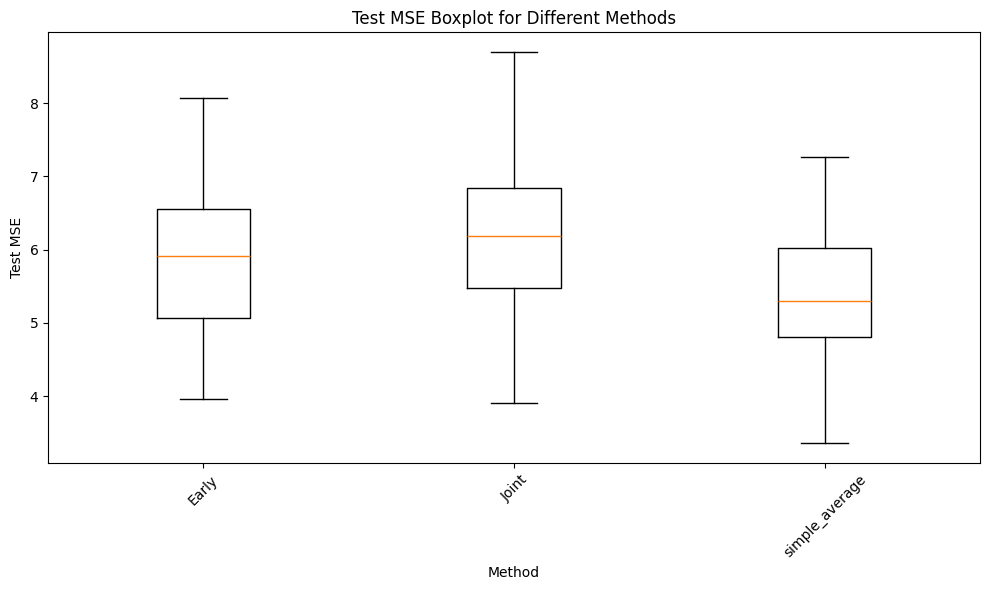

In [401]:
# Plot the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([df_filtered[df_filtered['Method'] == method]['Test_MSE'] for method in methods_to_include],
            tick_labels=methods_to_include)

plt.title('Test MSE Boxplot for Different Methods')
plt.ylabel('Test MSE')
plt.xlabel('Method')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [405]:
# Mean and standard deviation of Test_MSE for each method
grouped_stats = df_filtered.groupby('Method')['Test_MSE'].agg(['mean', 'std'])

print(grouped_stats)

                     mean        std
Method                              
Early            5.957238   1.084831
Joint            6.272455   1.213642
Mod1            126.12808  24.179069
Mod2            85.166094  17.661570
simple_average   5.423765   0.993576


In [3]:
import itertools
outs1 = [0, 10]
outs2 = [0, 20]

for dim1, dim2 in itertools.product(outs1, outs2):
    if dim1 == dim2 == 0:
        continue
    else:
        print(dim1, dim2)

0 20
10 0
10 20


In [6]:
np.logspace(-4, 0, 100)

array([1.00000000e-04, 1.09749877e-04, 1.20450354e-04, 1.32194115e-04,
       1.45082878e-04, 1.59228279e-04, 1.74752840e-04, 1.91791026e-04,
       2.10490414e-04, 2.31012970e-04, 2.53536449e-04, 2.78255940e-04,
       3.05385551e-04, 3.35160265e-04, 3.67837977e-04, 4.03701726e-04,
       4.43062146e-04, 4.86260158e-04, 5.33669923e-04, 5.85702082e-04,
       6.42807312e-04, 7.05480231e-04, 7.74263683e-04, 8.49753436e-04,
       9.32603347e-04, 1.02353102e-03, 1.12332403e-03, 1.23284674e-03,
       1.35304777e-03, 1.48496826e-03, 1.62975083e-03, 1.78864953e-03,
       1.96304065e-03, 2.15443469e-03, 2.36448941e-03, 2.59502421e-03,
       2.84803587e-03, 3.12571585e-03, 3.43046929e-03, 3.76493581e-03,
       4.13201240e-03, 4.53487851e-03, 4.97702356e-03, 5.46227722e-03,
       5.99484250e-03, 6.57933225e-03, 7.22080902e-03, 7.92482898e-03,
       8.69749003e-03, 9.54548457e-03, 1.04761575e-02, 1.14975700e-02,
       1.26185688e-02, 1.38488637e-02, 1.51991108e-02, 1.66810054e-02,
      